In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
from scipy.interpolate import RectBivariateSpline
import numpy as np

In [3]:
from vaneska.interpolate import ScipyRectBivariateSpline

In [4]:
from lightkurve import KeplerTargetPixelFile

In [5]:
import tensorflow as tf

In [6]:
from vaneska.models import KeplerPRF

In [7]:
tpf = KeplerTargetPixelFile.from_archive('kepler-10b', quarter=5)

INFO: Found cached file ./mastDownload/Kepler/kplr011904151_lc_Q111111110111011101/kplr011904151-2010174085026_lpd-targ.fits.gz with expected size 4685387. [astroquery.query]


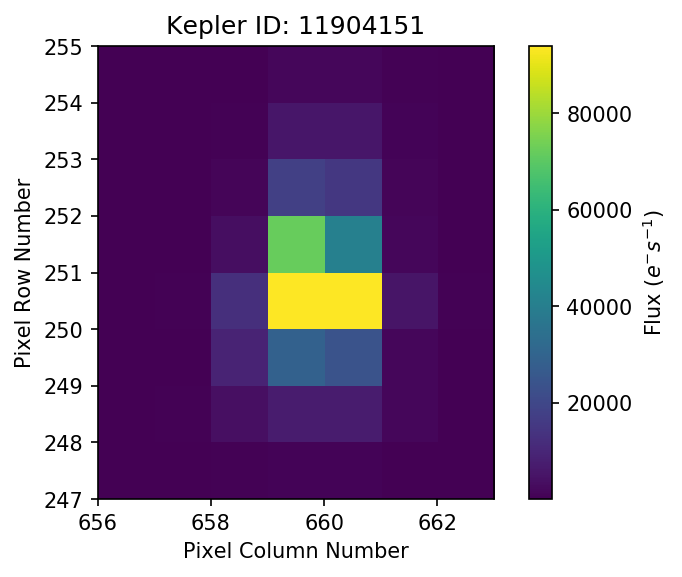

In [8]:
tpf.plot()

In [25]:
lc = tpf.to_lightcurve()

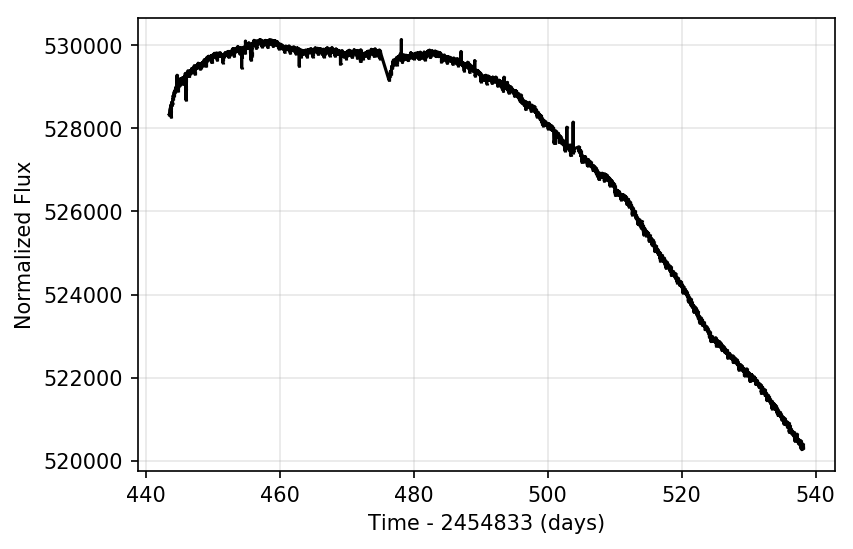

In [26]:
lc.plot(normalize=False)

In [ ]:
from lightkurve import PRFPhotometry, SceneModel

In [ ]:
from oktopus import UniformPrior

In [ ]:
scene = SceneModel(prfs=[tpf.get_prf_model()])

In [ ]:
unif = UniformPrior(lb=[3e5, 658., 249., 100.],
                    ub=[7e5, 662., 253., 10e3])

In [ ]:
phot = PRFPhotometry(scene_model=scene, prior=unif)

In [ ]:
results = phot.fit(tpf_flux=tpf.flux + tpf.flux_bkg)

In [ ]:
plt.plot(tpf.time, results[:, 0], 'o', markersize=1.)

In [9]:
prf = KeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row)

In [10]:
flux = tf.Variable(547055, dtype=tf.float64)
xc = tf.Variable(659.87, dtype=tf.float64)
yc = tf.Variable(250.74, dtype=tf.float64)
bkg = tf.Variable(212.52, dtype=tf.float64)

In [11]:
var_list = [flux, xc, yc, bkg]

In [12]:
model = prf(flux, xc, yc) + bkg

In [13]:
model

<tf.Tensor 'add:0' shape=<unknown> dtype=float64>

In [14]:
sess = tf.Session()

In [15]:
sess.run(tf.global_variables_initializer())

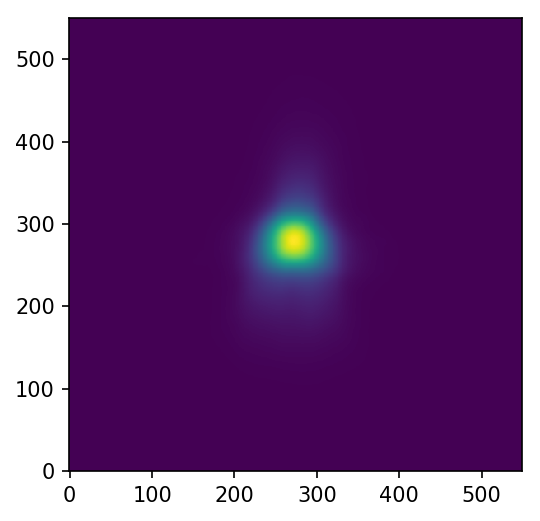

In [16]:
plt.imshow(prf.supersampled_prf, origin='lower')

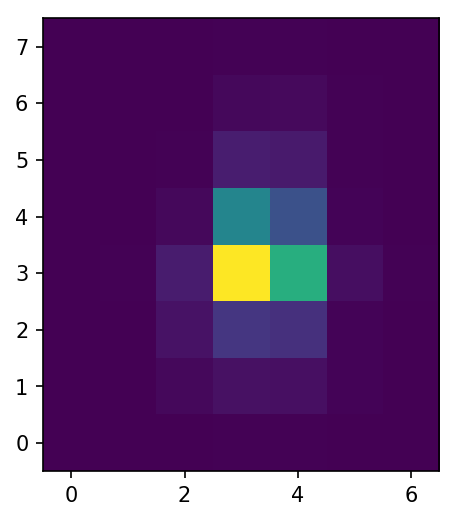

In [17]:
plt.imshow(sess.run(model), origin='lower')

In [18]:
data = tf.placeholder(dtype=tf.float64, shape=tpf.flux[0].shape)

In [19]:
loss = tf.reduce_sum(tf.subtract(model, tf.multiply(data, tf.log(model))))

In [20]:
grad = tf.gradients(loss, var_list)

In [21]:
sess.run(grad, feed_dict={data:tpf.flux[0] + tpf.flux_bkg[0]})

[0.00016182314075422269,
 -6530.3608980765011,
 5148.4259403114556,
 0.009183493978979107]

In [22]:
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, var_list, method='BFGS')

In [23]:
import tqdm

In [24]:
psf_flux = []
psf_xc = []
psf_yc = []
for n in tqdm.tqdm(range(len(tpf.time))):
    optimizer.minimize(session=sess, feed_dict={data:tpf.flux[n] + tpf.flux_bkg[n]})
    psf_flux.append(sess.run(flux))
    psf_xc.append(sess.run(xc))
    psf_yc.append(sess.run(yc))
    print(sess.run(grad, feed_dict={data:tpf.flux[n] + tpf.flux_bkg[n]}))

  0%|          | 0/4492 [00:00<?, ?it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511108.791246
  Number of iterations: 34
  Number of functions evaluations: 38


  0%|          | 1/4492 [00:00<27:40,  2.70it/s]

[1.6439426642894661e-10, -0.00010453471077198628, 0.00012021847214782611, -3.3866614956856722e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510920.137101
  Number of iterations: 11
  Number of functions evaluations: 15


  0%|          | 2/4492 [00:00<18:26,  4.06it/s]

[3.1910587140896243e-06, -0.00018582568009151146, -1.8393649952486157e-05, 3.933932313238131e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511383.378077
  Number of iterations: 37
  Number of functions evaluations: 40


  0%|          | 3/4492 [00:00<19:31,  3.83it/s]

[-1.527994744621175e-12, -1.0260509952786379e-07, 1.3154931366443634e-08, -1.0769385383468943e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511830.355447
  Number of iterations: 34
  Number of functions evaluations: 74


  0%|          | 4/4492 [00:01<24:52,  3.01it/s]

[-1.1544549170794394e-10, -0.00027813127599074505, 0.00014833845307293814, 1.2791261216893446e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511982.104563
  Number of iterations: 13
  Number of functions evaluations: 73


  0%|          | 5/4492 [00:01<27:40,  2.70it/s]

[-7.3805882519397542e-07, -0.0025317818326584529, 0.00026926227656076662, 2.368026502663767e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511765.760628
  Number of iterations: 10
  Number of functions evaluations: 14


  0%|          | 6/4492 [00:01<24:38,  3.03it/s]

[-2.3754215839890194e-05, 0.0014135896763036726, -0.0007783592700434383, 1.4452782681750875e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511875.210305
  Number of iterations: 9
  Number of functions evaluations: 79


  0%|          | 7/4492 [00:02<27:57,  2.67it/s]

[-7.2382560805722349e-06, -0.00012409055898388033, -8.7693706518621184e-05, 1.0918934689740922e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511979.997315
  Number of iterations: 22
  Number of functions evaluations: 31


  0%|          | 8/4492 [00:02<26:42,  2.80it/s]

[2.2086461479164932e-10, 0.0002800166939778137, -0.0012556239053083118, -3.5453441971089461e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512285.046083
  Number of iterations: 9
  Number of functions evaluations: 108


  0%|          | 9/4492 [00:03<29:46,  2.51it/s]

[-5.9591327429987101e-06, -0.0051411977165116696, 0.0031333313290815568, 2.1075752343335807e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512067.741150
  Number of iterations: 10
  Number of functions evaluations: 14


  0%|          | 10/4492 [00:03<27:42,  2.70it/s]

[-2.0816146412867831e-06, 0.00028217438921274152, -0.00011138720401504543, -1.1232349605982961e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511282.749685
  Number of iterations: 35
  Number of functions evaluations: 40


  0%|          | 11/4492 [00:04<27:17,  2.74it/s]

[1.3050537647080196e-10, 0.00014818662066318211, -0.00013578989455709234, -1.5619678750411481e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512750.981508
  Number of iterations: 36
  Number of functions evaluations: 43


  0%|          | 12/4492 [00:04<27:00,  2.77it/s]

[-7.0986356549840313e-11, 5.6769204093143344e-07, -1.8946875570691191e-05, 1.4236760437214002e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511762.999864
  Number of iterations: 26
  Number of functions evaluations: 78


  0%|          | 13/4492 [00:04<27:54,  2.67it/s]

[-4.3059752673213492e-09, 0.0053653560548809764, 0.00028847901012341026, 1.2601061757377963e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511570.317667
  Number of iterations: 38
  Number of functions evaluations: 121


  0%|          | 14/4492 [00:05<30:21,  2.46it/s]

[9.2439892546147817e-11, -2.7200587737752357e-05, -3.3569471270311624e-05, 1.7383073758203693e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508140.463300
  Number of iterations: 38
  Number of functions evaluations: 41


  0%|          | 15/4492 [00:06<29:52,  2.50it/s]

[8.1989814243454973e-12, -2.1406322048278525e-08, 2.5678673409856856e-08, -1.6050849538373768e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512187.480694
  Number of iterations: 36
  Number of functions evaluations: 40


  0%|          | 16/4492 [00:06<29:23,  2.54it/s]

[-6.4194420872770719e-10, 0.00017277698543693987, 0.00015806382180016953, -1.3148053212841404e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512738.413711
  Number of iterations: 32
  Number of functions evaluations: 40


  0%|          | 17/4492 [00:06<28:57,  2.58it/s]

[-7.1829256084732229e-11, 9.3177303369884612e-05, -8.0804238677956164e-06, -1.126756221658809e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513250.190145
  Number of iterations: 35
  Number of functions evaluations: 39


  0%|          | 18/4492 [00:06<28:32,  2.61it/s]

[-6.7672440567934089e-11, 3.4031440463877516e-05, 2.2611942767980509e-05, 3.2939553751276662e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512937.012207
  Number of iterations: 35
  Number of functions evaluations: 39


  0%|          | 19/4492 [00:07<28:16,  2.64it/s]

[4.4878545324422703e-11, -4.2793507418537047e-05, 3.2888565328903496e-05, 1.2212912903208917e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512679.738348
  Number of iterations: 10
  Number of functions evaluations: 66


  0%|          | 20/4492 [00:07<28:55,  2.58it/s]

[6.3548648177730316e-07, 0.00093838676275481703, -0.00043756099876191001, -1.0063243582880688e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512849.972169
  Number of iterations: 12
  Number of functions evaluations: 17


  0%|          | 21/4492 [00:07<28:11,  2.64it/s]

[-6.6559102101550194e-06, -0.00012842675050706021, 2.3873326426837593e-05, -1.7803839058583293e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512777.851091
  Number of iterations: 12
  Number of functions evaluations: 119


  0%|          | 22/4492 [00:08<29:49,  2.50it/s]

[-4.2910012187360666e-06, 0.0072612855628904072, -0.00037486935070774052, -2.7397805028028799e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511974.958921
  Number of iterations: 38
  Number of functions evaluations: 43


  1%|          | 23/4492 [00:09<29:34,  2.52it/s]

[3.8275683837685204e-11, 2.6458233151060995e-06, -2.2346102923620492e-07, -6.9956113124547414e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512485.226591
  Number of iterations: 35
  Number of functions evaluations: 39


  1%|          | 24/4492 [00:09<29:27,  2.53it/s]

[-2.7668113026374508e-10, 0.00010670494111764128, 6.5244019424426369e-05, -8.8221459138004832e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512504.502007
  Number of iterations: 27
  Number of functions evaluations: 97


  1%|          | 25/4492 [00:10<30:23,  2.45it/s]

[2.8875655839512293e-08, 0.018777971362851531, -0.00076961574450251646, -5.9268299079651143e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513457.898994
  Number of iterations: 35
  Number of functions evaluations: 39


  1%|          | 26/4492 [00:10<30:12,  2.46it/s]

[-6.4834203283847813e-10, 0.00089835749713529367, -0.00026095840257767122, -1.9973971177034144e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513275.931658
  Number of iterations: 36
  Number of functions evaluations: 39


  1%|          | 27/4492 [00:10<30:03,  2.48it/s]

[1.1712341166369988e-12, -1.8435912352288142e-08, 7.3068804340437055e-09, 2.4723667557680074e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513587.954264
  Number of iterations: 36
  Number of functions evaluations: 40


  1%|          | 28/4492 [00:11<29:46,  2.50it/s]

[-2.1347897061207988e-10, -0.00024010699326026952, 0.00034797728039848153, 2.1906107261493446e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513815.049686
  Number of iterations: 12
  Number of functions evaluations: 17


  1%|          | 29/4492 [00:11<29:05,  2.56it/s]

[-5.561091433057587e-06, 2.0972822767362231e-05, -0.00030246161986724474, 6.8654409712820552e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514297.311918
  Number of iterations: 34
  Number of functions evaluations: 104


  1%|          | 30/4492 [00:12<29:55,  2.48it/s]

[-5.5767247677390719e-10, 0.00010602128486425499, 0.00074996120747528039, -1.6982388553188343e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514004.339570
  Number of iterations: 34
  Number of functions evaluations: 77


  1%|          | 31/4492 [00:12<30:13,  2.46it/s]

[4.1083285037823991e-10, -0.0001755075727487565, 0.00011715720393112861, 2.6810468733984294e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514077.008906
  Number of iterations: 11
  Number of functions evaluations: 15


  1%|          | 32/4492 [00:12<29:36,  2.51it/s]

[-3.1257598866905531e-06, 0.00059480945355971926, -0.00073817281554511283, -1.0277586559581664e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514170.210159
  Number of iterations: 10
  Number of functions evaluations: 15


  1%|          | 33/4492 [00:12<29:02,  2.56it/s]

[-1.7784474405321306e-05, 0.021745715100678353, -0.012888051460322458, -4.6384066735294383e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514307.882475
  Number of iterations: 35
  Number of functions evaluations: 39


  1%|          | 34/4492 [00:13<28:53,  2.57it/s]

[-2.8287677148602919e-10, 7.150053988880245e-05, 3.0235431040637195e-05, -1.1421206147499419e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514512.059447
  Number of iterations: 9
  Number of functions evaluations: 69


  1%|          | 35/4492 [00:13<29:06,  2.55it/s]

[4.1339155630853303e-06, -0.00065415154085712857, 0.0018660099030967103, -2.3717506303366775e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514873.527832
  Number of iterations: 36
  Number of functions evaluations: 41


  1%|          | 36/4492 [00:14<28:54,  2.57it/s]

[6.6192009338938984e-11, 0.00043621071790767019, -1.8920265574706718e-05, 2.293838375910795e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514851.625513
  Number of iterations: 31
  Number of functions evaluations: 37


  1%|          | 37/4492 [00:14<28:46,  2.58it/s]

[-2.2142798272034581e-10, -0.00010916897508650436, 4.2565712647046894e-05, -9.3195399286649661e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514474.269476
  Number of iterations: 35
  Number of functions evaluations: 39


  1%|          | 38/4492 [00:14<28:40,  2.59it/s]

[3.0842138565301269e-10, -0.00020918933341818047, -3.7113491998752579e-05, 1.2089133283321729e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514882.138523
  Number of iterations: 35
  Number of functions evaluations: 39


  1%|          | 39/4492 [00:14<28:29,  2.60it/s]

[-1.0497308751411527e-10, 0.00021738019449912827, 0.00012445975698938128, 1.451982777345151e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514851.338131
  Number of iterations: 36
  Number of functions evaluations: 40


  1%|          | 40/4492 [00:15<28:21,  2.62it/s]

[-9.0494018528675113e-13, 2.3361280909739435e-08, -4.954927135258913e-09, -1.5607626302482913e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514599.751814
  Number of iterations: 35
  Number of functions evaluations: 98


  1%|          | 41/4492 [00:15<28:51,  2.57it/s]

[5.9788230616364402e-10, -0.00060422725618991535, -7.1785361797083169e-06, 7.3346480911062883e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515033.805655
  Number of iterations: 35
  Number of functions evaluations: 96


  1%|          | 42/4492 [00:16<29:17,  2.53it/s]

[5.5997952976005738e-10, 0.00041300252951259608, -0.00026059500487463083, 5.2063059119422661e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514949.949264
  Number of iterations: 11
  Number of functions evaluations: 82


  1%|          | 43/4492 [00:17<29:32,  2.51it/s]

[-5.5854029934162067e-06, -0.00012482587681006407, -0.00012430235074134544, 6.5413429006788704e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515358.697161
  Number of iterations: 33
  Number of functions evaluations: 92


  1%|          | 44/4492 [00:17<29:54,  2.48it/s]

[1.3792576646770582e-08, -0.010112564726568962, -0.0030585276927013183, 3.9452477127444041e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515001.863865
  Number of iterations: 12
  Number of functions evaluations: 16


  1%|          | 45/4492 [00:17<29:26,  2.52it/s]

[1.9734152345899335e-05, 0.00018702939087233972, 0.0002243893759441562, 5.4640358160273905e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515762.569045
  Number of iterations: 30
  Number of functions evaluations: 38


  1%|          | 46/4492 [00:18<29:14,  2.53it/s]

[-4.1582836826647984e-10, 9.6402241069881711e-06, -4.9068985390476882e-06, -2.0283623103356518e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515101.021419
  Number of iterations: 26
  Number of functions evaluations: 34


  1%|          | 47/4492 [00:18<29:03,  2.55it/s]

[3.799185367345248e-10, 0.0001299852892771014, -0.00020081720685993787, 1.6490644727529258e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515773.698358
  Number of iterations: 38
  Number of functions evaluations: 45


  1%|          | 48/4492 [00:18<28:58,  2.56it/s]

[-2.6137703112993904e-12, -8.5583451436832547e-10, 1.9966682884842157e-07, -2.443090174608642e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515928.540525
  Number of iterations: 32
  Number of functions evaluations: 40


  1%|          | 49/4492 [00:19<28:50,  2.57it/s]

[-5.506964675938697e-11, 0.00012064131806255318, 0.00048437037003168371, -4.7907947609004964e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515491.299930
  Number of iterations: 25
  Number of functions evaluations: 34


  1%|          | 50/4492 [00:19<28:39,  2.58it/s]

[8.8421934704707716e-11, -3.4441835396137321e-05, 6.3630366639699787e-05, -4.4132725252055138e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515268.318115
  Number of iterations: 29
  Number of functions evaluations: 39


  1%|          | 51/4492 [00:19<28:31,  2.59it/s]

[7.4897039091526008e-11, 0.00022478703840533854, 0.00073291042281198315, -1.9816667307104296e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515639.622082
  Number of iterations: 20
  Number of functions evaluations: 30


  1%|          | 52/4492 [00:19<28:24,  2.60it/s]

[6.0644811221421957e-11, 0.00017891710967887775, 8.9115881564794108e-05, 1.9655524041706229e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515362.121215
  Number of iterations: 25
  Number of functions evaluations: 36


  1%|          | 53/4492 [00:20<28:17,  2.62it/s]

[4.0527218733710235e-11, 1.9976105249952525e-06, 0.00015138848175411113, -3.6132911551689517e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515578.229005
  Number of iterations: 36
  Number of functions evaluations: 41


  1%|          | 54/4492 [00:20<28:11,  2.62it/s]

[-8.4246883774730108e-11, 1.2042614798701834e-05, -2.8509100957307965e-05, -1.5003105646727022e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516110.699043
  Number of iterations: 12
  Number of functions evaluations: 16


  1%|          | 55/4492 [00:20<27:51,  2.65it/s]

[-9.4746528540960717e-06, -3.6905567867506761e-05, -2.9642127628903836e-05, -2.2054430148799042e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515491.653320
  Number of iterations: 36
  Number of functions evaluations: 108


  1%|          | 56/4492 [00:21<28:22,  2.61it/s]

[-1.9671648706677536e-08, -0.012049957618728513, 0.0012599090296134818, -4.2684291624572879e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5523041.510257
  Number of iterations: 25
  Number of functions evaluations: 37


  1%|▏         | 57/4492 [00:21<28:18,  2.61it/s]

[5.2098757599705614e-11, 4.9899304030986968e-06, -2.9924685804871842e-06, -7.0259978612874363e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515876.099928
  Number of iterations: 25
  Number of functions evaluations: 41


  1%|▏         | 58/4492 [00:22<28:12,  2.62it/s]

[-4.9481096303649608e-11, -4.1737248466233723e-06, 1.7692145775072277e-06, 8.5738405153357178e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515795.205312
  Number of iterations: 35
  Number of functions evaluations: 45


  1%|▏         | 59/4492 [00:22<28:07,  2.63it/s]

[6.9875758824944345e-11, -1.9742507902265061e-05, 2.5026947696460411e-06, 1.43266145613552e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515668.281077
  Number of iterations: 11
  Number of functions evaluations: 15


  1%|▏         | 60/4492 [00:22<27:49,  2.66it/s]

[-1.6699830316693233e-05, 0.0036288808892095403, 0.0022173439883772517, 2.2462606319439971e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515698.930251
  Number of iterations: 27
  Number of functions evaluations: 34


  1%|▏         | 61/4492 [00:22<27:40,  2.67it/s]

[-1.795382028810244e-10, -9.4168683972384315e-05, 7.7458073064917699e-05, -9.976800630084881e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515808.968836
  Number of iterations: 32
  Number of functions evaluations: 38


  1%|▏         | 62/4492 [00:23<27:32,  2.68it/s]

[2.9383406298377768e-11, 7.9035880844458006e-06, 1.0465613740961999e-05, 6.20191886735455e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514988.170815
  Number of iterations: 36
  Number of functions evaluations: 43


  1%|▏         | 63/4492 [00:23<27:27,  2.69it/s]

[1.7420646869492629e-10, 8.241294835897861e-06, -1.0832300176844001e-06, 3.8440482574841894e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514818.067945
  Number of iterations: 36
  Number of functions evaluations: 75


  1%|▏         | 64/4492 [00:23<27:37,  2.67it/s]

[1.3519997534711115e-10, -5.3375502375274664e-05, 1.8072694729198702e-05, 5.7889335769445438e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515323.852202
  Number of iterations: 33
  Number of functions evaluations: 92


  1%|▏         | 65/4492 [00:24<27:53,  2.64it/s]

[-1.004794649393792e-09, -0.00017661043648331542, 0.00011983897638856433, -5.4020853978986594e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515908.448819
  Number of iterations: 34
  Number of functions evaluations: 38


  1%|▏         | 66/4492 [00:24<27:46,  2.66it/s]

[-3.262371440701517e-10, -0.00063472086094407132, 0.00040745442856859881, -1.6736132590899899e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516263.336085
  Number of iterations: 33
  Number of functions evaluations: 107


  1%|▏         | 67/4492 [00:25<28:09,  2.62it/s]

[3.7783607076402603e-09, -0.0015390518019557931, 0.00076801854265795555, 1.9347115910450796e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516215.790287
  Number of iterations: 37
  Number of functions evaluations: 52


  2%|▏         | 68/4492 [00:25<28:08,  2.62it/s]

[-2.9071571157335274e-09, -0.0020080232698092004, 0.00021681746511603706, 2.1195563449927235e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516218.277079
  Number of iterations: 30
  Number of functions evaluations: 36


  2%|▏         | 69/4492 [00:26<28:05,  2.62it/s]

[-1.2202824081070096e-10, -3.5726734040508745e-05, 2.1910571376793087e-05, -4.0175990534407902e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515992.754607
  Number of iterations: 8
  Number of functions evaluations: 67


  2%|▏         | 70/4492 [00:26<28:15,  2.61it/s]

[4.8383049146959872e-06, -6.1119270412746118e-05, -0.00018894750792242121, -6.1431564835068286e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516093.672628
  Number of iterations: 28
  Number of functions evaluations: 35


  2%|▏         | 71/4492 [00:27<28:08,  2.62it/s]

[3.6441281416055293e-11, -2.7204702291783178e-05, 3.0691851861774921e-05, -2.1668791205797788e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515788.811663
  Number of iterations: 34
  Number of functions evaluations: 38


  2%|▏         | 72/4492 [00:27<28:06,  2.62it/s]

[1.0988910996434509e-10, -0.00014362907995746355, 0.00010457316238898784, 3.8998639873000229e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515859.770494
  Number of iterations: 34
  Number of functions evaluations: 40


  2%|▏         | 73/4492 [00:27<28:03,  2.62it/s]

[-4.8676826371746307e-10, -0.00025424361183468136, -0.00053044981541461311, -3.8439105409793228e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516356.624408
  Number of iterations: 36
  Number of functions evaluations: 134


  2%|▏         | 74/4492 [00:28<28:40,  2.57it/s]

[1.8116631979314679e-10, -9.5361202966159908e-05, -1.9799936126219109e-05, 3.3149912059826647e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515947.186859
  Number of iterations: 35
  Number of functions evaluations: 39


  2%|▏         | 75/4492 [00:29<28:34,  2.58it/s]

[3.4684095873149801e-11, -1.6775265976320952e-07, -1.1070369509980083e-08, 4.5010433158410024e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516696.594702
  Number of iterations: 32
  Number of functions evaluations: 102


  2%|▏         | 76/4492 [00:29<28:57,  2.54it/s]

[-5.6078071960369291e-10, 0.0059759023397418787, 0.0023328105035034241, -3.5946300480649285e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516551.811809
  Number of iterations: 36
  Number of functions evaluations: 40


  2%|▏         | 77/4492 [00:30<28:53,  2.55it/s]

[8.6530090384617786e-11, -1.8112258203473175e-05, -3.9137357816798612e-06, 2.4093232298127987e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516319.146525
  Number of iterations: 33
  Number of functions evaluations: 38


  2%|▏         | 78/4492 [00:30<28:49,  2.55it/s]

[-1.8681264955106025e-10, -3.2737345463829115e-05, -1.4025757991475984e-05, -3.3754345629688487e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517670.982453
  Number of iterations: 36
  Number of functions evaluations: 40


  2%|▏         | 79/4492 [00:30<28:44,  2.56it/s]

[-1.112606907646696e-10, 2.3681023321842076e-05, 3.3158608857775107e-05, 2.4859148628486594e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516762.337032
  Number of iterations: 32
  Number of functions evaluations: 42


  2%|▏         | 80/4492 [00:31<28:39,  2.57it/s]

[1.7745710803596104e-10, 1.8672940313990694e-06, -1.3647659216076136e-06, -5.8821097104200248e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517147.206448
  Number of iterations: 35
  Number of functions evaluations: 103


  2%|▏         | 81/4492 [00:31<28:56,  2.54it/s]

[-9.2276281754566369e-10, -0.0013856113901056233, 4.4603359128814191e-05, -1.0698162342670514e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517131.335967
  Number of iterations: 35
  Number of functions evaluations: 40


  2%|▏         | 82/4492 [00:32<28:51,  2.55it/s]

[-1.1061212536189746e-10, 0.00032383057350671152, -1.844094367697835e-05, -8.8855127700071534e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517366.458828
  Number of iterations: 11
  Number of functions evaluations: 16


  2%|▏         | 83/4492 [00:32<28:37,  2.57it/s]

[5.4440193673838469e-06, -0.00017629989179113181, -0.0001913085379783297, -4.3971398966391462e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517608.782164
  Number of iterations: 37
  Number of functions evaluations: 42


  2%|▏         | 84/4492 [00:32<28:33,  2.57it/s]

[-1.0939063890824663e-10, 5.4842191275383811e-05, -2.9660968721145764e-06, -2.4511887963818424e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517341.057139
  Number of iterations: 34
  Number of functions evaluations: 38


  2%|▏         | 85/4492 [00:32<28:27,  2.58it/s]

[4.378701654733641e-11, 3.611226384236943e-05, -1.4887436918797903e-05, -2.1953550088937845e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517102.735660
  Number of iterations: 28
  Number of functions evaluations: 41


  2%|▏         | 86/4492 [00:33<28:25,  2.58it/s]

[-2.0222895493610116e-10, 5.4439456107502338e-06, -2.8629401640500873e-06, -1.1650404285745708e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517178.238475
  Number of iterations: 9
  Number of functions evaluations: 13


  2%|▏         | 87/4492 [00:33<28:11,  2.60it/s]

[4.9386556910304552e-06, -0.00037673767155865789, 0.00056907674479589332, -1.7350521575032474e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517525.689902
  Number of iterations: 11
  Number of functions evaluations: 16


  2%|▏         | 88/4492 [00:33<27:59,  2.62it/s]

[-4.1468104736586825e-06, 0.00010418364990982809, -0.0001298213355767075, -3.6241276979431802e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516977.294798
  Number of iterations: 36
  Number of functions evaluations: 39


  2%|▏         | 89/4492 [00:33<27:55,  2.63it/s]

[4.68950668228163e-11, 5.8990876823372673e-06, 2.7580972528085113e-06, -3.3430011758817102e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517562.442244
  Number of iterations: 15
  Number of functions evaluations: 81


  2%|▏         | 90/4492 [00:34<28:06,  2.61it/s]

[1.587168469568967e-09, -0.0031646909978917392, 0.0013130963234289084, -7.4239001279785555e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517242.437368
  Number of iterations: 13
  Number of functions evaluations: 126


  2%|▏         | 91/4492 [00:35<28:35,  2.57it/s]

[6.7748298401837381e-07, 0.00039839136252339813, -0.0013987797137815505, -2.4503859996638511e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516758.684470
  Number of iterations: 30
  Number of functions evaluations: 36


  2%|▏         | 92/4492 [00:35<28:32,  2.57it/s]

[5.7835168945641335e-12, -5.7466513680992648e-07, 3.3091600926127285e-07, 2.5419122362535518e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517518.882889
  Number of iterations: 33
  Number of functions evaluations: 87


  2%|▏         | 93/4492 [00:36<28:49,  2.54it/s]

[-1.1248761930607309e-09, 0.00014729456188433687, 6.5146476117661223e-05, -6.9175249628461444e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517282.970366
  Number of iterations: 33
  Number of functions evaluations: 92


  2%|▏         | 94/4492 [00:37<29:05,  2.52it/s]

[-1.0653589632876603e-08, -4.9070005843532272e-05, -1.8675504179554991e-05, 4.3132880158669451e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517532.194159
  Number of iterations: 11
  Number of functions evaluations: 15


  2%|▏         | 95/4492 [00:37<28:52,  2.54it/s]

[-2.3378966733573515e-05, -0.0011639913082035491, -0.00039157304127002135, -1.0148501463635995e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517180.805067
  Number of iterations: 36
  Number of functions evaluations: 43


  2%|▏         | 96/4492 [00:37<28:49,  2.54it/s]

[3.9337731509714313e-10, 0.0011872848508573952, -0.00014876816203468479, 1.3748354399378826e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517003.254365
  Number of iterations: 37
  Number of functions evaluations: 41


  2%|▏         | 97/4492 [00:38<28:46,  2.55it/s]

[-2.3086902181668201e-11, -9.6348289844172541e-06, 1.4877876310492866e-05, -1.0786475046486999e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517158.834758
  Number of iterations: 35
  Number of functions evaluations: 39


  2%|▏         | 98/4492 [00:38<28:43,  2.55it/s]

[1.3486864403056131e-11, -3.5044017749896739e-06, -3.2543339330004528e-06, 1.9834750508707089e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517387.324270
  Number of iterations: 37
  Number of functions evaluations: 40


  2%|▏         | 99/4492 [00:38<28:39,  2.55it/s]

[-4.7229445181151686e-11, 4.476303729461506e-06, -7.4865492933895439e-06, -9.0382785700171553e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517119.176098
  Number of iterations: 34
  Number of functions evaluations: 39


  2%|▏         | 100/4492 [00:39<28:35,  2.56it/s]

[5.65939638035029e-10, -0.00027595787059908616, -0.00011903283666470088, 3.3871609406155301e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516970.716246
  Number of iterations: 35
  Number of functions evaluations: 39


  2%|▏         | 101/4492 [00:39<28:31,  2.57it/s]

[1.8266646008291421e-11, 7.8808579928590916e-07, -1.7760612536221743e-08, -3.6722925811361051e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517655.512750
  Number of iterations: 36
  Number of functions evaluations: 97


  2%|▏         | 102/4492 [00:40<28:44,  2.55it/s]

[-8.7308222110338285e-10, 0.0014101926044531865, -0.00015973229892551899, -2.5335604533216483e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515751.221918
  Number of iterations: 36
  Number of functions evaluations: 90


  2%|▏         | 103/4492 [00:40<28:55,  2.53it/s]

[3.1684309342860928e-10, 0.00011075769180024508, 2.1862297217012383e-05, 6.4333621097034666e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516454.477987
  Number of iterations: 36
  Number of functions evaluations: 92


  2%|▏         | 104/4492 [00:41<29:07,  2.51it/s]

[-6.7042330454541998e-10, 0.00015154866696320823, 0.00018680806351767387, -3.1948735224052172e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516125.116085
  Number of iterations: 35
  Number of functions evaluations: 39


  2%|▏         | 105/4492 [00:41<29:02,  2.52it/s]

[1.154903768105231e-10, 0.00015651625062673702, 0.00012325867646723054, -8.3772530024006642e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516987.223649
  Number of iterations: 35
  Number of functions evaluations: 87


  2%|▏         | 106/4492 [00:42<29:12,  2.50it/s]

[-5.155878579979345e-10, 0.00074468826778684161, 0.0010368058501626365, 6.4692592172121977e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517533.561040
  Number of iterations: 35
  Number of functions evaluations: 39


  2%|▏         | 107/4492 [00:42<29:08,  2.51it/s]

[-1.8805391271969896e-12, 6.602158464374952e-08, 2.9622242436744273e-08, -4.1160075348045666e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517388.383838
  Number of iterations: 37
  Number of functions evaluations: 40


  2%|▏         | 108/4492 [00:42<29:05,  2.51it/s]

[5.3027556304319212e-11, -5.0315138651058078e-06, 5.9105914260726422e-06, 1.2877957811241458e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516271.412161
  Number of iterations: 35
  Number of functions evaluations: 39


  2%|▏         | 109/4492 [00:43<29:02,  2.52it/s]

[3.2190911221363638e-10, -0.00019314080873300554, 0.00010405138891655952, 2.1293417729051356e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516646.213052
  Number of iterations: 33
  Number of functions evaluations: 38


  2%|▏         | 110/4492 [00:43<28:57,  2.52it/s]

[-3.660599497135042e-10, -1.3780260360363172e-05, 5.8692112361313775e-06, -1.7906152960378563e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517117.006903
  Number of iterations: 35
  Number of functions evaluations: 39


  2%|▏         | 111/4492 [00:43<28:54,  2.53it/s]

[-1.2440040317307499e-12, 9.9342287285253406e-08, 2.306478563696146e-09, -5.4061199961097373e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517424.805581
  Number of iterations: 10
  Number of functions evaluations: 15


  2%|▏         | 112/4492 [00:44<28:44,  2.54it/s]

[2.6253171313098643e-05, -0.001257902862107585, -0.00049229603610001504, -5.9613746539177725e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517415.792882
  Number of iterations: 11
  Number of functions evaluations: 16


  3%|▎         | 113/4492 [00:44<28:34,  2.55it/s]

[1.3647019564130142e-05, 0.00029298262825250276, -0.0012407506783347344, 4.3850888475915895e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517634.524258
  Number of iterations: 10
  Number of functions evaluations: 62


  3%|▎         | 114/4492 [00:44<28:36,  2.55it/s]

[8.7350419338307062e-06, -0.00036927907603967469, -0.00017813227168517187, -9.6421792772360959e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517240.375518
  Number of iterations: 11
  Number of functions evaluations: 15


  3%|▎         | 115/4492 [00:44<28:26,  2.57it/s]

[3.210604467523883e-05, 0.00062973573722047149, -0.00087819602231320459, -2.7566572191606298e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518262.046917
  Number of iterations: 36
  Number of functions evaluations: 44


  3%|▎         | 116/4492 [00:45<28:24,  2.57it/s]

[-2.3664642294363158e-11, -4.8202819016296417e-06, 5.5483724281657487e-07, 3.5610951965026061e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517414.339465
  Number of iterations: 33
  Number of functions evaluations: 38


  3%|▎         | 117/4492 [00:45<28:20,  2.57it/s]

[8.8851864147448945e-10, -0.00050492986702010967, -7.8511226092814468e-05, 5.440346554363984e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516241.284065
  Number of iterations: 32
  Number of functions evaluations: 37


  3%|▎         | 118/4492 [00:45<28:16,  2.58it/s]

[1.1354398758017803e-10, -0.00015436727335327305, -4.7208450268954039e-05, -1.490716217134036e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515966.166787
  Number of iterations: 35
  Number of functions evaluations: 39


  3%|▎         | 119/4492 [00:46<28:13,  2.58it/s]

[3.9885713655485322e-11, -4.4271519072935916e-07, 9.3396920419763774e-07, 5.2094726310514261e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517299.069713
  Number of iterations: 36
  Number of functions evaluations: 40


  3%|▎         | 120/4492 [00:46<28:09,  2.59it/s]

[-2.0460761990942489e-10, -7.3370700192754157e-05, -7.4113722803303972e-06, -3.7875250047392228e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509662.531036
  Number of iterations: 29
  Number of functions evaluations: 47


  3%|▎         | 121/4492 [00:46<28:09,  2.59it/s]

[4.9574389211770598e-10, 0.00049864621996675851, 3.3182363040396012e-05, -6.7547040627502497e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513493.285446
  Number of iterations: 35
  Number of functions evaluations: 41


  3%|▎         | 122/4492 [00:47<28:06,  2.59it/s]

[-2.0058316379384378e-10, -0.00025415175423404435, -2.087609755108133e-05, -4.4332183479767195e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513537.011182
  Number of iterations: 35
  Number of functions evaluations: 39


  3%|▎         | 123/4492 [00:47<28:03,  2.60it/s]

[-6.8950737133754991e-10, -0.0019883490485881339, 0.00050787088184733875, -9.6101630764344748e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516951.346848
  Number of iterations: 35
  Number of functions evaluations: 77


  3%|▎         | 124/4492 [00:48<28:12,  2.58it/s]

[-1.5455801655878121e-10, 5.998582992106094e-05, -1.41252348839771e-05, 2.9063716766586367e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518137.087251
  Number of iterations: 36
  Number of functions evaluations: 42


  3%|▎         | 125/4492 [00:48<28:10,  2.58it/s]

[-1.3666104099058218e-10, -8.4877588051313069e-05, -2.3480679374188185e-06, -4.957193822097139e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517618.117020
  Number of iterations: 14
  Number of functions evaluations: 28


  3%|▎         | 126/4492 [00:48<28:03,  2.59it/s]

[-3.5466651759560874e-09, 1.9850883745675674e-05, 0.00017821671099227387, -1.4771351886100348e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517517.236624
  Number of iterations: 35
  Number of functions evaluations: 38


  3%|▎         | 127/4492 [00:48<28:01,  2.60it/s]

[1.7103827902598123e-11, -9.6147496151388623e-06, 5.6819699238985777e-06, 4.6111525708880663e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518244.444932
  Number of iterations: 36
  Number of functions evaluations: 40


  3%|▎         | 128/4492 [00:49<27:59,  2.60it/s]

[-1.7284683493518083e-10, -4.3212522541580256e-05, -2.4299642973346636e-06, -3.8238204713714197e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518187.676278
  Number of iterations: 37
  Number of functions evaluations: 40


  3%|▎         | 129/4492 [00:49<27:56,  2.60it/s]

[5.8891623348766853e-11, -5.0714306780719198e-06, 6.1309165175771341e-06, 1.6090784815681047e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518313.169127
  Number of iterations: 36
  Number of functions evaluations: 40


  3%|▎         | 130/4492 [00:49<27:53,  2.61it/s]

[-1.5080858263571972e-10, -5.6307239447050961e-05, -7.1275781010626815e-05, -6.1214593283231977e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518626.318435
  Number of iterations: 35
  Number of functions evaluations: 42


  3%|▎         | 131/4492 [00:50<27:50,  2.61it/s]

[-2.6706745322180314e-11, -4.0573665501142386e-05, -1.0033765647676773e-05, 4.1089840974173342e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517906.470132
  Number of iterations: 35
  Number of functions evaluations: 39


  3%|▎         | 132/4492 [00:50<27:47,  2.61it/s]

[1.669886017657829e-11, 0.00058839695702772588, 7.5315572757972404e-05, -3.6570567740756843e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518496.510401
  Number of iterations: 35
  Number of functions evaluations: 39


  3%|▎         | 133/4492 [00:50<27:44,  2.62it/s]

[-9.2384168023929014e-11, -6.3675975980004296e-05, 6.3052952100406401e-05, 8.093906356254621e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518087.281535
  Number of iterations: 34
  Number of functions evaluations: 43


  3%|▎         | 134/4492 [00:51<27:41,  2.62it/s]

[5.0848129092700978e-10, -0.0019483256228340906, 0.00024691714861546643, -5.6320615604565916e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517593.809718
  Number of iterations: 26
  Number of functions evaluations: 34


  3%|▎         | 135/4492 [00:51<27:37,  2.63it/s]

[8.9087741524107589e-11, -2.0804627183679258e-05, 2.448843588354066e-05, -4.4117259290210598e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518809.186859
  Number of iterations: 37
  Number of functions evaluations: 40


  3%|▎         | 136/4492 [00:51<27:34,  2.63it/s]

[-7.1439703111519925e-12, 1.8298942450201139e-07, 1.6552075976505876e-07, 4.0456415995038242e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518106.303324
  Number of iterations: 37
  Number of functions evaluations: 44


  3%|▎         | 137/4492 [00:51<27:32,  2.64it/s]

[6.5115053279884982e-10, -2.5756636205187533e-05, -1.6989506548270583e-05, 6.8046060763826688e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518161.492827
  Number of iterations: 36
  Number of functions evaluations: 41


  3%|▎         | 138/4492 [00:52<27:29,  2.64it/s]

[-6.1420461598682419e-11, 8.2098677012254484e-07, -3.6782112147193402e-06, -1.1917804076944094e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518080.420202
  Number of iterations: 36
  Number of functions evaluations: 39


  3%|▎         | 139/4492 [00:52<27:26,  2.64it/s]

[2.7456049586649378e-12, 3.7719019019277766e-07, 3.4655568015296012e-07, 2.8625768422330111e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518203.895550
  Number of iterations: 31
  Number of functions evaluations: 46


  3%|▎         | 140/4492 [00:52<27:24,  2.65it/s]

[-3.4648805526116266e-11, -2.9936757073301123e-05, 1.4419678336707875e-05, -1.4970812367565145e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518276.807033
  Number of iterations: 36
  Number of functions evaluations: 43


  3%|▎         | 141/4492 [00:53<27:23,  2.65it/s]

[-1.5580890943764358e-09, -0.0017759788947842026, -0.0016876437184691895, 1.4053319361551075e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517975.988021
  Number of iterations: 10
  Number of functions evaluations: 75


  3%|▎         | 142/4492 [00:53<27:27,  2.64it/s]

[-4.059420505325706e-06, -0.0040091271566780051, -0.0088994275229197228, -2.5854460912189126e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518254.665779
  Number of iterations: 37
  Number of functions evaluations: 41


  3%|▎         | 143/4492 [00:54<27:24,  2.64it/s]

[-7.4811333343471897e-11, -7.7119739671616117e-05, -3.177415783284232e-05, 1.5535402952959743e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517349.458744
  Number of iterations: 37
  Number of functions evaluations: 42


  3%|▎         | 144/4492 [00:54<27:22,  2.65it/s]

[1.0678897002791565e-12, -8.8023170974338427e-08, -4.3470208765938878e-08, 3.2685965045686771e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517098.091777
  Number of iterations: 36
  Number of functions evaluations: 41


  3%|▎         | 145/4492 [00:54<27:20,  2.65it/s]

[-4.8685918144220075e-11, -2.6745568902697414e-05, -9.5247014542110264e-06, -1.049581899170704e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517470.055749
  Number of iterations: 9
  Number of functions evaluations: 16


  3%|▎         | 146/4492 [00:54<27:12,  2.66it/s]

[5.82137397942082e-06, 0.00016690914708306082, -3.1987608963390812e-05, 1.2783476732725063e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518359.704884
  Number of iterations: 35
  Number of functions evaluations: 104


  3%|▎         | 147/4492 [00:55<27:22,  2.64it/s]

[-1.5291773177578127e-09, -0.0001634698983252747, -0.00076440291741164401, -1.4172689728475518e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518135.369687
  Number of iterations: 33
  Number of functions evaluations: 38


  3%|▎         | 148/4492 [00:55<27:21,  2.65it/s]

[3.0418634451578885e-10, -0.00054833186277392088, 0.000595320952925249, 8.4868292504758358e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517656.319152
  Number of iterations: 36
  Number of functions evaluations: 108


  3%|▎         | 149/4492 [00:56<27:31,  2.63it/s]

[-2.1026076713059894e-11, -6.7802798184857238e-06, 0.00013997015776112676, -2.9552611657823746e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518227.136200
  Number of iterations: 34
  Number of functions evaluations: 42


  3%|▎         | 150/4492 [00:56<27:28,  2.63it/s]

[1.9648174979375321e-09, 0.00026910850056083291, -0.0010742961494543124, 7.321514523539463e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518473.555443
  Number of iterations: 32
  Number of functions evaluations: 42


  3%|▎         | 151/4492 [00:57<27:26,  2.64it/s]

[-1.7772951426547889e-10, 0.00025111912054853747, -5.1031367547693662e-05, -4.1955898755219323e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518713.655607
  Number of iterations: 28
  Number of functions evaluations: 41


  3%|▎         | 152/4492 [00:57<27:23,  2.64it/s]

[-8.5611028422666324e-10, -0.0045717945931755821, 6.1345645008259453e-05, -5.5826316358587036e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518590.954868
  Number of iterations: 34
  Number of functions evaluations: 40


  3%|▎         | 153/4492 [00:57<27:20,  2.64it/s]

[-2.3479687031452423e-10, -3.1622454571333947e-05, 3.6987486964790151e-05, -5.6776091827970276e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518167.836104
  Number of iterations: 38
  Number of functions evaluations: 42


  3%|▎         | 154/4492 [00:58<27:18,  2.65it/s]

[5.6192860347498153e-10, -1.4218553587852512e-06, -3.2912012102315202e-06, 3.6749111720357774e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518216.857430
  Number of iterations: 7
  Number of functions evaluations: 71


  3%|▎         | 155/4492 [00:58<27:20,  2.64it/s]

[-1.1164727815746178e-05, -6.3269476413552184e-05, 2.0353902073111385e-05, 2.5663799796404874e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518929.771196
  Number of iterations: 36
  Number of functions evaluations: 42


  3%|▎         | 156/4492 [00:58<27:18,  2.65it/s]

[-3.1520538783247343e-11, -8.4784897353529232e-05, -0.00035751422001339961, 2.8157860298971826e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518255.415004
  Number of iterations: 34
  Number of functions evaluations: 40


  3%|▎         | 157/4492 [00:59<27:15,  2.65it/s]

[9.4162099992245452e-11, -0.00021330477193259867, -0.00016207896624109708, -1.0751045609325161e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518719.030366
  Number of iterations: 30
  Number of functions evaluations: 85


  4%|▎         | 158/4492 [00:59<27:21,  2.64it/s]

[4.040187182204058e-09, 0.0067829452918886091, 0.0012193876573292073, 2.2902209022568343e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518929.773331
  Number of iterations: 10
  Number of functions evaluations: 13


  4%|▎         | 159/4492 [00:59<27:13,  2.65it/s]

[1.4955616840514954e-06, -9.7704878498916514e-07, 5.5714390327921137e-06, -1.6591938933885331e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518716.461599
  Number of iterations: 31
  Number of functions evaluations: 109


  4%|▎         | 160/4492 [01:00<27:23,  2.64it/s]

[-3.4961624775786682e-08, 0.031702960038273886, 0.009143035144006717, 3.8848850508754751e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518772.392067
  Number of iterations: 33
  Number of functions evaluations: 37


  4%|▎         | 161/4492 [01:00<27:19,  2.64it/s]

[-1.0579247373965206e-10, -0.0003478392754914239, 0.00014109226867731195, -3.3104599062028228e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518837.184328
  Number of iterations: 11
  Number of functions evaluations: 15


  4%|▎         | 162/4492 [01:01<27:12,  2.65it/s]

[5.7225576108625373e-06, 0.00017186536251756479, -3.3084361348301172e-05, -2.9302176574041994e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518977.733368
  Number of iterations: 34
  Number of functions evaluations: 41


  4%|▎         | 163/4492 [01:01<27:10,  2.66it/s]

[-5.1992432061054306e-11, -3.5407706491241697e-06, 1.2385135050863028e-07, -7.7399228137764453e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518563.891857
  Number of iterations: 36
  Number of functions evaluations: 48


  4%|▎         | 164/4492 [01:01<27:08,  2.66it/s]

[3.0393367770470414e-10, 7.5502006893657381e-05, -8.2673708675429225e-05, 1.6045849815515822e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518460.275391
  Number of iterations: 22
  Number of functions evaluations: 32


  4%|▎         | 165/4492 [01:01<27:04,  2.66it/s]

[-4.6169244295735101e-10, 0.0010098359512085153, 4.4438143959268928e-05, -3.2704485308787667e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518571.981273
  Number of iterations: 25
  Number of functions evaluations: 88


  4%|▎         | 166/4492 [01:02<27:10,  2.65it/s]

[1.5763229991271055e-08, -0.00013013778016102151, -3.6296680264058523e-05, 3.9884863940464754e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518635.261010
  Number of iterations: 11
  Number of functions evaluations: 73


  4%|▎         | 167/4492 [01:03<27:13,  2.65it/s]

[2.2683652496436127e-06, -0.0089280996885463537, 0.0010539416998653905, 4.2261221178119257e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518831.162948
  Number of iterations: 35
  Number of functions evaluations: 100


  4%|▎         | 168/4492 [01:03<27:20,  2.64it/s]

[-2.2355191742901015e-10, 0.00036954429242541664, 0.00061982804436411243, -1.1022235357760479e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518725.692646
  Number of iterations: 10
  Number of functions evaluations: 14


  4%|▍         | 169/4492 [01:03<27:13,  2.65it/s]

[1.129946109136061e-05, 0.00090294760093456716, -0.000531195646544802, -7.1987060756839583e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518753.239360
  Number of iterations: 26
  Number of functions evaluations: 90


  4%|▍         | 170/4492 [01:04<27:19,  2.64it/s]

[-3.6271105476742838e-10, -5.1579272621893324e-06, 1.1387230188120157e-05, 5.2140451134441435e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518816.652094
  Number of iterations: 35
  Number of functions evaluations: 40


  4%|▍         | 171/4492 [01:04<27:16,  2.64it/s]

[-4.8354975405728862e-10, 0.0002810150735967909, -0.00056067642617563251, -3.7344070125122641e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518658.586429
  Number of iterations: 36
  Number of functions evaluations: 46


  4%|▍         | 172/4492 [01:05<27:15,  2.64it/s]

[4.9348411641780832e-10, -0.00033869806202346808, -0.00053009186194685753, 4.5783890312289799e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518942.363709
  Number of iterations: 37
  Number of functions evaluations: 41


  4%|▍         | 173/4492 [01:05<27:13,  2.64it/s]

[-1.6687436415335766e-10, 2.2077225366956554e-05, -4.2728455809992738e-05, -5.6287188465731219e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518843.274498
  Number of iterations: 12
  Number of functions evaluations: 18


  4%|▍         | 174/4492 [01:05<27:07,  2.65it/s]

[-1.3783328779989196e-05, 0.00084274908294901252, 0.0036007818125654012, 2.146323624274693e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518722.316618
  Number of iterations: 14
  Number of functions evaluations: 19


  4%|▍         | 175/4492 [01:05<27:02,  2.66it/s]

[1.6607379361718334e-05, 0.0042060126147589472, 0.010871766115087667, -8.7902260939021204e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518847.029428
  Number of iterations: 35
  Number of functions evaluations: 40


  4%|▍         | 176/4492 [01:06<27:00,  2.66it/s]

[1.8238646704027417e-11, -9.9574526757351123e-07, -1.8803129933075979e-06, 2.0817463308731021e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519153.673725
  Number of iterations: 37
  Number of functions evaluations: 103


  4%|▍         | 177/4492 [01:06<27:09,  2.65it/s]

[-8.1930090316262305e-11, 0.00056820451254679938, 0.00063702037368784659, -1.5558524375514082e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518585.834244
  Number of iterations: 37
  Number of functions evaluations: 41


  4%|▍         | 178/4492 [01:07<27:09,  2.65it/s]

[1.1432415170792298e-10, -5.3735449455416529e-05, -9.5961702754721045e-05, -2.4362365980135081e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519664.015317
  Number of iterations: 37
  Number of functions evaluations: 40


  4%|▍         | 179/4492 [01:07<27:07,  2.65it/s]

[-2.2366671882656508e-11, 3.0957367016526405e-06, 7.1163831307785586e-06, -4.615341442359977e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519257.736336
  Number of iterations: 25
  Number of functions evaluations: 33


  4%|▍         | 180/4492 [01:07<27:05,  2.65it/s]

[5.7528448151045186e-11, 3.8769885577494279e-06, -2.1143023332115263e-07, -5.0297855547221104e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519074.643363
  Number of iterations: 34
  Number of functions evaluations: 39


  4%|▍         | 181/4492 [01:08<27:02,  2.66it/s]

[3.2910498198174265e-10, 0.00012702500907835201, -3.4043618143186904e-05, 1.3218101302392427e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519915.172594
  Number of iterations: 31
  Number of functions evaluations: 80


  4%|▍         | 182/4492 [01:08<27:08,  2.65it/s]

[-1.6822223475321252e-10, -2.8168783956061816e-05, 6.7990120442118496e-05, -3.4943853699509475e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518863.041064
  Number of iterations: 27
  Number of functions evaluations: 74


  4%|▍         | 183/4492 [01:09<27:11,  2.64it/s]

[2.5156416012805938e-10, 0.0001439042221136333, 0.00031852759093453642, -2.5657924740407623e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518612.406693
  Number of iterations: 35
  Number of functions evaluations: 39


  4%|▍         | 184/4492 [01:09<27:09,  2.64it/s]

[-6.9074806638425024e-11, -2.4218434191425331e-06, 7.3583578341640532e-07, -2.1974826625026367e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518052.092245
  Number of iterations: 37
  Number of functions evaluations: 42


  4%|▍         | 185/4492 [01:09<27:07,  2.65it/s]

[4.0140594841087118e-11, 5.553217761189444e-06, 2.3051403331919573e-05, -4.1751995194516667e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517720.149548
  Number of iterations: 35
  Number of functions evaluations: 40


  4%|▍         | 186/4492 [01:10<27:05,  2.65it/s]

[7.0075380741163595e-10, 0.00046400430983339902, -0.00010800183008541353, 7.1025589776230191e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518034.477419
  Number of iterations: 11
  Number of functions evaluations: 71


  4%|▍         | 187/4492 [01:10<27:08,  2.64it/s]

[9.7425181392954419e-06, -0.00048897257101998548, 7.2028724389383569e-06, -1.1285992829179747e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519218.418485
  Number of iterations: 36
  Number of functions evaluations: 41


  4%|▍         | 188/4492 [01:11<27:07,  2.65it/s]

[-1.2275551235230164e-10, -1.6339981812052429e-07, 9.9104545370209962e-06, -2.1254060289521703e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519085.362255
  Number of iterations: 37
  Number of functions evaluations: 45


  4%|▍         | 189/4492 [01:11<27:06,  2.65it/s]

[1.663701051923816e-10, -0.00011522651266204775, -0.00020653838146245107, 1.000504041837047e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519407.886143
  Number of iterations: 34
  Number of functions evaluations: 120


  4%|▍         | 190/4492 [01:12<27:15,  2.63it/s]

[-2.9828591159575257e-10, 1.7483057490608189e-05, 3.1628605938749388e-06, -1.1598630111908648e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519399.544312
  Number of iterations: 9
  Number of functions evaluations: 64


  4%|▍         | 191/4492 [01:12<27:17,  2.63it/s]

[1.3485320369109426e-05, -6.5277694375254214e-05, 7.0169813625398092e-05, -1.6775746514152701e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519287.392129
  Number of iterations: 11
  Number of functions evaluations: 15


  4%|▍         | 192/4492 [01:12<27:11,  2.64it/s]

[2.8996024607003817e-05, 0.0046032135178393219, -0.0099466806677810382, -2.3691285792049044e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519208.247854
  Number of iterations: 34
  Number of functions evaluations: 89


  4%|▍         | 193/4492 [01:13<27:15,  2.63it/s]

[-4.4412606405030974e-10, 0.00044842378110843129, -0.00023043072360451333, -4.7127015023740171e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519793.680000
  Number of iterations: 36
  Number of functions evaluations: 42


  4%|▍         | 194/4492 [01:13<27:13,  2.63it/s]

[-4.9982556288297175e-11, -3.4294694614800392e-05, -0.00013218927779234946, 3.5417519694824762e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519585.235560
  Number of iterations: 10
  Number of functions evaluations: 14


  4%|▍         | 195/4492 [01:13<27:07,  2.64it/s]

[-5.0968514191231454e-06, 0.00030844428601994878, -0.00016374289953091647, 1.2717308350840284e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519445.901799
  Number of iterations: 25
  Number of functions evaluations: 81


  4%|▍         | 196/4492 [01:14<27:11,  2.63it/s]

[-7.4929433057507877e-10, 3.7949309444229584e-05, -1.6972990124486387e-07, -5.6102481882369659e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519327.433291
  Number of iterations: 23
  Number of functions evaluations: 32


  4%|▍         | 197/4492 [01:14<27:08,  2.64it/s]

[4.0931247974329565e-11, 1.4255499991122633e-05, 3.1972504075383767e-05, 3.817653592141923e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520029.764614
  Number of iterations: 25
  Number of functions evaluations: 132


  4%|▍         | 198/4492 [01:15<27:18,  2.62it/s]

[-3.1227331571265227e-10, 0.00018578082290332532, 0.00045871541806263849, -1.369179731480763e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519900.756960
  Number of iterations: 36
  Number of functions evaluations: 39


  4%|▍         | 199/4492 [01:15<27:16,  2.62it/s]

[9.0544065300957044e-13, -1.1007523426087573e-07, 1.5359546523541212e-08, 7.3785422216587904e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520212.846079
  Number of iterations: 35
  Number of functions evaluations: 39


  4%|▍         | 200/4492 [01:16<27:14,  2.63it/s]

[-6.4601944453623883e-11, -2.4727829440962523e-05, 1.0505114914849401e-05, 3.2068555699815704e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519472.707174
  Number of iterations: 33
  Number of functions evaluations: 39


  4%|▍         | 201/4492 [01:16<27:11,  2.63it/s]

[2.9356145118952792e-11, 8.8375991253997199e-06, 1.3570224837167189e-06, -5.9837338417523256e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519483.598745
  Number of iterations: 33
  Number of functions evaluations: 40


  4%|▍         | 202/4492 [01:16<27:09,  2.63it/s]

[3.0960602137586335e-11, -1.5869312846916728e-05, 4.4781343603972346e-05, -3.2686375828205882e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519874.536862
  Number of iterations: 34
  Number of functions evaluations: 38


  5%|▍         | 203/4492 [01:17<27:07,  2.64it/s]

[-1.3843588601847312e-10, 8.5803435467823874e-06, -5.2478408179013059e-06, 1.637979051283267e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520264.193370
  Number of iterations: 36
  Number of functions evaluations: 40


  5%|▍         | 204/4492 [01:17<27:05,  2.64it/s]

[-6.3669120323184281e-11, -0.00011894316003235872, -2.7034260710934177e-05, 2.3105141655488382e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520040.547388
  Number of iterations: 11
  Number of functions evaluations: 18


  5%|▍         | 205/4492 [01:17<26:59,  2.65it/s]

[1.5541364542220187e-06, 0.00084569757837016368, -0.00091376600721559953, -1.6728905638530023e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520126.922665
  Number of iterations: 12
  Number of functions evaluations: 17


  5%|▍         | 206/4492 [01:17<26:54,  2.65it/s]

[5.7816026357076708e-06, -2.8499787276814459e-05, -4.1287163185188547e-05, -1.1106743569300193e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519393.185926
  Number of iterations: 34
  Number of functions evaluations: 39


  5%|▍         | 207/4492 [01:17<26:52,  2.66it/s]

[-3.0267098723169017e-11, 4.8697600504965521e-05, -4.5588512875838205e-05, -4.5980966589809213e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520044.058860
  Number of iterations: 34
  Number of functions evaluations: 38


  5%|▍         | 208/4492 [01:18<26:50,  2.66it/s]

[-4.6312575302520642e-11, -1.9097356016573031e-06, -1.5471850929316133e-06, -6.6598879744361739e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520011.997506
  Number of iterations: 37
  Number of functions evaluations: 45


  5%|▍         | 209/4492 [01:18<26:49,  2.66it/s]

[2.7381263922876542e-11, -3.4266904549440369e-06, -5.3691164794145152e-06, 3.9659894257582096e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520448.911081
  Number of iterations: 31
  Number of functions evaluations: 91


  5%|▍         | 210/4492 [01:19<26:53,  2.65it/s]

[4.2381529449103672e-10, 0.00084660274933412438, 0.001863143328591832, -3.3034926368857853e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519649.447261
  Number of iterations: 38
  Number of functions evaluations: 45


  5%|▍         | 211/4492 [01:19<26:52,  2.65it/s]

[6.9967432889117553e-11, 0.00027306860511089326, 0.0013260971645649988, -2.149713634880257e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519917.891957
  Number of iterations: 38
  Number of functions evaluations: 42


  5%|▍         | 212/4492 [01:19<26:50,  2.66it/s]

[-1.3266400564898584e-10, -6.8682445999002084e-05, 0.0001121858149417676, 1.2405772098489365e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520173.174671
  Number of iterations: 33
  Number of functions evaluations: 89


  5%|▍         | 213/4492 [01:20<26:55,  2.65it/s]

[-3.075371944952221e-10, -0.00025673842947071535, 0.00033172890471178107, -1.3110505159286134e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519974.888693
  Number of iterations: 36
  Number of functions evaluations: 85


  5%|▍         | 214/4492 [01:21<26:59,  2.64it/s]

[1.7361277606514625e-10, -0.00192402705170025, -0.00029540802461269777, 1.3693467549868998e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519362.439160
  Number of iterations: 32
  Number of functions evaluations: 38


  5%|▍         | 215/4492 [01:21<26:57,  2.64it/s]

[8.195233294067128e-11, 6.2013056322030025e-05, 4.6578374167438596e-05, -2.924100295231824e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519951.934329
  Number of iterations: 35
  Number of functions evaluations: 106


  5%|▍         | 216/4492 [01:22<27:03,  2.63it/s]

[-4.0195405164034081e-11, 3.2431330055260332e-05, 2.4689134079380892e-05, 1.4756512678459899e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519732.625951
  Number of iterations: 29
  Number of functions evaluations: 35


  5%|▍         | 217/4492 [01:22<27:01,  2.64it/s]

[-9.9927548874445549e-11, -5.3327466048358474e-05, 2.6729609089670703e-05, -4.3869613608471525e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519486.205692
  Number of iterations: 35
  Number of functions evaluations: 39


  5%|▍         | 218/4492 [01:22<26:59,  2.64it/s]

[9.2021204024794745e-11, 5.5377324770233827e-05, -2.0231802409398369e-05, -5.5882945826368768e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520039.620317
  Number of iterations: 33
  Number of functions evaluations: 38


  5%|▍         | 219/4492 [01:22<26:57,  2.64it/s]

[2.1786222999253813e-11, -0.00011082143191742944, -5.1516699386411346e-05, 1.9985135968347834e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519473.721446
  Number of iterations: 12
  Number of functions evaluations: 16


  5%|▍         | 220/4492 [01:23<26:52,  2.65it/s]

[2.9070713701536202e-06, -0.00015905887721601175, -0.00010404893873783294, 1.8521334466115036e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520102.501084
  Number of iterations: 36
  Number of functions evaluations: 41


  5%|▍         | 221/4492 [01:23<26:50,  2.65it/s]

[-4.8751776053623797e-11, 3.802961600740673e-06, 1.2161279300926253e-05, 1.7094410220686029e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520297.511043
  Number of iterations: 11
  Number of functions evaluations: 15


  5%|▍         | 222/4492 [01:23<26:45,  2.66it/s]

[-1.6311320311696194e-05, 0.0013780316076008603, -0.00098134320433018729, -1.2508386970644381e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520023.720567
  Number of iterations: 14
  Number of functions evaluations: 26


  5%|▍         | 223/4492 [01:23<26:42,  2.66it/s]

[-9.7032677032204973e-12, -2.3433722162735648e-07, 2.2168023861013353e-08, 2.7888802378583932e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519563.410649
  Number of iterations: 35
  Number of functions evaluations: 39


  5%|▍         | 224/4492 [01:24<26:40,  2.67it/s]

[1.6371947374194118e-10, 0.00013904268598707858, 0.00011245371570112184, -1.4154124450271865e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519283.439736
  Number of iterations: 11
  Number of functions evaluations: 16


  5%|▌         | 225/4492 [01:24<26:36,  2.67it/s]

[1.7087798720991088e-05, 0.001016183110550628, -0.0030458035071205813, 6.214599224119155e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518764.419517
  Number of iterations: 30
  Number of functions evaluations: 91


  5%|▌         | 226/4492 [01:24<26:40,  2.67it/s]

[6.4588023904882386e-10, 6.3878671880956972e-05, -1.0993184332619421e-05, 1.2304583614231035e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518985.183665
  Number of iterations: 7
  Number of functions evaluations: 59


  5%|▌         | 227/4492 [01:25<26:41,  2.66it/s]

[-1.5122275060648963e-05, 2.9099901439622045e-06, 7.1998874773271382e-07, -2.6115795859205093e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519409.223289
  Number of iterations: 38
  Number of functions evaluations: 42


  5%|▌         | 228/4492 [01:25<26:40,  2.66it/s]

[-2.5499134054252082e-13, 1.0338453648728319e-07, -5.6430508266203105e-08, -4.5385917246676399e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520413.699225
  Number of iterations: 32
  Number of functions evaluations: 36


  5%|▌         | 229/4492 [01:25<26:37,  2.67it/s]

[-1.2346937708351824e-12, -1.0483518053661101e-07, -2.9522198019549251e-09, 1.3991252600931148e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520150.572385
  Number of iterations: 8
  Number of functions evaluations: 72


  5%|▌         | 230/4492 [01:26<26:39,  2.66it/s]

[5.4105035207380886e-06, 3.1918496915750438e-05, -1.6778925783000886e-05, -4.2207017103557121e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520022.779176
  Number of iterations: 10
  Number of functions evaluations: 16


  5%|▌         | 231/4492 [01:26<26:35,  2.67it/s]

[7.2952235275619559e-07, 0.00020193568616377888, -8.1266545748803765e-05, -7.3319897930801403e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520175.990929
  Number of iterations: 34
  Number of functions evaluations: 38


  5%|▌         | 232/4492 [01:26<26:33,  2.67it/s]

[-7.8299398215131433e-12, 5.1280539992148988e-07, -3.2544448913540691e-07, -7.8781114964954213e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520445.615223
  Number of iterations: 35
  Number of functions evaluations: 39


  5%|▌         | 233/4492 [01:27<26:31,  2.68it/s]

[-4.5831471430501924e-11, -3.0954978683439549e-05, -5.5758864618837833e-06, 2.0869533101652848e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519870.431230
  Number of iterations: 35
  Number of functions evaluations: 109


  5%|▌         | 234/4492 [01:27<26:37,  2.66it/s]

[1.033030635859411e-09, -0.00011666340969895828, -0.00036365352025313769, 6.4930549448227737e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519924.525562
  Number of iterations: 36
  Number of functions evaluations: 40


  5%|▌         | 235/4492 [01:28<26:36,  2.67it/s]

[-2.9411209231944291e-10, 0.00017298865350312553, -0.00031931978810462169, -2.1633868818593527e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520188.351291
  Number of iterations: 36
  Number of functions evaluations: 43


  5%|▌         | 236/4492 [01:28<26:35,  2.67it/s]

[-8.3994772075157709e-11, 0.00063075523939915001, 0.00084781757504970301, -1.9799080008819914e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520084.074276
  Number of iterations: 34
  Number of functions evaluations: 90


  5%|▌         | 237/4492 [01:29<26:40,  2.66it/s]

[-2.6670596113553824e-10, 0.00023676674163652933, 0.00030893907205609139, 6.7243044687970155e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520143.100412
  Number of iterations: 37
  Number of functions evaluations: 42


  5%|▌         | 238/4492 [01:29<26:39,  2.66it/s]

[-1.2115379272731319e-10, 8.6310742517525796e-06, -2.3021384549792856e-05, -2.8751874658894394e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520151.389970
  Number of iterations: 36
  Number of functions evaluations: 42


  5%|▌         | 239/4492 [01:29<26:38,  2.66it/s]

[1.4281776542640623e-10, 4.2794858927663881e-06, -8.0330073615186848e-05, 5.2352021051582653e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520581.661926
  Number of iterations: 35
  Number of functions evaluations: 40


  5%|▌         | 240/4492 [01:30<26:37,  2.66it/s]

[-7.0083870130910331e-11, 0.00020303643850638764, -0.00016387930190830957, 1.6341008746145746e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520121.059071
  Number of iterations: 36
  Number of functions evaluations: 41


  5%|▌         | 241/4492 [01:30<26:36,  2.66it/s]

[4.5829505988803643e-11, -1.0388077498646453e-05, -1.8517301214160398e-05, -1.4643064760733182e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520214.363720
  Number of iterations: 10
  Number of functions evaluations: 65


  5%|▌         | 242/4492 [01:31<26:38,  2.66it/s]

[-2.8317015159902773e-06, 0.011863776016070915, 0.011945387206651503, 1.0233644369694872e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520102.267320
  Number of iterations: 37
  Number of functions evaluations: 44


  5%|▌         | 243/4492 [01:31<26:38,  2.66it/s]

[3.8586301688570135e-11, 1.6572594176977873e-06, -1.0861498594749719e-05, 6.1829243946931456e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520301.501642
  Number of iterations: 34
  Number of functions evaluations: 38


  5%|▌         | 244/4492 [01:31<26:36,  2.66it/s]

[-1.7193676170312866e-11, -4.7708817874081433e-07, 2.6001544028986245e-07, -2.0344230744484548e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519734.048028
  Number of iterations: 32
  Number of functions evaluations: 41


  5%|▌         | 245/4492 [01:32<26:35,  2.66it/s]

[4.6100738677889996e-11, -1.5228794836730231e-05, 3.488059519440867e-06, 5.2435037423137487e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519941.916785
  Number of iterations: 35
  Number of functions evaluations: 43


  5%|▌         | 246/4492 [01:32<26:35,  2.66it/s]

[-3.256458817879615e-11, -2.0992561076127458e-06, -6.1723876569885761e-06, -6.8064801572731426e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520094.019292
  Number of iterations: 35
  Number of functions evaluations: 98


  5%|▌         | 247/4492 [01:33<26:41,  2.65it/s]

[7.0543153783686474e-10, -0.00098083356442657532, -0.00084770172361459117, -1.1598064230122773e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520429.834597
  Number of iterations: 12
  Number of functions evaluations: 17


  6%|▌         | 248/4492 [01:33<26:37,  2.66it/s]

[8.2677050015347517e-06, 0.0033416688020224683, 0.001932089711772278, -2.022736356521726e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520179.652711
  Number of iterations: 8
  Number of functions evaluations: 70


  6%|▌         | 249/4492 [01:33<26:40,  2.65it/s]

[-1.7644523293639143e-05, -0.00044263767313168501, 7.0128271545399912e-05, 1.1813355549339377e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520235.644575
  Number of iterations: 32
  Number of functions evaluations: 37


  6%|▌         | 250/4492 [01:34<26:38,  2.65it/s]

[-8.5082811455972074e-11, -0.00011634638030955102, 5.9902531575062312e-05, -3.7896330185027693e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520308.538823
  Number of iterations: 10
  Number of functions evaluations: 77


  6%|▌         | 251/4492 [01:34<26:41,  2.65it/s]

[8.1125552786687552e-06, 0.0019736118856599205, -0.00054273614659905434, 1.9619154578709441e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520692.787961
  Number of iterations: 37
  Number of functions evaluations: 40


  6%|▌         | 252/4492 [01:35<26:40,  2.65it/s]

[-1.373247869584926e-12, -2.459910319885239e-08, 4.0381564758718014e-08, -2.9482971619643195e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521254.241140
  Number of iterations: 35
  Number of functions evaluations: 42


  6%|▌         | 253/4492 [01:35<26:39,  2.65it/s]

[-4.1517287004133596e-11, -7.7263916864467319e-06, 4.7510407966910861e-05, 1.5834417110838217e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520200.072276
  Number of iterations: 30
  Number of functions evaluations: 39


  6%|▌         | 254/4492 [01:35<26:38,  2.65it/s]

[6.2878308462743782e-11, 8.3954150795761961e-06, 3.0469995181192644e-05, -1.309291419726577e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520551.700763
  Number of iterations: 10
  Number of functions evaluations: 14


  6%|▌         | 255/4492 [01:35<26:33,  2.66it/s]

[-3.1853811343472531e-05, -0.0039305107475229306, 0.0015624352836312028, -2.242070096469817e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521077.357710
  Number of iterations: 36
  Number of functions evaluations: 90


  6%|▌         | 256/4492 [01:36<26:37,  2.65it/s]

[-1.5269687250740738e-10, -1.0070551070384681e-05, 2.0747993403347209e-06, 1.0339423128780112e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520199.015139
  Number of iterations: 32
  Number of functions evaluations: 37


  6%|▌         | 257/4492 [01:36<26:35,  2.65it/s]

[1.0509326828916921e-10, -9.1459639406821225e-05, 5.3896786994300783e-05, -4.5908044032927364e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520729.191682
  Number of iterations: 33
  Number of functions evaluations: 38


  6%|▌         | 258/4492 [01:37<26:33,  2.66it/s]

[-8.0120710413411622e-11, 3.7341804727475392e-05, -1.6234262147918344e-05, -1.2976362873118319e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520961.222244
  Number of iterations: 10
  Number of functions evaluations: 70


  6%|▌         | 259/4492 [01:37<26:35,  2.65it/s]

[8.7690247864606954e-06, 0.000443091717443167, -0.00044806826554122381, -2.3193778009300559e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520649.797046
  Number of iterations: 8
  Number of functions evaluations: 83


  6%|▌         | 260/4492 [01:38<26:39,  2.65it/s]

[2.1411945427743731e-05, -0.026716161946296779, 0.032473707287863363, -2.0635109102551397e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520397.179602
  Number of iterations: 35
  Number of functions evaluations: 39


  6%|▌         | 261/4492 [01:38<26:37,  2.65it/s]

[-1.460397830443938e-09, -7.3750788942561485e-06, 7.3027149483095855e-06, -1.4273256542240986e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520326.544480
  Number of iterations: 35
  Number of functions evaluations: 39


  6%|▌         | 262/4492 [01:38<26:36,  2.65it/s]

[-2.458719165765455e-11, -4.6589761950599495e-06, -1.8759965314529836e-07, -4.6870566317025464e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520340.766775
  Number of iterations: 34
  Number of functions evaluations: 39


  6%|▌         | 263/4492 [01:39<26:34,  2.65it/s]

[2.0714228943230495e-12, -4.8549281927989796e-08, -2.532578946556896e-08, -1.1672585120692247e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520177.274811
  Number of iterations: 37
  Number of functions evaluations: 43


  6%|▌         | 264/4492 [01:39<26:34,  2.65it/s]

[-2.3424065638544267e-11, 3.2313014344254043e-06, -4.4481894292403013e-06, -5.8974607419770564e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519839.135263
  Number of iterations: 22
  Number of functions evaluations: 32


  6%|▌         | 265/4492 [01:39<26:31,  2.66it/s]

[-8.232926666795759e-10, -8.172267371264752e-06, 2.1342817490221933e-05, -6.2898176200754108e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519369.737136
  Number of iterations: 38
  Number of functions evaluations: 45


  6%|▌         | 266/4492 [01:40<26:31,  2.66it/s]

[5.9854150281923868e-11, 7.325367823796114e-05, -8.4317653090693057e-06, -1.4572906104071137e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519678.231066
  Number of iterations: 11
  Number of functions evaluations: 15


  6%|▌         | 267/4492 [01:40<26:27,  2.66it/s]

[1.1242305549668749e-05, -0.00034181292630819371, -0.00051566814545367379, -5.7342366743817763e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519141.977241
  Number of iterations: 37
  Number of functions evaluations: 42


  6%|▌         | 268/4492 [01:40<26:26,  2.66it/s]

[1.7664090676272615e-10, -5.8015157264890149e-06, 1.4782113794353791e-05, 4.4707958668510628e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520868.278038
  Number of iterations: 37
  Number of functions evaluations: 41


  6%|▌         | 269/4492 [01:40<26:25,  2.66it/s]

[-3.0058473071692404e-12, 2.3138454707805067e-08, -6.81320670992136e-08, 4.0943914925151148e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521163.258992
  Number of iterations: 35
  Number of functions evaluations: 42


  6%|▌         | 270/4492 [01:41<26:23,  2.67it/s]

[-1.0488627674720696e-10, -6.6879752012027893e-06, -2.7381935069570318e-05, -2.0958881297161724e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520472.437341
  Number of iterations: 36
  Number of functions evaluations: 42


  6%|▌         | 271/4492 [01:41<26:22,  2.67it/s]

[2.9285950400859129e-11, -3.8923190004425123e-07, -9.3883863883092999e-07, 3.1976383763065996e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520837.233141
  Number of iterations: 33
  Number of functions evaluations: 40


  6%|▌         | 272/4492 [01:41<26:21,  2.67it/s]

[-1.311136156242898e-10, -4.3492505028552841e-05, -2.204234988312237e-06, -2.7825752146881655e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520931.537038
  Number of iterations: 6
  Number of functions evaluations: 41


  6%|▌         | 273/4492 [01:42<26:20,  2.67it/s]

[3.932116205352526e-06, 0.0033743085750757018, -0.0062953799388196785, -3.5939388360883839e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520922.733755
  Number of iterations: 36
  Number of functions evaluations: 109


  6%|▌         | 274/4492 [01:43<26:26,  2.66it/s]

[-5.5852854121199447e-09, -0.0016596745463175466, -0.0066498324140411569, 4.3333893217090136e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521370.526603
  Number of iterations: 27
  Number of functions evaluations: 35


  6%|▌         | 275/4492 [01:43<26:24,  2.66it/s]

[-8.1383828495762423e-11, -3.7290626096364576e-05, 2.1694539100280963e-05, -1.2799237891769621e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521138.341418
  Number of iterations: 33
  Number of functions evaluations: 38


  6%|▌         | 276/4492 [01:43<26:23,  2.66it/s]

[-3.9464769559932611e-10, 0.00010645197380654281, 3.0966511985752732e-05, -5.7931701924474055e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520979.547631
  Number of iterations: 37
  Number of functions evaluations: 41


  6%|▌         | 277/4492 [01:43<26:21,  2.66it/s]

[1.3179897537934915e-10, -6.2419185724138515e-05, 1.5490821169805713e-05, 4.1702949649113918e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520787.142075
  Number of iterations: 11
  Number of functions evaluations: 15


  6%|▌         | 278/4492 [01:44<26:17,  2.67it/s]

[2.0703722828571691e-05, 0.00024889492215152131, -0.00034834895814128686, 7.4891422652267892e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521473.916859
  Number of iterations: 31
  Number of functions evaluations: 41


  6%|▌         | 279/4492 [01:44<26:17,  2.67it/s]

[-5.3896302351641445e-11, -5.5014251302054618e-05, -3.5992488847114146e-06, -6.0430009884981928e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521420.520238
  Number of iterations: 37
  Number of functions evaluations: 43


  6%|▌         | 280/4492 [01:44<26:16,  2.67it/s]

[-1.222656585350701e-10, 0.00026656058889784617, -0.00016573641187278554, 3.9507749416411997e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520941.995249
  Number of iterations: 31
  Number of functions evaluations: 40


  6%|▋         | 281/4492 [01:45<26:14,  2.67it/s]

[1.4971158514287541e-10, 0.00012125514422223205, 0.00022778746460971888, -4.3454051468216903e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521724.665183
  Number of iterations: 29
  Number of functions evaluations: 90


  6%|▋         | 282/4492 [01:45<26:18,  2.67it/s]

[6.2552068039178899e-10, -0.0058114913149438507, 0.0062525951088900911, -1.6277489275351442e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520709.053593
  Number of iterations: 34
  Number of functions evaluations: 74


  6%|▋         | 283/4492 [01:46<26:20,  2.66it/s]

[1.0065158567718058e-09, -0.0038635314485873096, 0.0020266271603759378, 2.8729661794013595e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521597.131469
  Number of iterations: 30
  Number of functions evaluations: 38


  6%|▋         | 284/4492 [01:46<26:18,  2.67it/s]

[-1.1930630355178051e-10, 1.4191386981110554e-06, 0.00011603327220655046, 9.2777914240116388e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521686.607725
  Number of iterations: 33
  Number of functions evaluations: 38


  6%|▋         | 285/4492 [01:46<26:17,  2.67it/s]

[-3.2844877512205883e-10, 6.2086473917588592e-05, 3.3425276342313737e-05, -1.6950157988304682e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521209.744161
  Number of iterations: 37
  Number of functions evaluations: 112


  6%|▋         | 286/4492 [01:47<26:22,  2.66it/s]

[8.8512944456525799e-10, -4.3691896735253977e-05, -0.00026882654674409423, 6.2362155617279313e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521510.925660
  Number of iterations: 37
  Number of functions evaluations: 41


  6%|▋         | 287/4492 [01:47<26:21,  2.66it/s]

[-2.5043661675688833e-10, -1.7908882909978274e-06, -6.9602992880390957e-06, -1.0036625652798392e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521156.282980
  Number of iterations: 35
  Number of functions evaluations: 39


  6%|▋         | 288/4492 [01:48<26:19,  2.66it/s]

[3.8107364486172912e-11, 1.6060415873653255e-05, 8.9270306489197537e-06, -1.4934017800172228e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520860.064835
  Number of iterations: 34
  Number of functions evaluations: 39


  6%|▋         | 289/4492 [01:48<26:18,  2.66it/s]

[2.1245762961419334e-11, 6.7132611093256855e-05, -3.9547552660224028e-05, -1.6185877338426025e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520980.332994
  Number of iterations: 10
  Number of functions evaluations: 14


  6%|▋         | 290/4492 [01:48<26:14,  2.67it/s]

[-1.122349976795476e-05, 0.00065436163959020632, -0.00041358128873980604, 8.6970387558338302e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520766.125784
  Number of iterations: 34
  Number of functions evaluations: 93


  6%|▋         | 291/4492 [01:49<26:18,  2.66it/s]

[-2.721053108875604e-08, -0.0025313635433121817, -0.006097636440244969, 7.1318668402042817e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520787.266267
  Number of iterations: 30
  Number of functions evaluations: 36


  7%|▋         | 292/4492 [01:49<26:16,  2.66it/s]

[4.8658151292901852e-11, -2.2139865905046463e-05, 1.1168131095473655e-05, 1.2306075825030405e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520865.676347
  Number of iterations: 11
  Number of functions evaluations: 15


  7%|▋         | 293/4492 [01:49<26:12,  2.67it/s]

[-2.4726859640245361e-05, 0.00047966114470909815, -0.00081779368156276178, 8.2402129775172028e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521040.642104
  Number of iterations: 35
  Number of functions evaluations: 95


  7%|▋         | 294/4492 [01:50<26:16,  2.66it/s]

[2.4678879217976402e-09, -0.0055659150402789237, 0.0048094258672790602, 5.2234604885903479e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520960.555174
  Number of iterations: 34
  Number of functions evaluations: 41


  7%|▋         | 295/4492 [01:50<26:15,  2.66it/s]

[-3.3091444254923497e-10, 6.4436251705046743e-05, -8.1849993875948712e-06, -2.3627864542685728e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521025.134130
  Number of iterations: 11
  Number of functions evaluations: 15


  7%|▋         | 296/4492 [01:50<26:11,  2.67it/s]

[-1.5840529952068812e-05, -0.00026723363498604158, -0.00031313520048570354, 9.7580055868906612e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521195.574644
  Number of iterations: 9
  Number of functions evaluations: 14


  7%|▋         | 297/4492 [01:50<26:07,  2.68it/s]

[6.7783205387333956e-06, 3.5885145734937396e-05, 6.2159524532034993e-06, 1.8759709308202588e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521199.262509
  Number of iterations: 34
  Number of functions evaluations: 42


  7%|▋         | 298/4492 [01:51<26:06,  2.68it/s]

[-8.2729601814934828e-11, -0.00067499558463168796, -0.00011622007878031582, -3.7211522541102937e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521293.837587
  Number of iterations: 6
  Number of functions evaluations: 71


  7%|▋         | 299/4492 [01:51<26:08,  2.67it/s]

[-1.0725754323716828e-05, 6.3099883391259937e-05, -3.5311526517034508e-05, -1.3890323676823968e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520530.415799
  Number of iterations: 38
  Number of functions evaluations: 42


  7%|▋         | 300/4492 [01:52<26:08,  2.67it/s]

[4.3706601705884029e-11, 5.8302930483478121e-07, -1.3757926353719085e-06, 5.9444175137812749e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520744.724356
  Number of iterations: 36
  Number of functions evaluations: 40


  7%|▋         | 301/4492 [01:52<26:07,  2.67it/s]

[-1.0051747455219751e-10, 2.4384624339290895e-05, -2.1732557797804475e-05, -2.5342476672740588e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521054.871440
  Number of iterations: 31
  Number of functions evaluations: 40


  7%|▋         | 302/4492 [01:52<26:07,  2.67it/s]

[-1.8703788517981934e-14, -5.8425030147191137e-08, -1.7727870726957917e-08, 2.3863133691293115e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520491.117932
  Number of iterations: 35
  Number of functions evaluations: 40


  7%|▋         | 303/4492 [01:53<26:06,  2.67it/s]

[1.9288905455522309e-10, -1.1211268429178745e-05, -5.860365490661934e-07, 4.3287912143696872e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521174.080306
  Number of iterations: 37
  Number of functions evaluations: 40


  7%|▋         | 304/4492 [01:53<26:05,  2.68it/s]

[-3.5622918677369331e-11, -1.6936155589064583e-07, 3.7109930417500436e-07, -4.7884718412660732e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521057.684895
  Number of iterations: 35
  Number of functions evaluations: 46


  7%|▋         | 305/4492 [01:53<26:04,  2.68it/s]

[-1.8829463942909852e-10, 1.0534113243920729e-06, 0.00015142461597861256, -3.478329078099307e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520600.300293
  Number of iterations: 37
  Number of functions evaluations: 42


  7%|▋         | 306/4492 [01:54<26:03,  2.68it/s]

[1.4160895806664131e-10, 1.6071574464149307e-05, -2.8768394258804619e-05, 3.0514728965869153e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519467.729214
  Number of iterations: 37
  Number of functions evaluations: 41


  7%|▋         | 307/4492 [01:54<26:02,  2.68it/s]

[2.6108277258879431e-10, 3.7446041460498236e-05, -0.00010021165508078411, -1.3495804740415451e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520330.224001
  Number of iterations: 35
  Number of functions evaluations: 126


  7%|▋         | 308/4492 [01:55<26:08,  2.67it/s]

[5.1618023050314932e-10, -0.00095474560021102661, -0.00034724705074040685, 8.7327288778027423e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519884.143674
  Number of iterations: 24
  Number of functions evaluations: 32


  7%|▋         | 309/4492 [01:55<26:06,  2.67it/s]

[2.8884502428772052e-11, -3.4798586057149805e-07, 7.2710099630057812e-07, -9.7340493443454079e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521370.864417
  Number of iterations: 35
  Number of functions evaluations: 40


  7%|▋         | 310/4492 [01:56<26:05,  2.67it/s]

[-9.6855671833512291e-10, 0.00032157123905562912, 0.00049826708345790394, -3.5003621690066211e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520739.972521
  Number of iterations: 37
  Number of functions evaluations: 41


  7%|▋         | 311/4492 [01:56<26:04,  2.67it/s]

[4.5551215924199973e-10, 0.00019984942809969652, 0.00013428097372525372, 2.0167569259044171e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520795.990806
  Number of iterations: 9
  Number of functions evaluations: 78


  7%|▋         | 312/4492 [01:56<26:06,  2.67it/s]

[-1.2542493962891359e-05, -2.4483597371727228e-09, 8.2072801887989044e-09, 1.9834132214402445e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521108.621888
  Number of iterations: 39
  Number of functions evaluations: 43


  7%|▋         | 313/4492 [01:57<26:05,  2.67it/s]

[-9.6478727784621299e-12, -6.6974735091207549e-08, -6.7530527303460985e-07, -1.118411141476372e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520605.073135
  Number of iterations: 37
  Number of functions evaluations: 40


  7%|▋         | 314/4492 [01:57<26:04,  2.67it/s]

[6.5212715436024915e-11, -6.0185266193002462e-06, -2.0565275917761028e-06, 1.2582874520106202e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521140.916036
  Number of iterations: 37
  Number of functions evaluations: 44


  7%|▋         | 315/4492 [01:57<26:03,  2.67it/s]

[-4.4434485518135558e-10, 9.0030599039891968e-05, -0.00076323943903844338, -6.7308031714841121e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521074.324127
  Number of iterations: 11
  Number of functions evaluations: 16


  7%|▋         | 316/4492 [01:58<26:00,  2.68it/s]

[-8.9408069540285878e-06, 0.00016187744950002525, -0.00035001887954422273, 5.0462450840171869e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521007.047707
  Number of iterations: 36
  Number of functions evaluations: 49


  7%|▋         | 317/4492 [01:58<26:00,  2.68it/s]

[9.6320131558191857e-11, 1.061053399098455e-05, 0.00010317921260138974, 3.6567236683104909e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520707.798058
  Number of iterations: 35
  Number of functions evaluations: 39


  7%|▋         | 318/4492 [01:58<25:59,  2.68it/s]

[1.5567637456914696e-10, 0.000349409253885824, 0.00012733792209473904, -1.8129862389137941e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521420.500765
  Number of iterations: 32
  Number of functions evaluations: 160


  7%|▋         | 319/4492 [01:59<26:09,  2.66it/s]

[1.5114609624652942e-09, 0.0028919067626702599, 0.0020397360785864294, 1.1043321489490054e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521403.030592
  Number of iterations: 36
  Number of functions evaluations: 41


  7%|▋         | 320/4492 [02:00<26:08,  2.66it/s]

[5.376354396402494e-11, 4.8412139221909456e-06, -1.3271936040837318e-05, 8.3517469606775308e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521105.380409
  Number of iterations: 24
  Number of functions evaluations: 35


  7%|▋         | 321/4492 [02:00<26:07,  2.66it/s]

[-2.2157342714074213e-10, -0.00039093823852454079, 0.00056062904513964895, -2.6637544614516173e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520924.312062
  Number of iterations: 33
  Number of functions evaluations: 93


  7%|▋         | 322/4492 [02:01<26:11,  2.65it/s]

[-7.5007099576557268e-10, -0.0032151541590792476, 0.0026455280021764338, 1.8743457719239132e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520699.628990
  Number of iterations: 13
  Number of functions evaluations: 17


  7%|▋         | 323/4492 [02:01<26:07,  2.66it/s]

[1.3871547498262374e-05, 0.016761509464686242, -0.0039961438560567331, 6.4005481337225945e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521096.563339
  Number of iterations: 27
  Number of functions evaluations: 34


  7%|▋         | 324/4492 [02:01<26:06,  2.66it/s]

[-3.0197266562281833e-11, 0.00018732775288299308, 8.2206450315425172e-05, 2.2969619872803548e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521185.016401
  Number of iterations: 12
  Number of functions evaluations: 21
[-1.7654869874642563e-05, 7.1088600179791683e-05, -0.0021093788454891182, 1.2783526137649659e-07]

  7%|▋         | 325/4492 [02:01<26:03,  2.67it/s]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521614.810452
  Number of iterations: 34
  Number of functions evaluations: 39


  7%|▋         | 326/4492 [02:02<26:02,  2.67it/s]

[-9.7711091648355897e-10, 0.00017111107945311232, -0.00029790997905365657, -5.5768483298024307e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521296.753530
  Number of iterations: 38
  Number of functions evaluations: 42


  7%|▋         | 327/4492 [02:02<26:01,  2.67it/s]

[4.5539752351053675e-10, -6.8560470481315861e-05, -6.7105745984008536e-05, 2.1373154335257993e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520839.531460
  Number of iterations: 36
  Number of functions evaluations: 40


  7%|▋         | 328/4492 [02:02<26:00,  2.67it/s]

[5.4969142605776344e-10, -0.00032286559098793077, -4.0733315472607501e-05, 3.259556387025242e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521161.174522
  Number of iterations: 34
  Number of functions evaluations: 39


  7%|▋         | 329/4492 [02:03<25:59,  2.67it/s]

[-5.0383994892877482e-10, 7.8177078194130445e-05, -0.00012048760254401714, -2.972880320806226e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521097.570215
  Number of iterations: 35
  Number of functions evaluations: 100


  7%|▋         | 330/4492 [02:04<26:04,  2.66it/s]

[4.5075615115464096e-10, -0.00037223306662781397, -0.0002409252047073096, 4.0296690784202838e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520744.353468
  Number of iterations: 37
  Number of functions evaluations: 42


  7%|▋         | 331/4492 [02:04<26:03,  2.66it/s]

[-1.6923823887432521e-10, -0.00059382743665992166, -5.2134051657048985e-05, -1.3178625002385758e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521059.693129
  Number of iterations: 36
  Number of functions evaluations: 40


  7%|▋         | 332/4492 [02:04<26:02,  2.66it/s]

[-7.4974651487202948e-11, -2.0797360775759444e-06, -5.4475713113788515e-06, -2.1225528223922652e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520901.150420
  Number of iterations: 12
  Number of functions evaluations: 16


  7%|▋         | 333/4492 [02:04<25:58,  2.67it/s]

[-2.7992856962786444e-06, 4.4373284708854044e-05, -4.7483263188041747e-07, 6.6684860300370019e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520950.161046
  Number of iterations: 34
  Number of functions evaluations: 42


  7%|▋         | 334/4492 [02:05<25:58,  2.67it/s]

[8.1418071069816467e-11, 2.6317343781556701e-05, -1.7081474652513862e-06, 1.5740241332551363e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521012.890805
  Number of iterations: 36
  Number of functions evaluations: 43


  7%|▋         | 335/4492 [02:05<25:57,  2.67it/s]

[-3.6048719564973908e-11, -1.0154621577385115e-05, 5.4850170272402465e-07, -6.0217870689882602e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520841.259070
  Number of iterations: 36
  Number of functions evaluations: 41


  7%|▋         | 336/4492 [02:05<25:56,  2.67it/s]

[1.8974946180277952e-10, 8.7918097960937303e-05, -0.00012987983973289374, 8.9075841369634645e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520820.394428
  Number of iterations: 11
  Number of functions evaluations: 71


  8%|▊         | 337/4492 [02:06<25:57,  2.67it/s]

[-5.2693459230814324e-06, -0.00018824885046342388, 3.5112680052407086e-06, -9.369570519446313e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521402.302989
  Number of iterations: 33
  Number of functions evaluations: 38


  8%|▊         | 338/4492 [02:06<25:56,  2.67it/s]

[-8.5392447453369602e-11, 0.00019303426324768225, 0.00010187550469709095, 3.6675583048317861e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520659.169660
  Number of iterations: 37
  Number of functions evaluations: 42


  8%|▊         | 339/4492 [02:07<25:55,  2.67it/s]

[4.8739940902708945e-11, 1.458289898437215e-05, -2.5155713956337422e-07, -1.3243366958626268e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520667.497716
  Number of iterations: 10
  Number of functions evaluations: 14


  8%|▊         | 340/4492 [02:07<25:52,  2.67it/s]

[6.9967133503991488e-06, 0.0010309767185390228, 0.00018755349628918339, 8.320251690951963e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521675.920348
  Number of iterations: 37
  Number of functions evaluations: 41


  8%|▊         | 341/4492 [02:07<25:51,  2.67it/s]

[-9.3269700122966537e-11, 4.440107659320347e-07, -6.7987457441631705e-06, 2.9801701217913035e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520538.231222
  Number of iterations: 28
  Number of functions evaluations: 34


  8%|▊         | 342/4492 [02:07<25:50,  2.68it/s]

[1.0013779389028699e-10, -3.7023619370302185e-07, 3.4912045521195978e-07, 1.9049360644451951e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521188.989995
  Number of iterations: 36
  Number of functions evaluations: 46


  8%|▊         | 343/4492 [02:08<25:49,  2.68it/s]

[6.1966449332873097e-11, 1.7021880012180191e-05, -0.00032397193717770278, 2.2718889980399837e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520758.794334
  Number of iterations: 12
  Number of functions evaluations: 18


  8%|▊         | 344/4492 [02:08<25:46,  2.68it/s]

[-9.3042922229714248e-06, 0.010243135641758272, 0.00056538843455200549, 2.0039071920718854e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520533.092579
  Number of iterations: 37
  Number of functions evaluations: 43


  8%|▊         | 345/4492 [02:08<25:45,  2.68it/s]

[3.9689263160724852e-10, -0.00086985998450472835, 0.00013000246326555498, 3.0568284870025053e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520856.332005
  Number of iterations: 34
  Number of functions evaluations: 39


  8%|▊         | 346/4492 [02:08<25:44,  2.69it/s]

[-2.6952317374456802e-10, 7.2359549449174665e-05, -9.7477837698534131e-05, -1.096229904629098e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519820.769492
  Number of iterations: 32
  Number of functions evaluations: 41


  8%|▊         | 347/4492 [02:09<25:42,  2.69it/s]

[-1.0501721627725891e-10, -0.0035419666478446743, 0.00020676311396528035, 1.2544940826142437e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520131.538390
  Number of iterations: 36
  Number of functions evaluations: 116


  8%|▊         | 348/4492 [02:09<25:47,  2.68it/s]

[-3.8301805303786463e-11, -1.9029845589102479e-05, 3.1368223062600009e-05, 2.630344497767112e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520083.640840
  Number of iterations: 34
  Number of functions evaluations: 91


  8%|▊         | 349/4492 [02:10<25:50,  2.67it/s]

[-5.6907910979051013e-10, 0.00072088114075086196, -0.00085806226343265735, -6.4594082860303104e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520920.006919
  Number of iterations: 36
  Number of functions evaluations: 40


  8%|▊         | 350/4492 [02:10<25:48,  2.67it/s]

[-7.5191328424012438e-11, 5.7337047110195272e-07, 3.2343632483389229e-07, 3.4610258881073719e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520810.128438
  Number of iterations: 33
  Number of functions evaluations: 39


  8%|▊         | 351/4492 [02:11<25:47,  2.68it/s]

[-5.7205827748429972e-11, -1.9907576643163338e-05, 2.8890191970276646e-05, -1.309107111602259e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521049.969690
  Number of iterations: 11
  Number of functions evaluations: 72


  8%|▊         | 352/4492 [02:11<25:48,  2.67it/s]

[-3.8893117982460521e-06, -6.8086381361354142e-05, -0.00019668028289743233, 1.9009914975498532e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521126.074619
  Number of iterations: 26
  Number of functions evaluations: 35


  8%|▊         | 353/4492 [02:11<25:46,  2.68it/s]

[-4.0794276810751651e-11, 0.000922773998354387, -0.00013561757441493683, -2.7993849982532737e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520759.675649
  Number of iterations: 35
  Number of functions evaluations: 41


  8%|▊         | 354/4492 [02:12<25:45,  2.68it/s]

[1.5886460549840997e-11, 3.1257513910531998e-08, -4.6767854655627161e-07, 1.708809205247519e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521331.309612
  Number of iterations: 26
  Number of functions evaluations: 34


  8%|▊         | 355/4492 [02:12<25:44,  2.68it/s]

[-4.751009733197642e-10, -0.0010915649290836882, 0.00071410961754736491, -6.166062072043843e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520749.829261
  Number of iterations: 35
  Number of functions evaluations: 40


  8%|▊         | 356/4492 [02:12<25:42,  2.68it/s]

[8.8868979883360844e-11, 1.107231264541042e-05, 1.4965444279368967e-06, 1.5552433452192815e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521499.014851
  Number of iterations: 34
  Number of functions evaluations: 92


  8%|▊         | 357/4492 [02:13<25:45,  2.68it/s]

[1.0308506986390908e-09, -0.0017434072624382679, -0.00086243099576677196, 1.155507397654354e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521095.967731
  Number of iterations: 11
  Number of functions evaluations: 15


  8%|▊         | 358/4492 [02:13<25:42,  2.68it/s]

[2.2845837814778561e-05, 0.00044660745106739341, -0.00073490041359036695, 3.2634517654894779e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520761.314170
  Number of iterations: 37
  Number of functions evaluations: 41


  8%|▊         | 359/4492 [02:13<25:41,  2.68it/s]

[6.8671412306597901e-11, 5.8239484133082442e-06, -8.7845437519717962e-06, 1.2569822627206406e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520790.725021
  Number of iterations: 31
  Number of functions evaluations: 38


  8%|▊         | 360/4492 [02:14<25:39,  2.68it/s]

[-7.9199778679761579e-11, -2.7362264518160373e-05, -4.9809132178779691e-06, -4.7105701117544641e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521169.284838
  Number of iterations: 36
  Number of functions evaluations: 42


  8%|▊         | 361/4492 [02:14<25:38,  2.68it/s]

[-8.6574922144450062e-11, 6.817604571551783e-06, -1.6416130165453069e-05, 5.4572542595998641e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521148.309673
  Number of iterations: 36
  Number of functions evaluations: 116


  8%|▊         | 362/4492 [02:15<25:43,  2.68it/s]

[9.5324728215107069e-09, -0.0036581925028258411, -0.0078151168672775384, -3.1437965032354853e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521112.031229
  Number of iterations: 21
  Number of functions evaluations: 30


  8%|▊         | 363/4492 [02:15<25:41,  2.68it/s]

[-5.3637532566527812e-10, -0.0005350148298930435, 0.00028635838316404261, -4.2381322717943704e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520775.070220
  Number of iterations: 29
  Number of functions evaluations: 96


  8%|▊         | 364/4492 [02:16<25:44,  2.67it/s]

[1.5536485986622495e-10, 0.0018767209139696206, 0.0015142158408707473, 7.5852210434934619e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520511.719586
  Number of iterations: 23
  Number of functions evaluations: 32


  8%|▊         | 365/4492 [02:16<25:42,  2.68it/s]

[2.7461207786905195e-11, 1.3463692084769718e-05, 4.3701365939341486e-06, -8.9319326379566633e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520945.018409
  Number of iterations: 33
  Number of functions evaluations: 101


  8%|▊         | 366/4492 [02:17<25:45,  2.67it/s]

[1.9671200596378668e-08, -0.00012087938785043661, 0.0013269796545500867, -9.1335414841298146e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520681.166578
  Number of iterations: 36
  Number of functions evaluations: 43


  8%|▊         | 367/4492 [02:17<25:44,  2.67it/s]

[1.5199182971242786e-10, -1.7542388377478346e-06, 1.5361911209765822e-07, 6.7082410404317727e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521599.711985
  Number of iterations: 27
  Number of functions evaluations: 33


  8%|▊         | 368/4492 [02:17<25:42,  2.67it/s]

[-5.9096798201568879e-11, -6.6773691287380643e-07, -1.9338949641678482e-07, 1.5074578585405618e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520673.255753
  Number of iterations: 27
  Number of functions evaluations: 98


  8%|▊         | 369/4492 [02:18<25:45,  2.67it/s]

[-9.5430554821265834e-10, 0.0021232483136373048, -0.00076323150460666511, -1.0717524063785788e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520940.798617
  Number of iterations: 37
  Number of functions evaluations: 42


  8%|▊         | 370/4492 [02:18<25:44,  2.67it/s]

[-1.2810759397741123e-12, -2.3590018827235326e-08, -1.5175828593783081e-08, 5.6940452353160254e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520926.436430
  Number of iterations: 37
  Number of functions evaluations: 42


  8%|▊         | 371/4492 [02:18<25:43,  2.67it/s]

[4.0472837754823576e-11, -9.8003392849932425e-06, 9.585455700289458e-07, 8.4269705658002181e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520968.615594
  Number of iterations: 11
  Number of functions evaluations: 17


  8%|▊         | 372/4492 [02:19<25:40,  2.67it/s]

[1.531445116240062e-05, -0.00066907792279380374, 0.00010851375554921106, -3.1829555990903202e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521089.612648
  Number of iterations: 6
  Number of functions evaluations: 12


  8%|▊         | 373/4492 [02:19<25:37,  2.68it/s]

[-3.7416645683337711e-06, 0.0009985399747165502, 0.00048262936616083607, 7.0485179581858404e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521001.457778
  Number of iterations: 27
  Number of functions evaluations: 35


  8%|▊         | 374/4492 [02:19<25:35,  2.68it/s]

[-5.0967887115643817e-10, 3.2694136734789936e-05, -1.9106795662082732e-05, -7.7401059961346164e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520897.848344
  Number of iterations: 37
  Number of functions evaluations: 41


  8%|▊         | 375/4492 [02:19<25:34,  2.68it/s]

[8.1969630735811982e-11, 3.5639345696836244e-06, 6.7731853050645441e-06, 1.9995598399269454e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520534.759573
  Number of iterations: 34
  Number of functions evaluations: 38


  8%|▊         | 376/4492 [02:20<25:33,  2.68it/s]

[3.3949128664528816e-11, -4.063042979396414e-06, 7.385006028926e-06, 5.387087886887798e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520877.129908
  Number of iterations: 35
  Number of functions evaluations: 41


  8%|▊         | 377/4492 [02:20<25:32,  2.69it/s]

[-3.2460130416911426e-10, -1.328045800619293e-05, -5.3246969400788657e-05, -2.3029187390388728e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520726.021548
  Number of iterations: 35
  Number of functions evaluations: 44


  8%|▊         | 378/4492 [02:20<25:31,  2.69it/s]

[2.4879865745744412e-10, -1.8636060303833801e-06, -4.2421337639098056e-05, 3.1649403264832898e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520620.922856
  Number of iterations: 11
  Number of functions evaluations: 18


  8%|▊         | 379/4492 [02:20<25:28,  2.69it/s]

[-1.2060370340855574e-05, -0.00024583668118793867, -0.00099773054171237163, 4.1018737857445586e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520760.478596
  Number of iterations: 11
  Number of functions evaluations: 15


  8%|▊         | 380/4492 [02:20<25:25,  2.70it/s]

[-2.1704247723207393e-07, 0.00048044928826129762, -0.0014135774345049867, 2.4682932098230026e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520537.546213
  Number of iterations: 32
  Number of functions evaluations: 72


  8%|▊         | 381/4492 [02:21<25:26,  2.69it/s]

[-1.4571105945958285e-08, -0.01490337466566416, 0.0099767150750267319, 5.9138046326623339e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520451.219336
  Number of iterations: 12
  Number of functions evaluations: 16


  9%|▊         | 382/4492 [02:21<25:23,  2.70it/s]

[1.4068019244381155e-06, -0.00032025853079176159, -0.00075708364784077276, -6.5585135988754928e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520708.223593
  Number of iterations: 10
  Number of functions evaluations: 15


  9%|▊         | 383/4492 [02:21<25:20,  2.70it/s]

[-4.5099907076003986e-05, -0.0058421297053428134, 0.0011509454543556785, -3.9851401090196248e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520474.071937
  Number of iterations: 33
  Number of functions evaluations: 39


  9%|▊         | 384/4492 [02:22<25:19,  2.70it/s]

[2.8365016585540914e-10, -0.00037113522012077738, 0.0010266372919431888, 4.4413446920188449e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520794.483673
  Number of iterations: 33
  Number of functions evaluations: 37


  9%|▊         | 385/4492 [02:22<25:18,  2.70it/s]

[-2.015765419166593e-10, -7.047998678899603e-06, 3.8157595554366708e-06, -7.9273110742406061e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520471.108261
  Number of iterations: 35
  Number of functions evaluations: 97


  9%|▊         | 386/4492 [02:22<25:21,  2.70it/s]

[-5.5980191532647994e-10, -0.0003582069584808778, -0.00066198791500937659, -5.0061769008014068e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519034.154224
  Number of iterations: 33
  Number of functions evaluations: 77


  9%|▊         | 387/4492 [02:23<25:22,  2.70it/s]

[6.0117289575264965e-10, -0.00084736827375309076, 0.00026041129785880912, 7.094016507558365e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519294.311402
  Number of iterations: 33
  Number of functions evaluations: 73


  9%|▊         | 388/4492 [02:24<25:23,  2.69it/s]

[-4.5263836212158792e-10, 3.6662472666648682e-05, -1.3942648365627974e-05, -1.9660004135779729e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519409.351945
  Number of iterations: 11
  Number of functions evaluations: 42


  9%|▊         | 389/4492 [02:24<25:22,  2.69it/s]

[7.2686890247495271e-06, -0.00024999394781843876, -0.00083281251500011422, 3.5678093368574082e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519759.445473
  Number of iterations: 26
  Number of functions evaluations: 34


  9%|▊         | 390/4492 [02:24<25:21,  2.70it/s]

[-8.9095641454817187e-11, 2.5222470867447555e-06, 4.2345236579421908e-06, 3.9223600034610229e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520353.524349
  Number of iterations: 37
  Number of functions evaluations: 42


  9%|▊         | 391/4492 [02:24<25:20,  2.70it/s]

[-9.158325139924095e-13, 2.2824224288342521e-08, 2.8159774956293404e-08, 2.7955970871573754e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520664.793978
  Number of iterations: 11
  Number of functions evaluations: 63


  9%|▊         | 392/4492 [02:25<25:20,  2.70it/s]

[-9.0494859851359376e-06, 0.00016690197026036913, -0.0011633205103862565, 1.0983629138427986e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520754.925035
  Number of iterations: 34
  Number of functions evaluations: 38


  9%|▊         | 393/4492 [02:25<25:19,  2.70it/s]

[-1.1613910787938719e-11, 5.6571748245914932e-06, 3.2342413760488853e-06, 5.4053228559780564e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520954.142144
  Number of iterations: 10
  Number of functions evaluations: 59


  9%|▉         | 394/4492 [02:26<25:19,  2.70it/s]

[-7.0361875256328039e-06, -1.4148247828416061e-05, -3.5586437661550008e-05, -3.2785124870482463e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520566.176356
  Number of iterations: 39
  Number of functions evaluations: 42


  9%|▉         | 395/4492 [02:26<25:18,  2.70it/s]

[-4.0760910272052975e-12, -3.6947767512174323e-07, -3.2609750633127987e-07, -2.6981217260413359e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520408.306651
  Number of iterations: 32
  Number of functions evaluations: 40


  9%|▉         | 396/4492 [02:26<25:17,  2.70it/s]

[2.5953412726223424e-10, -0.00036226184283805196, -0.00010012080565502401, 2.8464850310161438e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520762.808677
  Number of iterations: 34
  Number of functions evaluations: 39


  9%|▉         | 397/4492 [02:27<25:16,  2.70it/s]

[-2.8733981817172238e-10, 1.0171014764637221e-05, -1.4136936442810111e-05, -1.4796733105448823e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520495.994483
  Number of iterations: 12
  Number of functions evaluations: 24


  9%|▉         | 398/4492 [02:27<25:14,  2.70it/s]

[8.4121823226471736e-06, -0.0059179033614782384, 0.00055446104306611232, 3.2962600114982976e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520790.981806
  Number of iterations: 34
  Number of functions evaluations: 38


  9%|▉         | 399/4492 [02:27<25:12,  2.71it/s]

[-1.3798810184761923e-12, 1.2941154636791907e-07, -3.4064214560203254e-08, 8.8722695856802147e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520999.457005
  Number of iterations: 11
  Number of functions evaluations: 20


  9%|▉         | 400/4492 [02:27<25:10,  2.71it/s]

[-6.0469097179780343e-06, -0.00016225508397837984, -0.0011999361831840361, 1.2347188049766089e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520840.724118
  Number of iterations: 10
  Number of functions evaluations: 14


  9%|▉         | 401/4492 [02:27<25:07,  2.71it/s]

[6.217607991902685e-07, -3.8506186683662236e-06, 7.614638889208436e-06, -1.7798795770573861e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520653.554870
  Number of iterations: 11
  Number of functions evaluations: 15


  9%|▉         | 402/4492 [02:27<25:04,  2.72it/s]

[8.5596737991570915e-06, 0.00032268571794702439, -0.00063957039310480468, 1.2766768087146829e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521002.552537
  Number of iterations: 11
  Number of functions evaluations: 15


  9%|▉         | 403/4492 [02:28<25:02,  2.72it/s]

[-1.2759918893868322e-05, -0.0020972370675735874, -0.00039931771971168928, -2.0406578370435469e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521005.606466
  Number of iterations: 11
  Number of functions evaluations: 15


  9%|▉         | 404/4492 [02:28<24:59,  2.73it/s]

[-1.5853873523468537e-05, 0.00090126877375951153, 0.0005094084390293574, -2.0801474129861219e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521405.194230
  Number of iterations: 35
  Number of functions evaluations: 39


  9%|▉         | 405/4492 [02:28<24:58,  2.73it/s]

[-2.0991325778291214e-10, 3.8288109408313176e-05, 1.9094934032182209e-05, -6.127148111101377e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521189.866397
  Number of iterations: 10
  Number of functions evaluations: 15


  9%|▉         | 406/4492 [02:28<24:55,  2.73it/s]

[1.7277077079126506e-05, 0.0024099971051327884, -0.00044058352068532258, -1.4602974773847421e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520624.060682
  Number of iterations: 36
  Number of functions evaluations: 90


  9%|▉         | 407/4492 [02:29<24:57,  2.73it/s]

[1.213007311783032e-10, 4.0288248783326708e-05, 4.7769219236215577e-05, 2.177483326981644e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521081.778349
  Number of iterations: 21
  Number of functions evaluations: 30


  9%|▉         | 408/4492 [02:29<24:56,  2.73it/s]

[-6.1283906768738738e-11, -0.00043111783315907815, 0.00032668072526575997, -5.5288880274062535e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521099.361718
  Number of iterations: 29
  Number of functions evaluations: 102


  9%|▉         | 409/4492 [02:30<24:58,  2.72it/s]

[3.3766833272639435e-08, 0.00023717588101135334, -0.00018031595755019225, -8.3664544043848821e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520989.674660
  Number of iterations: 10
  Number of functions evaluations: 14


  9%|▉         | 410/4492 [02:30<24:56,  2.73it/s]

[2.6235856724902713e-05, -0.0015624503112121602, -0.00088948908523889259, -6.5840118501636624e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520760.430087
  Number of iterations: 12
  Number of functions evaluations: 16


  9%|▉         | 411/4492 [02:30<24:53,  2.73it/s]

[2.522075843121134e-05, -0.0037542274858424207, 0.0060196123940841062, 3.4992375155251665e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520889.453409
  Number of iterations: 10
  Number of functions evaluations: 14


  9%|▉         | 412/4492 [02:30<24:50,  2.74it/s]

[8.5472057097931917e-06, -0.00068875895931341802, 0.00028852937248302624, -2.1461130217392821e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520556.417528
  Number of iterations: 30
  Number of functions evaluations: 117


  9%|▉         | 413/4492 [02:31<24:54,  2.73it/s]

[4.6238608861909336e-11, -3.8812863749626558e-05, 3.5040067814406939e-05, -2.4537816223357822e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520673.012129
  Number of iterations: 12
  Number of functions evaluations: 17


  9%|▉         | 414/4492 [02:31<24:52,  2.73it/s]

[-4.7560130623778597e-06, 6.2313747548614629e-06, -0.00022830142370366957, 3.6651655488384449e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520803.845427
  Number of iterations: 11
  Number of functions evaluations: 101


  9%|▉         | 415/4492 [02:32<24:54,  2.73it/s]

[2.9917779279615628e-07, -0.00026172066645813175, -0.00026527299996814691, 2.8067723922831078e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521049.231704
  Number of iterations: 12
  Number of functions evaluations: 19


  9%|▉         | 416/4492 [02:32<24:52,  2.73it/s]

[-1.168336474397175e-05, -0.00028869919151475187, 0.0027096398225694429, -1.4662800930098641e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521051.729358
  Number of iterations: 34
  Number of functions evaluations: 41


  9%|▉         | 417/4492 [02:32<24:51,  2.73it/s]

[2.1515526083849823e-09, 0.0016554506619286258, -0.0024593415473646019, -1.3727441907640525e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520819.194919
  Number of iterations: 8
  Number of functions evaluations: 82


  9%|▉         | 418/4492 [02:33<24:53,  2.73it/s]

[1.7531631467988026e-05, -2.4364999262616038e-05, 2.3204633180284873e-05, -1.8618722885666017e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520549.729032
  Number of iterations: 36
  Number of functions evaluations: 39


  9%|▉         | 419/4492 [02:33<24:52,  2.73it/s]

[1.3658794581483669e-11, 1.3321264304977376e-06, 1.303182216361165e-06, -2.1539542371940001e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520999.911598
  Number of iterations: 37
  Number of functions evaluations: 149


  9%|▉         | 420/4492 [02:34<24:57,  2.72it/s]

[8.583053235158844e-10, 0.00011568175295906258, 0.00049005426808435004, 6.5402869131592212e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520841.886402
  Number of iterations: 12
  Number of functions evaluations: 16


  9%|▉         | 421/4492 [02:34<24:55,  2.72it/s]

[3.1035969029197166e-05, 0.00021503940297407098, 4.3426840420579538e-05, -2.1647618111408917e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520963.021887
  Number of iterations: 36
  Number of functions evaluations: 80


  9%|▉         | 422/4492 [02:35<24:56,  2.72it/s]

[-1.631658807198233e-09, -0.00054365851929105702, -0.0019646438922791276, 2.6121804997947251e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521241.699702
  Number of iterations: 38
  Number of functions evaluations: 50


  9%|▉         | 423/4492 [02:35<24:56,  2.72it/s]

[-1.5787245295773022e-10, -5.1112132950947853e-05, 2.072900315397419e-06, -4.3247248004973926e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520908.584003
  Number of iterations: 34
  Number of functions evaluations: 38


  9%|▉         | 424/4492 [02:35<24:55,  2.72it/s]

[2.9116458029332382e-10, -0.00029290266229509143, 0.00011400591210986022, 2.3868695131490369e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521429.083213
  Number of iterations: 25
  Number of functions evaluations: 33


  9%|▉         | 425/4492 [02:36<24:53,  2.72it/s]

[-2.8936959946268548e-10, -1.998477728193393e-05, 1.752258867782075e-05, -1.2468607935023357e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520840.952793
  Number of iterations: 36
  Number of functions evaluations: 41


  9%|▉         | 426/4492 [02:36<24:52,  2.72it/s]

[4.0163680974786287e-11, 3.2724556149332784e-06, 1.0577814464340918e-05, -6.7028971262317327e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520400.307588
  Number of iterations: 37
  Number of functions evaluations: 44


 10%|▉         | 427/4492 [02:36<24:52,  2.72it/s]

[2.8507274665856563e-12, 7.7145159593783319e-08, 7.5877323979511857e-08, 1.0912781789329529e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520112.691253
  Number of iterations: 37
  Number of functions evaluations: 42


 10%|▉         | 428/4492 [02:37<24:51,  2.73it/s]

[7.9148754824481804e-11, 0.00018947834678328945, 4.230862032272853e-06, -4.4254386599718032e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520506.461942
  Number of iterations: 30
  Number of functions evaluations: 97


 10%|▉         | 429/4492 [02:37<24:53,  2.72it/s]

[-7.8841247332789299e-11, -5.0827500217565103e-05, -1.5399857147713192e-05, -1.624536938304999e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519791.538031
  Number of iterations: 35
  Number of functions evaluations: 39


 10%|▉         | 430/4492 [02:38<24:52,  2.72it/s]

[4.3125302807978105e-11, 4.7746052587172017e-06, 1.0679650586098433e-06, -1.1483084594310355e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521059.976342
  Number of iterations: 35
  Number of functions evaluations: 40


 10%|▉         | 431/4492 [02:38<24:51,  2.72it/s]

[-2.0779312211866019e-10, -4.6954809931776254e-05, -0.00011031920803361572, 5.4873765098495397e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521281.615520
  Number of iterations: 34
  Number of functions evaluations: 38


 10%|▉         | 432/4492 [02:38<24:50,  2.72it/s]

[-2.4656098690511996e-10, -0.00071597739452045062, 0.00022714448277838528, -1.9261398365166826e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521163.008625
  Number of iterations: 12
  Number of functions evaluations: 18


 10%|▉         | 433/4492 [02:38<24:48,  2.73it/s]

[-1.1560586094365617e-05, -0.03824987339476138, 0.002163239509172854, 1.362748629607502e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520977.621291
  Number of iterations: 36
  Number of functions evaluations: 42


 10%|▉         | 434/4492 [02:39<24:47,  2.73it/s]

[7.7830580088450452e-11, 9.6984877018257976e-06, 2.5185750928358175e-05, 1.5921202134450141e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520807.263466
  Number of iterations: 7
  Number of functions evaluations: 79


 10%|▉         | 435/4492 [02:39<24:48,  2.73it/s]

[2.1415931954043774e-05, -0.00495273375963734, 0.0050198447461298201, -2.5677472004215218e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520175.795048
  Number of iterations: 36
  Number of functions evaluations: 89


 10%|▉         | 436/4492 [02:40<24:50,  2.72it/s]

[-7.0383737844036121e-09, -0.0060794842765972135, 0.00067396283156995196, -2.7321431089744053e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520323.522902
  Number of iterations: 33
  Number of functions evaluations: 38


 10%|▉         | 437/4492 [02:40<24:49,  2.72it/s]

[-3.7454343793097422e-10, 0.00013028190960540087, 7.0337984652724117e-05, -3.4496769274472427e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520547.116775
  Number of iterations: 12
  Number of functions evaluations: 80


 10%|▉         | 438/4492 [02:41<24:50,  2.72it/s]

[3.2371206390800072e-06, -0.0002819884998643829, -0.00011508463103382383, -1.6435507066425714e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520241.916767
  Number of iterations: 35
  Number of functions evaluations: 39


 10%|▉         | 439/4492 [02:41<24:49,  2.72it/s]

[5.6485006776074709e-11, 1.2137388239352731e-05, 8.0367772170575336e-06, 1.1081254913669625e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520896.080179
  Number of iterations: 36
  Number of functions evaluations: 43


 10%|▉         | 440/4492 [02:41<24:49,  2.72it/s]

[-9.8332695284975014e-11, 5.6264034355990589e-06, 9.6286841653636657e-05, 4.1694357966193252e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520878.081387
  Number of iterations: 37
  Number of functions evaluations: 41


 10%|▉         | 441/4492 [02:42<24:48,  2.72it/s]

[-8.9631023089675743e-11, -5.1376355258980766e-07, 1.1048268788727e-06, -2.43806447253192e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520405.432222
  Number of iterations: 36
  Number of functions evaluations: 39


 10%|▉         | 442/4492 [02:42<24:47,  2.72it/s]

[1.8083136333821304e-10, -1.9858466657751705e-06, -2.2542717488249764e-06, 4.4119578657131342e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520995.738448
  Number of iterations: 34
  Number of functions evaluations: 41


 10%|▉         | 443/4492 [02:42<24:46,  2.72it/s]

[-6.6238590567396782e-11, -2.6025418264907785e-07, -1.3752578524872661e-06, -9.650420351725586e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520607.100288
  Number of iterations: 27
  Number of functions evaluations: 33


 10%|▉         | 444/4492 [02:42<24:44,  2.73it/s]

[-4.4191793627246234e-09, -1.2903287824883591e-06, -9.5244231488322839e-06, -2.8115746468770908e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521115.977556
  Number of iterations: 31
  Number of functions evaluations: 37


 10%|▉         | 445/4492 [02:43<24:43,  2.73it/s]

[-7.8521155289640321e-11, 8.9634976575325709e-05, 3.2606718377792276e-05, 2.1020815976768858e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520844.376812
  Number of iterations: 34
  Number of functions evaluations: 39


 10%|▉         | 446/4492 [02:43<24:42,  2.73it/s]

[5.889471592704365e-11, 2.2481713585875696e-05, -2.8202919565956108e-05, -3.7664706131756986e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520754.207880
  Number of iterations: 35
  Number of functions evaluations: 43


 10%|▉         | 447/4492 [02:43<24:41,  2.73it/s]

[3.2417739673218371e-10, 5.5949420584511245e-05, 0.00035954662598669529, 6.1864356470930915e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520671.705732
  Number of iterations: 26
  Number of functions evaluations: 39


 10%|▉         | 448/4492 [02:44<24:40,  2.73it/s]

[-8.2302998617722611e-11, -4.7576366341672838e-05, 3.4455108107067645e-05, -3.7090678306483937e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520830.638577
  Number of iterations: 36
  Number of functions evaluations: 42


 10%|▉         | 449/4492 [02:44<24:39,  2.73it/s]

[1.2121724630997921e-11, -1.4053057384444401e-08, -1.5700134099461138e-06, 1.7432125742899984e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520546.861668
  Number of iterations: 12
  Number of functions evaluations: 16


 10%|█         | 450/4492 [02:44<24:37,  2.74it/s]

[-1.0863896877318351e-05, 3.2173399176826933e-05, -2.7354402845958248e-05, 4.8018138354422035e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521035.787667
  Number of iterations: 35
  Number of functions evaluations: 39


 10%|█         | 451/4492 [02:44<24:36,  2.74it/s]

[-6.2759366280251694e-11, 3.4388727726764046e-05, 3.9339223803835921e-05, 1.4170655315837166e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520836.765909
  Number of iterations: 18
  Number of functions evaluations: 31


 10%|█         | 452/4492 [02:45<24:34,  2.74it/s]

[-7.9703949690257403e-10, 0.00032040558153312304, 0.00089894530174206011, -1.6773228417310548e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520835.285127
  Number of iterations: 35
  Number of functions evaluations: 39


 10%|█         | 453/4492 [02:45<24:34,  2.74it/s]

[-1.0302693290512033e-10, 7.7809954746044241e-07, 1.7279126041103154e-07, -2.4203674509060136e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521144.759950
  Number of iterations: 11
  Number of functions evaluations: 15


 10%|█         | 454/4492 [02:45<24:31,  2.74it/s]

[2.3085676080180501e-05, -0.001066974977220525, -0.00042052946810144931, -3.8987326334005701e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520962.935854
  Number of iterations: 36
  Number of functions evaluations: 39


 10%|█         | 455/4492 [02:45<24:30,  2.75it/s]

[2.6202363629518333e-11, 3.9976807784114499e-06, 2.465045326971449e-06, 4.1142363960133821e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520939.769830
  Number of iterations: 37
  Number of functions evaluations: 42


 10%|█         | 456/4492 [02:46<24:29,  2.75it/s]

[2.0664552100729816e-11, -2.1645005290338304e-06, 6.676236807834357e-08, 3.6329299568649276e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520809.615404
  Number of iterations: 10
  Number of functions evaluations: 65


 10%|█         | 457/4492 [02:46<24:30,  2.74it/s]

[1.6290484821388299e-06, 0.0025029556982190115, -0.0036442939599510282, -9.4754570090227475e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521464.988669
  Number of iterations: 37
  Number of functions evaluations: 40


 10%|█         | 458/4492 [02:46<24:29,  2.75it/s]

[-6.4739658946211254e-12, -6.7303244577487931e-07, 1.4569013728760183e-07, 4.1110970183666495e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520815.063973
  Number of iterations: 36
  Number of functions evaluations: 41


 10%|█         | 459/4492 [02:47<24:28,  2.75it/s]

[1.0412261157444203e-10, 8.1524863617232768e-05, 9.6986206699511968e-05, -2.5898897249021502e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521391.626409
  Number of iterations: 36
  Number of functions evaluations: 40


 10%|█         | 460/4492 [02:47<24:27,  2.75it/s]

[-3.0985975677660926e-10, -2.1314092919055838e-05, 5.2231514928280376e-05, -1.2108117353193393e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521595.943852
  Number of iterations: 33
  Number of functions evaluations: 37


 10%|█         | 461/4492 [02:47<24:26,  2.75it/s]

[-5.3514366549212156e-11, -6.3742469592398265e-05, 2.6502635591896251e-05, -3.4822855710103795e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521237.871443
  Number of iterations: 12
  Number of functions evaluations: 17


 10%|█         | 462/4492 [02:47<24:24,  2.75it/s]

[3.1904262756448244e-05, 0.014103257729402685, -0.040541108877732768, 2.5935242979890916e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521107.605812
  Number of iterations: 31
  Number of functions evaluations: 38


 10%|█         | 463/4492 [02:48<24:23,  2.75it/s]

[6.4344140692645935e-11, -4.2677888814068865e-06, 5.2223296734155156e-05, -1.2449139830117417e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520611.696746
  Number of iterations: 32
  Number of functions evaluations: 37


 10%|█         | 464/4492 [02:48<24:21,  2.76it/s]

[5.1562411892275284e-11, 2.3384473024634644e-07, 3.1815761758480221e-07, 1.0627714819300138e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521056.657663
  Number of iterations: 36
  Number of functions evaluations: 39


 10%|█         | 465/4492 [02:48<24:21,  2.76it/s]

[-7.2302393239187523e-11, -9.8338286989019252e-06, -5.8121040638070554e-06, 3.8261021018115571e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521287.840842
  Number of iterations: 8
  Number of functions evaluations: 14


 10%|█         | 466/4492 [02:48<24:18,  2.76it/s]

[-5.5559926261119184e-06, -0.006843557672254974, 0.0041438425851083593, -9.9944071019208991e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520884.136580
  Number of iterations: 33
  Number of functions evaluations: 72


 10%|█         | 467/4492 [02:49<24:19,  2.76it/s]

[1.7142986249302217e-10, -0.00020950686985088396, -5.58862229809165e-05, 6.6102441298454551e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520420.585034
  Number of iterations: 38
  Number of functions evaluations: 41


 10%|█         | 468/4492 [02:49<24:18,  2.76it/s]

[3.221660785368563e-12, -3.5907487472286448e-07, 3.4741606214083731e-07, -1.4916101687134642e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520206.274978
  Number of iterations: 9
  Number of functions evaluations: 66


 10%|█         | 469/4492 [02:50<24:19,  2.76it/s]

[-4.9280279779857772e-06, 0.0075237663245388831, -0.0068254733050707728, -3.8175754847324939e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519507.194730
  Number of iterations: 34
  Number of functions evaluations: 39


 10%|█         | 470/4492 [02:50<24:18,  2.76it/s]

[3.9851624604458902e-12, 2.2948051991988905e-07, 1.1853444448206574e-07, 8.5517815051616708e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520272.390272
  Number of iterations: 30
  Number of functions evaluations: 39


 10%|█         | 471/4492 [02:50<24:17,  2.76it/s]

[-1.6071058936764637e-10, 0.0010932357754427358, 0.0011938015086343512, -8.2921146427050729e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520884.953345
  Number of iterations: 31
  Number of functions evaluations: 78


 11%|█         | 472/4492 [02:51<24:18,  2.76it/s]

[-1.6583340343295783e-10, 0.0001653652443565079, 3.9606789869139902e-05, -2.2313810355001351e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521120.773599
  Number of iterations: 12
  Number of functions evaluations: 17


 11%|█         | 473/4492 [02:51<24:16,  2.76it/s]

[6.965758473443176e-06, 0.00011934757367271231, -0.00025892671874316875, -6.0231522658327208e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520751.914350
  Number of iterations: 35
  Number of functions evaluations: 44


 11%|█         | 474/4492 [02:51<24:15,  2.76it/s]

[4.5293259160611443e-11, -2.2623729819315486e-05, 1.7243177353520878e-05, -4.1667258976474386e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520876.519364
  Number of iterations: 28
  Number of functions evaluations: 72


 11%|█         | 475/4492 [02:52<24:16,  2.76it/s]

[1.0955541274518255e-09, 0.0032438993457617471, 0.0017349615809507668, -2.0676384160367434e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520570.420289
  Number of iterations: 11
  Number of functions evaluations: 15


 11%|█         | 476/4492 [02:52<24:14,  2.76it/s]

[-2.0524370519766841e-05, -0.00084334811708686175, -0.00030381024771486409, 5.7920079510331846e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520845.336247
  Number of iterations: 9
  Number of functions evaluations: 13


 11%|█         | 477/4492 [02:52<24:11,  2.77it/s]

[-1.2291117239125737e-05, 0.00086983877963575651, 0.00025166111663565971, -3.0361599900885494e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520970.020293
  Number of iterations: 11
  Number of functions evaluations: 73


 11%|█         | 478/4492 [02:52<24:12,  2.76it/s]

[-7.0484679972134152e-06, 0.0010751113500191423, -0.00021949995971226599, 5.3527278887077756e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520525.603883
  Number of iterations: 17
  Number of functions evaluations: 29


 11%|█         | 479/4492 [02:53<24:10,  2.77it/s]

[-9.7901534578878624e-10, 0.00011896327850990929, 3.4518201573519036e-05, -3.613911084832111e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521347.330504
  Number of iterations: 33
  Number of functions evaluations: 40


 11%|█         | 480/4492 [02:53<24:10,  2.77it/s]

[-3.7422087997840414e-12, -7.7066033554729074e-09, 3.6189339880365878e-07, 1.740342314704435e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521023.297065
  Number of iterations: 36
  Number of functions evaluations: 39


 11%|█         | 481/4492 [02:53<24:09,  2.77it/s]

[6.8898295488978301e-11, -2.2198578335519414e-06, 4.4975386117585003e-06, -4.6234416073431817e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520976.132556
  Number of iterations: 35
  Number of functions evaluations: 45


 11%|█         | 482/4492 [02:54<24:08,  2.77it/s]

[9.2694083745487044e-11, -1.6246904124272987e-06, 1.5578922102577053e-05, 4.7326739194275547e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521421.474628
  Number of iterations: 33
  Number of functions evaluations: 99


 11%|█         | 483/4492 [02:54<24:10,  2.76it/s]

[-1.0881936189817421e-09, -0.00083794490865329863, -0.00073408297248533927, -1.1716887980961488e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521405.051674
  Number of iterations: 11
  Number of functions evaluations: 16


 11%|█         | 484/4492 [02:54<24:08,  2.77it/s]

[-9.2670583804431439e-07, -0.0013009408462494321, -0.00034968945328728296, -2.6618422510615858e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520754.665047
  Number of iterations: 26
  Number of functions evaluations: 35


 11%|█         | 485/4492 [02:55<24:07,  2.77it/s]

[1.5436503507729182e-10, 1.8311850453756051e-05, 1.2142718333052471e-06, -2.6800351282663115e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521084.359798
  Number of iterations: 34
  Number of functions evaluations: 131


 11%|█         | 486/4492 [02:56<24:11,  2.76it/s]

[3.6784928120030258e-09, 0.000793353023709642, -0.0012500473185355077, 1.2753473054294417e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521360.410992
  Number of iterations: 32
  Number of functions evaluations: 37


 11%|█         | 487/4492 [02:56<24:10,  2.76it/s]

[-1.5322067399570205e-10, -0.0003172594169882359, 3.7659561712644063e-05, -3.2968010543754644e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520761.761438
  Number of iterations: 35
  Number of functions evaluations: 40


 11%|█         | 488/4492 [02:56<24:09,  2.76it/s]

[8.1035335126183883e-11, 1.8404597540211398e-05, 2.414881055301521e-05, -2.7907153699047171e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521143.048184
  Number of iterations: 38
  Number of functions evaluations: 47


 11%|█         | 489/4492 [02:57<24:09,  2.76it/s]

[-9.7414559491887376e-11, -9.2235177362454124e-07, -1.8773307601804845e-05, -3.5569918455102822e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520910.009991
  Number of iterations: 26
  Number of functions evaluations: 32


 11%|█         | 490/4492 [02:57<24:07,  2.76it/s]

[5.8852540028853095e-11, 3.3522641842864687e-05, 2.6474463084014133e-06, -1.1408673261659175e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520509.049047
  Number of iterations: 26
  Number of functions evaluations: 32


 11%|█         | 491/4492 [02:57<24:06,  2.77it/s]

[3.9054093726315076e-10, 7.5659954745788127e-06, 4.8668971430743113e-06, 2.1723594623157538e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520312.006093
  Number of iterations: 20
  Number of functions evaluations: 30


 11%|█         | 492/4492 [02:57<24:05,  2.77it/s]

[6.9191259059048216e-11, -3.8816230244265171e-05, 2.7875388695974834e-05, 7.5248227537905166e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520724.903255
  Number of iterations: 37
  Number of functions evaluations: 44


 11%|█         | 493/4492 [02:58<24:04,  2.77it/s]

[-1.7688619666222927e-11, -2.737242539296858e-07, 1.0469968401594087e-05, 8.3208717693850076e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520921.540007
  Number of iterations: 32
  Number of functions evaluations: 99


 11%|█         | 494/4492 [02:58<24:06,  2.76it/s]

[4.5911923768002239e-09, 0.003175870313498308, -0.0022595774189539952, -3.6979490481980903e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521575.280694
  Number of iterations: 34
  Number of functions evaluations: 39


 11%|█         | 495/4492 [02:59<24:05,  2.76it/s]

[-6.7223515382713872e-11, 2.2486066882265732e-05, -2.7902962756343186e-05, 2.7910291411359367e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520683.287600
  Number of iterations: 34
  Number of functions evaluations: 39


 11%|█         | 496/4492 [02:59<24:04,  2.77it/s]

[8.3622114441239681e-11, 3.0376860649994342e-05, -1.5543131667072885e-05, -2.9229726417057122e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521767.079213
  Number of iterations: 37
  Number of functions evaluations: 108


 11%|█         | 497/4492 [03:00<24:07,  2.76it/s]

[1.5560988691175337e-09, -0.00072266341385329724, 9.0678935521282256e-05, 1.9044427220782367e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520917.089509
  Number of iterations: 36
  Number of functions evaluations: 40


 11%|█         | 498/4492 [03:00<24:06,  2.76it/s]

[9.4571894586337191e-11, -5.4980046115815639e-07, 4.261923095327802e-06, -3.1223059582252688e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521546.605299
  Number of iterations: 35
  Number of functions evaluations: 42


 11%|█         | 499/4492 [03:00<24:05,  2.76it/s]

[-9.7984794757144389e-11, 1.613664881006116e-05, -6.3908344600349665e-05, 4.7055711549504053e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521300.324431
  Number of iterations: 11
  Number of functions evaluations: 15


 11%|█         | 500/4492 [03:00<24:03,  2.77it/s]

[-1.9145235472532024e-05, -0.00027578344042922254, -0.00030996115128800739, 3.5987887525568141e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520910.889794
  Number of iterations: 34
  Number of functions evaluations: 41


 11%|█         | 501/4492 [03:01<24:02,  2.77it/s]

[2.351880253048666e-10, -9.9494920959841693e-05, 5.5838972912169993e-07, 6.933659979502238e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520975.530758
  Number of iterations: 37
  Number of functions evaluations: 51


 11%|█         | 502/4492 [03:01<24:02,  2.77it/s]

[-4.4983397215481169e-11, 4.6596995616710046e-05, 1.1096692105638795e-05, -7.7786774799193381e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521033.551024
  Number of iterations: 10
  Number of functions evaluations: 14


 11%|█         | 503/4492 [03:01<24:00,  2.77it/s]

[-2.362119842882213e-05, -0.0015265739475580631, -0.00084702845015272032, 2.0414786494615811e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521129.975786
  Number of iterations: 28
  Number of functions evaluations: 45


 11%|█         | 504/4492 [03:01<23:59,  2.77it/s]

[-1.1403285997760304e-10, 1.4935593299014727e-05, 3.4264374335180037e-05, -3.8159677417937132e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521144.670019
  Number of iterations: 11
  Number of functions evaluations: 15


 11%|█         | 505/4492 [03:02<23:57,  2.77it/s]

[1.6715835440481164e-05, -0.01797443259965803, 0.0097452833560964791, 1.1537715989273778e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520679.134456
  Number of iterations: 27
  Number of functions evaluations: 34


 11%|█▏        | 506/4492 [03:02<23:56,  2.78it/s]

[2.4030675409639213e-10, -1.5428591723321006e-05, 1.067312405211851e-05, 1.1118287934763771e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520697.436220
  Number of iterations: 8
  Number of functions evaluations: 12


 11%|█▏        | 507/4492 [03:02<23:54,  2.78it/s]

[-6.7889005960245982e-07, 0.010144517864318914, 0.0086203562404989498, -8.4387769905269749e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520524.399283
  Number of iterations: 32
  Number of functions evaluations: 39


 11%|█▏        | 508/4492 [03:02<23:53,  2.78it/s]

[6.363068101936098e-11, 7.1658962497167522e-05, 4.7951161832315847e-06, 5.0278678997983661e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519686.524886
  Number of iterations: 30
  Number of functions evaluations: 36


 11%|█▏        | 509/4492 [03:03<23:52,  2.78it/s]

[9.2406836522951341e-11, -0.00010720189493440557, -9.7406482382211834e-06, -1.5420166588064887e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519783.251545
  Number of iterations: 34
  Number of functions evaluations: 40


 11%|█▏        | 510/4492 [03:03<23:51,  2.78it/s]

[4.7914182604164024e-11, 0.0009478056572334026, 0.0011248932769376552, -6.9370914057564903e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519932.579267
  Number of iterations: 19
  Number of functions evaluations: 28


 11%|█▏        | 511/4492 [03:03<23:49,  2.78it/s]

[4.7047183857062969e-12, -3.3549654290254693e-06, 3.0771061574341729e-06, 4.0834266745726211e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520308.348721
  Number of iterations: 37
  Number of functions evaluations: 134


 11%|█▏        | 512/4492 [03:04<23:53,  2.78it/s]

[2.3124794917492308e-10, 0.00037271631435942254, -0.00024286783991556149, 4.044652925916381e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521234.305127
  Number of iterations: 37
  Number of functions evaluations: 46


 11%|█▏        | 513/4492 [03:04<23:53,  2.78it/s]

[-3.2135622721890522e-11, -1.3285330624057679e-05, -1.9081562641076744e-06, 6.207694469573255e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520833.806676
  Number of iterations: 36
  Number of functions evaluations: 41


 11%|█▏        | 514/4492 [03:05<23:52,  2.78it/s]

[6.4388612063676076e-11, 4.9108352868643124e-06, -1.7807666154112667e-05, -7.3010260281947126e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520248.809041
  Number of iterations: 34
  Number of functions evaluations: 42


 11%|█▏        | 515/4492 [03:05<23:51,  2.78it/s]

[4.1253106833338826e-11, 2.7823070922750048e-06, 1.1413423635531217e-05, 6.9288242920961807e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520193.678974
  Number of iterations: 10
  Number of functions evaluations: 15


 11%|█▏        | 516/4492 [03:05<23:49,  2.78it/s]

[7.5470757694958215e-06, -0.0042976501672455925, -0.0024326651928276988, -1.6510121665369581e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519053.498131
  Number of iterations: 25
  Number of functions evaluations: 33


 12%|█▏        | 517/4492 [03:05<23:48,  2.78it/s]

[2.786932902336392e-10, 2.4384250082221115e-05, 3.1026611395645887e-06, 8.6308517444066979e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520366.976127
  Number of iterations: 24
  Number of functions evaluations: 35


 12%|█▏        | 518/4492 [03:06<23:47,  2.78it/s]

[-8.8398656016702715e-11, -3.3115766200353391e-06, 1.9288554540253244e-05, 3.1356013452388254e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520835.909517
  Number of iterations: 28
  Number of functions evaluations: 33


 12%|█▏        | 519/4492 [03:06<23:45,  2.79it/s]

[-3.0772533826661785e-10, -2.5257340894313529e-06, 2.4497130652889609e-06, -5.1253130639583588e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520588.707329
  Number of iterations: 38
  Number of functions evaluations: 44


 12%|█▏        | 520/4492 [03:06<23:45,  2.79it/s]

[3.0398566042838526e-11, 2.2067024474381469e-07, -4.2859719542320818e-06, 6.348791492527539e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521090.160386
  Number of iterations: 27
  Number of functions evaluations: 37


 12%|█▏        | 521/4492 [03:06<23:44,  2.79it/s]

[-4.8416297013242904e-12, 8.6489308159798384e-08, 3.2867319532670081e-08, -3.0057145661288587e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520878.384384
  Number of iterations: 37
  Number of functions evaluations: 40


 12%|█▏        | 522/4492 [03:07<23:43,  2.79it/s]

[1.1598135646329055e-12, 9.5045379566727206e-08, 6.5829226514324546e-09, 6.0671467849715555e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520252.350221
  Number of iterations: 34
  Number of functions evaluations: 106


 12%|█▏        | 523/4492 [03:07<23:46,  2.78it/s]

[-8.5573979135417089e-09, -0.0027175879467904451, 0.00082396402649465017, 5.2377875858766743e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514572.016310
  Number of iterations: 36
  Number of functions evaluations: 40


 12%|█▏        | 524/4492 [03:08<23:45,  2.78it/s]

[1.4805101589132619e-12, 3.6898063626722433e-07, 5.3620169637724757e-08, 1.8442591898093497e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520709.530075
  Number of iterations: 35
  Number of functions evaluations: 39


 12%|█▏        | 525/4492 [03:08<23:44,  2.78it/s]

[-5.8161322025879203e-10, 0.00013770312352789915, 0.00010827502774191089, -1.0372604786201833e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520315.257955
  Number of iterations: 37
  Number of functions evaluations: 40


 12%|█▏        | 526/4492 [03:08<23:43,  2.79it/s]

[8.4950139804529368e-11, -8.1433204286440741e-06, -1.7572510842001066e-06, 1.6064519936520583e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520189.460850
  Number of iterations: 33
  Number of functions evaluations: 41


 12%|█▏        | 527/4492 [03:09<23:42,  2.79it/s]

[5.7558331755316883e-10, -0.00099009233690594556, -0.00014426344932871871, -3.8874167340718913e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520630.378942
  Number of iterations: 35
  Number of functions evaluations: 40


 12%|█▏        | 528/4492 [03:09<23:42,  2.79it/s]

[-1.5165300785990876e-10, -1.1801970231317682e-05, -2.3036918719299138e-06, -3.693218197931003e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517917.536901
  Number of iterations: 32
  Number of functions evaluations: 101


 12%|█▏        | 529/4492 [03:10<23:44,  2.78it/s]

[2.3438352305012178e-09, 0.0046003594025023631, 0.0021639144597429549, 1.0493075303097399e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520495.662092
  Number of iterations: 34
  Number of functions evaluations: 109


 12%|█▏        | 530/4492 [03:10<23:46,  2.78it/s]

[-2.5673455089289532e-09, -0.0022589509553654352, 0.0001904708278743783, -2.0301308547576724e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520607.111292
  Number of iterations: 35
  Number of functions evaluations: 46


 12%|█▏        | 531/4492 [03:11<23:46,  2.78it/s]

[8.5697104794391077e-12, 1.7919767742569093e-05, -5.3076109907124192e-07, -1.3538457022121975e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520909.481717
  Number of iterations: 37
  Number of functions evaluations: 44


 12%|█▏        | 532/4492 [03:11<23:45,  2.78it/s]

[1.0269043688310164e-10, 0.00034044397307297913, 0.00051617446479212958, 2.2150644796159469e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520818.273364
  Number of iterations: 28
  Number of functions evaluations: 37


 12%|█▏        | 533/4492 [03:11<23:44,  2.78it/s]

[2.4931175743661549e-10, 5.396609594754409e-07, 6.6621032601688057e-06, 2.1258715698913022e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520560.903756
  Number of iterations: 32
  Number of functions evaluations: 97


 12%|█▏        | 534/4492 [03:12<23:46,  2.77it/s]

[-1.1404896341563053e-10, 0.0010605752331684926, 0.00039203115193231497, 4.6913066265030778e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520606.555769
  Number of iterations: 11
  Number of functions evaluations: 85


 12%|█▏        | 535/4492 [03:13<23:47,  2.77it/s]

[-6.0671888983086786e-06, 0.0019595419212237175, -4.9598662371863611e-05, 2.4016080957256492e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521060.242993
  Number of iterations: 25
  Number of functions evaluations: 33


 12%|█▏        | 536/4492 [03:13<23:46,  2.77it/s]

[-2.4034568476064e-10, 5.343611519492697e-06, 5.0771632231771946e-07, -1.1143540001867791e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520983.852674
  Number of iterations: 34
  Number of functions evaluations: 45


 12%|█▏        | 537/4492 [03:13<23:46,  2.77it/s]

[-3.5505892713796894e-10, -4.7471012294408865e-06, -6.1220951465656981e-05, -1.648615481908422e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520416.674447
  Number of iterations: 24
  Number of functions evaluations: 34


 12%|█▏        | 538/4492 [03:13<23:44,  2.77it/s]

[3.8053402876686571e-11, -2.5421286409255117e-08, 1.6785761545179412e-06, -1.4488109489896317e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521203.850577
  Number of iterations: 27
  Number of functions evaluations: 33


 12%|█▏        | 539/4492 [03:14<23:43,  2.78it/s]

[-7.2554496265142543e-11, -3.0814135243417695e-07, -2.2588410502066836e-06, -1.4080753785172817e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520570.713733
  Number of iterations: 36
  Number of functions evaluations: 43


 12%|█▏        | 540/4492 [03:14<23:43,  2.78it/s]

[4.7895133605674323e-11, -1.8426303540763911e-06, 2.6109079044545069e-05, 3.2480509393195689e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521150.973928
  Number of iterations: 34
  Number of functions evaluations: 39


 12%|█▏        | 541/4492 [03:14<23:42,  2.78it/s]

[-5.6313047541028949e-11, -2.6839652491617016e-05, -3.6372202885104343e-06, 1.1840245783822922e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520656.058193
  Number of iterations: 28
  Number of functions evaluations: 70


 12%|█▏        | 542/4492 [03:15<23:42,  2.78it/s]

[-3.7910171143788751e-09, -0.010908339543220791, 0.0099240936615387909, 5.9154974918484982e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520415.924594
  Number of iterations: 14
  Number of functions evaluations: 18


 12%|█▏        | 543/4492 [03:15<23:41,  2.78it/s]

[-2.4830481074696997e-05, 0.0078163003945519449, 0.0075129755659872899, 7.0941451026929059e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520822.259507
  Number of iterations: 36
  Number of functions evaluations: 42


 12%|█▏        | 544/4492 [03:15<23:40,  2.78it/s]

[4.2649828894264497e-10, -0.00039181407373689581, -0.00089528765784052666, 6.0021707637414323e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521117.161834
  Number of iterations: 34
  Number of functions evaluations: 39


 12%|█▏        | 545/4492 [03:16<23:39,  2.78it/s]

[-4.6241672513672172e-10, -6.2660035837325267e-05, -7.9383928095921874e-05, -4.7640330125275909e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520781.992952
  Number of iterations: 33
  Number of functions evaluations: 41


 12%|█▏        | 546/4492 [03:16<23:38,  2.78it/s]

[7.3541442033309146e-11, 0.00032883463882171782, 0.001465996019760496, -1.0925216398227633e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520603.218245
  Number of iterations: 12
  Number of functions evaluations: 16


 12%|█▏        | 547/4492 [03:16<23:36,  2.78it/s]

[-5.9272263932225004e-06, 0.0018271327098773327, 0.00045699107431573793, 6.7784157697925451e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521395.728457
  Number of iterations: 35
  Number of functions evaluations: 109


 12%|█▏        | 548/4492 [03:17<23:39,  2.78it/s]

[1.335678484048336e-09, -0.0012484242947721214, -0.0010018728025897872, 7.5504321550567965e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520345.309152
  Number of iterations: 37
  Number of functions evaluations: 112


 12%|█▏        | 549/4492 [03:17<23:41,  2.77it/s]

[2.4662018087429072e-11, 1.492270848757471e-05, 9.2509162641363218e-06, -1.8598073081577127e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519512.342235
  Number of iterations: 30
  Number of functions evaluations: 36


 12%|█▏        | 550/4492 [03:18<23:40,  2.77it/s]

[8.8834817540267563e-11, -9.9262071216799086e-05, -3.3306432669633068e-05, -8.1193933798573426e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519795.613406
  Number of iterations: 34
  Number of functions evaluations: 38


 12%|█▏        | 551/4492 [03:18<23:39,  2.78it/s]

[-1.0076938198808061e-10, -6.9957377490936778e-06, 2.2155927581479773e-06, -2.5228885425221392e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5523249.099288
  Number of iterations: 32
  Number of functions evaluations: 45


 12%|█▏        | 552/4492 [03:18<23:39,  2.78it/s]

[-7.865715344682056e-10, -0.00011483942580525763, 0.0024443802030873485, 3.9505090543290322e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521045.890776
  Number of iterations: 26
  Number of functions evaluations: 39


 12%|█▏        | 553/4492 [03:19<23:38,  2.78it/s]

[9.0010535917089962e-11, 8.1955613495665602e-07, -4.1729617805685848e-07, -2.0369994802038605e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520640.635742
  Number of iterations: 29
  Number of functions evaluations: 36


 12%|█▏        | 554/4492 [03:19<23:37,  2.78it/s]

[1.0928662965911662e-10, -0.00022855432825963362, 0.00011766381612687837, -2.8153261943941743e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520852.106986
  Number of iterations: 31
  Number of functions evaluations: 37


 12%|█▏        | 555/4492 [03:19<23:36,  2.78it/s]

[-4.8927397723608212e-11, -3.3007432648446411e-05, 3.470045339781791e-05, -1.1162663016150987e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520750.178822
  Number of iterations: 23
  Number of functions evaluations: 34


 12%|█▏        | 556/4492 [03:19<23:35,  2.78it/s]

[-1.4024471297821584e-09, 0.00014208408083504764, -1.7217807908309624e-05, -8.1199089374539568e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520526.702482
  Number of iterations: 23
  Number of functions evaluations: 31


 12%|█▏        | 557/4492 [03:20<23:34,  2.78it/s]

[1.0507297766235157e-10, 1.1233599252591375e-05, -1.9396265997784212e-06, -1.9570651188516308e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520626.281542
  Number of iterations: 30
  Number of functions evaluations: 36


 12%|█▏        | 558/4492 [03:20<23:33,  2.78it/s]

[-1.7592810888644728e-12, 6.316668668659986e-05, 0.00013815838065056596, 1.2093209189600884e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520974.229335
  Number of iterations: 34
  Number of functions evaluations: 39


 12%|█▏        | 559/4492 [03:20<23:32,  2.78it/s]

[-4.9829971746073731e-11, 1.3464699804899283e-05, 6.8880090111633763e-06, -1.0456900456645712e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520870.487384
  Number of iterations: 27
  Number of functions evaluations: 36


 12%|█▏        | 560/4492 [03:21<23:31,  2.79it/s]

[2.1983088960286779e-11, 1.2480162240535719e-05, 7.1021318944985978e-05, -1.8597251183471997e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520660.646916
  Number of iterations: 12
  Number of functions evaluations: 17


 12%|█▏        | 561/4492 [03:21<23:29,  2.79it/s]

[-9.3370522385319635e-06, 0.00036025323151989141, -0.00074266454794269521, 7.0565172982650637e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521466.599728
  Number of iterations: 37
  Number of functions evaluations: 47


 13%|█▎        | 562/4492 [03:21<23:29,  2.79it/s]

[9.0256962407414543e-10, -0.00010816465010066167, -0.00097529519734962378, 5.9647779482308039e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521211.144434
  Number of iterations: 37
  Number of functions evaluations: 43


 13%|█▎        | 563/4492 [03:21<23:28,  2.79it/s]

[-5.4606681156033066e-11, 4.7061710574780591e-05, 3.9335523979389109e-05, -2.9668874357291486e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520981.830886
  Number of iterations: 37
  Number of functions evaluations: 44


 13%|█▎        | 564/4492 [03:22<23:27,  2.79it/s]

[1.351705639779377e-12, -2.2516360331792384e-08, -3.6212441045790911e-08, 2.6438629063818553e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521256.040660
  Number of iterations: 24
  Number of functions evaluations: 32


 13%|█▎        | 565/4492 [03:22<23:26,  2.79it/s]

[-1.1418303368787575e-10, -0.00023541575001218007, 0.0002840215547621483, -3.0975012998979423e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521157.048930
  Number of iterations: 8
  Number of functions evaluations: 11


 13%|█▎        | 566/4492 [03:22<23:24,  2.79it/s]

[7.8579882487068292e-06, -5.9339436120353639e-07, -2.1061714505776763e-07, -6.9280704173557695e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521110.435246
  Number of iterations: 12
  Number of functions evaluations: 16


 13%|█▎        | 567/4492 [03:22<23:22,  2.80it/s]

[-6.9170769298413509e-06, -0.0096693118380244414, -0.0068609227764682146, 5.1166160186522092e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521282.641620
  Number of iterations: 11
  Number of functions evaluations: 15


 13%|█▎        | 568/4492 [03:22<23:20,  2.80it/s]

[-3.5178655255351139e-06, 3.6122312394581968e-05, -0.00021300702246662695, 2.2462458559857623e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521346.960806
  Number of iterations: 34
  Number of functions evaluations: 98


 13%|█▎        | 569/4492 [03:23<23:22,  2.80it/s]

[6.9961008531543856e-09, -0.0015303257559935446, -0.00068885426117049064, 2.2189633944735832e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520360.033168
  Number of iterations: 34
  Number of functions evaluations: 84


 13%|█▎        | 570/4492 [03:24<23:24,  2.79it/s]

[1.1113622903902165e-09, 0.0036188640087857493, 0.0033394080546713667, 2.7108724597324496e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521194.815665
  Number of iterations: 35
  Number of functions evaluations: 81


 13%|█▎        | 571/4492 [03:24<23:25,  2.79it/s]

[-1.0742290594382975e-09, 0.00094431825164065231, 0.00084459171375783626, -1.9751586076699468e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521210.636495
  Number of iterations: 35
  Number of functions evaluations: 41


 13%|█▎        | 572/4492 [03:24<23:24,  2.79it/s]

[1.3490137999727647e-10, 8.4690931544173509e-05, -0.00016511989088030532, 8.2466359851984805e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521235.968446
  Number of iterations: 10
  Number of functions evaluations: 14


 13%|█▎        | 573/4492 [03:25<23:22,  2.79it/s]

[-2.5835372081817708e-05, -0.0012523673763098486, -0.0010903043585130945, 6.7473066756029709e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521834.998764
  Number of iterations: 36
  Number of functions evaluations: 73


 13%|█▎        | 574/4492 [03:25<23:23,  2.79it/s]

[-9.33317026094449e-11, 3.0636051633337047e-05, -8.572595106670633e-06, 3.3799782528376454e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521244.345598
  Number of iterations: 34
  Number of functions evaluations: 91


 13%|█▎        | 575/4492 [03:26<23:24,  2.79it/s]

[4.8780064969972114e-10, 0.0020411477153174928, 0.0010912025045399787, 3.8450347172869215e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520772.806116
  Number of iterations: 10
  Number of functions evaluations: 15


 13%|█▎        | 576/4492 [03:26<23:22,  2.79it/s]

[1.6526648360369947e-05, 0.00021100889853187255, -0.00032271084637613967, 3.9812518182191781e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520598.751992
  Number of iterations: 34
  Number of functions evaluations: 42


 13%|█▎        | 577/4492 [03:26<23:21,  2.79it/s]

[5.8210787232115813e-10, 0.00017726548048813129, -1.1266512956353836e-05, 3.5664757469522357e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521291.041360
  Number of iterations: 37
  Number of functions evaluations: 40


 13%|█▎        | 578/4492 [03:26<23:21,  2.79it/s]

[-9.4917699568208835e-11, 6.5284398260700982e-06, 9.9154203780926764e-07, 2.9820204971997555e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521634.505850
  Number of iterations: 34
  Number of functions evaluations: 41


 13%|█▎        | 579/4492 [03:27<23:20,  2.79it/s]

[1.486915920684978e-09, -0.00040614285444462439, -0.00061208442093629856, -1.5161487969539422e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521665.176712
  Number of iterations: 31
  Number of functions evaluations: 87


 13%|█▎        | 580/4492 [03:27<23:21,  2.79it/s]

[-1.8487488623319948e-09, 0.001955472277586523, 0.0012211104549351148, 2.2150850740310091e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520585.158216
  Number of iterations: 31
  Number of functions evaluations: 38


 13%|█▎        | 581/4492 [03:28<23:20,  2.79it/s]

[1.0842509398992228e-10, -4.8846472509467276e-05, 7.914218986115884e-05, -1.9967514974794653e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520980.934092
  Number of iterations: 35
  Number of functions evaluations: 106


 13%|█▎        | 582/4492 [03:28<23:23,  2.79it/s]

[1.6489801900245599e-08, -0.0024427519292657962, -0.005452234825497726, -7.4668016729617648e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520693.647071
  Number of iterations: 33
  Number of functions evaluations: 88


 13%|█▎        | 583/4492 [03:29<23:24,  2.78it/s]

[-1.2257468165466356e-09, -0.00021348327709347359, 0.00025602291680115741, 1.9118872098822237e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521259.132406
  Number of iterations: 34
  Number of functions evaluations: 93


 13%|█▎        | 584/4492 [03:30<23:25,  2.78it/s]

[-4.0852700389226726e-10, -0.00042411691492816317, 0.0036845322028966621, 9.1623464371082264e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521440.093472
  Number of iterations: 9
  Number of functions evaluations: 49


 13%|█▎        | 585/4492 [03:30<23:25,  2.78it/s]

[9.7422953521430003e-06, 0.0021934059013801743, -0.0014558610491803847, 7.6529155557114592e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520863.346525
  Number of iterations: 35
  Number of functions evaluations: 41


 13%|█▎        | 586/4492 [03:30<23:24,  2.78it/s]

[-2.9692197958154642e-09, 0.00084089359734207392, 0.00047263661326724105, -1.4698351581410307e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520893.917759
  Number of iterations: 36
  Number of functions evaluations: 40


 13%|█▎        | 587/4492 [03:31<23:23,  2.78it/s]

[1.2488123599455059e-10, -4.9824245706986403e-05, -3.5497858334565535e-05, 6.1168676901424135e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519121.806078
  Number of iterations: 36
  Number of functions evaluations: 43


 13%|█▎        | 588/4492 [03:31<23:23,  2.78it/s]

[-8.3564392081361683e-10, 0.00017499455589131685, -0.00073271923974971287, -1.218612966646937e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518888.045533
  Number of iterations: 37
  Number of functions evaluations: 101


 13%|█▎        | 589/4492 [03:32<23:25,  2.78it/s]

[4.938942670638935e-10, 0.00061730832248940715, -0.00054434341473097447, 4.0554798885761301e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517935.439164
  Number of iterations: 35
  Number of functions evaluations: 42


 13%|█▎        | 590/4492 [03:32<23:24,  2.78it/s]

[1.4512239023337092e-10, -1.605159468454076e-05, 2.4644341465318576e-06, 2.6697844934808757e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516993.719636
  Number of iterations: 12
  Number of functions evaluations: 102


 13%|█▎        | 591/4492 [03:33<23:26,  2.77it/s]

[1.4935564427021389e-05, -0.00054265989319901564, -3.493499752948992e-05, 1.5020697152756668e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517051.677690
  Number of iterations: 31
  Number of functions evaluations: 38


 13%|█▎        | 592/4492 [03:33<23:25,  2.77it/s]

[3.0533175814084768e-12, -2.7013038561563008e-07, -2.7939677238464355e-08, 1.0143696993480944e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517739.680015
  Number of iterations: 33
  Number of functions evaluations: 39


 13%|█▎        | 593/4492 [03:33<23:24,  2.78it/s]

[-7.6365015439644468e-11, -1.1205768259969773e-05, 1.2975366189493798e-05, -1.1616759665322718e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518101.838702
  Number of iterations: 34
  Number of functions evaluations: 42


 13%|█▎        | 594/4492 [03:33<23:24,  2.78it/s]

[-8.3214168628692464e-11, 4.6266099161584862e-05, 2.9636592444148846e-05, -5.241863744176456e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518070.894818
  Number of iterations: 7
  Number of functions evaluations: 76


 13%|█▎        | 595/4492 [03:34<23:24,  2.77it/s]

[2.4791769803238217e-05, 0.0010068176184176991, -0.0001901777031889651, 3.1409081091560154e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518581.453050
  Number of iterations: 37
  Number of functions evaluations: 40


 13%|█▎        | 596/4492 [03:34<23:24,  2.77it/s]

[-2.9010233017906506e-11, 1.8140513020625804e-06, 1.6507055988768116e-06, -3.8299492466364882e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518450.336566
  Number of iterations: 31
  Number of functions evaluations: 38


 13%|█▎        | 597/4492 [03:35<23:23,  2.78it/s]

[5.8385892908602299e-11, 3.3288398299191613e-05, -6.6963548306375742e-06, 1.0559254026709652e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517838.615626
  Number of iterations: 36
  Number of functions evaluations: 45


 13%|█▎        | 598/4492 [03:35<23:22,  2.78it/s]

[-3.8320974865557744e-11, 3.4070162655552849e-06, 8.5570789451594464e-05, -2.6917303741491594e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518841.576742
  Number of iterations: 36
  Number of functions evaluations: 40


 13%|█▎        | 599/4492 [03:35<23:21,  2.78it/s]

[-3.617865512381413e-11, 8.1056959970737807e-06, 1.8935414118459448e-05, 2.1895978363772883e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518991.431007
  Number of iterations: 11
  Number of functions evaluations: 18


 13%|█▎        | 600/4492 [03:35<23:20,  2.78it/s]

[-1.6770404598971233e-05, 0.0012910509267385351, 0.00011403204553062096, -8.3734554656711424e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520119.268601
  Number of iterations: 30
  Number of functions evaluations: 36


 13%|█▎        | 601/4492 [03:36<23:19,  2.78it/s]

[-1.4223573143942736e-10, 2.5571689548087306e-06, -8.2597689470276237e-06, 4.3637502611382217e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521163.590458
  Number of iterations: 33
  Number of functions evaluations: 86


 13%|█▎        | 602/4492 [03:36<23:20,  2.78it/s]

[-2.5757324485092825e-10, -0.00030319420966407051, 0.00016888125173863955, -1.8597483553151051e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521330.037947
  Number of iterations: 14
  Number of functions evaluations: 18


 13%|█▎        | 603/4492 [03:36<23:18,  2.78it/s]

[-5.6218793411488659e-06, 0.016165882826953748, 0.003581784538255306, -3.9579122114163923e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521157.255697
  Number of iterations: 34
  Number of functions evaluations: 39


 13%|█▎        | 604/4492 [03:37<23:17,  2.78it/s]

[2.0288272537666296e-10, 4.9349875553161837e-05, 3.5269422369310632e-06, 8.4304962344461387e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521636.189150
  Number of iterations: 35
  Number of functions evaluations: 39


 13%|█▎        | 605/4492 [03:37<23:17,  2.78it/s]

[-9.5930964127272089e-11, 4.1351533127453877e-05, 1.9890914700226858e-05, -2.4680574584046155e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521394.851745
  Number of iterations: 13
  Number of functions evaluations: 18


 13%|█▎        | 606/4492 [03:37<23:15,  2.78it/s]

[7.8361657649588315e-07, -0.0001080354418263596, -0.00022125342002254911, -1.9798024442074791e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521205.267397
  Number of iterations: 13
  Number of functions evaluations: 19


 14%|█▎        | 607/4492 [03:37<23:13,  2.79it/s]

[-2.9477924553427716e-06, -0.00021488521406354266, 1.0777401257655583e-05, 2.2616123085406059e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521729.622392
  Number of iterations: 11
  Number of functions evaluations: 15


 14%|█▎        | 608/4492 [03:37<23:12,  2.79it/s]

[8.7290863049383112e-06, -0.00026396122484584339, -0.00044646186142927036, -6.8778325590379552e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521527.844431
  Number of iterations: 12
  Number of functions evaluations: 16


 14%|█▎        | 609/4492 [03:38<23:10,  2.79it/s]

[-4.6960582817555038e-06, -0.00038222473312998773, -0.00025927647584467195, 4.6636108308462099e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521469.378380
  Number of iterations: 9
  Number of functions evaluations: 13


 14%|█▎        | 610/4492 [03:38<23:08,  2.80it/s]

[-6.4960381365220844e-06, -0.00094300973432837054, -0.00046258863039838616, -3.709249536409942e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521382.405384
  Number of iterations: 11
  Number of functions evaluations: 15


 14%|█▎        | 611/4492 [03:38<23:06,  2.80it/s]

[1.387975172118883e-05, -0.00046806519912934164, -0.00090764749256777577, 1.9690589936338654e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521385.152762
  Number of iterations: 37
  Number of functions evaluations: 46


 14%|█▎        | 612/4492 [03:38<23:06,  2.80it/s]

[-9.5539745819522848e-11, -9.2846250936418073e-05, 0.00014241886674426496, -1.6379624101503509e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521331.121832
  Number of iterations: 29
  Number of functions evaluations: 76


 14%|█▎        | 613/4492 [03:39<23:06,  2.80it/s]

[-2.6017033163266978e-09, -0.0021421595351966971, 0.0021863344009034336, 2.2025370810530021e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5522133.794427
  Number of iterations: 28
  Number of functions evaluations: 34


 14%|█▎        | 614/4492 [03:39<23:05,  2.80it/s]

[-1.1132622601550679e-12, -2.3392203729599714e-08, 3.4324330044910312e-09, 4.3698378249246161e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521141.549973
  Number of iterations: 32
  Number of functions evaluations: 42


 14%|█▎        | 615/4492 [03:39<23:05,  2.80it/s]

[-2.3345639223876224e-10, 0.00052290971143520437, 0.0017901641731441487, -2.6266671804275887e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521266.407891
  Number of iterations: 30
  Number of functions evaluations: 95


 14%|█▎        | 616/4492 [03:40<23:06,  2.79it/s]

[-3.197164594181956e-08, -0.0099176323878964467, -0.0041566459585737903, -5.963383781337761e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521360.928883
  Number of iterations: 34
  Number of functions evaluations: 38


 14%|█▎        | 617/4492 [03:40<23:05,  2.80it/s]

[2.1235052952151001e-10, 3.7214112580841174e-05, 2.7735361072700471e-05, 2.4475767235188073e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520845.066620
  Number of iterations: 8
  Number of functions evaluations: 17


 14%|█▍        | 618/4492 [03:40<23:04,  2.80it/s]

[3.7980749141878697e-06, 0.011766386966428399, -0.0095364252611034317, -2.661550153604253e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521478.804309
  Number of iterations: 34
  Number of functions evaluations: 38


 14%|█▍        | 619/4492 [03:41<23:03,  2.80it/s]

[-2.0177732748538624e-11, -1.3559780200012028e-05, 6.9690686359535903e-06, 4.858122792938957e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521189.178578
  Number of iterations: 34
  Number of functions evaluations: 41


 14%|█▍        | 620/4492 [03:41<23:02,  2.80it/s]

[-5.2623396092077446e-11, -5.2202807637513615e-05, -2.5661574909463525e-06, -1.4942411863394511e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520564.586433
  Number of iterations: 35
  Number of functions evaluations: 102


 14%|█▍        | 621/4492 [03:42<23:04,  2.80it/s]

[6.5791712008933523e-10, 0.00033965582952077966, 0.0001589142411830835, 1.6453316010744956e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521547.222588
  Number of iterations: 28
  Number of functions evaluations: 33


 14%|█▍        | 622/4492 [03:42<23:03,  2.80it/s]

[-2.2891197618002401e-10, 3.4918834899144713e-06, -1.5714776964159682e-06, -7.9115459628020801e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521318.935027
  Number of iterations: 12
  Number of functions evaluations: 17


 14%|█▍        | 623/4492 [03:42<23:01,  2.80it/s]

[2.9735263137146972e-06, -0.00054774101863586111, -4.7348452426376753e-05, -2.3409423066667046e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521107.786174
  Number of iterations: 24
  Number of functions evaluations: 81


 14%|█▍        | 624/4492 [03:43<23:02,  2.80it/s]

[-5.2234381741830815e-09, -6.8231155410103383e-05, -9.3978960649110377e-06, -1.8614125815163973e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520607.219975
  Number of iterations: 36
  Number of functions evaluations: 44


 14%|█▍        | 625/4492 [03:43<23:02,  2.80it/s]

[2.4360604245626805e-11, -1.8422933635520167e-05, 4.2141400626860559e-06, -9.1189241713252045e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521365.013565
  Number of iterations: 29
  Number of functions evaluations: 39


 14%|█▍        | 626/4492 [03:43<23:01,  2.80it/s]

[-5.5978754184143886e-11, 0.00032723595268180361, 0.0016001967505872017, 4.2859445226195447e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521047.858425
  Number of iterations: 34
  Number of functions evaluations: 89


 14%|█▍        | 627/4492 [03:44<23:02,  2.80it/s]

[5.9052707038556584e-10, 0.00052068530931137502, -3.9582830140716396e-05, 4.5195487274884982e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521766.851479
  Number of iterations: 35
  Number of functions evaluations: 41


 14%|█▍        | 628/4492 [03:44<23:02,  2.80it/s]

[-4.5937865057049665e-11, 9.5761242846492678e-07, 7.3879109550034627e-06, -6.7506926715310556e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520808.989574
  Number of iterations: 27
  Number of functions evaluations: 34


 14%|█▍        | 629/4492 [03:44<23:01,  2.80it/s]

[1.132720566648926e-11, 1.3453200153890066e-07, 1.1262090993113816e-07, -1.1449264869511921e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521520.696220
  Number of iterations: 37
  Number of functions evaluations: 103


 14%|█▍        | 630/4492 [03:45<23:02,  2.79it/s]

[6.5767635868546614e-10, -0.0013334740610844165, 0.00017823314374254551, 1.1026138636571758e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521230.564707
  Number of iterations: 37
  Number of functions evaluations: 44


 14%|█▍        | 631/4492 [03:45<23:02,  2.79it/s]

[1.8331123511489134e-11, 3.264094175392529e-06, -1.8647579054231755e-05, -8.4916388365385842e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519709.448812
  Number of iterations: 31
  Number of functions evaluations: 39


 14%|█▍        | 632/4492 [03:46<23:01,  2.79it/s]

[1.6745536077569789e-10, 8.1566804510657676e-07, 3.5561606637202203e-06, -5.0960010322675942e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519934.388023
  Number of iterations: 36
  Number of functions evaluations: 80


 14%|█▍        | 633/4492 [03:46<23:02,  2.79it/s]

[-1.4489276358581327e-10, -1.6913273157115327e-05, -2.5233808628399856e-05, -5.3782975739657957e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520350.837278
  Number of iterations: 35
  Number of functions evaluations: 39


 14%|█▍        | 634/4492 [03:47<23:01,  2.79it/s]

[-5.5119351791144133e-10, 7.6158199135534232e-05, -0.00010829405437107198, -3.5959995137169187e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520923.377041
  Number of iterations: 30
  Number of functions evaluations: 36


 14%|█▍        | 635/4492 [03:47<23:00,  2.79it/s]

[-1.1289941767925193e-10, 6.0584394987017731e-05, 6.8697861934197135e-05, 4.1373991899185114e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521046.525172
  Number of iterations: 33
  Number of functions evaluations: 38


 14%|█▍        | 636/4492 [03:47<22:59,  2.79it/s]

[-1.2340641789704287e-10, -6.8121115873509552e-05, -1.6853871784405783e-05, -6.8335647696038393e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521434.544022
  Number of iterations: 33
  Number of functions evaluations: 40


 14%|█▍        | 637/4492 [03:47<22:59,  2.79it/s]

[-7.9478800277255068e-11, 5.9942089592368575e-05, 0.00011637683201115578, 1.0938411987293506e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521287.605313
  Number of iterations: 33
  Number of functions evaluations: 39


 14%|█▍        | 638/4492 [03:48<22:58,  2.80it/s]

[-1.5944044738994134e-10, 0.00025046134032891132, -0.00083048064880131278, 5.0364898585009144e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520931.882780
  Number of iterations: 12
  Number of functions evaluations: 16


 14%|█▍        | 639/4492 [03:48<22:56,  2.80it/s]

[4.6714477149044451e-05, 0.00071064059739001095, -0.0025857019027171191, 9.6545901795419553e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521586.511153
  Number of iterations: 31
  Number of functions evaluations: 37


 14%|█▍        | 640/4492 [03:48<22:56,  2.80it/s]

[-2.9533736047027137e-10, -0.00063826727318883059, 0.00028894612114527263, -1.98213653268553e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521141.638567
  Number of iterations: 35
  Number of functions evaluations: 94


 14%|█▍        | 641/4492 [03:49<22:57,  2.80it/s]

[4.7187864423217651e-10, 0.0018542189473009785, 0.0018292357744940091, 1.9599492806499086e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521598.764268
  Number of iterations: 31
  Number of functions evaluations: 36


 14%|█▍        | 642/4492 [03:49<22:56,  2.80it/s]

[-9.6762791789578584e-11, -1.4088857824390288e-05, -6.0863076214445755e-06, -1.9642695248123232e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521064.843717
  Number of iterations: 36
  Number of functions evaluations: 113


 14%|█▍        | 643/4492 [03:50<22:58,  2.79it/s]

[-2.0304455022705781e-09, 0.00095627545488241594, 7.6345846537151374e-05, -1.5077544445185609e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521181.280566
  Number of iterations: 36
  Number of functions evaluations: 42


 14%|█▍        | 644/4492 [03:50<22:57,  2.79it/s]

[1.0491682436025718e-09, 0.0020004812004117412, 0.0014783032220293535, 8.6924710207547662e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521346.978863
  Number of iterations: 12
  Number of functions evaluations: 16


 14%|█▍        | 645/4492 [03:50<22:56,  2.80it/s]

[2.3259915201482607e-05, 0.0016761338829383021, -0.0081188537005800754, -8.3083670340267091e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5522604.776821
  Number of iterations: 35
  Number of functions evaluations: 96


 14%|█▍        | 646/4492 [03:51<22:57,  2.79it/s]

[2.760534019256855e-10, 0.00061380961597023997, -0.0012408146412781207, 3.3083615302853531e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521157.016302
  Number of iterations: 35
  Number of functions evaluations: 41


 14%|█▍        | 647/4492 [03:51<22:57,  2.79it/s]

[9.3824923958624185e-11, 2.033538316936756e-05, 2.8547037800308317e-06, -7.2260715855421154e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521375.332766
  Number of iterations: 35
  Number of functions evaluations: 41


 14%|█▍        | 648/4492 [03:52<22:56,  2.79it/s]

[-1.6078027364335723e-10, 0.00043686085018634913, -5.8604287914931774e-05, -2.0743865181138688e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521469.152018
  Number of iterations: 36
  Number of functions evaluations: 42


 14%|█▍        | 649/4492 [03:52<22:55,  2.79it/s]

[-5.1910148922418298e-11, -2.4088257532639545e-05, 6.7127748479833826e-06, -1.5430494326729161e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521486.360925
  Number of iterations: 26
  Number of functions evaluations: 34


 14%|█▍        | 650/4492 [03:52<22:54,  2.79it/s]

[-7.102755276294781e-11, 0.00018202190904048621, -6.2871920817997307e-05, -2.496713946698037e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521701.100631
  Number of iterations: 10
  Number of functions evaluations: 14


 14%|█▍        | 651/4492 [03:52<22:53,  2.80it/s]

[1.9242384873686784e-06, -0.00040031567050391459, -0.00038498520734719932, 3.6672418546324081e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521498.378644
  Number of iterations: 11
  Number of functions evaluations: 15


 15%|█▍        | 652/4492 [03:52<22:51,  2.80it/s]

[2.4341309777635173e-05, 0.00050705779653981153, -0.0013105171383358538, 1.5164285146473944e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521017.250065
  Number of iterations: 36
  Number of functions evaluations: 41


 15%|█▍        | 653/4492 [03:53<22:50,  2.80it/s]

[1.0227638787968507e-10, -6.5669030391291017e-05, -1.1846721463371068e-05, -5.025010907377947e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521734.807257
  Number of iterations: 31
  Number of functions evaluations: 38


 15%|█▍        | 654/4492 [03:53<22:50,  2.80it/s]

[-1.0199335950464294e-10, -5.1946925850643311e-05, 7.6013731813873164e-05, 1.9306408360897365e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521212.432279
  Number of iterations: 36
  Number of functions evaluations: 40


 15%|█▍        | 655/4492 [03:53<22:49,  2.80it/s]

[5.9833259007102679e-11, 1.1660130439850036e-05, 2.0610694264178164e-05, -1.5086850213563707e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521598.526124
  Number of iterations: 22
  Number of functions evaluations: 100


 15%|█▍        | 656/4492 [03:54<22:50,  2.80it/s]

[3.5608154836178074e-10, 0.0040634973902342608, 0.00076308409188641235, -9.9499105954414802e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521045.303469
  Number of iterations: 30
  Number of functions evaluations: 36


 15%|█▍        | 657/4492 [03:54<22:50,  2.80it/s]

[7.7074674767474427e-11, -6.9746414737892337e-05, -1.9886723748641089e-05, -3.6877453979400343e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521379.718766
  Number of iterations: 10
  Number of functions evaluations: 63


 15%|█▍        | 658/4492 [03:55<22:50,  2.80it/s]

[5.5299742913175395e-06, 0.0011655776868337853, -0.0021932496238150634, 7.7291636091381122e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520842.259337
  Number of iterations: 35
  Number of functions evaluations: 49


 15%|█▍        | 659/4492 [03:55<22:49,  2.80it/s]

[3.5682199382713886e-11, 0.00013065840175841004, -0.0032382596291427035, -2.9481817764853702e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521538.562886
  Number of iterations: 34
  Number of functions evaluations: 42


 15%|█▍        | 660/4492 [03:55<22:49,  2.80it/s]

[-8.6869881513879088e-11, -1.9896722278645029e-06, 2.8133648811490275e-05, 3.5569317713424198e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521795.950725
  Number of iterations: 32
  Number of functions evaluations: 67


 15%|█▍        | 661/4492 [03:56<22:49,  2.80it/s]

[7.9275347462763601e-09, 0.0030448223305938882, -0.0024698438537598122, -4.982187102431368e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521662.841905
  Number of iterations: 12
  Number of functions evaluations: 17


 15%|█▍        | 662/4492 [03:56<22:48,  2.80it/s]

[6.374124004908735e-07, -3.8008738101780182e-05, -7.2246008130605333e-05, -1.6774692734866647e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521426.710871
  Number of iterations: 36
  Number of functions evaluations: 41


 15%|█▍        | 663/4492 [03:56<22:47,  2.80it/s]

[2.5273871970959982e-11, 5.8138111853622831e-06, -1.057532244885806e-05, -1.4830333738835577e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521192.518826
  Number of iterations: 30
  Number of functions evaluations: 36


 15%|█▍        | 664/4492 [03:57<22:46,  2.80it/s]

[6.2032998963262864e-11, 3.9926415411173366e-05, 2.2488920876639895e-05, -3.3324108694721133e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521200.537209
  Number of iterations: 32
  Number of functions evaluations: 57


 15%|█▍        | 665/4492 [03:57<22:46,  2.80it/s]

[-2.7243966262656405e-09, 0.004173948251263937, 0.0040457807608618168, 1.2249048886303626e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521172.583188
  Number of iterations: 9
  Number of functions evaluations: 70


 15%|█▍        | 666/4492 [03:57<22:46,  2.80it/s]

[-4.0392666163561151e-06, 0.00075858428135688882, 0.00048397696991742123, -1.9910727433458675e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521743.316715
  Number of iterations: 35
  Number of functions evaluations: 39


 15%|█▍        | 667/4492 [03:58<22:46,  2.80it/s]

[-3.2194145786756945e-11, 1.5808610442036297e-05, 1.4095898222876713e-05, -1.2034486740475359e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520644.794772
  Number of iterations: 34
  Number of functions evaluations: 76


 15%|█▍        | 668/4492 [03:58<22:46,  2.80it/s]

[1.2305755069455526e-10, -6.4366474134658347e-05, 3.0050377972656861e-05, 1.9590495670129826e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521142.015112
  Number of iterations: 37
  Number of functions evaluations: 40


 15%|█▍        | 669/4492 [03:59<22:46,  2.80it/s]

[-6.2391710721476645e-12, 2.4693213163118344e-07, 1.0244366421829909e-07, -3.8604441865430772e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521192.913543
  Number of iterations: 10
  Number of functions evaluations: 71


 15%|█▍        | 670/4492 [03:59<22:46,  2.80it/s]

[1.3461733950656096e-05, 0.0020043576273565122, 0.00011971751337114256, -2.3422837469588842e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520262.437193
  Number of iterations: 32
  Number of functions evaluations: 38


 15%|█▍        | 671/4492 [03:59<22:45,  2.80it/s]

[2.9126527578693384e-12, -1.3242902241472621e-07, 1.3495446182787418e-07, 4.516220730721443e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519973.759400
  Number of iterations: 6
  Number of functions evaluations: 10
[2.7027954092569487e-06, -4.5961487558088265e-06, 2.2249168978305534e-06, 2.1715993447912751e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520286.865958
  Number of iterations: 6
  Number of functions evaluations: 79


 15%|█▍        | 673/4492 [04:00<22:44,  2.80it/s]

[-7.8398386198948178e-06, 0.00050288661782360577, -0.00022986565636529122, -1.1089887411386279e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520013.796320
  Number of iterations: 12
  Number of functions evaluations: 93


 15%|█▌        | 674/4492 [04:01<22:45,  2.80it/s]

[5.1717151670978463e-06, 0.0006614975018237601, -0.00014271280451794155, -1.9945715079572324e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520996.856666
  Number of iterations: 30
  Number of functions evaluations: 36


 15%|█▌        | 675/4492 [04:01<22:45,  2.80it/s]

[-1.2181585601345191e-10, 7.2838754476833856e-05, 0.00010572889550530817, 1.7402420171563904e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520797.518229
  Number of iterations: 35
  Number of functions evaluations: 39


 15%|█▌        | 676/4492 [04:01<22:44,  2.80it/s]

[1.1233679047747969e-10, -1.5144793906074483e-05, 5.3582334658131003e-06, 4.3596153909142288e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520375.405603
  Number of iterations: 34
  Number of functions evaluations: 40


 15%|█▌        | 677/4492 [04:02<22:43,  2.80it/s]

[4.9883026268654485e-10, 0.00085813527948630508, -0.00015855041056056507, 7.2288050456670305e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521217.712324
  Number of iterations: 34
  Number of functions evaluations: 41


 15%|█▌        | 678/4492 [04:02<22:43,  2.80it/s]

[-2.6167813792568606e-10, -4.1591348463043687e-05, 4.0893612094805576e-05, -1.1884738027045927e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520536.142795
  Number of iterations: 36
  Number of functions evaluations: 74


 15%|█▌        | 679/4492 [04:02<22:43,  2.80it/s]

[1.1998776278110412e-10, 2.0641089122364065e-05, 3.5526649298844859e-05, 2.5370017198156347e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520708.683702
  Number of iterations: 35
  Number of functions evaluations: 41


 15%|█▌        | 680/4492 [04:03<22:43,  2.80it/s]

[-2.5295549942877527e-10, 4.5966787638462847e-05, -0.0013004634693061234, -6.9594364493497096e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520891.894708
  Number of iterations: 7
  Number of functions evaluations: 10
[-5.8432822894107644e-08, -3.0589244488510303e-06, -5.9716639952966943e-06, -6.3460353638689071e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521253.626140
  Number of iterations: 25
  Number of functions evaluations: 33


 15%|█▌        | 682/4492 [04:03<22:40,  2.80it/s]

[-1.2989772668961508e-10, 8.7240093762375182e-06, 8.1614598457235843e-07, 1.1374180508560983e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520971.587022
  Number of iterations: 37
  Number of functions evaluations: 89


 15%|█▌        | 683/4492 [04:04<22:41,  2.80it/s]

[3.1970645531995134e-10, -5.0220023695146665e-07, -0.00021821302289026789, 2.2736410376644756e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521486.177808
  Number of iterations: 32
  Number of functions evaluations: 85


 15%|█▌        | 684/4492 [04:04<22:42,  2.79it/s]

[8.5502880817212024e-11, -7.563565077362e-05, -0.00020129694348725025, 1.9755714819602588e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521099.565878
  Number of iterations: 10
  Number of functions evaluations: 80


 15%|█▌        | 685/4492 [04:05<22:43,  2.79it/s]

[-2.7775355271393749e-06, 7.5479877068573842e-06, -2.461145595589187e-05, -3.9054954603656711e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521039.877029
  Number of iterations: 34
  Number of functions evaluations: 40


 15%|█▌        | 686/4492 [04:05<22:42,  2.79it/s]

[-9.0971355448665747e-11, 0.00013186168825995992, 7.7356193287414499e-05, -1.9090087288731183e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521299.659061
  Number of iterations: 34
  Number of functions evaluations: 82


 15%|█▌        | 687/4492 [04:06<22:43,  2.79it/s]

[2.4460726022815238e-10, -9.3729769105266314e-05, -0.00052925360796507448, 3.2314192188742652e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521078.858362
  Number of iterations: 33
  Number of functions evaluations: 39


 15%|█▌        | 688/4492 [04:06<22:42,  2.79it/s]

[-1.376959427555613e-10, 0.00026072934315379825, -0.00010191787259827834, -5.4997992826599784e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520502.889463
  Number of iterations: 35
  Number of functions evaluations: 39


 15%|█▌        | 689/4492 [04:06<22:41,  2.79it/s]

[1.7593356589282183e-10, -3.6964916262149927e-05, 2.534607847337611e-05, 4.3041655128917e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520982.001993
  Number of iterations: 26
  Number of functions evaluations: 33


 15%|█▌        | 690/4492 [04:07<22:41,  2.79it/s]

[-2.1742168265434514e-10, 0.00029845465724065434, -9.597517600923311e-05, -8.1526809192489225e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521254.046239
  Number of iterations: 38
  Number of functions evaluations: 93


 15%|█▌        | 691/4492 [04:07<22:42,  2.79it/s]

[3.1883864255385919e-10, 0.00037562509623967344, -8.3972110587637872e-05, 3.1299802283335509e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520888.787734
  Number of iterations: 32
  Number of functions evaluations: 38


 15%|█▌        | 692/4492 [04:07<22:41,  2.79it/s]

[3.2127656004327099e-11, 8.2736441981978714e-06, 9.7463234851602465e-06, -7.1680194002610165e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521080.418035
  Number of iterations: 29
  Number of functions evaluations: 35


 15%|█▌        | 693/4492 [04:08<22:40,  2.79it/s]

[-8.9744466198748984e-12, -0.001671769601671258, -0.00070028402660682332, -3.0252235061478672e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521150.808809
  Number of iterations: 12
  Number of functions evaluations: 17


 15%|█▌        | 694/4492 [04:08<22:39,  2.79it/s]

[2.6639211851789326e-05, -0.00050121302592742722, -0.00064768080483190715, -6.0805847701406179e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521397.336906
  Number of iterations: 34
  Number of functions evaluations: 81


 15%|█▌        | 695/4492 [04:08<22:39,  2.79it/s]

[-6.4011037139224958e-10, -0.00033988108111770998, -0.00039613117769476958, -9.2176008104072338e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521223.035095
  Number of iterations: 20
  Number of functions evaluations: 30


 15%|█▌        | 696/4492 [04:09<22:38,  2.79it/s]

[-7.1110311302552409e-10, 1.4564813000106369e-05, -6.8904591898899525e-06, -5.2773231007385846e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520816.265174
  Number of iterations: 35
  Number of functions evaluations: 42


 16%|█▌        | 697/4492 [04:09<22:38,  2.79it/s]

[1.5366614404543899e-10, 0.00010382458344793122, 5.6547813073848374e-05, 1.105647693400158e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521255.052515
  Number of iterations: 31
  Number of functions evaluations: 36


 16%|█▌        | 698/4492 [04:09<22:37,  2.80it/s]

[-1.8095683588723044e-10, -0.0012689248367223627, 0.00074348021371406503, 1.8417870339959563e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521356.772704
  Number of iterations: 31
  Number of functions evaluations: 38


 16%|█▌        | 699/4492 [04:10<22:36,  2.80it/s]

[-1.9464450580833348e-10, 0.00024353953381250903, 0.0003161151435051579, -1.4101162137958312e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521083.975662
  Number of iterations: 8
  Number of functions evaluations: 58


 16%|█▌        | 700/4492 [04:10<22:36,  2.80it/s]

[1.7651236610302136e-05, 0.00014881823790346971, -8.1573734860285185e-05, -1.5438149034707749e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521347.026268
  Number of iterations: 35
  Number of functions evaluations: 42


 16%|█▌        | 701/4492 [04:10<22:35,  2.80it/s]

[7.8984752332339481e-11, 1.1755605555663351e-07, 8.1162161222891882e-06, 2.402278409530112e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521006.569093
  Number of iterations: 38
  Number of functions evaluations: 44


 16%|█▌        | 702/4492 [04:11<22:35,  2.80it/s]

[-1.8465176002818717e-11, -1.5686541701143142e-06, -8.686994988238439e-06, -2.9322104744267108e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521169.993622
  Number of iterations: 28
  Number of functions evaluations: 84


 16%|█▌        | 703/4492 [04:11<22:36,  2.79it/s]

[7.1914343403867154e-11, 0.0008771365621669247, 0.0012344216120254714, 1.0793145619469868e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520836.576153
  Number of iterations: 10
  Number of functions evaluations: 68


 16%|█▌        | 704/4492 [04:12<22:36,  2.79it/s]

[-4.5866426046903795e-06, -0.00040924997210822767, -0.00044280517977313139, -7.1979630811291884e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521289.979730
  Number of iterations: 26
  Number of functions evaluations: 38


 16%|█▌        | 705/4492 [04:12<22:35,  2.79it/s]

[-6.8326728823453475e-12, 1.5134901332203299e-07, 1.514326868345961e-07, -5.505051969834085e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521110.724797
  Number of iterations: 39
  Number of functions evaluations: 46


 16%|█▌        | 706/4492 [04:12<22:35,  2.79it/s]

[6.2608538145547676e-12, -4.7603157327102963e-07, 4.1387465898878872e-08, 4.4144266020396117e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521313.806478
  Number of iterations: 34
  Number of functions evaluations: 38


 16%|█▌        | 707/4492 [04:13<22:34,  2.79it/s]

[-2.0538190549299062e-10, -0.00011446590679042856, -4.6556093366234563e-05, -1.6792383894514984e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521062.616210
  Number of iterations: 27
  Number of functions evaluations: 37


 16%|█▌        | 708/4492 [04:13<22:33,  2.80it/s]

[3.626893143454657e-11, 1.737785396471736e-06, -5.2005998441018164e-07, -3.9279172914241656e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520771.445029
  Number of iterations: 33
  Number of functions evaluations: 38


 16%|█▌        | 709/4492 [04:13<22:33,  2.80it/s]

[-2.0276098508520413e-11, 0.00028804013641092752, -0.00018515415104047861, -2.1677687556120873e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521028.616217
  Number of iterations: 33
  Number of functions evaluations: 37


 16%|█▌        | 710/4492 [04:13<22:32,  2.80it/s]

[1.3640789149269028e-10, 0.0018350876248405257, 0.0017452637930546189, -3.2422024509592973e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520394.806907
  Number of iterations: 34
  Number of functions evaluations: 40


 16%|█▌        | 711/4492 [04:14<22:31,  2.80it/s]

[1.0822876449212426e-10, 6.9524082164207357e-05, 8.6311096310964786e-05, 8.6651237296564432e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520566.028798
  Number of iterations: 35
  Number of functions evaluations: 108


 16%|█▌        | 712/4492 [04:14<22:33,  2.79it/s]

[2.2855073823074834e-10, 0.0002329249664398958, -4.559406079351902e-06, 5.0199601997480414e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520051.755465
  Number of iterations: 33
  Number of functions evaluations: 38


 16%|█▌        | 713/4492 [04:15<22:32,  2.79it/s]

[6.742621001462612e-11, -0.0001648724785354716, 0.00020409131502674427, -3.8556088000074595e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519517.739334
  Number of iterations: 30
  Number of functions evaluations: 39


 16%|█▌        | 714/4492 [04:15<22:31,  2.79it/s]

[-4.601707149012868e-10, -5.1690952204808127e-05, 3.0461123969871551e-06, -3.2840323760385814e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520390.503737
  Number of iterations: 37
  Number of functions evaluations: 84


 16%|█▌        | 715/4492 [04:16<22:32,  2.79it/s]

[-1.3477465671263289e-12, 9.1577476268867031e-08, -1.3278622645884752e-08, 6.8107741668654853e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520990.267076
  Number of iterations: 37
  Number of functions evaluations: 156


 16%|█▌        | 716/4492 [04:17<22:35,  2.78it/s]

[8.0904248404845003e-10, 0.00012087579716535402, -0.00020444311849132646, 9.6688723039140001e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520882.182306
  Number of iterations: 10
  Number of functions evaluations: 17


 16%|█▌        | 717/4492 [04:17<22:34,  2.79it/s]

[-1.7576233220433467e-05, -0.0060137541208860057, 0.00089192481755162589, 3.3635973673007413e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521161.275260
  Number of iterations: 11
  Number of functions evaluations: 15


 16%|█▌        | 718/4492 [04:17<22:32,  2.79it/s]

[-1.3832100444045523e-05, -0.00045029487341707863, -0.00032719163391448092, 6.2751262186466761e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521112.893204
  Number of iterations: 34
  Number of functions evaluations: 37


 16%|█▌        | 719/4492 [04:17<22:32,  2.79it/s]

[-1.928524180627722e-11, 5.7152619774569757e-06, -2.4506734916940331e-06, -3.9756019587500191e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520377.559314
  Number of iterations: 31
  Number of functions evaluations: 37


 16%|█▌        | 720/4492 [04:17<22:31,  2.79it/s]

[1.9962742309892478e-10, 9.1566521859931527e-05, 4.0132912545232102e-05, 5.2472409195480907e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521224.162281
  Number of iterations: 36
  Number of functions evaluations: 42


 16%|█▌        | 721/4492 [04:18<22:30,  2.79it/s]

[-1.3135602978595062e-10, 1.0993141358994762e-05, -2.0546394807752222e-07, -2.5868625908032072e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521249.100697
  Number of iterations: 25
  Number of functions evaluations: 79


 16%|█▌        | 722/4492 [04:18<22:31,  2.79it/s]

[-6.4243560102782149e-09, -0.010914249950246813, 0.0030996061759651639, 2.8166628851522546e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521029.224045
  Number of iterations: 33
  Number of functions evaluations: 38


 16%|█▌        | 723/4492 [04:19<22:30,  2.79it/s]

[1.9735679063215272e-10, 0.00014803434623900102, 0.00015899910249572713, 1.5459292934671964e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520922.738639
  Number of iterations: 9
  Number of functions evaluations: 18


 16%|█▌        | 724/4492 [04:19<22:29,  2.79it/s]

[-1.6027311712795821e-05, -0.00067230098147774697, 8.0311152487411164e-05, 1.4274712667461387e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521449.362009
  Number of iterations: 37
  Number of functions evaluations: 41


 16%|█▌        | 725/4492 [04:19<22:28,  2.79it/s]

[-2.2285498967045125e-11, 3.2801667657622602e-06, 3.7088539102114737e-06, 3.3821756506569045e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520536.887245
  Number of iterations: 34
  Number of functions evaluations: 38


 16%|█▌        | 726/4492 [04:19<22:27,  2.79it/s]

[3.59475678390897e-11, 2.9012337563472101e-06, 4.5547149056801572e-06, -5.9930892470916319e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520981.560659
  Number of iterations: 11
  Number of functions evaluations: 16


 16%|█▌        | 727/4492 [04:19<22:26,  2.80it/s]

[6.227820484501663e-06, -1.5046769703985774e-05, 3.6116380215389654e-06, -1.1826991896946026e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520824.114092
  Number of iterations: 38
  Number of functions evaluations: 46


 16%|█▌        | 728/4492 [04:20<22:25,  2.80it/s]

[-1.8946101198319409e-11, -1.9379376681172289e-07, -6.5857202571351081e-06, -3.3326582604686905e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521011.595035
  Number of iterations: 10
  Number of functions evaluations: 14


 16%|█▌        | 729/4492 [04:20<22:24,  2.80it/s]

[-7.0963970458118655e-06, 0.00041592289380787406, 0.0001598472645127913, -7.8438167516736712e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521208.020049
  Number of iterations: 29
  Number of functions evaluations: 42


 16%|█▋        | 730/4492 [04:20<22:23,  2.80it/s]

[-5.1568400157714356e-11, 4.7159212499536807e-06, 4.820898175239563e-05, -1.3464805936891366e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520809.124756
  Number of iterations: 36
  Number of functions evaluations: 96


 16%|█▋        | 731/4492 [04:21<22:24,  2.80it/s]

[4.5551339956928505e-10, -4.7266759565900429e-05, -0.00010628140262269881, 1.0532442925592633e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520929.109256
  Number of iterations: 10
  Number of functions evaluations: 14


 16%|█▋        | 732/4492 [04:21<22:23,  2.80it/s]

[-2.1775900419995428e-05, 0.0016542911771466606, -0.0011475792362034554, 7.5943538313527625e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521170.902634
  Number of iterations: 34
  Number of functions evaluations: 40


 16%|█▋        | 733/4492 [04:21<22:22,  2.80it/s]

[-1.8058728991354744e-10, -0.00031705458172837098, 8.9804298113449477e-05, -5.5451497837921693e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520637.227008
  Number of iterations: 38
  Number of functions evaluations: 89


 16%|█▋        | 734/4492 [04:22<22:23,  2.80it/s]

[1.510947265741247e-10, -8.5976270156606915e-05, 5.2109808166278526e-06, 1.2562302920127166e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521031.315172
  Number of iterations: 35
  Number of functions evaluations: 39


 16%|█▋        | 735/4492 [04:22<22:23,  2.80it/s]

[-6.4851307483848597e-11, -2.6530668719715322e-05, 1.5250903743435629e-05, 2.7104191224758267e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520900.234722
  Number of iterations: 24
  Number of functions evaluations: 31


 16%|█▋        | 736/4492 [04:23<22:22,  2.80it/s]

[3.6623034899846418e-11, 1.7042157196556218e-06, 1.3954922906123102e-06, -6.048515244216901e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521028.062344
  Number of iterations: 8
  Number of functions evaluations: 11


 16%|█▋        | 737/4492 [04:23<22:20,  2.80it/s]

[4.3283933357386034e-07, -6.7801320255966857e-06, 2.6458037609700114e-06, 2.9326543304897257e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520827.007244
  Number of iterations: 8
  Number of functions evaluations: 82


 16%|█▋        | 738/4492 [04:23<22:21,  2.80it/s]

[-2.5006731420574874e-05, -0.00032150423908205994, 0.00014796413415751886, 2.5327582764411716e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520592.300464
  Number of iterations: 11
  Number of functions evaluations: 17


 16%|█▋        | 739/4492 [04:23<22:19,  2.80it/s]

[1.3311855894778454e-05, -0.00072592893798173463, -0.0022737755280104466, -9.0352868631349281e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520141.382593
  Number of iterations: 38
  Number of functions evaluations: 42


 16%|█▋        | 740/4492 [04:24<22:19,  2.80it/s]

[2.5727770608385825e-12, 1.8486844055587426e-08, 3.0273440643213689e-08, 6.2454819094170944e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521138.856087
  Number of iterations: 35
  Number of functions evaluations: 86


 16%|█▋        | 741/4492 [04:24<22:20,  2.80it/s]

[-4.9782567955111712e-10, -0.00017547621155244997, 0.00018716969498200342, -1.7745933977852957e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521281.812497
  Number of iterations: 10
  Number of functions evaluations: 63


 17%|█▋        | 742/4492 [04:25<22:20,  2.80it/s]

[-1.612113889675696e-06, 8.9317823267265339e-05, 1.799285200831946e-05, -3.6228416933070662e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520445.201454
  Number of iterations: 38
  Number of functions evaluations: 43


 17%|█▋        | 743/4492 [04:25<22:19,  2.80it/s]

[4.2577898672069292e-11, 9.7189715688728029e-06, -1.8648717741598375e-05, -1.0613235734702187e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521096.765561
  Number of iterations: 36
  Number of functions evaluations: 39


 17%|█▋        | 744/4492 [04:25<22:18,  2.80it/s]

[-3.509407131216391e-11, -2.3802533632988343e-06, -2.3076299839885905e-06, 1.1232582308728922e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520752.092971
  Number of iterations: 26
  Number of functions evaluations: 33


 17%|█▋        | 745/4492 [04:26<22:18,  2.80it/s]

[4.3376741001160957e-11, 0.00020003904933219019, 0.00011217708561161999, -3.4696087336527626e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520415.022622
  Number of iterations: 11
  Number of functions evaluations: 17


 17%|█▋        | 746/4492 [04:26<22:16,  2.80it/s]

[4.976551441605772e-06, 0.0014600193871956435, -0.0020541353405860718, -6.8361286764684337e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520726.327571
  Number of iterations: 32
  Number of functions evaluations: 38


 17%|█▋        | 747/4492 [04:26<22:15,  2.80it/s]

[-1.2651925514195472e-11, -1.6176976032511448e-05, 3.7780337152071297e-06, 1.196316157248134e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520679.865543
  Number of iterations: 11
  Number of functions evaluations: 77


 17%|█▋        | 748/4492 [04:27<22:16,  2.80it/s]

[-8.0478360848026953e-07, -3.4744473623504746e-05, -4.4169759348733351e-05, 9.9858600388635921e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520817.861719
  Number of iterations: 33
  Number of functions evaluations: 86


 17%|█▋        | 749/4492 [04:27<22:17,  2.80it/s]

[-2.9419769138200325e-10, -0.00017904617220665386, -0.00012085776324965991, -1.8855124528371903e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520365.387219
  Number of iterations: 29
  Number of functions evaluations: 130


 17%|█▋        | 750/4492 [04:28<22:19,  2.79it/s]

[6.5766050591498093e-11, 5.4587475005973829e-05, 4.9189486162504181e-05, -6.28202168062586e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520575.038395
  Number of iterations: 13
  Number of functions evaluations: 18


 17%|█▋        | 751/4492 [04:28<22:18,  2.80it/s]

[3.1190231022386068e-05, 0.0055182514040552633, 0.0068942033703933703, -4.0495959615638455e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520388.363500
  Number of iterations: 9
  Number of functions evaluations: 68


 17%|█▋        | 752/4492 [04:29<22:18,  2.79it/s]

[1.8629598249894977e-06, -6.1426699176081456e-06, -0.00028917041709064506, -4.1388211524662211e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519893.067268
  Number of iterations: 36
  Number of functions evaluations: 104


 17%|█▋        | 753/4492 [04:29<22:19,  2.79it/s]

[8.1248355786323057e-10, 0.00088816256743484701, 0.00020218974714225624, 7.0806456853311772e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519319.370335
  Number of iterations: 36
  Number of functions evaluations: 43


 17%|█▋        | 754/4492 [04:30<22:19,  2.79it/s]

[1.5819403079153638e-11, -6.0496317928482313e-06, 4.23782694269903e-07, 1.2151946116034651e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519528.319916
  Number of iterations: 33
  Number of functions evaluations: 37


 17%|█▋        | 755/4492 [04:30<22:18,  2.79it/s]

[-2.0540614781988653e-10, -0.00057503667994751595, 0.00034585180401336402, -1.4334371467583651e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519878.494757
  Number of iterations: 20
  Number of functions evaluations: 30


 17%|█▋        | 756/4492 [04:30<22:17,  2.79it/s]

[1.4101081543746452e-10, 1.8666398318600841e-05, -9.222698281519115e-06, -7.3894298247001444e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520199.492236
  Number of iterations: 9
  Number of functions evaluations: 69


 17%|█▋        | 757/4492 [04:31<22:17,  2.79it/s]

[-2.342962405138321e-05, -0.0056881458185671363, 0.0011642812132777181, 4.1781992591305439e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520320.134240
  Number of iterations: 34
  Number of functions evaluations: 38


 17%|█▋        | 758/4492 [04:31<22:17,  2.79it/s]

[-1.1880593167243325e-10, -4.8827482714841608e-06, 5.0058042688760906e-06, -3.737154885552485e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520864.475936
  Number of iterations: 36
  Number of functions evaluations: 46


 17%|█▋        | 759/4492 [04:31<22:16,  2.79it/s]

[-3.3225440367740111e-10, -7.655317995158839e-05, -0.00076166296094015706, -1.4582580698530023e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520333.445125
  Number of iterations: 33
  Number of functions evaluations: 38


 17%|█▋        | 760/4492 [04:32<22:15,  2.79it/s]

[6.2690600974302235e-11, 1.689285772954463e-05, 9.3264898168854415e-06, 1.2167925778072686e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520810.412093
  Number of iterations: 35
  Number of functions evaluations: 39


 17%|█▋        | 761/4492 [04:32<22:15,  2.79it/s]

[-9.7462177651302939e-11, -1.8990368744198349e-05, 1.4696079233544879e-05, -2.7213818643012644e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520470.080355
  Number of iterations: 34
  Number of functions evaluations: 38


 17%|█▋        | 762/4492 [04:32<22:14,  2.79it/s]

[-1.6428929549248961e-09, -0.00042724714512587525, 0.00010210281288891565, -8.5666679805473933e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520148.658631
  Number of iterations: 33
  Number of functions evaluations: 85


 17%|█▋        | 763/4492 [04:33<22:15,  2.79it/s]

[6.2345039634342792e-10, -9.1594708464981522e-05, 7.2254379119840451e-05, 5.5078231331329164e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520781.312635
  Number of iterations: 37
  Number of functions evaluations: 40


 17%|█▋        | 764/4492 [04:33<22:14,  2.79it/s]

[-2.3757038003502373e-12, -1.3537442100641783e-07, 2.6375346351414919e-10, -7.7576611801077888e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520198.734204
  Number of iterations: 35
  Number of functions evaluations: 100


 17%|█▋        | 765/4492 [04:34<22:15,  2.79it/s]

[-6.6016044410546759e-10, 0.0018204337134193338, 0.0012210298064019298, 2.9517873622042501e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519781.747936
  Number of iterations: 34
  Number of functions evaluations: 100


 17%|█▋        | 766/4492 [04:34<22:17,  2.79it/s]

[-1.3687379352318729e-08, -0.0021055391346180841, 0.0034997655784536619, -4.4781253109027475e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520030.360252
  Number of iterations: 29
  Number of functions evaluations: 38


 17%|█▋        | 767/4492 [04:35<22:16,  2.79it/s]

[-2.4661624955721329e-10, 6.0329606185405282e-05, 0.00015198715846054256, -6.9052254136892088e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519891.615997
  Number of iterations: 35
  Number of functions evaluations: 41


 17%|█▋        | 768/4492 [04:35<22:15,  2.79it/s]

[-1.6425640502696487e-08, -0.010806909115899543, -0.0047100224564928794, 8.809622321526156e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519422.991108
  Number of iterations: 34
  Number of functions evaluations: 42


 17%|█▋        | 769/4492 [04:35<22:15,  2.79it/s]

[1.3442844493810613e-11, 5.8814780459215399e-06, -2.9947477742098272e-07, -2.522105857494239e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520389.405470
  Number of iterations: 31
  Number of functions evaluations: 36


 17%|█▋        | 770/4492 [04:36<22:14,  2.79it/s]

[-3.7214862268208915e-12, 1.2268242244317662e-07, 1.8336686480324715e-07, 1.2388678971575473e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520208.885234
  Number of iterations: 6
  Number of functions evaluations: 47


 17%|█▋        | 771/4492 [04:36<22:13,  2.79it/s]

[2.5553110823992118e-05, 7.0630559093842749e-05, -3.5513643524609506e-05, -1.5900840795168847e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520430.351301
  Number of iterations: 32
  Number of functions evaluations: 38


 17%|█▋        | 772/4492 [04:36<22:13,  2.79it/s]

[-4.8023632813476436e-11, 7.5195080171397422e-06, -1.7950769688468426e-06, -1.0793930416141961e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520045.685333
  Number of iterations: 35
  Number of functions evaluations: 39


 17%|█▋        | 773/4492 [04:36<22:12,  2.79it/s]

[6.7500360812974836e-10, -7.0016126301197801e-06, 2.7656824386212975e-07, 1.3051071081626731e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519499.118093
  Number of iterations: 28
  Number of functions evaluations: 38


 17%|█▋        | 774/4492 [04:37<22:11,  2.79it/s]

[-2.8591379731216643e-08, 0.00025225108583981637, -0.00012601977505255491, -5.7995223837759013e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519844.653971
  Number of iterations: 27
  Number of functions evaluations: 92


 17%|█▋        | 775/4492 [04:37<22:12,  2.79it/s]

[3.0285458169077017e-11, -0.0021421998249024909, 0.0014623874194512609, -6.436058974657044e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520141.983576
  Number of iterations: 8
  Number of functions evaluations: 15


 17%|█▋        | 776/4492 [04:38<22:11,  2.79it/s]

[-2.890982153718781e-06, -0.00032367541643907316, -6.6105814767070115e-05, 6.2026499680900571e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520027.469282
  Number of iterations: 35
  Number of functions evaluations: 40


 17%|█▋        | 777/4492 [04:38<22:10,  2.79it/s]

[1.6478065179709178e-10, -0.00022183962096278265, 0.00030377296388905961, 1.060294163579556e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519796.484457
  Number of iterations: 22
  Number of functions evaluations: 30


 17%|█▋        | 778/4492 [04:38<22:09,  2.79it/s]

[4.7170233864746169e-11, 1.052990228345152e-07, 9.4606366474181414e-07, -2.0719723714535121e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519947.763166
  Number of iterations: 35
  Number of functions evaluations: 95


 17%|█▋        | 779/4492 [04:39<22:10,  2.79it/s]

[-7.3993819795295512e-10, -0.0002949906054254825, -0.00033759503639885224, -4.5338913712278384e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519722.397726
  Number of iterations: 34
  Number of functions evaluations: 132


 17%|█▋        | 780/4492 [04:40<22:12,  2.78it/s]

[1.6868829727165191e-10, -0.0006733158577389986, 0.00030102045093371999, 6.857974854668214e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519518.354352
  Number of iterations: 34
  Number of functions evaluations: 38


 17%|█▋        | 781/4492 [04:40<22:12,  2.79it/s]

[-1.1573692911166777e-09, 0.00053071945694682654, 0.00045427873919834383, -9.8479723287248078e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519464.642893
  Number of iterations: 36
  Number of functions evaluations: 40


 17%|█▋        | 782/4492 [04:40<22:11,  2.79it/s]

[6.4662226528094946e-11, -3.3160173416035832e-05, -1.6937161490204744e-05, 2.6721389101425075e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519849.542231
  Number of iterations: 26
  Number of functions evaluations: 93


 17%|█▋        | 783/4492 [04:41<22:12,  2.78it/s]

[-2.8337518919938076e-10, 0.003643409241703921, -0.0013226635783212259, -1.0534918704063756e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520256.126482
  Number of iterations: 34
  Number of functions evaluations: 39


 17%|█▋        | 784/4492 [04:41<22:11,  2.78it/s]

[-6.3643579989447474e-11, 4.6456638074232615e-05, 8.8684901129454374e-06, 4.6340373316411387e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519748.222196
  Number of iterations: 32
  Number of functions evaluations: 36


 17%|█▋        | 785/4492 [04:41<22:11,  2.78it/s]

[2.0063033396092167e-10, 6.5863105191965587e-06, -3.3728210837580264e-06, -1.5320202284563322e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519738.796628
  Number of iterations: 9
  Number of functions evaluations: 73


 17%|█▋        | 786/4492 [04:42<22:11,  2.78it/s]

[9.5367038595887618e-06, 0.0068716610603587469, 0.0024410626101598609, -2.3337480081764284e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519907.306381
  Number of iterations: 37
  Number of functions evaluations: 44


 18%|█▊        | 787/4492 [04:42<22:10,  2.78it/s]

[-9.3747512357189589e-11, 3.9140672924986575e-05, -2.3497086658608168e-06, -2.2955847667205376e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519216.695829
  Number of iterations: 38
  Number of functions evaluations: 44


 18%|█▊        | 788/4492 [04:43<22:10,  2.78it/s]

[5.8883634079798242e-11, -1.9882654669345357e-06, 2.2938002075534314e-07, 9.3724569216746545e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519556.079737
  Number of iterations: 24
  Number of functions evaluations: 33


 18%|█▊        | 789/4492 [04:43<22:09,  2.79it/s]

[-4.0308749177028758e-10, 0.00035019173014916305, 0.00038347768895619083, -1.4129168968146644e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519378.216457
  Number of iterations: 32
  Number of functions evaluations: 37


 18%|█▊        | 790/4492 [04:43<22:08,  2.79it/s]

[5.5222615976541212e-11, 8.335091479239054e-07, -4.4744956539943814e-07, -1.9792971261978209e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518886.844335
  Number of iterations: 33
  Number of functions evaluations: 70


 18%|█▊        | 791/4492 [04:44<22:09,  2.78it/s]

[8.1488609263158374e-11, 5.6089828376570949e-05, 5.1810164222843014e-05, -1.7178272138096418e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519546.294590
  Number of iterations: 36
  Number of functions evaluations: 40


 18%|█▊        | 792/4492 [04:44<22:08,  2.79it/s]

[-9.0657006641264859e-11, -1.1645738595689181e-07, 1.7439942894270644e-06, -1.8800123902096288e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519098.157561
  Number of iterations: 36
  Number of functions evaluations: 39


 18%|█▊        | 793/4492 [04:44<22:07,  2.79it/s]

[1.570899833824857e-11, 2.504953954485245e-06, 1.2475375115172938e-06, -2.9327645867383012e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518507.082226
  Number of iterations: 35
  Number of functions evaluations: 43


 18%|█▊        | 794/4492 [04:44<22:07,  2.79it/s]

[3.1842114188440629e-10, 9.4548044216935523e-05, 0.00053014408513263334, 1.8562575365699274e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518242.905666
  Number of iterations: 35
  Number of functions evaluations: 39


 18%|█▊        | 795/4492 [04:45<22:06,  2.79it/s]

[1.0375474351204117e-11, 2.4545784071960952e-07, -8.6925138020887971e-07, -1.5930932129037956e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518358.309984
  Number of iterations: 9
  Number of functions evaluations: 63


 18%|█▊        | 796/4492 [04:45<22:06,  2.79it/s]

[-8.1993232595874675e-06, 1.2422407280610059e-05, -5.4116389947012067e-06, -2.6772587957690774e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519257.732565
  Number of iterations: 33
  Number of functions evaluations: 86


 18%|█▊        | 797/4492 [04:46<22:07,  2.78it/s]

[-1.7738643288620071e-09, -6.8483327595458832e-06, 4.9346226660418324e-05, -1.5039457008647616e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519321.389694
  Number of iterations: 13
  Number of functions evaluations: 17


 18%|█▊        | 798/4492 [04:46<22:06,  2.79it/s]

[-5.5634611344432261e-06, -0.00014510698110825615, 0.0001169098868558649, -1.8826256120707541e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519196.108606
  Number of iterations: 10
  Number of functions evaluations: 15


 18%|█▊        | 799/4492 [04:46<22:04,  2.79it/s]

[1.0988145943836413e-05, -0.00060675163717860414, -0.00059132334899913985, -8.9958907434350976e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519176.595984
  Number of iterations: 11
  Number of functions evaluations: 15


 18%|█▊        | 800/4492 [04:46<22:03,  2.79it/s]

[3.5731639163282414e-05, 0.00044277050005803176, -0.0035384364946366986, -5.5052113978604211e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519018.574829
  Number of iterations: 35
  Number of functions evaluations: 45


 18%|█▊        | 801/4492 [04:47<22:02,  2.79it/s]

[1.1162841918183064e-11, -5.3965400638844585e-05, -0.00073082909875665791, 4.0265308864917415e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518963.488563
  Number of iterations: 35
  Number of functions evaluations: 40


 18%|█▊        | 802/4492 [04:47<22:02,  2.79it/s]

[3.0909287455915813e-10, -8.8089382416001172e-05, -0.00022102823459135834, 2.2429805868195984e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518689.984657
  Number of iterations: 24
  Number of functions evaluations: 31


 18%|█▊        | 803/4492 [04:47<22:01,  2.79it/s]

[1.0360624684568887e-11, -1.4817601368122268e-06, -8.0856261774897575e-07, -1.3862608838621782e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518913.583727
  Number of iterations: 35
  Number of functions evaluations: 39


 18%|█▊        | 804/4492 [04:47<22:00,  2.79it/s]

[-5.8530701986525546e-11, -1.8197515601059422e-06, -1.0190706234425306e-06, -1.031598340084372e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519093.926910
  Number of iterations: 37
  Number of functions evaluations: 41


 18%|█▊        | 805/4492 [04:48<22:00,  2.79it/s]

[-5.959048228823538e-11, 1.4237220966606401e-06, -2.8774411475751549e-07, -1.2725872577945552e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519466.762624
  Number of iterations: 8
  Number of functions evaluations: 12


 18%|█▊        | 806/4492 [04:48<21:58,  2.80it/s]

[1.5811965369829338e-06, 8.2122053299826803e-06, 3.3973046811297536e-06, 4.0856824257140545e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518441.146542
  Number of iterations: 35
  Number of functions evaluations: 91


 18%|█▊        | 807/4492 [04:48<21:59,  2.79it/s]

[7.3790988076860575e-11, 2.3011620214674622e-05, 2.72833804046968e-05, 7.3449594184538114e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518672.144513
  Number of iterations: 32
  Number of functions evaluations: 39


 18%|█▊        | 808/4492 [04:49<21:58,  2.79it/s]

[1.8007478524810494e-09, 0.0049789766021604009, 0.0035499395926308353, -1.6308300510026186e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518493.203985
  Number of iterations: 27
  Number of functions evaluations: 36


 18%|█▊        | 809/4492 [04:49<21:58,  2.79it/s]

[1.6944291586148963e-10, -1.3605903632196714e-05, 0.00018933728460979182, 7.5806158683633384e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518506.004504
  Number of iterations: 24
  Number of functions evaluations: 34


 18%|█▊        | 810/4492 [04:49<21:57,  2.80it/s]

[-2.0487569106497627e-11, 2.556262188591063e-07, 1.0352232493460178e-07, -4.5094853406979496e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518722.932277
  Number of iterations: 38
  Number of functions evaluations: 41


 18%|█▊        | 811/4492 [04:50<21:56,  2.80it/s]

[-1.9268493918478402e-11, 1.2432044513843721e-06, -1.8973751139128581e-06, -2.610633376143312e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518728.622452
  Number of iterations: 38
  Number of functions evaluations: 42


 18%|█▊        | 812/4492 [04:50<21:56,  2.80it/s]

[2.396618684757934e-10, 0.00018487957390789234, -0.00016329396567016374, 1.0842215769635288e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518317.855395
  Number of iterations: 11
  Number of functions evaluations: 17


 18%|█▊        | 813/4492 [04:50<21:54,  2.80it/s]

[1.6280997123475395e-05, 0.0037286212786966644, 0.012927838582982076, 6.608168558241978e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519186.082097
  Number of iterations: 36
  Number of functions evaluations: 40


 18%|█▊        | 814/4492 [04:50<21:54,  2.80it/s]

[-1.5889791999540437e-10, -1.842797564677312e-05, 5.495973709912505e-05, 9.6109007641231869e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518773.461053
  Number of iterations: 24
  Number of functions evaluations: 32


 18%|█▊        | 815/4492 [04:51<21:53,  2.80it/s]

[1.9763333591188426e-10, -1.9831051076835138e-05, 1.2232962035341188e-05, 8.7322633457453946e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518369.126782
  Number of iterations: 32
  Number of functions evaluations: 38


 18%|█▊        | 816/4492 [04:51<21:52,  2.80it/s]

[2.6369006804471962e-12, 1.613987024029484e-07, 1.1384145182091743e-07, 8.6908147345354791e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518845.231492
  Number of iterations: 36
  Number of functions evaluations: 40


 18%|█▊        | 817/4492 [04:51<21:51,  2.80it/s]

[-9.2752172262122734e-11, 1.7182593637699028e-05, 8.1363577919546515e-06, -2.0244577125794194e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518740.621135
  Number of iterations: 9
  Number of functions evaluations: 13


 18%|█▊        | 818/4492 [04:51<21:50,  2.80it/s]

[-6.6307211150969797e-06, 0.00065836339331326599, -0.00023028044597594999, 5.1150586988235602e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519176.418480
  Number of iterations: 9
  Number of functions evaluations: 17


 18%|█▊        | 819/4492 [04:51<21:49,  2.81it/s]

[-1.2117970260887984e-05, -5.260084435576573e-05, -0.00042712686081358697, -1.5704625255796856e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518514.918761
  Number of iterations: 33
  Number of functions evaluations: 38


 18%|█▊        | 820/4492 [04:52<21:48,  2.81it/s]

[7.475798669345779e-11, 0.00028111685128351382, 7.9210129115381278e-05, -2.4209919946560632e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517992.246490
  Number of iterations: 37
  Number of functions evaluations: 45


 18%|█▊        | 821/4492 [04:52<21:48,  2.81it/s]

[-7.8783402544801984e-11, 4.4434174014895689e-05, 7.4585150287020952e-06, -1.7649226780047655e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518489.933141
  Number of iterations: 32
  Number of functions evaluations: 37


 18%|█▊        | 822/4492 [04:52<21:47,  2.81it/s]

[-1.0782243153872884e-12, -4.9670461521600373e-08, 7.6486685429699719e-08, 2.5381363677468016e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518478.749625
  Number of iterations: 11
  Number of functions evaluations: 15


 18%|█▊        | 823/4492 [04:52<21:46,  2.81it/s]

[-2.1733863721484e-05, -0.020440707877241948, -0.0088705777234281413, 2.206659342363082e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518471.090878
  Number of iterations: 33
  Number of functions evaluations: 44


 18%|█▊        | 824/4492 [04:53<21:45,  2.81it/s]

[3.4061875282126453e-10, -0.00018905369529420568, 1.3767734344583005e-05, 2.1147050466296946e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518445.587740
  Number of iterations: 37
  Number of functions evaluations: 45


 18%|█▊        | 825/4492 [04:53<21:45,  2.81it/s]

[-2.4958145966591516e-10, -0.00088122465899687086, 5.5138951211120002e-05, -4.143602631012655e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518461.373347
  Number of iterations: 11
  Number of functions evaluations: 21


 18%|█▊        | 826/4492 [04:53<21:43,  2.81it/s]

[6.1734451849366004e-07, -2.3827123186492827e-05, -6.190586464072112e-05, 1.0036881759045713e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518809.148459
  Number of iterations: 30
  Number of functions evaluations: 42


 18%|█▊        | 827/4492 [04:54<21:43,  2.81it/s]

[-1.6172544206605188e-10, 3.6426097267394653e-06, -1.9181970856152475e-06, -8.4257962829070721e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518778.513876
  Number of iterations: 12
  Number of functions evaluations: 16


 18%|█▊        | 828/4492 [04:54<21:41,  2.81it/s]

[2.0822173356443117e-06, -0.00064819199837984343, 0.0001658135442994535, -1.5626072991103968e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518453.546687
  Number of iterations: 35
  Number of functions evaluations: 38


 18%|█▊        | 829/4492 [04:54<21:41,  2.81it/s]

[3.1116172138911935e-11, -9.1065053311467636e-06, 4.4083917600801215e-06, -8.7251414981892594e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518188.092836
  Number of iterations: 7
  Number of functions evaluations: 80


 18%|█▊        | 830/4492 [04:55<21:41,  2.81it/s]

[2.7469978114981822e-05, 0.0095987361889910972, 0.0059699628545786254, -4.0382931654203702e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518763.841290
  Number of iterations: 11
  Number of functions evaluations: 15


 18%|█▊        | 831/4492 [04:55<21:40,  2.81it/s]

[-2.1011887121630095e-05, 0.00019053545747738099, 0.00042312579535064287, -2.1944404262619344e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518460.552603
  Number of iterations: 9
  Number of functions evaluations: 58


 19%|█▊        | 832/4492 [04:55<21:40,  2.81it/s]

[7.8955183495737179e-06, 0.00049511002066537912, -0.00019107614025415387, -4.6820320631635326e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518126.825946
  Number of iterations: 33
  Number of functions evaluations: 107


 19%|█▊        | 833/4492 [04:56<21:41,  2.81it/s]

[-4.0329880264360074e-09, -0.0035828506147481676, -0.0016303425218211487, -9.5044402881327983e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518051.061782
  Number of iterations: 34
  Number of functions evaluations: 121


 19%|█▊        | 834/4492 [04:57<21:43,  2.81it/s]

[-3.5103262488629661e-09, 0.0023338530454566353, 0.0013392505079536932, 2.0664181025198403e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517441.186061
  Number of iterations: 26
  Number of functions evaluations: 36


 19%|█▊        | 835/4492 [04:57<21:42,  2.81it/s]

[-8.8187535225714431e-10, 2.9559922268163064e-05, -2.0069493984919973e-05, -6.4642361152777994e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517005.335146
  Number of iterations: 35
  Number of functions evaluations: 42


 19%|█▊        | 836/4492 [04:57<21:42,  2.81it/s]

[1.9044367732118372e-10, -2.4781923684713547e-05, 3.9781883970135823e-05, 7.3798604227626186e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517548.105060
  Number of iterations: 28
  Number of functions evaluations: 38


 19%|█▊        | 837/4492 [04:58<21:41,  2.81it/s]

[-1.2229084802098389e-10, -1.9526871255948208e-05, 9.6643547294661403e-05, -1.3948627697324412e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517935.644362
  Number of iterations: 32
  Number of functions evaluations: 40


 19%|█▊        | 838/4492 [04:58<21:40,  2.81it/s]

[-1.2656705544733526e-10, -1.0584599294816144e-06, -5.4248266678769141e-07, -3.7335627589563103e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518456.233633
  Number of iterations: 29
  Number of functions evaluations: 36


 19%|█▊        | 839/4492 [04:58<21:40,  2.81it/s]

[-5.3028133099874974e-11, 5.5650806416451815e-05, 3.5684835893334821e-05, 4.0008142354608367e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518462.608783
  Number of iterations: 7
  Number of functions evaluations: 10
[-3.5782423319749741e-06, 1.2776690709870309e-06, -7.678900146856904e-07, 1.7338325219995454e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518149.879342
  Number of iterations: 34
  Number of functions evaluations: 38


 19%|█▊        | 841/4492 [04:59<21:38,  2.81it/s]

[4.8167285264522075e-11, -6.4577672674204223e-05, 2.6080169845954515e-05, -3.7755184756349536e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518503.306080
  Number of iterations: 34
  Number of functions evaluations: 38


 19%|█▊        | 842/4492 [04:59<21:37,  2.81it/s]

[-1.8215810804189658e-12, -6.8659346652566455e-08, -1.0261101124342531e-07, 1.2594836285018118e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517974.098575
  Number of iterations: 35
  Number of functions evaluations: 38


 19%|█▉        | 843/4492 [04:59<21:36,  2.81it/s]

[3.6646925077876702e-11, -7.9351357271661982e-06, 6.623298759222962e-06, -9.7297008228025561e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517808.551042
  Number of iterations: 37
  Number of functions evaluations: 93


 19%|█▉        | 844/4492 [05:00<21:37,  2.81it/s]

[-4.366705725310227e-10, -0.00039784731848158117, -0.00022904979778104462, -2.5558822813742665e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518573.973055
  Number of iterations: 34
  Number of functions evaluations: 128


 19%|█▉        | 845/4492 [05:01<21:39,  2.81it/s]

[3.5024753115148188e-09, -3.1449276093553635e-05, 0.00017661319543549325, 1.1377312871818646e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517638.745383
  Number of iterations: 31
  Number of functions evaluations: 37


 19%|█▉        | 846/4492 [05:01<21:38,  2.81it/s]

[1.3757543455145127e-10, 9.3504365622720798e-05, 4.7309078581747599e-05, -5.4180942510306807e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518266.300602
  Number of iterations: 33
  Number of functions evaluations: 43


 19%|█▉        | 847/4492 [05:01<21:38,  2.81it/s]

[1.7061933072978763e-09, 0.0041408815261547716, 0.00086519098294957075, -1.7280799124996804e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518407.570495
  Number of iterations: 32
  Number of functions evaluations: 37


 19%|█▉        | 848/4492 [05:01<21:37,  2.81it/s]

[-4.2507825818299816e-11, 4.8488114771316759e-05, 3.5592414860730059e-05, 1.7948071917572861e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518163.513404
  Number of iterations: 7
  Number of functions evaluations: 93


 19%|█▉        | 849/4492 [05:02<21:38,  2.81it/s]

[1.4165581605804327e-06, -9.156270698440494e-05, 3.3959315260290168e-05, 1.7127212648126999e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517729.684176
  Number of iterations: 30
  Number of functions evaluations: 39


 19%|█▉        | 850/4492 [05:02<21:37,  2.81it/s]

[5.1542562752582288e-11, 4.2589726945152506e-07, 2.3718394004390575e-05, -2.5046597240674373e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518026.899110
  Number of iterations: 13
  Number of functions evaluations: 17


 19%|█▉        | 851/4492 [05:03<21:36,  2.81it/s]

[-2.1322796996409675e-05, -0.0033179627055233141, 0.0028111758001614362, -3.0553244348974218e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518058.717868
  Number of iterations: 35
  Number of functions evaluations: 40


 19%|█▉        | 852/4492 [05:03<21:35,  2.81it/s]

[-3.1166848745919906e-10, -0.00045851408003727556, -0.00019296764548926149, -7.166395463720221e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517507.146938
  Number of iterations: 31
  Number of functions evaluations: 97


 19%|█▉        | 853/4492 [05:04<21:36,  2.81it/s]

[-7.3700738771435848e-09, 0.00048102944606398523, 0.0006270380017667776, -3.4629912436523469e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517939.433290
  Number of iterations: 6
  Number of functions evaluations: 17


 19%|█▉        | 854/4492 [05:04<21:35,  2.81it/s]

[2.0816082156061358e-05, -5.2119087285973364e-06, -7.7230652095749974e-08, 5.1015897728490245e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518070.024867
  Number of iterations: 10
  Number of functions evaluations: 14


 19%|█▉        | 855/4492 [05:04<21:34,  2.81it/s]

[-1.4250816018089845e-05, 0.00069687157520093024, -0.00067255573230795562, 3.2172298303212443e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518155.895973
  Number of iterations: 33
  Number of functions evaluations: 39


 19%|█▉        | 856/4492 [05:04<21:33,  2.81it/s]

[-7.3205647273255625e-12, -1.2406364930939162e-06, 1.8321661627851427e-06, -1.9513723970021601e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517721.239166
  Number of iterations: 29
  Number of functions evaluations: 37


 19%|█▉        | 857/4492 [05:04<21:33,  2.81it/s]

[-3.1540963117346332e-08, -0.018933312975150329, 0.015676668375817826, 8.4695818293178959e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517911.024151
  Number of iterations: 37
  Number of functions evaluations: 42


 19%|█▉        | 858/4492 [05:05<21:32,  2.81it/s]

[-1.0160659032892871e-10, -4.9786588988354197e-05, -7.1354916144628078e-06, -2.7501376287375479e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517605.927885
  Number of iterations: 35
  Number of functions evaluations: 38


 19%|█▉        | 859/4492 [05:05<21:31,  2.81it/s]

[5.8693854030483772e-11, 7.8974292136990698e-06, 4.5898941607447341e-06, 1.2169984020538038e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517706.761148
  Number of iterations: 11
  Number of functions evaluations: 15


 19%|█▉        | 860/4492 [05:05<21:30,  2.81it/s]

[-3.0018503342256475e-06, -0.0002414487219084549, -0.00016313193737005349, 1.9659479599809515e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518271.097628
  Number of iterations: 38
  Number of functions evaluations: 41


 19%|█▉        | 861/4492 [05:05<21:29,  2.81it/s]

[-5.3420946919541246e-11, -1.001101281872252e-06, -5.1854640332749113e-06, -1.0516085002798548e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517809.513836
  Number of iterations: 34
  Number of functions evaluations: 38


 19%|█▉        | 862/4492 [05:06<21:29,  2.82it/s]

[-6.4503801952553452e-10, 0.000777780769567471, 0.00029069424635963514, -6.2133467371161544e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517367.532155
  Number of iterations: 33
  Number of functions evaluations: 143


 19%|█▉        | 863/4492 [05:07<21:31,  2.81it/s]

[-2.030618172742249e-09, -0.0012775121745107754, 0.00068894614560122136, 2.272319409524215e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517609.600278
  Number of iterations: 9
  Number of functions evaluations: 73


 19%|█▉        | 864/4492 [05:07<21:31,  2.81it/s]

[-5.6210589376034202e-06, -8.2691815350699471e-05, -0.00013395044334174599, 8.7198220311002217e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517322.832453
  Number of iterations: 6
  Number of functions evaluations: 12


 19%|█▉        | 865/4492 [05:07<21:30,  2.81it/s]

[1.1246596864550751e-05, -4.9968093662755564e-08, -1.1288648238405585e-08, -1.8685656244521454e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517823.244007
  Number of iterations: 37
  Number of functions evaluations: 40


 19%|█▉        | 866/4492 [05:08<21:29,  2.81it/s]

[-5.9163464058431536e-12, -1.9276285456726328e-08, 3.2038224162533879e-07, 6.0063864992798699e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518156.838557
  Number of iterations: 22
  Number of functions evaluations: 34


 19%|█▉        | 867/4492 [05:08<21:29,  2.81it/s]

[-5.7697700957259901e-10, 1.4184453448251588e-05, -6.1672362789977342e-06, -2.9711548077404615e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517446.513099
  Number of iterations: 28
  Number of functions evaluations: 35


 19%|█▉        | 868/4492 [05:08<21:28,  2.81it/s]

[1.9734606787266684e-10, 3.2563386866968358e-06, -1.8939244910143316e-06, -7.4484161505239399e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517331.741230
  Number of iterations: 33
  Number of functions evaluations: 40


 19%|█▉        | 869/4492 [05:08<21:27,  2.81it/s]

[-1.531353269017266e-10, -1.8032617617791402e-05, -0.00014018213914823718, -2.1519224979726914e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517785.618654
  Number of iterations: 22
  Number of functions evaluations: 30


 19%|█▉        | 870/4492 [05:09<21:26,  2.81it/s]

[8.9075237312032096e-09, 2.9012076083745342e-06, -1.6287012840621173e-06, 3.469454303739461e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517181.621853
  Number of iterations: 35
  Number of functions evaluations: 41


 19%|█▉        | 871/4492 [05:09<21:26,  2.82it/s]

[-2.2402564586396223e-09, 0.00030365142629307229, -0.00010753199603641406, -1.0964044659944605e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517703.813769
  Number of iterations: 8
  Number of functions evaluations: 15


 19%|█▉        | 872/4492 [05:09<21:25,  2.82it/s]

[1.1951644967294478e-05, 0.00020038908201058803, 3.1793169910088181e-05, 5.4433954455035405e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517988.393388
  Number of iterations: 38
  Number of functions evaluations: 42


 19%|█▉        | 873/4492 [05:09<21:24,  2.82it/s]

[-3.3209451681670554e-11, -3.962681603297824e-06, -5.103120201965794e-07, -4.8845608668912632e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516838.531348
  Number of iterations: 34
  Number of functions evaluations: 38


 19%|█▉        | 874/4492 [05:10<21:23,  2.82it/s]

[4.5971792778792819e-11, -2.8173803912068252e-06, 8.2240330812055618e-07, -7.640077348547436e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516878.397186
  Number of iterations: 32
  Number of functions evaluations: 37


 19%|█▉        | 875/4492 [05:10<21:23,  2.82it/s]

[1.3108871323511129e-10, -0.00016036647775763413, 0.00010102589476446155, 4.8402882812936809e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516426.743768
  Number of iterations: 33
  Number of functions evaluations: 37


 20%|█▉        | 876/4492 [05:10<21:22,  2.82it/s]

[1.3468923849499492e-10, 0.0022529243269673316, -0.0011423892246966716, -7.5641221064515207e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516594.844715
  Number of iterations: 30
  Number of functions evaluations: 36


 20%|█▉        | 877/4492 [05:10<21:21,  2.82it/s]

[-1.1836806665041499e-10, -6.1882164345661295e-05, -2.193950604123529e-05, -3.3176515090715952e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517311.313119
  Number of iterations: 32
  Number of functions evaluations: 39


 20%|█▉        | 878/4492 [05:11<21:21,  2.82it/s]

[-5.4900189472642524e-10, 9.6953087904694257e-06, -5.2689756557811052e-06, -2.2399271293327416e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517032.947077
  Number of iterations: 34
  Number of functions evaluations: 39


 20%|█▉        | 879/4492 [05:11<21:20,  2.82it/s]

[2.4485849025451811e-10, -8.4606035670731217e-06, 2.8300846679485403e-05, 1.3287576772214038e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517862.805788
  Number of iterations: 29
  Number of functions evaluations: 81


 20%|█▉        | 880/4492 [05:12<21:21,  2.82it/s]

[-2.0350503920907315e-10, -0.00022410186011256883, -6.6904012783197686e-05, -2.4675032683774134e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517411.187162
  Number of iterations: 35
  Number of functions evaluations: 41


 20%|█▉        | 881/4492 [05:12<21:20,  2.82it/s]

[6.8593684118128939e-11, -5.5305715704889735e-06, -7.3639257607283071e-06, 1.1219071449630746e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517371.826727
  Number of iterations: 11
  Number of functions evaluations: 15


 20%|█▉        | 882/4492 [05:12<21:19,  2.82it/s]

[-2.1441082048642701e-05, 0.0025835784281298402, 0.0040987977536133258, 7.0777215125383819e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517389.803615
  Number of iterations: 11
  Number of functions evaluations: 22


 20%|█▉        | 883/4492 [05:12<21:18,  2.82it/s]

[-1.4948000194697861e-05, -0.00061142246613599127, 4.2378744183224626e-05, -2.7862268159317694e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517246.061274
  Number of iterations: 23
  Number of functions evaluations: 34


 20%|█▉        | 884/4492 [05:13<21:17,  2.82it/s]

[-3.4799853970701733e-12, -0.00012739854878418555, 5.8281984820496291e-06, -8.8948400311927855e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517082.771296
  Number of iterations: 31
  Number of functions evaluations: 37


 20%|█▉        | 885/4492 [05:13<21:16,  2.82it/s]

[1.6977898514153322e-10, 9.2933801624894841e-05, 3.5565552025218494e-05, 6.612677538875289e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517523.505918
  Number of iterations: 34
  Number of functions evaluations: 38


 20%|█▉        | 886/4492 [05:13<21:16,  2.83it/s]

[-2.4512130172849034e-11, 1.212107463288703e-05, 9.7104984888574108e-06, -2.71641376059506e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517170.403423
  Number of iterations: 32
  Number of functions evaluations: 38


 20%|█▉        | 887/4492 [05:13<21:15,  2.83it/s]

[2.1095023124140244e-10, 7.8720892588535207e-05, 2.1342350009945221e-05, 7.1315336191979384e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517113.838235
  Number of iterations: 30
  Number of functions evaluations: 40


 20%|█▉        | 888/4492 [05:14<21:15,  2.83it/s]

[8.6244559428100276e-09, 0.002012317967000854, 0.00096823531566769816, -2.4302266181663867e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517089.022188
  Number of iterations: 31
  Number of functions evaluations: 91


 20%|█▉        | 889/4492 [05:14<21:15,  2.82it/s]

[6.6532711891914564e-10, 0.0021002508131005015, 0.0016971683562587714, -4.6747489812482002e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517474.185097
  Number of iterations: 12
  Number of functions evaluations: 17


 20%|█▉        | 890/4492 [05:14<21:14,  2.83it/s]

[-9.1611257941807793e-06, -0.00025763669941625267, -0.00025273227947764099, -8.7112964175517504e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517515.664534
  Number of iterations: 12
  Number of functions evaluations: 74


 20%|█▉        | 891/4492 [05:15<21:14,  2.82it/s]

[-7.4854633738460213e-06, -4.3425601688795723e-05, -0.00042609265619830694, 1.3263261011697836e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517603.206054
  Number of iterations: 29
  Number of functions evaluations: 38


 20%|█▉        | 892/4492 [05:15<21:14,  2.83it/s]

[-7.5718305757310755e-11, -4.3149607336090412e-06, 8.0295236330130138e-05, -3.4653058200717624e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517083.834028
  Number of iterations: 30
  Number of functions evaluations: 40


 20%|█▉        | 893/4492 [05:16<21:13,  2.83it/s]

[2.1906430575785452e-10, -0.00063846032389847096, 0.0010934100791928358, 1.484328269185653e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517526.218103
  Number of iterations: 29
  Number of functions evaluations: 77


 20%|█▉        | 894/4492 [05:16<21:14,  2.82it/s]

[-3.546454861551307e-10, 0.00015126767698347976, -5.7716993978829123e-05, -1.2252373815524464e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517197.208544
  Number of iterations: 32
  Number of functions evaluations: 39


 20%|█▉        | 895/4492 [05:16<21:13,  2.82it/s]

[2.5390878418893315e-10, -3.3658907796052517e-05, 6.0269509049248882e-05, 9.4079849022321582e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517452.893740
  Number of iterations: 24
  Number of functions evaluations: 38


 20%|█▉        | 896/4492 [05:17<21:12,  2.83it/s]

[-9.079489330515722e-11, 2.2125821033114335e-06, -1.4379456843016669e-06, -5.3788221210382403e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517298.991870
  Number of iterations: 11
  Number of functions evaluations: 66


 20%|█▉        | 897/4492 [05:17<21:12,  2.82it/s]

[4.4201395980100061e-07, 0.00029854149443053757, -0.0020360398139018798, -4.4522551823078516e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517125.910995
  Number of iterations: 8
  Number of functions evaluations: 13


 20%|█▉        | 898/4492 [05:17<21:11,  2.83it/s]

[-1.2351004686062157e-05, 0.0069688501669133984, -0.0030552789412467973, 4.7538467418117847e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517601.978948
  Number of iterations: 38
  Number of functions evaluations: 43


 20%|██        | 899/4492 [05:18<21:11,  2.83it/s]

[-4.5756092491300304e-11, -1.2739145176965394e-05, -1.6787462300271727e-05, 1.2972369400898742e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517721.984310
  Number of iterations: 22
  Number of functions evaluations: 31


 20%|██        | 900/4492 [05:18<21:10,  2.83it/s]

[2.4226553922701566e-11, -0.00054816614579067391, 0.00038076176679169293, -1.130046792807704e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517089.349568
  Number of iterations: 38
  Number of functions evaluations: 44


 20%|██        | 901/4492 [05:18<21:09,  2.83it/s]

[1.2490445830404262e-10, -3.9988907246879535e-05, 3.3347896533086896e-07, 2.570380663868832e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517429.018759
  Number of iterations: 36
  Number of functions evaluations: 40


 20%|██        | 902/4492 [05:18<21:09,  2.83it/s]

[-1.1289493732219436e-10, 7.0000826326577226e-06, -1.5411933418363333e-06, -2.9454319983024391e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516862.357475
  Number of iterations: 34
  Number of functions evaluations: 38


 20%|██        | 903/4492 [05:19<21:08,  2.83it/s]

[2.2036455039203817e-10, 0.00035710652741727245, -0.00018280060976394452, -9.8932327330381042e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516586.114950
  Number of iterations: 24
  Number of functions evaluations: 34


 20%|██        | 904/4492 [05:19<21:08,  2.83it/s]

[-1.2608927443813478e-09, -0.0010791439367494604, -0.00036072448892809916, -1.6477804420933495e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517074.841183
  Number of iterations: 28
  Number of functions evaluations: 35


 20%|██        | 905/4492 [05:19<21:07,  2.83it/s]

[-2.2191054115799913e-10, 1.6088923985080328e-05, 6.8342324084369466e-06, -1.2520656900161242e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517592.015639
  Number of iterations: 35
  Number of functions evaluations: 39


 20%|██        | 906/4492 [05:20<21:06,  2.83it/s]

[-1.3336768321658976e-10, -0.00025583162687325967, 3.0533836252288893e-05, 1.6154258664080601e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516892.979483
  Number of iterations: 33
  Number of functions evaluations: 39


 20%|██        | 907/4492 [05:20<21:06,  2.83it/s]

[6.2019778635652445e-11, 5.7792248753685271e-05, 8.4510229498846456e-06, -2.7408186831223702e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517204.274868
  Number of iterations: 9
  Number of functions evaluations: 73


 20%|██        | 908/4492 [05:20<21:06,  2.83it/s]

[-3.5866957832766076e-05, -0.00016715210654183466, -0.0054711952507204842, -2.2652881822571302e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516616.556055
  Number of iterations: 23
  Number of functions evaluations: 31


 20%|██        | 909/4492 [05:21<21:05,  2.83it/s]

[1.8232877013746318e-11, 1.1561512565094745e-06, -5.9535159380175173e-07, -1.2870835286449278e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517035.595586
  Number of iterations: 28
  Number of functions evaluations: 36


 20%|██        | 910/4492 [05:21<21:04,  2.83it/s]

[-6.7781687380918942e-11, -4.3007009708162514e-05, 5.0433995056664571e-05, -2.9366502563021868e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517355.880030
  Number of iterations: 11
  Number of functions evaluations: 16


 20%|██        | 911/4492 [05:21<21:03,  2.83it/s]

[-1.2158898413364497e-05, -0.04074531483456667, -0.00577856900417828, 2.4486992322714229e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516665.948513
  Number of iterations: 37
  Number of functions evaluations: 42


 20%|██        | 912/4492 [05:21<21:03,  2.83it/s]

[2.1116729025105752e-11, 6.8319550337037072e-06, 2.3099037207430229e-06, -7.3243074938389441e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516988.299629
  Number of iterations: 12
  Number of functions evaluations: 71


 20%|██        | 913/4492 [05:22<21:03,  2.83it/s]

[-2.1900402736351257e-06, -6.2855346413925872e-05, -3.0746394259040244e-05, -1.7821563669251361e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516144.491865
  Number of iterations: 34
  Number of functions evaluations: 38


 20%|██        | 914/4492 [05:22<21:02,  2.83it/s]

[4.3083011984357267e-11, -4.9250959364144364e-06, -5.997751941322349e-06, -9.7717787195250594e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516009.848284
  Number of iterations: 29
  Number of functions evaluations: 37


 20%|██        | 915/4492 [05:22<21:02,  2.83it/s]

[5.1374880998683592e-10, 0.00072550422078165866, 0.00087554499987163581, 6.2420671065321898e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515802.287484
  Number of iterations: 31
  Number of functions evaluations: 82


 20%|██        | 916/4492 [05:23<21:02,  2.83it/s]

[1.237861497159487e-08, -0.0061417268784680346, -0.0034231007848575246, -2.97838687768337e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516221.387414
  Number of iterations: 34
  Number of functions evaluations: 39


 20%|██        | 917/4492 [05:23<21:02,  2.83it/s]

[-3.9939565543711808e-11, 2.5592907832105993e-05, -7.0978327130433172e-05, 7.1936357204371859e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516865.969664
  Number of iterations: 38
  Number of functions evaluations: 41


 20%|██        | 918/4492 [05:24<21:01,  2.83it/s]

[-2.1107590154889611e-10, 8.847570143188932e-06, -7.8825851232977584e-06, -5.3067093386260922e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516977.802786
  Number of iterations: 32
  Number of functions evaluations: 38


 20%|██        | 919/4492 [05:24<21:01,  2.83it/s]

[8.6358811594855478e-11, 1.9691173974933918e-05, 1.0754469258245081e-05, 3.3954263289892594e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517210.956477
  Number of iterations: 9
  Number of functions evaluations: 62


 20%|██        | 920/4492 [05:24<21:01,  2.83it/s]

[-1.395979639485026e-05, -0.020882043247183901, -1.3501572539098561e-05, 2.3654363859870742e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516703.088967
  Number of iterations: 30
  Number of functions evaluations: 37


 21%|██        | 921/4492 [05:25<21:00,  2.83it/s]

[-3.4070763658272663e-10, 1.7051389932021266e-05, -9.6798703452805057e-06, -3.9354052583373544e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516988.790506
  Number of iterations: 35
  Number of functions evaluations: 39


 21%|██        | 922/4492 [05:25<20:59,  2.83it/s]

[-7.7378383214754543e-11, 4.5671740963371121e-05, 2.9392263968475163e-05, 4.3255665715946634e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517380.026758
  Number of iterations: 10
  Number of functions evaluations: 16


 21%|██        | 923/4492 [05:25<20:58,  2.84it/s]

[1.9635185974416908e-06, -0.00059235791104583768, 0.00029276687746460084, 1.7415944941756578e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516802.187677
  Number of iterations: 32
  Number of functions evaluations: 40


 21%|██        | 924/4492 [05:25<20:58,  2.84it/s]

[8.2293593814397603e-11, 3.6106205243413569e-06, -1.9816670828731731e-06, -8.0721169748443344e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516724.026542
  Number of iterations: 10
  Number of functions evaluations: 14


 21%|██        | 925/4492 [05:25<20:56,  2.84it/s]

[-1.186596336195684e-05, -0.00034167302260357246, -0.00033459974292782135, 2.0489513730126419e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517226.809482
  Number of iterations: 36
  Number of functions evaluations: 102


 21%|██        | 926/4492 [05:26<20:57,  2.84it/s]

[3.3159152073442e-10, 0.0028512960943771759, -0.00026615491697157267, 4.982128258834706e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517018.399975
  Number of iterations: 34
  Number of functions evaluations: 39


 21%|██        | 927/4492 [05:26<20:57,  2.84it/s]

[2.8541839291323923e-10, 0.00010723044169935747, -7.2782790084602311e-05, 1.3089132799848358e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517265.782085
  Number of iterations: 11
  Number of functions evaluations: 15


 21%|██        | 928/4492 [05:27<20:55,  2.84it/s]

[-2.0971701781388914e-05, -0.00011643391894722299, 0.00040157697731046937, 3.4475270392908541e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517369.549816
  Number of iterations: 29
  Number of functions evaluations: 35


 21%|██        | 929/4492 [05:27<20:55,  2.84it/s]

[-1.2526051376693381e-11, 7.4188756116200238e-07, -1.616590452613309e-07, -1.33924371592542e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516861.351016
  Number of iterations: 34
  Number of functions evaluations: 40


 21%|██        | 930/4492 [05:27<20:54,  2.84it/s]

[8.9901685922100238e-11, -9.1452606284292415e-05, 1.7948563254321925e-05, -1.2181137354350113e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516529.309139
  Number of iterations: 35
  Number of functions evaluations: 41


 21%|██        | 931/4492 [05:27<20:54,  2.84it/s]

[8.7781047188040251e-11, -1.5169096059253206e-06, -1.1610076398937963e-05, 1.6626849896894669e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516801.598795
  Number of iterations: 31
  Number of functions evaluations: 36


 21%|██        | 932/4492 [05:28<20:53,  2.84it/s]

[-1.5144943632527941e-10, 2.4624214347568341e-06, -1.9324834283906966e-06, -5.8902982824626804e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516113.300086
  Number of iterations: 31
  Number of functions evaluations: 37


 21%|██        | 933/4492 [05:28<20:52,  2.84it/s]

[8.09793907277645e-11, 0.0011211120636289706, -0.00057108761757262982, -1.5145622422885197e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516476.007690
  Number of iterations: 36
  Number of functions evaluations: 40


 21%|██        | 934/4492 [05:28<20:52,  2.84it/s]

[-7.7455997345154959e-11, 0.00017605568996259535, 0.00013163286348572001, 1.2357104672844343e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516464.924232
  Number of iterations: 34
  Number of functions evaluations: 47


 21%|██        | 935/4492 [05:29<20:51,  2.84it/s]

[3.4424255980491925e-11, -4.0962725961435353e-05, 3.8334164855768904e-06, 1.1384394538183074e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516461.084674
  Number of iterations: 32
  Number of functions evaluations: 38


 21%|██        | 936/4492 [05:29<20:51,  2.84it/s]

[-3.1031974646184013e-10, -0.0011774485224123055, 0.0010439214092912152, -3.5532326969622829e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516620.075467
  Number of iterations: 10
  Number of functions evaluations: 14


 21%|██        | 937/4492 [05:29<20:50,  2.84it/s]

[1.5163198345075068e-05, -0.00054774809950686176, -0.00052682142450066749, -4.676599393294012e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516827.056889
  Number of iterations: 12
  Number of functions evaluations: 16


 21%|██        | 938/4492 [05:29<20:49,  2.85it/s]

[2.0397512603030025e-05, -0.00068848834371237899, -0.00020618902635760605, -6.0106275834304057e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516754.656242
  Number of iterations: 31
  Number of functions evaluations: 42


 21%|██        | 939/4492 [05:29<20:48,  2.85it/s]

[-3.4022425111565613e-10, 7.6431664410847588e-05, 0.0018180624774686294, -1.54823852183128e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510879.181564
  Number of iterations: 37
  Number of functions evaluations: 44


 21%|██        | 940/4492 [05:30<20:48,  2.85it/s]

[1.0986466601921319e-09, -0.00056250130114676722, -0.00011458733024483081, 3.4884470756502139e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515298.810321
  Number of iterations: 36
  Number of functions evaluations: 74


 21%|██        | 941/4492 [05:30<20:48,  2.84it/s]

[-1.8813509777837467e-14, 8.4584826254285872e-08, -2.3654138203710318e-08, 6.8869354663547711e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515270.113289
  Number of iterations: 34
  Number of functions evaluations: 38


 21%|██        | 942/4492 [05:31<20:47,  2.84it/s]

[5.6396441509842798e-10, 0.0012695805507974001, -0.00065414972232247237, 1.1148746326128389e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514933.178244
  Number of iterations: 21
  Number of functions evaluations: 90


 21%|██        | 943/4492 [05:31<20:48,  2.84it/s]

[2.6344073712422644e-08, 0.00021600708987534745, -0.00012550165592983831, -4.5172288394290661e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516100.735891
  Number of iterations: 37
  Number of functions evaluations: 41


 21%|██        | 944/4492 [05:32<20:47,  2.84it/s]

[-5.0361468467707837e-10, 0.00011245628093092819, 1.7209671568707563e-05, -1.6789697521168989e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516843.592187
  Number of iterations: 35
  Number of functions evaluations: 82


 21%|██        | 945/4492 [05:32<20:48,  2.84it/s]

[-9.5916037265442178e-11, -0.00017829648186307168, -0.00010181969446421135, 9.3272082501982823e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516238.805009
  Number of iterations: 36
  Number of functions evaluations: 39


 21%|██        | 946/4492 [05:32<20:47,  2.84it/s]

[3.3122600148760561e-11, -4.1419586978008738e-06, 2.5029839889612049e-06, 4.9889964381932828e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516218.003071
  Number of iterations: 10
  Number of functions evaluations: 14


 21%|██        | 947/4492 [05:33<20:46,  2.84it/s]

[-1.8947324969429899e-06, 2.0230978407198563e-05, -2.6477469873498194e-05, 3.1738620176469112e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516656.551383
  Number of iterations: 37
  Number of functions evaluations: 94


 21%|██        | 948/4492 [05:33<20:47,  2.84it/s]

[-6.4863009754945189e-10, -0.00066579033432390133, -1.2405324014252983e-05, -4.281233251246519e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515932.330281
  Number of iterations: 28
  Number of functions evaluations: 36


 21%|██        | 949/4492 [05:33<20:46,  2.84it/s]

[2.9496054557154316e-10, -0.0004767566429109138, 0.000840340020658914, -1.1089238449724093e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516330.466132
  Number of iterations: 35
  Number of functions evaluations: 41


 21%|██        | 950/4492 [05:34<20:46,  2.84it/s]

[-5.2274886676306753e-11, 0.00011169934577992535, -3.7013003748143092e-05, 3.5386465979669879e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516340.543937
  Number of iterations: 34
  Number of functions evaluations: 39


 21%|██        | 951/4492 [05:34<20:45,  2.84it/s]

[1.0042157556899856e-10, -8.3630313838511938e-06, 5.6598801165819168e-06, 3.4789220060282844e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516247.247232
  Number of iterations: 28
  Number of functions evaluations: 40


 21%|██        | 952/4492 [05:34<20:45,  2.84it/s]

[-7.7549367101525934e-11, 7.9347971677634632e-06, 6.2992457969812676e-06, -2.0376794251930619e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516340.683501
  Number of iterations: 35
  Number of functions evaluations: 41


 21%|██        | 953/4492 [05:35<20:44,  2.84it/s]

[6.493946960034469e-11, -1.8081374264511396e-05, -7.6734213507734239e-06, 1.1260573473670377e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515650.412020
  Number of iterations: 34
  Number of functions evaluations: 39


 21%|██        | 954/4492 [05:35<20:44,  2.84it/s]

[6.8793976678444002e-10, 0.00016839955264913442, 4.6284660129458643e-05, 3.4897472211969927e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515216.994492
  Number of iterations: 38
  Number of functions evaluations: 45


 21%|██▏       | 955/4492 [05:35<20:43,  2.84it/s]

[-1.3504649655493584e-11, -0.0001890032135634101, -8.5005240180180408e-05, -8.3255040306262629e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514759.455914
  Number of iterations: 27
  Number of functions evaluations: 37


 21%|██▏       | 956/4492 [05:36<20:43,  2.84it/s]

[7.6057746038749041e-11, 1.5207465366984252e-06, -8.6464024207089096e-07, -3.3572589819286236e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515471.950965
  Number of iterations: 23
  Number of functions evaluations: 31


 21%|██▏       | 957/4492 [05:36<20:42,  2.85it/s]

[-6.0894947591372262e-10, 9.6735764145705616e-06, -5.7040142564801499e-06, -3.1584741955192897e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516110.464024
  Number of iterations: 36
  Number of functions evaluations: 39


 21%|██▏       | 958/4492 [05:36<20:41,  2.85it/s]

[-1.5947694553819503e-12, -1.8335640561417677e-08, 4.0037775761447847e-08, -1.5155543486855549e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515923.181153
  Number of iterations: 11
  Number of functions evaluations: 15


 21%|██▏       | 959/4492 [05:36<20:40,  2.85it/s]

[1.5977157855901446e-05, 0.00016912202090679784, 0.00067606015363708138, 1.833555360208905e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516459.554938
  Number of iterations: 33
  Number of functions evaluations: 39


 21%|██▏       | 960/4492 [05:37<20:39,  2.85it/s]

[-7.4519658672944633e-11, 1.9587786937336205e-05, -1.3367398423724808e-05, 3.8328519136321404e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516163.043294
  Number of iterations: 35
  Number of functions evaluations: 42


 21%|██▏       | 961/4492 [05:37<20:39,  2.85it/s]

[8.3857424476585507e-11, 0.00011636390036073863, -2.4215751182055101e-06, -3.7755722992471874e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516158.642734
  Number of iterations: 28
  Number of functions evaluations: 34


 21%|██▏       | 962/4492 [05:37<20:38,  2.85it/s]

[-2.4541948334677599e-12, 3.7461468309629709e-06, -2.1816722437506542e-06, -8.6850379665825983e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516052.928222
  Number of iterations: 9
  Number of functions evaluations: 13


 21%|██▏       | 963/4492 [05:37<20:37,  2.85it/s]

[-1.8553067941099073e-05, 0.00060259256474637368, -0.00034716968548309524, -3.3342136784852983e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516336.031929
  Number of iterations: 32
  Number of functions evaluations: 90


 21%|██▏       | 964/4492 [05:38<20:38,  2.85it/s]

[1.0477544173416453e-08, -0.00030227492220546992, -0.00033118264400400221, -7.5806425097191266e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516159.211584
  Number of iterations: 33
  Number of functions evaluations: 43


 21%|██▏       | 965/4492 [05:38<20:37,  2.85it/s]

[6.8151569457275407e-11, 8.8478113866585772e-06, -1.2897276974399574e-05, 1.9914620175143227e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515383.452734
  Number of iterations: 34
  Number of functions evaluations: 41


 22%|██▏       | 966/4492 [05:38<20:37,  2.85it/s]

[5.3838671368322544e-11, 0.00010606212140373827, -2.4938357455539517e-05, -3.1882488360501782e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516420.089532
  Number of iterations: 31
  Number of functions evaluations: 37


 22%|██▏       | 967/4492 [05:39<20:36,  2.85it/s]

[-2.679528127158548e-11, 3.1935769584379159e-07, 3.6136225389782339e-07, -3.0181460664024939e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516035.473826
  Number of iterations: 33
  Number of functions evaluations: 40


 22%|██▏       | 968/4492 [05:39<20:36,  2.85it/s]

[9.8340457305168272e-11, -5.627029349852819e-05, 9.60800261964323e-05, -2.6347812820404215e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515402.635949
  Number of iterations: 38
  Number of functions evaluations: 43


 22%|██▏       | 969/4492 [05:39<20:35,  2.85it/s]

[8.9198882655128209e-11, 8.3228942457935773e-05, -0.00013755959844274912, -8.3724352117897638e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515941.672441
  Number of iterations: 34
  Number of functions evaluations: 38


 22%|██▏       | 970/4492 [05:40<20:35,  2.85it/s]

[-1.991537221593398e-10, -0.00032173183171835262, 0.00012049831639160402, -1.3458737124771858e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515868.873882
  Number of iterations: 27
  Number of functions evaluations: 35


 22%|██▏       | 971/4492 [05:40<20:34,  2.85it/s]

[-1.4512707528779867e-10, 1.510773131485621e-05, -8.9937184384325519e-06, -3.4601016485336089e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516184.444953
  Number of iterations: 36
  Number of functions evaluations: 40


 22%|██▏       | 972/4492 [05:40<20:33,  2.85it/s]

[-5.532346542685973e-11, 3.208396515219647e-05, -9.5109935500659049e-06, 5.0644508031716384e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515754.518430
  Number of iterations: 35
  Number of functions evaluations: 39


 22%|██▏       | 973/4492 [05:40<20:33,  2.85it/s]

[9.2702854073700713e-11, -3.9790115351934219e-05, -1.7350748748867773e-05, -9.9198276592993295e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515982.336117
  Number of iterations: 36
  Number of functions evaluations: 39


 22%|██▏       | 974/4492 [05:41<20:32,  2.85it/s]

[2.1383514056672048e-10, 5.9035851336375345e-06, 2.8240265237400308e-06, 5.797918468664065e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515432.191611
  Number of iterations: 34
  Number of functions evaluations: 97


 22%|██▏       | 975/4492 [05:41<20:33,  2.85it/s]

[-8.2263189316034158e-13, 9.442644591217686e-05, 6.1839966292609461e-05, -1.0851542298073724e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515658.927078
  Number of iterations: 11
  Number of functions evaluations: 15


 22%|██▏       | 976/4492 [05:42<20:32,  2.85it/s]

[-7.1087946468175595e-07, -0.00043637416069941537, -0.00032428350277768914, 4.2106134678920881e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515846.356739
  Number of iterations: 6
  Number of functions evaluations: 13


 22%|██▏       | 977/4492 [05:42<20:31,  2.86it/s]

[-3.4192937937993495e-06, 1.5562040971417446e-06, -2.0516381482593715e-06, -4.024910105204782e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515350.435161
  Number of iterations: 9
  Number of functions evaluations: 14


 22%|██▏       | 978/4492 [05:42<20:29,  2.86it/s]

[-5.5482966418614332e-07, -0.00021876989148950088, -0.00040757240276434459, -1.8938195889273146e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515681.173217
  Number of iterations: 30
  Number of functions evaluations: 146


 22%|██▏       | 979/4492 [05:43<20:31,  2.85it/s]

[1.0728808089340014e-08, 0.00021316360289347358, -0.00013119088907842524, -4.9767861245442191e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515880.776337
  Number of iterations: 12
  Number of functions evaluations: 18


 22%|██▏       | 980/4492 [05:43<20:30,  2.85it/s]

[3.1372452479073304e-05, 0.013644790245052718, 0.0013107844770274824, -6.0712355526293393e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515596.987791
  Number of iterations: 33
  Number of functions evaluations: 99


 22%|██▏       | 981/4492 [05:44<20:31,  2.85it/s]

[-1.6545182671828806e-10, -0.0026171847316618368, 0.0024503107451891992, -3.510220025759736e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515595.352361
  Number of iterations: 37
  Number of functions evaluations: 146


 22%|██▏       | 982/4492 [05:45<20:33,  2.85it/s]

[2.5517141403336163e-09, -0.00072080643394656363, -0.00067842031239706557, -2.2950091809192941e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515604.905533
  Number of iterations: 38
  Number of functions evaluations: 42


 22%|██▏       | 983/4492 [05:45<20:32,  2.85it/s]

[4.4405434190819548e-12, 8.4393832366913557e-07, 1.0859730537049472e-07, 3.1011626600019326e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516079.364055
  Number of iterations: 33
  Number of functions evaluations: 40


 22%|██▏       | 984/4492 [05:45<20:32,  2.85it/s]

[2.0915391198486621e-09, 0.00055045399585651467, -0.00060643499637080822, -2.2599454004845754e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516379.450098
  Number of iterations: 37
  Number of functions evaluations: 42


 22%|██▏       | 985/4492 [05:46<20:31,  2.85it/s]

[-3.5374543572164185e-11, -0.00012887095863334252, -0.00012341313049546443, 4.9190857387415576e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516189.572127
  Number of iterations: 9
  Number of functions evaluations: 14


 22%|██▏       | 986/4492 [05:46<20:30,  2.85it/s]

[-1.7343249070919664e-05, 0.0017649571032052336, 0.00060692524675687309, 1.242489386821255e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515505.265590
  Number of iterations: 34
  Number of functions evaluations: 38


 22%|██▏       | 987/4492 [05:46<20:30,  2.85it/s]

[5.4774817494218642e-11, -4.1077748392126523e-05, 1.9527758922777139e-05, 4.77648587349222e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515217.879524
  Number of iterations: 32
  Number of functions evaluations: 88


 22%|██▏       | 988/4492 [05:47<20:30,  2.85it/s]

[-1.3039279291721106e-10, 0.00024555849995522294, -0.0003266272324253805, -1.7720651657171516e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515798.683027
  Number of iterations: 37
  Number of functions evaluations: 84


 22%|██▏       | 989/4492 [05:47<20:31,  2.85it/s]

[-8.2571062834380093e-11, -5.1936772933913744e-05, 2.0980041881557554e-06, 4.5082990673961376e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515496.309884
  Number of iterations: 27
  Number of functions evaluations: 81


 22%|██▏       | 990/4492 [05:48<20:31,  2.84it/s]

[-1.0486197847547896e-09, 5.5954044910322409e-05, -3.4769022022373974e-05, -1.308756732432137e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516006.899416
  Number of iterations: 34
  Number of functions evaluations: 100


 22%|██▏       | 991/4492 [05:48<20:32,  2.84it/s]

[9.5072255927239335e-09, -0.0016566062593028619, -0.00066330805748293642, -7.0049833547081164e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515963.498537
  Number of iterations: 34
  Number of functions evaluations: 38


 22%|██▏       | 992/4492 [05:49<20:31,  2.84it/s]

[5.2301591876857678e-12, -4.0778127186058555e-07, -3.3796823117882013e-07, 5.7221738458679283e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515809.832688
  Number of iterations: 25
  Number of functions evaluations: 35


 22%|██▏       | 993/4492 [05:49<20:31,  2.84it/s]

[-1.3511291391266056e-10, 4.8594979489280377e-06, -5.5538275773869827e-06, -1.349465591493626e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514960.752379
  Number of iterations: 31
  Number of functions evaluations: 36


 22%|██▏       | 994/4492 [05:49<20:30,  2.84it/s]

[3.3927213469175932e-10, 4.608997869581799e-06, 1.0194053174927831e-05, -2.9159523062816106e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514402.270596
  Number of iterations: 35
  Number of functions evaluations: 42


 22%|██▏       | 995/4492 [05:49<20:30,  2.84it/s]

[4.2328886055986725e-11, 3.5088991580778384e-05, -6.560367182828486e-08, -1.4905632839123939e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514281.374996
  Number of iterations: 33
  Number of functions evaluations: 83


 22%|██▏       | 996/4492 [05:50<20:30,  2.84it/s]

[3.7985627057007809e-10, -5.6163071576520451e-05, -2.7741654776036739e-05, 2.1712543119001282e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514775.230080
  Number of iterations: 33
  Number of functions evaluations: 38


 22%|██▏       | 997/4492 [05:50<20:29,  2.84it/s]

[-2.174644752467314e-11, 3.5552243389247451e-06, -1.3169084922992624e-05, 2.9860447448015748e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515872.429777
  Number of iterations: 27
  Number of functions evaluations: 33


 22%|██▏       | 998/4492 [05:51<20:29,  2.84it/s]

[-1.1294299965755594e-09, -1.413737209077226e-06, -1.1979282135143876e-06, -2.5487208958896446e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515633.296793
  Number of iterations: 10
  Number of functions evaluations: 14


 22%|██▏       | 999/4492 [05:51<20:28,  2.84it/s]

[-1.1033628551940233e-05, -0.00046746699149480264, 0.0001747796395648038, 3.0778047122037577e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515987.632828
  Number of iterations: 24
  Number of functions evaluations: 31


 22%|██▏       | 1000/4492 [05:51<20:27,  2.85it/s]

[-9.6897352988567498e-11, -1.5372902453236748e-06, 2.9787315725116059e-06, -4.6135490761045617e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515728.432849
  Number of iterations: 25
  Number of functions evaluations: 82


 22%|██▏       | 1001/4492 [05:52<20:27,  2.84it/s]

[-1.0312715091609359e-10, 1.4657628071290674e-05, -9.1722267825389281e-06, -3.5612929971673424e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515519.642378
  Number of iterations: 9
  Number of functions evaluations: 74


 22%|██▏       | 1002/4492 [05:52<20:27,  2.84it/s]

[-3.8145674712500993e-06, 0.0024076787765352492, -0.0023994496968953172, -1.1062480986812062e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515977.813499
  Number of iterations: 34
  Number of functions evaluations: 42


 22%|██▏       | 1003/4492 [05:52<20:27,  2.84it/s]

[-4.00167590036693e-11, 3.4003465316345682e-05, 2.2600395823246799e-05, -1.1711129843661183e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515735.749893
  Number of iterations: 34
  Number of functions evaluations: 40


 22%|██▏       | 1004/4492 [05:53<20:26,  2.84it/s]

[1.6843933886567797e-10, -1.5820803128008265e-05, 3.8657110053463839e-05, 5.5629745809859799e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515406.130862
  Number of iterations: 27
  Number of functions evaluations: 34


 22%|██▏       | 1005/4492 [05:53<20:26,  2.84it/s]

[-1.1633038889818925e-10, 8.271032356788055e-06, -5.6354019761784002e-06, -1.9279673812988563e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515999.089016
  Number of iterations: 11
  Number of functions evaluations: 15


 22%|██▏       | 1006/4492 [05:53<20:25,  2.85it/s]

[-2.0286543982190458e-05, -0.0016982174738586764, 0.0023310856504394906, -2.1475642788537641e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515298.027516
  Number of iterations: 29
  Number of functions evaluations: 36


 22%|██▏       | 1007/4492 [05:53<20:24,  2.85it/s]

[8.7543481144813917e-11, -0.00024184794074244564, 0.00019640536811493803, -7.6475137777975988e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515269.538678
  Number of iterations: 9
  Number of functions evaluations: 13


 22%|██▏       | 1008/4492 [05:53<20:23,  2.85it/s]

[2.4713507200172478e-05, -0.012555622645322728, 0.0062121711671352386, -3.0326506395006447e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515711.275036
  Number of iterations: 20
  Number of functions evaluations: 29


 22%|██▏       | 1009/4492 [05:54<20:22,  2.85it/s]

[6.8914302563116703e-10, 3.1869824397290358e-06, -2.0482457330217585e-06, 5.9125151097294548e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515527.111145
  Number of iterations: 7
  Number of functions evaluations: 12


 22%|██▏       | 1010/4492 [05:54<20:21,  2.85it/s]

[1.113049625429529e-05, 3.8994585338514298e-08, -5.4957126849330962e-08, 4.6705808109948066e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515368.979491
  Number of iterations: 36
  Number of functions evaluations: 39


 23%|██▎       | 1011/4492 [05:54<20:20,  2.85it/s]

[3.6701537642347404e-11, 2.3354718905466143e-06, -4.2561241571092978e-06, -1.1833707347363998e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515778.915080
  Number of iterations: 36
  Number of functions evaluations: 41


 23%|██▎       | 1012/4492 [05:54<20:20,  2.85it/s]

[-3.7467604366292484e-10, -0.0007075102521412191, 0.0009840478978730971, -6.722233336642347e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515449.377871
  Number of iterations: 27
  Number of functions evaluations: 33


 23%|██▎       | 1013/4492 [05:55<20:19,  2.85it/s]

[6.1216635927063834e-11, 1.4302956969913794e-06, -2.3326720111072063e-07, -1.9825673769346963e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516013.026530
  Number of iterations: 29
  Number of functions evaluations: 38


 23%|██▎       | 1014/4492 [05:55<20:19,  2.85it/s]

[-4.2529984135147858e-10, 0.0016701335925972671, -0.00020275361748645082, -3.4349019173429696e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515766.842727
  Number of iterations: 21
  Number of functions evaluations: 32


 23%|██▎       | 1015/4492 [05:55<20:18,  2.85it/s]

[6.1268583088913697e-11, -6.2370552313950611e-06, 1.2083473848178983e-05, 5.3148629164390115e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515698.568997
  Number of iterations: 37
  Number of functions evaluations: 115


 23%|██▎       | 1016/4492 [05:56<20:19,  2.85it/s]

[1.147692193018135e-10, 5.655891209244146e-05, -5.4308380640577525e-05, 3.8434265547948598e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515770.713773
  Number of iterations: 23
  Number of functions evaluations: 36


 23%|██▎       | 1017/4492 [05:56<20:18,  2.85it/s]

[-1.1120143261073023e-10, 2.9341969138840795e-05, -1.3425995348370634e-05, -6.1299689202432006e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515654.052814
  Number of iterations: 12
  Number of functions evaluations: 17


 23%|██▎       | 1018/4492 [05:56<20:17,  2.85it/s]

[7.9350594696589449e-06, 0.0026246904049003206, -0.0037725065249105683, -4.7710526759336958e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515774.807712
  Number of iterations: 9
  Number of functions evaluations: 14


 23%|██▎       | 1019/4492 [05:57<20:16,  2.85it/s]

[2.8280741580308764e-05, -0.0032620450588183303, 0.0012050666482537054, -2.5257275348966601e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515922.010643
  Number of iterations: 32
  Number of functions evaluations: 80


 23%|██▎       | 1020/4492 [05:57<20:17,  2.85it/s]

[-3.5155038775880332e-10, 2.8021645448461641e-05, 1.0216208465863019e-05, -3.5797702957474087e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515882.117781
  Number of iterations: 11
  Number of functions evaluations: 17


 23%|██▎       | 1021/4492 [05:57<20:16,  2.85it/s]

[-1.7437843504004846e-05, 0.001130477592596435, -3.4810811484931037e-05, 1.8977792171082086e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515518.808815
  Number of iterations: 36
  Number of functions evaluations: 50


 23%|██▎       | 1022/4492 [05:58<20:15,  2.85it/s]

[2.8562541221077709e-10, 0.0013870534912712174, -0.00011357055336702615, 8.8140631460120744e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515868.982108
  Number of iterations: 32
  Number of functions evaluations: 38


 23%|██▎       | 1023/4492 [05:58<20:15,  2.85it/s]

[-8.9070038671035245e-11, 8.8490878624725156e-07, -5.5107921070884913e-07, -1.9593650590898903e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515223.268775
  Number of iterations: 34
  Number of functions evaluations: 38


 23%|██▎       | 1024/4492 [05:58<20:14,  2.86it/s]

[1.3297924393584903e-11, -1.6250983208010439e-06, -7.9623896453995258e-07, -2.1232855473840573e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516226.759661
  Number of iterations: 36
  Number of functions evaluations: 46


 23%|██▎       | 1025/4492 [05:58<20:14,  2.86it/s]

[-6.5304144904188011e-11, -9.1440914047780097e-05, 2.6852085284190252e-06, 1.5277584708428549e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515469.506421
  Number of iterations: 35
  Number of functions evaluations: 42


 23%|██▎       | 1026/4492 [05:59<20:13,  2.86it/s]

[3.7763043560234966e-11, 9.2165710157132708e-06, -9.1405308921821415e-07, -6.7761721789239004e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515751.390646
  Number of iterations: 23
  Number of functions evaluations: 31


 23%|██▎       | 1027/4492 [05:59<20:13,  2.86it/s]

[-2.2658545525966467e-10, 4.4221264943189453e-06, -2.8602662496268749e-06, -1.2010686722963015e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515587.037426
  Number of iterations: 27
  Number of functions evaluations: 34


 23%|██▎       | 1028/4492 [05:59<20:12,  2.86it/s]

[-1.9470562315215822e-12, 4.759299372381065e-07, 3.9506630855612457e-07, -9.7951757815906149e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515433.614766
  Number of iterations: 29
  Number of functions evaluations: 36


 23%|██▎       | 1029/4492 [06:00<20:11,  2.86it/s]

[9.1322885885369853e-11, 3.2209769415203482e-05, 6.2138342400430702e-05, 1.2434179352815988e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515244.396374
  Number of iterations: 10
  Number of functions evaluations: 15


 23%|██▎       | 1030/4492 [06:00<20:10,  2.86it/s]

[-7.6451929444977529e-07, -0.00032046374531091715, 0.00044601334411709104, -9.4060417232810778e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515623.141656
  Number of iterations: 36
  Number of functions evaluations: 39


 23%|██▎       | 1031/4492 [06:00<20:10,  2.86it/s]

[-7.5815314096172592e-11, 6.8456106419034768e-06, -8.2594233390409499e-06, -1.6946072878276652e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515402.818769
  Number of iterations: 35
  Number of functions evaluations: 41


 23%|██▎       | 1032/4492 [06:00<20:09,  2.86it/s]

[8.6842004160675446e-10, -0.00051277719626341423, -0.00045256116936798207, 7.5294905677036894e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516008.316756
  Number of iterations: 38
  Number of functions evaluations: 42


 23%|██▎       | 1033/4492 [06:01<20:09,  2.86it/s]

[-1.4586940683125604e-10, 6.6876742494059727e-05, -6.4438203480676748e-05, 3.2775704117415927e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515414.914313
  Number of iterations: 33
  Number of functions evaluations: 79


 23%|██▎       | 1034/4492 [06:01<20:09,  2.86it/s]

[-1.2140153314924018e-08, -0.0065355558756436949, 0.0013835279551130952, -4.4285441873626041e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514755.485885
  Number of iterations: 25
  Number of functions evaluations: 32


 23%|██▎       | 1035/4492 [06:01<20:08,  2.86it/s]

[1.978651964495981e-11, -6.3701797898829682e-06, -2.1073974494356662e-06, 2.3874116017452707e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513714.077620
  Number of iterations: 25
  Number of functions evaluations: 86


 23%|██▎       | 1036/4492 [06:02<20:09,  2.86it/s]

[-2.7774327022306311e-10, -0.0045450807954239281, -0.0026561901559034595, -8.0017804215959387e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514283.974197
  Number of iterations: 24
  Number of functions evaluations: 34


 23%|██▎       | 1037/4492 [06:02<20:08,  2.86it/s]

[-3.2593470630781773e-10, 7.5598977673507761e-06, -5.2728919399669394e-06, -1.5758860982817424e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514583.691326
  Number of iterations: 36
  Number of functions evaluations: 39


 23%|██▎       | 1038/4492 [06:03<20:08,  2.86it/s]

[-2.9053842665049956e-13, -5.1236384024377912e-09, -1.6334524843841791e-09, 1.2785439373885765e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515006.700645
  Number of iterations: 8
  Number of functions evaluations: 13


 23%|██▎       | 1039/4492 [06:03<20:07,  2.86it/s]

[2.5929906455404717e-06, -1.4599715541407932e-05, 5.7359065976925194e-06, 7.500023591067162e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515528.273460
  Number of iterations: 28
  Number of functions evaluations: 39


 23%|██▎       | 1040/4492 [06:03<20:06,  2.86it/s]

[3.6437389563936939e-11, -0.00012333623499216628, -0.003476198991847923, -1.970718372934499e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514573.079704
  Number of iterations: 29
  Number of functions evaluations: 36


 23%|██▎       | 1041/4492 [06:03<20:06,  2.86it/s]

[1.8790646382632614e-10, -0.00047421702720384928, 0.00037808404886163771, -7.1045691329985061e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515302.545482
  Number of iterations: 33
  Number of functions evaluations: 38


 23%|██▎       | 1042/4492 [06:04<20:05,  2.86it/s]

[-6.6996708528166415e-11, -4.8436431825393811e-06, 2.8290925911278464e-05, 2.100869045396081e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515515.903952
  Number of iterations: 13
  Number of functions evaluations: 18


 23%|██▎       | 1043/4492 [06:04<20:04,  2.86it/s]

[-1.9619462987164465e-05, -0.0010098494526573631, 0.00018691974582907278, -2.2123272372942537e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515232.631820
  Number of iterations: 37
  Number of functions evaluations: 40


 23%|██▎       | 1044/4492 [06:04<20:04,  2.86it/s]

[-1.1165576969951463e-10, 9.8531395451573189e-06, 4.3696636566892266e-06, -3.9139453233971722e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515602.856752
  Number of iterations: 10
  Number of functions evaluations: 16


 23%|██▎       | 1045/4492 [06:04<20:02,  2.87it/s]

[2.7065195076269102e-06, -0.0024354358097298245, 0.00099819278511859011, -4.303965849494773e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515252.813221
  Number of iterations: 29
  Number of functions evaluations: 38


 23%|██▎       | 1046/4492 [06:04<20:02,  2.87it/s]

[5.5396442641408861e-12, 0.00011637468242042814, 3.012343222508207e-05, -1.5383457097062347e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515005.238434
  Number of iterations: 36
  Number of functions evaluations: 41


 23%|██▎       | 1047/4492 [06:05<20:01,  2.87it/s]

[1.8635069268940763e-10, 3.6530787156152655e-05, -3.2753143386798911e-05, 1.6533767788207143e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515335.512584
  Number of iterations: 31
  Number of functions evaluations: 40


 23%|██▎       | 1048/4492 [06:05<20:01,  2.87it/s]

[-5.2236511123571194e-11, -1.255807546840515e-06, -3.9990534787648357e-05, -2.6331007374480464e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515347.855290
  Number of iterations: 11
  Number of functions evaluations: 18


 23%|██▎       | 1049/4492 [06:05<20:00,  2.87it/s]

[-1.4528707870455591e-05, 0.0013065778280179074, -0.00011568903391889762, -4.2955579384607034e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515287.660134
  Number of iterations: 13
  Number of functions evaluations: 17


 23%|██▎       | 1050/4492 [06:05<19:59,  2.87it/s]

[1.7752419032050597e-05, 0.0006387357041148789, -0.00061181030469015241, -2.1396639174886545e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515913.084945
  Number of iterations: 36
  Number of functions evaluations: 42


 23%|██▎       | 1051/4492 [06:06<19:58,  2.87it/s]

[-1.013415939707385e-10, 0.0001815358477870177, -2.1697242118534632e-05, 4.427013422514392e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515870.788212
  Number of iterations: 25
  Number of functions evaluations: 33


 23%|██▎       | 1052/4492 [06:06<19:58,  2.87it/s]

[-4.1627512287895074e-10, 8.0788083778315922e-06, -5.1957904361188412e-06, -1.8915849930856155e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516136.112963
  Number of iterations: 24
  Number of functions evaluations: 51


 23%|██▎       | 1053/4492 [06:06<19:58,  2.87it/s]

[-2.7010076228579927e-08, 0.0085058707643383968, 0.0083890798377979081, -6.3593621846269599e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515401.535583
  Number of iterations: 31
  Number of functions evaluations: 37


 23%|██▎       | 1054/4492 [06:07<19:57,  2.87it/s]

[2.1139522424218349e-10, 0.00029406231806206051, 0.0003167017457599286, -4.420669164062474e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515748.276511
  Number of iterations: 37
  Number of functions evaluations: 88


 23%|██▎       | 1055/4492 [06:07<19:57,  2.87it/s]

[2.1363074244502844e-08, -0.00014138940514385467, 2.9654604077222757e-05, 6.1950844780778169e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514862.215924
  Number of iterations: 30
  Number of functions evaluations: 36


 24%|██▎       | 1056/4492 [06:07<19:57,  2.87it/s]

[6.5540748175885177e-11, 6.1835135056753643e-07, -4.0994018490891904e-07, -1.4719258811801694e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515969.185242
  Number of iterations: 36
  Number of functions evaluations: 41


 24%|██▎       | 1057/4492 [06:08<19:56,  2.87it/s]

[-4.6250342097819974e-11, 1.3680878510058392e-06, -2.6056113711092621e-07, 8.6153605360905772e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515467.231031
  Number of iterations: 29
  Number of functions evaluations: 95


 24%|██▎       | 1058/4492 [06:08<19:57,  2.87it/s]

[3.8154948384799825e-10, -0.0014062663558433997, 0.0023253667750395834, 3.1676923495371767e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515243.906480
  Number of iterations: 28
  Number of functions evaluations: 35


 24%|██▎       | 1059/4492 [06:09<19:57,  2.87it/s]

[3.6180862993118179e-11, -3.8156696973601356e-05, -3.0280500141088851e-05, -2.246876851241808e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515608.799351
  Number of iterations: 33
  Number of functions evaluations: 37


 24%|██▎       | 1060/4492 [06:09<19:56,  2.87it/s]

[-8.4743601025394355e-12, -3.77919832317275e-07, -2.1752548491349444e-06, 8.8369545014899131e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515348.171640
  Number of iterations: 24
  Number of functions evaluations: 32


 24%|██▎       | 1061/4492 [06:09<19:55,  2.87it/s]

[-4.9439226150471693e-11, 4.9875638978846837e-06, -3.4968197724083439e-06, -1.2372232938151484e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515205.551270
  Number of iterations: 7
  Number of functions evaluations: 82


 24%|██▎       | 1062/4492 [06:10<19:56,  2.87it/s]

[2.2136777225184243e-05, -4.3561058191698976e-06, 0.0003925978162442334, -3.7760772175765567e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515334.163674
  Number of iterations: 29
  Number of functions evaluations: 36


 24%|██▎       | 1063/4492 [06:10<19:55,  2.87it/s]

[6.0919177688467663e-12, 1.6310029877786292e-06, 1.2978998711332679e-06, 5.0840964771481367e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515143.182536
  Number of iterations: 10
  Number of functions evaluations: 14


 24%|██▎       | 1064/4492 [06:10<19:54,  2.87it/s]

[6.1834910592565087e-06, 0.0033383920260803279, -0.0017830887227319181, -1.3683303532463498e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515582.696344
  Number of iterations: 32
  Number of functions evaluations: 39


 24%|██▎       | 1065/4492 [06:11<19:53,  2.87it/s]

[-2.5522939057359695e-10, -5.5442531902372139e-05, -0.00044339362284517847, -6.446141986859999e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515693.234255
  Number of iterations: 9
  Number of functions evaluations: 66


 24%|██▎       | 1066/4492 [06:11<19:53,  2.87it/s]

[-8.5014002562059515e-07, -4.4344828665998648e-05, -4.2037370803882368e-05, 4.0826464431376053e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515467.559882
  Number of iterations: 37
  Number of functions evaluations: 43


 24%|██▍       | 1067/4492 [06:11<19:53,  2.87it/s]

[-3.0026962687113024e-11, -7.3688529482751619e-06, -5.6614953791722655e-07, -4.8697917920392797e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515678.227471
  Number of iterations: 8
  Number of functions evaluations: 11


 24%|██▍       | 1068/4492 [06:11<19:52,  2.87it/s]

[2.8390316279399905e-06, 2.4330074666067958e-07, -8.6811269284226e-08, 1.0248897286402325e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515479.597109
  Number of iterations: 36
  Number of functions evaluations: 41


 24%|██▍       | 1069/4492 [06:12<19:51,  2.87it/s]

[5.1422265751055463e-11, -9.9667511221923633e-06, -2.6608158805174753e-06, 6.6839502821380847e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515512.210723
  Number of iterations: 38
  Number of functions evaluations: 42


 24%|██▍       | 1070/4492 [06:12<19:51,  2.87it/s]

[-8.7648727685463168e-11, -3.574528886929329e-05, -1.897667971206829e-05, -1.7334200963503577e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515039.982502
  Number of iterations: 27
  Number of functions evaluations: 83


 24%|██▍       | 1071/4492 [06:13<19:51,  2.87it/s]

[-6.9839563819618089e-11, -0.00054854004997650918, -0.00044104608241468668, -2.5395787461857111e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515582.932039
  Number of iterations: 38
  Number of functions evaluations: 41


 24%|██▍       | 1072/4492 [06:13<19:51,  2.87it/s]

[-6.9409163312716959e-11, -4.0183817873185035e-07, -1.1028714652638882e-07, 2.3145815153391425e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515754.968261
  Number of iterations: 30
  Number of functions evaluations: 43


 24%|██▍       | 1073/4492 [06:13<19:50,  2.87it/s]

[-1.2837724286396401e-10, 1.7547693005326437e-05, -1.2140477338107303e-05, -4.1547404139308242e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515771.756581
  Number of iterations: 9
  Number of functions evaluations: 78


 24%|██▍       | 1074/4492 [06:14<19:51,  2.87it/s]

[-1.3195079812278881e-06, 0.0036967122462101543, -0.0039272772100957809, -2.4107262678318975e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515486.961103
  Number of iterations: 36
  Number of functions evaluations: 92


 24%|██▍       | 1075/4492 [06:14<19:51,  2.87it/s]

[2.3165568595329145e-10, 0.0012440665414032992, -0.00092064515774836764, 1.1307330037846341e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514397.389291
  Number of iterations: 30
  Number of functions evaluations: 39


 24%|██▍       | 1076/4492 [06:15<19:51,  2.87it/s]

[1.9291478137173357e-12, -6.9005636760266498e-08, -1.6255035006906837e-07, -5.400457858684149e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514373.673364
  Number of iterations: 12
  Number of functions evaluations: 16


 24%|██▍       | 1077/4492 [06:15<19:50,  2.87it/s]

[-1.9170326884128917e-05, 0.0011799970725405728, 4.6198110794648528e-05, 3.9020037123638218e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514218.597983
  Number of iterations: 11
  Number of functions evaluations: 76


 24%|██▍       | 1078/4492 [06:15<19:50,  2.87it/s]

[4.5118081474721308e-06, -0.00030499548597617832, 8.0895701103145257e-05, 1.8452108985211879e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514336.787913
  Number of iterations: 31
  Number of functions evaluations: 38


 24%|██▍       | 1079/4492 [06:16<19:49,  2.87it/s]

[-5.4141403166285684e-11, -7.8335940770557499e-05, 1.2117441656300798e-05, -7.9451611956216084e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515122.722028
  Number of iterations: 37
  Number of functions evaluations: 44


 24%|██▍       | 1080/4492 [06:16<19:49,  2.87it/s]

[-9.7409539635828768e-11, 2.8376493446558015e-05, -4.8553920350968838e-07, 3.3091996587408801e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515201.106994
  Number of iterations: 12
  Number of functions evaluations: 17


 24%|██▍       | 1081/4492 [06:16<19:48,  2.87it/s]

[-4.6511828753195358e-06, -0.00012656309399972088, 3.3096299375756644e-05, -8.4129733401994145e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515629.820657
  Number of iterations: 25
  Number of functions evaluations: 33


 24%|██▍       | 1082/4492 [06:16<19:47,  2.87it/s]

[1.2361994674442434e-09, -0.0019999983319394232, 0.0019409853266552091, 1.7953018360827855e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515065.600365
  Number of iterations: 6
  Number of functions evaluations: 76


 24%|██▍       | 1083/4492 [06:17<19:48,  2.87it/s]

[2.250181057378807e-05, -3.5919526908401167e-06, 2.2066324163461104e-06, 5.9746143477035218e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514979.454346
  Number of iterations: 5
  Number of functions evaluations: 74


 24%|██▍       | 1084/4492 [06:17<19:48,  2.87it/s]

[1.4870223552274943e-05, -1.5406794773298316e-05, -3.0793386031291448e-05, 1.0466308408840774e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514914.525554
  Number of iterations: 25
  Number of functions evaluations: 33


 24%|██▍       | 1085/4492 [06:18<19:47,  2.87it/s]

[-7.8213805224103261e-11, 1.0581772357909358e-05, -7.6224114309297875e-06, -2.5842408157839003e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514692.013130
  Number of iterations: 37
  Number of functions evaluations: 95


 24%|██▍       | 1086/4492 [06:18<19:48,  2.87it/s]

[3.2608540780770801e-10, 0.00027441953943707631, 0.00021386341722973157, 7.0867693635623397e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515273.509662
  Number of iterations: 23
  Number of functions evaluations: 31


 24%|██▍       | 1087/4492 [06:19<19:47,  2.87it/s]

[-3.0944217761091908e-10, 2.9178433123888681e-05, 4.9350477638654411e-05, -1.3018261579844648e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514552.901077
  Number of iterations: 26
  Number of functions evaluations: 33


 24%|██▍       | 1088/4492 [06:19<19:46,  2.87it/s]

[4.2799038618701601e-11, 4.361947958386736e-07, -3.1468698580283672e-07, -1.153640760698238e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514605.233109
  Number of iterations: 11
  Number of functions evaluations: 16


 24%|██▍       | 1089/4492 [06:19<19:45,  2.87it/s]

[1.4829546859356467e-05, -0.0010228355095023289, 0.00020901741481793579, 3.9184047428975077e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514978.895383
  Number of iterations: 27
  Number of functions evaluations: 34


 24%|██▍       | 1090/4492 [06:19<19:45,  2.87it/s]

[-2.1923829245096282e-10, -0.00041976880629590596, -0.00016416413564002141, -1.0800713667880046e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514786.362853
  Number of iterations: 37
  Number of functions evaluations: 41


 24%|██▍       | 1091/4492 [06:20<19:44,  2.87it/s]

[2.709169763526198e-10, -7.4021113960043294e-05, -4.2476525777601637e-05, 1.3257641229280637e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515023.708296
  Number of iterations: 28
  Number of functions evaluations: 37


 24%|██▍       | 1092/4492 [06:20<19:44,  2.87it/s]

[-7.8578412873731018e-11, -2.0336474790383363e-05, 7.6968131907051429e-05, -1.7201957636103771e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515123.233317
  Number of iterations: 26
  Number of functions evaluations: 35


 24%|██▍       | 1093/4492 [06:20<19:43,  2.87it/s]

[-1.1591052076487252e-10, -9.5428041959166876e-05, 0.00020854512695223093, -3.5434608247619792e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514650.585875
  Number of iterations: 26
  Number of functions evaluations: 74


 24%|██▍       | 1094/4492 [06:21<19:43,  2.87it/s]

[-1.2553089022253328e-08, -0.026656417651111042, 0.0074704891158035025, 3.7174833433795129e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515159.287732
  Number of iterations: 33
  Number of functions evaluations: 98


 24%|██▍       | 1095/4492 [06:21<19:44,  2.87it/s]

[7.786432340908811e-10, 0.0015864688853071129, 0.0035180257891624933, 6.5580980890267426e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514450.496031
  Number of iterations: 28
  Number of functions evaluations: 37


 24%|██▍       | 1096/4492 [06:22<19:43,  2.87it/s]

[7.697600196143739e-11, -5.1609925776574528e-05, 6.416236465156544e-05, -1.9897301029025982e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515018.467152
  Number of iterations: 25
  Number of functions evaluations: 34


 24%|██▍       | 1097/4492 [06:22<19:43,  2.87it/s]

[-1.6222569815260712e-10, 3.9435876715288032e-06, -4.1579187382012606e-06, -9.0949060504996737e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514883.834080
  Number of iterations: 28
  Number of functions evaluations: 38


 24%|██▍       | 1098/4492 [06:22<19:42,  2.87it/s]

[-1.0918352940508802e-10, -0.00076424237272476603, 0.0001952771362994099, -6.8400053410133665e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514616.519613
  Number of iterations: 32
  Number of functions evaluations: 72


 24%|██▍       | 1099/4492 [06:23<19:42,  2.87it/s]

[6.2915803643315282e-11, -1.5688703115301905e-05, 1.482832885812968e-06, -1.7629384396755654e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514803.460101
  Number of iterations: 35
  Number of functions evaluations: 41


 24%|██▍       | 1100/4492 [06:23<19:42,  2.87it/s]

[-4.0721521640807445e-11, -1.3897917597205378e-05, -1.6924896044656634e-06, 1.8009310820410462e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514829.595610
  Number of iterations: 11
  Number of functions evaluations: 16


 25%|██▍       | 1101/4492 [06:23<19:41,  2.87it/s]

[-5.8717058527644334e-06, -0.0013794592914564419, 0.0023033006509649567, 3.1224801974039096e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514188.690618
  Number of iterations: 30
  Number of functions evaluations: 37


 25%|██▍       | 1102/4492 [06:23<19:40,  2.87it/s]

[2.8803913247610335e-11, 2.332133180971141e-05, 7.8197917900979519e-06, -3.4639168200456538e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514298.048940
  Number of iterations: 7
  Number of functions evaluations: 13


 25%|██▍       | 1103/4492 [06:24<19:39,  2.87it/s]

[1.60463998106165e-05, -0.00010832941802618734, 3.9028447645250708e-05, 2.8027407994457576e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514033.028668
  Number of iterations: 6
  Number of functions evaluations: 11


 25%|██▍       | 1104/4492 [06:24<19:38,  2.87it/s]

[-7.4062513826921722e-06, -5.8468533552513691e-06, 3.3069554774556309e-06, 1.3056892655960439e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514064.439468
  Number of iterations: 11
  Number of functions evaluations: 16


 25%|██▍       | 1105/4492 [06:24<19:37,  2.88it/s]

[1.6012075559960343e-05, -0.039053481825021663, -0.025537368628647528, 1.4535902880252749e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514282.184368
  Number of iterations: 35
  Number of functions evaluations: 41


 25%|██▍       | 1106/4492 [06:24<19:37,  2.88it/s]

[-1.7280113971673838e-10, 5.9693680213968037e-05, 7.3216151577071287e-05, -1.760438598230607e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514499.394889
  Number of iterations: 10
  Number of functions evaluations: 15


 25%|██▍       | 1107/4492 [06:24<19:36,  2.88it/s]

[3.3666866104328785e-06, 0.00013986543763166992, -0.00010324695722374599, -9.1424863124522915e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514893.517021
  Number of iterations: 11
  Number of functions evaluations: 17


 25%|██▍       | 1108/4492 [06:24<19:35,  2.88it/s]

[-1.2255185312698424e-05, -0.0014740049509782693, 0.00038001901339157484, -1.7435211808747297e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514390.401098
  Number of iterations: 30
  Number of functions evaluations: 110


 25%|██▍       | 1109/4492 [06:25<19:36,  2.88it/s]

[-1.7618508336286753e-09, -8.9487474951965851e-05, 6.9236733907018788e-05, -1.0514683272955239e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514397.926616
  Number of iterations: 12
  Number of functions evaluations: 16


 25%|██▍       | 1110/4492 [06:25<19:35,  2.88it/s]

[-8.5275997421460636e-06, 0.0084124482341394469, -0.0027438451452326262, 3.6965855719772733e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514057.066831
  Number of iterations: 29
  Number of functions evaluations: 34


 25%|██▍       | 1111/4492 [06:26<19:34,  2.88it/s]

[6.0250014179141775e-11, -1.1770966921176296e-06, 2.4963082978501916e-07, 2.9351970076696432e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514534.954688
  Number of iterations: 11
  Number of functions evaluations: 16


 25%|██▍       | 1112/4492 [06:26<19:33,  2.88it/s]

[-1.1003245082148901e-05, -0.0019052746501984075, -0.00034516185769462027, 1.5958981125496763e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515115.499030
  Number of iterations: 37
  Number of functions evaluations: 43


 25%|██▍       | 1113/4492 [06:26<19:33,  2.88it/s]

[-2.5054921245354356e-10, 4.1318066223539063e-05, 2.6375837478553876e-06, -7.3303586645145913e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514744.629022
  Number of iterations: 29
  Number of functions evaluations: 37


 25%|██▍       | 1114/4492 [06:26<19:32,  2.88it/s]

[1.3453333065627238e-11, 1.9713752408279106e-07, -1.3573298929259181e-07, -4.3099600555152051e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514622.695102
  Number of iterations: 33
  Number of functions evaluations: 38


 25%|██▍       | 1115/4492 [06:27<19:32,  2.88it/s]

[1.0453616704902968e-10, -1.8461340914655011e-05, 4.8934352889773436e-05, 3.696747352677221e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513077.597145
  Number of iterations: 29
  Number of functions evaluations: 35


 25%|██▍       | 1116/4492 [06:27<19:31,  2.88it/s]

[6.7479201046327653e-11, 3.9230781112564728e-07, -4.4389526010490954e-07, -1.2804663440668662e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513291.852498
  Number of iterations: 9
  Number of functions evaluations: 13


 25%|██▍       | 1117/4492 [06:27<19:30,  2.88it/s]

[-1.532304851164807e-05, 0.001083767963336868, 0.00092630949620797765, 1.5078331461193528e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513365.590775
  Number of iterations: 9
  Number of functions evaluations: 13


 25%|██▍       | 1118/4492 [06:27<19:29,  2.88it/s]

[7.569831630761456e-06, -0.00039645907281737891, 0.00024543553081457503, 1.2258689674471412e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513813.187741
  Number of iterations: 32
  Number of functions evaluations: 38


 25%|██▍       | 1119/4492 [06:27<19:29,  2.89it/s]

[-2.2046378091167274e-10, 2.6737889129435644e-06, -1.946877091540955e-06, -6.4394628740416238e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514234.764440
  Number of iterations: 9
  Number of functions evaluations: 16


 25%|██▍       | 1120/4492 [06:27<19:28,  2.89it/s]

[-2.5843003067976648e-05, 0.0030342139612002939, 0.00048676343249098863, -1.7145843278498774e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514738.657445
  Number of iterations: 32
  Number of functions evaluations: 41


 25%|██▍       | 1121/4492 [06:28<19:27,  2.89it/s]

[-2.5495274294518033e-12, -7.0552687247982249e-08, -3.1779927667230368e-07, -7.0151551234687304e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514600.736619
  Number of iterations: 11
  Number of functions evaluations: 16


 25%|██▍       | 1122/4492 [06:28<19:26,  2.89it/s]

[6.6573629224405545e-06, -0.00071439323846789193, -0.00034895501084974967, -2.8672995089351616e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514360.896947
  Number of iterations: 31
  Number of functions evaluations: 40


 25%|██▌       | 1123/4492 [06:28<19:26,  2.89it/s]

[-2.6063908765625032e-09, -0.0023185914999430679, -0.0063059750027605332, 1.9836028464226274e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514421.949129
  Number of iterations: 36
  Number of functions evaluations: 41


 25%|██▌       | 1124/4492 [06:29<19:25,  2.89it/s]

[-4.1250376031642944e-10, 0.00065568033755880606, -0.00062223930399341043, -5.6794635028278861e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514207.381940
  Number of iterations: 37
  Number of functions evaluations: 41


 25%|██▌       | 1125/4492 [06:29<19:25,  2.89it/s]

[6.3272880858333824e-11, -5.8026999113280908e-05, -2.6196639737463556e-05, 2.2270672528357238e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514557.739742
  Number of iterations: 32
  Number of functions evaluations: 36


 25%|██▌       | 1126/4492 [06:29<19:24,  2.89it/s]

[-7.0519607514585303e-11, -0.0012344912097432825, -0.0010977174952131463, -2.8532892604182791e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514815.010424
  Number of iterations: 26
  Number of functions evaluations: 34


 25%|██▌       | 1127/4492 [06:29<19:24,  2.89it/s]

[2.1454060143005771e-10, -0.00054434609182862914, 0.0004355426299298415, 1.3891397954157725e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513697.897361
  Number of iterations: 34
  Number of functions evaluations: 43


 25%|██▌       | 1128/4492 [06:30<19:23,  2.89it/s]

[-4.1954558455820079e-09, 0.0019929039117414504, -0.0015639386347174877, -2.2801536656569255e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514758.257259
  Number of iterations: 33
  Number of functions evaluations: 38


 25%|██▌       | 1129/4492 [06:30<19:23,  2.89it/s]

[-1.1575718422002224e-10, -4.8123700025826111e-05, 5.3823596317670308e-05, 2.8520086847727555e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514167.707480
  Number of iterations: 34
  Number of functions evaluations: 40


 25%|██▌       | 1130/4492 [06:30<19:22,  2.89it/s]

[2.1803037673906456e-10, -0.00051140048230990942, -0.0015984266410669079, 3.9921949279708713e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514212.525843
  Number of iterations: 34
  Number of functions evaluations: 78


 25%|██▌       | 1131/4492 [06:31<19:23,  2.89it/s]

[-5.2721630446755929e-10, 0.00021989496281094034, -0.00017599366037757136, -3.1567529090725799e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514914.675416
  Number of iterations: 25
  Number of functions evaluations: 31


 25%|██▌       | 1132/4492 [06:31<19:22,  2.89it/s]

[-2.7917698968565885e-10, 4.5302722355700098e-06, -3.4387776395305991e-06, -1.2917801905931725e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514818.571743
  Number of iterations: 12
  Number of functions evaluations: 16


 25%|██▌       | 1133/4492 [06:31<19:21,  2.89it/s]

[-9.3158993254467692e-06, -0.00063894416894072492, -0.00033651848571025766, 1.0636430374244554e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514597.095992
  Number of iterations: 18
  Number of functions evaluations: 27


 25%|██▌       | 1134/4492 [06:32<19:20,  2.89it/s]

[-1.3242542951704545e-07, -4.6094166918919655e-06, 4.6341938286786899e-06, 3.5474498841780999e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514456.071371
  Number of iterations: 32
  Number of functions evaluations: 99


 25%|██▌       | 1135/4492 [06:32<19:22,  2.89it/s]

[3.0447380814507818e-10, -0.0032605520855213399, 0.00028598026619874872, 1.3091731110304039e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514542.563736
  Number of iterations: 23
  Number of functions evaluations: 33


 25%|██▌       | 1136/4492 [06:33<19:21,  2.89it/s]

[1.2591895841990164e-10, -3.3678636555123376e-05, 4.9657041017781012e-05, -5.6692021632720468e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514236.241848
  Number of iterations: 34
  Number of functions evaluations: 38


 25%|██▌       | 1137/4492 [06:33<19:21,  2.89it/s]

[-4.6538368644877259e-11, -0.0001307619836552476, 0.00051240596076240763, -3.8881722042027889e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514500.238914
  Number of iterations: 27
  Number of functions evaluations: 91


 25%|██▌       | 1138/4492 [06:34<19:21,  2.89it/s]

[-1.1925789609318338e-10, -0.00027171995361641166, -0.002740682855801424, -3.7628965809943793e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515015.816290
  Number of iterations: 27
  Number of functions evaluations: 36


 25%|██▌       | 1139/4492 [06:34<19:21,  2.89it/s]

[-2.9445004941230923e-10, 1.4755422625967185e-05, -1.110261473513674e-05, -3.4472215582059818e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514873.891941
  Number of iterations: 8
  Number of functions evaluations: 48


 25%|██▌       | 1140/4492 [06:34<19:21,  2.89it/s]

[9.4474348820185183e-06, 5.7590463484302745e-05, -0.0006799387283535907, -1.2447606333454431e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514730.693608
  Number of iterations: 10
  Number of functions evaluations: 17


 25%|██▌       | 1141/4492 [06:35<19:20,  2.89it/s]

[-2.0706318759788206e-05, -0.0008603504052189237, -0.00012553415945149027, 3.0531676109557537e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514903.814927
  Number of iterations: 24
  Number of functions evaluations: 37


 25%|██▌       | 1142/4492 [06:35<19:19,  2.89it/s]

[-1.0190812083088474e-10, 2.0794730062334565e-06, -2.0831557776546106e-06, -5.2254840898768862e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515135.454455
  Number of iterations: 11
  Number of functions evaluations: 16


 25%|██▌       | 1143/4492 [06:35<19:18,  2.89it/s]

[-8.8739418796588559e-06, -0.00021868927342438838, 0.008537258534488501, -6.2309801185378433e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514522.565907
  Number of iterations: 33
  Number of functions evaluations: 38


 25%|██▌       | 1144/4492 [06:35<19:18,  2.89it/s]

[3.1113435612628582e-11, -1.8055382042803103e-05, 2.3369648260995746e-06, -6.8776446759954979e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513840.295079
  Number of iterations: 23
  Number of functions evaluations: 31


 25%|██▌       | 1145/4492 [06:36<19:17,  2.89it/s]

[9.5314869712204153e-11, 4.0191412153944839e-07, -2.8269460017327219e-07, -4.892514193777231e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514323.278915
  Number of iterations: 26
  Number of functions evaluations: 32


 26%|██▌       | 1146/4492 [06:36<19:16,  2.89it/s]

[-7.8466594333193029e-11, -2.2465485471911961e-06, 2.9771217668894678e-06, 7.4624382562227254e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514249.804332
  Number of iterations: 11
  Number of functions evaluations: 15


 26%|██▌       | 1147/4492 [06:36<19:15,  2.89it/s]

[2.6182576993448274e-05, -0.0030083575195476442, -0.0011001301554642851, 1.1500438883427222e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514623.086602
  Number of iterations: 11
  Number of functions evaluations: 15


 26%|██▌       | 1148/4492 [06:36<19:15,  2.90it/s]

[-6.8214614364668982e-06, 0.00097961867413687287, 5.4776997785666026e-05, 2.5425913652288301e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514470.211380
  Number of iterations: 29
  Number of functions evaluations: 40


 26%|██▌       | 1149/4492 [06:36<19:14,  2.90it/s]

[-1.6002034766704476e-10, 0.00081310417681379477, -0.00042844464041991159, -5.187829029695834e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514027.211353
  Number of iterations: 28
  Number of functions evaluations: 35


 26%|██▌       | 1150/4492 [06:37<19:13,  2.90it/s]

[3.2458402285384658e-12, -1.486425844632322e-07, 5.1579263526946306e-08, -1.008272354496853e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514145.972722
  Number of iterations: 11
  Number of functions evaluations: 15


 26%|██▌       | 1151/4492 [06:37<19:13,  2.90it/s]

[-1.2052776904240836e-05, -0.022335257413260479, -0.010150741414690856, -1.1748595285521191e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514473.547940
  Number of iterations: 36
  Number of functions evaluations: 40


 26%|██▌       | 1152/4492 [06:37<19:12,  2.90it/s]

[-1.3723204864146687e-11, 2.7754099392041098e-06, 3.0721093935426325e-07, 2.2607610228320141e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513934.059682
  Number of iterations: 39
  Number of functions evaluations: 42


 26%|██▌       | 1153/4492 [06:37<19:12,  2.90it/s]

[1.9680576612834955e-11, 1.0351548098697094e-06, -8.6890031525399536e-07, -4.029448219533549e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514057.417188
  Number of iterations: 34
  Number of functions evaluations: 37


 26%|██▌       | 1154/4492 [06:38<19:11,  2.90it/s]

[-9.3420392949239428e-12, 7.4819990913965739e-07, -4.0687882574275136e-07, -9.5544505640532407e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514546.501726
  Number of iterations: 38
  Number of functions evaluations: 42


 26%|██▌       | 1155/4492 [06:38<19:11,  2.90it/s]

[-2.3799190916606872e-11, 2.7252729069004999e-06, 2.5016142899403349e-06, 5.0408571761195731e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513470.848987
  Number of iterations: 34
  Number of functions evaluations: 40


 26%|██▌       | 1156/4492 [06:38<19:10,  2.90it/s]

[3.0388521560231752e-12, -3.690320227178745e-08, -2.8090653358958662e-07, 1.3131862264259553e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513397.400927
  Number of iterations: 29
  Number of functions evaluations: 36


 26%|██▌       | 1157/4492 [06:39<19:10,  2.90it/s]

[4.8716635760170934e-11, -2.0573536176016205e-05, 6.6699934905045666e-05, -4.1046497756269673e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513407.859415
  Number of iterations: 12
  Number of functions evaluations: 17


 26%|██▌       | 1158/4492 [06:39<19:09,  2.90it/s]

[2.6819214682173922e-05, -0.012022527928138516, 0.012419098651662352, -8.1792798642954523e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512940.583492
  Number of iterations: 33
  Number of functions evaluations: 38


 26%|██▌       | 1159/4492 [06:39<19:08,  2.90it/s]

[6.8570051546534838e-11, -7.1428557930630632e-05, 1.0541491064941511e-05, 8.784492022684276e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513995.403181
  Number of iterations: 33
  Number of functions evaluations: 40


 26%|██▌       | 1160/4492 [06:39<19:08,  2.90it/s]

[-4.2632512103901732e-12, 4.0107511267706286e-07, 2.0560037228278816e-08, -1.2593981413289157e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513647.841166
  Number of iterations: 36
  Number of functions evaluations: 41


 26%|██▌       | 1161/4492 [06:40<19:07,  2.90it/s]

[8.6990066192060844e-11, -1.1747071084755589e-05, 1.1401238225516863e-05, 1.956245754275443e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513855.055760
  Number of iterations: 12
  Number of functions evaluations: 66


 26%|██▌       | 1162/4492 [06:40<19:07,  2.90it/s]

[-3.4906178329871182e-06, -0.0015040712355585129, 2.1738815121352673e-05, 1.8396155672117942e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513985.555831
  Number of iterations: 34
  Number of functions evaluations: 39


 26%|██▌       | 1163/4492 [06:40<19:07,  2.90it/s]

[-7.0967045608105739e-11, 6.2882800193619914e-06, -1.1244799679843709e-05, -1.6803730518155646e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513991.392192
  Number of iterations: 30
  Number of functions evaluations: 85


 26%|██▌       | 1164/4492 [06:41<19:07,  2.90it/s]

[-2.7963310000878039e-09, -0.00091177916692686267, 0.00095794366097834427, 1.680944049287092e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514340.799315
  Number of iterations: 11
  Number of functions evaluations: 14


 26%|██▌       | 1165/4492 [06:41<19:06,  2.90it/s]

[1.4781164423341431e-07, -4.9381806093151681e-06, 3.6144883779343218e-06, -2.0689722157740675e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514549.283966
  Number of iterations: 31
  Number of functions evaluations: 40


 26%|██▌       | 1166/4492 [06:41<19:06,  2.90it/s]

[-1.9065738571244495e-12, -1.2235454960318748e-07, -8.2109181676059961e-09, -3.3233860108339286e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513832.822521
  Number of iterations: 24
  Number of functions evaluations: 102


 26%|██▌       | 1167/4492 [06:42<19:06,  2.90it/s]

[-1.4865087376303432e-08, 0.00022012043791619362, -0.00016411767501267605, -6.1810864273592614e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514175.245102
  Number of iterations: 35
  Number of functions evaluations: 39


 26%|██▌       | 1168/4492 [06:42<19:06,  2.90it/s]

[-2.2652472952966463e-10, -8.38426976770279e-05, 9.608451000531204e-05, -1.0321586141337491e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514010.756957
  Number of iterations: 10
  Number of functions evaluations: 14


 26%|██▌       | 1169/4492 [06:42<19:05,  2.90it/s]

[7.9403077081572487e-06, 0.0025147142764581076, 0.001932945531734731, 1.4592685082526202e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514447.797372
  Number of iterations: 28
  Number of functions evaluations: 96


 26%|██▌       | 1170/4492 [06:43<19:05,  2.90it/s]

[1.4862606501422904e-09, -0.00014215026317287993, -0.00012565168071887456, 1.144952997522708e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514415.527702
  Number of iterations: 36
  Number of functions evaluations: 39


 26%|██▌       | 1171/4492 [06:43<19:05,  2.90it/s]

[3.4067804133286472e-11, 3.8892444536031689e-06, 1.3653152564074844e-06, -1.5112515239223967e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514143.853650
  Number of iterations: 27
  Number of functions evaluations: 36


 26%|██▌       | 1172/4492 [06:44<19:04,  2.90it/s]

[5.8217402253146755e-11, 9.9366070571704768e-07, -6.8648841988760978e-07, -2.096285578456758e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514095.196461
  Number of iterations: 28
  Number of functions evaluations: 37


 26%|██▌       | 1173/4492 [06:44<19:04,  2.90it/s]

[-3.9211898485158603e-11, 1.0449003184476169e-05, -3.3038959372788668e-06, -7.1788639477432525e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513848.946718
  Number of iterations: 30
  Number of functions evaluations: 35


 26%|██▌       | 1174/4492 [06:44<19:03,  2.90it/s]

[-3.2077100524385838e-11, 3.4813279398804298e-05, 4.6620085413451307e-05, -4.5375820878490458e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514147.856832
  Number of iterations: 11
  Number of functions evaluations: 16


 26%|██▌       | 1175/4492 [06:44<19:02,  2.90it/s]

[1.5532982096350817e-05, 0.00031448461504623992, -0.0002966903066408122, -3.3958915024445702e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514838.450509
  Number of iterations: 35
  Number of functions evaluations: 39


 26%|██▌       | 1176/4492 [06:45<19:02,  2.90it/s]

[-7.1258189453249354e-11, 2.0221052182023413e-05, -1.0519415809540078e-05, -1.4330171826948401e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514283.164903
  Number of iterations: 35
  Number of functions evaluations: 39


 26%|██▌       | 1177/4492 [06:45<19:01,  2.90it/s]

[5.0742913343393425e-11, -7.4581453191058245e-06, -1.4798806660110131e-06, 7.222481501756306e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513839.032327
  Number of iterations: 35
  Number of functions evaluations: 45


 26%|██▌       | 1178/4492 [06:45<19:01,  2.90it/s]

[9.3265289588528866e-11, -6.4608343564032111e-07, -6.9329487814684398e-05, 3.96058646989772e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513807.725348
  Number of iterations: 10
  Number of functions evaluations: 14


 26%|██▌       | 1179/4492 [06:45<19:00,  2.90it/s]

[-3.6097241840251509e-06, -0.00047872966979412013, 0.00016913250874495134, -7.2206224999149526e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514353.578346
  Number of iterations: 33
  Number of functions evaluations: 38


 26%|██▋       | 1180/4492 [06:46<19:00,  2.91it/s]

[-8.7698036332906071e-11, -2.7925738095291308e-05, 1.8181306586484425e-05, 4.1191319999356324e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513808.193091
  Number of iterations: 30
  Number of functions evaluations: 36


 26%|██▋       | 1181/4492 [06:46<18:59,  2.91it/s]

[1.5741101044158823e-10, 1.0497675248188898e-05, -7.9385863500647247e-06, -2.5730817299063347e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513935.883983
  Number of iterations: 35
  Number of functions evaluations: 41


 26%|██▋       | 1182/4492 [06:46<18:59,  2.91it/s]

[-6.3098731101218775e-11, 0.00030294863131530292, 0.00016482135833939537, -1.727154346209403e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513883.831766
  Number of iterations: 24
  Number of functions evaluations: 75


 26%|██▋       | 1183/4492 [06:47<18:59,  2.90it/s]

[-3.6125917795420959e-10, 3.3667912930468447e-05, -0.00013022558596276212, -3.5359764349873757e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513831.592953
  Number of iterations: 35
  Number of functions evaluations: 41


 26%|██▋       | 1184/4492 [06:47<18:58,  2.90it/s]

[8.825503496415199e-10, -0.00041031339083019702, -0.00035069080877292436, 5.3204789596250635e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513800.392092
  Number of iterations: 11
  Number of functions evaluations: 15


 26%|██▋       | 1185/4492 [06:47<18:58,  2.91it/s]

[-1.6698394563505019e-05, -0.0014151308396321838, 0.0017348558194498764, 2.0662130023607617e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513802.009939
  Number of iterations: 34
  Number of functions evaluations: 38


 26%|██▋       | 1186/4492 [06:48<18:57,  2.91it/s]

[-6.1262380585125342e-11, 4.4888389311381616e-05, 5.2717570724780671e-05, -2.0995735150464157e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513658.905895
  Number of iterations: 23
  Number of functions evaluations: 33


 26%|██▋       | 1187/4492 [06:48<18:56,  2.91it/s]

[-1.1581417613121259e-09, -5.6989396853168728e-05, 7.1500769990961999e-05, -6.9088305387765558e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513614.219761
  Number of iterations: 36
  Number of functions evaluations: 41


 26%|██▋       | 1188/4492 [06:48<18:56,  2.91it/s]

[3.765187649509838e-10, -0.0011145226299049682, -0.00029335220642678905, 4.8350321546486441e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513782.645235
  Number of iterations: 5
  Number of functions evaluations: 11


 26%|██▋       | 1189/4492 [06:48<18:55,  2.91it/s]

[-2.5805853526636793e-05, 3.1145737011684105e-07, -1.1834235920105129e-06, 4.451666346660943e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513714.842233
  Number of iterations: 26
  Number of functions evaluations: 34


 26%|██▋       | 1190/4492 [06:49<18:54,  2.91it/s]

[-5.6131536051162723e-11, -1.424828587914817e-05, -3.0871226044837385e-05, -8.2999805917083336e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514201.684768
  Number of iterations: 32
  Number of functions evaluations: 39


 27%|██▋       | 1191/4492 [06:49<18:54,  2.91it/s]

[-6.8715976485334007e-11, 4.8991028052114416e-05, 4.3881900637643412e-05, -6.553020237554108e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513526.750749
  Number of iterations: 35
  Number of functions evaluations: 75


 27%|██▋       | 1192/4492 [06:49<18:54,  2.91it/s]

[6.9638248379605416e-10, -0.001743735876516439, -0.0010048188632936217, 3.1408639876717714e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514252.914670
  Number of iterations: 34
  Number of functions evaluations: 47


 27%|██▋       | 1193/4492 [06:50<18:54,  2.91it/s]

[-7.8568658523625601e-11, -5.7438381190877408e-05, -4.4352082113618962e-05, -2.7215486531062538e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514108.922091
  Number of iterations: 34
  Number of functions evaluations: 38


 27%|██▋       | 1194/4492 [06:50<18:53,  2.91it/s]

[2.6370317474794236e-10, -0.00053474657715923968, -0.000440319850895321, 7.4064432953324655e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513364.662830
  Number of iterations: 30
  Number of functions evaluations: 98


 27%|██▋       | 1195/4492 [06:51<18:54,  2.91it/s]

[-1.7673500692441668e-09, 0.0030225551804505812, 0.0017937554712261772, -8.7755119182464369e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513843.318235
  Number of iterations: 33
  Number of functions evaluations: 38


 27%|██▋       | 1196/4492 [06:51<18:53,  2.91it/s]

[-1.3165518501778717e-10, -8.947884612098278e-05, -0.00021491735242307186, -2.1373671832414232e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512743.243567
  Number of iterations: 20
  Number of functions evaluations: 86


 27%|██▋       | 1197/4492 [06:52<18:54,  2.91it/s]

[-4.4496489956177832e-09, 6.5100786287075607e-05, -0.00029687218557228334, -3.2433424853595128e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512615.277122
  Number of iterations: 37
  Number of functions evaluations: 41


 27%|██▋       | 1198/4492 [06:52<18:53,  2.91it/s]

[2.1480384311545198e-11, -1.8424552763462998e-06, -1.5057103155413643e-06, 2.9413735891381521e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513369.294947
  Number of iterations: 35
  Number of functions evaluations: 87


 27%|██▋       | 1199/4492 [06:52<18:54,  2.90it/s]

[-6.121387702284764e-10, -0.00030384280148609832, 0.00025018303858814761, -3.5677280041390702e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513377.195055
  Number of iterations: 32
  Number of functions evaluations: 103


 27%|██▋       | 1200/4492 [06:53<18:54,  2.90it/s]

[1.6305461441983027e-08, -0.019806862888799515, 0.0084425628865574254, -3.2798682914059185e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513385.241900
  Number of iterations: 36
  Number of functions evaluations: 41


 27%|██▋       | 1201/4492 [06:53<18:54,  2.90it/s]

[1.5513464297900459e-10, -0.00092399649838625919, -0.00070762866562290583, 4.5070288701154482e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513723.512167
  Number of iterations: 33
  Number of functions evaluations: 37


 27%|██▋       | 1202/4492 [06:54<18:53,  2.90it/s]

[-4.293693092044526e-11, -2.8828074164266582e-05, -2.6954770873999223e-05, -1.1462254478900036e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513405.037804
  Number of iterations: 30
  Number of functions evaluations: 36


 27%|██▋       | 1203/4492 [06:54<18:53,  2.90it/s]

[6.7930377468938818e-11, -6.5568903437451809e-05, -3.2250165531877428e-05, 4.173378642668979e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514040.245226
  Number of iterations: 35
  Number of functions evaluations: 39


 27%|██▋       | 1204/4492 [06:54<18:52,  2.90it/s]

[-3.3026082736642426e-11, -1.652414584896178e-05, 2.229900928796269e-06, 5.225936239305895e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514389.220946
  Number of iterations: 33
  Number of functions evaluations: 37


 27%|██▋       | 1205/4492 [06:55<18:52,  2.90it/s]

[-3.7588187857401367e-10, 9.5325697202497395e-06, -7.7804634202038869e-06, -1.7534133911478733e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513537.313743
  Number of iterations: 36
  Number of functions evaluations: 40


 27%|██▋       | 1206/4492 [06:55<18:51,  2.90it/s]

[1.5034149359466342e-10, -0.00013350092558539473, -4.1645460441941395e-05, -4.4604100446488104e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513643.841221
  Number of iterations: 34
  Number of functions evaluations: 114


 27%|██▋       | 1207/4492 [06:56<18:52,  2.90it/s]

[6.0329958910532167e-11, -2.9813697892677737e-05, 8.9667519205249846e-06, 1.6379100409302794e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513270.349955
  Number of iterations: 6
  Number of functions evaluations: 90


 27%|██▋       | 1208/4492 [06:56<18:53,  2.90it/s]

[3.7194381626374541e-05, 4.1119003299172618e-05, -3.2994597859214991e-05, -1.0930141632892187e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513270.829937
  Number of iterations: 11
  Number of functions evaluations: 15


 27%|██▋       | 1209/4492 [06:56<18:52,  2.90it/s]

[5.4630402341396267e-06, 0.0010043748566204158, 0.00011251728392380755, -1.9458499145308394e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514202.653538
  Number of iterations: 32
  Number of functions evaluations: 37


 27%|██▋       | 1210/4492 [06:57<18:51,  2.90it/s]

[-2.693595572283991e-10, -0.00036619305637941579, 0.00031805608523427509, 1.7061945078999941e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513263.573606
  Number of iterations: 33
  Number of functions evaluations: 76


 27%|██▋       | 1211/4492 [06:57<18:52,  2.90it/s]

[1.1423568774954207e-10, -1.7352243048662785e-05, -0.00010570089216344059, -1.7879374869522735e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513623.420747
  Number of iterations: 22
  Number of functions evaluations: 30


 27%|██▋       | 1212/4492 [06:58<18:51,  2.90it/s]

[1.2120039451224418e-09, 8.543043804820627e-06, -6.8695317168021575e-06, -2.3163823106298054e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513845.865622
  Number of iterations: 35
  Number of functions evaluations: 41


 27%|██▋       | 1213/4492 [06:58<18:51,  2.90it/s]

[-1.0091596655548152e-10, -7.1037283305486199e-05, 6.6919919845531695e-05, -8.8296421840716732e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513032.329871
  Number of iterations: 35
  Number of functions evaluations: 39


 27%|██▋       | 1214/4492 [06:58<18:50,  2.90it/s]

[1.3274393043105626e-10, -4.4024451199220493e-05, -3.3987047572736628e-05, 2.8722190625884991e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512952.612197
  Number of iterations: 7
  Number of functions evaluations: 11


 27%|██▋       | 1215/4492 [06:58<18:49,  2.90it/s]

[-1.2187236785293071e-06, -1.4092097444518004e-07, -1.2863165466114879e-07, 2.9696634040732306e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513519.854848
  Number of iterations: 36
  Number of functions evaluations: 39


 27%|██▋       | 1216/4492 [06:59<18:49,  2.90it/s]

[-7.6461345935308067e-12, -1.7650700101512484e-07, -4.5200249587651342e-07, -7.3615524787129516e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513453.180447
  Number of iterations: 28
  Number of functions evaluations: 36


 27%|██▋       | 1217/4492 [06:59<18:48,  2.90it/s]

[-1.8136334109866703e-09, 2.9782166620861972e-05, -2.4444256268907338e-05, -7.3898210251055474e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513003.313151
  Number of iterations: 20
  Number of functions evaluations: 77


 27%|██▋       | 1218/4492 [06:59<18:48,  2.90it/s]

[-7.6562744668468019e-09, 0.002726706103203469, 0.0010972873897117097, 2.9874524559714288e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513615.686244
  Number of iterations: 31
  Number of functions evaluations: 39


 27%|██▋       | 1219/4492 [07:00<18:48,  2.90it/s]

[1.6352827512250423e-10, 3.2935475701378891e-05, -2.8777645638911054e-05, -8.3131834927030468e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513413.431156
  Number of iterations: 10
  Number of functions evaluations: 14


 27%|██▋       | 1220/4492 [07:00<18:47,  2.90it/s]

[2.7169048370973524e-05, 0.00158142171039799, 0.00082914055928995367, -1.5188353664763454e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513239.167196
  Number of iterations: 7
  Number of functions evaluations: 11


 27%|██▋       | 1221/4492 [07:00<18:46,  2.90it/s]

[-2.7507200684156324e-06, 4.5918568503111601e-08, -6.2245817389339209e-08, 8.8197404934931001e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513579.081918
  Number of iterations: 6
  Number of functions evaluations: 11


 27%|██▋       | 1222/4492 [07:00<18:45,  2.91it/s]

[-1.5311784013474425e-06, 1.0337907951907255e-07, -1.2821692507714033e-07, 5.7412297138625945e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513179.634643
  Number of iterations: 23
  Number of functions evaluations: 31


 27%|██▋       | 1223/4492 [07:00<18:44,  2.91it/s]

[1.1520435560380404e-10, 5.2851173677481711e-06, -3.9850110624684021e-06, -1.6242354328177555e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513250.548104
  Number of iterations: 8
  Number of functions evaluations: 11


 27%|██▋       | 1224/4492 [07:00<18:43,  2.91it/s]

[6.2540036704561083e-06, 4.3588636344793485e-06, 4.2245301301591098e-06, 1.9401517747930086e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514007.908399
  Number of iterations: 36
  Number of functions evaluations: 48


 27%|██▋       | 1225/4492 [07:01<18:43,  2.91it/s]

[-1.3427660459225388e-10, -9.6147705335170031e-06, -3.2714420740376227e-05, -3.1420664625692041e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513290.225306
  Number of iterations: 23
  Number of functions evaluations: 31


 27%|██▋       | 1226/4492 [07:01<18:43,  2.91it/s]

[9.7648629633628747e-11, 1.9421713659539819e-07, -2.2196763893589377e-07, -5.725374452314469e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513202.995832
  Number of iterations: 10
  Number of functions evaluations: 14


 27%|██▋       | 1227/4492 [07:01<18:42,  2.91it/s]

[2.6861683792503942e-05, 0.00094380691643891623, -0.00268692529607506, 1.3179940028251735e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512725.512385
  Number of iterations: 36
  Number of functions evaluations: 40


 27%|██▋       | 1228/4492 [07:02<18:41,  2.91it/s]

[3.0957824845301296e-11, -1.897010861284798e-06, 4.6916829887777567e-07, 4.1930481309293555e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513213.616055
  Number of iterations: 33
  Number of functions evaluations: 38


 27%|██▋       | 1229/4492 [07:02<18:41,  2.91it/s]

[6.1863700794029253e-11, -4.7345228495032643e-05, 0.00014481748075922951, 3.6683119730707148e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512987.263900
  Number of iterations: 10
  Number of functions evaluations: 16


 27%|██▋       | 1230/4492 [07:02<18:40,  2.91it/s]

[8.2928851180127591e-06, 0.00016915690389396332, 2.0114546714466996e-05, 2.9254867250916305e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513275.140161
  Number of iterations: 26
  Number of functions evaluations: 35


 27%|██▋       | 1231/4492 [07:02<18:39,  2.91it/s]

[-6.3499460030425059e-11, 6.2567009308622801e-05, 9.6562434919178486e-06, -2.1563819840864085e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513173.341772
  Number of iterations: 12
  Number of functions evaluations: 16


 27%|██▋       | 1232/4492 [07:02<18:38,  2.91it/s]

[8.2355184867141662e-07, -9.0518193928801338e-05, -6.3459967350354418e-05, -6.8159601296358119e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512737.906684
  Number of iterations: 29
  Number of functions evaluations: 48


 27%|██▋       | 1233/4492 [07:03<18:38,  2.91it/s]

[-7.9981229243741847e-09, -0.011064814096698683, 0.0021229539270279929, -1.2014018307970886e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512865.718948
  Number of iterations: 9
  Number of functions evaluations: 77


 27%|██▋       | 1234/4492 [07:03<18:38,  2.91it/s]

[-5.033467043835671e-06, 0.0052612491301715636, -0.0015318957011913881, 1.3121793573933616e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513903.695976
  Number of iterations: 35
  Number of functions evaluations: 91


 27%|██▋       | 1235/4492 [07:04<18:39,  2.91it/s]

[-1.8564740630194754e-10, 0.00035158343553121085, 9.5436358606093563e-05, 3.6088479982154809e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513264.750020
  Number of iterations: 7
  Number of functions evaluations: 15


 28%|██▊       | 1236/4492 [07:04<18:38,  2.91it/s]

[1.0394927042143079e-05, 2.2771643671148922e-05, -4.9924814447876997e-05, -2.5492749222699729e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509724.046839
  Number of iterations: 35
  Number of functions evaluations: 38


 28%|██▊       | 1237/4492 [07:04<18:37,  2.91it/s]

[2.9546644644828923e-11, 3.3482169783383142e-06, -1.7327511159237474e-06, 1.5578849321684629e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510184.660256
  Number of iterations: 28
  Number of functions evaluations: 33


 28%|██▊       | 1238/4492 [07:05<18:37,  2.91it/s]

[-1.4762156688025163e-10, 2.0404811493790476e-06, -1.5873447409830987e-06, -4.6668562680984849e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510190.007378
  Number of iterations: 36
  Number of functions evaluations: 41


 28%|██▊       | 1239/4492 [07:05<18:36,  2.91it/s]

[3.4121091369021528e-12, 6.1199648371257354e-07, 3.8171492633409798e-08, 2.1413226747313274e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512179.094552
  Number of iterations: 33
  Number of functions evaluations: 44


 28%|██▊       | 1240/4492 [07:05<18:36,  2.91it/s]

[-1.5433678467180467e-10, 0.00013837995652465906, 1.3120667063049041e-05, -2.0354753993423458e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513488.442600
  Number of iterations: 35
  Number of functions evaluations: 39


 28%|██▊       | 1241/4492 [07:05<18:35,  2.91it/s]

[-3.9174439473571576e-10, -7.9650126963315415e-05, 0.00011521013220772147, -1.0528617133687135e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513537.349336
  Number of iterations: 25
  Number of functions evaluations: 36


 28%|██▊       | 1242/4492 [07:06<18:35,  2.91it/s]

[5.1254260384492323e-11, 5.4849383559485432e-06, -4.9507143558003008e-06, -1.3722696790008371e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512560.197870
  Number of iterations: 34
  Number of functions evaluations: 92


 28%|██▊       | 1243/4492 [07:06<18:35,  2.91it/s]

[1.3209232232330725e-10, -0.00024891897965062526, -0.00012937779138155747, -3.8543438507510075e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512841.031068
  Number of iterations: 34
  Number of functions evaluations: 85


 28%|██▊       | 1244/4492 [07:07<18:36,  2.91it/s]

[5.8267403211381685e-09, 0.0017773100494196115, -0.0015581823645334225, 2.3203749713873734e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512805.773931
  Number of iterations: 38
  Number of functions evaluations: 42


 28%|██▊       | 1245/4492 [07:07<18:35,  2.91it/s]

[-8.285870080337876e-11, -3.9870144291853649e-05, -2.4259610654553398e-05, -2.2309257663444271e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512825.076962
  Number of iterations: 32
  Number of functions evaluations: 89


 28%|██▊       | 1246/4492 [07:08<18:36,  2.91it/s]

[3.6269806082123157e-10, -0.00024597144329163712, -0.00053783285147801507, 3.2510715053390982e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512867.883374
  Number of iterations: 27
  Number of functions evaluations: 41


 28%|██▊       | 1247/4492 [07:08<18:35,  2.91it/s]

[-1.5103600661814376e-11, -1.2314192190387985e-05, 1.7067031876649708e-07, -3.98468480433678e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513678.122354
  Number of iterations: 30
  Number of functions evaluations: 87


 28%|██▊       | 1248/4492 [07:09<18:35,  2.91it/s]

[8.2255371784689668e-10, 0.0054621861083887779, -0.0009113173382502282, -3.7906446287427897e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513371.267702
  Number of iterations: 25
  Number of functions evaluations: 35


 28%|██▊       | 1249/4492 [07:09<18:35,  2.91it/s]

[3.4733315182333691e-11, 3.8687585401930846e-07, -3.4769436751957983e-07, -8.5687341666584871e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512852.175403
  Number of iterations: 37
  Number of functions evaluations: 42


 28%|██▊       | 1250/4492 [07:09<18:35,  2.91it/s]

[2.5013942306362225e-11, -1.3259711977298139e-05, -4.3774871301138774e-06, -6.2010419021873986e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512812.624567
  Number of iterations: 20
  Number of functions evaluations: 97


 28%|██▊       | 1251/4492 [07:10<18:35,  2.91it/s]

[-7.2129381894353584e-10, 1.1608548447838984e-05, -8.9200966613134369e-06, -5.5113801655792827e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512338.338298
  Number of iterations: 28
  Number of functions evaluations: 36


 28%|██▊       | 1252/4492 [07:10<18:34,  2.91it/s]

[8.1881514589488003e-11, 0.0016195961904941214, 0.00042224451317451894, -1.0850564502451476e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513067.755666
  Number of iterations: 32
  Number of functions evaluations: 36


 28%|██▊       | 1253/4492 [07:11<18:34,  2.91it/s]

[-1.0341688096160429e-10, 1.0351147921028314e-06, -8.1873622548300773e-07, -2.4731862890980949e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512308.901360
  Number of iterations: 29
  Number of functions evaluations: 41


 28%|██▊       | 1254/4492 [07:11<18:34,  2.91it/s]

[-1.5388471833605033e-10, -8.1831042962221545e-05, 1.2165697626187466e-05, -1.9909263615502937e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512903.923625
  Number of iterations: 10
  Number of functions evaluations: 17


 28%|██▊       | 1255/4492 [07:11<18:33,  2.91it/s]

[-2.6202284378605209e-05, 0.00071141649686978781, -0.00094226661349239293, -5.3106800557145561e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513137.200272
  Number of iterations: 33
  Number of functions evaluations: 81


 28%|██▊       | 1256/4492 [07:12<18:33,  2.91it/s]

[-6.3265587126742906e-10, 0.0001968004321497574, -6.060093073756434e-05, -4.9906056676096711e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512798.990840
  Number of iterations: 12
  Number of functions evaluations: 17


 28%|██▊       | 1257/4492 [07:12<18:32,  2.91it/s]

[2.5716954634078665e-05, -0.00081489604508533375, 0.00015906655607977882, 3.7148572173961725e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512684.208157
  Number of iterations: 34
  Number of functions evaluations: 104


 28%|██▊       | 1258/4492 [07:13<18:33,  2.91it/s]

[6.9661797597736497e-10, -0.00051370110804782598, -0.00011140048263769131, 1.8162448714997836e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512955.887179
  Number of iterations: 35
  Number of functions evaluations: 39


 28%|██▊       | 1259/4492 [07:13<18:32,  2.91it/s]

[-2.2469601179686549e-10, 0.00097833000336322584, 0.00069306064142438117, -7.8100469091957336e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512367.195912
  Number of iterations: 26
  Number of functions evaluations: 37


 28%|██▊       | 1260/4492 [07:13<18:32,  2.91it/s]

[-1.0929456992214703e-11, -6.8741289851459442e-06, -4.970988811692223e-05, -7.8721127283465364e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512043.806929
  Number of iterations: 36
  Number of functions evaluations: 40


 28%|██▊       | 1261/4492 [07:13<18:31,  2.91it/s]

[6.4234744259761278e-11, -9.5409316145378398e-06, -3.9914793887874112e-06, 1.1551229528450335e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513280.591285
  Number of iterations: 35
  Number of functions evaluations: 79


 28%|██▊       | 1262/4492 [07:14<18:31,  2.90it/s]

[-9.0824492024466075e-12, -8.7783405433583539e-07, -9.3771450337953866e-07, 5.4623061629399672e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513002.267384
  Number of iterations: 11
  Number of functions evaluations: 62


 28%|██▊       | 1263/4492 [07:14<18:31,  2.90it/s]

[-1.2086383434721168e-05, -0.0012248927969267243, -0.0011934066587855341, -9.1901444310149571e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512711.566484
  Number of iterations: 9
  Number of functions evaluations: 68


 28%|██▊       | 1264/4492 [07:15<18:31,  2.90it/s]

[-1.1912646793295345e-05, 0.00050458699820410402, 0.0003140348107990576, 1.5416434229198472e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512621.043629
  Number of iterations: 28
  Number of functions evaluations: 38


 28%|██▊       | 1265/4492 [07:15<18:31,  2.90it/s]

[-9.4104749340240268e-10, 2.2045554715077742e-05, -1.8022346921497956e-05, -5.3943985811599759e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512721.705574
  Number of iterations: 11
  Number of functions evaluations: 23


 28%|██▊       | 1266/4492 [07:15<18:30,  2.90it/s]

[7.475575714011029e-12, -4.4409262045519426e-08, -1.946500560734421e-08, -7.833400594847717e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512621.268687
  Number of iterations: 33
  Number of functions evaluations: 100


 28%|██▊       | 1267/4492 [07:16<18:31,  2.90it/s]

[-4.0252068952278952e-10, -0.00013251782752377039, -0.00036072679176868405, 1.5179048648006344e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512717.631065
  Number of iterations: 10
  Number of functions evaluations: 14


 28%|██▊       | 1268/4492 [07:16<18:30,  2.90it/s]

[-2.6190872033822477e-06, 4.7766710395080736e-05, -4.4803929995396174e-05, 3.1463950667109941e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512866.541219
  Number of iterations: 22
  Number of functions evaluations: 30


 28%|██▊       | 1269/4492 [07:16<18:29,  2.90it/s]

[-1.0444803875964137e-11, 3.4926431453641271e-06, -2.8712711355183274e-06, -8.4043144099599232e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512028.337802
  Number of iterations: 31
  Number of functions evaluations: 36


 28%|██▊       | 1270/4492 [07:17<18:29,  2.91it/s]

[6.1617268579117201e-11, 1.4729905160493217e-05, -2.7990881790174171e-06, 9.8973554907288985e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512595.932964
  Number of iterations: 34
  Number of functions evaluations: 38


 28%|██▊       | 1271/4492 [07:17<18:28,  2.91it/s]

[-3.4980417000507469e-11, -1.6414674746556557e-05, -1.634866748645436e-05, -2.8254130146621037e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512661.171029
  Number of iterations: 25
  Number of functions evaluations: 60


 28%|██▊       | 1272/4492 [07:17<18:28,  2.91it/s]

[-4.8496737944936363e-09, -0.0033513876460347092, 0.0033985623813350685, 2.0536048911390381e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512468.303593
  Number of iterations: 34
  Number of functions evaluations: 95


 28%|██▊       | 1273/4492 [07:18<18:28,  2.90it/s]

[-2.340408335882449e-10, -2.5890135475492571e-05, 3.4975091693922877e-05, -3.7721018675274109e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512934.353162
  Number of iterations: 35
  Number of functions evaluations: 38


 28%|██▊       | 1274/4492 [07:18<18:28,  2.90it/s]

[-2.4182344494916297e-11, -2.4725004550418817e-06, -5.4880129027878866e-06, -3.5347736959678855e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512489.829602
  Number of iterations: 28
  Number of functions evaluations: 36


 28%|██▊       | 1275/4492 [07:19<18:27,  2.90it/s]

[5.7375382223057159e-11, 7.0581222644250374e-07, -6.4792402554303408e-07, -1.8440328153346286e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512194.578023
  Number of iterations: 13
  Number of functions evaluations: 18


 28%|██▊       | 1276/4492 [07:19<18:27,  2.91it/s]

[-1.1224307483923522e-05, 0.026486784238159089, 0.014742003797437064, 6.7574343726173325e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511673.502306
  Number of iterations: 32
  Number of functions evaluations: 38


 28%|██▊       | 1277/4492 [07:19<18:26,  2.91it/s]

[1.5312221976482299e-12, 3.6231995181879029e-08, -4.0829036151990294e-08, -5.4119708714495118e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511466.267672
  Number of iterations: 30
  Number of functions evaluations: 94


 28%|██▊       | 1278/4492 [07:20<18:27,  2.90it/s]

[-6.3599928361995905e-10, -0.00023634392596250109, 6.9501624238910154e-05, -8.6494843465345639e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512065.986580
  Number of iterations: 32
  Number of functions evaluations: 36


 28%|██▊       | 1279/4492 [07:20<18:26,  2.90it/s]

[-1.9872125125997009e-10, 2.2137319319881499e-06, -1.7687161744106561e-06, -5.4179559394462729e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512343.106193
  Number of iterations: 11
  Number of functions evaluations: 82


 28%|██▊       | 1280/4492 [07:21<18:26,  2.90it/s]

[-9.5551667525133402e-06, -0.011523965107926415, -0.0075845364717679331, 6.1069640412414472e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511923.764045
  Number of iterations: 33
  Number of functions evaluations: 40


 29%|██▊       | 1281/4492 [07:21<18:26,  2.90it/s]

[-1.2830324129520232e-10, 8.501965112373e-06, -7.3140763561241329e-06, -2.0842367920437255e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512557.124792
  Number of iterations: 29
  Number of functions evaluations: 92


 29%|██▊       | 1282/4492 [07:21<18:26,  2.90it/s]

[7.2812365164987014e-10, -0.0011369362957793783, 0.0030555172306776512, -1.1244733211235314e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512618.200296
  Number of iterations: 10
  Number of functions evaluations: 15


 29%|██▊       | 1283/4492 [07:22<18:25,  2.90it/s]

[-5.3563572962583156e-06, -0.012438820406259765, -0.0029608497316075955, 1.7081953462838584e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511880.125470
  Number of iterations: 25
  Number of functions evaluations: 80


 29%|██▊       | 1284/4492 [07:22<18:25,  2.90it/s]

[-3.0057070721234425e-10, -0.00048070683396872482, -0.00036640198413806502, -7.7429385370031412e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512655.507255
  Number of iterations: 37
  Number of functions evaluations: 43


 29%|██▊       | 1285/4492 [07:22<18:25,  2.90it/s]

[-3.2022940722742366e-10, -0.00010315571694263781, -0.00062341370721696876, -5.4255929449187335e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512377.625614
  Number of iterations: 27
  Number of functions evaluations: 39


 29%|██▊       | 1286/4492 [07:23<18:25,  2.90it/s]

[-7.8095722683829694e-10, 3.9897365695651388e-05, -3.4673324989853427e-05, -9.7497815110259012e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512496.804111
  Number of iterations: 10
  Number of functions evaluations: 14


 29%|██▊       | 1287/4492 [07:23<18:24,  2.90it/s]

[-7.0523004656649485e-06, 0.00023615392615283781, 0.00020669161312980577, -1.495187919031693e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513039.557839
  Number of iterations: 30
  Number of functions evaluations: 37


 29%|██▊       | 1288/4492 [07:23<18:23,  2.90it/s]

[-1.0593354058535676e-10, 8.1077945878860191e-05, -4.8773365051602013e-05, -3.3297006263310891e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512421.522065
  Number of iterations: 33
  Number of functions evaluations: 88


 29%|██▊       | 1289/4492 [07:24<18:24,  2.90it/s]

[-1.173976440366209e-09, -0.0049133141094443999, -0.0061112241364753572, 2.0324553029471559e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512770.163394
  Number of iterations: 33
  Number of functions evaluations: 40


 29%|██▊       | 1290/4492 [07:24<18:23,  2.90it/s]

[-1.3262177814277187e-12, 4.2031160774058662e-08, -6.3300831243395805e-09, -7.0834449417134238e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512731.947922
  Number of iterations: 34
  Number of functions evaluations: 40


 29%|██▊       | 1291/4492 [07:24<18:23,  2.90it/s]

[2.5557002000797802e-10, 0.00028039866856488516, -6.2689387050340883e-05, 1.1345242378890674e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511856.506242
  Number of iterations: 38
  Number of functions evaluations: 46


 29%|██▉       | 1292/4492 [07:25<18:22,  2.90it/s]

[-7.962377224571271e-10, -0.0012184451275061292, -0.00080740749945107382, -7.9087984605763495e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512297.575214
  Number of iterations: 12
  Number of functions evaluations: 16


 29%|██▉       | 1293/4492 [07:25<18:21,  2.90it/s]

[-1.6147122565467534e-06, 2.759599396995327e-05, 0.00013169481644581538, 5.1036191939246578e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512283.561901
  Number of iterations: 35
  Number of functions evaluations: 41


 29%|██▉       | 1294/4492 [07:25<18:21,  2.90it/s]

[-1.6697459127162917e-10, -0.00019824528749268211, 4.9580021368456073e-05, -8.6030314094820426e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512333.628413
  Number of iterations: 7
  Number of functions evaluations: 19


 29%|██▉       | 1295/4492 [07:25<18:20,  2.90it/s]

[-1.3414577190160037e-05, -5.9802914620377123e-08, -9.7472366178408265e-08, 2.3244254410137444e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512714.741317
  Number of iterations: 9
  Number of functions evaluations: 15


 29%|██▉       | 1296/4492 [07:25<18:19,  2.91it/s]

[-1.3804544161805966e-05, 0.0006750644886324153, 0.00024866105195542332, -4.4871828264181346e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513087.052642
  Number of iterations: 36
  Number of functions evaluations: 41


 29%|██▉       | 1297/4492 [07:26<18:19,  2.91it/s]

[-1.2269811729137547e-10, -1.808501610867097e-05, -1.0393028787802905e-05, -2.9207532392661051e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512021.931851
  Number of iterations: 38
  Number of functions evaluations: 43


 29%|██▉       | 1298/4492 [07:26<18:19,  2.91it/s]

[4.3518170837753001e-11, 3.0452456485363655e-06, -3.088352968916297e-07, -8.5007140215864752e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512089.376305
  Number of iterations: 10
  Number of functions evaluations: 15


 29%|██▉       | 1299/4492 [07:26<18:18,  2.91it/s]

[-1.2886663078453403e-05, -0.00045862085062253755, -0.0010254136013827519, 5.3060891574974178e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512902.754135
  Number of iterations: 33
  Number of functions evaluations: 37


 29%|██▉       | 1300/4492 [07:27<18:17,  2.91it/s]

[-3.5606151707612277e-10, -0.00074580764044185344, 0.00024875967028492596, 1.7693567389009957e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511964.352035
  Number of iterations: 26
  Number of functions evaluations: 83


 29%|██▉       | 1301/4492 [07:27<18:17,  2.91it/s]

[-2.2748038504966095e-09, 0.00010957748600048944, -0.00010145038322662003, -2.6955297871555928e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512562.561294
  Number of iterations: 25
  Number of functions evaluations: 109


 29%|██▉       | 1302/4492 [07:28<18:18,  2.90it/s]

[-2.8019727423694851e-10, 0.00041125574625766603, -0.00021070105867693201, -6.5504014878925432e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512701.760144
  Number of iterations: 9
  Number of functions evaluations: 69


 29%|██▉       | 1303/4492 [07:28<18:18,  2.90it/s]

[-2.1835150490253502e-06, 0.00078821312672516797, 0.00053299180035537574, -4.2714811498978378e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512699.924073
  Number of iterations: 31
  Number of functions evaluations: 77


 29%|██▉       | 1304/4492 [07:29<18:18,  2.90it/s]

[3.2372784002088206e-09, 0.00084276047255116282, 0.0034301446448807837, -2.3508680500050616e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512345.172624
  Number of iterations: 33
  Number of functions evaluations: 40


 29%|██▉       | 1305/4492 [07:29<18:18,  2.90it/s]

[1.6017851281469042e-10, 2.3957766188686946e-06, -4.09391268476611e-05, -2.0024357283432437e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512470.064722
  Number of iterations: 33
  Number of functions evaluations: 37


 29%|██▉       | 1306/4492 [07:29<18:17,  2.90it/s]

[-3.1082500288881487e-11, 1.7845968613983132e-07, -2.3483880795538425e-07, -6.6492221728609024e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511874.515958
  Number of iterations: 36
  Number of functions evaluations: 39


 29%|██▉       | 1307/4492 [07:30<18:17,  2.90it/s]

[3.5700958682383099e-11, -3.3249812076974194e-06, 4.0117520256899297e-06, 5.0265973605689851e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512612.977799
  Number of iterations: 36
  Number of functions evaluations: 39


 29%|██▉       | 1308/4492 [07:30<18:16,  2.90it/s]

[-1.5076204173958274e-12, -5.9883859648834914e-08, 1.6871126717887819e-08, -1.7116308370646038e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512528.169302
  Number of iterations: 29
  Number of functions evaluations: 37


 29%|██▉       | 1309/4492 [07:30<18:16,  2.90it/s]

[1.2012597080252041e-10, 0.00057973003640654497, 0.00010936124272120651, 3.8072432761993014e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512712.184548
  Number of iterations: 35
  Number of functions evaluations: 39


 29%|██▉       | 1310/4492 [07:31<18:15,  2.90it/s]

[-2.4975281478351041e-10, 0.00011828881815745262, 6.9145266024861485e-05, -1.5102713102344012e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512279.879314
  Number of iterations: 6
  Number of functions evaluations: 11


 29%|██▉       | 1311/4492 [07:31<18:14,  2.91it/s]

[8.4078969735451245e-06, -3.9506630855612457e-08, -7.8503944678232074e-08, -8.7702731743632967e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512015.689397
  Number of iterations: 32
  Number of functions evaluations: 91


 29%|██▉       | 1312/4492 [07:31<18:15,  2.90it/s]

[2.1116951069710677e-10, 0.002573229970266766, -0.0010129459315066924, -8.6362475282264484e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512725.833145
  Number of iterations: 35
  Number of functions evaluations: 48


 29%|██▉       | 1313/4492 [07:32<18:14,  2.90it/s]

[-4.1445500070097507e-10, -0.00029990433313287213, 8.7862463260535151e-06, -3.6173242767834068e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512764.384973
  Number of iterations: 12
  Number of functions evaluations: 16


 29%|██▉       | 1314/4492 [07:32<18:14,  2.90it/s]

[2.9304223256640567e-05, 0.00093287974800659867, 0.00018619252114149276, -4.7122979086600125e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512609.154784
  Number of iterations: 36
  Number of functions evaluations: 40


 29%|██▉       | 1315/4492 [07:32<18:13,  2.90it/s]

[6.8865740367185513e-11, -6.3041034081834368e-06, 6.6928114392794669e-06, 1.8016533931408674e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511781.404991
  Number of iterations: 31
  Number of functions evaluations: 96


 29%|██▉       | 1316/4492 [07:33<18:14,  2.90it/s]

[-5.4487678778636361e-10, 0.0047939698893060267, 0.0028617181378649548, -4.087896749993547e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511857.920166
  Number of iterations: 23
  Number of functions evaluations: 72


 29%|██▉       | 1317/4492 [07:33<18:14,  2.90it/s]

[5.2705921129228561e-09, 0.0032853598324891209, 0.0020705057140730787, -3.1174600731986857e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511932.497689
  Number of iterations: 34
  Number of functions evaluations: 91


 29%|██▉       | 1318/4492 [07:34<18:14,  2.90it/s]

[-2.9666305263048587e-10, 0.002151089938251971, 0.00062630762295157183, 8.7245359603471684e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511328.087342
  Number of iterations: 31
  Number of functions evaluations: 111


 29%|██▉       | 1319/4492 [07:35<18:15,  2.90it/s]

[1.7418151816717131e-10, 0.00012037989472446498, 2.8055925213266164e-05, 3.6812848436262868e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511352.667879
  Number of iterations: 32
  Number of functions evaluations: 85


 29%|██▉       | 1320/4492 [07:35<18:15,  2.90it/s]

[-4.1235139434936396e-11, -0.00021061784832454578, -7.5598185503622517e-05, 1.4799626746331285e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511655.501378
  Number of iterations: 29
  Number of functions evaluations: 36


 29%|██▉       | 1321/4492 [07:36<18:14,  2.90it/s]

[-9.6360455205390938e-11, 0.0014943255594062066, 0.0010381059782957891, -3.2698521401641756e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512723.229446
  Number of iterations: 35
  Number of functions evaluations: 39


 29%|██▉       | 1322/4492 [07:36<18:14,  2.90it/s]

[-1.4898405426011507e-10, -1.2461510550565436e-05, 3.6900632039760239e-05, -3.2807931260592227e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512484.804861
  Number of iterations: 9
  Number of functions evaluations: 71


 29%|██▉       | 1323/4492 [07:36<18:14,  2.90it/s]

[-1.2823509309114328e-05, 2.1334301209208206e-05, -3.4463726478861645e-05, -3.4584380148583449e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512147.363833
  Number of iterations: 36
  Number of functions evaluations: 43


 29%|██▉       | 1324/4492 [07:37<18:14,  2.90it/s]

[7.9423525915778281e-11, -5.928980499447789e-06, -0.00011687042933772318, -2.6092434823876687e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512462.773003
  Number of iterations: 22
  Number of functions evaluations: 30


 29%|██▉       | 1325/4492 [07:37<18:13,  2.90it/s]

[1.3379565361876233e-08, 4.290240667614853e-06, -3.6535184335662052e-06, 4.8150420941528438e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511658.927402
  Number of iterations: 27
  Number of functions evaluations: 35


 30%|██▉       | 1326/4492 [07:37<18:12,  2.90it/s]

[1.0829525123878803e-10, 1.5120465377549408e-06, -1.2506552593549713e-06, -3.6744902232044296e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512075.600436
  Number of iterations: 30
  Number of functions evaluations: 36


 30%|██▉       | 1327/4492 [07:38<18:12,  2.90it/s]

[-4.9765162477011238e-11, -1.8256097064295318e-05, 5.2837247494608164e-05, 1.769805169082872e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512216.495509
  Number of iterations: 34
  Number of functions evaluations: 42


 30%|██▉       | 1328/4492 [07:38<18:11,  2.90it/s]

[-4.2445786642419936e-10, -0.00075364925464782573, -8.4134320786688477e-05, -3.2668831217996797e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512157.365311
  Number of iterations: 9
  Number of functions evaluations: 12


 30%|██▉       | 1329/4492 [07:38<18:11,  2.90it/s]

[1.7924791357567041e-06, 1.5711407286289614e-07, -2.5750705390237272e-07, 9.517638566158837e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512155.303665
  Number of iterations: 35
  Number of functions evaluations: 41


 30%|██▉       | 1330/4492 [07:38<18:10,  2.90it/s]

[-1.1273964348884613e-09, 0.00065403180701650854, -5.342134136299137e-05, 1.1755138498159567e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512174.674374
  Number of iterations: 11
  Number of functions evaluations: 15


 30%|██▉       | 1331/4492 [07:38<18:09,  2.90it/s]

[-2.0542999872748095e-05, 0.00058295442067901604, -0.0010155288473470137, 4.5726284257918692e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512185.426482
  Number of iterations: 34
  Number of functions evaluations: 40


 30%|██▉       | 1332/4492 [07:39<18:09,  2.90it/s]

[2.1360041079637737e-10, 0.00012398364924592897, -3.293316149211023e-05, 2.5315286744653775e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512405.946401
  Number of iterations: 27
  Number of functions evaluations: 103


 30%|██▉       | 1333/4492 [07:39<18:09,  2.90it/s]

[-4.0849263902020816e-10, -0.00013370818942348706, -0.0003053011059819255, -1.1444948309069503e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512269.895448
  Number of iterations: 36
  Number of functions evaluations: 91


 30%|██▉       | 1334/4492 [07:40<18:10,  2.90it/s]

[2.8701221607696503e-10, -0.00024143579958035843, -1.4888693840475753e-05, 1.8165735282682505e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512455.220904
  Number of iterations: 26
  Number of functions evaluations: 36


 30%|██▉       | 1335/4492 [07:40<18:09,  2.90it/s]

[-6.4514876080279393e-11, 6.2949961829872336e-06, -8.2616497820708901e-06, -1.5565678890272494e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513093.490788
  Number of iterations: 35
  Number of functions evaluations: 39


 30%|██▉       | 1336/4492 [07:41<18:09,  2.90it/s]

[-2.3166095777793494e-12, -1.5181126400420908e-07, 8.6774889496155083e-08, -6.1951443974805898e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512294.666008
  Number of iterations: 35
  Number of functions evaluations: 42


 30%|██▉       | 1337/4492 [07:41<18:08,  2.90it/s]

[1.4176500251483759e-11, -9.0924777396139689e-07, -6.7644577939063311e-08, -1.8757165820559862e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512444.606252
  Number of iterations: 10
  Number of functions evaluations: 88


 30%|██▉       | 1338/4492 [07:42<18:09,  2.90it/s]

[7.748730553861459e-06, 0.001187859184028639, 6.1759354139212519e-05, 8.3753993518342895e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512404.032011
  Number of iterations: 8
  Number of functions evaluations: 12


 30%|██▉       | 1339/4492 [07:42<18:08,  2.90it/s]

[-1.4196496975008195e-05, 0.0013182612613036326, 0.0018074354211421451, 1.2699967089080388e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512058.212749
  Number of iterations: 30
  Number of functions evaluations: 41


 30%|██▉       | 1340/4492 [07:42<18:07,  2.90it/s]

[4.1359552067909977e-11, 1.1115672350570094e-05, -9.9900662462459877e-06, -2.7725489648577906e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512296.565741
  Number of iterations: 11
  Number of functions evaluations: 88


 30%|██▉       | 1341/4492 [07:43<18:08,  2.90it/s]

[-1.6177267061554326e-05, 0.0087089802082118695, -0.0018871764295909088, -4.0865157023839416e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512593.643816
  Number of iterations: 31
  Number of functions evaluations: 46


 30%|██▉       | 1342/4492 [07:43<18:07,  2.90it/s]

[-8.0869646916503779e-11, -7.1616571631238912e-05, 6.487136852229014e-05, 3.967236539281771e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512025.447166
  Number of iterations: 29
  Number of functions evaluations: 34


 30%|██▉       | 1343/4492 [07:43<18:07,  2.90it/s]

[5.04773688125848e-11, 2.5093390831898432e-06, -8.6362706497311592e-07, -1.6794159951594168e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511730.374702
  Number of iterations: 24
  Number of functions evaluations: 31


 30%|██▉       | 1344/4492 [07:43<18:06,  2.90it/s]

[-5.2484208966710466e-09, 1.3608246263174806e-06, -2.0038132788613439e-06, -2.1383446225931024e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511869.193625
  Number of iterations: 10
  Number of functions evaluations: 16


 30%|██▉       | 1345/4492 [07:44<18:05,  2.90it/s]

[4.7190339252578192e-06, 0.0001087042242033931, 0.0011019838202628307, 1.5767983063685875e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512226.580870
  Number of iterations: 26
  Number of functions evaluations: 33


 30%|██▉       | 1346/4492 [07:44<18:05,  2.90it/s]

[-5.6192206270011535e-11, 4.3704585550585762e-07, -4.2024112190119922e-07, -1.1448657022405939e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512552.845001
  Number of iterations: 35
  Number of functions evaluations: 77


 30%|██▉       | 1347/4492 [07:44<18:05,  2.90it/s]

[8.9451165224962992e-11, 3.515523235364526e-05, -6.8991363150416873e-05, 3.8916347144812846e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512067.564712
  Number of iterations: 33
  Number of functions evaluations: 43


 30%|███       | 1348/4492 [07:45<18:04,  2.90it/s]

[-3.3373613161219451e-10, -0.0012205002938117104, 0.0010655157129804138, -3.6090484889506058e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511513.015071
  Number of iterations: 20
  Number of functions evaluations: 29


 30%|███       | 1349/4492 [07:45<18:04,  2.90it/s]

[-1.7199582903748567e-10, 1.3295077678776579e-06, -1.1567608453333378e-06, 5.2597840727308665e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512730.560155
  Number of iterations: 33
  Number of functions evaluations: 40


 30%|███       | 1350/4492 [07:45<18:03,  2.90it/s]

[-7.9227960997352298e-11, -0.0004178861161108216, 0.0015849284864088986, 7.8219037580318229e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511886.318262
  Number of iterations: 33
  Number of functions evaluations: 86


 30%|███       | 1351/4492 [07:46<18:04,  2.90it/s]

[2.3926746608310401e-10, -0.00037298498500604182, -0.00069714629535155836, -2.8747993507938219e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512052.388988
  Number of iterations: 31
  Number of functions evaluations: 79


 30%|███       | 1352/4492 [07:46<18:04,  2.90it/s]

[-4.4003099679626456e-09, 0.0034150508697621262, -0.0026205703470623121, 9.8065528442159433e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512069.153456
  Number of iterations: 34
  Number of functions evaluations: 39


 30%|███       | 1353/4492 [07:47<18:03,  2.90it/s]

[-2.9865403552986614e-10, 0.00036657702958109439, -0.00043293326052662451, -6.306611040063359e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511832.346287
  Number of iterations: 32
  Number of functions evaluations: 37


 30%|███       | 1354/4492 [07:47<18:03,  2.90it/s]

[7.6220839535789953e-11, 1.6815295111882733e-06, -1.6049016267061234e-06, -4.4480110483746671e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511931.988156
  Number of iterations: 35
  Number of functions evaluations: 87


 30%|███       | 1355/4492 [07:47<18:03,  2.90it/s]

[2.6001294424829458e-09, 0.0014843988178654399, -0.0018668160846573301, -2.1981082962696519e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511817.896625
  Number of iterations: 34
  Number of functions evaluations: 38


 30%|███       | 1356/4492 [07:48<18:02,  2.90it/s]

[1.1422672703542691e-11, 5.3498183660849463e-07, 2.0416118786670268e-06, -2.9409189528095681e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512105.911965
  Number of iterations: 37
  Number of functions evaluations: 42


 30%|███       | 1357/4492 [07:48<18:02,  2.90it/s]

[-8.6330143554691485e-11, -7.2271650878974469e-05, -6.2729155615670606e-05, 9.2024058262474284e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511780.795210
  Number of iterations: 36
  Number of functions evaluations: 40


 30%|███       | 1358/4492 [07:48<18:02,  2.90it/s]

[7.2163266681690708e-11, 1.1056761422878481e-05, -7.4986946856370196e-06, 1.7970656740473601e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511183.483546
  Number of iterations: 35
  Number of functions evaluations: 40


 30%|███       | 1359/4492 [07:49<18:01,  2.90it/s]

[2.0765142209888676e-11, 4.23908886659774e-07, -6.6562279243953526e-08, -2.627875694827253e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510459.245214
  Number of iterations: 22
  Number of functions evaluations: 30


 30%|███       | 1360/4492 [07:49<18:01,  2.90it/s]

[-1.2057909599613725e-08, 9.8004029496223666e-06, -8.9429486251901835e-06, 7.5336853967433726e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511262.569303
  Number of iterations: 35
  Number of functions evaluations: 39


 30%|███       | 1361/4492 [07:49<18:00,  2.90it/s]

[-7.2460700634158215e-11, -2.106322358486068e-05, -2.6951871404889971e-05, 2.2669195631763728e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511606.521034
  Number of iterations: 23
  Number of functions evaluations: 31


 30%|███       | 1362/4492 [07:49<18:00,  2.90it/s]

[-3.3796094568716573e-10, 6.1923415159981232e-06, -5.5206837714649737e-06, -1.848886538313721e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511395.821939
  Number of iterations: 21
  Number of functions evaluations: 101


 30%|███       | 1363/4492 [07:50<18:00,  2.90it/s]

[-2.3723852862235495e-08, -0.0067141498213914019, 0.0018766122630040627, -3.4796003898218686e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512552.403705
  Number of iterations: 34
  Number of functions evaluations: 38


 30%|███       | 1364/4492 [07:50<18:00,  2.90it/s]

[-5.7950719743737888e-11, -2.1220553207967896e-06, 2.9734856070717797e-06, -7.6612451938018467e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511923.303598
  Number of iterations: 34
  Number of functions evaluations: 107


 30%|███       | 1365/4492 [07:51<18:00,  2.89it/s]

[-6.9133838410950776e-10, 0.0076229883984524349, 0.0018914369175035972, 3.4613799604343853e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512090.165237
  Number of iterations: 11
  Number of functions evaluations: 20


 30%|███       | 1366/4492 [07:51<17:59,  2.89it/s]

[-7.4521676979603588e-06, 0.00053802056709173485, -1.652369974181056e-08, -5.6819371985206146e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511382.243244
  Number of iterations: 28
  Number of functions evaluations: 34


 30%|███       | 1367/4492 [07:52<17:59,  2.90it/s]

[8.2122602988732307e-11, 1.6422186490672175e-06, -1.5647929103579372e-06, -4.2739702554861481e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511505.191020
  Number of iterations: 8
  Number of functions evaluations: 71


 30%|███       | 1368/4492 [07:52<17:59,  2.89it/s]

[5.1382233201297672e-07, 0.0014722600542427244, 0.0007862062248022994, 1.4186659899051435e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511687.221130
  Number of iterations: 10
  Number of functions evaluations: 14


 30%|███       | 1369/4492 [07:52<17:58,  2.90it/s]

[-1.5728276650325487e-05, 0.0059581543964668526, 0.0051773940613202285, -6.5802199106235193e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511908.437833
  Number of iterations: 21
  Number of functions evaluations: 30


 30%|███       | 1370/4492 [07:52<17:57,  2.90it/s]

[-7.8404595316161618e-11, 4.4010448618791997e-07, -3.5587618185672909e-07, 3.6003771186621236e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511763.713784
  Number of iterations: 30
  Number of functions evaluations: 96


 31%|███       | 1371/4492 [07:53<17:58,  2.89it/s]

[-5.0017368458804556e-09, -0.0084382857478431106, 0.0078020054497756064, 3.0380061343260323e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511771.237564
  Number of iterations: 10
  Number of functions evaluations: 65


 31%|███       | 1372/4492 [07:54<17:58,  2.89it/s]

[-1.0938950895097305e-05, -0.0020843027759838151, 0.00030233708821469918, -1.7191428786089702e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512176.919374
  Number of iterations: 11
  Number of functions evaluations: 19


 31%|███       | 1373/4492 [07:54<17:57,  2.90it/s]

[-2.0329977411888758e-05, -0.0043117857385368552, 0.0002251377245556796, -2.5809724628622632e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512035.826600
  Number of iterations: 27
  Number of functions evaluations: 90


 31%|███       | 1374/4492 [07:54<17:57,  2.89it/s]

[4.3629563503677637e-11, -0.0024325954425421514, 0.0026821993633348029, -1.1321438497802205e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512052.365119
  Number of iterations: 8
  Number of functions evaluations: 13


 31%|███       | 1375/4492 [07:54<17:56,  2.89it/s]

[2.4250920587439578e-05, 0.014016720956533391, -0.0073301615157106426, -3.1243992304474943e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511304.174298
  Number of iterations: 39
  Number of functions evaluations: 43


 31%|███       | 1376/4492 [07:55<17:56,  2.90it/s]

[6.2795888280953172e-12, 2.579829470050754e-07, -3.9697079046163708e-07, -5.1875403972445611e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511651.571064
  Number of iterations: 9
  Number of functions evaluations: 49


 31%|███       | 1377/4492 [07:55<17:56,  2.89it/s]

[-1.1767548045982061e-05, 0.0031178088029264472, 0.0029407243000605376, 1.4881768782837312e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511994.943180
  Number of iterations: 23
  Number of functions evaluations: 32


 31%|███       | 1378/4492 [07:55<17:55,  2.90it/s]

[-4.7307443552802031e-11, 2.2203557819011621e-06, 3.0971023079473525e-07, 1.9233551973307783e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512122.929409
  Number of iterations: 28
  Number of functions evaluations: 34


 31%|███       | 1379/4492 [07:56<17:54,  2.90it/s]

[-5.0378950143536994e-11, 4.8277252062689513e-07, -4.2774263420142233e-07, -1.1608917382943673e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512050.060096
  Number of iterations: 30
  Number of functions evaluations: 100


 31%|███       | 1380/4492 [07:56<17:55,  2.89it/s]

[-6.2337665411582588e-11, 0.002506453530259023, -0.00045134932406654116, 7.6247814873031672e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509292.552058
  Number of iterations: 30
  Number of functions evaluations: 36


 31%|███       | 1381/4492 [07:57<17:54,  2.89it/s]

[3.9573399331777059e-10, -0.0004485808422032278, -0.00023897172104625497, -3.4907365442649052e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511449.918614
  Number of iterations: 30
  Number of functions evaluations: 36


 31%|███       | 1382/4492 [07:57<17:54,  2.89it/s]

[-2.2151759593302955e-12, 4.6037575884838589e-07, 1.5873047232162207e-07, 1.1758671814021682e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512609.934518
  Number of iterations: 33
  Number of functions evaluations: 41


 31%|███       | 1383/4492 [07:57<17:53,  2.90it/s]

[-5.8175511630231824e-10, 6.2921474182076054e-06, -3.8176222005859017e-07, -2.150339414308533e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509138.756954
  Number of iterations: 38
  Number of functions evaluations: 45


 31%|███       | 1384/4492 [07:58<17:53,  2.89it/s]

[4.7030348365728614e-13, 2.5545773496560287e-07, -1.644912117626518e-08, 6.691647236323206e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511476.518689
  Number of iterations: 30
  Number of functions evaluations: 48


 31%|███       | 1385/4492 [07:58<17:53,  2.89it/s]

[-2.1974288881565496e-10, -0.00027684089036483783, 5.2361718189786188e-05, 7.8777580014843807e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511704.981651
  Number of iterations: 35
  Number of functions evaluations: 39


 31%|███       | 1386/4492 [07:58<17:52,  2.89it/s]

[-2.2911133320396848e-10, 0.00017548608843753755, -0.00025147875385300722, -1.8245345378975486e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511713.553978
  Number of iterations: 24
  Number of functions evaluations: 32


 31%|███       | 1387/4492 [07:59<17:52,  2.90it/s]

[-1.017581210266405e-10, 5.8443670241103973e-06, -5.1164624892408028e-06, -1.3809143395437928e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511885.604992
  Number of iterations: 12
  Number of functions evaluations: 16


 31%|███       | 1388/4492 [07:59<17:51,  2.90it/s]

[4.0623112808274922e-06, -0.005300279842231248, 0.0035101895464322297, -1.4033298589843923e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511294.170719
  Number of iterations: 36
  Number of functions evaluations: 41


 31%|███       | 1389/4492 [07:59<17:51,  2.90it/s]

[5.3233703903310392e-11, -1.7663790004007751e-05, -1.1897727745235898e-05, -1.3918414643043775e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511514.977796
  Number of iterations: 30
  Number of functions evaluations: 36


 31%|███       | 1390/4492 [07:59<17:50,  2.90it/s]

[-1.9431312808793066e-10, -6.3745053694219678e-05, -3.5489034416968934e-05, -5.9037636446213071e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511672.385889
  Number of iterations: 34
  Number of functions evaluations: 94


 31%|███       | 1391/4492 [08:00<17:51,  2.90it/s]

[-9.6848563023443912e-10, -0.00098853906411022763, 0.0010916273313341662, 1.851726479595861e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510981.075660
  Number of iterations: 31
  Number of functions evaluations: 39


 31%|███       | 1392/4492 [08:00<17:50,  2.90it/s]

[5.8368489729010431e-11, -3.0353389092852012e-05, 2.9769080356345512e-05, -1.0644211512200741e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511374.812790
  Number of iterations: 35
  Number of functions evaluations: 43


 31%|███       | 1393/4492 [08:01<17:50,  2.90it/s]

[-7.6139321410206851e-11, -1.1180800356669351e-06, -1.6445239452878013e-05, -1.5302174860565287e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511850.945839
  Number of iterations: 33
  Number of functions evaluations: 38


 31%|███       | 1394/4492 [08:01<17:49,  2.90it/s]

[-2.9739981918103231e-10, -4.8992134907166474e-05, -7.8070115705486387e-05, -2.2201901728191586e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511623.783778
  Number of iterations: 32
  Number of functions evaluations: 104


 31%|███       | 1395/4492 [08:02<17:50,  2.89it/s]

[-1.0981009409063991e-09, 0.0059483980005552439, -0.0036257527663110523, -3.0224996272476545e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511363.880427
  Number of iterations: 32
  Number of functions evaluations: 37


 31%|███       | 1396/4492 [08:02<17:49,  2.89it/s]

[-8.5173730048071494e-11, 1.0185525525230332e-05, -9.315897841588594e-06, -2.5312859652792952e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511581.474019
  Number of iterations: 24
  Number of functions evaluations: 79


 31%|███       | 1397/4492 [08:02<17:49,  2.89it/s]

[1.7868978068047436e-09, 0.00024962411998785683, -0.0011030327859771205, -1.7277110988533906e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511102.680242
  Number of iterations: 33
  Number of functions evaluations: 38


 31%|███       | 1398/4492 [08:03<17:49,  2.89it/s]

[1.2593294029111801e-10, -0.00012876662754024437, -7.5392050348455086e-05, -2.1029786445581067e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511369.336333
  Number of iterations: 26
  Number of functions evaluations: 34


 31%|███       | 1399/4492 [08:03<17:48,  2.89it/s]

[-1.035709261409945e-10, 8.8353962610199233e-05, 3.6826368159381673e-05, 1.5648671236601075e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510300.071751
  Number of iterations: 33
  Number of functions evaluations: 103


 31%|███       | 1400/4492 [08:04<17:49,  2.89it/s]

[-6.9527913816938569e-09, 0.0033328153906495572, -0.021339888608054025, -4.6091018490734825e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510142.237288
  Number of iterations: 31
  Number of functions evaluations: 37


 31%|███       | 1401/4492 [08:04<17:48,  2.89it/s]

[5.4734957018187647e-11, -2.2656340661342256e-05, -7.2268758231075481e-06, 1.4584699226105613e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510933.555417
  Number of iterations: 35
  Number of functions evaluations: 99


 31%|███       | 1402/4492 [08:05<17:49,  2.89it/s]

[-4.1423155010267276e-10, 0.0045801657315678312, 0.00094999138673301786, -2.2012255063152963e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511033.508784
  Number of iterations: 36
  Number of functions evaluations: 39


 31%|███       | 1403/4492 [08:05<17:48,  2.89it/s]

[-7.2556708904936151e-12, -2.9056081984890625e-09, -3.1952913559507579e-07, -1.0333645050764062e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511194.884129
  Number of iterations: 31
  Number of functions evaluations: 41


 31%|███▏      | 1404/4492 [08:05<17:48,  2.89it/s]

[-2.3083793036782208e-10, 1.8813514543580823e-05, -1.7354657757095993e-05, -4.6769141526237235e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511252.731608
  Number of iterations: 11
  Number of functions evaluations: 16


 31%|███▏      | 1405/4492 [08:05<17:47,  2.89it/s]

[-7.0353045145566534e-06, -0.0074427197400837031, -0.0116003626226302, 6.4452907005962956e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511306.703218
  Number of iterations: 11
  Number of functions evaluations: 18


 31%|███▏      | 1406/4492 [08:06<17:46,  2.89it/s]

[2.0285140738340347e-05, -0.003087577178803258, -0.00012797801537089981, 2.8221960202134966e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511033.083904
  Number of iterations: 38
  Number of functions evaluations: 42


 31%|███▏      | 1407/4492 [08:06<17:46,  2.89it/s]

[7.1729185091573555e-12, 3.2039588404586539e-07, -2.7540772862266749e-07, 5.1897308672721465e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511030.159373
  Number of iterations: 29
  Number of functions evaluations: 37


 31%|███▏      | 1408/4492 [08:06<17:45,  2.89it/s]

[-1.991356550143375e-10, 3.0890105335856788e-06, -2.8299218683969229e-06, -7.6954873917678412e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511375.172621
  Number of iterations: 30
  Number of functions evaluations: 131


 31%|███▏      | 1409/4492 [08:07<17:46,  2.89it/s]

[1.8363132802540205e-10, -0.0010766919040179346, -0.001089801398848067, 1.4339114995376434e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511236.664509
  Number of iterations: 36
  Number of functions evaluations: 41


 31%|███▏      | 1410/4492 [08:07<17:46,  2.89it/s]

[3.2855232597051032e-10, -0.00029247114707686706, -0.00010223455501545686, 2.6807322739408335e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511482.986146
  Number of iterations: 11
  Number of functions evaluations: 17


 31%|███▏      | 1411/4492 [08:07<17:45,  2.89it/s]

[-2.0505240302063493e-05, -0.0014358523778810195, 0.00018473939053365029, 3.4546270144542035e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510811.968665
  Number of iterations: 9
  Number of functions evaluations: 14


 31%|███▏      | 1412/4492 [08:08<17:44,  2.89it/s]

[2.7289648111751552e-05, -0.0014894144410391164, 0.0015221981502691051, -1.6975522409978794e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510932.313384
  Number of iterations: 28
  Number of functions evaluations: 34


 31%|███▏      | 1413/4492 [08:08<17:44,  2.89it/s]

[4.7891354944262776e-11, 5.5132773013610858e-07, -5.5461168813053519e-07, -1.5052419088945612e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511205.326049
  Number of iterations: 34
  Number of functions evaluations: 41


 31%|███▏      | 1414/4492 [08:08<17:43,  2.89it/s]

[-6.0145846636494582e-11, 5.83647602070414e-06, -9.0818739408859983e-06, -1.8691575398577243e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511289.624606
  Number of iterations: 31
  Number of functions evaluations: 73


 32%|███▏      | 1415/4492 [08:09<17:43,  2.89it/s]

[-1.8753345491090423e-10, 9.5694335868756752e-06, -8.835884727886878e-06, -2.3166443774425005e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511418.135137
  Number of iterations: 7
  Number of functions evaluations: 15


 32%|███▏      | 1416/4492 [08:09<17:42,  2.89it/s]

[4.9357073534173415e-06, -3.8109311390144285e-05, 4.954316136718262e-05, 1.0594341761649417e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511733.003102
  Number of iterations: 37
  Number of functions evaluations: 40


 32%|███▏      | 1417/4492 [08:09<17:42,  2.89it/s]

[-1.6016642005733939e-11, 5.5566488299518824e-07, -8.3519626059569418e-07, -2.51301002229809e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510857.267655
  Number of iterations: 29
  Number of functions evaluations: 40


 32%|███▏      | 1418/4492 [08:09<17:42,  2.89it/s]

[-1.6927341126016238e-10, -0.0016357573474579112, 0.0026066055397677701, 8.5693092621852429e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511330.354925
  Number of iterations: 33
  Number of functions evaluations: 38


 32%|███▏      | 1419/4492 [08:10<17:41,  2.89it/s]

[-1.1272768482561979e-10, -0.00010749016701083747, -6.0777012549806386e-05, 2.1285118079195087e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511278.785818
  Number of iterations: 38
  Number of functions evaluations: 41


 32%|███▏      | 1420/4492 [08:10<17:41,  2.89it/s]

[2.8109303079615344e-12, 1.6652938938932493e-07, 2.9676812118850648e-08, 2.455052827698978e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510823.743241
  Number of iterations: 38
  Number of functions evaluations: 42


 32%|███▏      | 1421/4492 [08:10<17:40,  2.89it/s]

[7.7861378802723813e-11, 0.00015227260291794664, 2.8570177164510824e-05, -1.1591415449707654e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511544.174982
  Number of iterations: 38
  Number of functions evaluations: 41


 32%|███▏      | 1422/4492 [08:11<17:40,  2.90it/s]

[-6.5426109842336988e-11, -9.1361350769147975e-06, -1.5000241546658799e-06, -1.2713888719595445e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511362.417448
  Number of iterations: 35
  Number of functions evaluations: 38


 32%|███▏      | 1423/4492 [08:11<17:39,  2.90it/s]

[5.5708177654212321e-11, 2.1723278678109637e-06, 7.9662931966595352e-06, -3.1087130092366522e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511701.786442
  Number of iterations: 7
  Number of functions evaluations: 88


 32%|███▏      | 1424/4492 [08:12<17:40,  2.89it/s]

[-9.7964717598094525e-06, 1.8935749722004402e-05, -2.0917206711601466e-05, -5.12192327106753e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511640.601713
  Number of iterations: 8
  Number of functions evaluations: 78


 32%|███▏      | 1425/4492 [08:12<17:40,  2.89it/s]

[1.3853685940149602e-05, 0.00026471470823707932, -0.00018580653159006033, -3.8707570226836907e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511569.353839
  Number of iterations: 24
  Number of functions evaluations: 80


 32%|███▏      | 1426/4492 [08:13<17:40,  2.89it/s]

[-1.4764452334337097e-10, -4.0783980693959165e-05, -6.8377265051822178e-05, -7.4757691037596885e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511231.909067
  Number of iterations: 29
  Number of functions evaluations: 37


 32%|███▏      | 1427/4492 [08:13<17:40,  2.89it/s]

[1.8631757768561297e-10, -9.5885881592039368e-05, 2.7486521503305994e-05, 6.5724993225657613e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511131.647306
  Number of iterations: 12
  Number of functions evaluations: 16


 32%|███▏      | 1428/4492 [08:13<17:39,  2.89it/s]

[1.5310199708273506e-05, -0.0013192326964599488, -0.00048345913273806218, 8.1165437260111162e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511119.767836
  Number of iterations: 25
  Number of functions evaluations: 34


 32%|███▏      | 1429/4492 [08:14<17:38,  2.89it/s]

[-1.7710172130896984e-10, -9.8609739325183909e-06, -7.3856608651112765e-07, -7.9639281169718856e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511495.585620
  Number of iterations: 29
  Number of functions evaluations: 94


 32%|███▏      | 1430/4492 [08:14<17:39,  2.89it/s]

[-2.2210008710638052e-08, -0.0083874292020027497, -0.020948703424437554, -1.105555734626229e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511809.425647
  Number of iterations: 31
  Number of functions evaluations: 104


 32%|███▏      | 1431/4492 [08:15<17:39,  2.89it/s]

[-4.7992060152324267e-10, -0.0013518899440896348, 0.0011272080773778725, -5.790520302140223e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511211.867575
  Number of iterations: 29
  Number of functions evaluations: 38


 32%|███▏      | 1432/4492 [08:15<17:39,  2.89it/s]

[2.7429055381167355e-10, 1.1165660680489964e-05, -1.0378895240137354e-05, -2.8075222702206304e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511776.445551
  Number of iterations: 37
  Number of functions evaluations: 46


 32%|███▏      | 1433/4492 [08:16<17:39,  2.89it/s]

[-7.8271919327910222e-11, -1.1751745660149027e-05, 3.5054090403718874e-06, -1.6904347810431375e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511451.636424
  Number of iterations: 31
  Number of functions evaluations: 100


 32%|███▏      | 1434/4492 [08:16<17:39,  2.89it/s]

[-1.1257512636496381e-08, -0.013989211411399083, -0.020914016551614623, 5.5193500758665692e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511354.747380
  Number of iterations: 30
  Number of functions evaluations: 35


 32%|███▏      | 1435/4492 [08:17<17:38,  2.89it/s]

[-7.5319947327734393e-11, -0.00020518008204817306, 7.6307953349896707e-05, -7.8535160596970854e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511256.001570
  Number of iterations: 34
  Number of functions evaluations: 41


 32%|███▏      | 1436/4492 [08:17<17:38,  2.89it/s]

[1.2597226300287145e-10, -3.9072009258234175e-05, 1.4636971172876656e-05, 2.9460901684874585e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511345.744878
  Number of iterations: 9
  Number of functions evaluations: 84


 32%|███▏      | 1437/4492 [08:17<17:38,  2.89it/s]

[-5.293001378144091e-06, -0.00050525140591162199, 0.00028581424703588709, -1.0592669863473958e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511961.292864
  Number of iterations: 32
  Number of functions evaluations: 108


 32%|███▏      | 1438/4492 [08:18<17:39,  2.88it/s]

[6.9007789586794654e-10, 0.0086673315190637368, -0.0041798026686592493, -4.3576381347776305e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511511.073678
  Number of iterations: 24
  Number of functions evaluations: 78


 32%|███▏      | 1439/4492 [08:19<17:39,  2.88it/s]

[-3.1316452677593309e-09, -8.7236375065913307e-05, 0.00015790096585988067, -1.8909338243000562e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510520.612435
  Number of iterations: 33
  Number of functions evaluations: 85


 32%|███▏      | 1440/4492 [08:19<17:39,  2.88it/s]

[2.2811852407045308e-10, -0.00024115131600410677, 4.070375143783167e-05, 2.455843117754597e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510000.688642
  Number of iterations: 26
  Number of functions evaluations: 35


 32%|███▏      | 1441/4492 [08:20<17:38,  2.88it/s]

[-1.270059838548443e-11, 0.00022016827779225423, -0.0013554845081671374, -1.7374414573723129e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510701.679568
  Number of iterations: 31
  Number of functions evaluations: 38


 32%|███▏      | 1442/4492 [08:20<17:38,  2.88it/s]

[-6.7650698671456455e-10, -0.0003716276125942386, 0.0006959743859624723, -2.7689960513388456e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510367.364633
  Number of iterations: 28
  Number of functions evaluations: 34


 32%|███▏      | 1443/4492 [08:20<17:37,  2.88it/s]

[6.4183732113864966e-11, 1.0637593277351698e-06, -1.0430831025587395e-06, -2.8356134773588337e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511642.743418
  Number of iterations: 28
  Number of functions evaluations: 35


 32%|███▏      | 1444/4492 [08:20<17:37,  2.88it/s]

[-1.8704742876102243e-10, -6.9810638706258032e-05, -0.00010251149069517851, -3.512932378324507e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511719.570795
  Number of iterations: 11
  Number of functions evaluations: 15


 32%|███▏      | 1445/4492 [08:21<17:36,  2.88it/s]

[-2.2123585720073766e-05, -0.00095397774816774472, 0.0018540536348155001, 2.5162295216318853e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511476.054954
  Number of iterations: 35
  Number of functions evaluations: 40


 32%|███▏      | 1446/4492 [08:21<17:36,  2.88it/s]

[2.3953920444408361e-12, -5.0248604566149879e-07, 5.6289718486368656e-07, 1.2366629942306417e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510898.362066
  Number of iterations: 31
  Number of functions evaluations: 93


 32%|███▏      | 1447/4492 [08:22<17:36,  2.88it/s]

[-2.4179253477890628e-10, 1.2415666105880518e-05, -1.0608424418023787e-05, -3.0403160300451759e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511103.316797
  Number of iterations: 24
  Number of functions evaluations: 33


 32%|███▏      | 1448/4492 [08:22<17:35,  2.88it/s]

[-7.6105161235517915e-11, -6.0263867226240109e-05, 0.00017922606093634386, -7.6356365674712379e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510992.742371
  Number of iterations: 28
  Number of functions evaluations: 35


 32%|███▏      | 1449/4492 [08:22<17:35,  2.88it/s]

[8.8087092307842507e-11, 1.7564877907716436e-06, -1.5606165106873959e-06, -4.207679515921825e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511248.544114
  Number of iterations: 25
  Number of functions evaluations: 32


 32%|███▏      | 1450/4492 [08:22<17:34,  2.88it/s]

[-1.1864877830225495e-10, 3.9519932215625886e-07, -7.7330696512944996e-08, 1.6649424183778905e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511635.535737
  Number of iterations: 11
  Number of functions evaluations: 15


 32%|███▏      | 1451/4492 [08:22<17:34,  2.88it/s]

[-1.2555060659582423e-05, -0.0055745377071616531, -0.0088692550034465967, -6.6466262903519535e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510982.085906
  Number of iterations: 26
  Number of functions evaluations: 34


 32%|███▏      | 1452/4492 [08:23<17:33,  2.89it/s]

[1.2959234380049978e-11, 5.4163615459401626e-06, 1.3871704140910879e-06, -1.2916292480014135e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511681.416643
  Number of iterations: 36
  Number of functions evaluations: 39


 32%|███▏      | 1453/4492 [08:23<17:33,  2.89it/s]

[-1.9394963066132753e-12, -7.3145656642736867e-08, -1.3149474398232996e-08, -5.9597882184903028e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511924.508111
  Number of iterations: 31
  Number of functions evaluations: 39


 32%|███▏      | 1454/4492 [08:23<17:32,  2.89it/s]

[9.8110187508881896e-11, 6.7651560584636172e-06, -7.7486602094722912e-06, 3.0391714367361544e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511071.856517
  Number of iterations: 36
  Number of functions evaluations: 41


 32%|███▏      | 1455/4492 [08:24<17:32,  2.89it/s]

[5.5421505058828036e-11, 1.0317554142602603e-05, 3.8284124457277358e-06, -2.3797882775511425e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511180.880048
  Number of iterations: 22
  Number of functions evaluations: 32


 32%|███▏      | 1456/4492 [08:24<17:32,  2.89it/s]

[-1.3327443836030906e-10, 2.1383182684076019e-05, 4.4418702600523829e-06, 3.6196778163688492e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511669.971142
  Number of iterations: 19
  Number of functions evaluations: 28


 32%|███▏      | 1457/4492 [08:24<17:31,  2.89it/s]

[-1.018444703571042e-11, 7.6733613241231069e-08, -1.0008079698309302e-07, 2.0654887800120036e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511440.584060
  Number of iterations: 30
  Number of functions evaluations: 41


 32%|███▏      | 1458/4492 [08:25<17:31,  2.89it/s]

[-7.475144227567232e-10, -0.00036562498758030415, -0.0014173691160976887, -5.4176906838510064e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511762.573710
  Number of iterations: 35
  Number of functions evaluations: 78


 32%|███▏      | 1459/4492 [08:25<17:31,  2.89it/s]

[3.4451637896670828e-09, -4.5513665781982127e-05, 0.00026180493659921922, -2.5392913052257882e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512038.038392
  Number of iterations: 33
  Number of functions evaluations: 43


 33%|███▎      | 1460/4492 [08:26<17:30,  2.89it/s]

[-7.5815995929234825e-10, 0.00019618012561295473, 4.7120938688749447e-06, -5.0661388295569765e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511308.091672
  Number of iterations: 37
  Number of functions evaluations: 47


 33%|███▎      | 1461/4492 [08:26<17:30,  2.89it/s]

[1.6355602983075812e-10, -0.00010009135894506471, 0.00018000626550929155, 3.0197918798879897e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511679.698525
  Number of iterations: 35
  Number of functions evaluations: 46


 33%|███▎      | 1462/4492 [08:26<17:30,  2.88it/s]

[-2.8254321104981273e-10, -0.00013062809307484713, -5.0755261327140033e-07, -1.2684260086714971e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511655.735095
  Number of iterations: 35
  Number of functions evaluations: 39


 33%|███▎      | 1463/4492 [08:27<17:29,  2.89it/s]

[-8.7324426335799732e-11, 2.4855338097040658e-05, -3.4576627513160929e-05, -2.8802336626831959e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511675.360085
  Number of iterations: 25
  Number of functions evaluations: 86


 33%|███▎      | 1464/4492 [08:27<17:30,  2.88it/s]

[-2.0894333971344103e-09, -0.0038199814819108724, 0.0020906406934955157, 3.2258777404869932e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511535.253450
  Number of iterations: 33
  Number of functions evaluations: 38


 33%|███▎      | 1465/4492 [08:28<17:29,  2.88it/s]

[3.3000095451402034e-10, -9.3245791049412219e-05, 0.00018542174802860245, 2.749558025705312e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511758.848821
  Number of iterations: 29
  Number of functions evaluations: 102


 33%|███▎      | 1466/4492 [08:28<17:30,  2.88it/s]

[3.9828426543798978e-08, 0.00020098305890314805, 0.00015469523896172177, 8.723392863951851e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512040.054842
  Number of iterations: 28
  Number of functions evaluations: 35


 33%|███▎      | 1467/4492 [08:28<17:29,  2.88it/s]

[-5.9745508887432131e-11, -2.3127904569264501e-07, -5.1628885557875037e-06, -2.5511185497428812e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511645.924599
  Number of iterations: 7
  Number of functions evaluations: 13


 33%|███▎      | 1468/4492 [08:29<17:28,  2.88it/s]

[2.3147603973294392e-05, -0.00018745199849945493, 0.0001805448282539146, 4.7325684864318873e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511182.493826
  Number of iterations: 38
  Number of functions evaluations: 72


 33%|███▎      | 1469/4492 [08:29<17:28,  2.88it/s]

[6.5131166952780983e-11, 8.805091511021601e-06, -1.9282415451016277e-06, -5.7887503235320992e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511852.373811
  Number of iterations: 33
  Number of functions evaluations: 38


 33%|███▎      | 1470/4492 [08:29<17:28,  2.88it/s]

[-3.2841397136496031e-11, -4.8750134737929329e-06, 1.7730246327118948e-05, -1.6471123354122597e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511957.248110
  Number of iterations: 34
  Number of functions evaluations: 42


 33%|███▎      | 1471/4492 [08:30<17:27,  2.88it/s]

[2.7627819476627735e-10, -0.00017342822752652864, 2.1939889847999439e-05, 1.2049422415394417e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510904.756116
  Number of iterations: 31
  Number of functions evaluations: 38


 33%|███▎      | 1472/4492 [08:30<17:27,  2.88it/s]

[9.9881262982659536e-11, -7.2109887696569785e-06, 2.9332659323699772e-07, -3.1932341215679116e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511262.061060
  Number of iterations: 24
  Number of functions evaluations: 33


 33%|███▎      | 1473/4492 [08:30<17:26,  2.88it/s]

[-3.2384955567926754e-10, -0.0003583061929930409, 0.00040804727723298129, -1.0539827821620662e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511711.966664
  Number of iterations: 33
  Number of functions evaluations: 39


 33%|███▎      | 1474/4492 [08:31<17:26,  2.88it/s]

[2.4530547731993479e-11, -3.9424991200576187e-05, -1.1164038369315676e-05, 4.0338459295075069e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511286.361921
  Number of iterations: 26
  Number of functions evaluations: 34


 33%|███▎      | 1475/4492 [08:31<17:25,  2.88it/s]

[-7.7484474565736594e-11, 1.6197243667193106e-05, -1.5862540749367326e-05, 3.5712359702788632e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511954.147891
  Number of iterations: 35
  Number of functions evaluations: 39


 33%|███▎      | 1476/4492 [08:31<17:25,  2.88it/s]

[-2.4425704514552393e-12, 3.2409161576651968e-08, 8.8661181507632136e-08, -4.8623771675693206e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511349.889401
  Number of iterations: 32
  Number of functions evaluations: 38


 33%|███▎      | 1477/4492 [08:31<17:25,  2.88it/s]

[1.0690857921158425e-11, 6.107898116169963e-07, -2.8571867005666718e-06, -4.2664904942313342e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511157.751096
  Number of iterations: 23
  Number of functions evaluations: 31


 33%|███▎      | 1478/4492 [08:32<17:24,  2.89it/s]

[5.1823420554875099e-11, 2.0888821836706484e-06, -2.0305596990510821e-06, -6.3477104794706918e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512033.388070
  Number of iterations: 26
  Number of functions evaluations: 90


 33%|███▎      | 1479/4492 [08:32<17:24,  2.88it/s]

[-4.549714858331777e-10, 8.5203941125655547e-05, -8.2129063230240718e-05, -2.2010598723642971e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511170.829815
  Number of iterations: 29
  Number of functions evaluations: 94


 33%|███▎      | 1480/4492 [08:33<17:25,  2.88it/s]

[1.0272980469766546e-10, 1.7070529793272726e-05, -0.00010525454126764089, -2.2411729028171123e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510128.919428
  Number of iterations: 34
  Number of functions evaluations: 38


 33%|███▎      | 1481/4492 [08:34<17:25,  2.88it/s]

[1.1927026900837578e-10, -6.7286791818332858e-05, -7.7214139309944585e-05, -2.2013168399226402e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510122.835870
  Number of iterations: 32
  Number of functions evaluations: 38


 33%|███▎      | 1482/4492 [08:34<17:24,  2.88it/s]

[8.961535688870037e-10, 0.00067502283241083205, 0.00034877935831900686, -1.1088050357876966e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510483.764808
  Number of iterations: 27
  Number of functions evaluations: 35


 33%|███▎      | 1483/4492 [08:34<17:24,  2.88it/s]

[-1.4422314124212798e-10, 1.6466806300741155e-06, -1.5561327018076554e-06, -4.0451141547492853e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510521.613531
  Number of iterations: 28
  Number of functions evaluations: 36


 33%|███▎      | 1484/4492 [08:34<17:23,  2.88it/s]

[4.5317740879347035e-11, -3.3660835470072925e-05, -1.7057624063454568e-05, 3.1108962073034263e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511146.319062
  Number of iterations: 35
  Number of functions evaluations: 39


 33%|███▎      | 1485/4492 [08:35<17:23,  2.88it/s]

[-3.7548765312311883e-11, -3.1303327432397055e-06, 5.5831878853496164e-06, -5.3870923277798966e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511209.266438
  Number of iterations: 25
  Number of functions evaluations: 33


 33%|███▎      | 1486/4492 [08:35<17:22,  2.88it/s]

[-2.6854771878470629e-11, 3.2100365388032515e-07, -4.7680441639386117e-07, -9.4393698413242078e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511279.255832
  Number of iterations: 9
  Number of functions evaluations: 13


 33%|███▎      | 1487/4492 [08:35<17:22,  2.88it/s]

[-1.9687788577535739e-05, 0.00063177504785016936, 0.00086827485756657552, 2.4406124554676722e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512068.764365
  Number of iterations: 34
  Number of functions evaluations: 99


 33%|███▎      | 1488/4492 [08:36<17:22,  2.88it/s]

[-9.1651320300450978e-10, -0.0015859969034863752, 0.0015582663045279332, -1.0136221642031984e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511123.312756
  Number of iterations: 23
  Number of functions evaluations: 31


 33%|███▎      | 1489/4492 [08:36<17:22,  2.88it/s]

[1.8425381879960678e-10, 8.0315385275753215e-06, -8.0254867498297244e-06, -2.7507216115996158e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511257.967627
  Number of iterations: 9
  Number of functions evaluations: 13


 33%|███▎      | 1490/4492 [08:36<17:21,  2.88it/s]

[9.7722222212985599e-06, 0.00038996019407022686, -0.00040121398160408717, -7.1566160597669182e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511357.153773
  Number of iterations: 9
  Number of functions evaluations: 13


 33%|███▎      | 1491/4492 [08:36<17:20,  2.88it/s]

[5.8951876642752976e-06, 0.00085096014527152875, 0.00058807230379898101, 4.4638851348643982e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511626.557406
  Number of iterations: 28
  Number of functions evaluations: 34


 33%|███▎      | 1492/4492 [08:37<17:19,  2.88it/s]

[-9.9506547099337261e-11, 1.2294974567339523e-06, -1.1315150914015248e-06, -3.0313842214191311e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511092.448399
  Number of iterations: 35
  Number of functions evaluations: 103


 33%|███▎      | 1493/4492 [08:37<17:20,  2.88it/s]

[9.7428254266368475e-10, -0.00018284171187588072, -0.00061989147798158228, 1.5475950365662072e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510712.774217
  Number of iterations: 7
  Number of functions evaluations: 69


 33%|███▎      | 1494/4492 [08:38<17:20,  2.88it/s]

[-4.1069684400358783e-06, -0.00013135094059180119, -0.00013152097199053969, 9.531079236957396e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511098.529750
  Number of iterations: 25
  Number of functions evaluations: 34


 33%|███▎      | 1495/4492 [08:38<17:19,  2.88it/s]

[-1.1367421327151961e-10, 3.6459757666307269e-06, -3.7296013033483177e-06, -9.0927311902078145e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511372.135922
  Number of iterations: 33
  Number of functions evaluations: 39


 33%|███▎      | 1496/4492 [08:39<17:19,  2.88it/s]

[-1.2661197524438395e-10, 0.00020990471443838032, 5.6828659580787644e-05, -7.5344792627163315e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510912.245274
  Number of iterations: 30
  Number of functions evaluations: 91


 33%|███▎      | 1497/4492 [08:39<17:19,  2.88it/s]

[3.6210416349408137e-10, -0.00041300099655927625, -4.105954576516524e-05, 8.8802683562150264e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511393.234830
  Number of iterations: 27
  Number of functions evaluations: 111


 33%|███▎      | 1498/4492 [08:40<17:20,  2.88it/s]

[4.1900734271127504e-10, -0.00077986739211155509, 0.0027623367714113556, 2.6127572405609811e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510896.591843
  Number of iterations: 34
  Number of functions evaluations: 39


 33%|███▎      | 1499/4492 [08:40<17:19,  2.88it/s]

[8.359485586389992e-11, -5.3090141591383144e-05, -3.1311064049077686e-05, -8.30932382900329e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510972.237062
  Number of iterations: 20
  Number of functions evaluations: 32


 33%|███▎      | 1500/4492 [08:41<17:19,  2.88it/s]

[-7.8637701385331216e-11, -0.00025710882960083836, 0.00034619280995684676, -1.8660210487908557e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511687.590697
  Number of iterations: 35
  Number of functions evaluations: 41


 33%|███▎      | 1501/4492 [08:41<17:19,  2.88it/s]

[-4.6518257128258522e-11, -6.8547974478860851e-06, 9.7721749625634402e-07, 1.6711640737909761e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511178.043658
  Number of iterations: 34
  Number of functions evaluations: 38


 33%|███▎      | 1502/4492 [08:41<17:18,  2.88it/s]

[2.5179926980284373e-10, -0.00047001119855849538, -0.00047471946891164407, -4.0424768199542882e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510267.665938
  Number of iterations: 27
  Number of functions evaluations: 34


 33%|███▎      | 1503/4492 [08:42<17:18,  2.88it/s]

[1.2562574591701292e-10, 2.7164535367774079e-06, -2.6717698347056285e-06, -7.0587081735240531e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511235.199785
  Number of iterations: 34
  Number of functions evaluations: 38


 33%|███▎      | 1504/4492 [08:42<17:17,  2.88it/s]

[-4.788551933448959e-11, -3.4384563605271978e-06, 4.8012898332672194e-06, -6.7724311714201235e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511464.964281
  Number of iterations: 31
  Number of functions evaluations: 36


 34%|███▎      | 1505/4492 [08:42<17:17,  2.88it/s]

[1.0714018734703235e-10, -7.6851731591887074e-06, -5.3058965931995772e-06, 5.8985258044597089e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510973.659391
  Number of iterations: 25
  Number of functions evaluations: 33


 34%|███▎      | 1506/4492 [08:42<17:16,  2.88it/s]

[-1.1706053747867484e-10, 3.984332352047204e-06, -4.0740997064858675e-06, -1.0393470573077934e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511307.148562
  Number of iterations: 25
  Number of functions evaluations: 37


 34%|███▎      | 1507/4492 [08:43<17:16,  2.88it/s]

[-6.6935672282664171e-11, 2.1103611743455986e-05, -2.0393994418554939e-05, -5.2552497642466278e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511369.654643
  Number of iterations: 35
  Number of functions evaluations: 40


 34%|███▎      | 1508/4492 [08:43<17:15,  2.88it/s]

[-6.6644934362813935e-11, -2.0626519017241662e-06, -9.7053616627817973e-06, -1.3450492053479479e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511685.695961
  Number of iterations: 30
  Number of functions evaluations: 35


 34%|███▎      | 1509/4492 [08:43<17:15,  2.88it/s]

[-1.4975142566958644e-10, 9.2693023816536879e-06, -9.3103244580561295e-06, -2.4033133283474228e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511510.660579
  Number of iterations: 11
  Number of functions evaluations: 17


 34%|███▎      | 1510/4492 [08:43<17:14,  2.88it/s]

[-1.9807897292684756e-06, 0.014962122029601232, 0.0023960411162988748, -8.4546419055753219e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511112.800186
  Number of iterations: 33
  Number of functions evaluations: 37


 34%|███▎      | 1511/4492 [08:44<17:14,  2.88it/s]

[9.049468379512815e-11, 2.4436096737190383e-06, -1.2451437214622274e-06, -4.7467351604879582e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510892.361239
  Number of iterations: 32
  Number of functions evaluations: 38


 34%|███▎      | 1512/4492 [08:44<17:13,  2.88it/s]

[9.1786801249826855e-11, -9.5850477919157129e-06, 7.6451124186860397e-06, -5.0272609297685733e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511144.902896
  Number of iterations: 24
  Number of functions evaluations: 32


 34%|███▎      | 1513/4492 [08:44<17:13,  2.88it/s]

[-3.476117831080483e-12, 0.00021106355188749149, 0.00013766452502750326, -7.1418997316108346e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510724.095983
  Number of iterations: 38
  Number of functions evaluations: 42


 34%|███▎      | 1514/4492 [08:45<17:12,  2.88it/s]

[8.557032339651105e-11, 7.2979850529009127e-05, 1.0228142855339684e-05, -1.1109732811487305e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510854.188562
  Number of iterations: 34
  Number of functions evaluations: 38


 34%|███▎      | 1515/4492 [08:45<17:12,  2.88it/s]

[-1.6789332597799689e-10, -2.3853570155552006e-05, 7.2472041210858151e-05, -1.4717776097850077e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510515.340789
  Number of iterations: 8
  Number of functions evaluations: 78


 34%|███▎      | 1516/4492 [08:45<17:12,  2.88it/s]

[2.2614309747526033e-05, 5.2041614253539592e-06, -3.8696998672094196e-07, -1.9126245942580056e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511127.993265
  Number of iterations: 28
  Number of functions evaluations: 35


 34%|███▍      | 1517/4492 [08:46<17:12,  2.88it/s]

[-1.5625421269371831e-10, -9.701049043542298e-05, -7.2771546911098994e-05, -3.9555688502446174e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511390.274153
  Number of iterations: 36
  Number of functions evaluations: 41


 34%|███▍      | 1518/4492 [08:46<17:11,  2.88it/s]

[1.8698228208824386e-10, -7.7383179359458154e-05, 0.00079415658365178388, -8.7127728132241344e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510812.774328
  Number of iterations: 31
  Number of functions evaluations: 37


 34%|███▍      | 1519/4492 [08:46<17:11,  2.88it/s]

[1.766458420510153e-11, 1.8072137208946515e-07, -6.8448571255430579e-08, -2.2229454943456517e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510823.088291
  Number of iterations: 35
  Number of functions evaluations: 38


 34%|███▍      | 1520/4492 [08:47<17:10,  2.88it/s]

[3.2636788237228043e-11, -6.0471245433291188e-06, 2.1098348952364177e-06, -1.4019285177191421e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510611.967403
  Number of iterations: 26
  Number of functions evaluations: 34


 34%|███▍      | 1521/4492 [08:47<17:10,  2.88it/s]

[5.4477649821804697e-11, -8.422271048402763e-05, -0.00012808862084057182, -5.0642843252290959e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509628.509177
  Number of iterations: 31
  Number of functions evaluations: 38


 34%|███▍      | 1522/4492 [08:47<17:09,  2.88it/s]

[3.7106809812337271e-11, 3.2617208489682525e-07, -1.997668732656166e-07, -5.613081555111421e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509257.677421
  Number of iterations: 29
  Number of functions evaluations: 35


 34%|███▍      | 1523/4492 [08:48<17:09,  2.88it/s]

[-6.6990169488023721e-11, -0.0012051520550357964, -0.001512678532890277, -1.7061690171793487e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511476.708519
  Number of iterations: 36
  Number of functions evaluations: 41


 34%|███▍      | 1524/4492 [08:48<17:08,  2.88it/s]

[-1.3536802408176118e-10, 3.4624806858118973e-05, -8.1894686445593834e-06, 2.4333460801884144e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511127.585111
  Number of iterations: 9
  Number of functions evaluations: 87


 34%|███▍      | 1525/4492 [08:48<17:09,  2.88it/s]

[5.8440036905154161e-06, -0.0031903169785891805, 0.0035803764912998304, -2.1113496040392477e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506048.110762
  Number of iterations: 31
  Number of functions evaluations: 39


 34%|███▍      | 1526/4492 [08:49<17:08,  2.88it/s]

[3.7457701263649001e-10, 3.837752046820242e-06, -6.2675044318893924e-06, -9.4098219327598542e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506436.885046
  Number of iterations: 12
  Number of functions evaluations: 17


 34%|███▍      | 1527/4492 [08:49<17:08,  2.88it/s]

[-1.9508248827691636e-05, -0.03634774357783499, -0.017661849515206995, -5.0120484662574682e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506582.499682
  Number of iterations: 29
  Number of functions evaluations: 37


 34%|███▍      | 1528/4492 [08:49<17:07,  2.88it/s]

[-1.1721765572070275e-10, -3.7145400710869581e-05, -0.00014167355948302429, -9.5294233615206281e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506619.213494
  Number of iterations: 11
  Number of functions evaluations: 17


 34%|███▍      | 1529/4492 [08:49<17:06,  2.89it/s]

[1.1665564807914093e-05, -0.00079993285044110962, -0.0053699265517934691, -5.9212082642590147e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505886.881391
  Number of iterations: 39
  Number of functions evaluations: 42


 34%|███▍      | 1530/4492 [08:50<17:06,  2.89it/s]

[2.9455448496973347e-12, -6.0469687923614401e-08, -1.3144017430022359e-08, 6.2457483629430044e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506363.450262
  Number of iterations: 34
  Number of functions evaluations: 39


 34%|███▍      | 1531/4492 [08:50<17:06,  2.89it/s]

[-3.9574948266368759e-10, -6.6800593117477547e-05, 0.00015302905012504198, -1.2560735551669922e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506664.916608
  Number of iterations: 29
  Number of functions evaluations: 119


 34%|███▍      | 1532/4492 [08:51<17:06,  2.88it/s]

[8.7913171534226286e-11, -3.0185289006112725e-06, -4.2833822590182535e-05, 2.3344985500273197e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506946.220224
  Number of iterations: 33
  Number of functions evaluations: 37


 34%|███▍      | 1533/4492 [08:51<17:06,  2.88it/s]

[-1.2781821521340442e-10, 1.3663258187079919e-06, -1.1087449820479378e-06, -3.1194746008544882e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506870.946405
  Number of iterations: 31
  Number of functions evaluations: 38


 34%|███▍      | 1534/4492 [08:51<17:05,  2.88it/s]

[3.3394896136601515e-10, -6.4307338789149071e-05, -0.00030086420883890241, 1.7031138688228253e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507303.580140
  Number of iterations: 38
  Number of functions evaluations: 41


 34%|███▍      | 1535/4492 [08:52<17:05,  2.88it/s]

[-7.5197942490945469e-11, -5.0246388809682685e-06, -4.0299964894074947e-06, -1.6562105242812208e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507242.799408
  Number of iterations: 27
  Number of functions evaluations: 43


 34%|███▍      | 1536/4492 [08:52<17:04,  2.88it/s]

[3.868719580801816e-12, -0.00020991836845496437, -0.00012587189849000424, -1.8257599876392305e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507732.738216
  Number of iterations: 37
  Number of functions evaluations: 41


 34%|███▍      | 1537/4492 [08:52<17:04,  2.88it/s]

[-5.1889557754758453e-11, 2.0679710587501177e-05, 7.1590329753234982e-06, 2.1924566939723888e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506863.856155
  Number of iterations: 25
  Number of functions evaluations: 33


 34%|███▍      | 1538/4492 [08:53<17:04,  2.88it/s]

[1.3016731269244186e-10, 7.0066804482848966e-06, -7.5762254709843546e-06, -1.6570881045119279e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507333.130038
  Number of iterations: 38
  Number of functions evaluations: 44


 34%|███▍      | 1539/4492 [08:53<17:03,  2.88it/s]

[-1.2344361643989998e-12, 1.207195055030752e-08, -1.9826984498649836e-10, -1.8077095376156649e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507413.021743
  Number of iterations: 11
  Number of functions evaluations: 15


 34%|███▍      | 1540/4492 [08:53<17:02,  2.89it/s]

[-1.0847840965723735e-05, -0.028789164574959614, -0.015574966284475522, 1.7886550696122328e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506425.912954
  Number of iterations: 35
  Number of functions evaluations: 38


 34%|███▍      | 1541/4492 [08:53<17:02,  2.89it/s]

[2.2102730236339685e-11, -2.127474772350979e-06, -4.7608664317522198e-06, -2.5150366234072408e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506596.707756
  Number of iterations: 35
  Number of functions evaluations: 39


 34%|███▍      | 1542/4492 [08:54<17:02,  2.89it/s]

[-6.5688305489475241e-12, -5.1321148930583149e-07, -2.6247107598464936e-07, -6.5993754905235846e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506571.197180
  Number of iterations: 32
  Number of functions evaluations: 36


 34%|███▍      | 1543/4492 [08:54<17:01,  2.89it/s]

[-8.3315524618265968e-11, 8.1613745805952931e-06, -7.3013434302993119e-06, -2.0675259204683272e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506814.871131
  Number of iterations: 10
  Number of functions evaluations: 16


 34%|███▍      | 1544/4492 [08:54<17:00,  2.89it/s]

[-2.5799640493845422e-06, 0.00037798334381022869, 0.00034610692455316894, -6.3266618077761905e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507791.145019
  Number of iterations: 23
  Number of functions evaluations: 34


 34%|███▍      | 1545/4492 [08:54<17:00,  2.89it/s]

[-3.8574901346094537e-10, 7.295640330085007e-06, -6.6559514380060136e-06, -1.3188851988310546e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508096.569189
  Number of iterations: 9
  Number of functions evaluations: 15


 34%|███▍      | 1546/4492 [08:55<16:59,  2.89it/s]

[2.0248007748116872e-06, -7.4714291713462444e-06, -6.0411184676922858e-07, 7.5603925009382067e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508240.329258
  Number of iterations: 35
  Number of functions evaluations: 40


 34%|███▍      | 1547/4492 [08:55<16:59,  2.89it/s]

[-6.5826747698560784e-11, 1.3038443512414233e-05, -2.1154908608878031e-05, -1.5208387216247843e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507942.543683
  Number of iterations: 11
  Number of functions evaluations: 83


 34%|███▍      | 1548/4492 [08:55<16:59,  2.89it/s]

[1.237753522819688e-05, 0.0021487660776529083, 2.1076342818560079e-05, -1.5670848529936166e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508158.099288
  Number of iterations: 39
  Number of functions evaluations: 42


 34%|███▍      | 1549/4492 [08:56<16:58,  2.89it/s]

[3.3710698295330577e-11, -7.7938780123076867e-06, -4.8107194743352011e-06, 5.3790785159435472e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508376.417080
  Number of iterations: 34
  Number of functions evaluations: 38


 35%|███▍      | 1550/4492 [08:56<16:58,  2.89it/s]

[-5.8804757938069052e-12, -5.1278232149343239e-07, -9.9474709713831544e-07, -4.4695636081115708e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508060.662185
  Number of iterations: 7
  Number of functions evaluations: 12


 35%|███▍      | 1551/4492 [08:56<16:57,  2.89it/s]

[2.1528656318133346e-05, -4.3006139094359241e-08, -4.8961737775243819e-08, -4.6218459059943484e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507914.593764
  Number of iterations: 24
  Number of functions evaluations: 31


 35%|███▍      | 1552/4492 [08:56<16:57,  2.89it/s]

[-6.1167726942562561e-09, -2.7255721306573832e-06, -1.0091953299706802e-06, -2.5604096713927049e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508296.477018
  Number of iterations: 37
  Number of functions evaluations: 41


 35%|███▍      | 1553/4492 [08:57<16:56,  2.89it/s]

[-1.5104480166616696e-12, -6.7659811975318007e-08, 2.6904672267846763e-08, -1.5882517523380102e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508673.676549
  Number of iterations: 35
  Number of functions evaluations: 43


 35%|███▍      | 1554/4492 [08:57<16:56,  2.89it/s]

[1.1251276464327442e-09, -0.0011883045690410654, -0.00064492097590118647, 5.0556116060196388e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508710.094521
  Number of iterations: 23
  Number of functions evaluations: 35


 35%|███▍      | 1555/4492 [08:57<16:56,  2.89it/s]

[-3.8680204872409973e-12, 1.3272710930323228e-07, -1.1879819794557989e-08, -4.2408720979381087e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509114.278093
  Number of iterations: 33
  Number of functions evaluations: 38


 35%|███▍      | 1556/4492 [08:58<16:55,  2.89it/s]

[-2.3467010192707027e-10, 0.00013637459005622077, 0.00027561873321246821, -3.8907307087221454e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508517.216423
  Number of iterations: 28
  Number of functions evaluations: 36


 35%|███▍      | 1557/4492 [08:58<16:55,  2.89it/s]

[1.2745907107536425e-10, 1.7779965446607093e-06, -1.6604790289420635e-06, -4.454425817090879e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508844.640712
  Number of iterations: 36
  Number of functions evaluations: 41


 35%|███▍      | 1558/4492 [08:58<16:54,  2.89it/s]

[-8.2215348244651931e-11, -1.877517354387237e-05, 1.481694562244229e-05, -1.8760061393230387e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509431.701578
  Number of iterations: 28
  Number of functions evaluations: 37


 35%|███▍      | 1559/4492 [08:59<16:54,  2.89it/s]

[-2.8510266369963233e-10, 7.659548998617538e-05, -5.2911653256160207e-05, -6.1321355049326343e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508382.791706
  Number of iterations: 30
  Number of functions evaluations: 45


 35%|███▍      | 1560/4492 [08:59<16:54,  2.89it/s]

[-2.5510322326782742e-10, 4.9798934242062387e-05, -3.6905710658174939e-05, -1.0168974738933301e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508878.529834
  Number of iterations: 32
  Number of functions evaluations: 97


 35%|███▍      | 1561/4492 [09:00<16:54,  2.89it/s]

[-8.6561993770800649e-10, -0.00058034101641624147, -0.00090641594579210505, -6.646891894668272e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508413.738285
  Number of iterations: 34
  Number of functions evaluations: 38


 35%|███▍      | 1562/4492 [09:00<16:54,  2.89it/s]

[1.7030539131712708e-10, -0.0001198234426738054, 0.00017643032333580777, -4.3331950250191653e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508556.185516
  Number of iterations: 36
  Number of functions evaluations: 41


 35%|███▍      | 1563/4492 [09:00<16:53,  2.89it/s]

[-5.1996268402021428e-11, 4.5656835141016927e-05, 3.9806978747947142e-05, 1.9199367651268062e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508978.972734
  Number of iterations: 34
  Number of functions evaluations: 39


 35%|███▍      | 1564/4492 [09:01<16:53,  2.89it/s]

[-9.3691968246212287e-11, -1.8422794937578146e-05, -2.1813551938976161e-05, -3.0373553450147028e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508981.287313
  Number of iterations: 30
  Number of functions evaluations: 37


 35%|███▍      | 1565/4492 [09:01<16:52,  2.89it/s]

[-1.7550462125259791e-10, -0.00023098584290437429, -0.000347638335369993, -7.2997417444042867e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508583.006425
  Number of iterations: 30
  Number of functions evaluations: 102


 35%|███▍      | 1566/4492 [09:02<16:53,  2.89it/s]

[-5.5174823390680139e-10, 3.4573507491586497e-05, -3.2971216569421813e-05, -8.8502029615966649e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509316.606035
  Number of iterations: 36
  Number of functions evaluations: 93


 35%|███▍      | 1567/4492 [09:02<16:53,  2.89it/s]

[-3.1031747484144834e-10, -4.763315814670932e-06, -3.7552586945821531e-05, -1.2348321165589482e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509133.050719
  Number of iterations: 38
  Number of functions evaluations: 43


 35%|███▍      | 1568/4492 [09:03<16:53,  2.89it/s]

[8.6564023310531368e-11, -2.3255701535163098e-05, 4.3267682485748082e-06, 2.161683543278059e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508690.630161
  Number of iterations: 29
  Number of functions evaluations: 39


 35%|███▍      | 1569/4492 [09:03<16:52,  2.89it/s]

[2.1920928613972102e-11, -8.908821200748207e-07, -2.0823790691792965e-08, 4.2391944399255976e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508461.721388
  Number of iterations: 22
  Number of functions evaluations: 32


 35%|███▍      | 1570/4492 [09:03<16:52,  2.89it/s]

[-1.890642694485356e-10, -0.00038319735267577926, -0.0010341694578528404, -2.5188554464428137e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509180.118098
  Number of iterations: 30
  Number of functions evaluations: 35


 35%|███▍      | 1571/4492 [09:04<16:51,  2.89it/s]

[-2.7006470497414892e-10, -9.3394203304342227e-07, -3.8393227441702038e-07, -8.5801301286103637e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508887.152735
  Number of iterations: 37
  Number of functions evaluations: 42


 35%|███▍      | 1572/4492 [09:04<16:51,  2.89it/s]

[1.7466657547399178e-10, 5.2880204066241276e-05, -5.8540799727779813e-05, 5.9787142236977786e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508891.106889
  Number of iterations: 10
  Number of functions evaluations: 75


 35%|███▌      | 1573/4492 [09:05<16:51,  2.89it/s]

[8.2699132118767629e-06, -3.7187954831097159e-05, 0.0024638244722154923, -4.8333191904337269e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508482.365467
  Number of iterations: 37
  Number of functions evaluations: 43


 35%|███▌      | 1574/4492 [09:05<16:51,  2.89it/s]

[5.3587472133298508e-11, -0.00017400810133949562, -2.9756407457171008e-05, -5.0339813872923855e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508561.475314
  Number of iterations: 12
  Number of functions evaluations: 17


 35%|███▌      | 1575/4492 [09:05<16:50,  2.89it/s]

[1.0629574169534681e-05, -0.00028494101275100547, -0.00022766465190215968, -2.3021122841360153e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508634.792139
  Number of iterations: 11
  Number of functions evaluations: 15


 35%|███▌      | 1576/4492 [09:05<16:49,  2.89it/s]

[1.3162595214472918e-05, -0.00010559255963471514, -0.00032026601002144162, 1.3213989622506972e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508941.701200
  Number of iterations: 25
  Number of functions evaluations: 33


 35%|███▌      | 1577/4492 [09:06<16:49,  2.89it/s]

[-5.9295969176420549e-11, 3.8429049027399742e-06, 8.8055821834132075e-07, 4.4065722515362893e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508783.898436
  Number of iterations: 33
  Number of functions evaluations: 40


 35%|███▌      | 1578/4492 [09:06<16:48,  2.89it/s]

[1.3093908769745699e-10, -0.00062281824273213715, -3.1652594771003351e-05, 3.0520600824424093e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508658.831079
  Number of iterations: 10
  Number of functions evaluations: 14


 35%|███▌      | 1579/4492 [09:06<16:48,  2.89it/s]

[1.9525996834084298e-05, 0.00044011058889736887, 0.0013424413336906582, 2.5314780616181309e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508849.619646
  Number of iterations: 35
  Number of functions evaluations: 39


 35%|███▌      | 1580/4492 [09:06<16:47,  2.89it/s]

[-3.0042001872288004e-11, 1.8462152411302668e-06, -4.2433566704858094e-07, 1.4176979146185431e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509469.307787
  Number of iterations: 22
  Number of functions evaluations: 32


 35%|███▌      | 1581/4492 [09:07<16:47,  2.89it/s]

[9.6551003303524396e-11, 0.00039024708337365155, 9.1334328317316249e-05, 4.612694008976348e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508279.168225
  Number of iterations: 37
  Number of functions evaluations: 43


 35%|███▌      | 1582/4492 [09:07<16:46,  2.89it/s]

[1.6022925174163927e-10, 1.3061343565823336e-05, 6.7090513766743243e-07, -5.730489471833522e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507468.189630
  Number of iterations: 34
  Number of functions evaluations: 38


 35%|███▌      | 1583/4492 [09:07<16:46,  2.89it/s]

[8.017145280980742e-11, -5.9241629514872329e-05, 4.740965596283786e-05, -3.0334359468753291e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508069.865153
  Number of iterations: 31
  Number of functions evaluations: 36


 35%|███▌      | 1584/4492 [09:07<16:45,  2.89it/s]

[-7.1291066799927805e-11, 2.1180537714826642e-06, 1.2821074051316828e-06, 2.6418844001341313e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508246.136776
  Number of iterations: 11
  Number of functions evaluations: 15


 35%|███▌      | 1585/4492 [09:08<16:45,  2.89it/s]

[-1.0195931797350385e-05, 0.00035732786500375369, 0.0014447790126723703, 1.7057046652890762e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509181.332576
  Number of iterations: 23
  Number of functions evaluations: 31


 35%|███▌      | 1586/4492 [09:08<16:44,  2.89it/s]

[-3.9856972236518295e-10, 1.9036440335185034e-06, -1.653736035223119e-06, -1.5819202947575661e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508985.037407
  Number of iterations: 33
  Number of functions evaluations: 80


 35%|███▌      | 1587/4492 [09:08<16:44,  2.89it/s]

[-4.2771163780846999e-09, -0.00054557011947053979, -0.003287546456704149, 4.1655914044813613e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509028.335896
  Number of iterations: 37
  Number of functions evaluations: 42


 35%|███▌      | 1588/4492 [09:09<16:44,  2.89it/s]

[-2.3439206305042593e-11, -6.0392267187125981e-08, -5.4936754168011248e-07, -4.1272948392290232e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508984.927773
  Number of iterations: 12
  Number of functions evaluations: 16


 35%|███▌      | 1589/4492 [09:09<16:43,  2.89it/s]

[-8.6288555121889765e-06, -0.0002509725866275403, -9.2472895630635321e-05, 7.3672306337702054e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509260.049618
  Number of iterations: 35
  Number of functions evaluations: 39


 35%|███▌      | 1590/4492 [09:09<16:43,  2.89it/s]

[-8.8244691935635e-11, -1.4619954527006485e-05, 4.0626096961204894e-05, -2.1792623150496127e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508910.217396
  Number of iterations: 31
  Number of functions evaluations: 36


 35%|███▌      | 1591/4492 [09:10<16:42,  2.89it/s]

[3.2648118583611385e-11, 2.6845350475923624e-07, -3.5668381315190345e-07, -9.4968691799479643e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509601.211579
  Number of iterations: 36
  Number of functions evaluations: 40


 35%|███▌      | 1592/4492 [09:10<16:42,  2.89it/s]

[-8.2951547540621728e-11, -7.8292737271112856e-06, -2.962661164929159e-05, 2.5941564674170081e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509470.062328
  Number of iterations: 10
  Number of functions evaluations: 15


 35%|███▌      | 1593/4492 [09:10<16:41,  2.89it/s]

[1.4223261784246898e-05, -0.0017173385934938779, 0.0023156379320425913, -2.3357362499698553e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508978.174993
  Number of iterations: 36
  Number of functions evaluations: 43


 35%|███▌      | 1594/4492 [09:10<16:41,  2.89it/s]

[5.7743323143844005e-11, -0.00012354288514870859, -1.1608044587774202e-05, -3.6952264759193554e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509023.809632
  Number of iterations: 32
  Number of functions evaluations: 42


 36%|███▌      | 1595/4492 [09:11<16:41,  2.89it/s]

[3.6114162875466871e-11, -5.9541218888625735e-06, 1.1301999620627612e-06, 1.1091712659450081e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509704.230238
  Number of iterations: 36
  Number of functions evaluations: 40


 36%|███▌      | 1596/4492 [09:11<16:40,  2.89it/s]

[-1.0183409584335612e-10, 1.4606157492380589e-06, 9.0160392574034631e-07, 4.3728662579844979e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509190.632929
  Number of iterations: 32
  Number of functions evaluations: 89


 36%|███▌      | 1597/4492 [09:12<16:41,  2.89it/s]

[3.7467501930871228e-10, 0.00014818144813943945, -0.00073207107561756857, -1.564567375655912e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509261.966498
  Number of iterations: 28
  Number of functions evaluations: 101


 36%|███▌      | 1598/4492 [09:12<16:41,  2.89it/s]

[1.6044093860759223e-08, 0.0050355692269477004, 0.0048620979050610913, -5.57309427406949e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509603.771185
  Number of iterations: 33
  Number of functions evaluations: 39


 36%|███▌      | 1599/4492 [09:13<16:41,  2.89it/s]

[-1.2863608008645278e-10, -0.00011441751848906279, -6.6869561123894528e-05, -1.2774801660953017e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509711.151222
  Number of iterations: 35
  Number of functions evaluations: 41


 36%|███▌      | 1600/4492 [09:13<16:40,  2.89it/s]

[6.4460779596042794e-11, -1.2028770697725122e-05, -2.7686382964020595e-06, 1.8039769233979541e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509635.573699
  Number of iterations: 9
  Number of functions evaluations: 77


 36%|███▌      | 1601/4492 [09:14<16:40,  2.89it/s]

[-1.6943876385871158e-05, 0.0018839208119061368, 0.0043766289600171149, -2.4542620074008425e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509230.895950
  Number of iterations: 34
  Number of functions evaluations: 39


 36%|███▌      | 1602/4492 [09:14<16:40,  2.89it/s]

[4.0165443887518748e-11, 2.9940719969090424e-05, -3.9474485674872994e-05, -4.8167462241011094e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509456.692513
  Number of iterations: 12
  Number of functions evaluations: 17


 36%|███▌      | 1603/4492 [09:14<16:39,  2.89it/s]

[-1.5182413930684736e-05, -0.00076262612856226042, -0.0006562888538610423, -7.8560016913975517e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508510.874556
  Number of iterations: 33
  Number of functions evaluations: 37


 36%|███▌      | 1604/4492 [09:14<16:39,  2.89it/s]

[3.7705755098066396e-10, -7.8721022873651236e-06, -2.3159718693932518e-06, 1.2667559534662587e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509595.401779
  Number of iterations: 36
  Number of functions evaluations: 45


 36%|███▌      | 1605/4492 [09:15<16:38,  2.89it/s]

[-4.6735578948520207e-11, -2.0450788724701852e-06, -1.2116934158257209e-05, 1.0159524110875395e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509757.546888
  Number of iterations: 30
  Number of functions evaluations: 34


 36%|███▌      | 1606/4492 [09:15<16:38,  2.89it/s]

[-1.1219006106066853e-10, 7.1876402216730639e-06, -7.2647380875423551e-06, -1.8767015586007574e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509523.455672
  Number of iterations: 22
  Number of functions evaluations: 34


 36%|███▌      | 1607/4492 [09:15<16:37,  2.89it/s]

[-1.1338486226308842e-10, -4.4667066276815603e-05, 0.00015856076242926065, -2.2850793368611733e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510165.085730
  Number of iterations: 34
  Number of functions evaluations: 131


 36%|███▌      | 1608/4492 [09:16<16:38,  2.89it/s]

[1.7975457199115308e-09, -0.00077288423085519753, -0.00080729143883218057, 1.6150795273395246e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509628.297782
  Number of iterations: 35
  Number of functions evaluations: 41


 36%|███▌      | 1609/4492 [09:16<16:38,  2.89it/s]

[1.549882609405695e-10, 1.4714647250002599e-05, 1.3982415111968294e-05, 3.4702396956021175e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509200.835961
  Number of iterations: 34
  Number of functions evaluations: 84


 36%|███▌      | 1610/4492 [09:17<16:38,  2.89it/s]

[-5.4876566658867976e-09, -0.0027455371032374387, 0.0018407787792966701, -2.6751818560377671e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509433.970966
  Number of iterations: 33
  Number of functions evaluations: 38


 36%|███▌      | 1611/4492 [09:17<16:37,  2.89it/s]

[-4.2621937316328351e-10, 2.3242745555762667e-05, -2.6913181500276551e-05, -3.6383261514671972e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509640.222582
  Number of iterations: 35
  Number of functions evaluations: 81


 36%|███▌      | 1612/4492 [09:18<16:37,  2.89it/s]

[-5.0589346600737883e-10, -0.00026001057995017618, -1.1994447049801238e-05, -5.0093082937241462e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509634.523011
  Number of iterations: 30
  Number of functions evaluations: 34


 36%|███▌      | 1613/4492 [09:18<16:37,  2.89it/s]

[2.8057837303530064e-11, -8.1768466770881787e-06, 5.0666367314988747e-06, -1.3121109876390591e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509571.524752
  Number of iterations: 9
  Number of functions evaluations: 14


 36%|███▌      | 1614/4492 [09:18<16:36,  2.89it/s]

[2.9656387191564701e-05, -0.002082146076418212, 0.0024121408459905069, 2.2755772910443284e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509352.894161
  Number of iterations: 32
  Number of functions evaluations: 82


 36%|███▌      | 1615/4492 [09:19<16:36,  2.89it/s]

[-4.6079560046125012e-10, 0.0035719013480957074, -0.0011909505446965341, -5.3083358930727798e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514278.363466
  Number of iterations: 34
  Number of functions evaluations: 38


 36%|███▌      | 1616/4492 [09:19<16:36,  2.89it/s]

[-2.6376834657421133e-10, -0.00010608131174194568, -0.00012960124877281487, -8.6305338431458267e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508254.577477
  Number of iterations: 36
  Number of functions evaluations: 42


 36%|███▌      | 1617/4492 [09:20<16:35,  2.89it/s]

[1.6042593121989857e-10, 2.5151495606223762e-05, 7.762835593894124e-06, -1.9106519810740963e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508570.332001
  Number of iterations: 37
  Number of functions evaluations: 41


 36%|███▌      | 1618/4492 [09:20<16:35,  2.89it/s]

[-1.2779484935554475e-11, -3.0852930876790197e-06, -1.7900274542625993e-06, 2.6248418993901623e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509771.558062
  Number of iterations: 34
  Number of functions evaluations: 84


 36%|███▌      | 1619/4492 [09:20<16:35,  2.89it/s]

[-1.6073770266189502e-10, -6.1018934957246529e-05, -8.7238451669691131e-05, 5.3123467846916128e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509348.800919
  Number of iterations: 25
  Number of functions evaluations: 32


 36%|███▌      | 1620/4492 [09:21<16:34,  2.89it/s]

[9.3822851397751261e-11, 6.3409079302800819e-06, -6.5827716753119603e-06, -1.6872077812646324e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509277.508760
  Number of iterations: 37
  Number of functions evaluations: 42


 36%|███▌      | 1621/4492 [09:21<16:34,  2.89it/s]

[-2.8297903950647019e-11, 1.2373006939014886e-05, 3.3669766708044335e-06, -5.5235968021705162e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508290.029690
  Number of iterations: 37
  Number of functions evaluations: 105


 36%|███▌      | 1622/4492 [09:22<16:34,  2.88it/s]

[-8.2819525022703733e-10, -7.8561620284745004e-05, -0.0015321108567150077, -1.7533108656042629e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508063.408254
  Number of iterations: 29
  Number of functions evaluations: 35


 36%|███▌      | 1623/4492 [09:22<16:34,  2.89it/s]

[1.6301916413996587e-12, 1.3442581803246867e-07, -6.7098881117999554e-08, -5.7659321761605042e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507697.855570
  Number of iterations: 12
  Number of functions evaluations: 17


 36%|███▌      | 1624/4492 [09:22<16:33,  2.89it/s]

[9.1486580134549772e-06, 0.0042483821479208927, 0.0013691404346900526, 8.8796669511781445e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508335.089646
  Number of iterations: 27
  Number of functions evaluations: 35


 36%|███▌      | 1625/4492 [09:22<16:33,  2.89it/s]

[-3.0804588740940275e-10, -3.3573737709957641e-06, 5.5326690926449373e-06, -1.5370058592534264e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509515.138566
  Number of iterations: 27
  Number of functions evaluations: 34


 36%|███▌      | 1626/4492 [09:23<16:32,  2.89it/s]

[-2.2470336962648885e-10, 2.0243644485162804e-06, -2.1143805497558787e-06, -5.7152058641207759e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509324.380438
  Number of iterations: 9
  Number of functions evaluations: 13


 36%|███▌      | 1627/4492 [09:23<16:31,  2.89it/s]

[1.5144141335063366e-08, -0.00039066832300704846, 0.00017437875612813514, -7.3369527564537407e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508674.487417
  Number of iterations: 36
  Number of functions evaluations: 41


 36%|███▌      | 1628/4492 [09:23<16:31,  2.89it/s]

[6.6338420173783774e-10, 0.00079048742190934718, 0.00019832401812891476, 3.2308818820325769e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509025.333313
  Number of iterations: 36
  Number of functions evaluations: 39


 36%|███▋      | 1629/4492 [09:23<16:31,  2.89it/s]

[-2.9117224256691721e-11, -9.6299500000895932e-06, -3.5858320188708603e-06, 6.6608711879467819e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509616.289025
  Number of iterations: 37
  Number of functions evaluations: 42


 36%|███▋      | 1630/4492 [09:24<16:30,  2.89it/s]

[-5.0752476873916486e-11, -2.3692210334047559e-05, 5.1828374125761911e-06, 1.7210364022801627e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508686.802025
  Number of iterations: 29
  Number of functions evaluations: 35


 36%|███▋      | 1631/4492 [09:24<16:30,  2.89it/s]

[2.5766832938145523e-10, 7.8345854035433149e-06, -8.6277468653861433e-06, -2.1882967715658452e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510012.089483
  Number of iterations: 30
  Number of functions evaluations: 37


 36%|███▋      | 1632/4492 [09:24<16:29,  2.89it/s]

[-4.458109228999696e-12, -9.4492747848562431e-08, -3.8765756471548229e-07, 8.6155971246171248e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509139.574027
  Number of iterations: 34
  Number of functions evaluations: 101


 36%|███▋      | 1633/4492 [09:25<16:30,  2.89it/s]

[-4.1150451102200947e-12, 0.0001244014911208069, 0.00012249119936313946, -5.0926133221551595e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508900.358704
  Number of iterations: 33
  Number of functions evaluations: 41


 36%|███▋      | 1634/4492 [09:25<16:29,  2.89it/s]

[2.5296084671388996e-11, -5.6711476190685062e-06, -3.6403798731043935e-06, 3.2148496087458511e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509034.226041
  Number of iterations: 38
  Number of functions evaluations: 44


 36%|███▋      | 1635/4492 [09:26<16:29,  2.89it/s]

[-9.623421764332063e-11, -5.1375771363382228e-05, -9.2545305960811675e-06, -2.2940985000552416e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509204.144342
  Number of iterations: 8
  Number of functions evaluations: 65


 36%|███▋      | 1636/4492 [09:26<16:29,  2.89it/s]

[-1.9559027487139891e-06, 1.824555101848091e-05, 0.011130783646876807, 7.7522117558626036e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509399.588817
  Number of iterations: 37
  Number of functions evaluations: 42


 36%|███▋      | 1637/4492 [09:26<16:28,  2.89it/s]

[-8.6043778005362448e-11, 2.826435638780822e-05, 5.2183768275426701e-06, -1.8445156180213473e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509263.390804
  Number of iterations: 38
  Number of functions evaluations: 42


 36%|███▋      | 1638/4492 [09:27<16:28,  2.89it/s]

[1.9121951851802654e-10, -2.3744044256091001e-05, -1.110749326471705e-05, 9.3442653392727948e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509217.881330
  Number of iterations: 33
  Number of functions evaluations: 38


 36%|███▋      | 1639/4492 [09:27<16:28,  2.89it/s]

[4.0917000863893715e-10, 1.0501801170903491e-05, -2.109840716002509e-05, 2.3224728551429763e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509378.724997
  Number of iterations: 34
  Number of functions evaluations: 39


 37%|███▋      | 1640/4492 [09:27<16:27,  2.89it/s]

[-2.5418174509628244e-11, -1.4844509905742598e-06, 1.313928805757314e-07, -3.1706318681656853e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509164.253740
  Number of iterations: 10
  Number of functions evaluations: 15


 37%|███▋      | 1641/4492 [09:28<16:26,  2.89it/s]

[7.9591403505958197e-06, -0.00033684529171296163, -0.00020795080672542099, 4.4553705799144083e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509006.411068
  Number of iterations: 35
  Number of functions evaluations: 91


 37%|███▋      | 1642/4492 [09:28<16:27,  2.89it/s]

[3.286333800575636e-10, -0.00067810572363669053, 0.00022972534861764871, 1.000019357877413e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508915.170432
  Number of iterations: 27
  Number of functions evaluations: 35


 37%|███▋      | 1643/4492 [09:28<16:26,  2.89it/s]

[-5.7550234629916153e-10, 2.6731247999123298e-05, -2.6445959520060569e-05, -6.8566633126820875e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509154.278672
  Number of iterations: 35
  Number of functions evaluations: 39


 37%|███▋      | 1644/4492 [09:29<16:26,  2.89it/s]

[-2.1227003921958643e-10, 4.3934364612141508e-05, -1.8653419829206541e-05, -9.2529447881517513e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509445.330434
  Number of iterations: 33
  Number of functions evaluations: 38


 37%|███▋      | 1645/4492 [09:29<16:25,  2.89it/s]

[-6.6062437811820196e-10, -0.00014146427361083624, -8.258251182269305e-05, -5.8318709206250929e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508975.559212
  Number of iterations: 27
  Number of functions evaluations: 36


 37%|███▋      | 1646/4492 [09:29<16:25,  2.89it/s]

[7.3335578061606288e-11, 1.0184992333961418e-06, -1.0551084415055811e-06, -2.6614708881211868e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509106.466327
  Number of iterations: 10
  Number of functions evaluations: 16


 37%|███▋      | 1647/4492 [09:29<16:24,  2.89it/s]

[-6.8762943259987469e-07, 0.00060579725595744094, 0.0015023699706944171, -8.1325983425362125e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509089.693308
  Number of iterations: 38
  Number of functions evaluations: 92


 37%|███▋      | 1648/4492 [09:30<16:24,  2.89it/s]

[-1.6974854768342373e-10, 7.6243974262979464e-05, 1.0523781384108588e-06, -6.3543477923921898e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508919.731657
  Number of iterations: 31
  Number of functions evaluations: 43


 37%|███▋      | 1649/4492 [09:30<16:24,  2.89it/s]

[-8.6663298065614569e-11, 0.0014798780011915369, 4.8539302952121943e-05, -1.2472826471654486e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509471.529559
  Number of iterations: 9
  Number of functions evaluations: 13


 37%|███▋      | 1650/4492 [09:31<16:23,  2.89it/s]

[-2.7311387723204586e-05, -0.0014431647646233614, 0.00063239781047741417, 2.1005123373996071e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508537.125544
  Number of iterations: 33
  Number of functions evaluations: 39


 37%|███▋      | 1651/4492 [09:31<16:23,  2.89it/s]

[4.7835016416669651e-10, -0.00078120810303516919, 0.0009612572830519639, 8.5121971915569361e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508971.518312
  Number of iterations: 26
  Number of functions evaluations: 35


 37%|███▋      | 1652/4492 [09:31<16:22,  2.89it/s]

[-1.3734165714429647e-11, 8.2745373219950125e-07, -6.6633674578042701e-06, -5.6379567681119624e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509107.194212
  Number of iterations: 35
  Number of functions evaluations: 40


 37%|███▋      | 1653/4492 [09:31<16:22,  2.89it/s]

[2.3092121357454198e-10, 2.9445712243614253e-05, -2.2414727936848067e-05, 1.2112149394560845e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509508.795059
  Number of iterations: 22
  Number of functions evaluations: 85


 37%|███▋      | 1654/4492 [09:32<16:22,  2.89it/s]

[3.0878184644617113e-10, 4.274330285625183e-05, -4.3049711166531779e-05, -6.6778175489279334e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509108.608232
  Number of iterations: 36
  Number of functions evaluations: 114


 37%|███▋      | 1655/4492 [09:33<16:22,  2.89it/s]

[1.2686853043814006e-10, -5.2938135013391729e-06, -6.0113423387520015e-05, -5.1601046435756359e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508580.169800
  Number of iterations: 24
  Number of functions evaluations: 31


 37%|███▋      | 1656/4492 [09:33<16:22,  2.89it/s]

[-6.2703262616869981e-09, 8.6598129200865515e-07, -3.5457924241200089e-07, 3.8825675225950818e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509367.720851
  Number of iterations: 30
  Number of functions evaluations: 36


 37%|███▋      | 1657/4492 [09:33<16:21,  2.89it/s]

[-1.6415406881020722e-10, 1.5289997463696636e-06, -1.6557514754822478e-06, -4.3078495215453927e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509007.944538
  Number of iterations: 33
  Number of functions evaluations: 89


 37%|███▋      | 1658/4492 [09:34<16:22,  2.89it/s]

[-1.0140219098425662e-09, 0.00025776536926969129, 0.0007122540282580303, -1.2196344626458355e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509032.092991
  Number of iterations: 7
  Number of functions evaluations: 12


 37%|███▋      | 1659/4492 [09:34<16:21,  2.89it/s]

[-1.3124512820409176e-05, 2.0237848730175756e-07, -6.4436608226969838e-07, 1.2762932266596749e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508436.885473
  Number of iterations: 6
  Number of functions evaluations: 63


 37%|███▋      | 1660/4492 [09:35<16:21,  2.89it/s]

[1.6403600056068973e-05, -0.0026731050929811317, -0.0032666835195414023, 1.3541895271806936e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509192.205603
  Number of iterations: 26
  Number of functions evaluations: 36


 37%|███▋      | 1661/4492 [09:35<16:20,  2.89it/s]

[-2.3975170980461424e-10, 0.00041207894219041918, 7.0518233769689687e-05, -9.6206552613331553e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508507.949774
  Number of iterations: 33
  Number of functions evaluations: 39


 37%|███▋      | 1662/4492 [09:35<16:20,  2.89it/s]

[1.7834425342783122e-10, 3.4112517823814414e-06, -3.3769993024179712e-06, -8.8117274810173285e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508014.345638
  Number of iterations: 35
  Number of functions evaluations: 39


 37%|███▋      | 1663/4492 [09:36<16:20,  2.89it/s]

[2.1779171348323967e-10, -8.281373425234051e-05, -0.0001668789755058242, -1.4756562738416079e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508017.820513
  Number of iterations: 13
  Number of functions evaluations: 76


 37%|███▋      | 1664/4492 [09:36<16:20,  2.89it/s]

[-7.1512297235981626e-07, 0.0013870576531189727, 0.00039285686943912879, 1.7454613954193121e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508350.310390
  Number of iterations: 27
  Number of functions evaluations: 34


 37%|███▋      | 1665/4492 [09:36<16:19,  2.89it/s]

[-1.575498186773272e-10, 1.7393417692801449e-06, -1.7765178199624643e-06, -4.4518992714515093e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508880.298934
  Number of iterations: 36
  Number of functions evaluations: 41


 37%|███▋      | 1666/4492 [09:37<16:19,  2.89it/s]

[-1.7536435064496869e-10, 2.4817820758471498e-06, -5.0156268116552383e-07, -4.6144556287153193e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508879.233703
  Number of iterations: 29
  Number of functions evaluations: 38


 37%|███▋      | 1667/4492 [09:37<16:18,  2.89it/s]

[7.8362016528443768e-11, 1.4163235846353928e-06, -1.4259949239203706e-06, -3.592407071817405e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508954.207904
  Number of iterations: 34
  Number of functions evaluations: 40


 37%|███▋      | 1668/4492 [09:37<16:18,  2.89it/s]

[-2.247729545892807e-10, -5.0909543460875284e-06, 3.3131977033917792e-05, 7.3863049920852575e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508610.099350
  Number of iterations: 9
  Number of functions evaluations: 14


 37%|███▋      | 1669/4492 [09:37<16:17,  2.89it/s]

[1.598524615404294e-05, 0.00061092506098248123, 0.00033044000701920595, 2.1592802090797392e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508759.532985
  Number of iterations: 31
  Number of functions evaluations: 37


 37%|███▋      | 1670/4492 [09:38<16:17,  2.89it/s]

[-4.223853541235334e-10, 3.0058549782552291e-05, -3.0460498237516731e-05, -7.8795338021020456e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508976.369669
  Number of iterations: 10
  Number of functions evaluations: 14


 37%|███▋      | 1671/4492 [09:38<16:16,  2.89it/s]

[3.9615091944411943e-06, 0.00013498750331564224, -0.00012744077321258374, -1.7021476084178033e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509115.712818
  Number of iterations: 33
  Number of functions evaluations: 38


 37%|███▋      | 1672/4492 [09:38<16:16,  2.89it/s]

[-2.6151227537629662e-10, -5.8708155620479374e-05, -0.00011305201405775733, -1.8051105110661325e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509284.983672
  Number of iterations: 23
  Number of functions evaluations: 31


 37%|███▋      | 1673/4492 [09:38<16:15,  2.89it/s]

[-9.5394294026551751e-11, 1.7189779555337736e-06, -1.7715319700073451e-06, -5.1075752183216139e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509172.833639
  Number of iterations: 35
  Number of functions evaluations: 150


 37%|███▋      | 1674/4492 [09:39<16:16,  2.89it/s]

[1.2425165670654215e-10, 0.00029061455688861315, 6.5814354456961155e-05, 1.1033511548852459e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508795.401527
  Number of iterations: 38
  Number of functions evaluations: 44


 37%|███▋      | 1675/4492 [09:40<16:15,  2.89it/s]

[4.714103413183679e-11, 1.0085208486998454e-05, 3.3503256418043748e-06, 1.2448726827152257e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509331.335039
  Number of iterations: 35
  Number of functions evaluations: 41


 37%|███▋      | 1676/4492 [09:40<16:15,  2.89it/s]

[-1.2861833386529353e-10, -3.3901665119628888e-05, 8.1141206464963034e-06, -2.416598599008779e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508981.009563
  Number of iterations: 30
  Number of functions evaluations: 36


 37%|███▋      | 1677/4492 [09:40<16:15,  2.89it/s]

[6.822917664878192e-11, -4.8867634177440777e-05, -2.5543064111843705e-05, 1.0635675895542818e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508757.719266
  Number of iterations: 9
  Number of functions evaluations: 13


 37%|███▋      | 1678/4492 [09:40<16:14,  2.89it/s]

[2.2907118106142883e-05, 0.00094575403909402667, 0.00044862459253636189, -2.0239877063232825e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508578.875348
  Number of iterations: 34
  Number of functions evaluations: 88


 37%|███▋      | 1679/4492 [09:41<16:14,  2.89it/s]

[9.7189795360969056e-10, 0.00010705985573622456, 6.1627084505744278e-05, 1.0323088570629579e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509466.672109
  Number of iterations: 35
  Number of functions evaluations: 39


 37%|███▋      | 1680/4492 [09:41<16:13,  2.89it/s]

[-7.5445357426706661e-11, 2.1755713532911614e-05, -1.103973772842437e-05, -1.1578385583632667e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509078.646781
  Number of iterations: 11
  Number of functions evaluations: 16


 37%|███▋      | 1681/4492 [09:41<16:13,  2.89it/s]

[2.752144891191282e-05, -0.0018862203990011039, -0.00048889819117903244, 2.8432682804835352e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509270.293541
  Number of iterations: 6
  Number of functions evaluations: 57


 37%|███▋      | 1682/4492 [09:42<16:12,  2.89it/s]

[-1.7921986764134548e-05, 4.7691128429505625e-05, -4.8800116928759962e-05, -1.2296392079003127e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509501.045043
  Number of iterations: 10
  Number of functions evaluations: 20


 37%|███▋      | 1683/4492 [09:42<16:12,  2.89it/s]

[-8.5973291234107616e-06, 0.00044201376476848964, -0.00045904663784313016, -1.8903159171301809e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510002.923933
  Number of iterations: 35
  Number of functions evaluations: 39


 37%|███▋      | 1684/4492 [09:42<16:11,  2.89it/s]

[-1.2547755629671586e-10, -9.5563813374610618e-05, -8.3477081716409884e-05, 9.0026149313082726e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508846.438923
  Number of iterations: 29
  Number of functions evaluations: 35


 38%|███▊      | 1685/4492 [09:43<16:11,  2.89it/s]

[4.5290478832560321e-11, 4.3426780393929221e-07, -3.4859112929552794e-07, -9.110367349407511e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509766.017992
  Number of iterations: 35
  Number of functions evaluations: 93


 38%|███▊      | 1686/4492 [09:43<16:11,  2.89it/s]

[-8.3145208339824306e-10, -0.00021447311701194849, -0.0004473645403777482, -5.8672260472292237e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509667.125357
  Number of iterations: 24
  Number of functions evaluations: 33


 38%|███▊      | 1687/4492 [09:44<16:11,  2.89it/s]

[-5.5173426591337282e-11, 1.3194925259085721e-05, -1.4851348169031553e-05, -3.6198103681162053e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509232.800447
  Number of iterations: 21
  Number of functions evaluations: 33


 38%|███▊      | 1688/4492 [09:44<16:10,  2.89it/s]

[-2.0775986833698745e-11, 2.4851169655448757e-07, -2.3066422727424651e-07, -5.1380155685620821e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509274.477329
  Number of iterations: 36
  Number of functions evaluations: 96


 38%|███▊      | 1689/4492 [09:44<16:10,  2.89it/s]

[-7.7571927614011882e-10, 0.0038768950037137984, -0.00066356778734188993, 4.8153509069059908e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509075.791662
  Number of iterations: 34
  Number of functions evaluations: 39


 38%|███▊      | 1690/4492 [09:45<16:10,  2.89it/s]

[5.1237408586757294e-10, -0.0022331919742555328, 0.0018187712612416362, 1.646715875880389e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509421.829533
  Number of iterations: 29
  Number of functions evaluations: 39


 38%|███▊      | 1691/4492 [09:45<16:09,  2.89it/s]

[5.8819202312584973e-09, -0.0031394223856295866, -0.0054939269994065398, -3.2058172305671206e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509072.829265
  Number of iterations: 37
  Number of functions evaluations: 42


 38%|███▊      | 1692/4492 [09:45<16:09,  2.89it/s]

[7.641504876781946e-11, 2.6755865292216185e-06, 4.9349226173944771e-05, -9.1272533531139288e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509006.942351
  Number of iterations: 34
  Number of functions evaluations: 39


 38%|███▊      | 1693/4492 [09:46<16:09,  2.89it/s]

[3.2463367584389946e-10, -2.2082124360167654e-06, 2.235852662124671e-06, 2.4123216757487853e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509598.998215
  Number of iterations: 23
  Number of functions evaluations: 88


 38%|███▊      | 1694/4492 [09:46<16:09,  2.89it/s]

[4.7487503009729926e-09, -0.00035052355246989464, 0.000497246983286459, -3.4555377664835518e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509203.471150
  Number of iterations: 6
  Number of functions evaluations: 65


 38%|███▊      | 1695/4492 [09:47<16:08,  2.89it/s]

[1.3684869631569799e-05, 0.00020794283000213909, -0.00021497486523003317, -5.5224078732152293e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509292.155064
  Number of iterations: 11
  Number of functions evaluations: 18


 38%|███▊      | 1696/4492 [09:47<16:08,  2.89it/s]

[1.1779771340373474e-05, 0.00048596623605590139, 0.00019802933638857212, -3.9922918415591369e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509606.638275
  Number of iterations: 27
  Number of functions evaluations: 59


 38%|███▊      | 1697/4492 [09:47<16:08,  2.89it/s]

[2.1579704880675399e-09, 0.0015004801939539902, 0.00078174214650061913, -1.4786134788780103e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509527.189546
  Number of iterations: 24
  Number of functions evaluations: 34


 38%|███▊      | 1698/4492 [09:48<16:07,  2.89it/s]

[-2.5825516204724952e-11, 1.2282904663152294e-05, -1.2700013030553237e-05, -3.0469559642032351e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509670.245427
  Number of iterations: 28
  Number of functions evaluations: 36


 38%|███▊      | 1699/4492 [09:48<16:07,  2.89it/s]

[-4.2475337483360853e-12, 3.638867838162696e-07, -2.1948781068203971e-06, -1.5899670469110561e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508977.084522
  Number of iterations: 32
  Number of functions evaluations: 99


 38%|███▊      | 1700/4492 [09:48<16:07,  2.89it/s]

[1.6758279486328576e-10, -0.002697585824989801, -0.0013024332347413292, -1.2941437155244984e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509310.984406
  Number of iterations: 35
  Number of functions evaluations: 98


 38%|███▊      | 1701/4492 [09:49<16:07,  2.88it/s]

[8.722273897067423e-09, -0.0030791186616170307, -0.0012008240046270657, -7.8292195773155271e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509414.596600
  Number of iterations: 9
  Number of functions evaluations: 13


 38%|███▊      | 1702/4492 [09:49<16:06,  2.89it/s]

[6.2721772132179332e-06, 6.8207882577553391e-05, 0.00012467133274185471, 1.0195723687544955e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508468.913222
  Number of iterations: 34
  Number of functions evaluations: 89


 38%|███▊      | 1703/4492 [09:50<16:06,  2.88it/s]

[1.6597905879572883e-09, 0.001051931783422333, 0.00096633212160668336, 1.840802287156329e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508821.356930
  Number of iterations: 21
  Number of functions evaluations: 29


 38%|███▊      | 1704/4492 [09:50<16:06,  2.89it/s]

[-6.5591752515525847e-11, 8.5772217062185518e-07, -9.7191696113441139e-07, -1.7808954533293786e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508380.105886
  Number of iterations: 36
  Number of functions evaluations: 186


 38%|███▊      | 1705/4492 [09:51<16:07,  2.88it/s]

[6.6739170613561161e-11, -8.2645478869380895e-06, -1.185897781397216e-05, 1.6706676819744359e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508931.104955
  Number of iterations: 31
  Number of functions evaluations: 100


 38%|███▊      | 1706/4492 [09:52<16:07,  2.88it/s]

[-9.1436600478667085e-10, 4.8178244014707161e-05, -4.8778223572298884e-05, -1.266454694559549e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509374.097904
  Number of iterations: 33
  Number of functions evaluations: 39


 38%|███▊      | 1707/4492 [09:52<16:07,  2.88it/s]

[-5.6883019995679351e-11, -5.8130199249717407e-06, 1.3259976185509004e-05, 2.0058071314998926e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509268.673586
  Number of iterations: 36
  Number of functions evaluations: 108


 38%|███▊      | 1708/4492 [09:53<16:07,  2.88it/s]

[-1.1163732421132222e-09, 0.00047959303833522426, 0.00043601577999652363, 1.8490727409226082e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509350.317549
  Number of iterations: 23
  Number of functions evaluations: 78


 38%|███▊      | 1709/4492 [09:54<16:07,  2.88it/s]

[-3.965820961557287e-10, -2.8012352913719951e-05, -9.9659089755732566e-05, -2.275345312163779e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509248.738100
  Number of iterations: 37
  Number of functions evaluations: 41


 38%|███▊      | 1710/4492 [09:54<16:07,  2.88it/s]

[2.0141195222062036e-10, -2.0857510207861196e-06, 2.4233922886196524e-06, 7.9181019629892546e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509511.561143
  Number of iterations: 34
  Number of functions evaluations: 107


 38%|███▊      | 1711/4492 [09:55<16:07,  2.87it/s]

[-1.6852965550873122e-10, 0.00024160450197996397, -0.00025257679408241529, -4.819569874303653e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508762.232543
  Number of iterations: 32
  Number of functions evaluations: 37


 38%|███▊      | 1712/4492 [09:55<16:07,  2.87it/s]

[3.3957456638256112e-11, -8.1340476754121482e-06, -5.0553353503346443e-06, -6.5020792083814172e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509301.053340
  Number of iterations: 25
  Number of functions evaluations: 38


 38%|███▊      | 1713/4492 [09:56<16:07,  2.87it/s]

[5.0783279690810867e-09, 9.5009266715351259e-05, -0.00010120775914401747, -2.4389034154470579e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509043.112085
  Number of iterations: 31
  Number of functions evaluations: 40


 38%|███▊      | 1714/4492 [09:56<16:06,  2.87it/s]

[2.270821378158594e-11, 1.9082565358985448e-06, 7.2534636274212971e-05, -6.2676644874137821e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509285.226958
  Number of iterations: 12
  Number of functions evaluations: 20
[-2.4780795791631664e-05, -0.00068910745153516473, -2.4188848328776658e-06, -3.7662922613979077e-06]


 38%|███▊      | 1715/4492 [09:56<16:06,  2.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508719.435147
  Number of iterations: 34
  Number of functions evaluations: 38


 38%|███▊      | 1716/4492 [09:57<16:05,  2.87it/s]

[2.6195418230401391e-11, 3.2745060707384255e-06, 2.8279100661166012e-06, -6.6151498723243662e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509651.871150
  Number of iterations: 37
  Number of functions evaluations: 44


 38%|███▊      | 1717/4492 [09:57<16:05,  2.87it/s]

[-3.1851602258492484e-10, 0.00091599486199811508, 0.0002387111890129745, -5.0587984468108971e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508740.405039
  Number of iterations: 32
  Number of functions evaluations: 37


 38%|███▊      | 1718/4492 [09:57<16:05,  2.87it/s]

[2.6672428501961498e-10, 9.160611625702586e-06, -9.3852104328107089e-06, -2.4395105102659187e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509196.085876
  Number of iterations: 33
  Number of functions evaluations: 37


 38%|███▊      | 1719/4492 [09:58<16:04,  2.87it/s]

[-1.6708764580264379e-11, -5.2312741445348365e-06, -6.057627615518868e-06, -3.180979923911309e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509725.178774
  Number of iterations: 30
  Number of functions evaluations: 37


 38%|███▊      | 1720/4492 [09:58<16:04,  2.87it/s]

[-1.1961846010238864e-10, -9.1798187895619776e-07, -1.0613619451760314e-05, 5.3001869337876428e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509396.604731
  Number of iterations: 28
  Number of functions evaluations: 35


 38%|███▊      | 1721/4492 [09:58<16:03,  2.87it/s]

[7.5740688894321284e-11, 1.0044500413641799e-06, -9.6452822617720813e-07, -2.4612507143473294e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509627.452120
  Number of iterations: 36
  Number of functions evaluations: 104


 38%|███▊      | 1722/4492 [09:59<16:04,  2.87it/s]

[9.9463785168188434e-09, -0.00061340999855019618, 0.0086751574126537889, -3.6270547706385159e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509283.002659
  Number of iterations: 30
  Number of functions evaluations: 36


 38%|███▊      | 1723/4492 [09:59<16:04,  2.87it/s]

[-1.0630923225063427e-12, 1.9255858660471858e-05, -1.9453887944109738e-05, -5.0837328913200253e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509082.284235
  Number of iterations: 36
  Number of functions evaluations: 111


 38%|███▊      | 1724/4492 [10:00<16:04,  2.87it/s]

[-2.3437233490769538e-10, 7.71298628023942e-05, -1.5434472516062669e-05, -9.2692861386467484e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509216.635973
  Number of iterations: 21
  Number of functions evaluations: 30


 38%|███▊      | 1725/4492 [10:01<16:04,  2.87it/s]

[1.9560125134182593e-10, -0.00050424494725120894, 0.00064657110306143295, 7.951094260771896e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509390.127127
  Number of iterations: 10
  Number of functions evaluations: 15


 38%|███▊      | 1726/4492 [10:01<16:03,  2.87it/s]

[-4.7222809693731743e-06, 6.0244872202019906e-05, -5.8673369494499639e-05, 8.1547876784604512e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509168.921594
  Number of iterations: 32
  Number of functions evaluations: 37


 38%|███▊      | 1727/4492 [10:01<16:03,  2.87it/s]

[5.7334126855879131e-10, -0.00052566977160495298, 0.00037561901444860268, 4.753098348242446e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509496.997223
  Number of iterations: 27
  Number of functions evaluations: 34


 38%|███▊      | 1728/4492 [10:01<16:02,  2.87it/s]

[-1.0383790702284124e-10, 8.1197390500165056e-07, -9.8127929959446192e-07, -2.4046286628554014e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509648.004793
  Number of iterations: 11
  Number of functions evaluations: 15


 38%|███▊      | 1729/4492 [10:01<16:01,  2.87it/s]

[-4.0906815128122394e-05, 0.0050208206212118967, -0.0065363029734726297, 5.0160783364727735e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509506.047902
  Number of iterations: 34
  Number of functions evaluations: 39


 39%|███▊      | 1730/4492 [10:02<16:01,  2.87it/s]

[1.1274624636681274e-10, -3.202051630069036e-06, -1.0698367987060919e-06, 4.5816998417436139e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509231.377927
  Number of iterations: 34
  Number of functions evaluations: 38


 39%|███▊      | 1731/4492 [10:02<16:01,  2.87it/s]

[2.0661632474383573e-10, -8.4779142298430088e-05, -0.00010364624904468656, 6.4010789557755743e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509743.436174
  Number of iterations: 18
  Number of functions evaluations: 85


 39%|███▊      | 1732/4492 [10:03<16:01,  2.87it/s]

[-6.6299841484929178e-11, 1.1270115919614909e-05, -1.1619596989476122e-05, 1.5520559382142807e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508890.293219
  Number of iterations: 20
  Number of functions evaluations: 32


 39%|███▊      | 1733/4492 [10:03<16:00,  2.87it/s]

[9.0646138165006995e-11, 2.1941903014521813e-06, -2.2849108063383028e-06, -3.7569139910154092e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509692.764260
  Number of iterations: 36
  Number of functions evaluations: 40


 39%|███▊      | 1734/4492 [10:03<16:00,  2.87it/s]

[-1.9406358898327314e-10, 1.6571329297221382e-05, -2.5630806703702547e-05, -5.37486816165611e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509426.658513
  Number of iterations: 27
  Number of functions evaluations: 87


 39%|███▊      | 1735/4492 [10:04<16:00,  2.87it/s]

[-1.2020340191959411e-10, 1.424493473223265e-05, -1.4822191587882116e-05, -3.7285464982161898e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509376.870890
  Number of iterations: 35
  Number of functions evaluations: 44


 39%|███▊      | 1736/4492 [10:05<16:00,  2.87it/s]

[-3.8233742560844775e-11, -1.3266260111777228e-05, 5.2369432523846626e-07, -8.4930700250396285e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509400.624454
  Number of iterations: 33
  Number of functions evaluations: 37


 39%|███▊      | 1737/4492 [10:05<16:00,  2.87it/s]

[2.0239384473930144e-10, -2.8373870009090751e-06, -5.4473093769047409e-06, 6.9689260584482327e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508575.033578
  Number of iterations: 25
  Number of functions evaluations: 32


 39%|███▊      | 1738/4492 [10:05<15:59,  2.87it/s]

[1.4433163258303905e-10, 6.4716876977399806e-06, -6.5257336245849729e-06, -1.9408749651894652e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508872.348497
  Number of iterations: 9
  Number of functions evaluations: 14


 39%|███▊      | 1739/4492 [10:05<15:58,  2.87it/s]

[-3.0285610823699467e-05, -0.0012695043058101874, 0.0060761156855733134, 6.9329701565257196e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508739.179606
  Number of iterations: 10
  Number of functions evaluations: 15


 39%|███▊      | 1740/4492 [10:05<15:58,  2.87it/s]

[1.2833802151817481e-05, 0.00065418854410381755, -0.00014938354433979839, -2.2725834936121458e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508439.880460
  Number of iterations: 19
  Number of functions evaluations: 103


 39%|███▉      | 1741/4492 [10:06<15:58,  2.87it/s]

[-2.9776066252408528e-08, 0.00010524302058456669, -0.00010785450831463095, -5.6499907282736572e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509431.982030
  Number of iterations: 32
  Number of functions evaluations: 69


 39%|███▉      | 1742/4492 [10:07<15:58,  2.87it/s]

[2.0318106251290824e-09, 0.00069355580308183562, -0.015170521714026108, -1.1705913584014738e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508972.746988
  Number of iterations: 25
  Number of functions evaluations: 34


 39%|███▉      | 1743/4492 [10:07<15:58,  2.87it/s]

[7.6068587193112158e-12, 1.293485638598213e-07, -1.1793963494710624e-07, -3.0359483815800559e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507973.366349
  Number of iterations: 32
  Number of functions evaluations: 103


 39%|███▉      | 1744/4492 [10:08<15:58,  2.87it/s]

[4.889169711447261e-11, -1.4370176359079778e-05, 1.33826815726934e-05, -6.4262295484951437e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508132.861441
  Number of iterations: 34
  Number of functions evaluations: 89


 39%|███▉      | 1745/4492 [10:08<15:58,  2.87it/s]

[-5.5732174864681072e-10, -0.0024159292497643037, -0.001536519632281852, 1.3148030197918104e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509194.116889
  Number of iterations: 34
  Number of functions evaluations: 38


 39%|███▉      | 1746/4492 [10:09<15:57,  2.87it/s]

[-5.0760758443790799e-12, -2.6887084914051229e-07, -2.6598354452289641e-07, -9.9361519012575172e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509165.627821
  Number of iterations: 36
  Number of functions evaluations: 50


 39%|███▉      | 1747/4492 [10:09<15:57,  2.87it/s]

[7.9884102804905766e-11, -2.5593420218683605e-05, -1.7473113985033706e-05, 1.9266909068171856e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509237.556424
  Number of iterations: 35
  Number of functions evaluations: 40


 39%|███▉      | 1748/4492 [10:09<15:57,  2.87it/s]

[-3.6216707757774635e-10, 0.00022343696309690131, 0.00010912575817201287, -3.3164449020350872e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509591.006684
  Number of iterations: 9
  Number of functions evaluations: 13


 39%|███▉      | 1749/4492 [10:09<15:56,  2.87it/s]

[-1.6645130744277412e-05, 0.00070691662654098764, 0.00094679639732930809, 4.956722055027285e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509201.977344
  Number of iterations: 29
  Number of functions evaluations: 37


 39%|███▉      | 1750/4492 [10:10<15:55,  2.87it/s]

[5.5749427643747573e-11, 2.423704870579968e-05, 1.2941878594574519e-05, 9.7048830083323878e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509152.953257
  Number of iterations: 28
  Number of functions evaluations: 36


 39%|███▉      | 1751/4492 [10:10<15:55,  2.87it/s]

[-6.5868410552283319e-11, -7.7269258326850832e-05, 1.2265272744116373e-05, -2.5670743308836563e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509022.538360
  Number of iterations: 23
  Number of functions evaluations: 32


 39%|███▉      | 1752/4492 [10:10<15:54,  2.87it/s]

[2.2317519360326443e-11, 6.3975634247981361e-06, 3.1489380489801988e-06, 6.0771837562256792e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509717.702781
  Number of iterations: 34
  Number of functions evaluations: 38


 39%|███▉      | 1753/4492 [10:10<15:54,  2.87it/s]

[2.8483221857500407e-11, -0.00025702574589558935, 0.00083002683459199034, 5.1287322866411245e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508448.625238
  Number of iterations: 27
  Number of functions evaluations: 35


 39%|███▉      | 1754/4492 [10:11<15:54,  2.87it/s]

[2.1071088623925149e-10, -3.6246291756469873e-05, 3.5973049307358451e-05, -3.9912692706423059e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508486.372738
  Number of iterations: 34
  Number of functions evaluations: 94


 39%|███▉      | 1755/4492 [10:11<15:54,  2.87it/s]

[-1.69646144050975e-08, -0.0030471311403061918, -0.017526835419630515, -7.5932684362456371e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509107.311797
  Number of iterations: 35
  Number of functions evaluations: 100


 39%|███▉      | 1756/4492 [10:12<15:54,  2.87it/s]

[-1.1206239495381576e-09, 0.0013898213742322696, 4.1867813706630841e-05, -1.4242758137328337e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509037.523270
  Number of iterations: 25
  Number of functions evaluations: 39


 39%|███▉      | 1757/4492 [10:12<15:53,  2.87it/s]

[-1.1444641007454792e-09, 1.6667559179950331e-05, -1.8044358512270264e-05, -4.3117994330543752e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509156.982309
  Number of iterations: 10
  Number of functions evaluations: 14


 39%|███▉      | 1758/4492 [10:12<15:53,  2.87it/s]

[1.3977479813619478e-05, 0.00044013065553372144, -0.00042418898920004722, 5.5437692403348393e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508355.146369
  Number of iterations: 25
  Number of functions evaluations: 32


 39%|███▉      | 1759/4492 [10:13<15:52,  2.87it/s]

[5.0786972457389501e-10, 1.5519843827860313e-06, -1.1605698091443628e-07, 5.6478305954232866e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508068.131664
  Number of iterations: 33
  Number of functions evaluations: 38


 39%|███▉      | 1760/4492 [10:13<15:52,  2.87it/s]

[1.1305336961725532e-10, -1.3741314774051716e-05, -1.0899846529355273e-05, -1.2409959559978034e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508880.661634
  Number of iterations: 35
  Number of functions evaluations: 82


 39%|███▉      | 1761/4492 [10:14<15:52,  2.87it/s]

[-4.5930704812430223e-10, -2.6807308131537866e-05, -6.0166548792039976e-05, -1.6148492665291059e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508790.106452
  Number of iterations: 24
  Number of functions evaluations: 32


 39%|███▉      | 1762/4492 [10:14<15:51,  2.87it/s]

[3.1927648892760008e-11, 8.7996897946140962e-07, -1.1247084330534562e-06, -2.6132083164043252e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508671.566240
  Number of iterations: 36
  Number of functions evaluations: 44


 39%|███▉      | 1763/4492 [10:14<15:51,  2.87it/s]

[4.2231326075059528e-11, 3.6258257978261099e-06, 2.6410041755298153e-05, -3.506394030683424e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508490.629662
  Number of iterations: 28
  Number of functions evaluations: 35


 39%|███▉      | 1764/4492 [10:14<15:50,  2.87it/s]

[1.4997452932319355e-11, 2.103871565850568e-07, -1.4659599401056767e-07, -4.2615533324408261e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508832.905941
  Number of iterations: 23
  Number of functions evaluations: 31


 39%|███▉      | 1765/4492 [10:15<15:50,  2.87it/s]

[-1.8942204055294454e-10, 3.4500278616178548e-06, -3.3498363336548209e-06, -6.6536873566391819e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508606.017016
  Number of iterations: 29
  Number of functions evaluations: 35


 39%|███▉      | 1766/4492 [10:15<15:49,  2.87it/s]

[6.5675768642914356e-11, -5.3001922083240061e-05, -5.1266868467791937e-05, -1.460479615023047e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508808.385006
  Number of iterations: 26
  Number of functions evaluations: 34


 39%|███▉      | 1767/4492 [10:15<15:49,  2.87it/s]

[-6.3671608784010569e-11, 3.5038923442698433e-06, 2.7633159334072843e-06, 3.1162976088516814e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508803.548572
  Number of iterations: 9
  Number of functions evaluations: 13


 39%|███▉      | 1768/4492 [10:15<15:48,  2.87it/s]

[1.9399750052333416e-05, 0.0015505879766806174, 0.0014454742249654373, -1.0998381361204679e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508387.294204
  Number of iterations: 33
  Number of functions evaluations: 38


 39%|███▉      | 1769/4492 [10:16<15:48,  2.87it/s]

[5.3654167046779389e-11, -3.9107755014811119e-05, -3.3255544622079469e-05, -5.3731051385952355e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508594.184297
  Number of iterations: 9
  Number of functions evaluations: 74


 39%|███▉      | 1770/4492 [10:16<15:48,  2.87it/s]

[1.4430829976897278e-06, -0.0059563633172956543, 0.0013932092242612271, 1.9592132391998973e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508348.124340
  Number of iterations: 6
  Number of functions evaluations: 11


 39%|███▉      | 1771/4492 [10:16<15:47,  2.87it/s]

[5.5895208306809552e-07, 9.7467240038895397e-06, -3.0008577596163377e-06, 8.4607501005251606e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509149.657994
  Number of iterations: 36
  Number of functions evaluations: 39


 39%|███▉      | 1772/4492 [10:17<15:47,  2.87it/s]

[-4.4465930937320763e-11, 8.3153410059821908e-06, -9.9140906968386844e-06, 1.3441791568702399e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508947.263020
  Number of iterations: 25
  Number of functions evaluations: 32


 39%|███▉      | 1773/4492 [10:17<15:46,  2.87it/s]

[3.2687304252210225e-11, 1.2937733799844864e-06, -1.4122451830189675e-06, -3.8755352926855835e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508626.854954
  Number of iterations: 24
  Number of functions evaluations: 36


 39%|███▉      | 1774/4492 [10:17<15:46,  2.87it/s]

[-2.6222025410402305e-09, 3.4050856470457802e-05, -3.4561549909994937e-05, -9.0831676258229521e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508979.924637
  Number of iterations: 34
  Number of functions evaluations: 38


 40%|███▉      | 1775/4492 [10:17<15:45,  2.87it/s]

[-3.7796595714345571e-11, 4.1370162762177642e-07, 7.4152740126010031e-07, -7.1819787894611409e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508529.260642
  Number of iterations: 30
  Number of functions evaluations: 38


 40%|███▉      | 1776/4492 [10:18<15:45,  2.87it/s]

[8.2068310480742923e-11, 5.6272087931574788e-06, -5.5382442951668054e-06, -1.4584969632025491e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508931.169831
  Number of iterations: 34
  Number of functions evaluations: 39


 40%|███▉      | 1777/4492 [10:18<15:45,  2.87it/s]

[-1.2073069106943723e-10, -1.7207688870257698e-05, -1.5081252058735117e-05, -4.6124169594818909e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508621.220870
  Number of iterations: 31
  Number of functions evaluations: 101


 40%|███▉      | 1778/4492 [10:19<15:45,  2.87it/s]

[-2.3587572979891225e-08, -0.043983820862649736, -0.017265554806726868, 1.4050890071448663e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508516.672279
  Number of iterations: 34
  Number of functions evaluations: 106


 40%|███▉      | 1779/4492 [10:20<15:45,  2.87it/s]

[-7.2486882642108785e-10, 5.0204496574224322e-05, 2.7817459340440109e-05, -5.8897956034531518e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509466.962637
  Number of iterations: 36
  Number of functions evaluations: 42


 40%|███▉      | 1780/4492 [10:20<15:45,  2.87it/s]

[-1.9549108165595186e-10, 1.2486507330322638e-06, 1.378395245410502e-05, -4.5333830578364598e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508200.320255
  Number of iterations: 35
  Number of functions evaluations: 40


 40%|███▉      | 1781/4492 [10:20<15:45,  2.87it/s]

[1.2886533853895266e-10, 3.294771772743843e-06, -3.2223033485934138e-06, 2.1077138256941907e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509234.132736
  Number of iterations: 34
  Number of functions evaluations: 40


 40%|███▉      | 1782/4492 [10:21<15:44,  2.87it/s]

[-3.5937765784088693e-11, 1.6764985389272624e-05, 9.0186567831551656e-06, -8.3108320225733223e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508708.363059
  Number of iterations: 29
  Number of functions evaluations: 34


 40%|███▉      | 1783/4492 [10:21<15:44,  2.87it/s]

[8.9390142857248556e-11, -2.9558704000010039e-06, -4.5055312511976808e-06, 2.036866819654648e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507869.983924
  Number of iterations: 32
  Number of functions evaluations: 37


 40%|███▉      | 1784/4492 [10:21<15:43,  2.87it/s]

[1.3781697397879933e-10, 2.087088319058239e-06, -2.0079587557120249e-06, -5.2352851276360468e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507598.663574
  Number of iterations: 35
  Number of functions evaluations: 39


 40%|███▉      | 1785/4492 [10:22<15:43,  2.87it/s]

[2.4168327061868666e-11, -2.4952239527920028e-06, 4.1944822442019358e-06, -5.7345717063839174e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508158.877472
  Number of iterations: 36
  Number of functions evaluations: 89


 40%|███▉      | 1786/4492 [10:22<15:43,  2.87it/s]

[9.2904150475123237e-09, -0.0010103648868380333, -0.00026332673041906673, -9.356285911032991e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508504.131201
  Number of iterations: 7
  Number of functions evaluations: 13


 40%|███▉      | 1787/4492 [10:22<15:42,  2.87it/s]

[-1.4786423474247128e-05, -0.00012184040565443865, -0.00020964846225979272, 1.8952111546788331e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508900.482436
  Number of iterations: 35
  Number of functions evaluations: 42


 40%|███▉      | 1788/4492 [10:23<15:42,  2.87it/s]

[-1.3049640448098421e-10, 7.858866422338906e-05, -0.0001439512398064835, 1.4027984518438785e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509123.993250
  Number of iterations: 32
  Number of functions evaluations: 38


 40%|███▉      | 1789/4492 [10:23<15:42,  2.87it/s]

[-1.8409965826110541e-10, -2.9733910878348979e-05, -2.2743994122720324e-05, -8.4306937542244498e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508790.746870
  Number of iterations: 23
  Number of functions evaluations: 31


 40%|███▉      | 1790/4492 [10:23<15:41,  2.87it/s]

[4.7173832548597083e-11, 2.8334712851574295e-06, -2.9519742383854464e-06, -8.6371974905574689e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508934.731881
  Number of iterations: 29
  Number of functions evaluations: 35


 40%|███▉      | 1791/4492 [10:24<15:41,  2.87it/s]

[-7.5219274385529555e-11, -2.1208705106801062e-05, 2.4410457626800053e-05, -3.1250899312773583e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508797.247394
  Number of iterations: 10
  Number of functions evaluations: 14


 40%|███▉      | 1792/4492 [10:24<15:40,  2.87it/s]

[2.041354782378324e-05, 0.0011818682149851156, -0.0014378993455466116, 9.2912432114733434e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508374.511126
  Number of iterations: 26
  Number of functions evaluations: 88


 40%|███▉      | 1793/4492 [10:24<15:40,  2.87it/s]

[-1.6943501055313726e-09, 6.6049413135260693e-05, -7.056108552205842e-05, -1.8033359022728845e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509328.286166
  Number of iterations: 36
  Number of functions evaluations: 39


 40%|███▉      | 1794/4492 [10:25<15:40,  2.87it/s]

[-3.769316889862262e-11, -1.7880095128930407e-06, -4.0848426579032093e-06, -5.2782328507916532e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509142.271370
  Number of iterations: 37
  Number of functions evaluations: 45


 40%|███▉      | 1795/4492 [10:25<15:39,  2.87it/s]

[1.0828456707689949e-10, 2.9902328265052347e-05, -4.8426618377561681e-05, 5.53533077152224e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509182.219390
  Number of iterations: 9
  Number of functions evaluations: 15


 40%|███▉      | 1796/4492 [10:25<15:39,  2.87it/s]

[-5.576278673813384e-07, 7.707910754106706e-08, 7.9372148320544511e-07, -2.1106671965753776e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509311.662391
  Number of iterations: 33
  Number of functions evaluations: 79


 40%|████      | 1797/4492 [10:26<15:39,  2.87it/s]

[4.0166797318774705e-10, 0.0024328257073875648, 0.0013366504936129786, -1.7630286478498292e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508768.370568
  Number of iterations: 31
  Number of functions evaluations: 36


 40%|████      | 1798/4492 [10:26<15:39,  2.87it/s]

[4.7805444498838501e-11, 3.882412715938699e-05, -1.7603120795683935e-05, -3.0707075771019277e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509149.458742
  Number of iterations: 34
  Number of functions evaluations: 42


 40%|████      | 1799/4492 [10:27<15:38,  2.87it/s]

[3.5561138781933788e-09, 0.00032469908933308034, 0.00015492278907913715, -2.8780326265520628e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509086.587729
  Number of iterations: 36
  Number of functions evaluations: 99


 40%|████      | 1800/4492 [10:27<15:38,  2.87it/s]

[-5.5106774612262432e-10, 0.0015222502154301765, 0.00035064752410107758, 1.0615210819242549e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509300.297710
  Number of iterations: 7
  Number of functions evaluations: 14


 40%|████      | 1801/4492 [10:27<15:38,  2.87it/s]

[7.409254994084763e-06, 0.0013282960533160804, -0.004883510871877661, 7.4067639121988549e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508725.261742
  Number of iterations: 12
  Number of functions evaluations: 18


 40%|████      | 1802/4492 [10:28<15:37,  2.87it/s]

[1.5605179695910194e-05, 0.00026179373764989577, -1.946477459568996e-05, 5.294000567923618e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509599.445006
  Number of iterations: 36
  Number of functions evaluations: 181


 40%|████      | 1803/4492 [10:29<15:38,  2.86it/s]

[1.9782754080710507e-09, 0.00063463972833233129, -6.3258466980187222e-06, 1.3753525576198911e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508700.673957
  Number of iterations: 32
  Number of functions evaluations: 38


 40%|████      | 1804/4492 [10:29<15:38,  2.86it/s]

[2.201826394820916e-12, -1.7984609712584643e-07, -2.6671841624192894e-08, -5.1963211511463214e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509095.916980
  Number of iterations: 28
  Number of functions evaluations: 70


 40%|████      | 1805/4492 [10:30<15:38,  2.86it/s]

[-7.5098822993613368e-11, -1.8558683564151579e-05, 6.7900622525485232e-05, -1.2023636752900302e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509419.547155
  Number of iterations: 38
  Number of functions evaluations: 42


 40%|████      | 1806/4492 [10:30<15:37,  2.86it/s]

[-3.363958634219899e-10, 0.00010489773285371484, 4.0975895899464376e-05, -2.7659481782738027e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508899.482689
  Number of iterations: 33
  Number of functions evaluations: 39


 40%|████      | 1807/4492 [10:30<15:37,  2.86it/s]

[6.8869051954301153e-11, 9.4374024683929747e-07, -8.2015685620717704e-07, -2.2008109223925487e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509505.534461
  Number of iterations: 37
  Number of functions evaluations: 41


 40%|████      | 1808/4492 [10:31<15:37,  2.86it/s]

[-3.2801749077354669e-10, 3.3270289122810937e-05, 0.00022262478523771279, -2.0920600685148116e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508575.197701
  Number of iterations: 25
  Number of functions evaluations: 32


 40%|████      | 1809/4492 [10:31<15:36,  2.86it/s]

[-7.8920852492059268e-11, 1.6544777281524148e-07, -1.3175849744584411e-07, -7.6037144958185365e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510000.718311
  Number of iterations: 36
  Number of functions evaluations: 39


 40%|████      | 1810/4492 [10:31<15:36,  2.86it/s]

[-3.361068454804661e-11, -4.5407452944346005e-06, 2.9298698791535571e-06, 4.883200732663795e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509091.401396
  Number of iterations: 37
  Number of functions evaluations: 41


 40%|████      | 1811/4492 [10:32<15:35,  2.86it/s]

[1.7963035833096219e-10, -3.6265243807065417e-05, 1.1995658496743999e-05, -2.0241735299020291e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508764.518835
  Number of iterations: 36
  Number of functions evaluations: 102


 40%|████      | 1812/4492 [10:32<15:36,  2.86it/s]

[4.7971152484366231e-10, 0.00036353481755213579, -0.00042973023482772987, 5.5971942436450206e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508902.931207
  Number of iterations: 25
  Number of functions evaluations: 33


 40%|████      | 1813/4492 [10:33<15:35,  2.86it/s]

[-9.1231995916207786e-12, -2.0627339836210012e-07, 4.2997271521016955e-08, -1.0780262238441196e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508637.688024
  Number of iterations: 33
  Number of functions evaluations: 76


 40%|████      | 1814/4492 [10:33<15:35,  2.86it/s]

[-4.0992883540771907e-09, 0.0083447312115367822, -0.0046189332442736486, 2.9875876245144539e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509132.764106
  Number of iterations: 29
  Number of functions evaluations: 36


 40%|████      | 1815/4492 [10:33<15:35,  2.86it/s]

[-3.614071542035191e-11, 1.4146516718938074e-05, 8.2879723777296022e-06, 7.9613395875810511e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509035.330816
  Number of iterations: 34
  Number of functions evaluations: 39


 40%|████      | 1816/4492 [10:34<15:34,  2.86it/s]

[1.4122989930309693e-10, -0.0001528478302361691, -0.00013784500151814427, -3.2583402642671899e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509462.182308
  Number of iterations: 33
  Number of functions evaluations: 38


 40%|████      | 1817/4492 [10:34<15:34,  2.86it/s]

[-7.190060855727376e-10, 8.4947806612944987e-05, 0.00021965984524285886, -4.3833685514638177e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509337.865007
  Number of iterations: 7
  Number of functions evaluations: 11
[3.2545561390144584e-07, -3.6696974348160438e-08, -6.4104824559763074e-08, -2.8710467336878764e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509187.322614
  Number of iterations: 34
  Number of functions evaluations: 39


 40%|████      | 1819/4492 [10:34<15:33,  2.86it/s]

[7.303866626090505e-11, 4.1678620164020685e-05, 0.00013082318400847726, -1.5243552675681116e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509829.207059
  Number of iterations: 37
  Number of functions evaluations: 41


 41%|████      | 1820/4492 [10:35<15:32,  2.86it/s]

[-7.903257909225303e-11, 6.065869570193172e-06, 2.0993611542508006e-06, -1.6119859891361443e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508360.932047
  Number of iterations: 34
  Number of functions evaluations: 40


 41%|████      | 1821/4492 [10:35<15:32,  2.87it/s]

[4.4129522085156747e-11, -1.4999294194240065e-05, 1.5728435755590908e-05, 1.0650831328007371e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509099.837114
  Number of iterations: 34
  Number of functions evaluations: 106


 41%|████      | 1822/4492 [10:36<15:32,  2.86it/s]

[4.4647488778998268e-09, -0.0018793892257917832, 0.0018289912786713103, -5.499573271450231e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509400.363321
  Number of iterations: 6
  Number of functions evaluations: 65


 41%|████      | 1823/4492 [10:36<15:32,  2.86it/s]

[-9.7267855109477858e-06, 2.2038825363779324e-05, -3.3533438909216784e-05, -6.4327818805054449e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508870.922715
  Number of iterations: 35
  Number of functions evaluations: 40


 41%|████      | 1824/4492 [10:37<15:31,  2.86it/s]

[5.2189120212930984e-11, -1.6285715560115932e-05, -6.4499290601816028e-06, -9.6212674383089336e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508015.099896
  Number of iterations: 35
  Number of functions evaluations: 39


 41%|████      | 1825/4492 [10:37<15:31,  2.86it/s]

[1.5468642859672865e-10, -2.9779554665765318e-05, 3.2947738873190247e-05, 3.134271953086909e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508039.230268
  Number of iterations: 6
  Number of functions evaluations: 78


 41%|████      | 1826/4492 [10:37<15:31,  2.86it/s]

[-3.6163697718755682e-05, 1.8477122011972824e-05, -1.8262549929204397e-05, -5.5018075351132012e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507952.841678
  Number of iterations: 34
  Number of functions evaluations: 41


 41%|████      | 1827/4492 [10:38<15:31,  2.86it/s]

[-2.3513563752325384e-10, -9.0923947368537483e-05, 8.6461934188264422e-05, -1.965803980708003e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508904.408675
  Number of iterations: 32
  Number of functions evaluations: 101


 41%|████      | 1828/4492 [10:39<15:31,  2.86it/s]

[3.5049396869199501e-08, -0.018055602330832698, -0.0037414700236695353, 6.2081934940616534e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509253.220840
  Number of iterations: 34
  Number of functions evaluations: 102


 41%|████      | 1829/4492 [10:39<15:31,  2.86it/s]

[-1.0902321233297041e-09, -5.7065324654104188e-05, 7.7023651101626456e-07, -1.3734075101634602e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509263.542444
  Number of iterations: 32
  Number of functions evaluations: 85


 41%|████      | 1830/4492 [10:40<15:31,  2.86it/s]

[-2.4357984440212532e-09, -0.0050895320788413301, -0.0066141071238234872, -1.0885141954464217e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508936.936683
  Number of iterations: 9
  Number of functions evaluations: 17


 41%|████      | 1831/4492 [10:40<15:30,  2.86it/s]

[1.995392332103732e-05, -0.00010045966655525262, 0.0010123601205123123, 5.7121071461718742e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508652.836333
  Number of iterations: 30
  Number of functions evaluations: 37


 41%|████      | 1832/4492 [10:40<15:30,  2.86it/s]

[1.1678807573800576e-10, -0.00019602439408572536, 0.0001768557594914455, -1.3506529228379804e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509025.664663
  Number of iterations: 28
  Number of functions evaluations: 35


 41%|████      | 1833/4492 [10:41<15:30,  2.86it/s]

[-1.2393198793592131e-10, 0.0011522049081804653, -0.00032242593442788348, -7.9392928675758867e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509323.378044
  Number of iterations: 11
  Number of functions evaluations: 15


 41%|████      | 1834/4492 [10:41<15:29,  2.86it/s]

[-1.3147012739729222e-05, 0.0031871802893874701, 0.0015787664760864573, -5.5654161056351015e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508977.541867
  Number of iterations: 10
  Number of functions evaluations: 15


 41%|████      | 1835/4492 [10:41<15:28,  2.86it/s]

[-1.154320183842112e-05, -0.00021135550139206316, 0.00028670871324720792, -2.6468016112168868e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509197.559529
  Number of iterations: 27
  Number of functions evaluations: 34


 41%|████      | 1836/4492 [10:41<15:28,  2.86it/s]

[-9.6587634591804861e-11, 0.00026128210743081581, -0.00012267103193153162, -7.4889215939677456e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508843.198746
  Number of iterations: 28
  Number of functions evaluations: 35


 41%|████      | 1837/4492 [10:42<15:27,  2.86it/s]

[3.6312334215915509e-11, 3.5628318073577248e-07, -4.3963518692180514e-07, -1.0955580664884224e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509775.371563
  Number of iterations: 35
  Number of functions evaluations: 39


 41%|████      | 1838/4492 [10:42<15:27,  2.86it/s]

[-9.4583395802982917e-11, -2.8889620921290771e-05, -2.1715164621127769e-05, 3.0248220039830187e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509327.964855
  Number of iterations: 12
  Number of functions evaluations: 19


 41%|████      | 1839/4492 [10:42<15:26,  2.86it/s]

[2.446680554297944e-05, -0.0010199289762340413, -0.00012094439443899319, 4.4686490260348322e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508897.400087
  Number of iterations: 30
  Number of functions evaluations: 36


 41%|████      | 1840/4492 [10:42<15:26,  2.86it/s]

[2.8356034013909959e-10, -0.00034751886357753392, 3.583737816370558e-05, -2.6872389813359376e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509171.371263
  Number of iterations: 26
  Number of functions evaluations: 103


 41%|████      | 1841/4492 [10:43<15:26,  2.86it/s]

[-4.2911588431920888e-10, -0.0014624827753095815, 0.0012794453559763497, -5.2378178794221242e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509317.545840
  Number of iterations: 34
  Number of functions evaluations: 100


 41%|████      | 1842/4492 [10:44<15:26,  2.86it/s]

[8.0249016104136373e-09, -0.0015322302556342038, -0.0013300169466674561, -4.7544657703069149e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508569.618803
  Number of iterations: 36
  Number of functions evaluations: 39


 41%|████      | 1843/4492 [10:44<15:26,  2.86it/s]

[1.1342688333720874e-10, -7.9354974786838284e-06, -3.6996607377659529e-06, 2.2921484377214085e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509633.120816
  Number of iterations: 33
  Number of functions evaluations: 43


 41%|████      | 1844/4492 [10:44<15:25,  2.86it/s]

[-2.5695145317028434e-10, -6.5301662743877387e-06, 8.0311183410231024e-06, 2.5009136017661859e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509031.172683
  Number of iterations: 37
  Number of functions evaluations: 41


 41%|████      | 1845/4492 [10:45<15:25,  2.86it/s]

[1.0974502556715393e-10, 2.8448278953874251e-05, -8.868371878634207e-06, -1.2010965033670828e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508877.884431
  Number of iterations: 11
  Number of functions evaluations: 16


 41%|████      | 1846/4492 [10:45<15:24,  2.86it/s]

[1.0117223943780645e-05, 0.00017965134316000331, -0.00018674315288080834, -1.9538063622537294e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509280.414041
  Number of iterations: 32
  Number of functions evaluations: 73


 41%|████      | 1847/4492 [10:45<15:24,  2.86it/s]

[-5.8644295418061598e-09, 0.00032217796160693979, 0.0034091298894054489, 1.8249081927823596e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509140.131098
  Number of iterations: 9
  Number of functions evaluations: 115


 41%|████      | 1848/4492 [10:46<15:25,  2.86it/s]

[-5.4834139090811918e-06, -0.0066081511420179595, 0.0035811932375509059, -5.3582002882412993e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509148.982335
  Number of iterations: 6
  Number of functions evaluations: 91


 41%|████      | 1849/4492 [10:47<15:25,  2.86it/s]

[-1.6973034892803912e-05, 6.4316516272810986e-06, -9.0883931989083067e-06, 5.7367059991264568e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509292.186318
  Number of iterations: 29
  Number of functions evaluations: 37


 41%|████      | 1850/4492 [10:47<15:24,  2.86it/s]

[-3.8325810129691273e-09, -0.00081996710662224359, 0.0032806751096359221, 1.5689146953823396e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509566.148699
  Number of iterations: 15
  Number of functions evaluations: 87


 41%|████      | 1851/4492 [10:48<15:24,  2.86it/s]

[1.746080598684363e-09, 0.0002752993395915837, -0.00028556815414049197, -1.2361384869041814e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509078.007350
  Number of iterations: 35
  Number of functions evaluations: 41


 41%|████      | 1852/4492 [10:48<15:24,  2.86it/s]

[9.7844370626487542e-11, -8.033309381971776e-05, 1.8292366803507321e-05, -4.882930226823845e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508881.742248
  Number of iterations: 6
  Number of functions evaluations: 12


 41%|████▏     | 1853/4492 [10:48<15:23,  2.86it/s]

[4.167051409647432e-05, 2.6725547286332585e-07, -3.8991856854408979e-07, 7.1188362094076751e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509039.958329
  Number of iterations: 11
  Number of functions evaluations: 16


 41%|████▏     | 1854/4492 [10:48<15:22,  2.86it/s]

[1.8380670071937305e-06, 0.00016065591864844464, 1.7602957086637616e-05, 5.7079858617470336e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509533.172097
  Number of iterations: 24
  Number of functions evaluations: 157


 41%|████▏     | 1855/4492 [10:49<15:23,  2.86it/s]

[9.160517971777693e-09, 0.00015720180817879736, -0.00017355609452351928, -4.1845726078681977e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508965.635968
  Number of iterations: 36
  Number of functions evaluations: 46


 41%|████▏     | 1856/4492 [10:50<15:23,  2.86it/s]

[3.2530567649347031e-11, -1.2958821571373846e-07, 2.1442065190058202e-06, -9.1902793153408879e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508712.376278
  Number of iterations: 9
  Number of functions evaluations: 72


 41%|████▏     | 1857/4492 [10:50<15:23,  2.85it/s]

[1.1931644276002087e-05, 2.8371508733471273e-06, -3.06273068417795e-06, -4.3669841631732709e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509096.091358
  Number of iterations: 11
  Number of functions evaluations: 15


 41%|████▏     | 1858/4492 [10:50<15:22,  2.86it/s]

[2.9017960699508766e-06, -0.00067735670836555073, -0.0009853377105173422, -4.3376242309101087e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509475.902393
  Number of iterations: 32
  Number of functions evaluations: 38


 41%|████▏     | 1859/4492 [10:50<15:21,  2.86it/s]

[-2.7324548873552956e-12, 3.0201169920474058e-07, 1.8057653505820781e-07, -9.7619801131543227e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508831.202663
  Number of iterations: 24
  Number of functions evaluations: 31


 41%|████▏     | 1860/4492 [10:51<15:21,  2.86it/s]

[-7.1433296057812901e-09, 4.4026941168340272e-06, -3.5826014936901629e-06, -3.1452481774607577e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509529.653046
  Number of iterations: 33
  Number of functions evaluations: 42


 41%|████▏     | 1861/4492 [10:51<15:21,  2.86it/s]

[-7.5719928157441663e-10, -9.4292115591088077e-06, 0.00013099176248942968, -7.0353133152512015e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509456.107705
  Number of iterations: 25
  Number of functions evaluations: 35


 41%|████▏     | 1862/4492 [10:51<15:20,  2.86it/s]

[-2.3158470800754838e-11, 1.32444949940691e-05, -1.4620663932873867e-05, -3.2890666301632621e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508546.157982
  Number of iterations: 24
  Number of functions evaluations: 33


 41%|████▏     | 1863/4492 [10:52<15:20,  2.86it/s]

[2.3251694840353831e-10, -0.00044492733809420315, -0.0007070372248563217, -1.9770203585345314e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509137.116594
  Number of iterations: 36
  Number of functions evaluations: 120


 41%|████▏     | 1864/4492 [10:52<15:20,  2.86it/s]

[6.4088111033366868e-10, 0.0019902556404076677, 0.0011308296470815549, 1.0700217953907298e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509332.712382
  Number of iterations: 8
  Number of functions evaluations: 16


 42%|████▏     | 1865/4492 [10:52<15:19,  2.86it/s]

[-2.6598041718631227e-06, -6.2838451867719414e-05, 6.3059875174076296e-05, 8.7786681257639998e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508097.202817
  Number of iterations: 26
  Number of functions evaluations: 34


 42%|████▏     | 1866/4492 [10:53<15:19,  2.86it/s]

[2.1388682578532547e-10, 3.9175240544864209e-06, -3.8380749174393713e-06, -1.0139339978731954e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508494.097462
  Number of iterations: 26
  Number of functions evaluations: 33


 42%|████▏     | 1867/4492 [10:53<15:18,  2.86it/s]

[-1.0863125850246735e-10, 9.7975673838845978e-05, 0.00011817180893558543, 1.8654827571573662e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508229.850561
  Number of iterations: 28
  Number of functions evaluations: 34


 42%|████▏     | 1868/4492 [10:53<15:18,  2.86it/s]

[9.7624694786468957e-11, 1.9142814835504396e-06, -1.8901282601291314e-06, -5.1250798382973528e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508872.233933
  Number of iterations: 36
  Number of functions evaluations: 103


 42%|████▏     | 1869/4492 [10:54<15:18,  2.86it/s]

[-3.3118881768989805e-11, -2.1537898987844528e-05, -1.2700333172688261e-05, 6.1532899886529435e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508985.524492
  Number of iterations: 32
  Number of functions evaluations: 85


 42%|████▏     | 1870/4492 [10:54<15:18,  2.85it/s]

[3.4955089777549686e-10, 9.6118237365772075e-05, -8.1730144302127883e-05, -1.6527726155457501e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508763.047195
  Number of iterations: 35
  Number of functions evaluations: 101


 42%|████▏     | 1871/4492 [10:55<15:18,  2.85it/s]

[6.7239983199407494e-10, 0.0010538939714024309, -0.0011208380346943159, 7.7465312842139866e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509057.435223
  Number of iterations: 33
  Number of functions evaluations: 38


 42%|████▏     | 1872/4492 [10:55<15:18,  2.85it/s]

[-5.3126923867108378e-11, 3.0259116101660766e-07, -4.1665771277621388e-07, -1.0618090739988872e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508844.999072
  Number of iterations: 12
  Number of functions evaluations: 17


 42%|████▏     | 1873/4492 [10:56<15:17,  2.85it/s]

[-4.5797670203502269e-06, 6.8525301458066679e-05, 0.0014806508825131459, -1.8951617708484747e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509701.096524
  Number of iterations: 26
  Number of functions evaluations: 34


 42%|████▏     | 1874/4492 [10:56<15:16,  2.86it/s]

[-3.0975663874166504e-11, 3.3905212148965802e-06, -1.3609387679025531e-06, -6.2074135831480248e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508983.478214
  Number of iterations: 34
  Number of functions evaluations: 81


 42%|████▏     | 1875/4492 [10:56<15:16,  2.85it/s]

[1.3724107440771238e-10, -0.00033608480373459315, 3.7727806557086296e-05, -1.3275728738548764e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509210.542220
  Number of iterations: 11
  Number of functions evaluations: 17


 42%|████▏     | 1876/4492 [10:57<15:16,  2.86it/s]

[1.7781743275649929e-05, 0.0019937516634627173, 0.00029565820659627207, -3.2483472408584291e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508992.943099
  Number of iterations: 8
  Number of functions evaluations: 15


 42%|████▏     | 1877/4492 [10:57<15:15,  2.86it/s]

[-1.3969729877757152e-05, 0.0039958999336704437, -0.0039679534129390959, 3.1484390591307587e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508917.416840
  Number of iterations: 29
  Number of functions evaluations: 38


 42%|████▏     | 1878/4492 [10:57<15:15,  2.86it/s]

[2.3641758386053202e-09, -9.470730185512366e-05, 1.0260153430863284e-05, 8.9506492373381263e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508869.210600
  Number of iterations: 35
  Number of functions evaluations: 39


 42%|████▏     | 1879/4492 [10:57<15:14,  2.86it/s]

[1.5142141013280153e-12, -3.0591422728321049e-08, 4.4496118789538741e-08, 4.8060333490695939e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509155.033750
  Number of iterations: 31
  Number of functions evaluations: 36


 42%|████▏     | 1880/4492 [10:58<15:14,  2.86it/s]

[-7.1626279560255135e-11, 6.6677068844001042e-07, -6.980244506848976e-07, -1.9523529681819696e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509176.625990
  Number of iterations: 29
  Number of functions evaluations: 95


 42%|████▏     | 1881/4492 [10:58<15:14,  2.86it/s]

[3.5851019563638842e-08, 0.0015222420042846352, -0.0019851989582093665, -4.4419829230424313e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508722.309740
  Number of iterations: 36
  Number of functions evaluations: 39


 42%|████▏     | 1882/4492 [10:59<15:13,  2.86it/s]

[7.2037624129772659e-11, 2.5605439759601722e-06, -1.7215170373674482e-06, 1.6575687489250868e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509010.891525
  Number of iterations: 32
  Number of functions evaluations: 40


 42%|████▏     | 1883/4492 [10:59<15:13,  2.86it/s]

[-5.1812104953641303e-11, 6.9824100251025811e-05, 1.3235008736955933e-05, -2.8816703467882121e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509362.905984
  Number of iterations: 33
  Number of functions evaluations: 39


 42%|████▏     | 1884/4492 [10:59<15:13,  2.86it/s]

[2.8689367092063489e-08, -1.1982731052739837e-05, -1.5102441466297023e-05, 7.2565693696180489e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508275.507019
  Number of iterations: 18
  Number of functions evaluations: 29


 42%|████▏     | 1885/4492 [10:59<15:12,  2.86it/s]

[1.7619947167979433e-11, 4.2209421735606156e-07, -3.4567165130283684e-07, 3.6942896519676083e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509227.529740
  Number of iterations: 35
  Number of functions evaluations: 145


 42%|████▏     | 1886/4492 [11:00<15:13,  2.85it/s]

[-6.4757688621186471e-10, -0.00021637577242472616, -0.00038789911195635796, -5.6876453502496815e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509158.327481
  Number of iterations: 26
  Number of functions evaluations: 34


 42%|████▏     | 1887/4492 [11:01<15:12,  2.85it/s]

[-5.6762454979375487e-11, 5.0655925861065043e-05, 1.2222408258821815e-06, -1.4858144381513227e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509034.226481
  Number of iterations: 37
  Number of functions evaluations: 102


 42%|████▏     | 1888/4492 [11:01<15:12,  2.85it/s]

[4.4506395097121398e-11, 7.6602797207669937e-05, 1.7565636881045066e-05, 2.3814573646419035e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508427.549261
  Number of iterations: 26
  Number of functions evaluations: 34


 42%|████▏     | 1889/4492 [11:02<15:12,  2.85it/s]

[9.5151215032118763e-11, -0.00026264752943916392, -0.00044532190077006817, -4.3337601285386995e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508831.945818
  Number of iterations: 12
  Number of functions evaluations: 17


 42%|████▏     | 1890/4492 [11:02<15:11,  2.85it/s]

[-2.0635341386980068e-05, -0.00022714039664606389, -6.8131377702229656e-05, -8.5316017472969463e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508668.935916
  Number of iterations: 13
  Number of functions evaluations: 18


 42%|████▏     | 1891/4492 [11:02<15:10,  2.86it/s]

[1.8651440605410401e-05, 0.0039008664926996062, -0.00064534622833889443, 3.6398941106741134e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508717.370802
  Number of iterations: 37
  Number of functions evaluations: 42


 42%|████▏     | 1892/4492 [11:02<15:10,  2.86it/s]

[5.5780556389162239e-11, -1.8611297150528117e-05, -1.10864348243922e-05, 1.4326905772854559e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508538.072029
  Number of iterations: 10
  Number of functions evaluations: 14


 42%|████▏     | 1893/4492 [11:02<15:09,  2.86it/s]

[-3.9717561832585541e-06, 0.00031427390842964087, 0.00015980973876139615, -1.2726474762914108e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508903.103694
  Number of iterations: 32
  Number of functions evaluations: 38


 42%|████▏     | 1894/4492 [11:02<15:09,  2.86it/s]

[-9.1090876161437073e-11, 7.6077174071542686e-07, -7.3861883720383048e-07, -1.9931117867244552e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508399.467120
  Number of iterations: 25
  Number of functions evaluations: 38


 42%|████▏     | 1895/4492 [11:03<15:09,  2.86it/s]

[-6.7818787911899658e-11, 1.2507810083661752e-05, -1.4361052308231592e-05, -3.3850121983203252e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509127.470557
  Number of iterations: 32
  Number of functions evaluations: 38


 42%|████▏     | 1896/4492 [11:03<15:08,  2.86it/s]

[-4.6381709670889615e-10, -0.00026019801396159892, 0.0011742140486603603, -9.0344848269197087e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508593.276770
  Number of iterations: 36
  Number of functions evaluations: 47


 42%|████▏     | 1897/4492 [11:03<15:08,  2.86it/s]

[5.0832835336855897e-11, 3.6894861523251166e-05, 3.0420951588894241e-05, 1.363622659233954e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508462.813378
  Number of iterations: 34
  Number of functions evaluations: 70


 42%|████▏     | 1898/4492 [11:04<15:08,  2.86it/s]

[-3.9368304996165171e-09, 0.0022888783363441689, -0.00013675542140845209, 3.3888497683598473e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508692.670700
  Number of iterations: 19
  Number of functions evaluations: 93


 42%|████▏     | 1899/4492 [11:05<15:08,  2.85it/s]

[3.8277126052088661e-09, 0.0012731947591646531, 1.3147273421054706e-05, 1.1018081960134651e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508381.056720
  Number of iterations: 10
  Number of functions evaluations: 58


 42%|████▏     | 1900/4492 [11:05<15:08,  2.85it/s]

[9.9497097301613421e-06, 0.0034447478554966438, 0.00045026287625660188, -8.7284518957009283e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508584.427729
  Number of iterations: 10
  Number of functions evaluations: 14


 42%|████▏     | 1901/4492 [11:05<15:07,  2.86it/s]

[1.7084451517472392e-05, 0.0018407784403962069, 0.0015776083891978487, -1.8868189236576072e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508653.803816
  Number of iterations: 9
  Number of functions evaluations: 87


 42%|████▏     | 1902/4492 [11:06<15:07,  2.85it/s]

[-5.2290409631242096e-06, -3.0965240625846491e-05, -3.9951828512130305e-06, -4.1089609048583497e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508149.799680
  Number of iterations: 33
  Number of functions evaluations: 38


 42%|████▏     | 1903/4492 [11:06<15:07,  2.85it/s]

[9.5410163276909987e-11, -4.5757803832202626e-05, -3.7608679122058675e-05, -1.4354121580240076e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508559.638351
  Number of iterations: 27
  Number of functions evaluations: 35


 42%|████▏     | 1904/4492 [11:06<15:06,  2.85it/s]

[1.6040250464671724e-10, 4.1258397232013522e-05, -4.1860061173792928e-05, -1.1090257751034116e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508392.303792
  Number of iterations: 36
  Number of functions evaluations: 82


 42%|████▏     | 1905/4492 [11:07<15:06,  2.85it/s]

[8.2049116632842978e-11, 2.5366095997014781e-06, -6.2554176111007109e-05, -2.1099955227477096e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506861.398732
  Number of iterations: 30
  Number of functions evaluations: 86


 42%|████▏     | 1906/4492 [11:08<15:06,  2.85it/s]

[-3.165368587035311e-09, 0.00013350684764645848, -0.00010689374357752968, -3.2271531625882588e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507274.692017
  Number of iterations: 24
  Number of functions evaluations: 33


 42%|████▏     | 1907/4492 [11:08<15:06,  2.85it/s]

[-1.615731420184785e-11, 4.3682871364580933e-07, -7.8363882494159043e-08, -4.5491321820634312e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507078.005718
  Number of iterations: 10
  Number of functions evaluations: 71


 42%|████▏     | 1908/4492 [11:08<15:05,  2.85it/s]

[8.8379093629593203e-06, 0.0016990402791634551, -0.00015293581054720562, 2.650282668881232e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507410.167889
  Number of iterations: 32
  Number of functions evaluations: 38


 42%|████▏     | 1909/4492 [11:09<15:05,  2.85it/s]

[-6.1384205010672765e-11, 6.5940489207605424e-05, 4.8304753363481723e-05, 1.442649388838646e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508648.439352
  Number of iterations: 35
  Number of functions evaluations: 39


 43%|████▎     | 1910/4492 [11:09<15:05,  2.85it/s]

[-2.0270142335465646e-10, -3.8165244063748105e-05, -2.1802525225211866e-05, -4.4278408162234939e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507934.814356
  Number of iterations: 35
  Number of functions evaluations: 41


 43%|████▎     | 1911/4492 [11:09<15:04,  2.85it/s]

[2.5241883756799144e-10, -0.00059273836075135478, -0.0006366605193761643, 5.4433007690146695e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508130.953123
  Number of iterations: 28
  Number of functions evaluations: 36


 43%|████▎     | 1912/4492 [11:10<15:04,  2.85it/s]

[-8.5188594026175402e-11, 0.00025299611320406257, 6.484708865173161e-05, 5.6634228973173606e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507995.479516
  Number of iterations: 29
  Number of functions evaluations: 36


 43%|████▎     | 1913/4492 [11:10<15:03,  2.85it/s]

[3.1777071425598269e-11, 2.0399369304868742e-05, -2.0896563000860624e-05, -5.5631180828630278e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508264.977231
  Number of iterations: 27
  Number of functions evaluations: 37


 43%|████▎     | 1914/4492 [11:10<15:03,  2.85it/s]

[1.8308824439178251e-09, 3.7252967331369291e-05, -3.8546515497728251e-05, -1.0038918326626955e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508076.784668
  Number of iterations: 24
  Number of functions evaluations: 36


 43%|████▎     | 1915/4492 [11:10<15:02,  2.85it/s]

[-3.139380404942882e-10, 1.2200599030620651e-05, -1.2263360986253247e-05, -3.2889973511363024e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508348.686447
  Number of iterations: 9
  Number of functions evaluations: 75


 43%|████▎     | 1916/4492 [11:11<15:02,  2.85it/s]

[-2.5573338001642389e-05, 0.00069293110232138133, -0.0014371140005096095, -2.0803723076445735e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507991.257471
  Number of iterations: 34
  Number of functions evaluations: 40


 43%|████▎     | 1917/4492 [11:11<15:02,  2.85it/s]

[6.9003153364832759e-10, 0.00039913045020512072, -0.00033308774436591193, 4.4943143440168143e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508182.541231
  Number of iterations: 30
  Number of functions evaluations: 37


 43%|████▎     | 1918/4492 [11:12<15:01,  2.85it/s]

[-7.9721626002060564e-11, -2.9244441634546092e-05, -6.7038339693681337e-05, -5.2183506404901436e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507648.918773
  Number of iterations: 38
  Number of functions evaluations: 42


 43%|████▎     | 1919/4492 [11:12<15:01,  2.85it/s]

[1.4492144550376507e-10, -2.2169527369442221e-05, -1.7672677131486125e-05, 3.3389073061940167e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507523.292281
  Number of iterations: 34
  Number of functions evaluations: 100


 43%|████▎     | 1920/4492 [11:13<15:01,  2.85it/s]

[-2.7844710738522682e-10, 0.0010019484358281261, 0.00045550047798315063, -7.1433560933087392e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507976.866443
  Number of iterations: 35
  Number of functions evaluations: 40


 43%|████▎     | 1921/4492 [11:13<15:01,  2.85it/s]

[-1.596346544535665e-10, 9.9749228184009553e-06, -7.4690848123282194e-05, -4.8687180509432437e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507749.906340
  Number of iterations: 26
  Number of functions evaluations: 32


 43%|████▎     | 1922/4492 [11:13<15:00,  2.85it/s]

[-4.630586712683904e-11, 3.0052638066990767e-06, -2.9247730708448216e-06, -7.7009216559176252e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507632.182197
  Number of iterations: 28
  Number of functions evaluations: 35


 43%|████▎     | 1923/4492 [11:13<15:00,  2.85it/s]

[9.557974984392148e-11, 0.00028803298835100577, 0.0002120290864695562, -2.6542659181671979e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507364.076402
  Number of iterations: 30
  Number of functions evaluations: 36


 43%|████▎     | 1924/4492 [11:14<14:59,  2.85it/s]

[-7.9935282351617509e-11, -0.00022925022676645312, -0.000233078504606965, -1.6977689698549625e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508123.470279
  Number of iterations: 37
  Number of functions evaluations: 85


 43%|████▎     | 1925/4492 [11:14<14:59,  2.85it/s]

[-5.7673471033636847e-11, -0.00011171446431035292, -2.3269463781616651e-05, 4.8656873974373127e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507099.365338
  Number of iterations: 27
  Number of functions evaluations: 36


 43%|████▎     | 1926/4492 [11:14<14:59,  2.85it/s]

[1.0154706155812709e-10, 1.68313090398442e-06, -1.5382847777800635e-06, -4.1083743296255193e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508406.885404
  Number of iterations: 32
  Number of functions evaluations: 37


 43%|████▎     | 1927/4492 [11:15<14:58,  2.85it/s]

[-1.7365614328468393e-10, -3.3365844728905358e-05, -5.2711762691615149e-05, -3.1254655752377403e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507464.305921
  Number of iterations: 31
  Number of functions evaluations: 39


 43%|████▎     | 1928/4492 [11:15<14:58,  2.85it/s]

[3.2061721333409565e-11, 9.4039478426566347e-08, -1.7483762349002063e-07, -4.40196235018675e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507597.675786
  Number of iterations: 32
  Number of functions evaluations: 40


 43%|████▎     | 1929/4492 [11:15<14:57,  2.85it/s]

[-1.6324745635148963e-10, 5.7825340036288253e-06, -5.5374517614836805e-05, -1.3631561812665893e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507388.377103
  Number of iterations: 25
  Number of functions evaluations: 34


 43%|████▎     | 1930/4492 [11:16<14:57,  2.85it/s]

[-7.7969132886157588e-12, -4.5516156887970283e-06, -3.3759315556380898e-06, -5.3104809438764278e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507552.842461
  Number of iterations: 11
  Number of functions evaluations: 15


 43%|████▎     | 1931/4492 [11:16<14:56,  2.86it/s]

[-7.3793344705580868e-06, -0.00013733314608543878, -9.6381034381920472e-05, 1.0858267751601147e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507228.407824
  Number of iterations: 32
  Number of functions evaluations: 37


 43%|████▎     | 1932/4492 [11:16<14:56,  2.86it/s]

[1.1641896040942568e-10, -0.00012388860454848327, -0.00011692470980051439, 8.3928380911757472e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508025.002364
  Number of iterations: 27
  Number of functions evaluations: 65


 43%|████▎     | 1933/4492 [11:16<14:56,  2.86it/s]

[9.2310721479943458e-10, 0.011350956845376459, -0.0040932047304522712, -9.9453460022935758e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507375.101083
  Number of iterations: 22
  Number of functions evaluations: 35


 43%|████▎     | 1934/4492 [11:17<14:55,  2.86it/s]

[5.7271212078324751e-11, 1.3427855947156786e-06, -1.195387085317634e-06, -2.459866543791378e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507546.170216
  Number of iterations: 11
  Number of functions evaluations: 17


 43%|████▎     | 1935/4492 [11:17<14:55,  2.86it/s]

[-7.3438182545074865e-06, -0.0011342892828452023, -0.0002055541717709275, -3.3089621154225313e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507500.881532
  Number of iterations: 9
  Number of functions evaluations: 13


 43%|████▎     | 1936/4492 [11:17<14:54,  2.86it/s]

[1.5573687689372957e-05, 0.0011965434495095906, 0.00090135068967356347, -2.0940761635834804e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507335.962065
  Number of iterations: 28
  Number of functions evaluations: 34


 43%|████▎     | 1937/4492 [11:17<14:53,  2.86it/s]

[3.7641329289628267e-11, 4.1327677990921075e-07, -4.227986210025847e-07, -1.2346729527656919e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507638.849686
  Number of iterations: 33
  Number of functions evaluations: 95


 43%|████▎     | 1938/4492 [11:18<14:54,  2.86it/s]

[-2.4813664144252012e-11, 0.00050945363693699619, 0.0012567553876579041, -1.3288937200650608e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507909.170574
  Number of iterations: 23
  Number of functions evaluations: 31


 43%|████▎     | 1939/4492 [11:18<14:53,  2.86it/s]

[-2.1101544296631136e-10, 1.4571935480489628e-06, -1.1797310435213149e-06, -7.4311986009156783e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507519.740609
  Number of iterations: 35
  Number of functions evaluations: 39


 43%|████▎     | 1940/4492 [11:18<14:53,  2.86it/s]

[1.8559537240392388e-10, -0.00025564603311067913, 0.00030128872458590195, -3.7130294361364946e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5509134.537598
  Number of iterations: 7
  Number of functions evaluations: 17


 43%|████▎     | 1941/4492 [11:19<14:52,  2.86it/s]

[-6.953601430865694e-06, 1.5938082469801884e-05, 3.7547979445662349e-06, 1.4167401363174292e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508114.151237
  Number of iterations: 35
  Number of functions evaluations: 44


 43%|████▎     | 1942/4492 [11:19<14:52,  2.86it/s]

[4.3256717652262466e-13, 0.00023252951586982817, 0.00017002391723508481, 1.3997147185751402e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508022.119247
  Number of iterations: 34
  Number of functions evaluations: 96


 43%|████▎     | 1943/4492 [11:20<14:52,  2.86it/s]

[6.5162168196020165e-11, -6.0183395589774591e-05, -8.5355439296108671e-05, 8.695439223105339e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507301.875894
  Number of iterations: 29
  Number of functions evaluations: 37


 43%|████▎     | 1944/4492 [11:20<14:51,  2.86it/s]

[2.6056198084573046e-10, -0.00049990661068477493, -0.00063187656814989168, -2.3672196569624049e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507882.735701
  Number of iterations: 28
  Number of functions evaluations: 35


 43%|████▎     | 1945/4492 [11:20<14:51,  2.86it/s]

[-1.0397797813727072e-10, 2.3758411771268584e-07, -3.0937371775507927e-07, -2.4673597165403294e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507493.959387
  Number of iterations: 31
  Number of functions evaluations: 41


 43%|████▎     | 1946/4492 [11:20<14:50,  2.86it/s]

[6.227734213742897e-11, 7.3862071644725802e-05, -2.3773114662617445e-05, -5.0544038954214443e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506589.355157
  Number of iterations: 28
  Number of functions evaluations: 34


 43%|████▎     | 1947/4492 [11:21<14:50,  2.86it/s]

[1.1220340542100748e-10, 2.5264523628720781e-06, -2.4960190785350278e-06, -6.6781763563561469e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506453.621609
  Number of iterations: 27
  Number of functions evaluations: 38


 43%|████▎     | 1948/4492 [11:21<14:49,  2.86it/s]

[3.0477421107677483e-10, -0.0014318647786240035, -0.00010801977441587951, 2.4610537430191926e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506840.887177
  Number of iterations: 29
  Number of functions evaluations: 35


 43%|████▎     | 1949/4492 [11:21<14:49,  2.86it/s]

[-8.8674855652781659e-11, -0.00021155537308459316, -0.00042469197433092631, 8.7788210811901024e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506572.903574
  Number of iterations: 32
  Number of functions evaluations: 37


 43%|████▎     | 1950/4492 [11:21<14:48,  2.86it/s]

[-7.8854180997345313e-11, 0.00010261876366257638, -4.8570163926342502e-05, -3.6316082363541113e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508068.723846
  Number of iterations: 32
  Number of functions evaluations: 41


 43%|████▎     | 1951/4492 [11:22<14:48,  2.86it/s]

[1.0239930414018827e-09, 0.0013886202526691704, -0.00015043077837617602, 9.9644600237702718e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507712.034126
  Number of iterations: 23
  Number of functions evaluations: 31


 43%|████▎     | 1952/4492 [11:22<14:48,  2.86it/s]

[8.6542399982403317e-11, 1.565033926453907e-06, -1.6594985936535522e-06, -6.518295703195065e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507975.506526
  Number of iterations: 33
  Number of functions evaluations: 106


 43%|████▎     | 1953/4492 [11:23<14:48,  2.86it/s]

[9.6682553352156475e-09, -0.010438434504294491, -0.0078614222056785366, -6.3251819192311487e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507600.744487
  Number of iterations: 35
  Number of functions evaluations: 41


 43%|████▎     | 1954/4492 [11:23<14:47,  2.86it/s]

[3.2278625258785887e-10, 6.0116956660749565e-05, 4.2594227124936879e-05, 1.1199177296639107e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507774.649706
  Number of iterations: 9
  Number of functions evaluations: 79


 44%|████▎     | 1955/4492 [11:24<14:47,  2.86it/s]

[-2.3619708890946708e-05, 0.0011309103136909471, 0.001208160840178607, 2.6675591857650005e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507550.221701
  Number of iterations: 8
  Number of functions evaluations: 13


 44%|████▎     | 1956/4492 [11:24<14:47,  2.86it/s]

[1.1565140388151464e-05, -8.9378782377025345e-05, 9.0161549451295286e-05, 2.4125928210771974e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507949.343202
  Number of iterations: 10
  Number of functions evaluations: 14


 44%|████▎     | 1957/4492 [11:24<14:46,  2.86it/s]

[-3.1456355060963288e-05, 0.0014110265701674507, 0.0023909029750939226, 1.2248803817893616e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507680.513649
  Number of iterations: 21
  Number of functions evaluations: 30


 44%|████▎     | 1958/4492 [11:24<14:45,  2.86it/s]

[-2.5686911798994405e-11, 2.3704888008069247e-07, -3.6037818063050508e-07, -7.55741569324897e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507733.042920
  Number of iterations: 9
  Number of functions evaluations: 13


 44%|████▎     | 1959/4492 [11:24<14:45,  2.86it/s]

[-1.1266354409333705e-05, 0.00047544584617753571, -0.00039324393765127752, -2.6252486262645647e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507518.045613
  Number of iterations: 36
  Number of functions evaluations: 49


 44%|████▎     | 1960/4492 [11:25<14:44,  2.86it/s]

[3.0008020374117095e-11, 1.4205071465767105e-06, -3.551016743585933e-05, -4.7557473514814319e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507404.967441
  Number of iterations: 11
  Number of functions evaluations: 16


 44%|████▎     | 1961/4492 [11:25<14:44,  2.86it/s]

[-2.1681815380974502e-05, -0.0020503063858541282, -0.00097889840435527731, 2.0127418643989259e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506908.417679
  Number of iterations: 25
  Number of functions evaluations: 94


 44%|████▎     | 1962/4492 [11:25<14:44,  2.86it/s]

[-5.0636079071061935e-09, 0.00010580973628293577, -0.0001061484326783102, -2.8164570466948646e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507674.927571
  Number of iterations: 35
  Number of functions evaluations: 39


 44%|████▎     | 1963/4492 [11:26<14:43,  2.86it/s]

[-9.2138742815994767e-11, -9.5082203301899426e-05, 2.1087664208607748e-05, -1.8283483615988416e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507271.275940
  Number of iterations: 30
  Number of functions evaluations: 36


 44%|████▎     | 1964/4492 [11:26<14:43,  2.86it/s]

[1.6413728709530062e-10, 3.4086049254256068e-06, -3.2925618143053725e-06, -8.8593029912154009e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507613.264131
  Number of iterations: 38
  Number of functions evaluations: 46


 44%|████▎     | 1965/4492 [11:26<14:43,  2.86it/s]

[-4.2758750533333778e-11, -1.2345206982899981e-05, 1.6894864529604092e-06, -9.984554960595915e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507809.596972
  Number of iterations: 33
  Number of functions evaluations: 90


 44%|████▍     | 1966/4492 [11:27<14:43,  2.86it/s]

[4.3592564367284092e-10, -0.0010624229490758808, -0.0015548461415164638, -1.2456128856142001e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507381.440384
  Number of iterations: 31
  Number of functions evaluations: 36


 44%|████▍     | 1967/4492 [11:27<14:42,  2.86it/s]

[7.9435073969957859e-11, 1.3963474430056522e-06, -1.3388453226070851e-06, -3.5973427348068299e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507526.549165
  Number of iterations: 31
  Number of functions evaluations: 37


 44%|████▍     | 1968/4492 [11:27<14:42,  2.86it/s]

[-1.459901748102066e-10, 0.00012215574986385036, 0.00018123059635399841, -1.2741255539516771e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507482.986802
  Number of iterations: 31
  Number of functions evaluations: 37


 44%|████▍     | 1969/4492 [11:28<14:41,  2.86it/s]

[-1.3017152980521196e-10, 1.2588224763021572e-05, -1.2554830391309224e-05, -3.3601608395716909e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507124.173834
  Number of iterations: 36
  Number of functions evaluations: 43


 44%|████▍     | 1970/4492 [11:28<14:41,  2.86it/s]

[3.6105484921278297e-11, 1.078245759345009e-07, -2.2468902898253873e-06, -1.2819898365101778e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507598.662811
  Number of iterations: 36
  Number of functions evaluations: 81


 44%|████▍     | 1971/4492 [11:29<14:41,  2.86it/s]

[-4.3744291695901882e-10, -2.9457324785653327e-05, -0.00087396314120269381, -1.8473765872606407e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507719.321176
  Number of iterations: 6
  Number of functions evaluations: 60


 44%|████▍     | 1972/4492 [11:29<14:41,  2.86it/s]

[-1.227139954577787e-05, 3.0009605325176381e-06, -4.2942738218698651e-06, 1.0929322369346295e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507763.718564
  Number of iterations: 12
  Number of functions evaluations: 18


 44%|████▍     | 1973/4492 [11:29<14:40,  2.86it/s]

[1.9384364615057659e-06, 6.2207426026361645e-05, -2.4428409233223647e-06, -1.9705572062989063e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507505.793171
  Number of iterations: 33
  Number of functions evaluations: 36


 44%|████▍     | 1974/4492 [11:30<14:40,  2.86it/s]

[3.3024685416882527e-11, -4.1117464206763543e-06, 2.7190053515369073e-06, -1.2696747431206745e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507086.358342
  Number of iterations: 34
  Number of functions evaluations: 105


 44%|████▍     | 1975/4492 [11:30<14:40,  2.86it/s]

[2.4034519166549195e-11, -6.2424923044090974e-06, 1.0939378626062535e-05, 1.5782214424220342e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507611.796797
  Number of iterations: 25
  Number of functions evaluations: 33


 44%|████▍     | 1976/4492 [11:31<14:39,  2.86it/s]

[-3.3319093230982366e-10, -0.00042657397023049271, 0.00041596823211875744, -1.0857334931113627e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507967.380199
  Number of iterations: 8
  Number of functions evaluations: 16


 44%|████▍     | 1977/4492 [11:31<14:39,  2.86it/s]

[2.374765129296158e-05, -0.00024052485446190985, 0.0002186359342886135, 8.1777222893375523e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507192.678391
  Number of iterations: 39
  Number of functions evaluations: 44


 44%|████▍     | 1978/4492 [11:31<14:38,  2.86it/s]

[5.6395353664751013e-11, 7.6056209081798443e-06, -6.8611861934186891e-06, -5.3989299142465086e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507664.698485
  Number of iterations: 25
  Number of functions evaluations: 91


 44%|████▍     | 1979/4492 [11:32<14:38,  2.86it/s]

[5.1109222635320473e-09, 0.0080283439199320128, -0.00010126843517355155, 1.3864150300024747e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507603.130425
  Number of iterations: 32
  Number of functions evaluations: 40


 44%|████▍     | 1980/4492 [11:32<14:38,  2.86it/s]

[3.5448947770244654e-10, 0.00023210491519876086, 0.00017467994439357426, 5.1051823002357111e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507994.924466
  Number of iterations: 35
  Number of functions evaluations: 39


 44%|████▍     | 1981/4492 [11:32<14:37,  2.86it/s]

[-6.7906271751516645e-11, -2.2472840896625712e-05, 6.2049803091213107e-06, 2.8507660565502135e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507863.381870
  Number of iterations: 9
  Number of functions evaluations: 13


 44%|████▍     | 1982/4492 [11:32<14:37,  2.86it/s]

[1.7327532210856256e-05, 0.0016105160019606046, 0.0012076665607310133, 5.7216806381710228e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507105.161101
  Number of iterations: 32
  Number of functions evaluations: 38


 44%|████▍     | 1983/4492 [11:33<14:36,  2.86it/s]

[5.8976211934902434e-11, 2.0137533738306956e-06, -1.1355787137290463e-06, -1.7408769870108642e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508076.577047
  Number of iterations: 28
  Number of functions evaluations: 40


 44%|████▍     | 1984/4492 [11:33<14:36,  2.86it/s]

[-1.6641110191228936e-10, 1.761313910719764e-06, -1.6659087123116478e-06, -4.4849102653898854e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507547.132866
  Number of iterations: 25
  Number of functions evaluations: 37


 44%|████▍     | 1985/4492 [11:33<14:36,  2.86it/s]

[5.0932338208076189e-11, -1.2073256812072941e-06, -6.7182842030888423e-05, -2.0898417441017614e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507448.889394
  Number of iterations: 7
  Number of functions evaluations: 11


 44%|████▍     | 1986/4492 [11:33<14:35,  2.86it/s]

[-6.9429676149181108e-06, 3.8954794945311733e-08, -2.8804242901969701e-07, 5.4734410337431427e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507405.048518
  Number of iterations: 8
  Number of functions evaluations: 14


 44%|████▍     | 1987/4492 [11:33<14:34,  2.86it/s]

[-2.4021478718591616e-06, 1.9500385633364203e-05, -7.3484863605699502e-05, -2.9448499194728583e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506519.308887
  Number of iterations: 23
  Number of functions evaluations: 31


 44%|████▍     | 1988/4492 [11:34<14:34,  2.86it/s]

[1.9334162569550895e-10, 2.1537730390264187e-06, -2.1204650693107396e-06, -1.4787857727238674e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506185.987644
  Number of iterations: 35
  Number of functions evaluations: 39


 44%|████▍     | 1989/4492 [11:34<14:33,  2.86it/s]

[1.4353051126098082e-10, -1.0987125847350399e-05, -1.9443592464085668e-05, 4.1129991190658188e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506735.223308
  Number of iterations: 23
  Number of functions evaluations: 37


 44%|████▍     | 1990/4492 [11:34<14:33,  2.86it/s]

[7.8792742729677512e-10, 9.1535260366981674e-05, -9.1480715127545409e-05, -1.8597516714402573e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507407.382637
  Number of iterations: 36
  Number of functions evaluations: 40


 44%|████▍     | 1991/4492 [11:34<14:32,  2.86it/s]

[-1.3772411249640681e-10, 7.9879541658556263e-05, 3.453903627814725e-05, 1.1321554882481877e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506777.666642
  Number of iterations: 28
  Number of functions evaluations: 34


 44%|████▍     | 1992/4492 [11:35<14:32,  2.87it/s]

[9.339972545374664e-11, 4.1545569047229947e-06, -4.0290287870448083e-06, -1.0638747138802529e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507436.185530
  Number of iterations: 35
  Number of functions evaluations: 39


 44%|████▍     | 1993/4492 [11:35<14:32,  2.87it/s]

[-1.650043218379138e-10, -2.1903421952629287e-05, -6.6821572545450181e-05, -4.3408639238684543e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507485.401914
  Number of iterations: 12
  Number of functions evaluations: 17


 44%|████▍     | 1994/4492 [11:35<14:31,  2.87it/s]

[1.4814054030802548e-05, -0.00014382004121671343, -0.00012530955063994043, -5.1583390736631429e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506598.041042
  Number of iterations: 35
  Number of functions evaluations: 42


 44%|████▍     | 1995/4492 [11:35<14:31,  2.87it/s]

[-1.0477049002671768e-10, -6.4085841472660832e-05, 2.9067668947391212e-06, -8.5086223311492404e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507565.643147
  Number of iterations: 33
  Number of functions evaluations: 40


 44%|████▍     | 1996/4492 [11:36<14:30,  2.87it/s]

[-9.6396434237644435e-11, -2.6903666139332927e-06, -1.6099935237434693e-05, -1.6533050595235466e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507349.442033
  Number of iterations: 25
  Number of functions evaluations: 34


 44%|████▍     | 1997/4492 [11:36<14:30,  2.87it/s]

[4.8826138444868494e-11, 3.9269127682928229e-07, -5.6120552471838892e-07, -1.3107491425579099e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507012.518332
  Number of iterations: 8
  Number of functions evaluations: 14


 44%|████▍     | 1998/4492 [11:36<14:29,  2.87it/s]

[-7.4626551021649695e-06, 8.2093106357206125e-05, -0.00026425485521031078, 6.459437440486937e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507106.075005
  Number of iterations: 8
  Number of functions evaluations: 13


 45%|████▍     | 1999/4492 [11:36<14:28,  2.87it/s]

[2.0164047110155653e-05, -0.027693084772749899, 0.012367755281957216, 1.2236432097578742e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507153.453417
  Number of iterations: 10
  Number of functions evaluations: 14


 45%|████▍     | 2000/4492 [11:36<14:28,  2.87it/s]

[-2.7532761727767051e-05, 0.0022566678003386187, 0.0013512350215023616, 1.8001799079181424e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506373.500753
  Number of iterations: 32
  Number of functions evaluations: 76


 45%|████▍     | 2001/4492 [11:37<14:28,  2.87it/s]

[1.9366846668034121e-10, 8.3455919366315356e-05, 5.535240052267909e-05, 5.2023997776373676e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507200.823326
  Number of iterations: 36
  Number of functions evaluations: 46


 45%|████▍     | 2002/4492 [11:37<14:27,  2.87it/s]

[-6.5628648349136398e-11, -6.5594917941780295e-08, -1.5590216207783669e-05, -1.5012776244383019e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506496.582134
  Number of iterations: 28
  Number of functions evaluations: 38


 45%|████▍     | 2003/4492 [11:38<14:27,  2.87it/s]

[1.0770733957499168e-10, 1.5176746046563494e-06, -1.5188543329713866e-06, -4.1119306515291498e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507195.266932
  Number of iterations: 33
  Number of functions evaluations: 38


 45%|████▍     | 2004/4492 [11:38<14:27,  2.87it/s]

[-8.8168088368395514e-10, -2.1074348865113279e-05, -5.8570885812514462e-05, -7.2923489025100707e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506567.449548
  Number of iterations: 21
  Number of functions evaluations: 30


 45%|████▍     | 2005/4492 [11:38<14:26,  2.87it/s]

[8.1423402742419881e-11, 3.8354482967406511e-07, -3.0137925932649523e-07, 2.2796021181825665e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506758.343816
  Number of iterations: 9
  Number of functions evaluations: 14


 45%|████▍     | 2006/4492 [11:38<14:26,  2.87it/s]

[-2.0211759552590108e-05, 0.013826710741227544, -0.011152989307447569, -7.4448254792081059e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506891.098865
  Number of iterations: 37
  Number of functions evaluations: 42


 45%|████▍     | 2007/4492 [11:39<14:25,  2.87it/s]

[-1.525628338938656e-10, 9.019059291404119e-05, 2.510377271391917e-05, -6.7361982880598248e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506720.924027
  Number of iterations: 13
  Number of functions evaluations: 19


 45%|████▍     | 2008/4492 [11:39<14:25,  2.87it/s]

[2.6047831240777128e-05, -0.0063289849551892985, 3.4905517168226652e-05, -8.0526124440760682e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506316.779291
  Number of iterations: 29
  Number of functions evaluations: 36


 45%|████▍     | 2009/4492 [11:39<14:24,  2.87it/s]

[5.8412137973751221e-11, 6.5573165898058505e-05, -3.5582679629442282e-05, -3.1710787329330969e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507326.441542
  Number of iterations: 27
  Number of functions evaluations: 37


 45%|████▍     | 2010/4492 [11:39<14:24,  2.87it/s]

[-7.5679800100314498e-11, 7.8220455179689452e-07, -7.0442911237478256e-07, -1.6516428558155383e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506336.167129
  Number of iterations: 35
  Number of functions evaluations: 40


 45%|████▍     | 2011/4492 [11:40<14:23,  2.87it/s]

[2.5491022487278414e-11, 1.107379262066388e-06, -1.0182957339566201e-06, -4.2441485881283825e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506393.419702
  Number of iterations: 25
  Number of functions evaluations: 34


 45%|████▍     | 2012/4492 [11:40<14:23,  2.87it/s]

[-1.3957115671536791e-10, 5.4191334584174911e-06, -5.4599531722487882e-06, -1.4880747312151499e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507059.303320
  Number of iterations: 35
  Number of functions evaluations: 42


 45%|████▍     | 2013/4492 [11:40<14:22,  2.87it/s]

[-1.0108025527699738e-12, 5.7669126363180112e-08, -2.1100277081131935e-10, 9.1473495444915898e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506395.935081
  Number of iterations: 29
  Number of functions evaluations: 36


 45%|████▍     | 2014/4492 [11:41<14:22,  2.87it/s]

[-8.1058043437109983e-10, 2.6522280904828222e-05, -2.6496705686440691e-05, -7.2069905621141572e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506961.276551
  Number of iterations: 34
  Number of functions evaluations: 100


 45%|████▍     | 2015/4492 [11:41<14:22,  2.87it/s]

[8.8340331143993422e-10, -0.00072443545536771126, -0.0010930151802313048, -2.6863879993843653e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506750.462040
  Number of iterations: 31
  Number of functions evaluations: 36


 45%|████▍     | 2016/4492 [11:42<14:22,  2.87it/s]

[1.0866286342947618e-10, 4.0633836988490657e-06, -4.0743034332990646e-06, -1.1197994942424572e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506656.333739
  Number of iterations: 10
  Number of functions evaluations: 65


 45%|████▍     | 2017/4492 [11:42<14:22,  2.87it/s]

[1.3271561443356679e-05, -0.00032608221624741418, 3.9169019146356732e-05, 5.5856727076974977e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506907.555365
  Number of iterations: 30
  Number of functions evaluations: 36


 45%|████▍     | 2018/4492 [11:42<14:21,  2.87it/s]

[8.7263400498638344e-11, 5.9420541333565779e-05, 5.5403408623533323e-05, 8.3456846877716373e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506355.465572
  Number of iterations: 35
  Number of functions evaluations: 146


 45%|████▍     | 2019/4492 [11:43<14:22,  2.87it/s]

[-1.3155818162288724e-09, -0.0020968166857073811, -0.0010484977519809036, -1.1425304814460802e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506194.743023
  Number of iterations: 30
  Number of functions evaluations: 43


 45%|████▍     | 2020/4492 [11:44<14:21,  2.87it/s]

[-3.4795205779147853e-11, -9.7392626230430324e-06, -7.4466443038545549e-06, -9.4274723583254172e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5507082.901532
  Number of iterations: 36
  Number of functions evaluations: 45


 45%|████▍     | 2021/4492 [11:44<14:21,  2.87it/s]

[-5.3009204491194506e-10, -0.00010998086168001464, 1.6660174878779799e-05, -4.8948627373590625e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506155.321476
  Number of iterations: 31
  Number of functions evaluations: 39


 45%|████▌     | 2022/4492 [11:44<14:20,  2.87it/s]

[1.0354908076826153e-10, 9.7153395017812727e-07, -9.5395625976379961e-07, -2.5638996481447407e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506937.611402
  Number of iterations: 29
  Number of functions evaluations: 38


 45%|████▌     | 2023/4492 [11:45<14:20,  2.87it/s]

[1.5012257843088905e-10, 0.0046344190598119894, -0.0022957977434998611, -3.9803416440609141e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506974.294495
  Number of iterations: 10
  Number of functions evaluations: 14


 45%|████▌     | 2024/4492 [11:45<14:19,  2.87it/s]

[-5.9033538652728326e-06, 0.00077770728603354655, -0.00056767328896967229, 7.731647011510745e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506392.431627
  Number of iterations: 33
  Number of functions evaluations: 38


 45%|████▌     | 2025/4492 [11:45<14:19,  2.87it/s]

[2.6974973383470102e-10, -0.00023871459541169315, -0.0003939737052860437, 1.2746064204094409e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506189.223646
  Number of iterations: 6
  Number of functions evaluations: 58


 45%|████▌     | 2026/4492 [11:45<14:19,  2.87it/s]

[-1.2490020914869213e-05, -0.0076466577482960929, -0.0078428355209325673, -3.3296725732157029e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506401.736902
  Number of iterations: 31
  Number of functions evaluations: 142


 45%|████▌     | 2027/4492 [11:47<14:19,  2.87it/s]

[5.274567718357992e-10, 0.0039924981949752691, 0.0021810254529555095, -1.1156905632692116e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506480.292398
  Number of iterations: 24
  Number of functions evaluations: 35


 45%|████▌     | 2028/4492 [11:47<14:19,  2.87it/s]

[-7.4786207608645849e-11, 1.1241568586228823e-05, -1.4077950254431926e-05, -3.0580977405936238e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505587.391303
  Number of iterations: 32
  Number of functions evaluations: 36


 45%|████▌     | 2029/4492 [11:47<14:18,  2.87it/s]

[1.4107189375001106e-11, -1.1027589152945438e-07, 2.056458470178768e-07, -1.2509622226986039e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505303.134139
  Number of iterations: 29
  Number of functions evaluations: 105


 45%|████▌     | 2030/4492 [11:48<14:19,  2.87it/s]

[1.0921928292328964e-10, 0.0017471895959033645, -0.0007561186830571387, -4.6585103219420887e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505894.296153
  Number of iterations: 33
  Number of functions evaluations: 82


 45%|████▌     | 2031/4492 [11:48<14:18,  2.87it/s]

[2.8352186050295547e-11, -0.00033978434123582701, -0.00026454552971699741, 4.0230144060515727e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506493.188679
  Number of iterations: 28
  Number of functions evaluations: 84


 45%|████▌     | 2032/4492 [11:49<14:18,  2.86it/s]

[1.5359721949187444e-09, -0.0044363787551446876, 0.0040978343822644092, -2.9456253378690178e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506766.318016
  Number of iterations: 34
  Number of functions evaluations: 101


 45%|████▌     | 2033/4492 [11:50<14:18,  2.86it/s]

[2.1316984176109055e-09, 0.0027523829163556002, 0.0005590111504716333, 1.2061242015137807e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506297.886574
  Number of iterations: 35
  Number of functions evaluations: 98


 45%|████▌     | 2034/4492 [11:50<14:19,  2.86it/s]

[-1.6629135308338094e-10, 0.0005797480761202678, -0.00015449296006408986, -8.2248012656105374e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506693.073814
  Number of iterations: 37
  Number of functions evaluations: 90


 45%|████▌     | 2035/4492 [11:51<14:19,  2.86it/s]

[-8.4997854414570195e-10, -0.00028918800239807751, -0.0001890953972178977, -2.097327273631322e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506024.608240
  Number of iterations: 33
  Number of functions evaluations: 42


 45%|████▌     | 2036/4492 [11:51<14:18,  2.86it/s]

[-2.2950321851289424e-10, -0.0014967564050039073, 0.0055439361931348685, 1.9948663099178532e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507124.935996
  Number of iterations: 30
  Number of functions evaluations: 37


 45%|████▌     | 2037/4492 [11:52<14:18,  2.86it/s]

[-4.3504271365901737e-12, -4.2498254515521694e-07, 8.9770765043795109e-08, -2.5348612098241574e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506009.361849
  Number of iterations: 23
  Number of functions evaluations: 31


 45%|████▌     | 2038/4492 [11:52<14:17,  2.86it/s]

[1.7338167099950619e-10, 7.1872750595503021e-06, -6.8925819505238906e-06, -1.4545126858500623e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506902.168573
  Number of iterations: 32
  Number of functions evaluations: 38


 45%|████▌     | 2039/4492 [11:52<14:17,  2.86it/s]

[-3.8487298417710925e-11, 5.5102492524383706e-06, -6.8634799390565604e-06, -1.4145194204839839e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505784.287852
  Number of iterations: 26
  Number of functions evaluations: 86


 45%|████▌     | 2040/4492 [11:53<14:17,  2.86it/s]

[-5.2315018983506434e-10, 3.5599626926341443e-05, -3.5998755265609361e-05, -8.6839296797869281e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506508.335296
  Number of iterations: 30
  Number of functions evaluations: 83


 45%|████▌     | 2041/4492 [11:53<14:17,  2.86it/s]

[6.6494420117649278e-09, 0.00046055471580075391, -0.00073429120675427839, 2.4552455452075961e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506199.054144
  Number of iterations: 17
  Number of functions evaluations: 76


 45%|████▌     | 2042/4492 [11:54<14:17,  2.86it/s]

[-4.7929536494198399e-09, 0.00010208103628883691, -9.874804709397722e-05, -1.4728579416090071e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506318.450470
  Number of iterations: 33
  Number of functions evaluations: 41


 45%|████▌     | 2043/4492 [11:54<14:16,  2.86it/s]

[-1.7044841232882746e-11, -1.5087298265825666e-05, -2.0594325178535655e-06, 6.9497031462972814e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505776.586271
  Number of iterations: 38
  Number of functions evaluations: 43


 46%|████▌     | 2044/4492 [11:55<14:16,  2.86it/s]

[8.3164032084470652e-11, -3.5269622117084509e-05, -7.8926768765086308e-06, -3.9675816965178967e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506109.859998
  Number of iterations: 29
  Number of functions evaluations: 35


 46%|████▌     | 2045/4492 [11:55<14:15,  2.86it/s]

[-5.0116374591957502e-11, -0.00061624778686564241, -0.0014460963811870897, 5.2915004600251336e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506236.996894
  Number of iterations: 6
  Number of functions evaluations: 64


 46%|████▌     | 2046/4492 [11:55<14:15,  2.86it/s]

[1.1875084761597647e-05, 9.6171766017505433e-07, -4.1156945371767506e-06, -5.5814835087097947e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506628.237368
  Number of iterations: 35
  Number of functions evaluations: 40


 46%|████▌     | 2047/4492 [11:56<14:15,  2.86it/s]

[-2.0583694557846366e-10, 7.0501637310371734e-06, -4.6135210141073912e-07, -8.8183155444454542e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513738.895131
  Number of iterations: 26
  Number of functions evaluations: 40


 46%|████▌     | 2048/4492 [11:56<14:14,  2.86it/s]

[5.9793146996167668e-11, 5.9215253031652537e-05, -7.9403071140404791e-07, -8.953320684845778e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506244.086066
  Number of iterations: 28
  Number of functions evaluations: 44


 46%|████▌     | 2049/4492 [11:56<14:14,  2.86it/s]

[-5.2485498586163359e-11, -0.00028854782328835427, -4.2824351112358272e-05, -6.8988726953378432e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506090.531037
  Number of iterations: 10
  Number of functions evaluations: 14


 46%|████▌     | 2050/4492 [11:56<14:13,  2.86it/s]

[1.7417303005549944e-05, 0.00090002279432610521, 0.00053758313879370689, 3.7742348735214648e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506135.020450
  Number of iterations: 35
  Number of functions evaluations: 40


 46%|████▌     | 2051/4492 [11:57<14:13,  2.86it/s]

[1.4080168714986074e-10, -4.0715165141591569e-06, -3.5785942600341514e-06, 6.131656693497689e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506363.307381
  Number of iterations: 28
  Number of functions evaluations: 38


 46%|████▌     | 2052/4492 [11:57<14:13,  2.86it/s]

[6.7831863390099834e-11, -0.00087500205881951842, -0.0011596295862545958, -8.542349072548916e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506409.868600
  Number of iterations: 6
  Number of functions evaluations: 11
[8.421788458803231e-06, 6.6975655954593094e-07, -9.0353387349750847e-07, -1.7423718690068313e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506103.343580
  Number of iterations: 11
  Number of functions evaluations: 15


 46%|████▌     | 2054/4492 [11:57<14:11,  2.86it/s]

[2.814006580887686e-05, 0.0017715752474032342, -0.002958204804599518, 6.6556752487123561e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506348.151845
  Number of iterations: 5
  Number of functions evaluations: 66


 46%|████▌     | 2055/4492 [11:58<14:11,  2.86it/s]

[-2.4112406177786462e-05, 0.0002649015854103709, -0.00025619190273573622, -7.0988975564567625e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506153.945520
  Number of iterations: 36
  Number of functions evaluations: 74


 46%|████▌     | 2056/4492 [11:58<14:11,  2.86it/s]

[-3.1912030795666624e-09, 0.0013216037259553559, 0.00014041038048162591, 2.9699842608588156e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505854.430555
  Number of iterations: 6
  Number of functions evaluations: 10
[-6.0487320718664861e-06, 1.9034298475162359e-06, -1.9196213543182239e-06, -5.7940747200113663e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506250.064883
  Number of iterations: 28
  Number of functions evaluations: 172


 46%|████▌     | 2058/4492 [11:59<14:11,  2.86it/s]

[1.3999180884828599e-08, -0.004359164996230902, -0.0096580644203640986, 4.23482856892754e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505309.571393
  Number of iterations: 28
  Number of functions evaluations: 40


 46%|████▌     | 2059/4492 [12:00<14:11,  2.86it/s]

[-2.5570411413267102e-10, 1.1268082857895934e-05, -1.1032470865757205e-05, -3.0475851064970527e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505738.960345
  Number of iterations: 9
  Number of functions evaluations: 16


 46%|████▌     | 2060/4492 [12:00<14:10,  2.86it/s]

[-1.0914190121440182e-05, 0.0020573037260191995, 0.0012617719803529326, -3.5575921804031907e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505738.351705
  Number of iterations: 12
  Number of functions evaluations: 23


 46%|████▌     | 2061/4492 [12:00<14:09,  2.86it/s]

[-1.1313859904322869e-05, -0.00018540073313033645, -1.2008487829007208e-05, -7.6901493406555943e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506506.873264
  Number of iterations: 33
  Number of functions evaluations: 42


 46%|████▌     | 2062/4492 [12:00<14:09,  2.86it/s]

[-1.0985795606544002e-12, 5.6682097238081042e-08, 2.1584128262475133e-08, -1.4864109942891446e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505917.302474
  Number of iterations: 29
  Number of functions evaluations: 37


 46%|████▌     | 2063/4492 [12:01<14:09,  2.86it/s]

[3.7994603990787468e-11, -5.339742972410022e-05, 8.8992383098229766e-06, -8.3477769141637737e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506311.351719
  Number of iterations: 11
  Number of functions evaluations: 16


 46%|████▌     | 2064/4492 [12:01<14:08,  2.86it/s]

[-3.7605025836537354e-06, 2.2862769924358872e-05, 0.00026969731516146567, -1.7478819613891972e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506426.962835
  Number of iterations: 31
  Number of functions evaluations: 37


 46%|████▌     | 2065/4492 [12:01<14:08,  2.86it/s]

[-3.5756445113804824e-10, 1.5502982819270983e-05, -1.4993718650657684e-05, -4.1718390542122563e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505706.777540
  Number of iterations: 34
  Number of functions evaluations: 43


 46%|████▌     | 2066/4492 [12:01<14:07,  2.86it/s]

[7.5291711233715919e-11, -9.545259558763064e-06, -8.1610183769953437e-05, -1.6233492261541471e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5506220.894219
  Number of iterations: 31
  Number of functions evaluations: 97


 46%|████▌     | 2067/4492 [12:02<14:07,  2.86it/s]

[-4.2143061870086873e-10, 1.3177517303120112e-05, -1.284497557207942e-05, -3.5147795873768928e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505689.635749
  Number of iterations: 32
  Number of functions evaluations: 36


 46%|████▌     | 2068/4492 [12:02<14:07,  2.86it/s]

[-1.3072415892823042e-10, -3.6713969620905118e-05, 2.1409112378023565e-05, -4.2372336717111381e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504912.664576
  Number of iterations: 37
  Number of functions evaluations: 40


 46%|████▌     | 2069/4492 [12:03<14:06,  2.86it/s]

[1.8731176332220656e-11, -1.5359457847807789e-06, -6.126847438281402e-07, -2.6447125600626009e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504517.177694
  Number of iterations: 30
  Number of functions evaluations: 37


 46%|████▌     | 2070/4492 [12:03<14:06,  2.86it/s]

[5.7223640756443039e-11, 3.1645859280615696e-05, 2.4795303033897653e-05, 7.0478086700020981e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504145.686079
  Number of iterations: 10
  Number of functions evaluations: 14


 46%|████▌     | 2071/4492 [12:03<14:05,  2.86it/s]

[3.3601624476427457e-05, -0.01562559218041315, 0.0062244930304586887, 7.7431787830484211e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505836.568677
  Number of iterations: 31
  Number of functions evaluations: 37


 46%|████▌     | 2072/4492 [12:03<14:05,  2.86it/s]

[-1.186604443176309e-10, -2.6509772737881576e-05, -4.4630474803852849e-05, -1.5067320391359829e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505877.959012
  Number of iterations: 12
  Number of functions evaluations: 64


 46%|████▌     | 2073/4492 [12:04<14:05,  2.86it/s]

[1.0641099131724133e-05, -0.0070032041605827544, -0.0044589458684640704, 2.1281979212250945e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505792.082203
  Number of iterations: 8
  Number of functions evaluations: 12


 46%|████▌     | 2074/4492 [12:04<14:04,  2.86it/s]

[2.9627391309617473e-06, -0.00011307723264053493, -0.00010317755732103251, 6.1533829254223349e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505514.664575
  Number of iterations: 28
  Number of functions evaluations: 39


 46%|████▌     | 2075/4492 [12:04<14:04,  2.86it/s]

[9.1534299237472361e-11, 1.3206200719650951e-06, -1.3149383448762819e-06, -3.6540242720484173e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505217.502828
  Number of iterations: 33
  Number of functions evaluations: 128


 46%|████▌     | 2076/4492 [12:05<14:04,  2.86it/s]

[-1.1652800715675204e-08, 0.0051940956296903096, -0.0022054170003684703, 5.7862720100887444e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505744.042778
  Number of iterations: 28
  Number of functions evaluations: 36


 46%|████▌     | 2077/4492 [12:05<14:04,  2.86it/s]

[-1.5407200341932548e-10, -5.1604531563498313e-05, -0.00011131776955153327, -1.9433228803933389e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505599.944916
  Number of iterations: 37
  Number of functions evaluations: 40


 46%|████▋     | 2078/4492 [12:06<14:03,  2.86it/s]

[5.2859894413004316e-11, 1.693188096396625e-06, -4.1587554733268917e-07, 1.157736950752053e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505803.826094
  Number of iterations: 32
  Number of functions evaluations: 41


 46%|████▋     | 2079/4492 [12:06<14:03,  2.86it/s]

[-2.0340850531708199e-11, -1.6832528103805089e-05, -2.086999302264303e-07, 1.4668406489448671e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505572.959665
  Number of iterations: 29
  Number of functions evaluations: 38


 46%|████▋     | 2080/4492 [12:07<14:03,  2.86it/s]

[-6.7114181399874351e-11, 0.00036711483062390471, -8.7440948846051469e-06, -2.9313949001519291e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505272.876816
  Number of iterations: 27
  Number of functions evaluations: 35


 46%|████▋     | 2081/4492 [12:07<14:02,  2.86it/s]

[-2.4418125507685851e-11, -0.00059468429753906094, 0.0006321768814814277, -4.8672312402686657e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505369.836313
  Number of iterations: 33
  Number of functions evaluations: 90


 46%|████▋     | 2082/4492 [12:08<14:02,  2.86it/s]

[2.7398704832704013e-11, 4.6883054551472014e-05, 0.00050017965259030461, 5.6429355121956348e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505872.783341
  Number of iterations: 23
  Number of functions evaluations: 31


 46%|████▋     | 2083/4492 [12:08<14:02,  2.86it/s]

[-1.0057605009244908e-10, 3.0867795430822298e-07, -4.2503233999013901e-07, -2.9786391020358849e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505529.122631
  Number of iterations: 30
  Number of functions evaluations: 94


 46%|████▋     | 2084/4492 [12:08<14:02,  2.86it/s]

[3.6015996521948646e-10, 0.0020029801534064973, 0.0010250980958517175, 9.2116862571156588e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505617.704059
  Number of iterations: 35
  Number of functions evaluations: 39


 46%|████▋     | 2085/4492 [12:09<14:01,  2.86it/s]

[-1.2306741563328227e-10, 6.3888550698720792e-05, 3.2715790439397097e-05, -4.5396703174382935e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505627.331956
  Number of iterations: 36
  Number of functions evaluations: 42


 46%|████▋     | 2086/4492 [12:09<14:01,  2.86it/s]

[-4.0854068912576924e-10, -0.00036339971495635837, -8.2081014625146054e-05, -3.478237826648467e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505185.170836
  Number of iterations: 33
  Number of functions evaluations: 92


 46%|████▋     | 2087/4492 [12:10<14:01,  2.86it/s]

[-6.1211244770792428e-09, -0.0044600565873906817, -0.001849155014497228, 6.9948755511139993e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505382.729561
  Number of iterations: 33
  Number of functions evaluations: 97


 46%|████▋     | 2088/4492 [12:10<14:01,  2.86it/s]

[1.1837920027915616e-09, -0.0028334384584240979, -0.00023906667593109887, -1.9172939654810151e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505231.618979
  Number of iterations: 8
  Number of functions evaluations: 16


 47%|████▋     | 2089/4492 [12:11<14:00,  2.86it/s]

[2.8997229369756919e-06, 0.00044796831048188324, -0.00052847046936221886, -5.2134706329809433e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505582.891997
  Number of iterations: 34
  Number of functions evaluations: 39


 47%|████▋     | 2090/4492 [12:11<14:00,  2.86it/s]

[-5.1008636550720077e-11, -8.3839341868952033e-06, 2.2474341676570475e-05, 1.1516908060560382e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505784.474166
  Number of iterations: 8
  Number of functions evaluations: 16


 47%|████▋     | 2091/4492 [12:11<13:59,  2.86it/s]

[1.8700224047043905e-05, 0.021055321442759123, 0.0071616217319387943, -5.4555166428826851e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505827.754452
  Number of iterations: 30
  Number of functions evaluations: 36


 47%|████▋     | 2092/4492 [12:11<13:59,  2.86it/s]

[-5.2306516062916586e-10, 2.0173826101199666e-05, -1.9229613826610148e-05, -5.3454143411624244e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505832.294037
  Number of iterations: 9
  Number of functions evaluations: 13


 47%|████▋     | 2093/4492 [12:11<13:58,  2.86it/s]

[2.7825370120511048e-05, 0.0018805014135523379, 0.002203548732722993, 7.793772353048567e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505262.762474
  Number of iterations: 34
  Number of functions evaluations: 38


 47%|████▋     | 2094/4492 [12:12<13:58,  2.86it/s]

[2.7836301839945232e-11, -7.9090550570981577e-06, -2.8149133868282661e-06, -3.725638575424739e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505452.604345
  Number of iterations: 27
  Number of functions evaluations: 85


 47%|████▋     | 2095/4492 [12:12<13:58,  2.86it/s]

[-1.9144466307380315e-10, 1.4481251469078416e-05, -1.3948380001238547e-05, -3.8287812786919062e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5506326.315458
  Number of iterations: 34
  Number of functions evaluations: 38


 47%|████▋     | 2096/4492 [12:13<13:58,  2.86it/s]

[-5.3306404429465104e-13, 1.7604406821192242e-09, 6.0777892940677702e-08, 2.5473623210814367e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505310.843320
  Number of iterations: 24
  Number of functions evaluations: 32


 47%|████▋     | 2097/4492 [12:13<13:57,  2.86it/s]

[2.7427072765706662e-11, 1.3590954495157348e-07, -1.1399970389902592e-07, -4.5198744746954844e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505413.629724
  Number of iterations: 28
  Number of functions evaluations: 37


 47%|████▋     | 2098/4492 [12:13<13:57,  2.86it/s]

[2.8459789507689903e-09, 1.9353958805368165e-05, 1.0634987120283768e-05, -1.0279543101177069e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505842.151564
  Number of iterations: 36
  Number of functions evaluations: 43


 47%|████▋     | 2099/4492 [12:14<13:56,  2.86it/s]

[-4.4880635666211255e-11, 4.7081480147426191e-05, 3.8186153688002378e-06, -1.6425271143205578e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505182.527991
  Number of iterations: 38
  Number of functions evaluations: 45


 47%|████▋     | 2100/4492 [12:14<13:56,  2.86it/s]

[5.0254364905577553e-11, -1.2379158420117164e-05, -1.7026923160301521e-06, 1.2889400657911665e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505152.978686
  Number of iterations: 36
  Number of functions evaluations: 103


 47%|████▋     | 2101/4492 [12:15<13:56,  2.86it/s]

[8.3936645828286416e-11, -0.0026023930339533763, -0.00089964624021376949, -8.738814964992514e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505292.216704
  Number of iterations: 8
  Number of functions evaluations: 13


 47%|████▋     | 2102/4492 [12:15<13:56,  2.86it/s]

[1.3251022461657248e-05, -0.00010673613064682286, 9.933259389072191e-05, 2.8554023635551928e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505636.932364
  Number of iterations: 31
  Number of functions evaluations: 91


 47%|████▋     | 2103/4492 [12:15<13:56,  2.86it/s]

[1.97767268707294e-10, -0.0029821593867609408, 0.0015698423612775514, 3.8882887798408206e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505872.123513
  Number of iterations: 35
  Number of functions evaluations: 38


 47%|████▋     | 2104/4492 [12:16<13:55,  2.86it/s]

[-1.8392106414244491e-10, -3.3976183431150275e-06, -8.7637890828773379e-06, -7.8492555788400864e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505030.099492
  Number of iterations: 36
  Number of functions evaluations: 115


 47%|████▋     | 2105/4492 [12:17<13:55,  2.86it/s]

[3.6628850126618762e-11, -7.8384317703239503e-06, -1.2172440619906411e-05, 4.3913560565655985e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504867.032396
  Number of iterations: 35
  Number of functions evaluations: 39


 47%|████▋     | 2106/4492 [12:17<13:55,  2.86it/s]

[1.0986482036623446e-10, 5.9502035810510279e-05, -4.4097025238443166e-05, 5.836296412820019e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505993.988352
  Number of iterations: 35
  Number of functions evaluations: 39


 47%|████▋     | 2107/4492 [12:17<13:55,  2.86it/s]

[-9.3399415805606179e-11, -1.633837553072226e-05, -2.9252883905428462e-05, 2.9840962145755157e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504584.294624
  Number of iterations: 24
  Number of functions evaluations: 32


 47%|████▋     | 2108/4492 [12:17<13:54,  2.86it/s]

[2.5620401633563716e-11, 1.4638726497651078e-07, -1.4946817827876657e-07, -3.961588390666293e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505108.331675
  Number of iterations: 35
  Number of functions evaluations: 41


 47%|████▋     | 2109/4492 [12:18<13:54,  2.86it/s]

[-3.9514685794272975e-11, 4.187531044408388e-05, -1.8826816813088953e-05, -2.4529928088767861e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504343.569787
  Number of iterations: 30
  Number of functions evaluations: 36


 47%|████▋     | 2110/4492 [12:18<13:53,  2.86it/s]

[1.6061633360126004e-10, -0.00023471548570341838, -7.2607928814250045e-05, 1.8183018535289364e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503926.627311
  Number of iterations: 29
  Number of functions evaluations: 114


 47%|████▋     | 2111/4492 [12:19<13:53,  2.86it/s]

[-8.686693883305785e-09, 0.00019301634847579408, -0.00018726480448094662, -5.2518404701773491e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504300.576262
  Number of iterations: 38
  Number of functions evaluations: 43


 47%|████▋     | 2112/4492 [12:19<13:53,  2.86it/s]

[-4.4036466226998749e-10, -0.00012651501322125114, -2.8040232791681774e-05, -1.7941045993286053e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504548.031000
  Number of iterations: 35
  Number of functions evaluations: 112


 47%|████▋     | 2113/4492 [12:20<13:53,  2.85it/s]

[-8.7560418377680138e-10, 0.00057506451457811636, 0.00029376353631960228, -1.0885778807256941e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504944.371494
  Number of iterations: 6
  Number of functions evaluations: 11


 47%|████▋     | 2114/4492 [12:20<13:53,  2.85it/s]

[-3.542996266866355e-06, -1.4137754078547005e-07, 8.5530700744129717e-08, 4.7158876803621297e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505503.072313
  Number of iterations: 33
  Number of functions evaluations: 44


 47%|████▋     | 2115/4492 [12:20<13:52,  2.85it/s]

[-5.2797941799825887e-10, -0.00035905356435250724, -0.00064356415168731473, -3.3274636235258725e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505206.031153
  Number of iterations: 30
  Number of functions evaluations: 36


 47%|████▋     | 2116/4492 [12:21<13:52,  2.85it/s]

[-9.5980411986273939e-11, 1.1160390954501054e-05, -1.0639532774803229e-05, -2.9993078876078272e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505310.900199
  Number of iterations: 10
  Number of functions evaluations: 14


 47%|████▋     | 2117/4492 [12:21<13:51,  2.86it/s]

[8.4278804061517151e-06, -0.00033989833627856569, 0.00014980413288867567, 2.4940211473811758e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504367.504764
  Number of iterations: 36
  Number of functions evaluations: 43


 47%|████▋     | 2118/4492 [12:21<13:51,  2.86it/s]

[-9.2346584112251717e-10, -0.00041160429248066066, 0.00044076778794988059, -7.903594647640233e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504918.652096
  Number of iterations: 26
  Number of functions evaluations: 34


 47%|████▋     | 2119/4492 [12:21<13:50,  2.86it/s]

[-7.1430741530043029e-11, 0.00093612246223528928, -0.00048003315532696433, 6.5174365904141496e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504954.462844
  Number of iterations: 11
  Number of functions evaluations: 16


 47%|████▋     | 2120/4492 [12:22<13:50,  2.86it/s]

[2.8621538385054796e-05, -0.0062657748721903772, -0.0032430681312689558, -8.9495371778935962e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504949.081840
  Number of iterations: 34
  Number of functions evaluations: 38


 47%|████▋     | 2121/4492 [12:22<13:49,  2.86it/s]

[-8.8285397568943491e-10, -0.00033536014461788, -0.00053080681027495302, -8.2558373504237892e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505081.614528
  Number of iterations: 25
  Number of functions evaluations: 35


 47%|████▋     | 2122/4492 [12:22<13:49,  2.86it/s]

[-8.3144630937115327e-11, 3.2850914521986851e-06, -5.0208382162963971e-06, -7.8717353968471571e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505076.633295
  Number of iterations: 26
  Number of functions evaluations: 38


 47%|████▋     | 2123/4492 [12:22<13:48,  2.86it/s]

[1.2832996705222643e-09, 0.00037377064279553451, -0.0024700162648514379, -1.0122568427917145e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505009.525179
  Number of iterations: 8
  Number of functions evaluations: 13


 47%|████▋     | 2124/4492 [12:22<13:48,  2.86it/s]

[-1.6792551023768129e-05, -0.00018914127599600761, 0.00017900022976391483, 5.1069838107320464e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504648.490492
  Number of iterations: 23
  Number of functions evaluations: 32


 47%|████▋     | 2125/4492 [12:23<13:47,  2.86it/s]

[6.3439908101065035e-10, -0.0002474733640838167, -0.00039673494393355213, -7.4699833940705673e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504477.102002
  Number of iterations: 25
  Number of functions evaluations: 32


 47%|████▋     | 2126/4492 [12:23<13:47,  2.86it/s]

[7.4245375472625774e-11, 3.2619552712276345e-06, -3.0725841497769579e-06, -9.6441821195725197e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505204.312759
  Number of iterations: 32
  Number of functions evaluations: 81


 47%|████▋     | 2127/4492 [12:24<13:47,  2.86it/s]

[-7.2029435367604311e-11, -0.00013289124626680859, -6.7910346842836589e-05, -4.3836730911905875e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504633.546583
  Number of iterations: 36
  Number of functions evaluations: 41


 47%|████▋     | 2128/4492 [12:24<13:46,  2.86it/s]

[1.9039568532885909e-11, -5.0495199275246705e-06, -1.5617861208738759e-06, -3.9394206785559049e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5505369.412456
  Number of iterations: 34
  Number of functions evaluations: 38


 47%|████▋     | 2129/4492 [12:24<13:46,  2.86it/s]

[-2.0734814039358174e-11, -2.9514391144402907e-06, -8.0218960647471249e-06, -8.544482898997785e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504992.949880
  Number of iterations: 26
  Number of functions evaluations: 35


 47%|████▋     | 2130/4492 [12:24<13:46,  2.86it/s]

[4.1665548615454906e-11, 3.9840290355641628e-07, -4.2815736378543079e-07, -1.0684197970789455e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505169.979531
  Number of iterations: 33
  Number of functions evaluations: 39


 47%|████▋     | 2131/4492 [12:25<13:45,  2.86it/s]

[-9.8126672586074104e-11, -4.1232564512938552e-05, 1.2778378732036799e-05, -2.7249674627860543e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504792.515364
  Number of iterations: 33
  Number of functions evaluations: 45


 47%|████▋     | 2132/4492 [12:25<13:45,  2.86it/s]

[-8.2552418893822033e-11, 0.00064897352069692715, -5.3078147175256163e-06, 1.0948747257710778e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504470.854055
  Number of iterations: 10
  Number of functions evaluations: 15


 47%|████▋     | 2133/4492 [12:25<13:44,  2.86it/s]

[1.4201614163121545e-05, 0.0021775957168301829, 0.0066353855672787176, 8.9894058141748445e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504681.060072
  Number of iterations: 7
  Number of functions evaluations: 64


 48%|████▊     | 2134/4492 [12:26<13:44,  2.86it/s]

[3.6815580889658361e-06, -2.9872682034692843e-05, 8.3064313002978452e-05, 1.5136961695194628e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504707.031089
  Number of iterations: 6
  Number of functions evaluations: 11
[-2.8097640497456652e-06, 3.3177946079376852e-07, -3.708628355525434e-07, -3.6213256837669405e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504979.598993
  Number of iterations: 23
  Number of functions evaluations: 30


 48%|████▊     | 2136/4492 [12:26<13:43,  2.86it/s]

[-1.322097908582065e-10, 2.0523665398286539e-06, -1.9161525415256619e-06, -6.3440912856371767e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504589.922898
  Number of iterations: 38
  Number of functions evaluations: 45


 48%|████▊     | 2137/4492 [12:26<13:42,  2.86it/s]

[2.0266296453519406e-11, 4.6676823330926709e-06, 8.3252416516188532e-07, -7.1935755130425605e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504110.446482
  Number of iterations: 6
  Number of functions evaluations: 11


 48%|████▊     | 2138/4492 [12:26<13:42,  2.86it/s]

[9.8995608442163999e-06, -3.1328238492278615e-07, 1.7939964891411364e-07, 1.8017679570547784e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505292.099590
  Number of iterations: 36
  Number of functions evaluations: 42


 48%|████▊     | 2139/4492 [12:27<13:41,  2.86it/s]

[-1.7946787892603178e-10, 2.502588642983028e-05, -2.472026608302258e-06, -4.1277963602759371e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504578.293295
  Number of iterations: 28
  Number of functions evaluations: 34


 48%|████▊     | 2140/4492 [12:27<13:41,  2.86it/s]

[1.5938498958145697e-10, 2.9526385105782538e-06, -2.7286732802167535e-06, -8.0981812922154006e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504646.374752
  Number of iterations: 12
  Number of functions evaluations: 16


 48%|████▊     | 2141/4492 [12:27<13:40,  2.86it/s]

[-8.1990510989457879e-06, -0.00082502879399726226, -0.00066477054315328132, -8.6907894547572084e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504491.807798
  Number of iterations: 5
  Number of functions evaluations: 56


 48%|████▊     | 2142/4492 [12:28<13:40,  2.86it/s]

[-9.4907476765760529e-06, -1.2057817571076157e-05, 2.1660744096152484e-06, 2.0904631148344066e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504847.565518
  Number of iterations: 6
  Number of functions evaluations: 69


 48%|████▊     | 2143/4492 [12:28<13:40,  2.86it/s]

[2.3733101072610091e-06, 0.00019974972701675142, -4.2054469304275699e-05, -4.7855117579764794e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504515.972440
  Number of iterations: 11
  Number of functions evaluations: 17


 48%|████▊     | 2144/4492 [12:28<13:39,  2.86it/s]

[-2.7614943153263412e-05, -0.00015244002884173824, -8.2988033682340756e-05, 1.1029466259193654e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504508.403983
  Number of iterations: 30
  Number of functions evaluations: 37


 48%|████▊     | 2145/4492 [12:28<13:39,  2.86it/s]

[7.4576611379384428e-11, 0.00014352848927501327, -6.4235135141643696e-05, 6.8462160385251991e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504318.232522
  Number of iterations: 19
  Number of functions evaluations: 61


 48%|████▊     | 2146/4492 [12:29<13:39,  2.86it/s]

[-1.3322785316800811e-08, 6.8539471271833463e-05, -6.2928535044193268e-05, -2.4640173410528377e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5505041.641170
  Number of iterations: 32
  Number of functions evaluations: 37


 48%|████▊     | 2147/4492 [12:29<13:38,  2.86it/s]

[-8.4087517331077333e-11, -0.00028092791865219624, -0.00061030915276205633, 3.6828202221173001e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510413.826993
  Number of iterations: 8
  Number of functions evaluations: 20


 48%|████▊     | 2148/4492 [12:29<13:38,  2.86it/s]

[4.2011586738324377e-06, -4.4367706095727044e-06, -1.2768759916070849e-07, 4.4295878076638928e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504240.181546
  Number of iterations: 27
  Number of functions evaluations: 42


 48%|████▊     | 2149/4492 [12:30<13:37,  2.86it/s]

[-9.4272797207528569e-10, -0.0013601950458905776, 0.0027447192696854472, 2.4283593846874396e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504216.760308
  Number of iterations: 31
  Number of functions evaluations: 96


 48%|████▊     | 2150/4492 [12:30<13:37,  2.86it/s]

[-2.5460345531511108e-08, 0.0036280871861436026, -0.031189284660285921, -7.6005847349236433e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503035.307119
  Number of iterations: 28
  Number of functions evaluations: 35


 48%|████▊     | 2151/4492 [12:31<13:37,  2.86it/s]

[9.2280906874298019e-11, 1.0528582379265572e-06, -1.0710264177760109e-06, -3.0194538647165814e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503227.072024
  Number of iterations: 33
  Number of functions evaluations: 38


 48%|████▊     | 2152/4492 [12:31<13:37,  2.86it/s]

[1.3004568168856201e-10, -2.8046941565662564e-05, -2.5175788323394954e-05, 5.7820268795083507e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502939.869353
  Number of iterations: 11
  Number of functions evaluations: 16


 48%|████▊     | 2153/4492 [12:31<13:36,  2.86it/s]

[-5.2943023693798399e-06, -0.00017802502168251522, -8.9053957708529197e-05, 4.1905384606799601e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504318.354759
  Number of iterations: 37
  Number of functions evaluations: 44


 48%|████▊     | 2154/4492 [12:31<13:36,  2.87it/s]

[7.8147281874774155e-10, 0.0006413109267668915, 0.00016387538926210254, 1.1531277350762537e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503901.029820
  Number of iterations: 27
  Number of functions evaluations: 34


 48%|████▊     | 2155/4492 [12:32<13:35,  2.87it/s]

[5.5457935119185287e-11, -1.6896445231395774e-05, -9.8856162367155775e-06, 1.0375543202378879e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503926.637782
  Number of iterations: 31
  Number of functions evaluations: 37


 48%|████▊     | 2156/4492 [12:32<13:35,  2.87it/s]

[-1.4871555202577991e-10, -5.0755113079503644e-05, -1.0748693966888823e-05, -2.6249993634319679e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503717.959102
  Number of iterations: 21
  Number of functions evaluations: 31


 48%|████▊     | 2157/4492 [12:32<13:34,  2.87it/s]

[-8.1492165446284126e-12, 1.8209703625871043e-05, 5.9790763771161437e-06, -4.1545982876201037e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504113.642875
  Number of iterations: 30
  Number of functions evaluations: 82


 48%|████▊     | 2158/4492 [12:33<13:34,  2.87it/s]

[-4.1299042224246518e-10, 1.4296561971605115e-05, -3.1635561754228547e-05, -2.9949523672190281e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503533.118930
  Number of iterations: 19
  Number of functions evaluations: 88


 48%|████▊     | 2159/4492 [12:33<13:34,  2.86it/s]

[-2.2584637625333581e-08, 8.384442162423511e-05, -7.064348210406024e-05, -4.6253851917477107e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504207.736069
  Number of iterations: 33
  Number of functions evaluations: 37


 48%|████▊     | 2160/4492 [12:34<13:34,  2.86it/s]

[-1.6985673197827955e-10, -0.00044137389977549901, -0.00084691569099959452, 5.6103993006928476e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504359.112857
  Number of iterations: 13
  Number of functions evaluations: 17


 48%|████▊     | 2161/4492 [12:34<13:33,  2.87it/s]

[-2.5578413052912245e-05, -0.001288030839646126, -0.00070539070475206245, -8.2229839593050968e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504458.620428
  Number of iterations: 34
  Number of functions evaluations: 105


 48%|████▊     | 2162/4492 [12:34<13:33,  2.86it/s]

[-2.2758659713739693e-10, 0.0013376584923889823, -0.00041303027683170512, -6.2871928796504051e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504158.565228
  Number of iterations: 24
  Number of functions evaluations: 31


 48%|████▊     | 2163/4492 [12:35<13:33,  2.86it/s]

[5.6107531815063894e-12, -4.0557176816946594e-07, -3.6743585951626301e-07, -5.9701887877849913e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503925.516149
  Number of iterations: 24
  Number of functions evaluations: 33


 48%|████▊     | 2164/4492 [12:35<13:32,  2.86it/s]

[-6.7403912052538262e-10, 0.00045556066277185892, 0.00015969107334967703, -5.4544312244608761e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504396.810366
  Number of iterations: 21
  Number of functions evaluations: 30


 48%|████▊     | 2165/4492 [12:35<13:32,  2.86it/s]

[-8.6012775894761528e-11, 4.9747791308618616e-07, -5.17971784574911e-07, 3.376963719770032e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504053.044553
  Number of iterations: 30
  Number of functions evaluations: 36


 48%|████▊     | 2166/4492 [12:35<13:31,  2.87it/s]

[5.0150137514970439e-11, 0.00087745743439882062, -0.00041623077595431823, -8.4605193628739528e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504160.072360
  Number of iterations: 7
  Number of functions evaluations: 13


 48%|████▊     | 2167/4492 [12:36<13:31,  2.87it/s]

[1.6137435676700715e-05, -0.00042698909669525165, 5.4645006457576528e-05, 1.4501637779495979e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504182.776756
  Number of iterations: 9
  Number of functions evaluations: 14


 48%|████▊     | 2168/4492 [12:36<13:30,  2.87it/s]

[1.0300758170059265e-05, -0.00039265595660253894, 0.00013600328929896932, 9.108437848404094e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504369.708672
  Number of iterations: 30
  Number of functions evaluations: 87


 48%|████▊     | 2169/4492 [12:36<13:30,  2.87it/s]

[3.736791605313261e-10, 0.00018086246404891426, -0.00011548164366104174, 3.9384702099631852e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504013.540690
  Number of iterations: 30
  Number of functions evaluations: 86


 48%|████▊     | 2170/4492 [12:37<13:30,  2.86it/s]

[-3.0162820557205761e-09, 0.012465736905937774, 0.0017736556419549743, -4.6108444218262434e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504438.415130
  Number of iterations: 31
  Number of functions evaluations: 36


 48%|████▊     | 2171/4492 [12:37<13:30,  2.87it/s]

[-1.5449799078970372e-10, -3.0120902010821737e-05, -2.4095272237900645e-05, -3.8571247973351319e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504022.852986
  Number of iterations: 32
  Number of functions evaluations: 41


 48%|████▊     | 2172/4492 [12:38<13:29,  2.87it/s]

[-7.1468626069298713e-10, 2.0001998450425162e-05, -1.8145803551306017e-05, -5.3899005725277505e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504299.680563
  Number of iterations: 22
  Number of functions evaluations: 33


 48%|████▊     | 2173/4492 [12:38<13:29,  2.87it/s]

[-3.2941774308348215e-12, 4.0138934309652541e-07, 3.8568032323382795e-08, 6.8372141281969334e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504022.035457
  Number of iterations: 38
  Number of functions evaluations: 43


 48%|████▊     | 2174/4492 [12:38<13:28,  2.87it/s]

[6.3821010108655596e-11, 6.5099742414531647e-06, 1.7844886315288022e-06, 2.6267003461200034e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504151.317122
  Number of iterations: 25
  Number of functions evaluations: 33


 48%|████▊     | 2175/4492 [12:38<13:28,  2.87it/s]

[2.1434372506068389e-11, 6.1722225268567854e-05, -2.8023207050864585e-05, -2.7711780536954222e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504132.620175
  Number of iterations: 10
  Number of functions evaluations: 14


 48%|████▊     | 2176/4492 [12:39<13:27,  2.87it/s]

[-1.4521905042679667e-05, 0.00059786511064885417, 0.0004974193980160635, 2.59184671613788e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5504314.035961
  Number of iterations: 23
  Number of functions evaluations: 31


 48%|████▊     | 2177/4492 [12:39<13:27,  2.87it/s]

[-2.7380907437202229e-10, 6.6225439923073282e-06, -5.8756140788318589e-06, -1.5348770787682042e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503835.365213
  Number of iterations: 28
  Number of functions evaluations: 36


 48%|████▊     | 2178/4492 [12:39<13:26,  2.87it/s]

[8.4111226664185246e-11, 1.088153908312961e-06, -9.4633651315234601e-07, -2.8346847424920441e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504234.428775
  Number of iterations: 24
  Number of functions evaluations: 100


 49%|████▊     | 2179/4492 [12:40<13:26,  2.87it/s]

[2.2048971424701302e-09, -0.0016353040219883042, 0.0057490930248604855, -1.3775675677951682e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503729.994521
  Number of iterations: 10
  Number of functions evaluations: 18


 49%|████▊     | 2180/4492 [12:40<13:26,  2.87it/s]

[4.9321815402229852e-06, 0.035942039821065919, -0.0023445620045094984, 3.2821321510612123e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504056.353298
  Number of iterations: 10
  Number of functions evaluations: 15


 49%|████▊     | 2181/4492 [12:40<13:25,  2.87it/s]

[-1.1201031354546309e-05, -0.0055206437397146146, -0.0016754729513195343, -6.5107488178561823e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504011.979820
  Number of iterations: 29
  Number of functions evaluations: 36


 49%|████▊     | 2182/4492 [12:40<13:25,  2.87it/s]

[-3.2553708079890997e-10, 0.00048233908933070779, 0.00019092168076895177, -4.3158009277455278e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504056.081298
  Number of iterations: 7
  Number of functions evaluations: 64


 49%|████▊     | 2183/4492 [12:41<13:25,  2.87it/s]

[-8.007436498305362e-06, -0.020923155150740058, -0.04163161034193763, -2.3028029119132043e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503624.713914
  Number of iterations: 28
  Number of functions evaluations: 37


 49%|████▊     | 2184/4492 [12:41<13:24,  2.87it/s]

[7.2176414150915136e-11, 9.5897917162801605e-07, -8.3584200183395296e-07, -2.4925284392018909e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503994.177651
  Number of iterations: 33
  Number of functions evaluations: 38


 49%|████▊     | 2185/4492 [12:41<13:24,  2.87it/s]

[-3.5056036025438164e-10, 0.000120309173894384, -4.2210569517919794e-05, -1.3201651694050298e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503909.152810
  Number of iterations: 9
  Number of functions evaluations: 15


 49%|████▊     | 2186/4492 [12:41<13:23,  2.87it/s]

[1.7268466377189443e-05, 0.0019530483770040519, 0.0002233200502814725, 6.2164778880102745e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503622.560811
  Number of iterations: 36
  Number of functions evaluations: 42


 49%|████▊     | 2187/4492 [12:42<13:23,  2.87it/s]

[2.0405633779918553e-11, 6.4439609559485689e-07, -1.1408847058191895e-06, 2.1009050055198486e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503950.830797
  Number of iterations: 31
  Number of functions evaluations: 38


 49%|████▊     | 2188/4492 [12:42<13:22,  2.87it/s]

[-1.4413982247357682e-10, -5.0502855742706743e-05, -2.8278858735575341e-05, -3.1350676055197368e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504237.096904
  Number of iterations: 11
  Number of functions evaluations: 58


 49%|████▊     | 2189/4492 [12:42<13:22,  2.87it/s]

[3.6444436006663125e-06, 0.00044937020118140936, 0.0017176444398501189, -3.677232453980217e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503449.017455
  Number of iterations: 24
  Number of functions evaluations: 91


 49%|████▉     | 2190/4492 [12:43<13:22,  2.87it/s]

[-6.1893458561460002e-09, 4.0648759522809996e-05, -4.5786655391566455e-06, 4.6394455104348253e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502570.255360
  Number of iterations: 32
  Number of functions evaluations: 36


 49%|████▉     | 2191/4492 [12:43<13:22,  2.87it/s]

[2.0634041350553467e-12, 1.0596522770356387e-07, 1.9594153854995966e-08, 2.0798918143327683e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501857.897882
  Number of iterations: 22
  Number of functions evaluations: 91


 49%|████▉     | 2192/4492 [12:44<13:22,  2.87it/s]

[-1.3902751536815083e-09, 9.7604321581457043e-05, -8.3945025835419074e-05, -1.1013869064546711e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502277.182139
  Number of iterations: 36
  Number of functions evaluations: 40


 49%|████▉     | 2193/4492 [12:44<13:21,  2.87it/s]

[-5.3591011229398022e-10, 8.9777313974082062e-05, -0.00017132312314060982, -4.8188941303983768e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503289.369566
  Number of iterations: 32
  Number of functions evaluations: 43


 49%|████▉     | 2194/4492 [12:45<13:21,  2.87it/s]

[-7.5627703752245701e-11, -2.8650430749621592e-05, 5.3334952099248767e-07, 1.8699419901402337e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503078.000947
  Number of iterations: 29
  Number of functions evaluations: 39


 49%|████▉     | 2195/4492 [12:45<13:20,  2.87it/s]

[-1.3450680586696295e-10, -0.00083092916906934988, -0.00038078181751188822, 2.3002225313373259e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503997.408178
  Number of iterations: 32
  Number of functions evaluations: 38


 49%|████▉     | 2196/4492 [12:45<13:20,  2.87it/s]

[-9.2941439266969184e-11, 9.6245158260899188e-05, 4.2260480768163688e-05, 1.292681595099765e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503850.992500
  Number of iterations: 7
  Number of functions evaluations: 12


 49%|████▉     | 2197/4492 [12:45<13:19,  2.87it/s]

[-1.2042532435870001e-06, 0.0033511123175458124, -0.002306883901837864, 8.4644001085987242e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502979.498406
  Number of iterations: 29
  Number of functions evaluations: 36


 49%|████▉     | 2198/4492 [12:46<13:19,  2.87it/s]

[6.6769995782367531e-11, 8.5842657426837832e-07, 7.3317096394021064e-07, 1.2738718635496582e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503586.913564
  Number of iterations: 38
  Number of functions evaluations: 42


 49%|████▉     | 2199/4492 [12:46<13:19,  2.87it/s]

[-1.0037933071554983e-10, 3.1862463174547884e-06, -5.5356267694151029e-06, -2.1399427563295603e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503972.438152
  Number of iterations: 24
  Number of functions evaluations: 37


 49%|████▉     | 2200/4492 [12:46<13:18,  2.87it/s]

[1.7225397491195393e-08, 0.00024092022340482799, -0.00035852369001077022, -5.9860680456935711e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503752.541292
  Number of iterations: 36
  Number of functions evaluations: 43


 49%|████▉     | 2201/4492 [12:46<13:18,  2.87it/s]

[2.7399025409602373e-10, -4.4802563593293598e-05, -4.301075023249723e-06, 1.1595464277647238e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503576.471513
  Number of iterations: 9
  Number of functions evaluations: 13


 49%|████▉     | 2202/4492 [12:47<13:17,  2.87it/s]

[-4.0275061019973135e-06, -6.0749526483050431e-05, -6.3414974647457711e-05, -1.7722647904783173e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503231.284773
  Number of iterations: 38
  Number of functions evaluations: 42


 49%|████▉     | 2203/4492 [12:47<13:17,  2.87it/s]

[1.8551500700209056e-10, 7.6321724463923601e-05, -6.4950003434205428e-05, 7.4810087791199464e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503582.220640
  Number of iterations: 9
  Number of functions evaluations: 12


 49%|████▉     | 2204/4492 [12:47<13:16,  2.87it/s]

[8.4499318551978231e-07, -6.2318952132045524e-06, 3.2705083867767826e-06, 4.7465512631461593e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502368.990131
  Number of iterations: 30
  Number of functions evaluations: 81


 49%|████▉     | 2205/4492 [12:48<13:16,  2.87it/s]

[2.0740112058326154e-10, 1.0063772151625017e-05, -8.5586107161361724e-06, -2.6297240018902102e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503639.274510
  Number of iterations: 38
  Number of functions evaluations: 43


 49%|████▉     | 2206/4492 [12:48<13:16,  2.87it/s]

[-8.5270304706064337e-11, 3.0218334813980618e-05, -3.0457686079898849e-06, 2.0620103180490901e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503535.849290
  Number of iterations: 27
  Number of functions evaluations: 33


 49%|████▉     | 2207/4492 [12:48<13:15,  2.87it/s]

[-6.8533434136042182e-12, 5.6689176517465967e-06, -4.6553959691664204e-06, -1.4808338588689907e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502856.214469
  Number of iterations: 37
  Number of functions evaluations: 50


 49%|████▉     | 2208/4492 [12:49<13:15,  2.87it/s]

[5.5066701198924761e-11, 7.5744092100649141e-06, -1.831067493185401e-07, 8.5908986591221037e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502947.242451
  Number of iterations: 25
  Number of functions evaluations: 35


 49%|████▉     | 2209/4492 [12:49<13:15,  2.87it/s]

[-1.4929139521835388e-11, 7.20365119377675e-06, -2.7646929083857685e-06, 8.3220763613667259e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503467.631559
  Number of iterations: 7
  Number of functions evaluations: 14


 49%|████▉     | 2210/4492 [12:49<13:14,  2.87it/s]

[1.6317893148290637e-05, -9.8359082471688453e-05, 0.00017238855070900172, 3.5865180239014194e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502957.792852
  Number of iterations: 28
  Number of functions evaluations: 35


 49%|████▉     | 2211/4492 [12:49<13:14,  2.87it/s]

[2.8032241892322896e-10, 6.0922018292330904e-06, 5.3890289564151317e-06, 1.4563169825621003e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502544.849825
  Number of iterations: 7
  Number of functions evaluations: 72


 49%|████▉     | 2212/4492 [12:50<13:14,  2.87it/s]

[6.6296081347337263e-06, -0.004230131556937522, -0.0052637545468314784, 9.8304576245933362e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503281.259199
  Number of iterations: 28
  Number of functions evaluations: 36


 49%|████▉     | 2213/4492 [12:50<13:13,  2.87it/s]

[-1.1518416602462889e-10, 0.00030672954164856492, 0.00025106294015131425, 1.0957932827793115e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502936.610745
  Number of iterations: 30
  Number of functions evaluations: 37


 49%|████▉     | 2214/4492 [12:51<13:13,  2.87it/s]

[2.588642147860476e-11, -1.5445646454281814e-05, 1.8330320017412305e-05, -3.2593983068096577e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503129.667626
  Number of iterations: 7
  Number of functions evaluations: 11


 49%|████▉     | 2215/4492 [12:51<13:12,  2.87it/s]

[-2.9150255971647013e-05, -2.169501078697067e-05, -4.7409954277100042e-05, -1.9566080311506084e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502849.802077
  Number of iterations: 25
  Number of functions evaluations: 34


 49%|████▉     | 2216/4492 [12:51<13:12,  2.87it/s]

[4.1438227849077691e-11, 2.9892794373154175e-06, -2.7691021386999637e-06, -7.6452383312997085e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502992.017864
  Number of iterations: 32
  Number of functions evaluations: 164


 49%|████▉     | 2217/4492 [12:52<13:12,  2.87it/s]

[2.2120988721341384e-10, 8.0773753438734275e-05, -0.0027977420795650687, -1.8952560854046396e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502688.011463
  Number of iterations: 28
  Number of functions evaluations: 76


 49%|████▉     | 2218/4492 [12:53<13:12,  2.87it/s]

[1.2636122356801671e-10, -0.00012489232904044911, 3.3210681067430414e-05, -4.1047040211239505e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503053.069872
  Number of iterations: 35
  Number of functions evaluations: 41


 49%|████▉     | 2219/4492 [12:53<13:12,  2.87it/s]

[-1.8288945011213364e-11, 0.00010576562272035517, 2.6280422389390878e-05, 1.6883287734525965e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503522.172247
  Number of iterations: 35
  Number of functions evaluations: 41


 49%|████▉     | 2220/4492 [12:53<13:12,  2.87it/s]

[-8.9146418545682504e-10, -0.00076898330701169471, -0.0001847770981839858, -5.8703699368223283e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502529.444376
  Number of iterations: 39
  Number of functions evaluations: 46


 49%|████▉     | 2221/4492 [12:54<13:11,  2.87it/s]

[2.4601137099677928e-11, 3.6046130844624713e-06, 1.4586476027034223e-07, -7.4487658263677758e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503269.627307
  Number of iterations: 33
  Number of functions evaluations: 40


 49%|████▉     | 2222/4492 [12:54<13:11,  2.87it/s]

[-2.595835525698309e-10, 3.6410064012670773e-06, -9.0349203674122691e-08, -8.5926298076799412e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502917.560788
  Number of iterations: 33
  Number of functions evaluations: 42


 49%|████▉     | 2223/4492 [12:54<13:11,  2.87it/s]

[2.8624900193230385e-11, 0.00019236273521983094, 0.0001315121535299113, -1.27207738565005e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503301.203547
  Number of iterations: 6
  Number of functions evaluations: 13


 50%|████▉     | 2224/4492 [12:55<13:10,  2.87it/s]

[2.4643440362541111e-06, -6.922948614374036e-08, 6.5570930019021034e-08, 3.0012914375987521e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503709.693533
  Number of iterations: 33
  Number of functions evaluations: 37


 50%|████▉     | 2225/4492 [12:55<13:10,  2.87it/s]

[-2.2141101192058033e-10, 0.00033910615286458778, 0.00042472300810914021, -4.8904195137922102e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503714.810907
  Number of iterations: 35
  Number of functions evaluations: 46


 50%|████▉     | 2226/4492 [12:55<13:09,  2.87it/s]

[-2.1955676859919393e-11, -1.8676397189665295e-05, 1.074949796020519e-05, -3.4602520848636686e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502892.244954
  Number of iterations: 27
  Number of functions evaluations: 34


 50%|████▉     | 2227/4492 [12:56<13:09,  2.87it/s]

[1.4194322800475945e-10, 1.678497824286751e-06, -1.8585014913696796e-06, -5.0426918196677661e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503859.523741
  Number of iterations: 27
  Number of functions evaluations: 34


 50%|████▉     | 2228/4492 [12:56<13:08,  2.87it/s]

[-1.6970217245337871e-10, -2.3599087398906704e-05, -6.2568502471549436e-05, 5.1771201770023367e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503091.190107
  Number of iterations: 27
  Number of functions evaluations: 37


 50%|████▉     | 2229/4492 [12:56<13:08,  2.87it/s]

[-6.5523904965031354e-10, 2.7820444302051328e-05, -2.9090473617543466e-05, -7.979818942294159e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503279.141930
  Number of iterations: 9
  Number of functions evaluations: 13


 50%|████▉     | 2230/4492 [12:56<13:08,  2.87it/s]

[6.7713457436394814e-07, -4.009759834389115e-05, -5.5105239880504087e-05, -1.1120309673096074e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502861.673851
  Number of iterations: 7
  Number of functions evaluations: 15


 50%|████▉     | 2231/4492 [12:57<13:07,  2.87it/s]

[1.7313709566433959e-05, -1.4942747839086223e-07, 1.6765625332482159e-08, -3.8593815809839782e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502543.004452
  Number of iterations: 35
  Number of functions evaluations: 41


 50%|████▉     | 2232/4492 [12:57<13:07,  2.87it/s]

[8.4278207329591126e-10, 7.1893662948241399e-05, 6.5486558014526963e-05, 6.287951928030111e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502512.732343
  Number of iterations: 27
  Number of functions evaluations: 76


 50%|████▉     | 2233/4492 [12:58<13:07,  2.87it/s]

[-5.0681081033288056e-10, 0.0010563439220732107, 0.001008985738735646, -6.3337161737564429e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501663.171309
  Number of iterations: 18
  Number of functions evaluations: 28


 50%|████▉     | 2234/4492 [12:58<13:06,  2.87it/s]

[-3.5391693048447692e-11, 9.88177646377153e-06, -8.4231869550421834e-06, -1.4248964586016655e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503321.958490
  Number of iterations: 34
  Number of functions evaluations: 37


 50%|████▉     | 2235/4492 [12:58<13:06,  2.87it/s]

[-2.8251540863666325e-11, 7.4743880986716249e-06, 9.7135562100447714e-06, 1.6165413452284838e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503094.053002
  Number of iterations: 29
  Number of functions evaluations: 39


 50%|████▉     | 2236/4492 [12:58<13:05,  2.87it/s]

[1.4684067555642555e-09, 0.001040834979335159, 0.0010837382233148674, -1.1511802058272735e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503530.105436
  Number of iterations: 7
  Number of functions evaluations: 15


 50%|████▉     | 2237/4492 [12:59<13:05,  2.87it/s]

[1.8016719797088292e-05, -0.00013469674456700886, 0.00011344993617967702, 3.5798235101802689e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503225.819539
  Number of iterations: 33
  Number of functions evaluations: 38


 50%|████▉     | 2238/4492 [12:59<13:04,  2.87it/s]

[1.5520518897860214e-12, 5.0599737733136863e-09, 3.5986886359751225e-08, 1.3079759497713894e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503106.609576
  Number of iterations: 35
  Number of functions evaluations: 41


 50%|████▉     | 2239/4492 [12:59<13:04,  2.87it/s]

[-2.2039515264887788e-10, -0.00012331557331890508, 3.4017182770185173e-05, -1.1351211703924946e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503274.343672
  Number of iterations: 35
  Number of functions evaluations: 91


 50%|████▉     | 2240/4492 [13:00<13:04,  2.87it/s]

[3.5618826811634197e-10, -0.00040272878220548591, -0.00021302048298821319, 3.1761875729507949e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502739.949889
  Number of iterations: 34
  Number of functions evaluations: 106


 50%|████▉     | 2241/4492 [13:01<13:04,  2.87it/s]

[-3.6461303911869414e-08, -0.014680034679486198, -0.0044827057299698936, -1.0172595617086166e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503450.410898
  Number of iterations: 25
  Number of functions evaluations: 32


 50%|████▉     | 2242/4492 [13:01<13:04,  2.87it/s]

[-5.1313731735946888e-10, 7.586079959764902e-06, -6.0522488638525829e-06, -2.4395218312101008e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503486.700760
  Number of iterations: 32
  Number of functions evaluations: 94


 50%|████▉     | 2243/4492 [13:02<13:04,  2.87it/s]

[-4.708562855587628e-09, 0.0032682851551726344, 0.0016106889579532435, 3.5390377876032275e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503049.549721
  Number of iterations: 11
  Number of functions evaluations: 77


 50%|████▉     | 2244/4492 [13:02<13:04,  2.87it/s]

[2.3389827107190425e-05, -0.0038400789641173105, -0.00088846263133746106, -3.6902186772991286e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502556.703512
  Number of iterations: 29
  Number of functions evaluations: 38


 50%|████▉     | 2245/4492 [13:03<13:03,  2.87it/s]

[1.1967135615797986e-11, -0.00069820123599129147, -6.4741450842120685e-05, -9.0686222975477904e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503705.337633
  Number of iterations: 26
  Number of functions evaluations: 96


 50%|█████     | 2246/4492 [13:03<13:03,  2.86it/s]

[2.5995856049385035e-09, 0.00022534126696882595, 0.00024704039060452487, -2.2437829991783786e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502722.447549
  Number of iterations: 29
  Number of functions evaluations: 36


 50%|█████     | 2247/4492 [13:04<13:03,  2.87it/s]

[3.301698142318954e-10, 1.062427691067569e-05, -9.9849967227783054e-06, -3.0181639987247877e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503310.664806
  Number of iterations: 24
  Number of functions evaluations: 32


 50%|█████     | 2248/4492 [13:04<13:03,  2.87it/s]

[-4.1406969866764065e-11, 3.9270423712878255e-07, -4.1422208596486598e-07, -1.9592374278509794e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502974.719320
  Number of iterations: 8
  Number of functions evaluations: 14


 50%|█████     | 2249/4492 [13:04<13:02,  2.87it/s]

[-6.1550616591602922e-06, 0.0002066237265125892, 9.0288400315330364e-05, -7.4551237405628967e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503194.624681
  Number of iterations: 29
  Number of functions evaluations: 37


 50%|█████     | 2250/4492 [13:04<13:02,  2.87it/s]

[-4.5251573582011373e-10, 1.6894407508516451e-05, -1.3505854440154508e-05, -4.4645771557494385e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503320.677671
  Number of iterations: 10
  Number of functions evaluations: 14


 50%|█████     | 2251/4492 [13:05<13:01,  2.87it/s]

[-9.8410313055163554e-06, 0.0005384245885124983, -0.00040394486495642923, 1.052688431979476e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503211.113175
  Number of iterations: 10
  Number of functions evaluations: 15


 50%|█████     | 2252/4492 [13:05<13:01,  2.87it/s]

[2.114038044595621e-05, 0.00054079326173450681, -0.00065104591885756236, 2.733895976270162e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503427.577536
  Number of iterations: 24
  Number of functions evaluations: 33


 50%|█████     | 2253/4492 [13:05<13:00,  2.87it/s]

[2.6398700066210257e-11, 7.3181206516892416e-07, -7.3264891398139298e-07, -2.0695029689932198e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503385.318958
  Number of iterations: 26
  Number of functions evaluations: 34


 50%|█████     | 2254/4492 [13:05<13:00,  2.87it/s]

[-9.7443870680780087e-11, -0.00031434310335498594, -0.00017411229782737792, -1.1610700845210431e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503302.369645
  Number of iterations: 11
  Number of functions evaluations: 17


 50%|█████     | 2255/4492 [13:05<12:59,  2.87it/s]

[1.5168253154545369e-05, -0.0097590111164436166, -0.0012580068432725966, -1.3859317382625136e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502968.482089
  Number of iterations: 35
  Number of functions evaluations: 40


 50%|█████     | 2256/4492 [13:06<12:59,  2.87it/s]

[6.1762923768415856e-11, 5.2241108846828865e-05, 1.6531583241885528e-05, -3.7427972277015442e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503417.940566
  Number of iterations: 23
  Number of functions evaluations: 32


 50%|█████     | 2257/4492 [13:06<12:58,  2.87it/s]

[1.2176768274252403e-10, 0.00020718386622320395, 6.8826828282908536e-05, -5.2140517414756005e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502864.702407
  Number of iterations: 30
  Number of functions evaluations: 36


 50%|█████     | 2258/4492 [13:06<12:58,  2.87it/s]

[3.2445795182522996e-11, 2.8647027193073882e-05, 1.8380274923401885e-05, -1.370304425485358e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503227.827850
  Number of iterations: 34
  Number of functions evaluations: 38


 50%|█████     | 2259/4492 [13:07<12:58,  2.87it/s]

[-6.1272448920179912e-11, -1.2327092235864257e-06, -1.3364169717533514e-06, -1.6902910626725998e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503039.717809
  Number of iterations: 7
  Number of functions evaluations: 13


 50%|█████     | 2260/4492 [13:07<12:57,  2.87it/s]

[1.8990026174343921e-05, -9.2646188591061218e-05, 7.2409184213029221e-05, 2.4604184395426998e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502840.675733
  Number of iterations: 10
  Number of functions evaluations: 14


 50%|█████     | 2261/4492 [13:07<12:56,  2.87it/s]

[4.4703906852492509e-06, 0.00039915062916406896, -0.00038887369737494737, -4.0008583002126841e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503474.946817
  Number of iterations: 27
  Number of functions evaluations: 33


 50%|█████     | 2262/4492 [13:07<12:56,  2.87it/s]

[-2.448803312904424e-11, -6.1715843457932351e-07, -3.8682992453686893e-07, 6.223146331585383e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502896.809432
  Number of iterations: 35
  Number of functions evaluations: 40


 50%|█████     | 2263/4492 [13:08<12:56,  2.87it/s]

[2.520112417359055e-11, -5.59522959520109e-07, 6.9789166445843875e-07, 2.9731372919172827e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503109.978850
  Number of iterations: 35
  Number of functions evaluations: 39


 50%|█████     | 2264/4492 [13:08<12:56,  2.87it/s]

[-8.2142685015051953e-11, 0.0003443194418650819, -0.00039971604019228835, -5.8625135990197919e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502663.489196
  Number of iterations: 21
  Number of functions evaluations: 30


 50%|█████     | 2265/4492 [13:08<12:55,  2.87it/s]

[-3.6362760025276941e-11, -2.9601188316519256e-05, 8.5630199464503676e-06, 1.6675204350669048e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502732.877428
  Number of iterations: 35
  Number of functions evaluations: 95


 50%|█████     | 2266/4492 [13:09<12:55,  2.87it/s]

[-2.4473675083042101e-10, 0.0010113642481428542, 0.00034756404784275219, 1.3641212920356693e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503179.289750
  Number of iterations: 36
  Number of functions evaluations: 82


 50%|█████     | 2267/4492 [13:10<12:55,  2.87it/s]

[-4.1716898685484338e-10, 8.3952419117849786e-05, 7.1837712312117219e-06, -1.8496082831997995e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502473.898804
  Number of iterations: 26
  Number of functions evaluations: 34


 50%|█████     | 2268/4492 [13:10<12:55,  2.87it/s]

[1.4889092909975421e-10, -0.00045308410142297362, 0.00028135888896940742, -7.1836474435649222e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502896.359539
  Number of iterations: 9
  Number of functions evaluations: 13


 51%|█████     | 2269/4492 [13:10<12:54,  2.87it/s]

[-2.5553281512175757e-05, -0.0037915867488891308, 0.0016917551311053103, -1.6577531747330454e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503118.192513
  Number of iterations: 30
  Number of functions evaluations: 36


 51%|█████     | 2270/4492 [13:11<12:54,  2.87it/s]

[-8.9190869100030934e-11, -0.00010961107898310729, 6.0211657910258509e-05, 1.2277774796842778e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502739.404056
  Number of iterations: 31
  Number of functions evaluations: 36


 51%|█████     | 2271/4492 [13:11<12:53,  2.87it/s]

[8.0362825768953705e-11, 4.0796838902679156e-06, -3.698454747791402e-06, -1.1469492300353323e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503094.420538
  Number of iterations: 31
  Number of functions evaluations: 38


 51%|█████     | 2272/4492 [13:11<12:53,  2.87it/s]

[-7.4921100573499544e-11, 0.00010013181770318624, -1.5566816728096455e-05, 5.4714878183759197e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502066.685322
  Number of iterations: 32
  Number of functions evaluations: 37


 51%|█████     | 2273/4492 [13:11<12:53,  2.87it/s]

[5.9418182180026591e-12, -6.9537168201350141e-07, -1.4051693142391741e-07, 2.1545598638539332e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501863.611720
  Number of iterations: 29
  Number of functions evaluations: 36


 51%|█████     | 2274/4492 [13:12<12:52,  2.87it/s]

[1.1286646964259184e-10, 0.0010185816098555733, 0.00045662854063266423, 8.5325585486017985e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502246.506252
  Number of iterations: 12
  Number of functions evaluations: 17


 51%|█████     | 2275/4492 [13:12<12:52,  2.87it/s]

[-7.2695866505127424e-06, -0.0017990835399359639, 0.0002299006846442353, 1.6149556525402176e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502671.356626
  Number of iterations: 37
  Number of functions evaluations: 42


 51%|█████     | 2276/4492 [13:12<12:51,  2.87it/s]

[-1.6139846490542675e-10, 4.3588830180851801e-05, 1.4407043636310846e-05, -3.6705572914463858e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503652.358883
  Number of iterations: 32
  Number of functions evaluations: 42


 51%|█████     | 2277/4492 [13:13<12:51,  2.87it/s]

[1.0913192511133318e-09, 0.003273061688105372, -0.00019503086332406383, 8.3959454100224207e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502706.633796
  Number of iterations: 36
  Number of functions evaluations: 41


 51%|█████     | 2278/4492 [13:13<12:51,  2.87it/s]

[6.920583116992729e-11, 1.1560147299860546e-05, 1.1781976354541257e-06, -2.1150905471500892e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502780.781071
  Number of iterations: 26
  Number of functions evaluations: 39


 51%|█████     | 2279/4492 [13:13<12:50,  2.87it/s]

[4.0629734038982734e-09, 3.7539322306656686e-05, -3.1260538889910094e-05, -9.8602101095135453e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503474.250294
  Number of iterations: 30
  Number of functions evaluations: 82


 51%|█████     | 2280/4492 [13:14<12:50,  2.87it/s]

[-1.3932388142484653e-10, 6.8696294079018116e-05, 0.0001178269612864824, -2.2962194812237158e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502626.230112
  Number of iterations: 27
  Number of functions evaluations: 35


 51%|█████     | 2281/4492 [13:14<12:50,  2.87it/s]

[1.4459632970142966e-10, 2.1907021618972067e-06, -1.8750561139313504e-06, -6.2679286205735707e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503009.149334
  Number of iterations: 28
  Number of functions evaluations: 37


 51%|█████     | 2282/4492 [13:15<12:50,  2.87it/s]

[5.2911970291336097e-10, 3.604829157666245e-05, -2.8170072255306877e-05, -9.3868788986206653e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502936.233594
  Number of iterations: 26
  Number of functions evaluations: 33


 51%|█████     | 2283/4492 [13:15<12:49,  2.87it/s]

[-6.7559655786419981e-12, -1.8490171669327538e-06, 2.5341796572320163e-07, -7.1734851392335486e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502961.245312
  Number of iterations: 36
  Number of functions evaluations: 41


 51%|█████     | 2284/4492 [13:15<12:49,  2.87it/s]

[2.8614716499064663e-11, -1.4106061144047999e-05, -8.4932289610151201e-06, 6.2075794504679038e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503190.546822
  Number of iterations: 24
  Number of functions evaluations: 34


 51%|█████     | 2285/4492 [13:16<12:48,  2.87it/s]

[-1.4665851953005182e-10, -4.4402894445738639e-05, 0.00036509312121779658, -3.4883533839291658e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502258.184696
  Number of iterations: 24
  Number of functions evaluations: 32


 51%|█████     | 2286/4492 [13:16<12:48,  2.87it/s]

[2.2318730457521196e-10, 9.7528504738875199e-06, -8.3393151726340875e-06, -3.5247859753173572e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502860.363999
  Number of iterations: 33
  Number of functions evaluations: 92


 51%|█████     | 2287/4492 [13:17<12:48,  2.87it/s]

[-3.550555231768282e-10, 0.0016704585588058762, 0.0020561265482683666, -5.4063460930287022e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502777.923305
  Number of iterations: 10
  Number of functions evaluations: 15


 51%|█████     | 2288/4492 [13:17<12:47,  2.87it/s]

[-9.6005472641812542e-06, -0.00067264286963109043, 0.00081384828081354499, 6.378809747076275e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502745.633970
  Number of iterations: 36
  Number of functions evaluations: 43


 51%|█████     | 2289/4492 [13:17<12:47,  2.87it/s]

[1.2080830780192287e-10, -8.3668633578781737e-05, 4.4517728383652866e-06, 5.0456010147748032e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503181.075694
  Number of iterations: 32
  Number of functions evaluations: 37


 51%|█████     | 2290/4492 [13:17<12:47,  2.87it/s]

[-2.0269630765512581e-10, 9.9567553206725279e-06, -3.1151957955444232e-06, -6.0854305261592856e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503467.529466
  Number of iterations: 9
  Number of functions evaluations: 13


 51%|█████     | 2291/4492 [13:17<12:46,  2.87it/s]

[-3.1181824095101104e-05, 0.0032148899211961179, -0.0017622933082748204, -2.4281027921624343e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503020.191352
  Number of iterations: 37
  Number of functions evaluations: 40


 51%|█████     | 2292/4492 [13:18<12:46,  2.87it/s]

[5.8184957719975561e-11, -2.8946785732841818e-06, 4.4522621465148404e-06, 1.2483403755148004e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503046.702891
  Number of iterations: 8
  Number of functions evaluations: 92


 51%|█████     | 2293/4492 [13:18<12:46,  2.87it/s]

[-1.132374485239996e-05, 1.296911136705603e-06, -3.1291347113437951e-07, -8.4132295685712677e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503553.342612
  Number of iterations: 28
  Number of functions evaluations: 35


 51%|█████     | 2294/4492 [13:19<12:45,  2.87it/s]

[-2.0464006357523434e-10, 2.6686042247092701e-06, -2.0947409211657941e-06, -7.2670071737945818e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502740.660780
  Number of iterations: 37
  Number of functions evaluations: 41


 51%|█████     | 2295/4492 [13:19<12:45,  2.87it/s]

[4.8514466749471907e-11, -7.0099263211886864e-06, 5.7554279919713736e-07, -1.1167593183536439e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502418.046552
  Number of iterations: 27
  Number of functions evaluations: 35


 51%|█████     | 2296/4492 [13:19<12:44,  2.87it/s]

[5.8721225798530341e-11, 6.455425818785443e-06, -1.909411366796121e-07, -1.4273448889490226e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502825.295454
  Number of iterations: 18
  Number of functions evaluations: 29


 51%|█████     | 2297/4492 [13:19<12:44,  2.87it/s]

[-3.3615887504168107e-10, 3.1529631883131515e-05, -2.3887774659669958e-05, -3.2074784361846298e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5503016.386099
  Number of iterations: 34
  Number of functions evaluations: 38


 51%|█████     | 2298/4492 [13:20<12:44,  2.87it/s]

[3.350924919487408e-11, 2.3486436475650407e-06, -4.2381725506857038e-06, 9.2619013569716913e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502474.291419
  Number of iterations: 38
  Number of functions evaluations: 42


 51%|█████     | 2299/4492 [13:20<12:43,  2.87it/s]

[2.9041840113319672e-10, 4.0749703089204559e-05, -3.5833532820106484e-05, 9.6001044669336011e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503427.847269
  Number of iterations: 37
  Number of functions evaluations: 92


 51%|█████     | 2300/4492 [13:21<12:43,  2.87it/s]

[-1.0860118039232591e-09, 0.00087749302304018784, 0.00015683702076785266, -3.1722111830667643e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503877.001479
  Number of iterations: 10
  Number of functions evaluations: 14


 51%|█████     | 2301/4492 [13:21<12:43,  2.87it/s]

[-9.8173881653866243e-06, 0.00072031122317639529, 0.00039185803871077951, -1.7157978048354394e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502628.400961
  Number of iterations: 27
  Number of functions evaluations: 35


 51%|█████     | 2302/4492 [13:21<12:42,  2.87it/s]

[7.0278845243354482e-11, 9.5919961040635826e-07, -7.4268609751015902e-07, -2.533571130669543e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503077.923827
  Number of iterations: 8
  Number of functions evaluations: 75


 51%|█████▏    | 2303/4492 [13:22<12:42,  2.87it/s]

[-6.7891924405340948e-06, 0.0019349904609953228, 0.007252303694258444, 7.5851282438366141e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503251.396354
  Number of iterations: 23
  Number of functions evaluations: 70


 51%|█████▏    | 2304/4492 [13:22<12:42,  2.87it/s]

[4.0796092294279052e-09, 8.1832513956214825e-05, -8.4849585618940182e-05, -2.7577478044493731e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502877.446842
  Number of iterations: 10
  Number of functions evaluations: 75


 51%|█████▏    | 2305/4492 [13:23<12:42,  2.87it/s]

[2.4535401250086984e-05, -0.00017122178439876734, -2.1616160665871575e-06, -3.6344933799226098e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5503308.291977
  Number of iterations: 8
  Number of functions evaluations: 13


 51%|█████▏    | 2306/4492 [13:23<12:41,  2.87it/s]

[-8.9273307387919762e-06, -0.027179517901004147, 0.012571247178129852, 1.5022826119759358e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502450.036327
  Number of iterations: 29
  Number of functions evaluations: 37


 51%|█████▏    | 2307/4492 [13:23<12:41,  2.87it/s]

[1.2561491256890545e-10, -0.00018484772795090976, 0.00030217773928598035, -3.9314424271630344e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502831.328567
  Number of iterations: 11
  Number of functions evaluations: 15


 51%|█████▏    | 2308/4492 [13:23<12:40,  2.87it/s]

[7.2311995126328812e-06, 0.00017750953020367888, -0.00027668252187140752, -4.0302244319612157e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502683.857848
  Number of iterations: 10
  Number of functions evaluations: 15


 51%|█████▏    | 2309/4492 [13:23<12:39,  2.87it/s]

[1.3324188630231548e-05, 0.00062261374830541172, -0.00073148853334714659, 2.0440740211569164e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502869.754015
  Number of iterations: 13
  Number of functions evaluations: 18


 51%|█████▏    | 2310/4492 [13:23<12:39,  2.87it/s]

[-5.4960994980745095e-06, 0.0027928572920927763, -0.0004021742151962826, 5.2791886149261558e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502803.181082
  Number of iterations: 9
  Number of functions evaluations: 12


 51%|█████▏    | 2311/4492 [13:24<12:38,  2.87it/s]

[-3.1188968581223608e-07, 2.8695126275124494e-07, -1.2644159141927958e-07, -4.8612477376863694e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502701.021211
  Number of iterations: 7
  Number of functions evaluations: 63


 51%|█████▏    | 2312/4492 [13:24<12:38,  2.87it/s]

[-3.8972898359131841e-06, -0.035504195199564492, 0.01759701363152999, 3.0513339613902346e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502726.902475
  Number of iterations: 33
  Number of functions evaluations: 80


 51%|█████▏    | 2313/4492 [13:25<12:38,  2.87it/s]

[1.5422592977015759e-10, -0.00024251193326563225, 0.0003366953842487419, 1.2931868698107252e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501395.748332
  Number of iterations: 32
  Number of functions evaluations: 96


 52%|█████▏    | 2314/4492 [13:25<12:38,  2.87it/s]

[-2.4531185607162831e-09, 0.017175691331090093, -0.0050934455957758473, -2.8875049473686687e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501766.617828
  Number of iterations: 33
  Number of functions evaluations: 99


 52%|█████▏    | 2315/4492 [13:26<12:38,  2.87it/s]

[4.073200015122791e-10, -0.0022258353757251825, 0.0031665521364629967, -5.6369246559384578e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501708.844837
  Number of iterations: 10
  Number of functions evaluations: 14


 52%|█████▏    | 2316/4492 [13:26<12:37,  2.87it/s]

[4.989183622124832e-07, 3.7452662127179792e-07, -9.7333359008189291e-06, -1.7901791160568337e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502410.922920
  Number of iterations: 31
  Number of functions evaluations: 39


 52%|█████▏    | 2317/4492 [13:26<12:37,  2.87it/s]

[2.5695964610446265e-08, -0.014799188328538548, -0.0051946667590527795, 8.1452315129348918e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502854.764843
  Number of iterations: 35
  Number of functions evaluations: 42


 52%|█████▏    | 2318/4492 [13:27<12:37,  2.87it/s]

[-1.495543732257798e-10, -4.5848371428292012e-05, -2.2964377421885729e-06, -4.1229177849544385e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502684.274616
  Number of iterations: 28
  Number of functions evaluations: 84


 52%|█████▏    | 2319/4492 [13:27<12:37,  2.87it/s]

[-5.1282694583931754e-10, 0.0015744117324629769, 0.002619313083414454, 7.9044239265080307e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502928.899491
  Number of iterations: 11
  Number of functions evaluations: 16


 52%|█████▏    | 2320/4492 [13:28<12:36,  2.87it/s]

[8.6976787586606069e-06, 0.00020240996911979892, 0.00013766227857558988, -3.0661138950005551e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502420.260290
  Number of iterations: 32
  Number of functions evaluations: 37


 52%|█████▏    | 2321/4492 [13:28<12:36,  2.87it/s]

[1.0820432050362427e-10, 7.8080022717585962e-05, -2.5221530449925922e-05, -8.0678574154724458e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502530.405274
  Number of iterations: 37
  Number of functions evaluations: 41


 52%|█████▏    | 2322/4492 [13:28<12:35,  2.87it/s]

[-5.6175535664143572e-10, -0.00084634410040962393, -0.00030100689218670595, -6.2299328162929157e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502979.858905
  Number of iterations: 22
  Number of functions evaluations: 32


 52%|█████▏    | 2323/4492 [13:28<12:35,  2.87it/s]

[-3.6434832147852481e-10, 7.559789196420752e-06, -5.4003357945475727e-06, -1.7240325855816252e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502972.598732
  Number of iterations: 35
  Number of functions evaluations: 40


 52%|█████▏    | 2324/4492 [13:29<12:34,  2.87it/s]

[6.3030173962086433e-11, 1.5645689700249932e-05, -2.6657698981580324e-05, 1.5978575129693695e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502998.512780
  Number of iterations: 29
  Number of functions evaluations: 80


 52%|█████▏    | 2325/4492 [13:29<12:34,  2.87it/s]

[3.3183102324946256e-09, 3.445986510541843e-05, 1.1441730748629197e-05, -2.1431502157387428e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502343.614729
  Number of iterations: 37
  Number of functions evaluations: 41


 52%|█████▏    | 2326/4492 [13:30<12:34,  2.87it/s]

[1.2122082504451015e-10, -4.9375566277376493e-05, -9.9104945547878742e-06, -6.2343829876354562e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502225.811501
  Number of iterations: 7
  Number of functions evaluations: 12


 52%|█████▏    | 2327/4492 [13:30<12:33,  2.87it/s]

[2.7995857134134779e-05, 0.00088626909735012305, -0.00031123980079428293, 3.2488152945653326e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502521.311317
  Number of iterations: 34
  Number of functions evaluations: 40


 52%|█████▏    | 2328/4492 [13:30<12:33,  2.87it/s]

[-3.467038895560437e-10, 0.0021414207856196299, 0.00044039745080226567, 2.000244840871801e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502293.846186
  Number of iterations: 28
  Number of functions evaluations: 34


 52%|█████▏    | 2329/4492 [13:30<12:32,  2.87it/s]

[-5.6743498788591751e-13, -6.5509766500326805e-09, 5.4933479987084866e-09, -1.4701129202876473e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502586.355973
  Number of iterations: 7
  Number of functions evaluations: 12


 52%|█████▏    | 2330/4492 [13:30<12:32,  2.87it/s]

[-1.1155062603460282e-05, -0.009206608726799459, 0.0045463394599210005, 3.7753027294362695e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502455.014443
  Number of iterations: 37
  Number of functions evaluations: 44


 52%|█████▏    | 2331/4492 [13:31<12:32,  2.87it/s]

[1.3386461383824155e-10, 6.4664978481232538e-05, 6.9112484197830781e-05, 2.0129695554871319e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502159.007925
  Number of iterations: 10
  Number of functions evaluations: 14


 52%|█████▏    | 2332/4492 [13:31<12:31,  2.87it/s]

[-2.3164722987873559e-06, 4.9425772203903762e-05, 3.6758636269951239e-05, -1.9341733770161795e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502750.441681
  Number of iterations: 29
  Number of functions evaluations: 110


 52%|█████▏    | 2333/4492 [13:32<12:31,  2.87it/s]

[1.3870707733440457e-09, 0.0015409285786063265, 0.0035620702983578667, -2.8787816573894176e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502343.487071
  Number of iterations: 27
  Number of functions evaluations: 38


 52%|█████▏    | 2334/4492 [13:32<12:31,  2.87it/s]

[-1.1544074290242845e-10, 8.221307439271186e-06, -3.8659145502606407e-06, -1.6419155113300832e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502771.605280
  Number of iterations: 10
  Number of functions evaluations: 61


 52%|█████▏    | 2335/4492 [13:32<12:30,  2.87it/s]

[-1.8164098394424753e-05, 0.0018495415649795177, -0.0033340215723001165, 8.2802229028899887e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502358.985651
  Number of iterations: 30
  Number of functions evaluations: 36


 52%|█████▏    | 2336/4492 [13:33<12:30,  2.87it/s]

[1.1598013348323999e-11, 3.729596301127458e-06, 2.4036598915699869e-06, -3.0361537728396115e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501639.070730
  Number of iterations: 30
  Number of functions evaluations: 36


 52%|█████▏    | 2337/4492 [13:33<12:30,  2.87it/s]

[3.9545927296713579e-11, 4.6303352974064182e-07, -2.6671477826312184e-07, -9.753863716710498e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502258.084557
  Number of iterations: 10
  Number of functions evaluations: 14


 52%|█████▏    | 2338/4492 [13:33<12:29,  2.87it/s]

[-2.1183791654547611e-05, 0.0010603190659139727, -0.0010762668680399656, -6.5062013732131163e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501940.766937
  Number of iterations: 11
  Number of functions evaluations: 15


 52%|█████▏    | 2339/4492 [13:33<12:29,  2.87it/s]

[-2.9289283436824409e-06, 8.120042912196368e-05, -9.0433914010645822e-05, 1.6853613038492199e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502066.631048
  Number of iterations: 35
  Number of functions evaluations: 39


 52%|█████▏    | 2340/4492 [13:34<12:28,  2.87it/s]

[-1.6146733082533782e-10, 2.1496499584827689e-05, -1.0606530850054696e-05, -8.9911899259220718e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502305.580313
  Number of iterations: 5
  Number of functions evaluations: 10
[-8.1862088964186966e-06, 4.9109919473266928e-06, -5.9972626331727952e-07, -6.5234634138988667e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501697.908669
  Number of iterations: 28
  Number of functions evaluations: 72


 52%|█████▏    | 2342/4492 [13:34<12:27,  2.87it/s]

[-1.0695909208671694e-08, 0.00019228287635542074, -0.00015933356371533591, -5.1174154128696969e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502595.846101
  Number of iterations: 34
  Number of functions evaluations: 39


 52%|█████▏    | 2343/4492 [13:35<12:27,  2.87it/s]

[-8.4379207180435012e-10, -0.0003029481481462426, 0.00021951748567516916, -3.4912235058470742e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502069.840449
  Number of iterations: 36
  Number of functions evaluations: 40


 52%|█████▏    | 2344/4492 [13:35<12:27,  2.87it/s]

[1.007537725125629e-10, 2.7679614390763163e-05, -1.8829143300536089e-05, 2.196324311309894e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501609.233573
  Number of iterations: 33
  Number of functions evaluations: 89


 52%|█████▏    | 2345/4492 [13:35<12:27,  2.87it/s]

[-8.6777550423189354e-11, 2.9898745083301037e-05, 4.3370968342060223e-05, -5.8389485191323587e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501753.604888
  Number of iterations: 9
  Number of functions evaluations: 72


 52%|█████▏    | 2346/4492 [13:36<12:26,  2.87it/s]

[-3.9369255136451932e-05, 0.018547891139519379, 0.0076959553080087062, -9.3597903405573391e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501011.867452
  Number of iterations: 36
  Number of functions evaluations: 45


 52%|█████▏    | 2347/4492 [13:36<12:26,  2.87it/s]

[6.9454392757906103e-11, 1.2010842624476936e-05, 2.3728262021904811e-06, 1.319199505189772e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502028.533349
  Number of iterations: 34
  Number of functions evaluations: 38


 52%|█████▏    | 2348/4492 [13:37<12:26,  2.87it/s]

[-5.077384866714052e-11, -2.8553200763781206e-06, 2.9270649974932894e-06, -6.1706153520191265e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501371.640266
  Number of iterations: 31
  Number of functions evaluations: 36


 52%|█████▏    | 2349/4492 [13:37<12:25,  2.87it/s]

[6.203132365406594e-11, 4.8672188768250635e-07, -3.8015969039406627e-07, -1.5204335679364078e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501989.379286
  Number of iterations: 35
  Number of functions evaluations: 44


 52%|█████▏    | 2350/4492 [13:37<12:25,  2.87it/s]

[-4.2568381111718345e-11, 2.4557618871767772e-06, 1.1146556062158197e-05, -8.1702843379716228e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501719.204194
  Number of iterations: 23
  Number of functions evaluations: 34


 52%|█████▏    | 2351/4492 [13:38<12:24,  2.87it/s]

[-1.0218502086156711e-10, 0.00028618913177069771, -5.9359317674534395e-06, 1.9483691082733401e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501653.410028
  Number of iterations: 34
  Number of functions evaluations: 45


 52%|█████▏    | 2352/4492 [13:38<12:24,  2.87it/s]

[5.3742146757101983e-10, 0.00050361107844310027, -1.1653110050247051e-05, 3.2270508387721719e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501527.608293
  Number of iterations: 8
  Number of functions evaluations: 15


 52%|█████▏    | 2353/4492 [13:38<12:24,  2.87it/s]

[-2.0205546286980632e-05, 6.7994847654517798e-05, -0.0004263968403392937, -2.2459100579297342e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500688.153650
  Number of iterations: 36
  Number of functions evaluations: 40


 52%|█████▏    | 2354/4492 [13:38<12:23,  2.87it/s]

[1.0143172066157113e-10, -7.9508741919198656e-06, -5.0032140279654413e-06, 1.7757350367908487e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501030.857045
  Number of iterations: 24
  Number of functions evaluations: 34


 52%|█████▏    | 2355/4492 [13:39<12:23,  2.88it/s]

[2.2847260888747556e-09, 6.4352361505370936e-05, -6.4649810155970044e-05, -2.0437351162527762e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500620.606279
  Number of iterations: 32
  Number of functions evaluations: 41


 52%|█████▏    | 2356/4492 [13:39<12:22,  2.88it/s]

[-5.8645213858732337e-10, 2.4488536155331531e-05, -1.6702095308573917e-05, -6.4648649467091701e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501237.704223
  Number of iterations: 31
  Number of functions evaluations: 112


 52%|█████▏    | 2357/4492 [13:40<12:22,  2.87it/s]

[5.2592204029255907e-11, 0.0079734559708413144, 0.0012857256187999155, -6.0133716484056521e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501601.280649
  Number of iterations: 33
  Number of functions evaluations: 39


 52%|█████▏    | 2358/4492 [13:40<12:22,  2.87it/s]

[-1.1146929993627319e-10, -6.2599624129688891e-05, -2.3406966647598892e-05, -2.4097004169831848e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501492.742594
  Number of iterations: 26
  Number of functions evaluations: 34


 53%|█████▎    | 2359/4492 [13:40<12:22,  2.87it/s]

[1.2338895877261891e-10, 0.0002197292178607313, 0.00023880617845861707, 4.3914719860538298e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5507032.766561
  Number of iterations: 24
  Number of functions evaluations: 35


 53%|█████▎    | 2360/4492 [13:41<12:21,  2.87it/s]

[-2.7865960147005486e-10, 5.8710952544061001e-06, -3.974773790105246e-06, -1.4483194687997525e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501547.914537
  Number of iterations: 29
  Number of functions evaluations: 98


 53%|█████▎    | 2361/4492 [13:41<12:21,  2.87it/s]

[-1.3057794776005771e-10, -0.0019062903643316531, 0.0036831841334787896, 3.9934221618409538e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501991.878488
  Number of iterations: 30
  Number of functions evaluations: 81


 53%|█████▎    | 2362/4492 [13:42<12:21,  2.87it/s]

[3.4330385062508739e-10, 0.0036284068521581503, -0.00014399604333448224, 5.1174184878544082e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501600.550453
  Number of iterations: 34
  Number of functions evaluations: 38


 53%|█████▎    | 2363/4492 [13:42<12:21,  2.87it/s]

[4.5105996195060616e-11, -3.3922638067451771e-06, 3.0109549697954208e-06, 7.2785799609675905e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501311.697422
  Number of iterations: 32
  Number of functions evaluations: 37


 53%|█████▎    | 2364/4492 [13:42<12:20,  2.87it/s]

[5.408828766817475e-11, 6.1754326452501118e-07, -4.8475158109795302e-07, -1.9340075096963005e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502108.872345
  Number of iterations: 34
  Number of functions evaluations: 41


 53%|█████▎    | 2365/4492 [13:43<12:20,  2.87it/s]

[-3.7746633509833094e-10, 0.00097592776876354037, 9.0404950242373161e-05, 4.3439684738189044e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501978.075930
  Number of iterations: 37
  Number of functions evaluations: 41


 53%|█████▎    | 2366/4492 [13:43<12:19,  2.87it/s]

[-9.1438838271951095e-11, -0.00094070647958233167, -0.000555810758669395, -5.6759491540159246e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501627.721079
  Number of iterations: 30
  Number of functions evaluations: 37


 53%|█████▎    | 2367/4492 [13:43<12:19,  2.87it/s]

[3.096823873727228e-10, -0.00014253469339564617, 9.5374776719836518e-05, 8.3099785275209115e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5502013.480460
  Number of iterations: 31
  Number of functions evaluations: 39


 53%|█████▎    | 2368/4492 [13:44<12:19,  2.87it/s]

[-1.2148115499654999e-10, 1.0103898375746212e-06, -6.1050741351209581e-07, -2.471852322827317e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501909.121830
  Number of iterations: 30
  Number of functions evaluations: 39


 53%|█████▎    | 2369/4492 [13:44<12:18,  2.87it/s]

[-3.1186487940704222e-10, 7.0070925630716374e-05, 0.00069944356800988317, -3.2562651819389998e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501843.012914
  Number of iterations: 26
  Number of functions evaluations: 110


 53%|█████▎    | 2370/4492 [13:45<12:18,  2.87it/s]

[-3.8139684608445856e-08, -0.015102986333317858, 0.035595999997894978, 3.4666253068138531e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501620.742689
  Number of iterations: 32
  Number of functions evaluations: 38


 53%|█████▎    | 2371/4492 [13:45<12:18,  2.87it/s]

[2.6382189835527647e-11, 1.163322076536133e-05, -2.8923332138219848e-06, -8.2855067251585979e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501468.593643
  Number of iterations: 10
  Number of functions evaluations: 15


 53%|█████▎    | 2372/4492 [13:45<12:17,  2.87it/s]

[-2.7018630037144165e-06, -8.576760740197642e-05, 0.00011346438623149879, -1.143284578120074e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501519.278787
  Number of iterations: 35
  Number of functions evaluations: 39


 53%|█████▎    | 2373/4492 [13:45<12:17,  2.87it/s]

[-1.357057938244921e-10, -3.5683594887814252e-06, 4.3000636651413515e-06, -4.8892192960892089e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501763.093250
  Number of iterations: 32
  Number of functions evaluations: 38


 53%|█████▎    | 2374/4492 [13:46<12:17,  2.87it/s]

[8.6127971074545506e-11, 1.7445595858589513e-05, 2.2736476239515468e-05, 3.5706294476689493e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501877.018837
  Number of iterations: 33
  Number of functions evaluations: 38


 53%|█████▎    | 2375/4492 [13:46<12:16,  2.87it/s]

[-2.1735608105033499e-12, 6.1591435951413587e-08, 7.0036549004726112e-08, -6.7203798082005051e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502035.344339
  Number of iterations: 10
  Number of functions evaluations: 14


 53%|█████▎    | 2376/4492 [13:46<12:16,  2.87it/s]

[2.5868297189081575e-05, 0.0024917251153055986, 0.0010877880013140384, -9.960107080209113e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501221.129339
  Number of iterations: 31
  Number of functions evaluations: 37


 53%|█████▎    | 2377/4492 [13:46<12:15,  2.87it/s]

[1.5388336264965385e-10, 0.00017568161774761393, 9.9997261713724583e-05, -1.3031186130163519e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501645.777569
  Number of iterations: 35
  Number of functions evaluations: 40


 53%|█████▎    | 2378/4492 [13:47<12:15,  2.87it/s]

[-1.0009132411781252e-10, 1.614555560536246e-05, 1.0045219823950902e-05, -2.0321186955385429e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502097.850114
  Number of iterations: 34
  Number of functions evaluations: 38


 53%|█████▎    | 2379/4492 [13:47<12:14,  2.88it/s]

[1.7433354404169932e-09, -0.00038698758862665272, -0.0011075313159381039, 8.7582225605231656e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501207.418168
  Number of iterations: 25
  Number of functions evaluations: 32


 53%|█████▎    | 2380/4492 [13:47<12:14,  2.88it/s]

[1.46743082962697e-10, 8.0922228562485543e-06, -5.388486897572875e-06, -1.9483938717979044e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501950.879197
  Number of iterations: 34
  Number of functions evaluations: 38


 53%|█████▎    | 2381/4492 [13:47<12:14,  2.88it/s]

[-2.1887251559771226e-11, 1.2987400282327144e-05, 1.0691277566365898e-05, 1.2837531038201178e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501998.998345
  Number of iterations: 34
  Number of functions evaluations: 38


 53%|█████▎    | 2382/4492 [13:48<12:13,  2.88it/s]

[-7.6677188903806481e-11, -0.0014471380093254993, -0.00018494630239729304, -6.2173351800254295e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501662.515607
  Number of iterations: 36
  Number of functions evaluations: 40


 53%|█████▎    | 2383/4492 [13:48<12:13,  2.88it/s]

[6.1256265684872524e-11, 3.8998668742351583e-05, 2.0402345398906618e-05, -7.1279742663854506e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502817.998764
  Number of iterations: 36
  Number of functions evaluations: 40


 53%|█████▎    | 2384/4492 [13:48<12:12,  2.88it/s]

[-4.8242406597287513e-11, 3.4615717368069454e-06, 1.0708070476539433e-05, -5.8223312837668573e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501165.784930
  Number of iterations: 29
  Number of functions evaluations: 36


 53%|█████▎    | 2385/4492 [13:49<12:12,  2.88it/s]

[1.6669238819128074e-10, 1.4020155276739388e-06, -1.5134373825276271e-06, -4.2231324437480566e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501700.517069
  Number of iterations: 34
  Number of functions evaluations: 88


 53%|█████▎    | 2386/4492 [13:49<12:12,  2.88it/s]

[4.3008630511154333e-11, 0.00012672861817009107, 0.00073918486123147886, 2.9430087533643956e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502038.813284
  Number of iterations: 38
  Number of functions evaluations: 43


 53%|█████▎    | 2387/4492 [13:50<12:12,  2.88it/s]

[-8.9616271868597774e-11, -6.7332180037737999e-05, 0.00013353644681046717, 2.0765503871977842e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501594.832352
  Number of iterations: 11
  Number of functions evaluations: 15


 53%|█████▎    | 2388/4492 [13:50<12:11,  2.88it/s]

[3.2331945387504418e-05, 0.0010402418997728091, -0.0010348808209528215, -3.7594696356002544e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502188.917057
  Number of iterations: 34
  Number of functions evaluations: 39


 53%|█████▎    | 2389/4492 [13:50<12:11,  2.88it/s]

[-2.1054436319389858e-10, 1.2505726544986828e-05, -1.93532196135493e-05, -7.2497043701602593e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500798.476648
  Number of iterations: 35
  Number of functions evaluations: 39


 53%|█████▎    | 2390/4492 [13:50<12:10,  2.88it/s]

[1.8488989506071363e-10, -4.3006644091292401e-05, 2.3142361897043884e-05, 3.916274582405066e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501088.278127
  Number of iterations: 37
  Number of functions evaluations: 41


 53%|█████▎    | 2391/4492 [13:51<12:10,  2.88it/s]

[-9.6939851111643716e-11, -8.7080452317422896e-05, 2.2767537302570418e-05, -3.765774969632929e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501320.347439
  Number of iterations: 27
  Number of functions evaluations: 108


 53%|█████▎    | 2392/4492 [13:51<12:10,  2.88it/s]

[-2.0787317244266856e-08, 0.00019485842847188906, -0.00013049124027020298, -5.0485354721185871e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501140.405786
  Number of iterations: 10
  Number of functions evaluations: 15


 53%|█████▎    | 2393/4492 [13:52<12:09,  2.88it/s]

[-1.5060793263443548e-05, -0.0022584557500522351, -0.00094655421162315179, -2.1372282354992223e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501271.654135
  Number of iterations: 30
  Number of functions evaluations: 38


 53%|█████▎    | 2394/4492 [13:52<12:09,  2.88it/s]

[-4.6378025291698988e-10, 0.00094787227442338917, -0.00031095267149794381, -3.6010896531379899e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500192.310005
  Number of iterations: 32
  Number of functions evaluations: 39


 53%|█████▎    | 2395/4492 [13:52<12:09,  2.88it/s]

[1.1895471326711649e-10, 1.2353987131064059e-06, -8.1375947047490627e-07, -3.369643375439324e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500441.932461
  Number of iterations: 11
  Number of functions evaluations: 15


 53%|█████▎    | 2396/4492 [13:52<12:08,  2.88it/s]

[-2.6856822752318113e-05, 0.00037925687342976744, -0.00088004755161819048, 1.436519573849715e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500383.305802
  Number of iterations: 23
  Number of functions evaluations: 33


 53%|█████▎    | 2397/4492 [13:53<12:08,  2.88it/s]

[-1.7098633281822928e-09, 2.799575190692849e-05, -2.4244654923677444e-05, -7.945312349155742e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501470.672455
  Number of iterations: 21
  Number of functions evaluations: 29


 53%|█████▎    | 2398/4492 [13:53<12:07,  2.88it/s]

[-1.8919562184277483e-10, 1.4337387028717785e-06, -9.6473559096921235e-07, 7.9099759409118064e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501237.159350
  Number of iterations: 32
  Number of functions evaluations: 64


 53%|█████▎    | 2399/4492 [13:53<12:07,  2.88it/s]

[-1.5076201006353207e-08, -0.0038560463842713943, -0.0061956037752679549, -4.1178759289106637e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500832.087885
  Number of iterations: 33
  Number of functions evaluations: 37


 53%|█████▎    | 2400/4492 [13:54<12:06,  2.88it/s]

[6.0240356973551012e-11, 1.2530000503829797e-06, -7.6787728175986558e-07, -3.1915950549077365e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501603.903584
  Number of iterations: 28
  Number of functions evaluations: 35


 53%|█████▎    | 2401/4492 [13:54<12:06,  2.88it/s]

[-1.5687065795660926e-10, 9.7825349030244979e-06, -4.4895059545524418e-06, -3.7826526688711226e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500842.325520
  Number of iterations: 32
  Number of functions evaluations: 78


 53%|█████▎    | 2402/4492 [13:54<12:06,  2.88it/s]

[3.6574008318440709e-10, 0.00067118065703652974, -0.0002752693799266126, 7.3539914158260444e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501391.081458
  Number of iterations: 35
  Number of functions evaluations: 39


 53%|█████▎    | 2403/4492 [13:55<12:06,  2.88it/s]

[-9.2861738264227167e-11, 2.1361869244174159e-05, 1.7829073840402998e-05, -1.8063451290295518e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5502009.914698
  Number of iterations: 29
  Number of functions evaluations: 37


 54%|█████▎    | 2404/4492 [13:55<12:05,  2.88it/s]

[2.5167400281855823e-11, 0.0018429263054713374, -0.00024513415519322734, 2.0467387107370172e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501260.356492
  Number of iterations: 22
  Number of functions evaluations: 88


 54%|█████▎    | 2405/4492 [13:56<12:05,  2.88it/s]

[-9.0070140235098961e-09, 0.00031361141736852005, -0.0001788947956811171, 4.9831301393021832e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501258.191657
  Number of iterations: 11
  Number of functions evaluations: 20


 54%|█████▎    | 2406/4492 [13:56<12:05,  2.88it/s]

[5.23998337329315e-06, 0.0016311379137050608, 0.013593437717645429, 6.5392829284860454e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501568.674319
  Number of iterations: 35
  Number of functions evaluations: 41


 54%|█████▎    | 2407/4492 [13:56<12:04,  2.88it/s]

[-1.3776522457542573e-11, -2.9417087716865353e-06, 6.3387451518792659e-06, 1.3642634799637676e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501164.731287
  Number of iterations: 39
  Number of functions evaluations: 42


 54%|█████▎    | 2408/4492 [13:57<12:04,  2.88it/s]

[1.5639442865755804e-12, -2.8058593670721166e-08, -1.6902049537748098e-08, 1.7425838549911532e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501261.932296
  Number of iterations: 34
  Number of functions evaluations: 39


 54%|█████▎    | 2409/4492 [13:57<12:04,  2.88it/s]

[-3.9734876153274534e-10, -8.5617293279938167e-05, 0.00010086013571708463, -3.0141713913689472e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500867.517949
  Number of iterations: 25
  Number of functions evaluations: 35


 54%|█████▎    | 2410/4492 [13:57<12:03,  2.88it/s]

[3.0558011850090327e-11, 3.9286032915697433e-07, -2.1953565010335296e-07, -8.0340665231659614e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501790.595919
  Number of iterations: 37
  Number of functions evaluations: 41


 54%|█████▎    | 2411/4492 [13:57<12:03,  2.88it/s]

[-1.3827786918968465e-10, 3.895932081832143e-06, -1.526663254480809e-05, -3.0954662499915742e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501508.441869
  Number of iterations: 27
  Number of functions evaluations: 37


 54%|█████▎    | 2412/4492 [13:58<12:02,  2.88it/s]

[1.4578878035353959e-11, 3.2252274877464515e-06, -2.0166789909126237e-06, -8.345587787506048e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501069.456355
  Number of iterations: 30
  Number of functions evaluations: 38


 54%|█████▎    | 2413/4492 [13:58<12:02,  2.88it/s]

[3.869753129048803e-11, -1.3514343322640343e-05, 2.3906111891847104e-05, 3.5134799514224824e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500959.844296
  Number of iterations: 9
  Number of functions evaluations: 16


 54%|█████▎    | 2414/4492 [13:58<12:01,  2.88it/s]

[4.6449413643812401e-06, -2.0876715552731184e-05, -0.00013756599764747079, 1.9543168261471067e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500922.088359
  Number of iterations: 37
  Number of functions evaluations: 45


 54%|█████▍    | 2415/4492 [13:59<12:01,  2.88it/s]

[1.4880813508505453e-10, 6.4564202375549939e-06, -1.434939076716546e-05, 8.4906230157777429e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501039.364304
  Number of iterations: 33
  Number of functions evaluations: 83


 54%|█████▍    | 2416/4492 [13:59<12:01,  2.88it/s]

[-3.6246191204708511e-10, 0.00026619328082233551, -0.00022064806398702785, -2.5200330933117243e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5501315.895534
  Number of iterations: 34
  Number of functions evaluations: 75


 54%|█████▍    | 2417/4492 [14:00<12:01,  2.88it/s]

[-2.7691286763609213e-12, -1.2473537935875356e-06, 1.7411366570740938e-07, -2.2282176104226892e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500644.164312
  Number of iterations: 30
  Number of functions evaluations: 36


 54%|█████▍    | 2418/4492 [14:00<12:00,  2.88it/s]

[4.8670434002473506e-12, -3.1651643439545296e-07, 2.0515835785772651e-07, 2.0278168033627253e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501301.809959
  Number of iterations: 30
  Number of functions evaluations: 41


 54%|█████▍    | 2419/4492 [14:00<12:00,  2.88it/s]

[-9.6229353045013122e-10, 1.7251700455744867e-05, -1.0692090654629283e-05, -4.471645729253737e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500946.841414
  Number of iterations: 38
  Number of functions evaluations: 42


 54%|█████▍    | 2420/4492 [14:01<12:00,  2.88it/s]

[1.1242403535893786e-10, -3.3260210898333753e-05, -1.5599414837197401e-05, 3.1517567999905793e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500919.820166
  Number of iterations: 34
  Number of functions evaluations: 37


 54%|█████▍    | 2421/4492 [14:01<11:59,  2.88it/s]

[3.8570674432136798e-12, 1.8258792806591373e-06, -7.6930700743105263e-07, -1.0013267992547981e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5501270.261304
  Number of iterations: 32
  Number of functions evaluations: 38


 54%|█████▍    | 2422/4492 [14:01<11:59,  2.88it/s]

[-1.0309432474375768e-10, -5.381339406085317e-05, -2.6157109459745698e-05, -3.3579608982314824e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500480.205162
  Number of iterations: 32
  Number of functions evaluations: 38


 54%|█████▍    | 2423/4492 [14:02<11:59,  2.88it/s]

[7.5727416525006586e-11, 6.5102498865599046e-05, 4.843209171667695e-05, -7.4720042375631124e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500744.337458
  Number of iterations: 31
  Number of functions evaluations: 37


 54%|█████▍    | 2424/4492 [14:02<11:58,  2.88it/s]

[-1.7898911519598215e-12, -1.5694774901930941e-07, 1.3542376109398901e-07, 6.7790217883612058e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500534.596628
  Number of iterations: 33
  Number of functions evaluations: 38


 54%|█████▍    | 2425/4492 [14:02<11:58,  2.88it/s]

[8.0685833882265801e-11, -6.338720595522318e-06, 4.1899365896824747e-06, 1.4786398550015178e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500880.929270
  Number of iterations: 33
  Number of functions evaluations: 75


 54%|█████▍    | 2426/4492 [14:03<11:58,  2.88it/s]

[-5.0153099381833322e-10, -3.3441115078858275e-05, 2.4428065444226377e-05, -2.3019405659407965e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500327.354925
  Number of iterations: 24
  Number of functions evaluations: 31


 54%|█████▍    | 2427/4492 [14:03<11:57,  2.88it/s]

[-1.4847148595634185e-08, 1.3374644822761184e-06, -8.0757308751344681e-07, -5.8725127815018041e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500916.155840
  Number of iterations: 35
  Number of functions evaluations: 39


 54%|█████▍    | 2428/4492 [14:03<11:57,  2.88it/s]

[-3.7506686124955113e-11, 6.9567356604238739e-06, 4.0691647882340476e-06, 7.1873818008327817e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500926.280985
  Number of iterations: 35
  Number of functions evaluations: 38


 54%|█████▍    | 2429/4492 [14:03<11:56,  2.88it/s]

[-1.6223643088675299e-10, 5.3824991255169152e-06, -3.1100407795747742e-06, -7.7369948670025224e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500780.824835
  Number of iterations: 29
  Number of functions evaluations: 87


 54%|█████▍    | 2430/4492 [14:04<11:56,  2.88it/s]

[-1.0438503443566116e-08, 0.00017551537416693463, -0.00010870596088352613, -4.5940411074196774e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500832.984166
  Number of iterations: 36
  Number of functions evaluations: 67


 54%|█████▍    | 2431/4492 [14:05<11:56,  2.88it/s]

[-5.6283490888764387e-11, 5.8665062852014671e-06, -9.6424009825568646e-06, -1.2505067759072119e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500967.939321
  Number of iterations: 12
  Number of functions evaluations: 16


 54%|█████▍    | 2432/4492 [14:05<11:55,  2.88it/s]

[-8.8990631117178212e-06, -0.0050617076494745561, -0.00087754479136492591, -2.4018249406010383e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500836.734106
  Number of iterations: 11
  Number of functions evaluations: 75


 54%|█████▍    | 2433/4492 [14:05<11:55,  2.88it/s]

[-3.7117337415683641e-06, -0.0014496563712782518, -0.00024500899053236935, -1.2125400790097274e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500377.482683
  Number of iterations: 28
  Number of functions evaluations: 36


 54%|█████▍    | 2434/4492 [14:06<11:55,  2.88it/s]

[1.2145677432545687e-10, 1.4653794551122701e-06, -9.8911368695553392e-07, -3.8638879540364712e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500511.776335
  Number of iterations: 33
  Number of functions evaluations: 37


 54%|█████▍    | 2435/4492 [14:06<11:54,  2.88it/s]

[-5.6896077259283029e-11, 7.252968543980387e-06, 7.284828825504519e-06, -9.6372868574334802e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499593.930903
  Number of iterations: 34
  Number of functions evaluations: 42


 54%|█████▍    | 2436/4492 [14:06<11:54,  2.88it/s]

[-2.5102688023734276e-08, -0.0067155724191252375, -0.0010326731571694836, -8.4135193800793928e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499485.595109
  Number of iterations: 28
  Number of functions evaluations: 36


 54%|█████▍    | 2437/4492 [14:06<11:54,  2.88it/s]

[6.8564640944013266e-11, 9.3047083282726817e-07, -5.984402378089726e-07, -2.4929942221696422e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499993.599050
  Number of iterations: 34
  Number of functions evaluations: 38


 54%|█████▍    | 2438/4492 [14:07<11:53,  2.88it/s]

[-7.1447128595358844e-11, -4.4189864638610743e-06, -7.8810480772517622e-06, -1.1881831185611702e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500379.283976
  Number of iterations: 28
  Number of functions evaluations: 37


 54%|█████▍    | 2439/4492 [14:07<11:53,  2.88it/s]

[1.074071959844547e-10, 3.555673924893199e-05, -2.2034941139281727e-05, -9.5794114518543694e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500403.649687
  Number of iterations: 9
  Number of functions evaluations: 13


 54%|█████▍    | 2440/4492 [14:07<11:52,  2.88it/s]

[2.1168592155509751e-05, 0.014177921515056369, 0.0066112389267800609, -3.3346026806491125e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500488.117582
  Number of iterations: 8
  Number of functions evaluations: 77


 54%|█████▍    | 2441/4492 [14:08<11:52,  2.88it/s]

[-3.4700828801179084e-06, -4.1161889384966344e-05, -1.3183154806029052e-05, -4.6110050633263455e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500553.557457
  Number of iterations: 23
  Number of functions evaluations: 31


 54%|█████▍    | 2442/4492 [14:08<11:52,  2.88it/s]

[-2.2731388386182383e-10, 3.6262006233300781e-06, -2.1851956262253225e-06, -1.0883206580381e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500761.304586
  Number of iterations: 34
  Number of functions evaluations: 38


 54%|█████▍    | 2443/4492 [14:08<11:51,  2.88it/s]

[2.4987716756852407e-11, -1.756427195687138e-06, -2.5216941139660776e-06, 3.8634355714606272e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500522.077866
  Number of iterations: 31
  Number of functions evaluations: 86


 54%|█████▍    | 2444/4492 [14:09<11:51,  2.88it/s]

[7.5405740132886145e-09, 0.0001401797344442457, -8.4794603026239201e-05, -3.6106073473263223e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500216.371088
  Number of iterations: 21
  Number of functions evaluations: 30


 54%|█████▍    | 2445/4492 [14:09<11:51,  2.88it/s]

[-5.3622665110303336e-09, 8.8997546754399082e-06, -7.387941877823323e-06, -2.3200850856053279e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500897.400820
  Number of iterations: 36
  Number of functions evaluations: 40


 54%|█████▍    | 2446/4492 [14:09<11:50,  2.88it/s]

[-6.3138929935063759e-10, 4.005319908628735e-05, -7.6896943937754259e-05, -3.6109248624516255e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500350.115613
  Number of iterations: 37
  Number of functions evaluations: 42


 54%|█████▍    | 2447/4492 [14:10<11:50,  2.88it/s]

[2.2817186508261589e-11, -1.8755872588371858e-07, 1.9832259567920119e-07, 2.9034513682191232e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500668.578749
  Number of iterations: 36
  Number of functions evaluations: 40


 54%|█████▍    | 2448/4492 [14:10<11:50,  2.88it/s]

[1.3618447168572967e-10, -6.7967528138979105e-06, -2.5539477064739913e-05, 5.7698503419523206e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500893.730804
  Number of iterations: 27
  Number of functions evaluations: 35


 55%|█████▍    | 2449/4492 [14:10<11:49,  2.88it/s]

[-7.5968077314914062e-12, 8.222514225053601e-08, 1.1402516975067556e-07, 1.0161476104997291e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500077.121960
  Number of iterations: 25
  Number of functions evaluations: 32


 55%|█████▍    | 2450/4492 [14:10<11:49,  2.88it/s]

[1.9913849562402941e-10, 9.6684364052634919e-06, -5.9032608987763524e-06, -2.8263027174180166e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500780.871030
  Number of iterations: 35
  Number of functions evaluations: 40


 55%|█████▍    | 2451/4492 [14:11<11:48,  2.88it/s]

[-5.2530774001524616e-11, 4.7148773774097208e-07, -3.3536998671479523e-06, -7.6848496455284021e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500829.807062
  Number of iterations: 6
  Number of functions evaluations: 17


 55%|█████▍    | 2452/4492 [14:11<11:48,  2.88it/s]

[-9.043473039288541e-06, 1.0119122180185514e-06, -3.6655583244282752e-06, -2.2410547084739108e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500137.561361
  Number of iterations: 33
  Number of functions evaluations: 38


 55%|█████▍    | 2453/4492 [14:11<11:47,  2.88it/s]

[3.2644678366750002e-10, -0.0014626867023252998, -0.00055959043311304413, -4.3626462553625345e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500369.148880
  Number of iterations: 34
  Number of functions evaluations: 39


 55%|█████▍    | 2454/4492 [14:12<11:47,  2.88it/s]

[1.3450213026677815e-08, 6.8309411744849058e-06, -8.481281838612631e-06, -7.7294156028973049e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500021.598668
  Number of iterations: 39
  Number of functions evaluations: 43


 55%|█████▍    | 2455/4492 [14:12<11:47,  2.88it/s]

[5.3072355538086313e-12, -3.2470506994286552e-07, -3.4198637877125293e-07, 2.6996316293548261e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500314.946273
  Number of iterations: 35
  Number of functions evaluations: 40


 55%|█████▍    | 2456/4492 [14:12<11:46,  2.88it/s]

[-4.4444106381269499e-11, 5.0113592351408442e-06, -1.4155753888189793e-05, -1.2096980861464601e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500076.574419
  Number of iterations: 11
  Number of functions evaluations: 15


 55%|█████▍    | 2457/4492 [14:12<11:46,  2.88it/s]

[-2.207483789302446e-05, 0.00080426965382685012, -0.00057503462448948994, 7.3084863694283797e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500413.627152
  Number of iterations: 37
  Number of functions evaluations: 42


 55%|█████▍    | 2458/4492 [14:13<11:45,  2.88it/s]

[-1.9299163829533672e-11, 2.6412881197757088e-06, -4.879262633039616e-06, 3.9165488630032996e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500427.049607
  Number of iterations: 10
  Number of functions evaluations: 17


 55%|█████▍    | 2459/4492 [14:13<11:45,  2.88it/s]

[-9.7619378797300996e-06, -0.00062509717554348754, -7.9062450822675601e-05, 1.2141070815374633e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499545.849619
  Number of iterations: 34
  Number of functions evaluations: 38


 55%|█████▍    | 2460/4492 [14:13<11:45,  2.88it/s]

[4.7735997446562983e-11, -3.2863936212379485e-06, 2.9389848350547254e-06, -1.0063653466119149e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5500586.766258
  Number of iterations: 36
  Number of functions evaluations: 40


 55%|█████▍    | 2461/4492 [14:13<11:44,  2.88it/s]

[-9.2946154245376889e-11, 5.4119971082400298e-06, 1.5459481801372021e-06, 2.2066644067564312e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499362.921303
  Number of iterations: 25
  Number of functions evaluations: 33


 55%|█████▍    | 2462/4492 [14:14<11:44,  2.88it/s]

[7.8873435560566918e-11, 8.4077191786491312e-07, -5.0288326747249812e-07, -2.0538666767322411e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500233.540964
  Number of iterations: 35
  Number of functions evaluations: 39


 55%|█████▍    | 2463/4492 [14:14<11:43,  2.88it/s]

[-1.15254779678442e-10, -4.0057042951957555e-05, 3.6488079786067829e-05, 4.1614137025192122e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500067.927386
  Number of iterations: 11
  Number of functions evaluations: 15


 55%|█████▍    | 2464/4492 [14:14<11:43,  2.88it/s]

[-8.3384166999741008e-06, 0.00018586142982712772, -0.00014582735457224771, -8.9049187690370957e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500068.165804
  Number of iterations: 32
  Number of functions evaluations: 40


 55%|█████▍    | 2465/4492 [14:14<11:42,  2.88it/s]

[6.9451085507599153e-11, 0.00012662489621106943, -0.00016655417311994825, 7.036209083155498e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499871.349272
  Number of iterations: 25
  Number of functions evaluations: 33


 55%|█████▍    | 2466/4492 [14:15<11:42,  2.88it/s]

[-1.3196968171036438e-10, -0.0002952339921193925, 0.00016663150381646119, -4.1481960089129188e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499489.232574
  Number of iterations: 38
  Number of functions evaluations: 46


 55%|█████▍    | 2467/4492 [14:15<11:42,  2.88it/s]

[4.5336869675116631e-11, -1.3172693343221908e-05, -1.4133474905975163e-06, 1.0248557669179092e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499688.968279
  Number of iterations: 24
  Number of functions evaluations: 33


 55%|█████▍    | 2468/4492 [14:15<11:41,  2.88it/s]

[-2.916202869462925e-12, 2.048295755230356e-07, 7.3133014666382223e-07, 2.841915591744737e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499418.648273
  Number of iterations: 38
  Number of functions evaluations: 75


 55%|█████▍    | 2469/4492 [14:16<11:41,  2.88it/s]

[8.1315397124082089e-11, 1.3649505490320735e-05, -2.1803869458381087e-05, 1.6587549334090568e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499986.258446
  Number of iterations: 34
  Number of functions evaluations: 38


 55%|█████▍    | 2470/4492 [14:16<11:41,  2.88it/s]

[-4.9907611290173071e-10, -0.00064752462208161887, 0.00042481198033783585, -8.3117210780692119e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498940.259527
  Number of iterations: 35
  Number of functions evaluations: 40


 55%|█████▌    | 2471/4492 [14:16<11:40,  2.88it/s]

[-2.354187478639802e-10, -0.00083141834261368786, -0.00057919370556192007, -3.3654748976541526e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500278.256950
  Number of iterations: 34
  Number of functions evaluations: 98


 55%|█████▌    | 2472/4492 [14:17<11:40,  2.88it/s]

[4.1573292997379441e-08, 0.0075199485438588454, -0.01926149450991943, 1.0278569498534118e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499995.538124
  Number of iterations: 28
  Number of functions evaluations: 34


 55%|█████▌    | 2473/4492 [14:17<11:40,  2.88it/s]

[-2.3971741258677071e-10, 7.9488086157653015e-06, -4.7316516429418698e-06, -2.0622758389876594e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499537.688398
  Number of iterations: 37
  Number of functions evaluations: 101


 55%|█████▌    | 2474/4492 [14:18<11:40,  2.88it/s]

[-3.3339099883566981e-10, -0.00023074251362231735, 2.2095662643550895e-05, -7.5441923752528339e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499756.898689
  Number of iterations: 35
  Number of functions evaluations: 40


 55%|█████▌    | 2475/4492 [14:18<11:39,  2.88it/s]

[-3.2769374887220426e-11, -1.5909722606011201e-07, 5.8734076446853578e-07, -5.0805069040649187e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498659.344447
  Number of iterations: 32
  Number of functions evaluations: 39


 55%|█████▌    | 2476/4492 [14:19<11:39,  2.88it/s]

[2.5655297851423509e-10, 6.9469442905756296e-05, 9.0385725343367085e-05, 5.30274762988725e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498304.844156
  Number of iterations: 34
  Number of functions evaluations: 102


 55%|█████▌    | 2477/4492 [14:19<11:39,  2.88it/s]

[4.4301031159460491e-10, -0.00020887794767077139, -0.00029016239568591118, -9.5381743425715371e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498581.680353
  Number of iterations: 29
  Number of functions evaluations: 96


 55%|█████▌    | 2478/4492 [14:20<11:39,  2.88it/s]

[5.969717418313758e-09, 0.000128749933992367, -7.4680565376183949e-05, -3.2424108104001093e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499535.182483
  Number of iterations: 31
  Number of functions evaluations: 91


 55%|█████▌    | 2479/4492 [14:21<11:39,  2.88it/s]

[-6.4441401693982048e-10, 6.1713669083474088e-05, -3.5584893339546397e-05, -1.583862873744124e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500137.103185
  Number of iterations: 31
  Number of functions evaluations: 38


 55%|█████▌    | 2480/4492 [14:21<11:39,  2.88it/s]

[-8.3254762459072928e-11, -2.5095906266869861e-05, 3.3846836231532507e-05, 5.1572716430747789e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499323.214833
  Number of iterations: 37
  Number of functions evaluations: 41


 55%|█████▌    | 2481/4492 [14:21<11:38,  2.88it/s]

[2.1663251921488769e-10, -6.6194750388604007e-05, 1.7571608623256907e-05, -2.4895736616681319e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499177.718689
  Number of iterations: 11
  Number of functions evaluations: 15


 55%|█████▌    | 2482/4492 [14:22<11:38,  2.88it/s]

[6.3538511813664503e-06, -0.00061157992945481965, 0.00017500936337455641, 5.2037020770168141e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498906.773107
  Number of iterations: 10
  Number of functions evaluations: 14


 55%|█████▌    | 2483/4492 [14:22<11:37,  2.88it/s]

[2.8413418725321479e-05, 0.0033897483558575914, 0.00066812554359785281, -2.3524374515027091e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5500332.939181
  Number of iterations: 23
  Number of functions evaluations: 31


 55%|█████▌    | 2484/4492 [14:22<11:37,  2.88it/s]

[-9.261555706380209e-10, 1.4964190540922573e-05, -8.0754725786391646e-06, -5.233784395874963e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499130.712857
  Number of iterations: 24
  Number of functions evaluations: 33


 55%|█████▌    | 2485/4492 [14:22<11:36,  2.88it/s]

[6.9403521124611345e-11, -2.7299483917886391e-06, -6.3092193158809096e-07, -1.9325006039849768e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498583.363326
  Number of iterations: 27
  Number of functions evaluations: 33


 55%|█████▌    | 2486/4492 [14:22<11:36,  2.88it/s]

[5.2561076151202979e-11, -9.3862504400021862e-06, 1.3909375411458313e-06, -1.2599567056348349e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499594.278135
  Number of iterations: 37
  Number of functions evaluations: 40


 55%|█████▌    | 2487/4492 [14:23<11:35,  2.88it/s]

[-1.3524786672547418e-10, -4.8331758080166765e-06, 7.2435777838109061e-06, -2.5209831222561263e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498297.763293
  Number of iterations: 33
  Number of functions evaluations: 39


 55%|█████▌    | 2488/4492 [14:23<11:35,  2.88it/s]

[6.1026817280152024e-12, -2.5558802008163184e-07, 6.5321910369675606e-07, 1.4585943564071613e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5499124.374625
  Number of iterations: 37
  Number of functions evaluations: 40


 55%|█████▌    | 2489/4492 [14:23<11:35,  2.88it/s]

[-1.3508276181656287e-10, 2.5107644887611968e-06, -9.613220754545182e-06, -3.2647758385628833e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498514.907061
  Number of iterations: 29
  Number of functions evaluations: 35


 55%|█████▌    | 2490/4492 [14:24<11:34,  2.88it/s]

[2.2046541762327232e-10, 9.8428322417021263e-06, -7.1476079028798267e-06, -2.7520313650164496e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498721.351945
  Number of iterations: 31
  Number of functions evaluations: 40


 55%|█████▌    | 2491/4492 [14:24<11:34,  2.88it/s]

[-3.8485458743464651e-11, 7.4384299750818172e-06, 2.8579399440786801e-05, 1.4024366112863618e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499494.286053
  Number of iterations: 34
  Number of functions evaluations: 107


 55%|█████▌    | 2492/4492 [14:25<11:34,  2.88it/s]

[4.0375772610706795e-08, -0.018650926405598511, 0.023876066743468982, 9.0991101954207565e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498392.801854
  Number of iterations: 32
  Number of functions evaluations: 38


 55%|█████▌    | 2493/4492 [14:25<11:33,  2.88it/s]

[1.7068588296226261e-10, -0.00014775807858313783, 0.00014363384434545878, -2.2599900950659446e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498128.802762
  Number of iterations: 36
  Number of functions evaluations: 41


 56%|█████▌    | 2494/4492 [14:25<11:33,  2.88it/s]

[9.9714524831595597e-12, -0.00025109645707743766, 5.5073885960155167e-05, -2.3747562982734394e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499051.094887
  Number of iterations: 35
  Number of functions evaluations: 41


 56%|█████▌    | 2495/4492 [14:26<11:33,  2.88it/s]

[2.8811418355256802e-10, -0.0005834690966821654, 0.00042409676825627685, 5.7229560601612661e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498777.088695
  Number of iterations: 11
  Number of functions evaluations: 64


 56%|█████▌    | 2496/4492 [14:26<11:33,  2.88it/s]

[4.4909792190636968e-06, 6.2422911014436977e-05, -0.00012018830966553651, -9.6244709535397988e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498706.588486
  Number of iterations: 26
  Number of functions evaluations: 92


 56%|█████▌    | 2497/4492 [14:27<11:32,  2.88it/s]

[-9.6969214515713054e-10, 0.00054092432560537418, -0.00022336090842145495, -1.0441100907199186e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498442.948473
  Number of iterations: 18
  Number of functions evaluations: 28


 56%|█████▌    | 2498/4492 [14:27<11:32,  2.88it/s]

[8.5505910511762817e-11, 1.6154212971741799e-06, -9.306713764090091e-07, 8.3371130665810256e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498478.175737
  Number of iterations: 11
  Number of functions evaluations: 73


 56%|█████▌    | 2499/4492 [14:28<11:32,  2.88it/s]

[-7.762535457345697e-06, 0.0076400957586884033, 0.00074241634501959197, 4.3646236873584598e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498725.868304
  Number of iterations: 36
  Number of functions evaluations: 44


 56%|█████▌    | 2500/4492 [14:28<11:31,  2.88it/s]

[-6.5773249346978702e-10, -2.9303235805855365e-05, 2.8201066015753895e-07, -3.0936748574017514e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499016.555869
  Number of iterations: 11
  Number of functions evaluations: 16


 56%|█████▌    | 2501/4492 [14:28<11:31,  2.88it/s]

[3.9748824709128286e-05, 0.00035012352509511402, -0.0026946668840537313, -9.6739149968438909e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498628.940555
  Number of iterations: 22
  Number of functions evaluations: 35


 56%|█████▌    | 2502/4492 [14:28<11:31,  2.88it/s]

[7.922868437704178e-11, 0.00011001576467606355, -5.5563141359016299e-06, -6.1084149072243576e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498204.099802
  Number of iterations: 32
  Number of functions evaluations: 37


 56%|█████▌    | 2503/4492 [14:29<11:30,  2.88it/s]

[1.2121446207880027e-10, 0.00010135960224033624, 5.3198926252662204e-05, -2.1871161992592647e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498717.045709
  Number of iterations: 32
  Number of functions evaluations: 39


 56%|█████▌    | 2504/4492 [14:29<11:30,  2.88it/s]

[2.0299322639472095e-10, 0.0020769592426859163, -0.00088955005776369944, -1.3405903298568944e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498043.685919
  Number of iterations: 25
  Number of functions evaluations: 33


 56%|█████▌    | 2505/4492 [14:29<11:29,  2.88it/s]

[6.3052458219858831e-11, -2.9761420137219829e-06, -1.878410330391489e-06, -4.4201662108278583e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498519.523013
  Number of iterations: 34
  Number of functions evaluations: 39


 56%|█████▌    | 2506/4492 [14:30<11:29,  2.88it/s]

[-4.7386343546979015e-10, 5.1902065933973063e-05, -0.00011152398656122386, -2.6460488322666009e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498598.311724
  Number of iterations: 5
  Number of functions evaluations: 10
[3.1187520248528514e-06, 8.0598465501680039e-07, -9.8873715614899993e-07, -2.637154572493472e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498199.773539
  Number of iterations: 36
  Number of functions evaluations: 90


 56%|█████▌    | 2508/4492 [14:30<11:28,  2.88it/s]

[1.6648314237616146e-10, -7.3909842740249587e-05, 0.00017113452486228198, 1.6056081020288104e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498746.950629
  Number of iterations: 34
  Number of functions evaluations: 39


 56%|█████▌    | 2509/4492 [14:31<11:28,  2.88it/s]

[-7.8857125777181958e-10, 0.00015950848978718568, -0.00041021643301064614, -4.9372468902131317e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497845.473239
  Number of iterations: 27
  Number of functions evaluations: 33


 56%|█████▌    | 2510/4492 [14:31<11:28,  2.88it/s]

[3.926843433754712e-10, -3.4767390388878994e-07, -2.8398062568157911e-08, 2.1070622340246814e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498766.122898
  Number of iterations: 32
  Number of functions evaluations: 85


 56%|█████▌    | 2511/4492 [14:32<11:27,  2.88it/s]

[1.3550205579977714e-08, -0.015813568767498509, 0.022176268999828608, 1.5678059127610666e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498808.496284
  Number of iterations: 28
  Number of functions evaluations: 34


 56%|█████▌    | 2512/4492 [14:32<11:27,  2.88it/s]

[-6.2523250465851277e-13, 7.6325250120135024e-08, 1.0741132427938282e-08, -3.2450708786768701e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5499058.051819
  Number of iterations: 12
  Number of functions evaluations: 19


 56%|█████▌    | 2513/4492 [14:32<11:27,  2.88it/s]

[-1.0514780199668422e-05, -0.00010535361002439458, -0.00048732260074757505, -1.0764721314338033e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497849.143759
  Number of iterations: 34
  Number of functions evaluations: 82


 56%|█████▌    | 2514/4492 [14:33<11:26,  2.88it/s]

[6.0294348420281141e-10, 0.00022568700660485774, 0.0012760661811626051, -1.2771268254052615e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497685.718161
  Number of iterations: 30
  Number of functions evaluations: 35


 56%|█████▌    | 2515/4492 [14:33<11:26,  2.88it/s]

[-6.2112581571127645e-11, 3.6016710510011762e-05, -1.2062500900356099e-05, -4.4489386397117414e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498144.598294
  Number of iterations: 29
  Number of functions evaluations: 88


 56%|█████▌    | 2516/4492 [14:34<11:26,  2.88it/s]

[2.1687693186472901e-09, 0.0075318767701446632, 0.0029376346028584521, -1.2506521629429557e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496908.405683
  Number of iterations: 30
  Number of functions evaluations: 99


 56%|█████▌    | 2517/4492 [14:34<11:26,  2.88it/s]

[-1.9145412937307538e-09, 9.9063161769663566e-05, -7.0798610977362841e-05, -2.7590766240592757e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497193.918274
  Number of iterations: 36
  Number of functions evaluations: 41


 56%|█████▌    | 2518/4492 [14:35<11:26,  2.88it/s]

[-8.6818139483080259e-12, 1.9874619283655193e-07, -9.5235554908867925e-07, -1.0619267687417278e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497273.875532
  Number of iterations: 14
  Number of functions evaluations: 18


 56%|█████▌    | 2519/4492 [14:35<11:25,  2.88it/s]

[8.6345029545655677e-07, -3.709495035764121e-05, 4.4223810618859716e-05, -1.769747326463289e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498219.897680
  Number of iterations: 25
  Number of functions evaluations: 34


 56%|█████▌    | 2520/4492 [14:35<11:25,  2.88it/s]

[-1.0960323976530462e-09, 3.36934999722871e-06, -1.8775190255837515e-06, -9.7960678990816064e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498191.689763
  Number of iterations: 11
  Number of functions evaluations: 19


 56%|█████▌    | 2521/4492 [14:35<11:24,  2.88it/s]

[-1.2440651673150185e-05, -0.0021993927125549817, 0.0051757112541963579, 2.3983105204017363e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498188.274181
  Number of iterations: 32
  Number of functions evaluations: 105


 56%|█████▌    | 2522/4492 [14:36<11:24,  2.88it/s]

[3.1043203771452532e-10, 4.9440497832620167e-05, -2.8038510208716616e-05, -1.2967151232778917e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497848.419465
  Number of iterations: 34
  Number of functions evaluations: 38


 56%|█████▌    | 2523/4492 [14:36<11:24,  2.88it/s]

[2.8664039024295374e-11, 1.4935087619960541e-06, 1.358159352093935e-06, 3.3720056746844307e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498757.112110
  Number of iterations: 35
  Number of functions evaluations: 40


 56%|█████▌    | 2524/4492 [14:36<11:23,  2.88it/s]

[-1.944341172441244e-10, -1.4252297660277691e-05, 1.8226885003969073e-05, -4.4674872357042261e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497375.551306
  Number of iterations: 22
  Number of functions evaluations: 31


 56%|█████▌    | 2525/4492 [14:37<11:23,  2.88it/s]

[2.790514156553181e-10, 1.7466750250605401e-06, -1.0083640518132597e-06, -2.1576756592533997e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498610.804827
  Number of iterations: 34
  Number of functions evaluations: 38


 56%|█████▌    | 2526/4492 [14:37<11:23,  2.88it/s]

[-5.9218451323173049e-11, 5.6032106385828229e-06, -5.5706113926135004e-06, 1.2832778173432757e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498189.948077
  Number of iterations: 13
  Number of functions evaluations: 19


 56%|█████▋    | 2527/4492 [14:37<11:22,  2.88it/s]

[2.2970096692642369e-05, -0.00028520426576505997, -0.0010488645639270544, 1.2315992493627803e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498631.915436
  Number of iterations: 28
  Number of functions evaluations: 75


 56%|█████▋    | 2528/4492 [14:38<11:22,  2.88it/s]

[-2.9074627688058241e-10, -4.5554340204034816e-05, -4.2428200686117634e-05, -2.0880580020588013e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497843.793477
  Number of iterations: 32
  Number of functions evaluations: 41


 56%|█████▋    | 2529/4492 [14:38<11:21,  2.88it/s]

[1.5399249236880408e-10, 1.6416783637396293e-05, 9.3875960374134593e-05, 2.477542937473487e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498039.149680
  Number of iterations: 25
  Number of functions evaluations: 37


 56%|█████▋    | 2530/4492 [14:38<11:21,  2.88it/s]

[-5.9858123666045593e-11, -6.0698239167322754e-05, 7.0586156653007492e-06, 5.752965881455907e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497937.732027
  Number of iterations: 36
  Number of functions evaluations: 42


 56%|█████▋    | 2531/4492 [14:39<11:21,  2.88it/s]

[6.7563257072356109e-11, -1.1995834711342468e-05, -1.2837135727750137e-05, 1.1345607009438652e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498061.118343
  Number of iterations: 35
  Number of functions evaluations: 39


 56%|█████▋    | 2532/4492 [14:39<11:20,  2.88it/s]

[2.0283008259069923e-10, -3.6488381738308817e-05, 6.1669255956076086e-05, 2.5320999030853386e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498379.562064
  Number of iterations: 35
  Number of functions evaluations: 94


 56%|█████▋    | 2533/4492 [14:40<11:20,  2.88it/s]

[2.057516766858225e-08, -0.0020218443678459153, -0.0093945655316929333, -4.8254317702722815e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497939.613442
  Number of iterations: 12
  Number of functions evaluations: 17


 56%|█████▋    | 2534/4492 [14:40<11:20,  2.88it/s]

[-1.7013350798142889e-05, 0.00061673344384871598, 0.0035609787119028624, 9.1528664936113557e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498373.488982
  Number of iterations: 34
  Number of functions evaluations: 38


 56%|█████▋    | 2535/4492 [14:40<11:19,  2.88it/s]

[-3.3082942461903908e-10, 0.00078686785923309799, 0.00044995898497290909, -1.6382674683512732e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498368.234052
  Number of iterations: 10
  Number of functions evaluations: 15


 56%|█████▋    | 2536/4492 [14:40<11:19,  2.88it/s]

[-1.3998275335685983e-05, 0.00095739126095395477, -0.0012539226499939105, 1.2700186911018818e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497746.976449
  Number of iterations: 37
  Number of functions evaluations: 47


 56%|█████▋    | 2537/4492 [14:41<11:18,  2.88it/s]

[2.5445750541364109e-11, 6.1658170125156175e-07, 1.462684667785652e-05, 1.0929085414446149e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498251.952901
  Number of iterations: 25
  Number of functions evaluations: 35


 57%|█████▋    | 2538/4492 [14:41<11:18,  2.88it/s]

[-4.3818299683140438e-11, 1.0357507562730461e-07, 2.4128385121002793e-06, 5.6281132532198797e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497815.296603
  Number of iterations: 37
  Number of functions evaluations: 40


 57%|█████▋    | 2539/4492 [14:41<11:18,  2.88it/s]

[3.2343112563171239e-12, -3.3076980798796285e-07, 7.9677192843519151e-08, -3.3186442482957546e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497968.331321
  Number of iterations: 36
  Number of functions evaluations: 101


 57%|█████▋    | 2540/4492 [14:42<11:18,  2.88it/s]

[4.3870269084145264e-09, 0.0045923146503810131, 0.0080499651339778211, -2.6912872275186572e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498479.985987
  Number of iterations: 34
  Number of functions evaluations: 41


 57%|█████▋    | 2541/4492 [14:42<11:17,  2.88it/s]

[-3.4093538756052588e-11, -1.242538564838469e-05, -1.0843485142686404e-05, 2.5451098228934654e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498165.387491
  Number of iterations: 22
  Number of functions evaluations: 31


 57%|█████▋    | 2542/4492 [14:42<11:17,  2.88it/s]

[3.3278702710193286e-11, 1.5054924915602896e-05, -4.7853718569967896e-06, 6.976193400731745e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497978.017505
  Number of iterations: 36
  Number of functions evaluations: 40


 57%|█████▋    | 2543/4492 [14:43<11:16,  2.88it/s]

[3.3291570888938082e-10, 0.0001558558692522638, 0.00011759666267607827, 5.4396985171845103e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497703.775375
  Number of iterations: 9
  Number of functions evaluations: 67


 57%|█████▋    | 2544/4492 [14:43<11:16,  2.88it/s]

[-7.4379228649735715e-06, 0.0017576557979737117, -0.00044211017302586697, -3.5752235205688265e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498920.379462
  Number of iterations: 30
  Number of functions evaluations: 36


 57%|█████▋    | 2545/4492 [14:43<11:16,  2.88it/s]

[-1.3924500354839386e-10, -1.152166078099981e-07, 1.5132663975236937e-06, -3.0952390428495846e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497699.258251
  Number of iterations: 25
  Number of functions evaluations: 32


 57%|█████▋    | 2546/4492 [14:44<11:15,  2.88it/s]

[-1.024823403222852e-10, -1.5003251974121667e-08, 4.590583557728678e-08, -8.4495338104062512e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498015.185101
  Number of iterations: 12
  Number of functions evaluations: 59


 57%|█████▋    | 2547/4492 [14:44<11:15,  2.88it/s]

[1.7115494697937834e-05, -0.00034853375086640881, -0.00036200979229761288, -4.1397596661774116e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498298.089867
  Number of iterations: 10
  Number of functions evaluations: 14


 57%|█████▋    | 2548/4492 [14:44<11:15,  2.88it/s]

[-2.9887037739493097e-05, -0.0090946320683542581, -0.0090075861262448598, 1.5343171066994898e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497743.849428
  Number of iterations: 9
  Number of functions evaluations: 61


 57%|█████▋    | 2549/4492 [14:45<11:14,  2.88it/s]

[1.2658555932868777e-05, 6.2781196447758703e-05, 4.6408744310610928e-05, -1.5382284972442761e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498160.183647
  Number of iterations: 35
  Number of functions evaluations: 42


 57%|█████▋    | 2550/4492 [14:45<11:14,  2.88it/s]

[-3.1753756308400272e-10, -3.9467228816647548e-05, -0.00037886383506702259, -2.1626207302727352e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497724.382422
  Number of iterations: 34
  Number of functions evaluations: 83


 57%|█████▋    | 2551/4492 [14:46<11:14,  2.88it/s]

[8.5381625467700895e-10, 0.00023248769366546185, 0.00015190333215286955, 5.8669650104814508e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497589.533474
  Number of iterations: 35
  Number of functions evaluations: 39


 57%|█████▋    | 2552/4492 [14:46<11:13,  2.88it/s]

[-7.2807294915211429e-11, 5.8756579619512195e-06, 1.104410330299288e-06, -1.9560367214843666e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498099.809301
  Number of iterations: 32
  Number of functions evaluations: 38


 57%|█████▋    | 2553/4492 [14:46<11:13,  2.88it/s]

[-7.3703865059726592e-11, -8.0251649023921345e-05, -2.8662776458077133e-05, -9.5818886158838268e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498233.482481
  Number of iterations: 11
  Number of functions evaluations: 17


 57%|█████▋    | 2554/4492 [14:46<11:13,  2.88it/s]

[3.6034897593238344e-06, -0.00046279472417154466, -0.000416344129916979, -1.1023903890849951e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497758.485304
  Number of iterations: 30
  Number of functions evaluations: 35


 57%|█████▋    | 2555/4492 [14:47<11:12,  2.88it/s]

[5.6862179895200704e-12, -7.1651470534561668e-07, 4.232351784594357e-07, -1.112683056803121e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497802.590844
  Number of iterations: 12
  Number of functions evaluations: 16


 57%|█████▋    | 2556/4492 [14:47<11:12,  2.88it/s]

[-1.3199825872036754e-05, 0.0011431969010118337, -0.0010807303642650368, -9.5263172461557133e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497438.516117
  Number of iterations: 11
  Number of functions evaluations: 15


 57%|█████▋    | 2557/4492 [14:47<11:11,  2.88it/s]

[3.5330599880786621e-05, 0.0021696981734748988, 0.0034411859051033389, 5.315697495955618e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496742.142329
  Number of iterations: 32
  Number of functions evaluations: 40


 57%|█████▋    | 2558/4492 [14:47<11:11,  2.88it/s]

[2.3186760410992546e-10, 2.8625631784962025e-05, 7.4571797085809521e-05, 5.5726234404751551e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497534.690009
  Number of iterations: 36
  Number of functions evaluations: 106


 57%|█████▋    | 2559/4492 [14:48<11:11,  2.88it/s]

[-4.6795687984324541e-11, 1.6609033536951756e-05, 1.351942410110496e-05, 1.266423554913132e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496744.204240
  Number of iterations: 34
  Number of functions evaluations: 41


 57%|█████▋    | 2560/4492 [14:48<11:10,  2.88it/s]

[3.9419145898833552e-11, -1.7696293298286037e-05, 1.4600020222133026e-05, -2.5938299397232356e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497610.849448
  Number of iterations: 37
  Number of functions evaluations: 42


 57%|█████▋    | 2561/4492 [14:49<11:10,  2.88it/s]

[-2.0045627050629955e-10, 0.00013030115678702714, 0.00016667933232383803, 1.3226036743585468e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498401.350475
  Number of iterations: 34
  Number of functions evaluations: 41


 57%|█████▋    | 2562/4492 [14:49<11:10,  2.88it/s]

[-4.2679513048704543e-10, 8.0326692796006682e-05, 5.0179451136500575e-05, -3.2175965281044938e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497796.327488
  Number of iterations: 31
  Number of functions evaluations: 82


 57%|█████▋    | 2563/4492 [14:50<11:10,  2.88it/s]

[1.2165530648838851e-10, 0.00032350941705772129, -0.00012728002911899239, -7.4065334976225472e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497701.392227
  Number of iterations: 35
  Number of functions evaluations: 40


 57%|█████▋    | 2564/4492 [14:50<11:09,  2.88it/s]

[4.4326671760214209e-10, -0.00032710985374251322, -0.00011080742297053803, 2.1744315537031156e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497836.745239
  Number of iterations: 34
  Number of functions evaluations: 41


 57%|█████▋    | 2565/4492 [14:50<11:09,  2.88it/s]

[9.1298448488819073e-10, -0.00028498060783022083, -0.00053951615336700343, -1.0227040322385861e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497606.095183
  Number of iterations: 32
  Number of functions evaluations: 133


 57%|█████▋    | 2566/4492 [14:51<11:09,  2.88it/s]

[8.7021234836115458e-11, 0.00092479483782881289, 0.00043405822361819446, -4.150718879714077e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497950.530717
  Number of iterations: 9
  Number of functions evaluations: 13


 57%|█████▋    | 2567/4492 [14:51<11:08,  2.88it/s]

[2.1367435541600616e-05, 0.0011527528749866178, -0.00030162463372107595, 2.8614917013669583e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497704.531451
  Number of iterations: 6
  Number of functions evaluations: 15


 57%|█████▋    | 2568/4492 [14:52<11:08,  2.88it/s]

[-1.6881784317386052e-05, 1.9906982743123081e-05, 0.00014997693506302312, 2.06502732602587e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497713.818112
  Number of iterations: 12
  Number of functions evaluations: 18


 57%|█████▋    | 2569/4492 [14:52<11:07,  2.88it/s]

[-1.6616212767799586e-05, 9.0547748641256476e-06, -0.00089981153723783791, 1.3838706636182252e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497533.815180
  Number of iterations: 7
  Number of functions evaluations: 65


 57%|█████▋    | 2570/4492 [14:52<11:07,  2.88it/s]

[3.3871652186391252e-05, 0.00048419612812722335, -0.00030998130387160927, 2.3324310899353051e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5498099.724655
  Number of iterations: 35
  Number of functions evaluations: 42


 57%|█████▋    | 2571/4492 [14:53<11:07,  2.88it/s]

[3.5341682705358757e-11, -1.8180920733357198e-05, -2.4644050427014008e-06, 4.9560847648066897e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497444.903410
  Number of iterations: 22
  Number of functions evaluations: 36


 57%|█████▋    | 2572/4492 [14:53<11:06,  2.88it/s]

[-1.3598069285164494e-10, 6.9117958673814428e-05, 0.00075862270568904933, -3.6751169552040608e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497702.253186
  Number of iterations: 26
  Number of functions evaluations: 35


 57%|█████▋    | 2573/4492 [14:53<11:06,  2.88it/s]

[-3.1126839213774238e-10, -1.0603595228531049e-05, 2.4604032660135999e-05, -1.4482659427272893e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497489.108713
  Number of iterations: 36
  Number of functions evaluations: 39


 57%|█████▋    | 2574/4492 [14:53<11:06,  2.88it/s]

[1.5751792231677442e-12, 1.3121507436153479e-08, -5.9153535403311253e-08, 5.5173421387166854e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497369.727656
  Number of iterations: 36
  Number of functions evaluations: 91


 57%|█████▋    | 2575/4492 [14:54<11:05,  2.88it/s]

[-8.3705797501720802e-11, -4.1561562056813273e-05, 9.5639037681394257e-05, 2.6197421210127914e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497404.672102
  Number of iterations: 28
  Number of functions evaluations: 83


 57%|█████▋    | 2576/4492 [14:55<11:05,  2.88it/s]

[-2.1103613995210324e-10, 1.4432129773922497e-05, -7.6687192631652579e-06, -3.6662657010300137e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497994.287314
  Number of iterations: 38
  Number of functions evaluations: 46


 57%|█████▋    | 2577/4492 [14:55<11:05,  2.88it/s]

[-8.0869454362197946e-11, -5.6701439916650997e-06, -4.4890282879350707e-05, 5.2820367968386961e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497775.169655
  Number of iterations: 13
  Number of functions evaluations: 19


 57%|█████▋    | 2578/4492 [14:55<11:05,  2.88it/s]

[1.4663997759764395e-05, -0.0016969970636182552, -0.0013315489304659422, -2.1853160425688856e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5497498.232602
  Number of iterations: 36
  Number of functions evaluations: 39


 57%|█████▋    | 2579/4492 [14:56<11:04,  2.88it/s]

[3.1445642964533782e-11, 7.9683338753966382e-06, -5.858382792212069e-06, -8.0844975158811394e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5496989.623043
  Number of iterations: 35
  Number of functions evaluations: 92


 57%|█████▋    | 2580/4492 [14:56<11:04,  2.88it/s]

[7.0013439490423934e-12, 3.601710432121763e-07, 2.0661045709857717e-06, -5.6124693781356427e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497036.950164
  Number of iterations: 36
  Number of functions evaluations: 40


 57%|█████▋    | 2581/4492 [14:57<11:04,  2.88it/s]

[1.0973197003827373e-10, 1.5150257013374357e-05, 3.3477010219939984e-05, 3.4588173436489456e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5498107.119206
  Number of iterations: 26
  Number of functions evaluations: 34


 57%|█████▋    | 2582/4492 [14:57<11:03,  2.88it/s]

[-4.2123725514653376e-11, 5.3588846640195698e-06, 4.4336884457152337e-06, -5.5545047450422658e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497111.736095
  Number of iterations: 35
  Number of functions evaluations: 41


 58%|█████▊    | 2583/4492 [14:57<11:03,  2.88it/s]

[2.587024093211876e-10, -0.00015927160347928293, 0.00013159260561224073, -2.1190522980774062e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497188.578339
  Number of iterations: 31
  Number of functions evaluations: 110


 58%|█████▊    | 2584/4492 [14:58<11:03,  2.88it/s]

[-1.2908898363445109e-08, 0.0029382649938725081, 0.0028743221973854816, 5.5144702606479967e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497077.509225
  Number of iterations: 31
  Number of functions evaluations: 37


 58%|█████▊    | 2585/4492 [14:58<11:03,  2.88it/s]

[5.2405051652326673e-10, -0.00076159759328220389, -0.00025910436488629784, 3.7278507036830888e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497215.094089
  Number of iterations: 37
  Number of functions evaluations: 42


 58%|█████▊    | 2586/4492 [14:59<11:02,  2.88it/s]

[-1.3990618039083635e-10, -7.1568003932043212e-05, -1.6468808098579757e-05, -3.1065974459565382e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496774.256448
  Number of iterations: 37
  Number of functions evaluations: 51


 58%|█████▊    | 2587/4492 [14:59<11:02,  2.88it/s]

[6.1609680898633279e-11, -3.4038427429550211e-05, 4.6337794628925622e-05, 3.2658862281209622e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497315.073571
  Number of iterations: 35
  Number of functions evaluations: 124


 58%|█████▊    | 2588/4492 [15:00<11:02,  2.87it/s]

[8.1589067802215198e-09, -0.00084886385229765438, 0.0013697651829716051, -5.0564358540228227e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496944.087267
  Number of iterations: 34
  Number of functions evaluations: 39


 58%|█████▊    | 2589/4492 [15:00<11:01,  2.87it/s]

[-2.8764220779547989e-10, 3.1183606552076526e-05, 4.1392931962036528e-05, -2.3917530911354845e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5496630.186326
  Number of iterations: 38
  Number of functions evaluations: 42


 58%|█████▊    | 2590/4492 [15:00<11:01,  2.87it/s]

[2.7957784524967888e-11, -3.3082515074056573e-06, -3.0037663236726075e-06, 3.6276806003598949e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496775.229239
  Number of iterations: 11
  Number of functions evaluations: 15


 58%|█████▊    | 2591/4492 [15:01<11:01,  2.88it/s]

[-3.16099389001262e-05, 0.00044259204537411279, -0.00048816381968208589, 2.1470806972345713e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497134.662108
  Number of iterations: 36
  Number of functions evaluations: 41


 58%|█████▊    | 2592/4492 [15:01<11:00,  2.88it/s]

[-8.5749904572829383e-11, -4.6853096591803478e-05, -2.6160098059335724e-05, 3.3007493849268599e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497067.019880
  Number of iterations: 10
  Number of functions evaluations: 14


 58%|█████▊    | 2593/4492 [15:01<11:00,  2.88it/s]

[7.0202675550830665e-06, -0.00020179402486064646, -0.00010407606532680802, 1.4533483849721307e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496404.371720
  Number of iterations: 35
  Number of functions evaluations: 41


 58%|█████▊    | 2594/4492 [15:01<10:59,  2.88it/s]

[-4.2285917822848518e-10, -0.0010962151291096234, 0.0014864567783661187, -4.7800412417142724e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496725.384500
  Number of iterations: 10
  Number of functions evaluations: 16


 58%|█████▊    | 2595/4492 [15:01<10:59,  2.88it/s]

[-1.1869011167501241e-05, 0.0015409253203415574, 0.00052201511425664648, -9.8258954417396183e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5497265.397357
  Number of iterations: 34
  Number of functions evaluations: 100


 58%|█████▊    | 2596/4492 [15:02<10:59,  2.88it/s]

[4.1875951740065476e-08, -0.011763542484459322, 0.014568124719517073, 9.7600219211013695e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496473.644809
  Number of iterations: 28
  Number of functions evaluations: 82


 58%|█████▊    | 2597/4492 [15:03<10:59,  2.88it/s]

[1.7716106012755084e-10, -0.0002635064638525364, 0.00051443454140098765, -8.4625161544948924e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496189.777736
  Number of iterations: 13
  Number of functions evaluations: 17


 58%|█████▊    | 2598/4492 [15:03<10:58,  2.88it/s]

[3.8074335113725752e-05, 0.0083428479078975215, -0.0021234416835795855, 4.7329179939659127e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495671.902889
  Number of iterations: 37
  Number of functions evaluations: 42


 58%|█████▊    | 2599/4492 [15:03<10:58,  2.88it/s]

[1.6255262760833666e-10, 9.1459901341295335e-06, 1.1922042176593095e-05, 3.6760561261672819e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495297.188753
  Number of iterations: 35
  Number of functions evaluations: 40


 58%|█████▊    | 2600/4492 [15:04<10:57,  2.88it/s]

[-1.2306882422874477e-10, -0.00014762434352633136, 0.00019502329087117687, -3.1010974133049984e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495532.921040
  Number of iterations: 12
  Number of functions evaluations: 16


 58%|█████▊    | 2601/4492 [15:04<10:57,  2.88it/s]

[1.1819555702462931e-05, 0.00024462292890348181, -0.00024665180171723478, -1.9754803359806061e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5496053.656467
  Number of iterations: 34
  Number of functions evaluations: 38


 58%|█████▊    | 2602/4492 [15:04<10:56,  2.88it/s]

[-4.4378397658084712e-11, -6.9844122663198505e-07, 4.9150185077451169e-07, -6.0756838449194106e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5496461.786142
  Number of iterations: 26
  Number of functions evaluations: 32


 58%|█████▊    | 2603/4492 [15:04<10:56,  2.88it/s]

[3.7298890538661755e-11, 2.6184836769971298e-06, -1.2617656466318294e-06, -6.502532845509279e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5496060.443909
  Number of iterations: 34
  Number of functions evaluations: 39


 58%|█████▊    | 2604/4492 [15:05<10:56,  2.88it/s]

[-2.1654593916620168e-11, 2.3048346520226914e-07, -5.2867108024656773e-08, -3.8646020827926009e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496624.606082
  Number of iterations: 32
  Number of functions evaluations: 82


 58%|█████▊    | 2605/4492 [15:05<10:56,  2.88it/s]

[-7.9632689331532447e-12, 0.0033608792286941025, -0.0016255124501185492, -1.3474984676964397e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495939.933641
  Number of iterations: 29
  Number of functions evaluations: 88


 58%|█████▊    | 2606/4492 [15:06<10:55,  2.88it/s]

[-7.1437468007057303e-10, -0.0075352478374952625, 0.003653193012723932, 8.2450208338524789e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495624.976523
  Number of iterations: 37
  Number of functions evaluations: 55


 58%|█████▊    | 2607/4492 [15:06<10:55,  2.88it/s]

[3.4870132822883981e-11, 3.4635492056622752e-05, 6.0714719438692555e-06, 1.4039387430386796e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496107.040248
  Number of iterations: 32
  Number of functions evaluations: 38


 58%|█████▊    | 2608/4492 [15:06<10:55,  2.88it/s]

[-5.3746706737967109e-11, -1.2362979987301514e-05, 3.1159524951362982e-06, -1.1741692396149972e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5496359.890398
  Number of iterations: 36
  Number of functions evaluations: 39


 58%|█████▊    | 2609/4492 [15:07<10:54,  2.88it/s]

[-4.1085883133173962e-10, 5.908997991355136e-06, 8.5162719187792391e-07, -1.7322605505576405e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495823.170317
  Number of iterations: 34
  Number of functions evaluations: 146


 58%|█████▊    | 2610/4492 [15:08<10:54,  2.87it/s]

[-4.3272758640244824e-10, -0.0044744412277850643, 0.0025949582159228157, -1.0885632784063404e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495551.440956
  Number of iterations: 10
  Number of functions evaluations: 15


 58%|█████▊    | 2611/4492 [15:08<10:54,  2.87it/s]

[9.0608035308659476e-06, 0.00058549635468807537, -0.00011500384061946534, -7.5635185337041833e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495856.566973
  Number of iterations: 34
  Number of functions evaluations: 38


 58%|█████▊    | 2612/4492 [15:08<10:54,  2.87it/s]

[6.2959029482889672e-11, 0.00037201558734523132, 0.00061751204702886753, 4.9399451973464181e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5495846.509462
  Number of iterations: 36
  Number of functions evaluations: 40


 58%|█████▊    | 2613/4492 [15:09<10:53,  2.87it/s]

[-3.5806082057665556e-11, -1.1567703950277064e-06, -8.1046891864389181e-07, -5.9424155596232708e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5495406.572935
  Number of iterations: 30
  Number of functions evaluations: 37


 58%|█████▊    | 2614/4492 [15:09<10:53,  2.87it/s]

[4.0488506644620337e-11, 5.8997466112487018e-07, 1.01626937976107e-08, -1.1796083776438593e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495965.201608
  Number of iterations: 34
  Number of functions evaluations: 104


 58%|█████▊    | 2615/4492 [15:10<10:53,  2.87it/s]

[6.5342933477235965e-09, 0.011738391729068098, 0.010230215786577901, -2.8623965243612659e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495946.869506
  Number of iterations: 12
  Number of functions evaluations: 16


 58%|█████▊    | 2616/4492 [15:10<10:52,  2.87it/s]

[-7.6392372818714915e-06, -0.00023903241662992514, -6.7275346737005748e-05, 1.3016739397464505e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495869.680437
  Number of iterations: 13
  Number of functions evaluations: 17


 58%|█████▊    | 2617/4492 [15:10<10:52,  2.87it/s]

[2.7076407240705577e-05, -0.00030113170532786171, 0.00034542399953352287, -1.0493842355074889e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495633.510079
  Number of iterations: 38
  Number of functions evaluations: 48


 58%|█████▊    | 2618/4492 [15:10<10:51,  2.87it/s]

[6.6894875055956149e-11, 1.1700883987941779e-05, -3.2928383006947115e-05, -3.0594025646202283e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496575.291672
  Number of iterations: 33
  Number of functions evaluations: 38


 58%|█████▊    | 2619/4492 [15:11<10:51,  2.87it/s]

[-2.7752206782638567e-11, 1.424927086191019e-05, 7.1562353696208447e-06, -8.0808382207919749e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495000.241912
  Number of iterations: 30
  Number of functions evaluations: 84


 58%|█████▊    | 2620/4492 [15:11<10:51,  2.87it/s]

[3.5909494475183656e-10, 0.00033315903715447348, 0.00068772985468967818, -1.0839165331955058e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495248.134857
  Number of iterations: 12
  Number of functions evaluations: 20


 58%|█████▊    | 2621/4492 [15:11<10:50,  2.87it/s]

[-1.6154105704548408e-05, -4.1904242152668303e-05, -0.0010303723138349596, 1.933591351477304e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5496030.828455
  Number of iterations: 33
  Number of functions evaluations: 38


 58%|█████▊    | 2622/4492 [15:12<10:50,  2.87it/s]

[-1.0547528388887839e-10, -9.7786615015138523e-05, 4.780450944963377e-05, 3.5277101240183129e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495800.878071
  Number of iterations: 11
  Number of functions evaluations: 15


 58%|█████▊    | 2623/4492 [15:12<10:50,  2.88it/s]

[2.7578410208197596e-05, 0.0088906123926335567, 0.0081447022676002234, 6.6915475526174717e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5495200.134808
  Number of iterations: 31
  Number of functions evaluations: 37


 58%|█████▊    | 2624/4492 [15:12<10:49,  2.88it/s]

[1.1169349906775539e-10, 8.661398851472768e-06, 5.7385914260521531e-06, -6.7204981135660091e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495629.683968
  Number of iterations: 12
  Number of functions evaluations: 16


 58%|█████▊    | 2625/4492 [15:12<10:49,  2.88it/s]

[-6.2469497085094333e-06, 4.2273630242561921e-05, 0.00011637389252427965, -2.3324826359250039e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495924.289640
  Number of iterations: 35
  Number of functions evaluations: 41


 58%|█████▊    | 2626/4492 [15:13<10:48,  2.88it/s]

[2.2939418749950979e-09, -0.0022028921093806275, 0.001231055992320762, -1.4239099184187864e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5495281.680150
  Number of iterations: 32
  Number of functions evaluations: 39


 58%|█████▊    | 2627/4492 [15:13<10:48,  2.88it/s]

[7.9859541722571148e-11, 4.9066775318351574e-06, -2.3634165700059384e-06, -1.2216533407105601e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5495902.499406
  Number of iterations: 36
  Number of functions evaluations: 39


 59%|█████▊    | 2628/4492 [15:13<10:48,  2.88it/s]

[-2.4784887683870771e-12, 6.0204229157534428e-08, 6.9199813879095018e-08, -3.8324898810060404e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494935.493098
  Number of iterations: 35
  Number of functions evaluations: 45


 59%|█████▊    | 2629/4492 [15:14<10:47,  2.88it/s]

[1.0607539586288128e-10, 1.792946704881615e-06, 2.2498052203445695e-05, 1.6459475227215137e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5495394.908540
  Number of iterations: 37
  Number of functions evaluations: 42


 59%|█████▊    | 2630/4492 [15:14<10:47,  2.88it/s]

[-5.8237462595422951e-11, 7.2582906796014868e-08, 3.751229087356478e-06, -1.2651463654478334e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5494611.354119
  Number of iterations: 38
  Number of functions evaluations: 48


 59%|█████▊    | 2631/4492 [15:14<10:47,  2.88it/s]

[9.911221149350169e-13, 8.0955032899510115e-08, -3.8704456528648734e-08, -4.9733550611108512e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495499.782446
  Number of iterations: 30
  Number of functions evaluations: 78


 59%|█████▊    | 2632/4492 [15:15<10:46,  2.88it/s]

[-1.3985797849697112e-10, 0.00015612069410053664, 7.9457671745331027e-05, 3.4537561144354356e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5495149.687169
  Number of iterations: 37
  Number of functions evaluations: 44


 59%|█████▊    | 2633/4492 [15:15<10:46,  2.88it/s]

[3.0798189519509744e-11, 5.3818218930246076e-06, 6.8053577706450596e-06, -8.4575476622106294e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5495152.483064
  Number of iterations: 35
  Number of functions evaluations: 43


 59%|█████▊    | 2634/4492 [15:16<10:46,  2.88it/s]

[-1.0831839574593216e-09, -0.00064103055910891271, -0.00059174282432650216, 1.1174228945476372e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494886.844160
  Number of iterations: 31
  Number of functions evaluations: 37


 59%|█████▊    | 2635/4492 [15:16<10:45,  2.88it/s]

[-1.9624342949275952e-11, 1.8014416582445847e-05, 8.7877197074703872e-06, -3.2347824419076687e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5494117.968527
  Number of iterations: 38
  Number of functions evaluations: 45


 59%|█████▊    | 2636/4492 [15:16<10:45,  2.88it/s]

[5.7451526175311685e-11, 9.5635377874714322e-06, 4.1018192860065028e-06, 1.0834525832059683e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494965.082472
  Number of iterations: 34
  Number of functions evaluations: 85


 59%|█████▊    | 2637/4492 [15:17<10:45,  2.87it/s]

[-2.9073959992992338e-10, -0.00036535506137624907, 0.00022790340153733268, -6.9104982847179031e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494560.479454
  Number of iterations: 38
  Number of functions evaluations: 127


 59%|█████▊    | 2638/4492 [15:18<10:45,  2.87it/s]

[8.5213078780677076e-11, 2.7679600407282123e-06, -1.2662489098147489e-05, 1.8187412686998528e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493923.718041
  Number of iterations: 32
  Number of functions evaluations: 39


 59%|█████▊    | 2639/4492 [15:18<10:45,  2.87it/s]

[5.2961903959647394e-11, 2.42057346895308e-05, 3.6004363209940493e-05, -5.0613379043440432e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493839.191699
  Number of iterations: 35
  Number of functions evaluations: 40


 59%|█████▉    | 2640/4492 [15:19<10:44,  2.87it/s]

[6.4561093450488105e-11, 1.0700628536142176e-05, 2.7446112653706223e-06, 1.2199444121563374e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493609.154237
  Number of iterations: 29
  Number of functions evaluations: 35


 59%|█████▉    | 2641/4492 [15:19<10:44,  2.87it/s]

[1.3080460325998189e-11, -0.0012365811642212066, -0.00049191474681720138, -3.5257288200085668e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5494497.412719
  Number of iterations: 28
  Number of functions evaluations: 38


 59%|█████▉    | 2642/4492 [15:19<10:43,  2.87it/s]

[-8.6201578861078154e-11, 8.2858537098218221e-07, -4.2255123844370246e-07, -1.9621671953906628e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494041.724341
  Number of iterations: 34
  Number of functions evaluations: 104


 59%|█████▉    | 2643/4492 [15:20<10:43,  2.87it/s]

[5.7569178243954688e-10, 0.0020262983007341973, -0.0013074105936539127, -1.1035515250501504e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494935.537250
  Number of iterations: 35
  Number of functions evaluations: 40


 59%|█████▉    | 2644/4492 [15:20<10:43,  2.87it/s]

[-5.9962341515673589e-11, 1.1186387837369693e-05, 2.6926027203444391e-06, 1.7256391537934235e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494143.798041
  Number of iterations: 34
  Number of functions evaluations: 40


 59%|█████▉    | 2645/4492 [15:21<10:43,  2.87it/s]

[8.8386797880701806e-11, -3.3589756185392616e-05, 5.4279225878417492e-06, -4.2714113024366895e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493595.887449
  Number of iterations: 36
  Number of functions evaluations: 41


 59%|█████▉    | 2646/4492 [15:21<10:42,  2.87it/s]

[4.4140862839880946e-11, -1.9187882571713999e-07, -3.3005017030518502e-07, 5.7297686595347841e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494673.634169
  Number of iterations: 35
  Number of functions evaluations: 40


 59%|█████▉    | 2647/4492 [15:21<10:42,  2.87it/s]

[-1.2728521448651664e-10, -5.9475030411704211e-06, -1.3805622074869461e-05, -2.2312225622656001e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494764.835343
  Number of iterations: 28
  Number of functions evaluations: 36


 59%|█████▉    | 2648/4492 [15:21<10:42,  2.87it/s]

[-4.3531091500556562e-09, 0.0010124676964551327, 0.00044465567225415725, -1.0485994828002276e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494476.379269
  Number of iterations: 36
  Number of functions evaluations: 43


 59%|█████▉    | 2649/4492 [15:22<10:41,  2.87it/s]

[4.1101275161103956e-11, -0.00010773075473480276, -2.2821805032435805e-05, -5.146719250781473e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494051.419738
  Number of iterations: 32
  Number of functions evaluations: 89


 59%|█████▉    | 2650/4492 [15:23<10:41,  2.87it/s]

[-4.6560703556575156e-10, 4.1175196656695334e-05, -2.0438417777768336e-05, -9.516658198149841e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494119.559197
  Number of iterations: 33
  Number of functions evaluations: 44


 59%|█████▉    | 2651/4492 [15:23<10:41,  2.87it/s]

[-4.4272764447572666e-10, 6.3847548972262302e-05, 0.00036331783849163912, -7.7927304598102154e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494279.223757
  Number of iterations: 10
  Number of functions evaluations: 15


 59%|█████▉    | 2652/4492 [15:23<10:40,  2.87it/s]

[-6.45399421432373e-06, 0.003958773604608723, -0.0034682256355154095, -1.5806121533845641e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493847.857127
  Number of iterations: 33
  Number of functions evaluations: 39


 59%|█████▉    | 2653/4492 [15:24<10:40,  2.87it/s]

[7.7057973890681808e-10, -0.00055616836266381142, 0.0001058875241142232, 5.4139563343547081e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494223.044931
  Number of iterations: 33
  Number of functions evaluations: 37


 59%|█████▉    | 2654/4492 [15:24<10:40,  2.87it/s]

[-5.0459801267943583e-11, -2.4264897092507454e-05, 1.4477507647825405e-05, -7.1494461462151548e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494104.686270
  Number of iterations: 36
  Number of functions evaluations: 40


 59%|█████▉    | 2655/4492 [15:24<10:39,  2.87it/s]

[-7.7869688128173742e-11, 1.7968858173844637e-05, 1.2925776900374331e-05, -2.4030509915284881e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494667.247533
  Number of iterations: 35
  Number of functions evaluations: 39


 59%|█████▉    | 2656/4492 [15:25<10:39,  2.87it/s]

[-6.7314328590362127e-11, 1.816709436752717e-05, 1.2906302799819969e-05, -1.4367078082777596e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494304.814104
  Number of iterations: 36
  Number of functions evaluations: 40


 59%|█████▉    | 2657/4492 [15:25<10:39,  2.87it/s]

[4.0107525807464572e-11, 4.731800777335593e-05, 1.6251733541139401e-05, 1.7199854873695131e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494222.827725
  Number of iterations: 10
  Number of functions evaluations: 14


 59%|█████▉    | 2658/4492 [15:25<10:38,  2.87it/s]

[-1.1466617796093703e-05, 0.0004818431086732744, 0.00016754558055254165, 2.0086467666935448e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494067.492544
  Number of iterations: 34
  Number of functions evaluations: 39


 59%|█████▉    | 2659/4492 [15:25<10:38,  2.87it/s]

[2.7815235618261491e-10, 9.9333728940109722e-06, 2.0563968064379878e-05, 1.9193296718622577e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494172.636675
  Number of iterations: 39
  Number of functions evaluations: 47


 59%|█████▉    | 2660/4492 [15:26<10:37,  2.87it/s]

[3.4373502308393533e-11, -4.2720025703602005e-06, -1.1931060726055875e-05, 1.035932306603371e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494213.294273
  Number of iterations: 34
  Number of functions evaluations: 111


 59%|█████▉    | 2661/4492 [15:27<10:37,  2.87it/s]

[-3.2664745214239232e-10, -0.00062428063642983034, -0.0005936033558100462, -6.4387570641866176e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494043.290137
  Number of iterations: 40
  Number of functions evaluations: 56


 59%|█████▉    | 2662/4492 [15:27<10:37,  2.87it/s]

[6.002974766577962e-11, -2.1307589349817135e-05, -1.739560866553802e-05, 2.8544550501052868e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494254.322613
  Number of iterations: 34
  Number of functions evaluations: 81


 59%|█████▉    | 2663/4492 [15:28<10:37,  2.87it/s]

[-3.6589202587894443e-10, 0.00043941420972259948, -0.00036471217572398018, -3.3867836635170789e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494120.713356
  Number of iterations: 30
  Number of functions evaluations: 36


 59%|█████▉    | 2664/4492 [15:28<10:37,  2.87it/s]

[4.7844913881461837e-10, 0.00068278683397693385, -0.00024797661717457231, 2.498444573451053e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493785.996078
  Number of iterations: 34
  Number of functions evaluations: 39


 59%|█████▉    | 2665/4492 [15:28<10:36,  2.87it/s]

[-1.1721741285941611e-10, -0.00015043147141113877, -4.0057568185147829e-05, -1.5833430278000549e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494194.611501
  Number of iterations: 23
  Number of functions evaluations: 108


 59%|█████▉    | 2666/4492 [15:29<10:36,  2.87it/s]

[3.5932234705021715e-10, 0.0016869066128037957, 0.0011997986839560326, -7.3680295142874996e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493670.740821
  Number of iterations: 31
  Number of functions evaluations: 39


 59%|█████▉    | 2667/4492 [15:29<10:36,  2.87it/s]

[-3.9963922796037998e-11, -0.0005336020331014879, 9.7529400591156445e-05, -7.6648188684913521e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493654.836285
  Number of iterations: 25
  Number of functions evaluations: 38


 59%|█████▉    | 2668/4492 [15:30<10:35,  2.87it/s]

[-8.171460921108098e-10, 0.0026300497240754339, -0.00011345240636728704, -3.5415976562536144e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5494167.878218
  Number of iterations: 32
  Number of functions evaluations: 42


 59%|█████▉    | 2669/4492 [15:30<10:35,  2.87it/s]

[-6.1592467237581161e-12, 1.1770680430345237e-07, 1.9010076357517391e-06, -3.5768055184348668e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493986.303470
  Number of iterations: 8
  Number of functions evaluations: 13


 59%|█████▉    | 2670/4492 [15:30<10:35,  2.87it/s]

[6.2376697552218516e-06, -0.00016109736247926776, 6.1525146520580165e-05, -1.4814998894330245e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493783.008887
  Number of iterations: 37
  Number of functions evaluations: 47


 59%|█████▉    | 2671/4492 [15:31<10:34,  2.87it/s]

[-2.4771831200892658e-10, -0.00045638511119250325, -0.00092421919907792471, 8.1249096706148549e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493825.864884
  Number of iterations: 24
  Number of functions evaluations: 33


 59%|█████▉    | 2672/4492 [15:31<10:34,  2.87it/s]

[-3.2915291152402215e-11, -3.6414314763533184e-06, 6.5888998506125063e-06, -6.842169164578138e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494252.082136
  Number of iterations: 11
  Number of functions evaluations: 85


 60%|█████▉    | 2673/4492 [15:32<10:34,  2.87it/s]

[-7.3744439581645976e-06, 0.00014077063110562449, -0.00032675119837222155, -3.0482192880931791e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493763.518281
  Number of iterations: 28
  Number of functions evaluations: 36


 60%|█████▉    | 2674/4492 [15:32<10:33,  2.87it/s]

[3.6784006396395341e-11, 0.00014595935954275774, 0.00014106538037594873, -1.0734174493709503e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493731.350007
  Number of iterations: 10
  Number of functions evaluations: 82


 60%|█████▉    | 2675/4492 [15:33<10:33,  2.87it/s]

[1.662721599082935e-06, 0.022298750104255305, -0.0010491349912626902, -1.510317562458674e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493917.202789
  Number of iterations: 39
  Number of functions evaluations: 71


 60%|█████▉    | 2676/4492 [15:33<10:33,  2.87it/s]

[-1.8643979589338944e-11, -1.3330745787243359e-06, -5.6630960898473859e-06, 1.3508576812704121e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493900.591987
  Number of iterations: 35
  Number of functions evaluations: 41


 60%|█████▉    | 2677/4492 [15:33<10:33,  2.87it/s]

[-4.5231403605211495e-09, 0.00041940520213756827, 0.00049567681890039239, -1.3477479332557607e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493909.590118
  Number of iterations: 10
  Number of functions evaluations: 87


 60%|█████▉    | 2678/4492 [15:34<10:33,  2.87it/s]

[1.802477096155778e-05, 0.00083961809673382959, 0.0013200326975493226, 1.2681747824205836e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493304.420904
  Number of iterations: 30
  Number of functions evaluations: 37


 60%|█████▉    | 2679/4492 [15:34<10:32,  2.87it/s]

[1.2263576439075496e-10, 0.00011913379057659768, 0.00010840881259355228, -4.0062854811395709e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5492818.537862
  Number of iterations: 36
  Number of functions evaluations: 39


 60%|█████▉    | 2680/4492 [15:35<10:32,  2.87it/s]

[3.6618372396823862e-11, 2.0463644432311412e-06, -1.5583755157422274e-06, -8.5291708140644573e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493030.125620
  Number of iterations: 35
  Number of functions evaluations: 38


 60%|█████▉    | 2681/4492 [15:35<10:32,  2.87it/s]

[-5.719041273541392e-10, -6.2218268794822507e-06, -1.1203774192836136e-06, -6.2835013103779147e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493067.520845
  Number of iterations: 35
  Number of functions evaluations: 38


 60%|█████▉    | 2682/4492 [15:35<10:31,  2.87it/s]

[1.2772877373834479e-11, -4.8881545353651745e-06, 5.160756700206548e-06, 2.2005253175194639e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492893.546572
  Number of iterations: 27
  Number of functions evaluations: 34


 60%|█████▉    | 2683/4492 [15:36<10:31,  2.87it/s]

[-4.0263547704255664e-11, 3.7808631532243453e-05, -1.5004578017396852e-05, -4.2236903974313122e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493988.652206
  Number of iterations: 35
  Number of functions evaluations: 39


 60%|█████▉    | 2684/4492 [15:36<10:30,  2.87it/s]

[-1.1618738783580884e-10, -5.1905897635151632e-05, -1.784623964340426e-05, 4.2012098910859663e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493947.004395
  Number of iterations: 6
  Number of functions evaluations: 77


 60%|█████▉    | 2685/4492 [15:37<10:30,  2.86it/s]

[-3.8207832972246905e-06, 0.0002018949385274027, 0.0074387106324138585, -5.8429590965580758e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494151.565421
  Number of iterations: 32
  Number of functions evaluations: 80


 60%|█████▉    | 2686/4492 [15:37<10:30,  2.86it/s]

[1.7225168444379158e-09, 0.0097305868268904305, -0.0038102488560980419, -5.3757955886801767e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493442.691031
  Number of iterations: 34
  Number of functions evaluations: 38


 60%|█████▉    | 2687/4492 [15:38<10:30,  2.86it/s]

[6.1276113523522913e-11, 3.2619800549582578e-07, 3.1758827390149236e-07, 8.6759091022514667e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493630.390666
  Number of iterations: 25
  Number of functions evaluations: 32


 60%|█████▉    | 2688/4492 [15:38<10:29,  2.86it/s]

[-8.0830158538658381e-11, 8.4180228441255167e-06, 5.1907663873862475e-06, 1.4744775866937232e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493410.451812
  Number of iterations: 34
  Number of functions evaluations: 38


 60%|█████▉    | 2689/4492 [15:38<10:29,  2.86it/s]

[4.3979164927876457e-11, -6.7822010578311165e-05, 3.8523363400599919e-05, -1.3663309328393325e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493729.711182
  Number of iterations: 29
  Number of functions evaluations: 35


 60%|█████▉    | 2690/4492 [15:38<10:29,  2.86it/s]

[9.7771568619009486e-11, 0.00079349489192281908, -0.00030723238342034165, 1.9968338649256623e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493558.560755
  Number of iterations: 37
  Number of functions evaluations: 97


 60%|█████▉    | 2691/4492 [15:39<10:28,  2.86it/s]

[-2.0262394540004891e-10, -0.00018261678587805363, -3.7890507883275859e-05, -1.0317599619114048e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493971.501384
  Number of iterations: 19
  Number of functions evaluations: 30


 60%|█████▉    | 2692/4492 [15:39<10:28,  2.86it/s]

[1.154363167554795e-09, 0.0018813147303262667, 0.0012967438487976324, -6.7359126720845097e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493724.181890
  Number of iterations: 34
  Number of functions evaluations: 108


 60%|█████▉    | 2693/4492 [15:40<10:28,  2.86it/s]

[3.44482315936534e-11, -3.0327671993291005e-05, -1.185786459245719e-05, 1.7172441246771086e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493658.657429
  Number of iterations: 14
  Number of functions evaluations: 18


 60%|█████▉    | 2694/4492 [15:41<10:28,  2.86it/s]

[-1.2895598845338516e-05, 0.02469003836858974, -0.0060151872166898102, 6.9963137619977189e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493382.718453
  Number of iterations: 32
  Number of functions evaluations: 91


 60%|█████▉    | 2695/4492 [15:41<10:28,  2.86it/s]

[-7.4068919660857935e-10, 0.0002690928758966038, -0.00010243707765766885, 3.810609751075944e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493741.432487
  Number of iterations: 35
  Number of functions evaluations: 39


 60%|██████    | 2696/4492 [15:42<10:27,  2.86it/s]

[-1.4063223849336559e-10, 6.6327020249445923e-05, -6.5349457145202905e-05, -5.6890004818122009e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493075.376017
  Number of iterations: 23
  Number of functions evaluations: 31


 60%|██████    | 2697/4492 [15:42<10:27,  2.86it/s]

[4.8686425550836798e-11, 1.5675677786930464e-06, 7.5154821388423443e-07, -2.0088894880920805e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493780.699975
  Number of iterations: 36
  Number of functions evaluations: 39


 60%|██████    | 2698/4492 [15:43<10:27,  2.86it/s]

[-5.7712485831973304e-11, -2.4652279080328299e-06, -3.042259777430445e-07, 1.6202432950862544e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5492896.578994
  Number of iterations: 37
  Number of functions evaluations: 40


 60%|██████    | 2699/4492 [15:43<10:26,  2.86it/s]

[2.6069786000088024e-10, 5.0451826609787531e-06, 3.6284054658608511e-06, 6.5329840204242373e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493113.037527
  Number of iterations: 35
  Number of functions evaluations: 40


 60%|██████    | 2700/4492 [15:43<10:26,  2.86it/s]

[-3.9516560162988768e-11, 1.075031377695268e-06, 1.097485437639989e-06, -5.3160766899651435e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493819.897141
  Number of iterations: 11
  Number of functions evaluations: 15


 60%|██████    | 2701/4492 [15:43<10:25,  2.86it/s]

[-1.9274862984967889e-05, 0.0018018335060787649, 0.0014508978783851489, -2.6488965479964932e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493152.170580
  Number of iterations: 32
  Number of functions evaluations: 70


 60%|██████    | 2702/4492 [15:44<10:25,  2.86it/s]

[1.0123662845529235e-10, 6.404911709978478e-05, 1.5667532352381386e-05, 1.9024998021421879e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493062.213421
  Number of iterations: 10
  Number of functions evaluations: 13


 60%|██████    | 2703/4492 [15:44<10:25,  2.86it/s]

[-9.9240351469406102e-06, 3.5357406886760145e-06, -2.1107480279169977e-06, -1.0174323339384728e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493044.730755
  Number of iterations: 9
  Number of functions evaluations: 13


 60%|██████    | 2704/4492 [15:44<10:24,  2.86it/s]

[6.5743882163293854e-06, 0.00049171497175848344, 0.00018134595848096069, 3.0775166459662273e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5492736.386902
  Number of iterations: 32
  Number of functions evaluations: 89


 60%|██████    | 2705/4492 [15:45<10:24,  2.86it/s]

[-6.8696489469166622e-12, 3.5198481782572344e-06, -1.5725236153230071e-06, 3.8247605083086e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493777.602120
  Number of iterations: 34
  Number of functions evaluations: 39


 60%|██████    | 2706/4492 [15:45<10:24,  2.86it/s]

[-6.7438219071569439e-11, -2.7198358111490961e-05, -1.7413396562915295e-05, 1.8986556327149628e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492716.160032
  Number of iterations: 36
  Number of functions evaluations: 43


 60%|██████    | 2707/4492 [15:46<10:23,  2.86it/s]

[1.9014054740418285e-10, -2.4375806333409855e-05, 0.0002028046983468812, -2.6008410980438157e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493015.732656
  Number of iterations: 37
  Number of functions evaluations: 41


 60%|██████    | 2708/4492 [15:46<10:23,  2.86it/s]

[-1.945278139958706e-11, -1.0436333468533121e-06, 2.4403016141150147e-07, -2.4525016462106919e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5493150.872647
  Number of iterations: 25
  Number of functions evaluations: 33


 60%|██████    | 2709/4492 [15:46<10:23,  2.86it/s]

[-4.5919948399308907e-11, 6.5206404542550445e-07, -2.9593138606287539e-08, -1.3139130450312564e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493092.060568
  Number of iterations: 11
  Number of functions evaluations: 18


 60%|██████    | 2710/4492 [15:46<10:22,  2.86it/s]

[1.7457228958002967e-05, -0.0004981103475074633, 1.9098462871625088e-05, -9.1399123824942308e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492620.832776
  Number of iterations: 37
  Number of functions evaluations: 41


 60%|██████    | 2711/4492 [15:47<10:22,  2.86it/s]

[7.9012831867564248e-11, 2.3050100026011933e-05, -4.4379303290043026e-06, 1.4324230246387515e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493390.301655
  Number of iterations: 29
  Number of functions evaluations: 37


 60%|██████    | 2712/4492 [15:47<10:21,  2.86it/s]

[-1.7358780211862435e-11, 1.0171873327635694e-05, 5.7420402299612761e-07, 3.8195224760784185e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493178.388933
  Number of iterations: 33
  Number of functions evaluations: 100


 60%|██████    | 2713/4492 [15:48<10:21,  2.86it/s]

[-5.490502878735537e-10, 0.00048627769865561277, 0.00031716241574031301, -5.4520519432443848e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493281.577271
  Number of iterations: 10
  Number of functions evaluations: 14


 60%|██████    | 2714/4492 [15:48<10:21,  2.86it/s]

[7.1292409429442316e-06, -0.0015888723028183449, -0.00081926248458330519, 2.5304771433809492e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493126.508176
  Number of iterations: 10
  Number of functions evaluations: 14


 60%|██████    | 2715/4492 [15:48<10:20,  2.86it/s]

[-4.9361418585046335e-06, 0.00012970446096005617, 3.6861832995782606e-05, 4.6984186985454812e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492547.000456
  Number of iterations: 35
  Number of functions evaluations: 39


 60%|██████    | 2716/4492 [15:48<10:20,  2.86it/s]

[4.6493740281372542e-11, -0.00023397346421916154, 5.6981529269251041e-05, -1.7552844688850655e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492452.254781
  Number of iterations: 37
  Number of functions evaluations: 46


 60%|██████    | 2717/4492 [15:49<10:20,  2.86it/s]

[-5.4967826653221086e-09, -0.00092111686444695806, 6.7879744165111333e-05, -1.3461904181388817e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492582.818935
  Number of iterations: 34
  Number of functions evaluations: 39


 61%|██████    | 2718/4492 [15:49<10:19,  2.86it/s]

[-1.6573958872001526e-10, -0.00016434713324997574, -0.001053085625244421, 3.3762785900393055e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5493134.206565
  Number of iterations: 11
  Number of functions evaluations: 18


 61%|██████    | 2719/4492 [15:49<10:19,  2.86it/s]

[-1.5889169277494633e-05, -0.00015605398039042484, -0.00020293483794375788, -5.2566058683645167e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5492460.345300
  Number of iterations: 35
  Number of functions evaluations: 41


 61%|██████    | 2720/4492 [15:49<10:18,  2.86it/s]

[3.1238855252579967e-11, 9.3304142865235917e-06, 1.2433843949111179e-05, -2.0769367670148142e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490605.363294
  Number of iterations: 35
  Number of functions evaluations: 98


 61%|██████    | 2721/4492 [15:50<10:18,  2.86it/s]

[2.135158900379297e-09, 0.0064393342699986533, 0.0012441229773685336, 4.7999224971340126e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489583.346950
  Number of iterations: 34
  Number of functions evaluations: 38


 61%|██████    | 2722/4492 [15:50<10:18,  2.86it/s]

[7.050712184236696e-11, 4.3067175283795223e-06, 2.7595633582677692e-06, -1.5175805612166471e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489212.467782
  Number of iterations: 36
  Number of functions evaluations: 40


 61%|██████    | 2723/4492 [15:51<10:17,  2.86it/s]

[5.5833514027436859e-11, -6.6612074078875594e-06, -3.6492074286798015e-06, 8.1073929791841692e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489291.788417
  Number of iterations: 33
  Number of functions evaluations: 37


 61%|██████    | 2724/4492 [15:51<10:17,  2.86it/s]

[-4.9519373931244948e-10, 9.8212904049432836e-06, -4.879479092778638e-06, -2.213677356976973e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489312.252285
  Number of iterations: 35
  Number of functions evaluations: 90


 61%|██████    | 2725/4492 [15:52<10:17,  2.86it/s]

[1.3550337327888906e-10, -6.3745248553459533e-05, -4.5926444727228954e-05, 3.4716624885966496e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489804.697412
  Number of iterations: 19
  Number of functions evaluations: 29


 61%|██████    | 2726/4492 [15:52<10:16,  2.86it/s]

[1.9755374506408296e-10, 2.7795419100584695e-05, 1.1431966413510963e-05, 1.7748007186124681e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489919.170585
  Number of iterations: 32
  Number of functions evaluations: 41


 61%|██████    | 2727/4492 [15:52<10:16,  2.86it/s]

[-1.5106102653483777e-10, -0.00053506488120547147, 0.00013698168913833797, -4.2787307918956685e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489217.953492
  Number of iterations: 33
  Number of functions evaluations: 38


 61%|██████    | 2728/4492 [15:52<10:16,  2.86it/s]

[7.1195481801678007e-11, -7.6621868174697738e-06, 4.8379461077274755e-06, 9.6486750811308752e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489101.815351
  Number of iterations: 26
  Number of functions evaluations: 36


 61%|██████    | 2729/4492 [15:53<10:15,  2.86it/s]

[-1.8322218048316685e-10, 0.00050476013802835951, 0.00015965275997587014, -7.8399334801915188e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489254.860632
  Number of iterations: 9
  Number of functions evaluations: 16


 61%|██████    | 2730/4492 [15:53<10:15,  2.86it/s]

[1.5193270205869983e-06, 0.00059260161151541979, 0.00016465748194605112, 5.2086646928906077e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489852.547398
  Number of iterations: 31
  Number of functions evaluations: 110


 61%|██████    | 2731/4492 [15:54<10:15,  2.86it/s]

[-3.6867390997702421e-10, 0.0022996185143711045, 0.00049277819016424473, -1.4767079326016841e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490017.739362
  Number of iterations: 35
  Number of functions evaluations: 41


 61%|██████    | 2732/4492 [15:54<10:14,  2.86it/s]

[7.8156103117121845e-11, 2.1967674911138602e-05, -2.254023274872452e-05, 1.149311124049035e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490269.973107
  Number of iterations: 37
  Number of functions evaluations: 42


 61%|██████    | 2733/4492 [15:54<10:14,  2.86it/s]

[-8.4272072913699203e-10, 0.00023241315466293599, -0.00034027030415018089, -3.7750222336985217e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490102.338972
  Number of iterations: 35
  Number of functions evaluations: 79


 61%|██████    | 2734/4492 [15:55<10:14,  2.86it/s]

[1.0539928305131063e-10, -5.4301435739034787e-06, -2.9294351406861097e-05, 3.8177279448881052e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5491851.620505
  Number of iterations: 30
  Number of functions evaluations: 37


 61%|██████    | 2735/4492 [15:55<10:13,  2.86it/s]

[-3.6300129568900275e-12, 1.1720840120688081e-07, 9.3263224698603153e-08, 1.1345480110946937e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5492482.246800
  Number of iterations: 38
  Number of functions evaluations: 42


 61%|██████    | 2736/4492 [15:55<10:13,  2.86it/s]

[-4.0292887949766598e-11, 3.1513718568021432e-07, -3.3589203667361289e-06, -5.7256428487306721e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5491606.942537
  Number of iterations: 38
  Number of functions evaluations: 41


 61%|██████    | 2737/4492 [15:56<10:13,  2.86it/s]

[2.6137564335115826e-12, -6.0113961808383465e-08, 3.8518919609487057e-08, 5.1393445055225584e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491570.067935
  Number of iterations: 10
  Number of functions evaluations: 14


 61%|██████    | 2738/4492 [15:56<10:12,  2.86it/s]

[-1.668315567075751e-06, -0.00030458416949841194, -0.00015025739594420884, -3.3064170179564201e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491792.886860
  Number of iterations: 34
  Number of functions evaluations: 39


 61%|██████    | 2739/4492 [15:56<10:12,  2.86it/s]

[-1.0389130875032571e-10, -0.00012876666141892201, -1.0440002370160073e-05, 1.2789448311512075e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491776.473772
  Number of iterations: 29
  Number of functions evaluations: 93


 61%|██████    | 2740/4492 [15:57<10:12,  2.86it/s]

[-5.5348401946722636e-09, 0.0045349538377195131, 0.0015544852612947579, -1.8917757914627131e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491984.850282
  Number of iterations: 35
  Number of functions evaluations: 41


 61%|██████    | 2741/4492 [15:57<10:11,  2.86it/s]

[3.3403176058488526e-11, -0.00029077455155857024, -0.00037538313517870847, 1.905228073084686e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491576.951447
  Number of iterations: 11
  Number of functions evaluations: 75


 61%|██████    | 2742/4492 [15:58<10:11,  2.86it/s]

[-6.3737146780238479e-06, 0.00077087841691536596, 7.8665059845661744e-05, 9.1040577299139613e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491805.345606
  Number of iterations: 35
  Number of functions evaluations: 39


 61%|██████    | 2743/4492 [15:58<10:11,  2.86it/s]

[-1.1597077551744883e-10, 0.00034661740028241184, 0.00011950682710448746, 1.2336986099370506e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491623.389781
  Number of iterations: 7
  Number of functions evaluations: 11


 61%|██████    | 2744/4492 [15:58<10:10,  2.86it/s]

[-4.8814554356891443e-06, -0.00033331965505567496, -0.00012364910435280763, 1.9104854365181723e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5492340.149537
  Number of iterations: 36
  Number of functions evaluations: 44


 61%|██████    | 2745/4492 [15:58<10:10,  2.86it/s]

[-2.4765319135700015e-11, -1.091505509975832e-06, -7.850063411751762e-06, 1.1046417447424517e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491996.788296
  Number of iterations: 37
  Number of functions evaluations: 41


 61%|██████    | 2746/4492 [15:59<10:09,  2.86it/s]

[1.1534086272885213e-10, -2.4679439775354695e-05, -1.6309508282574825e-05, 2.2763719687013406e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491739.204021
  Number of iterations: 11
  Number of functions evaluations: 15


 61%|██████    | 2747/4492 [15:59<10:09,  2.86it/s]

[-1.4198406304150035e-05, -0.0091839587003050838, -0.0027181176992598921, 4.1723029520213117e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490950.006416
  Number of iterations: 31
  Number of functions evaluations: 134


 61%|██████    | 2748/4492 [16:00<10:09,  2.86it/s]

[-1.748581945383576e-08, 0.0015672424888180103, 0.00335542406719469, -3.9544864640639332e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491537.530352
  Number of iterations: 31
  Number of functions evaluations: 38


 61%|██████    | 2749/4492 [16:00<10:09,  2.86it/s]

[-1.3108308796055956e-10, 2.5161764824588317e-05, 0.00018698455824051052, -9.4435892439292957e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491553.448169
  Number of iterations: 9
  Number of functions evaluations: 13


 61%|██████    | 2750/4492 [16:00<10:08,  2.86it/s]

[1.0965400229025202e-05, -0.00080701042679720558, -0.0026029236832982861, 2.1458406647134609e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491368.428607
  Number of iterations: 11
  Number of functions evaluations: 15


 61%|██████    | 2751/4492 [16:00<10:08,  2.86it/s]

[-1.1382931404384927e-05, -0.0064601590934216802, -0.0035298430630064104, 1.0062684841272151e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5491903.852744
  Number of iterations: 37
  Number of functions evaluations: 44


 61%|██████▏   | 2752/4492 [16:01<10:07,  2.86it/s]

[-6.9616508738268301e-12, -1.0740041034296155e-07, 2.0943098206771538e-06, 2.4471424886485238e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491321.346186
  Number of iterations: 30
  Number of functions evaluations: 38


 61%|██████▏   | 2753/4492 [16:01<10:07,  2.86it/s]

[3.2067238708161083e-10, -5.730446628149366e-05, 0.00012931074707012158, 9.6196633880829552e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491855.572964
  Number of iterations: 34
  Number of functions evaluations: 43


 61%|██████▏   | 2754/4492 [16:01<10:06,  2.86it/s]

[-1.1318413567495966e-10, -5.309061634761747e-07, -1.9329447241034359e-05, -1.8542509971908316e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491317.486562
  Number of iterations: 37
  Number of functions evaluations: 42


 61%|██████▏   | 2755/4492 [16:02<10:06,  2.86it/s]

[1.1715092437802888e-10, -6.0463289628387429e-06, 1.3055174349574372e-05, 2.5429025107825964e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491657.334620
  Number of iterations: 32
  Number of functions evaluations: 78


 61%|██████▏   | 2756/4492 [16:02<10:06,  2.86it/s]

[-2.33131318937152e-10, 3.1053273687575711e-05, 0.00011217690553166904, -1.0493306246139866e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5491484.161975
  Number of iterations: 9
  Number of functions evaluations: 13


 61%|██████▏   | 2757/4492 [16:02<10:05,  2.86it/s]

[4.615142673042999e-06, 1.2968575902050361e-06, 3.3107062336057425e-07, -3.2681414241508833e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491121.343099
  Number of iterations: 32
  Number of functions evaluations: 37


 61%|██████▏   | 2758/4492 [16:03<10:05,  2.86it/s]

[4.5750277871681178e-10, 0.00066751779195328709, 0.00032649523745931219, 1.7263551554957957e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5491467.492270
  Number of iterations: 38
  Number of functions evaluations: 41


 61%|██████▏   | 2759/4492 [16:03<10:05,  2.86it/s]

[-4.7021261884161447e-11, -1.6489639165229164e-06, -4.1423663788009435e-07, -7.4626278490086406e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491304.986341
  Number of iterations: 30
  Number of functions evaluations: 40


 61%|██████▏   | 2760/4492 [16:03<10:04,  2.86it/s]

[1.5233362488098479e-10, 0.0006122389836491493, 0.00029635564715135843, 3.7174524569749678e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489922.769434
  Number of iterations: 38
  Number of functions evaluations: 42


 61%|██████▏   | 2761/4492 [16:04<10:04,  2.86it/s]

[2.5099623074398281e-10, 3.2876113436941523e-05, -3.5268691135570407e-05, 4.875519121760874e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489887.662425
  Number of iterations: 35
  Number of functions evaluations: 41


 61%|██████▏   | 2762/4492 [16:04<10:04,  2.86it/s]

[-2.4191368526438328e-10, 6.3700990722281858e-05, -0.00049242711793340277, -2.0520925914091492e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489962.631650
  Number of iterations: 34
  Number of functions evaluations: 41


 62%|██████▏   | 2763/4492 [16:04<10:03,  2.86it/s]

[-4.4605187599078278e-11, 8.3237532635394018e-06, 7.3903356678783894e-07, -8.5871871835507818e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490880.088403
  Number of iterations: 33
  Number of functions evaluations: 49


 62%|██████▏   | 2764/4492 [16:05<10:03,  2.86it/s]

[-1.1466196308401733e-10, 0.00013338250710148714, 3.5063509130850434e-05, 2.2850186964795682e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491269.890251
  Number of iterations: 35
  Number of functions evaluations: 39


 62%|██████▏   | 2765/4492 [16:05<10:03,  2.86it/s]

[-1.7232161877989149e-12, 3.556080991984345e-05, 2.4965915145003237e-05, 1.5839830302954994e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5490608.396349
  Number of iterations: 33
  Number of functions evaluations: 36


 62%|██████▏   | 2766/4492 [16:05<10:02,  2.86it/s]

[1.4151523702876645e-10, 3.2793132049846463e-06, -1.623015123186633e-06, -8.0066350105489903e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490925.435079
  Number of iterations: 34
  Number of functions evaluations: 39


 62%|██████▏   | 2767/4492 [16:06<10:02,  2.86it/s]

[-4.6709825504004376e-10, 0.00030190489906090079, -0.00038758873233746272, -4.2951158063520012e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490526.041536
  Number of iterations: 26
  Number of functions evaluations: 120


 62%|██████▏   | 2768/4492 [16:07<10:02,  2.86it/s]

[-4.525543036669466e-09, 0.0023711731014373072, 0.002740741412708303, -1.6807930139917104e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490942.743628
  Number of iterations: 21
  Number of functions evaluations: 33


 62%|██████▏   | 2769/4492 [16:07<10:01,  2.86it/s]

[3.8656297763478564e-09, 0.00025854345676634694, 1.9783032257691957e-05, 9.2960028874600198e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491348.182049
  Number of iterations: 35
  Number of functions evaluations: 41


 62%|██████▏   | 2770/4492 [16:07<10:01,  2.86it/s]

[7.2044161322434852e-09, -0.00053885896795691224, -0.00013959604984847829, 2.352676829797673e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490769.936562
  Number of iterations: 37
  Number of functions evaluations: 42


 62%|██████▏   | 2771/4492 [16:08<10:01,  2.86it/s]

[3.805547899374262e-10, 0.00043495104273461038, 0.00060587807092815638, 5.8109813849682723e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490521.586541
  Number of iterations: 36
  Number of functions evaluations: 44


 62%|██████▏   | 2772/4492 [16:08<10:00,  2.86it/s]

[3.3703574653376478e-11, 3.3178440389747266e-05, -2.3003940441412851e-06, 3.0682001384008117e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490080.053817
  Number of iterations: 10
  Number of functions evaluations: 14


 62%|██████▏   | 2773/4492 [16:08<10:00,  2.86it/s]

[-1.1125830057820071e-05, 0.0004357475190772675, 0.00011823466775240377, 1.3772883766804966e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5491096.745208
  Number of iterations: 32
  Number of functions evaluations: 38


 62%|██████▏   | 2774/4492 [16:08<10:00,  2.86it/s]

[-1.0440174592896145e-10, -1.5222667570924386e-05, 7.238558646349702e-05, 2.8794697848333328e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5490201.216847
  Number of iterations: 34
  Number of functions evaluations: 39


 62%|██████▏   | 2775/4492 [16:09<09:59,  2.86it/s]

[-1.1600225988117607e-12, 2.9532243388530333e-06, 6.9283560151234269e-06, -9.1484755326831646e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490443.640006
  Number of iterations: 27
  Number of functions evaluations: 34


 62%|██████▏   | 2776/4492 [16:09<09:59,  2.86it/s]

[-1.4664409096754039e-10, 0.00012917935509904055, 5.8042867749463767e-05, -6.5708782415185851e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5490025.774921
  Number of iterations: 33
  Number of functions evaluations: 38


 62%|██████▏   | 2777/4492 [16:09<09:58,  2.86it/s]

[1.1139847724828122e-12, 1.5974819689290598e-08, -6.4865162130445242e-09, -9.6935792726071668e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490883.763781
  Number of iterations: 26
  Number of functions evaluations: 36


 62%|██████▏   | 2778/4492 [16:10<09:58,  2.86it/s]

[-6.3313554919675052e-11, 8.008117220015265e-06, 1.6697216778993607e-05, -1.7200442625764367e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490420.604235
  Number of iterations: 10
  Number of functions evaluations: 63


 62%|██████▏   | 2779/4492 [16:10<09:58,  2.86it/s]

[-6.7103905600929964e-06, -0.00038429304913734086, -0.00051198697838117369, -7.5598207693872155e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490234.219138
  Number of iterations: 36
  Number of functions evaluations: 42


 62%|██████▏   | 2780/4492 [16:10<09:57,  2.86it/s]

[9.7769370724365423e-12, 0.00023560780027764849, 0.00019167985374224372, 2.6134972308522464e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490181.969562
  Number of iterations: 36
  Number of functions evaluations: 80


 62%|██████▏   | 2781/4492 [16:11<09:57,  2.86it/s]

[1.0662670312661104e-10, 0.00035890243998437654, 0.00025219556118827313, 1.4574191520289048e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490086.879522
  Number of iterations: 37
  Number of functions evaluations: 49


 62%|██████▏   | 2782/4492 [16:11<09:57,  2.86it/s]

[6.4216329302702047e-11, 3.8498271351272706e-05, -8.3902705227956176e-07, 1.1940755606509867e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490388.300707
  Number of iterations: 35
  Number of functions evaluations: 104


 62%|██████▏   | 2783/4492 [16:12<09:57,  2.86it/s]

[-5.6792208609490746e-10, -0.0011739643873625027, -0.0010273132011207053, -9.4506874848132583e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489835.158467
  Number of iterations: 24
  Number of functions evaluations: 33


 62%|██████▏   | 2784/4492 [16:12<09:56,  2.86it/s]

[3.3177780835169646e-11, 4.0857685235096142e-07, 2.4544715415686369e-07, -1.175995889557413e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5490698.697663
  Number of iterations: 34
  Number of functions evaluations: 38


 62%|██████▏   | 2785/4492 [16:13<09:56,  2.86it/s]

[-7.2548393507954057e-11, 5.9769263316411525e-06, 3.1466406653635204e-06, -1.0868822397647193e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489739.273146
  Number of iterations: 37
  Number of functions evaluations: 42


 62%|██████▏   | 2786/4492 [16:14<09:56,  2.86it/s]

[2.106406681023909e-10, 3.5606893106887583e-05, 4.7177636588457972e-05, 4.8013643283439933e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489779.836602
  Number of iterations: 35
  Number of functions evaluations: 108


 62%|██████▏   | 2787/4492 [16:15<09:56,  2.86it/s]

[-3.631227965886219e-10, 7.0387304731411859e-05, 3.8869420677656308e-05, -1.8482028951716245e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489971.062333
  Number of iterations: 35
  Number of functions evaluations: 43


 62%|██████▏   | 2788/4492 [16:15<09:56,  2.86it/s]

[-2.191597944789514e-10, 3.8502130337292328e-06, 0.00010382324944657739, -1.7073136904244279e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489692.422205
  Number of iterations: 38
  Number of functions evaluations: 46


 62%|██████▏   | 2789/4492 [16:16<09:56,  2.86it/s]

[4.4832661021121378e-11, 1.3612952898256481e-07, 1.1222746252315119e-06, 8.2436801829288697e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5490006.038960
  Number of iterations: 33
  Number of functions evaluations: 38


 62%|██████▏   | 2790/4492 [16:16<09:55,  2.86it/s]

[-2.9117995688221487e-10, -2.7285125725029502e-05, -1.4294062566477805e-05, -1.3013678745732449e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489875.201632
  Number of iterations: 35
  Number of functions evaluations: 95


 62%|██████▏   | 2791/4492 [16:17<09:56,  2.85it/s]

[5.2224956043761539e-10, -0.00090021361484105, -0.00060834906253148802, 5.6741452902908662e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489737.952350
  Number of iterations: 11
  Number of functions evaluations: 72


 62%|██████▏   | 2792/4492 [16:18<09:55,  2.85it/s]

[7.4855935241801078e-06, 9.1467406491574366e-05, -0.00040293178426509257, -3.4391234005060056e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489661.029909
  Number of iterations: 7
  Number of functions evaluations: 13


 62%|██████▏   | 2793/4492 [16:18<09:55,  2.85it/s]

[-7.6596756040476707e-06, 2.1082796592963859e-05, -6.0491991462185979e-05, -1.9246232234593208e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489610.270780
  Number of iterations: 28
  Number of functions evaluations: 34


 62%|██████▏   | 2794/4492 [16:19<09:55,  2.85it/s]

[6.620009575242225e-11, 3.6711644497700036e-06, -6.6587745095603168e-07, -7.9850155820793134e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489897.164461
  Number of iterations: 34
  Number of functions evaluations: 76


 62%|██████▏   | 2795/4492 [16:19<09:54,  2.85it/s]

[-1.5362077929181872e-10, -0.0011179926914337557, 0.0012595197022164939, -6.5421255968090009e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489295.025293
  Number of iterations: 33
  Number of functions evaluations: 110


 62%|██████▏   | 2796/4492 [16:20<09:54,  2.85it/s]

[-8.9037894418497743e-10, -0.0065351990915587521, -0.0010372481956437696, -8.7161606265873104e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489858.369409
  Number of iterations: 36
  Number of functions evaluations: 40


 62%|██████▏   | 2797/4492 [16:21<09:54,  2.85it/s]

[-2.5797519849490858e-10, 0.00081898023017856758, 0.00064674573695810977, 3.4219742928165431e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489676.589085
  Number of iterations: 31
  Number of functions evaluations: 70


 62%|██████▏   | 2798/4492 [16:21<09:54,  2.85it/s]

[-3.1610792256345221e-09, 0.00083557142261270201, 0.0058624731591407908, 5.5935828335851312e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489995.307558
  Number of iterations: 33
  Number of functions evaluations: 94


 62%|██████▏   | 2799/4492 [16:22<09:54,  2.85it/s]

[1.2937063399720561e-10, 0.00024131728423526511, 0.0003069086633331608, -8.4026519664437416e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489424.927724
  Number of iterations: 31
  Number of functions evaluations: 37


 62%|██████▏   | 2800/4492 [16:22<09:53,  2.85it/s]

[1.8044654832849449e-10, 8.4605387655756203e-05, 5.3295165344025008e-05, 5.1554269742126735e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489343.430289
  Number of iterations: 10
  Number of functions evaluations: 14


 62%|██████▏   | 2801/4492 [16:22<09:53,  2.85it/s]

[7.9750244094765194e-06, -0.00050319429055889486, -0.00033009474282152951, 1.660414383763964e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488115.239683
  Number of iterations: 31
  Number of functions evaluations: 39


 62%|██████▏   | 2802/4492 [16:23<09:52,  2.85it/s]

[1.2733742012216442e-11, -4.8684796638553962e-07, 3.8108792068669572e-06, -3.6744429721125016e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488544.891408
  Number of iterations: 12
  Number of functions evaluations: 15


 62%|██████▏   | 2803/4492 [16:23<09:52,  2.85it/s]

[9.8354965959862595e-09, -9.0242983787902631e-06, -5.6709704949753359e-06, -5.8356119936320283e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488866.549652
  Number of iterations: 27
  Number of functions evaluations: 36


 62%|██████▏   | 2804/4492 [16:23<09:52,  2.85it/s]

[-5.8076640718773831e-11, -1.0754270533652743e-05, 1.3483830116456375e-05, -9.5219614415498199e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489452.211535
  Number of iterations: 22
  Number of functions evaluations: 101


 62%|██████▏   | 2805/4492 [16:24<09:51,  2.85it/s]

[3.5118598393918399e-10, 0.0058638807090574119, 0.0010097786143887788, -1.4166660176062607e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489626.352357
  Number of iterations: 32
  Number of functions evaluations: 38


 62%|██████▏   | 2806/4492 [16:24<09:51,  2.85it/s]

[-7.7019937302913455e-11, -1.5400877600768581e-05, -2.0007195416837931e-05, -1.9339710499721718e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489222.370642
  Number of iterations: 35
  Number of functions evaluations: 41


 62%|██████▏   | 2807/4492 [16:24<09:51,  2.85it/s]

[5.7020381472039361e-11, 4.056566467625089e-06, 9.2916707217227668e-06, 8.7425920947126201e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489344.113310
  Number of iterations: 34
  Number of functions evaluations: 41


 63%|██████▎   | 2808/4492 [16:25<09:50,  2.85it/s]

[-1.3357683622400307e-10, -9.5167861218214966e-06, -2.8589451176230796e-05, -4.1011994800221885e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488963.512362
  Number of iterations: 35
  Number of functions evaluations: 108


 63%|██████▎   | 2809/4492 [16:26<09:50,  2.85it/s]

[5.0808818437275693e-10, -2.2072069896239555e-05, 3.1268948077922687e-05, 6.7621515431603996e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489324.252218
  Number of iterations: 37
  Number of functions evaluations: 42


 63%|██████▎   | 2810/4492 [16:26<09:50,  2.85it/s]

[-1.9283412540371803e-10, -3.9720378481433727e-05, -4.6185778046492487e-06, -6.5215224998027566e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489547.796249
  Number of iterations: 21
  Number of functions evaluations: 29


 63%|██████▎   | 2811/4492 [16:26<09:49,  2.85it/s]

[3.7524434080837832e-10, 4.221769813739229e-06, 1.7418424249626696e-06, 2.6931388330542205e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489355.153213
  Number of iterations: 33
  Number of functions evaluations: 38


 63%|██████▎   | 2812/4492 [16:26<09:49,  2.85it/s]

[2.7273414516387762e-10, -0.00043062159738838091, 0.00046693582407897338, 4.1956439966739367e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489134.832892
  Number of iterations: 19
  Number of functions evaluations: 29


 63%|██████▎   | 2813/4492 [16:27<09:49,  2.85it/s]

[-1.3726080697398779e-09, -0.00040999664997798391, -0.00012738789155264385, -3.7737886393607312e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489353.808645
  Number of iterations: 13
  Number of functions evaluations: 81


 63%|██████▎   | 2814/4492 [16:27<09:48,  2.85it/s]

[6.1830938367368748e-06, -0.00066129890592492302, -0.0014536327162204543, 1.2956274009212621e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489471.988328
  Number of iterations: 12
  Number of functions evaluations: 17


 63%|██████▎   | 2815/4492 [16:27<09:48,  2.85it/s]

[5.1831756156528463e-07, 9.6536787168588489e-06, -2.4317663701367564e-05, 3.8779244260211954e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5494477.843141
  Number of iterations: 35
  Number of functions evaluations: 39


 63%|██████▎   | 2816/4492 [16:28<09:48,  2.85it/s]

[-6.9666639557902643e-10, -0.00053220221980154747, -3.2905258194659837e-05, 1.9991554589537941e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489438.540692
  Number of iterations: 38
  Number of functions evaluations: 41


 63%|██████▎   | 2817/4492 [16:28<09:47,  2.85it/s]

[1.1216852967288471e-11, 2.290689735673368e-07, -7.5036950875073671e-08, -1.0528644622809225e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489206.431644
  Number of iterations: 25
  Number of functions evaluations: 32


 63%|██████▎   | 2818/4492 [16:28<09:47,  2.85it/s]

[1.9628533173832174e-11, 6.5923359215958044e-07, -3.5033735912293196e-08, -1.000625138303235e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489171.835181
  Number of iterations: 12
  Number of functions evaluations: 21


 63%|██████▎   | 2819/4492 [16:28<09:46,  2.85it/s]

[1.7204510379587382e-05, -1.9172571228409652e-05, -0.00069646713382098824, -2.1585501097654003e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489224.284645
  Number of iterations: 36
  Number of functions evaluations: 41


 63%|██████▎   | 2820/4492 [16:29<09:46,  2.85it/s]

[4.4806776431510764e-10, 4.0410101064480841e-05, -0.0002867772363970289, 4.555572916675743e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489287.688904
  Number of iterations: 35
  Number of functions evaluations: 39


 63%|██████▎   | 2821/4492 [16:29<09:46,  2.85it/s]

[-1.525714918987342e-10, 0.001531336559310148, 0.00059217969283054117, -7.37371992354241e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489338.511283
  Number of iterations: 7
  Number of functions evaluations: 74


 63%|██████▎   | 2822/4492 [16:30<09:45,  2.85it/s]

[1.5839587323193682e-05, 0.013202464630921895, 0.012039483350235969, -4.3849469696377597e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489571.147052
  Number of iterations: 36
  Number of functions evaluations: 41


 63%|██████▎   | 2823/4492 [16:30<09:45,  2.85it/s]

[-9.3760476813087301e-11, -1.6210685771511635e-05, -0.00011494532554934267, 9.8829183725612779e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489426.871663
  Number of iterations: 8
  Number of functions evaluations: 69


 63%|██████▎   | 2824/4492 [16:30<09:45,  2.85it/s]

[9.0918683551370616e-06, -8.052003522607265e-05, 2.9212167646619491e-05, -1.1963760648825428e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488948.306108
  Number of iterations: 33
  Number of functions evaluations: 38


 63%|██████▎   | 2825/4492 [16:31<09:44,  2.85it/s]

[3.9565089919590957e-10, 4.5171314013714436e-05, -2.4324024707311764e-05, 1.7669492768934703e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489495.081343
  Number of iterations: 33
  Number of functions evaluations: 38


 63%|██████▎   | 2826/4492 [16:31<09:44,  2.85it/s]

[-1.0692229740483228e-10, 5.9621811487886589e-05, -2.3930313545861281e-05, -2.3575931429320462e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489943.132845
  Number of iterations: 35
  Number of functions evaluations: 43


 63%|██████▎   | 2827/4492 [16:31<09:44,  2.85it/s]

[8.0155186307773185e-11, 5.8202583204547409e-05, -3.7475547287613153e-07, 1.6674193914489877e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489714.182266
  Number of iterations: 37
  Number of functions evaluations: 42


 63%|██████▎   | 2828/4492 [16:32<09:43,  2.85it/s]

[-5.1807040428453188e-11, -2.9848841222701594e-05, -6.0149614000692964e-06, -1.0803083760890786e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489386.143492
  Number of iterations: 10
  Number of functions evaluations: 15


 63%|██████▎   | 2829/4492 [16:32<09:43,  2.85it/s]

[1.3859290954771307e-05, -0.00024386908717133338, -0.00036332477611722425, 2.0999227168250201e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488950.670920
  Number of iterations: 38
  Number of functions evaluations: 43


 63%|██████▎   | 2830/4492 [16:32<09:42,  2.85it/s]

[6.577694699680392e-10, 0.0001074850547411188, -0.0002783347026706906, 3.1884493101319578e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489604.878623
  Number of iterations: 36
  Number of functions evaluations: 40


 63%|██████▎   | 2831/4492 [16:32<09:42,  2.85it/s]

[-4.0925077562925516e-11, -1.3633504750032444e-05, 1.7356644093524665e-05, 7.5343751237966217e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488811.468151
  Number of iterations: 35
  Number of functions evaluations: 41


 63%|██████▎   | 2832/4492 [16:33<09:42,  2.85it/s]

[1.3878203274086953e-11, 7.7699219218629878e-06, -2.718241375987418e-06, -1.0939027461631667e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489095.391596
  Number of iterations: 35
  Number of functions evaluations: 41


 63%|██████▎   | 2833/4492 [16:33<09:41,  2.85it/s]

[-8.291345214572754e-11, -9.7445436040288769e-06, 8.06695970823057e-06, -4.9845906069378998e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489498.471739
  Number of iterations: 37
  Number of functions evaluations: 43


 63%|██████▎   | 2834/4492 [16:33<09:41,  2.85it/s]

[-4.8648676233276067e-11, -2.5932199605449568e-06, 1.1635407645371743e-05, 1.287386464099427e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488931.450942
  Number of iterations: 29
  Number of functions evaluations: 41


 63%|██████▎   | 2835/4492 [16:34<09:41,  2.85it/s]

[9.5440269402835565e-11, -6.7811824919772334e-06, 5.7394285249756649e-05, -5.1662415900821657e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488497.540639
  Number of iterations: 35
  Number of functions evaluations: 41


 63%|██████▎   | 2836/4492 [16:34<09:40,  2.85it/s]

[5.2424614128965263e-11, 1.5008195077825803e-05, 3.7353507650550455e-05, 6.2235194775439595e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489183.247825
  Number of iterations: 37
  Number of functions evaluations: 41


 63%|██████▎   | 2837/4492 [16:34<09:40,  2.85it/s]

[-4.1971505264359887e-11, 1.5832747521926649e-06, 1.4415873010875657e-06, 7.5782479180830364e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488576.401011
  Number of iterations: 32
  Number of functions evaluations: 38


 63%|██████▎   | 2838/4492 [16:35<09:39,  2.85it/s]

[2.1786834922959963e-10, 0.00035543174635677133, 0.00025965264285332523, -3.5968591438617636e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489241.158755
  Number of iterations: 34
  Number of functions evaluations: 38


 63%|██████▎   | 2839/4492 [16:35<09:39,  2.85it/s]

[-6.7034927955789136e-12, -1.1118077054561581e-06, -6.278969522099942e-07, 6.4340077710056676e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489918.916242
  Number of iterations: 34
  Number of functions evaluations: 38


 63%|██████▎   | 2840/4492 [16:35<09:39,  2.85it/s]

[-8.6486393567619668e-11, 1.7012507669278421e-06, -1.2678483471972868e-06, -1.5530045360812039e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5489578.696733
  Number of iterations: 37
  Number of functions evaluations: 41


 63%|██████▎   | 2841/4492 [16:36<09:38,  2.85it/s]

[-2.8694642148496818e-12, 3.1100262276595458e-07, 7.4212039180565625e-07, -4.5468295795103586e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488784.201166
  Number of iterations: 34
  Number of functions evaluations: 41


 63%|██████▎   | 2842/4492 [16:36<09:38,  2.85it/s]

[2.0111554557139533e-09, 5.3526091505773365e-06, 2.8600334189832211e-07, 1.3480413421085302e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487177.436021
  Number of iterations: 35
  Number of functions evaluations: 39


 63%|██████▎   | 2843/4492 [16:36<09:38,  2.85it/s]

[3.7709703328697719e-10, -0.00011116394671262242, 5.3462503274204209e-05, 9.4408235673526519e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487361.217064
  Number of iterations: 32
  Number of functions evaluations: 45


 63%|██████▎   | 2844/4492 [16:37<09:37,  2.85it/s]

[-3.3559082596168466e-11, 1.4974545138102258e-05, 1.1030328096239828e-05, -9.8754642241516422e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488336.236472
  Number of iterations: 39
  Number of functions evaluations: 42


 63%|██████▎   | 2845/4492 [16:37<09:37,  2.85it/s]

[-1.0109900503568747e-10, 4.9074119488068391e-06, 8.3138002082705498e-07, -1.7134805796459318e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488598.468979
  Number of iterations: 12
  Number of functions evaluations: 16


 63%|██████▎   | 2846/4492 [16:37<09:36,  2.85it/s]

[-8.7769393791788802e-06, 0.00038120523277029861, -0.00028602764905372169, -7.9582734180405623e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488987.796039
  Number of iterations: 36
  Number of functions evaluations: 90


 63%|██████▎   | 2847/4492 [16:38<09:36,  2.85it/s]

[-2.9600641122257132e-10, 0.00011746118343580747, 0.00010112230302183889, -1.3713804769555082e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489080.824633
  Number of iterations: 12
  Number of functions evaluations: 138


 63%|██████▎   | 2848/4492 [16:39<09:36,  2.85it/s]

[8.3663861400818176e-06, -0.00038043257245590212, -0.00057991190078610089, 2.5412258712886882e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489474.523583
  Number of iterations: 34
  Number of functions evaluations: 39


 63%|██████▎   | 2849/4492 [16:39<09:36,  2.85it/s]

[3.6907909888028723e-11, 2.0290271095291246e-05, 2.7347850846126676e-06, 1.0679705375604698e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488617.892361
  Number of iterations: 30
  Number of functions evaluations: 112


 63%|██████▎   | 2850/4492 [16:40<09:36,  2.85it/s]

[-1.2042426326963618e-09, 0.0015896009663265431, 0.0050558286111481721, -5.5880296501165105e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488969.081201
  Number of iterations: 31
  Number of functions evaluations: 37


 63%|██████▎   | 2851/4492 [16:40<09:35,  2.85it/s]

[-1.3278416127054937e-10, 2.286718154209666e-05, -1.8955983250634745e-05, -3.5879055282350691e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488943.436347
  Number of iterations: 7
  Number of functions evaluations: 11


 63%|██████▎   | 2852/4492 [16:40<09:35,  2.85it/s]

[2.2000723499093419e-05, -2.0783272702828981e-06, -7.6066498877480626e-07, 9.4316493504109644e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488739.080866
  Number of iterations: 31
  Number of functions evaluations: 36


 64%|██████▎   | 2853/4492 [16:40<09:35,  2.85it/s]

[5.5002853834029697e-11, -7.1156819103634916e-06, -4.3858162825927138e-06, -3.5012700516645623e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489030.514961
  Number of iterations: 34
  Number of functions evaluations: 74


 64%|██████▎   | 2854/4492 [16:41<09:34,  2.85it/s]

[1.1803574524044125e-10, 4.9173943807545584e-05, -4.7109284423640929e-05, 6.8610929493395645e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488859.293932
  Number of iterations: 36
  Number of functions evaluations: 41


 64%|██████▎   | 2855/4492 [16:41<09:34,  2.85it/s]

[-4.1027445329966383e-10, 9.7117063887708355e-05, 0.00014901525901223067, -3.2059918975146928e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487954.463366
  Number of iterations: 36
  Number of functions evaluations: 41


 64%|██████▎   | 2856/4492 [16:42<09:34,  2.85it/s]

[1.1962789526337447e-10, 6.6601601247384679e-05, -1.7998574548983015e-05, -4.4245080932370229e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488042.537759
  Number of iterations: 12
  Number of functions evaluations: 16


 64%|██████▎   | 2857/4492 [16:42<09:33,  2.85it/s]

[2.8032624405767426e-05, -0.0010678118796931813, 0.00088526639228803106, -1.8327728734668369e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488351.475168
  Number of iterations: 35
  Number of functions evaluations: 42


 64%|██████▎   | 2858/4492 [16:42<09:33,  2.85it/s]

[-5.7952513447812048e-11, 6.7184519139118493e-06, -5.4631163948215544e-07, -1.4643414592008241e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488319.510053
  Number of iterations: 33
  Number of functions evaluations: 41


 64%|██████▎   | 2859/4492 [16:42<09:32,  2.85it/s]

[-7.5811257445324021e-11, 0.00070677191251888871, 0.00051397360039118212, 6.3168585917594555e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488756.023118
  Number of iterations: 36
  Number of functions evaluations: 40


 64%|██████▎   | 2860/4492 [16:43<09:32,  2.85it/s]

[-1.3525876252362679e-10, -1.9139921732858056e-05, -1.2366139344521798e-05, -3.3310732838742751e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488823.551176
  Number of iterations: 11
  Number of functions evaluations: 16


 64%|██████▎   | 2861/4492 [16:43<09:32,  2.85it/s]

[-1.1993265953996746e-05, -0.00063751937477718457, -0.00055511561731691472, -4.7221917931494772e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5504947.535921
  Number of iterations: 27
  Number of functions evaluations: 93


 64%|██████▎   | 2862/4492 [16:44<09:31,  2.85it/s]

[-6.4370629486443232e-10, 5.6302537814190146e-05, -4.473542321647983e-05, -1.0467157892657397e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488461.242120
  Number of iterations: 33
  Number of functions evaluations: 46


 64%|██████▎   | 2863/4492 [16:44<09:31,  2.85it/s]

[5.9770360475233653e-09, 0.0034550517875686637, 0.0075549808425421361, -5.8690269866268352e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487870.820739
  Number of iterations: 37
  Number of functions evaluations: 41


 64%|██████▍   | 2864/4492 [16:44<09:31,  2.85it/s]

[4.7885424792060149e-11, -2.2613249711866956e-05, 2.6768877432914451e-05, 2.5890679600237831e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488233.559329
  Number of iterations: 31
  Number of functions evaluations: 88


 64%|██████▍   | 2865/4492 [16:45<09:30,  2.85it/s]

[-4.8189452515196018e-10, 0.00019021667503693607, -7.942757110868115e-05, -1.81613343253062e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488444.612532
  Number of iterations: 34
  Number of functions evaluations: 41


 64%|██████▍   | 2866/4492 [16:45<09:30,  2.85it/s]

[1.2469622669500358e-09, -0.0010420158514534705, -0.0011707589746947633, -1.4511286353657837e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5489700.096092
  Number of iterations: 37
  Number of functions evaluations: 41


 64%|██████▍   | 2867/4492 [16:46<09:30,  2.85it/s]

[-9.3215073247027158e-11, 7.1890544859343208e-05, 5.6375554777332582e-05, 3.8807117519468193e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487892.032284
  Number of iterations: 30
  Number of functions evaluations: 79


 64%|██████▍   | 2868/4492 [16:46<09:29,  2.85it/s]

[2.3152748641896981e-10, -0.00027161715115653351, -8.7214646555366926e-05, -8.6381232167198618e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488218.105490
  Number of iterations: 26
  Number of functions evaluations: 36


 64%|██████▍   | 2869/4492 [16:46<09:29,  2.85it/s]

[3.6358052124541018e-09, 0.0055706721768729039, 0.00363858588389121, 4.7166389482988791e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488155.033217
  Number of iterations: 30
  Number of functions evaluations: 36


 64%|██████▍   | 2870/4492 [16:47<09:29,  2.85it/s]

[1.0818972193821219e-10, 8.6555128746113041e-05, 3.6546911360346712e-05, 2.7507475519605862e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488416.922825
  Number of iterations: 32
  Number of functions evaluations: 40


 64%|██████▍   | 2871/4492 [16:47<09:28,  2.85it/s]

[3.1393774559129728e-10, 0.00036536233801598428, 0.001418832234776346, 2.7848048267387071e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488680.428927
  Number of iterations: 35
  Number of functions evaluations: 42


 64%|██████▍   | 2872/4492 [16:47<09:28,  2.85it/s]

[-4.5073355638136636e-11, -1.2869550573668675e-05, -4.9805203161668032e-07, -5.8829481286437613e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5487656.516895
  Number of iterations: 33
  Number of functions evaluations: 39


 64%|██████▍   | 2873/4492 [16:48<09:28,  2.85it/s]

[1.0177339873629343e-11, 2.4362634576391429e-07, -5.4038537200540304e-08, -6.7209182663674483e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488119.875132
  Number of iterations: 37
  Number of functions evaluations: 41


 64%|██████▍   | 2874/4492 [16:48<09:27,  2.85it/s]

[-1.0091207990753359e-10, -1.3086825674690772e-05, -2.3439753931597807e-05, -2.1495786595160382e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487960.729187
  Number of iterations: 38
  Number of functions evaluations: 42


 64%|██████▍   | 2875/4492 [16:48<09:27,  2.85it/s]

[1.6486851293906479e-10, 0.00010465913419466233, -8.8377457359456457e-05, 5.0125357531349835e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488517.974684
  Number of iterations: 25
  Number of functions evaluations: 33


 64%|██████▍   | 2876/4492 [16:48<09:26,  2.85it/s]

[-3.8544184077088373e-10, 0.00065820604822874884, 0.00030305853761092294, -1.1829069668234382e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488111.469500
  Number of iterations: 37
  Number of functions evaluations: 41


 64%|██████▍   | 2877/4492 [16:49<09:26,  2.85it/s]

[3.2791238040869031e-10, -7.1117498919193167e-05, -3.6423030906007625e-05, 9.609021223155878e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488112.537578
  Number of iterations: 33
  Number of functions evaluations: 39


 64%|██████▍   | 2878/4492 [16:49<09:26,  2.85it/s]

[-5.856843742629847e-11, 5.632101783703547e-05, 6.2256935052573681e-05, -3.7369717320601126e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5487372.245526
  Number of iterations: 33
  Number of functions evaluations: 39


 64%|██████▍   | 2879/4492 [16:49<09:25,  2.85it/s]

[4.7459258745163879e-11, 1.2127165973652154e-06, -5.08023367729038e-06, -2.3247836877793304e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487664.860089
  Number of iterations: 11
  Number of functions evaluations: 15


 64%|██████▍   | 2880/4492 [16:49<09:25,  2.85it/s]

[-3.3412785533672856e-05, -0.00087265446654782863, -7.0931791924522258e-05, -2.6257231079407362e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5488058.992729
  Number of iterations: 30
  Number of functions evaluations: 36


 64%|██████▍   | 2881/4492 [16:50<09:24,  2.85it/s]

[-4.0852113358802455e-12, 1.2467371561797336e-06, 2.6572342903818935e-07, 3.4624192402077369e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487087.439139
  Number of iterations: 39
  Number of functions evaluations: 48


 64%|██████▍   | 2882/4492 [16:50<09:24,  2.85it/s]

[5.076199530162917e-10, 9.7205247584497556e-07, -5.4477397497976199e-05, 3.8964607462776968e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5488079.070081
  Number of iterations: 37
  Number of functions evaluations: 181


 64%|██████▍   | 2883/4492 [16:51<09:24,  2.85it/s]

[-3.4026606272191673e-10, 0.00045950796538818395, 0.00083639764307008591, -1.0657360213217615e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487062.618361
  Number of iterations: 36
  Number of functions evaluations: 109


 64%|██████▍   | 2884/4492 [16:52<09:24,  2.85it/s]

[7.3820760875670244e-10, -0.00068445366468949942, 0.0017595667868590681, 1.2058142584425724e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487043.694612
  Number of iterations: 12
  Number of functions evaluations: 17


 64%|██████▍   | 2885/4492 [16:52<09:24,  2.85it/s]

[-1.201200437462701e-05, -0.00081514572048035916, -6.790950101276394e-05, 6.1789921390609237e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487337.495999
  Number of iterations: 37
  Number of functions evaluations: 102


 64%|██████▍   | 2886/4492 [16:53<09:23,  2.85it/s]

[1.9188979051565358e-10, 0.00043875218943867367, -1.1052725312765688e-06, 3.9665837803237736e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486898.877202
  Number of iterations: 13
  Number of functions evaluations: 18


 64%|██████▍   | 2887/4492 [16:53<09:23,  2.85it/s]

[1.0405388032715124e-05, -0.012377160168398404, 0.017212719050803571, 4.494076826566662e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5487546.747281
  Number of iterations: 36
  Number of functions evaluations: 41


 64%|██████▍   | 2888/4492 [16:53<09:23,  2.85it/s]

[-6.2239005615971621e-11, 2.0542083802865818e-06, -3.1161289371084422e-07, -1.0137863659664959e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486737.637600
  Number of iterations: 36
  Number of functions evaluations: 42


 64%|██████▍   | 2889/4492 [16:54<09:22,  2.85it/s]

[1.1480783684847395e-10, 1.8662967704585753e-06, -8.466429790132679e-06, 1.781776293174886e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486547.634235
  Number of iterations: 23
  Number of functions evaluations: 93


 64%|██████▍   | 2890/4492 [16:54<09:22,  2.85it/s]

[2.9051640433597203e-11, 3.9348866266664118e-05, 0.0001220459980686428, 6.8838922595571006e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485458.127135
  Number of iterations: 36
  Number of functions evaluations: 44


 64%|██████▍   | 2891/4492 [16:55<09:22,  2.85it/s]

[-4.5564974883449683e-10, 0.0010970110765811114, 0.003799225054535782, 7.3948366541287669e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485539.066839
  Number of iterations: 38
  Number of functions evaluations: 42


 64%|██████▍   | 2892/4492 [16:55<09:21,  2.85it/s]

[-1.7212035616220867e-10, -7.7964969932509121e-05, -0.00014308819481811952, -6.6858245051371057e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486401.268796
  Number of iterations: 38
  Number of functions evaluations: 42


 64%|██████▍   | 2893/4492 [16:55<09:21,  2.85it/s]

[-1.3512472391008501e-12, 5.3755684348288924e-08, -7.1886461228132248e-09, 1.0296208330373702e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5487091.229099
  Number of iterations: 36
  Number of functions evaluations: 41


 64%|██████▍   | 2894/4492 [16:56<09:21,  2.85it/s]

[-6.3326194114921019e-10, -2.7774229238275439e-05, -8.0031901234178804e-05, -2.9235157739115891e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486942.981711
  Number of iterations: 13
  Number of functions evaluations: 18


 64%|██████▍   | 2895/4492 [16:56<09:20,  2.85it/s]

[-2.9941930707391706e-06, 7.3054175118159037e-05, 4.1626935853855684e-06, 8.6589247660917579e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486779.165995
  Number of iterations: 33
  Number of functions evaluations: 38


 64%|██████▍   | 2896/4492 [16:56<09:20,  2.85it/s]

[4.5180256237620231e-10, -7.6478320806927513e-05, -5.0685812311712652e-05, 3.4898189715804051e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486421.484055
  Number of iterations: 8
  Number of functions evaluations: 18


 64%|██████▍   | 2897/4492 [16:56<09:19,  2.85it/s]

[-1.4401837565911416e-05, -2.8060712793376297e-06, -9.4621367679792456e-05, -1.7827432419181832e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486663.507894
  Number of iterations: 6
  Number of functions evaluations: 81


 65%|██████▍   | 2898/4492 [16:57<09:19,  2.85it/s]

[8.8349918031934913e-06, 1.0073547855427023e-05, -5.0243925215909258e-06, -1.6020249871129266e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486887.025166
  Number of iterations: 34
  Number of functions evaluations: 40


 65%|██████▍   | 2899/4492 [16:57<09:19,  2.85it/s]

[-1.4743745287149057e-10, 9.3783892225474119e-06, -1.1690117389662191e-06, -7.1603837636935452e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486135.961636
  Number of iterations: 28
  Number of functions evaluations: 35


 65%|██████▍   | 2900/4492 [16:58<09:18,  2.85it/s]

[1.221916066593276e-10, 2.0167590264463797e-07, -4.5684664655709639e-06, -1.6486855691777436e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486800.474664
  Number of iterations: 36
  Number of functions evaluations: 39


 65%|██████▍   | 2901/4492 [16:58<09:18,  2.85it/s]

[-4.7705779430973205e-11, 6.7926248448202386e-06, 5.8857094700215384e-06, -7.3306508641124424e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486288.894313
  Number of iterations: 28
  Number of functions evaluations: 37


 65%|██████▍   | 2902/4492 [16:58<09:18,  2.85it/s]

[1.6374281271158697e-10, -0.00080998007706511999, 0.00042370538903924171, 5.9056126100465178e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486814.102166
  Number of iterations: 35
  Number of functions evaluations: 87


 65%|██████▍   | 2903/4492 [16:59<09:17,  2.85it/s]

[-6.9153220736556387e-10, -0.00027875715386471711, 7.0468722697114572e-05, -3.7288182730410568e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486541.007972
  Number of iterations: 36
  Number of functions evaluations: 41


 65%|██████▍   | 2904/4492 [16:59<09:17,  2.85it/s]

[1.3823271780705193e-10, -1.884668290585978e-05, 1.5554571291431785e-05, 3.2079856104871851e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486041.404822
  Number of iterations: 8
  Number of functions evaluations: 12


 65%|██████▍   | 2905/4492 [16:59<09:17,  2.85it/s]

[9.1481748087061943e-07, 7.2372636168438476e-06, 3.0480805435217917e-07, -1.110939984449999e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486286.219756
  Number of iterations: 27
  Number of functions evaluations: 35


 65%|██████▍   | 2906/4492 [17:00<09:16,  2.85it/s]

[-5.5967114623300951e-12, 3.277796167822089e-07, -8.1672624219208956e-09, -6.0037075311214494e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486089.344998
  Number of iterations: 37
  Number of functions evaluations: 43


 65%|██████▍   | 2907/4492 [17:00<09:16,  2.85it/s]

[1.5155803174959903e-10, 7.4891277108690701e-06, 2.5533285224810243e-05, 5.3328271798491755e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486678.001285
  Number of iterations: 32
  Number of functions evaluations: 96


 65%|██████▍   | 2908/4492 [17:01<09:16,  2.85it/s]

[1.0889362998985075e-08, 0.014348080585477874, 0.0059628364688251168, -2.7152341089964338e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485704.955411
  Number of iterations: 37
  Number of functions evaluations: 112


 65%|██████▍   | 2909/4492 [17:01<09:16,  2.85it/s]

[-4.4621732871175102e-10, 0.00052483554918580921, -0.0010565389875409892, -8.1433252874241191e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486915.224075
  Number of iterations: 26
  Number of functions evaluations: 90


 65%|██████▍   | 2910/4492 [17:02<09:15,  2.85it/s]

[-7.6239764891863904e-10, 7.6575439834414283e-05, -1.2996733858017251e-05, -3.6135538372672471e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486086.091038
  Number of iterations: 35
  Number of functions evaluations: 86


 65%|██████▍   | 2911/4492 [17:03<09:15,  2.84it/s]

[5.6081690506804005e-10, -0.00017391530855093151, 8.7006348621798679e-05, 2.107517267369019e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485786.264172
  Number of iterations: 33
  Number of functions evaluations: 39


 65%|██████▍   | 2912/4492 [17:03<09:15,  2.84it/s]

[5.3191025282256499e-10, -0.00077013627833366627, -0.0011448112672951538, -9.4137625106238687e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486037.728811
  Number of iterations: 13
  Number of functions evaluations: 22


 65%|██████▍   | 2913/4492 [17:03<09:14,  2.85it/s]

[2.117163408461506e-06, 6.9571859512507217e-05, 0.000646793972919113, -1.2000723681460101e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486228.192886
  Number of iterations: 11
  Number of functions evaluations: 15


 65%|██████▍   | 2914/4492 [17:03<09:14,  2.85it/s]

[-1.5254956879900104e-05, -0.0022602666640523239, -0.0037631222658092156, 3.8675419781197817e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486496.760262
  Number of iterations: 36
  Number of functions evaluations: 39


 65%|██████▍   | 2915/4492 [17:04<09:14,  2.85it/s]

[-9.2808344342998339e-11, 9.5316181614180095e-07, 1.3618810044135898e-06, 1.3178927382728745e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486265.865192
  Number of iterations: 35
  Number of functions evaluations: 40


 65%|██████▍   | 2916/4492 [17:04<09:13,  2.85it/s]

[3.0421471765296193e-11, 2.724609657889232e-07, 2.3376742319669574e-07, 4.2938117505997297e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486969.088230
  Number of iterations: 28
  Number of functions evaluations: 36


 65%|██████▍   | 2917/4492 [17:04<09:13,  2.85it/s]

[-2.1147254260223125e-10, 9.0374881892785197e-05, -7.9282108345068991e-07, 2.2952482081617376e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486375.789471
  Number of iterations: 35
  Number of functions evaluations: 97


 65%|██████▍   | 2918/4492 [17:05<09:13,  2.85it/s]

[-3.9598257832451633e-11, 0.0023556364531032159, 0.0038954837782512186, 1.6160766214134981e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486541.544806
  Number of iterations: 28
  Number of functions evaluations: 37


 65%|██████▍   | 2919/4492 [17:05<09:12,  2.85it/s]

[3.0443520881301422e-10, -0.0022956082020755275, -0.00027806807156594004, -3.5846119517124464e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486031.189365
  Number of iterations: 35
  Number of functions evaluations: 41


 65%|██████▌   | 2920/4492 [17:06<09:12,  2.85it/s]

[1.1084957084184222e-10, -3.8440972730313661e-05, 9.0317918875371106e-05, 1.4954229410335529e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486280.916010
  Number of iterations: 36
  Number of functions evaluations: 40


 65%|██████▌   | 2921/4492 [17:06<09:12,  2.85it/s]

[1.681627380747952e-10, -9.501089834884624e-05, -0.000129507952806307, 8.0973483362889453e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486162.651451
  Number of iterations: 38
  Number of functions evaluations: 42


 65%|██████▌   | 2922/4492 [17:06<09:11,  2.85it/s]

[-9.5648089275257586e-11, -5.2371688070707023e-06, -7.2907205321826041e-06, -2.2427740664632267e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486342.114670
  Number of iterations: 10
  Number of functions evaluations: 82


 65%|██████▌   | 2923/4492 [17:07<09:11,  2.84it/s]

[2.5853086931858574e-05, 0.005968997716990998, -0.010522850379857118, 8.8805955149595661e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486294.306063
  Number of iterations: 36
  Number of functions evaluations: 41


 65%|██████▌   | 2924/4492 [17:07<09:11,  2.84it/s]

[-7.4933680788147328e-11, 4.078739948454313e-06, 9.9478365882532671e-06, -1.6986149153908059e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486404.499219
  Number of iterations: 34
  Number of functions evaluations: 92


 65%|██████▌   | 2925/4492 [17:08<09:11,  2.84it/s]

[-1.1956362983879532e-08, -0.0040979220161716512, -0.0035251842164143454, 3.5147423388393051e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486103.208450
  Number of iterations: 27
  Number of functions evaluations: 34


 65%|██████▌   | 2926/4492 [17:08<09:10,  2.84it/s]

[1.3963200387601127e-10, 0.00019607333615567768, 6.8933182774344459e-05, 4.2682801515425695e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486061.228901
  Number of iterations: 12
  Number of functions evaluations: 18


 65%|██████▌   | 2927/4492 [17:09<09:10,  2.84it/s]

[-1.352937763775524e-06, -0.00019982576941401931, -0.00084183832223061472, 2.8557686349017786e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485750.740766
  Number of iterations: 11
  Number of functions evaluations: 15


 65%|██████▌   | 2928/4492 [17:09<09:09,  2.84it/s]

[-1.1346525175988387e-06, 8.3991057181265205e-05, -7.9712723163538612e-05, 5.686200399424024e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485603.694666
  Number of iterations: 36
  Number of functions evaluations: 41


 65%|██████▌   | 2929/4492 [17:09<09:09,  2.85it/s]

[1.0010438224877793e-10, 2.4088505597319454e-05, -1.8771030227071606e-05, 1.8752339236982607e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485290.000931
  Number of iterations: 33
  Number of functions evaluations: 84


 65%|██████▌   | 2930/4492 [17:10<09:09,  2.84it/s]

[-4.9094573718877488e-09, -0.00062783265866528382, -0.0031123655317060184, -1.3158354715825382e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484961.119218
  Number of iterations: 39
  Number of functions evaluations: 45


 65%|██████▌   | 2931/4492 [17:10<09:08,  2.84it/s]

[5.9580714494023024e-11, -3.9061651477823034e-06, -1.589364001119975e-05, 1.237450864000067e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485753.412420
  Number of iterations: 35
  Number of functions evaluations: 39


 65%|██████▌   | 2932/4492 [17:10<09:08,  2.84it/s]

[-4.8790930497200069e-11, 1.6632729966659099e-06, -2.111315552610904e-06, -6.4794063447948247e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484898.696692
  Number of iterations: 36
  Number of functions evaluations: 41


 65%|██████▌   | 2933/4492 [17:11<09:08,  2.84it/s]

[4.1694459516905535e-11, 8.2163205661345273e-07, -1.711016011540778e-06, 4.7464211450076732e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485683.725094
  Number of iterations: 33
  Number of functions evaluations: 38


 65%|██████▌   | 2934/4492 [17:11<09:07,  2.84it/s]

[-1.3390154436632162e-11, -2.7764481274061836e-06, 1.4477354852715507e-06, -3.6047298479502388e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485636.667406
  Number of iterations: 27
  Number of functions evaluations: 33


 65%|██████▌   | 2935/4492 [17:11<09:07,  2.84it/s]

[8.2000370035806291e-12, 4.2648434828151949e-07, -1.410480763297528e-07, -1.4256984481875179e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485600.317060
  Number of iterations: 37
  Number of functions evaluations: 41


 65%|██████▌   | 2936/4492 [17:12<09:06,  2.84it/s]

[1.2607834221078917e-10, -4.4274679112277227e-05, -1.6538149793632329e-05, 3.7336576386159948e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486251.011004
  Number of iterations: 28
  Number of functions evaluations: 36


 65%|██████▌   | 2937/4492 [17:12<09:06,  2.85it/s]

[-1.7274087975999164e-11, 4.1864527702273335e-06, 2.2091480786912143e-06, 3.8671580382398929e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485939.661296
  Number of iterations: 35
  Number of functions evaluations: 85


 65%|██████▌   | 2938/4492 [17:12<09:06,  2.84it/s]

[4.7766818625505358e-10, 0.00084740071088162949, 0.001010059848340461, 1.6268111652228967e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486217.456012
  Number of iterations: 33
  Number of functions evaluations: 38


 65%|██████▌   | 2939/4492 [17:13<09:05,  2.84it/s]

[-4.0008511868055985e-10, 0.0021242287839413621, 0.0010468741566000972, -8.8192257718944234e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485635.886392
  Number of iterations: 38
  Number of functions evaluations: 41


 65%|██████▌   | 2940/4492 [17:13<09:05,  2.84it/s]

[2.3352407247517748e-11, -1.6147614587680437e-06, -1.0208605090156198e-06, 2.5618134280591676e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485682.214621
  Number of iterations: 36
  Number of functions evaluations: 41


 65%|██████▌   | 2941/4492 [17:13<09:05,  2.84it/s]

[-1.0465943649923259e-10, -3.0454016723524546e-05, -4.5024982682662085e-05, -2.1965700036652436e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485371.244713
  Number of iterations: 34
  Number of functions evaluations: 47


 65%|██████▌   | 2942/4492 [17:14<09:04,  2.84it/s]

[9.8515445801083956e-11, 2.1579469375865301e-05, 4.0266950236400589e-05, 2.497704776338594e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5486060.445367
  Number of iterations: 35
  Number of functions evaluations: 80


 66%|██████▌   | 2943/4492 [17:14<09:04,  2.84it/s]

[-1.2430135046259672e-12, 1.149273884948343e-07, 1.403896021656692e-08, 2.3197110898820483e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485403.571251
  Number of iterations: 35
  Number of functions evaluations: 40


 66%|██████▌   | 2944/4492 [17:15<09:04,  2.84it/s]

[9.3005967510828569e-11, -7.9363644545082934e-06, -6.8427361838985234e-06, 1.3566642032003529e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485466.842248
  Number of iterations: 33
  Number of functions evaluations: 40


 66%|██████▌   | 2945/4492 [17:15<09:03,  2.84it/s]

[-2.9816285074604765e-10, 3.3454219192208257e-05, 9.7102945801452734e-05, -1.3704405410486231e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485172.568520
  Number of iterations: 35
  Number of functions evaluations: 41


 66%|██████▌   | 2946/4492 [17:15<09:03,  2.84it/s]

[2.012998968903279e-11, 4.6629611460957676e-07, 1.5420118870679289e-06, 3.0824298669074324e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485689.275924
  Number of iterations: 32
  Number of functions evaluations: 108


 66%|██████▌   | 2947/4492 [17:16<09:03,  2.84it/s]

[-8.2794325865706564e-10, -0.0015296191327252018, 0.0014342803096951684, -1.37951752687826e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485881.079434
  Number of iterations: 34
  Number of functions evaluations: 40


 66%|██████▌   | 2948/4492 [17:17<09:03,  2.84it/s]

[2.8171584943309513e-10, -0.00031830968509893864, -0.00012890151083411183, 1.2380712388626591e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485417.072468
  Number of iterations: 12
  Number of functions evaluations: 93


 66%|██████▌   | 2949/4492 [17:17<09:02,  2.84it/s]

[2.1277541303599268e-06, 0.0016266755492324592, -2.00169779418502e-05, -1.687242568992886e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485775.457665
  Number of iterations: 36
  Number of functions evaluations: 88


 66%|██████▌   | 2950/4492 [17:18<09:02,  2.84it/s]

[2.878701082717483e-08, -0.0015560808969894424, 2.6727537260740064e-05, 6.1274075784378823e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485485.094549
  Number of iterations: 37
  Number of functions evaluations: 41


 66%|██████▌   | 2951/4492 [17:18<09:02,  2.84it/s]

[2.7617953063385769e-11, 2.5271519916714169e-06, 2.836133717210032e-06, 3.5940239673237784e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485204.668295
  Number of iterations: 13
  Number of functions evaluations: 18


 66%|██████▌   | 2952/4492 [17:18<09:01,  2.84it/s]

[2.5323504069965728e-05, 0.0016034029085858492, 0.0070252676196105313, 4.8138617949611273e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485159.265335
  Number of iterations: 10
  Number of functions evaluations: 145


 66%|██████▌   | 2953/4492 [17:19<09:01,  2.84it/s]

[7.655292550404983e-06, 0.0021120682049513562, -0.00096082125310203992, 9.9811294784757365e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5486058.479685
  Number of iterations: 35
  Number of functions evaluations: 43


 66%|██████▌   | 2954/4492 [17:20<09:01,  2.84it/s]

[-5.5399283684781642e-11, 1.1271658877376467e-05, -4.8311099817510694e-05, 8.3456120791858268e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485091.522399
  Number of iterations: 36
  Number of functions evaluations: 43


 66%|██████▌   | 2955/4492 [17:20<09:01,  2.84it/s]

[6.6391585805403164e-11, 7.4716046583489515e-05, -0.00029782071942463517, -1.3905064155661506e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485404.480763
  Number of iterations: 10
  Number of functions evaluations: 86


 66%|██████▌   | 2956/4492 [17:21<09:00,  2.84it/s]

[2.453270712915543e-06, 0.00013502356659955694, -0.00012111907199141569, 8.0067209529133265e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485626.148743
  Number of iterations: 10
  Number of functions evaluations: 14


 66%|██████▌   | 2957/4492 [17:21<09:00,  2.84it/s]

[2.5367670502796612e-06, 8.5011879036756e-05, -4.0538490793551318e-05, -1.5444002299247472e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485650.610818
  Number of iterations: 11
  Number of functions evaluations: 99


 66%|██████▌   | 2958/4492 [17:21<09:00,  2.84it/s]

[2.809433789831197e-06, 0.0059597764538921183, -0.0010952844422718044, -2.8396160467458742e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485037.356558
  Number of iterations: 37
  Number of functions evaluations: 40


 66%|██████▌   | 2959/4492 [17:22<08:59,  2.84it/s]

[4.0504301301869106e-12, -2.2845142666483298e-07, -1.4502802514471114e-08, -2.7235325106289565e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485334.235093
  Number of iterations: 35
  Number of functions evaluations: 39


 66%|██████▌   | 2960/4492 [17:22<08:59,  2.84it/s]

[-2.555729673031637e-11, -7.9438677857979201e-06, 9.3467315309680998e-07, 6.5659631065528856e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484864.784265
  Number of iterations: 30
  Number of functions evaluations: 62


 66%|██████▌   | 2961/4492 [17:23<08:59,  2.84it/s]

[6.1138844854868868e-11, -3.3487724977021571e-05, 4.1213221265934408e-05, -1.3333685933147876e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485065.284508
  Number of iterations: 24
  Number of functions evaluations: 36


 66%|██████▌   | 2962/4492 [17:23<08:58,  2.84it/s]

[4.7102367579238136e-09, -0.001093033396955434, 0.0018525601226428989, 1.5414426446369589e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485467.084234
  Number of iterations: 13
  Number of functions evaluations: 17


 66%|██████▌   | 2963/4492 [17:23<08:58,  2.84it/s]

[-1.0437617270089503e-05, 0.00013153296777090873, 9.3120635938248597e-05, -3.0476385604050193e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484494.449620
  Number of iterations: 33
  Number of functions evaluations: 40


 66%|██████▌   | 2964/4492 [17:23<08:58,  2.84it/s]

[3.1053866075825276e-12, -7.3174305725842714e-08, 9.3650669441558421e-08, -1.6186285645147791e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484939.653560
  Number of iterations: 37
  Number of functions evaluations: 45


 66%|██████▌   | 2965/4492 [17:24<08:57,  2.84it/s]

[-1.3252029681942723e-12, 9.2248683358775452e-08, 2.9489456210285425e-08, -2.4651058971869588e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484831.222593
  Number of iterations: 36
  Number of functions evaluations: 96


 66%|██████▌   | 2966/4492 [17:24<08:57,  2.84it/s]

[-1.6116867619132835e-09, -0.0014160929576974013, -0.0019562301222322276, 1.0442026148194117e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484862.801339
  Number of iterations: 11
  Number of functions evaluations: 15


 66%|██████▌   | 2967/4492 [17:24<08:57,  2.84it/s]

[-3.7727454243272757e-06, -4.5313315240491647e-05, -4.8702873755246401e-05, 5.0567250275967979e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484729.850933
  Number of iterations: 37
  Number of functions evaluations: 43


 66%|██████▌   | 2968/4492 [17:25<08:56,  2.84it/s]

[1.8169686241686911e-10, -6.8744138843612745e-06, -2.355858487135265e-05, 8.1882078784012435e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484809.398972
  Number of iterations: 11
  Number of functions evaluations: 17


 66%|██████▌   | 2969/4492 [17:25<08:56,  2.84it/s]

[-4.5713570636114059e-06, -0.00023715841507510049, 1.2003965821349993e-06, 5.3715890402372679e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485105.698669
  Number of iterations: 34
  Number of functions evaluations: 107


 66%|██████▌   | 2970/4492 [17:26<08:56,  2.84it/s]

[8.0180012239014498e-10, 0.00072696937104410608, -0.00043998311048198957, 7.5278562994274267e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484475.582319
  Number of iterations: 35
  Number of functions evaluations: 39


 66%|██████▌   | 2971/4492 [17:26<08:55,  2.84it/s]

[1.8011860145744629e-10, -8.6638384345860686e-05, 5.0975495469174348e-05, 4.0373204890364889e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484001.795745
  Number of iterations: 33
  Number of functions evaluations: 37


 66%|██████▌   | 2972/4492 [17:26<08:55,  2.84it/s]

[-2.6542402043611135e-10, 5.992801561660599e-06, 1.3149692676961422e-06, -5.43317931644971e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483938.521266
  Number of iterations: 12
  Number of functions evaluations: 16


 66%|██████▌   | 2973/4492 [17:26<08:54,  2.84it/s]

[3.9643530598381868e-05, -0.00074756308231371804, -0.00031358573687612079, -2.4739485972036235e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484015.714956
  Number of iterations: 9
  Number of functions evaluations: 14


 66%|██████▌   | 2974/4492 [17:27<08:54,  2.84it/s]

[7.0375236252816914e-06, -0.00096425747415196383, -0.00043272401853755582, 2.2305478741824203e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484706.585891
  Number of iterations: 31
  Number of functions evaluations: 39


 66%|██████▌   | 2975/4492 [17:27<08:54,  2.84it/s]

[-1.1902820612821885e-10, -1.5558194718323648e-05, 0.00010335477782064117, -1.0406794537232145e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484393.333928
  Number of iterations: 34
  Number of functions evaluations: 40


 66%|██████▋   | 2976/4492 [17:27<08:53,  2.84it/s]

[-4.3470734173781111e-10, 0.00036540283417707542, -7.6729011198040098e-05, -5.072249346094182e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5485189.912910
  Number of iterations: 28
  Number of functions evaluations: 34


 66%|██████▋   | 2977/4492 [17:27<08:53,  2.84it/s]

[-1.4152874965728257e-10, -0.00016782037982920883, 8.7771546532167122e-05, -2.8280708885830563e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484375.561741
  Number of iterations: 33
  Number of functions evaluations: 38


 66%|██████▋   | 2978/4492 [17:28<08:52,  2.84it/s]

[6.3407455284589243e-10, -0.00011805333451775368, 7.0562819018959999e-05, 2.7202090502331799e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5485023.042084
  Number of iterations: 38
  Number of functions evaluations: 42


 66%|██████▋   | 2979/4492 [17:28<08:52,  2.84it/s]

[-4.9117895948441737e-11, 2.3088950911187567e-06, -3.1443596526514739e-07, -8.4145270751179169e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484193.823384
  Number of iterations: 31
  Number of functions evaluations: 89


 66%|██████▋   | 2980/4492 [17:29<08:52,  2.84it/s]

[-3.9058980614951888e-08, -0.044926502824182535, 0.030557119735021843, 2.2810159916453188e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484577.678575
  Number of iterations: 35
  Number of functions evaluations: 109


 66%|██████▋   | 2981/4492 [17:29<08:52,  2.84it/s]

[2.5960741299735357e-09, 0.00015639932644262444, -0.00036944386010873131, -3.6738411903769475e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484964.624048
  Number of iterations: 35
  Number of functions evaluations: 40


 66%|██████▋   | 2982/4492 [17:30<08:51,  2.84it/s]

[-8.6012664005097328e-11, 6.3593480717827333e-05, -4.5692750063608401e-05, 6.3933708549512858e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484414.754550
  Number of iterations: 35
  Number of functions evaluations: 39


 66%|██████▋   | 2983/4492 [17:30<08:51,  2.84it/s]

[2.1228765273439976e-11, 9.0467287918727379e-06, 3.575027221813798e-06, 8.9478768838802125e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484816.526147
  Number of iterations: 10
  Number of functions evaluations: 14


 66%|██████▋   | 2984/4492 [17:30<08:50,  2.84it/s]

[-2.9002247350145768e-05, -0.0019167583882335748, -0.0016043864197854418, -1.1069647773975788e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484427.251738
  Number of iterations: 37
  Number of functions evaluations: 42


 66%|██████▋   | 2985/4492 [17:31<08:50,  2.84it/s]

[-7.4173375774755357e-12, -5.0970902520930395e-07, -1.2173914001323283e-06, -6.9222949594660577e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484840.268522
  Number of iterations: 35
  Number of functions evaluations: 39


 66%|██████▋   | 2986/4492 [17:31<08:50,  2.84it/s]

[-1.3114965667290757e-10, -9.1461366992007243e-05, 0.00024878294061636552, -6.3837291008894681e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484147.285344
  Number of iterations: 38
  Number of functions evaluations: 42


 66%|██████▋   | 2987/4492 [17:31<08:49,  2.84it/s]

[2.123723592817317e-11, -6.1554146668640897e-07, 1.3917870091972873e-06, 2.39709130323007e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484444.209916
  Number of iterations: 33
  Number of functions evaluations: 37


 67%|██████▋   | 2988/4492 [17:31<08:49,  2.84it/s]

[-4.1072739827285876e-11, -2.9599232220789418e-07, 2.1961386664770544e-07, -1.0284934903737053e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483949.427360
  Number of iterations: 37
  Number of functions evaluations: 42


 67%|██████▋   | 2989/4492 [17:32<08:49,  2.84it/s]

[2.3648180809410224e-10, -0.00011161401835124707, 0.00022449897551268805, 9.5807681343984541e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484627.825114
  Number of iterations: 34
  Number of functions evaluations: 90


 67%|██████▋   | 2990/4492 [17:32<08:48,  2.84it/s]

[-5.7349680950349868e-10, 0.0034200841164420126, -0.0014029482099431334, -1.8141517443837074e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484286.605042
  Number of iterations: 37
  Number of functions evaluations: 44


 67%|██████▋   | 2991/4492 [17:33<08:48,  2.84it/s]

[5.7449548590549071e-11, -0.00011060260203521466, 0.00027230103296460584, 5.1755420260590768e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484851.621913
  Number of iterations: 30
  Number of functions evaluations: 36


 67%|██████▋   | 2992/4492 [17:33<08:48,  2.84it/s]

[-1.0109380606942997e-10, -0.00010109762297361158, 5.461586442834232e-05, -1.5662838803720547e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484997.271795
  Number of iterations: 29
  Number of functions evaluations: 38


 67%|██████▋   | 2993/4492 [17:33<08:47,  2.84it/s]

[1.6029649049092987e-10, -0.0001682358592915989, 3.8010964999557473e-05, 1.975422980748931e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483955.273356
  Number of iterations: 33
  Number of functions evaluations: 39


 67%|██████▋   | 2994/4492 [17:34<08:47,  2.84it/s]

[6.8046141638022917e-12, -2.1904374079895206e-05, -7.8338071034522727e-06, -5.4835048945989229e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483457.379831
  Number of iterations: 27
  Number of functions evaluations: 35


 67%|██████▋   | 2995/4492 [17:34<08:47,  2.84it/s]

[1.4979022276012666e-10, -0.00049645354556560051, -4.5912287532701157e-05, -1.7746168312626764e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483721.700878
  Number of iterations: 27
  Number of functions evaluations: 74


 67%|██████▋   | 2996/4492 [17:34<08:46,  2.84it/s]

[8.4572014322215061e-11, -0.00089543473995945533, -5.5486616474809125e-05, 3.6165800243459501e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483902.155138
  Number of iterations: 38
  Number of functions evaluations: 82


 67%|██████▋   | 2997/4492 [17:35<08:46,  2.84it/s]

[-5.4770643706167355e-10, -0.00058147614709014306, 0.0001147212678915821, -2.6389780061197854e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483374.239998
  Number of iterations: 34
  Number of functions evaluations: 101


 67%|██████▋   | 2998/4492 [17:36<08:46,  2.84it/s]

[4.6513703435765996e-10, -0.0028119706421421142, 0.0022103396222519223, 7.9868095781421289e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484534.052304
  Number of iterations: 36
  Number of functions evaluations: 80


 67%|██████▋   | 2999/4492 [17:36<08:46,  2.84it/s]

[-8.5108103290570947e-11, -3.0099463401711546e-06, 1.5367582818726078e-05, 2.4219630634370048e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483334.688904
  Number of iterations: 28
  Number of functions evaluations: 35


 67%|██████▋   | 3000/4492 [17:37<08:45,  2.84it/s]

[1.5865839328096931e-10, 0.00016729829712858191, 7.572648610221222e-05, -1.2667890958439898e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5484221.190530
  Number of iterations: 37
  Number of functions evaluations: 40


 67%|██████▋   | 3001/4492 [17:37<08:45,  2.84it/s]

[-1.5133610207010428e-10, -2.8607437343453057e-06, -5.7327524700667709e-06, -3.2568077124039974e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483794.124949
  Number of iterations: 37
  Number of functions evaluations: 42


 67%|██████▋   | 3002/4492 [17:37<08:45,  2.84it/s]

[2.1727248776179375e-10, -3.6185891985951457e-05, 7.5991523772245273e-05, 8.0150320935779007e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5484159.916233
  Number of iterations: 34
  Number of functions evaluations: 39


 67%|██████▋   | 3003/4492 [17:38<08:44,  2.84it/s]

[-4.5798481153325188e-10, 9.4162573077483103e-05, -0.00016115115977299865, -5.1053094907160812e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482889.958952
  Number of iterations: 36
  Number of functions evaluations: 41


 67%|██████▋   | 3004/4492 [17:38<08:44,  2.84it/s]

[2.8710638207141148e-10, -0.00010964274497382576, 0.00026981661903846543, 1.2949142313978257e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483368.833540
  Number of iterations: 24
  Number of functions evaluations: 32


 67%|██████▋   | 3005/4492 [17:38<08:43,  2.84it/s]

[-1.5999756814571997e-10, -0.00075494242264539935, 0.00060824956017313525, 1.0900263003321697e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483438.138328
  Number of iterations: 34
  Number of functions evaluations: 38


 67%|██████▋   | 3006/4492 [17:38<08:43,  2.84it/s]

[-1.8732175402838558e-10, -0.00021724682937929174, -6.9430174335138872e-05, -8.0410964220511971e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483678.837408
  Number of iterations: 37
  Number of functions evaluations: 40


 67%|██████▋   | 3007/4492 [17:39<08:43,  2.84it/s]

[-8.3291964905057858e-11, -8.0292284110328183e-06, -4.283860107534565e-06, -2.0156190383424644e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483607.021506
  Number of iterations: 29
  Number of functions evaluations: 37


 67%|██████▋   | 3008/4492 [17:39<08:42,  2.84it/s]

[4.832264623166882e-11, -4.2311409288231516e-05, 2.5298326363554224e-05, 1.8315124972190233e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483589.657276
  Number of iterations: 36
  Number of functions evaluations: 41


 67%|██████▋   | 3009/4492 [17:39<08:42,  2.84it/s]

[2.6343935323122625e-10, -9.1201321993139572e-05, -9.4677152446820401e-05, 1.5922771867682428e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483727.834668
  Number of iterations: 29
  Number of functions evaluations: 37


 67%|██████▋   | 3010/4492 [17:40<08:41,  2.84it/s]

[-1.3089870853910668e-10, 8.8877170128398575e-05, 5.5906522902660072e-05, -2.4643853180350561e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483250.053531
  Number of iterations: 37
  Number of functions evaluations: 42


 67%|██████▋   | 3011/4492 [17:40<08:41,  2.84it/s]

[1.2761572701358581e-10, 2.3318785679293796e-05, -2.9785163860651664e-05, 2.1891717882915884e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482225.392504
  Number of iterations: 33
  Number of functions evaluations: 38


 67%|██████▋   | 3012/4492 [17:40<08:41,  2.84it/s]

[2.0066488488207357e-10, -0.00044820378479926148, 0.00035817974094243255, -3.9800679407786532e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482371.500461
  Number of iterations: 37
  Number of functions evaluations: 106


 67%|██████▋   | 3013/4492 [17:41<08:41,  2.84it/s]

[6.9960568111274157e-10, 0.00013292101039041881, -0.00062583297403762117, 6.3971998653933326e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482043.262872
  Number of iterations: 30
  Number of functions evaluations: 38


 67%|██████▋   | 3014/4492 [17:41<08:40,  2.84it/s]

[-7.7120940016051076e-10, -0.00031126643989409786, -0.00067528684667195193, -5.1604473239041937e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483022.719673
  Number of iterations: 38
  Number of functions evaluations: 43


 67%|██████▋   | 3015/4492 [17:42<08:40,  2.84it/s]

[-2.3599863946746624e-10, -3.8755106288590468e-05, 0.00011622391320997849, 6.1226797742897077e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483704.488629
  Number of iterations: 38
  Number of functions evaluations: 42


 67%|██████▋   | 3016/4492 [17:42<08:39,  2.84it/s]

[-9.9021621631500967e-11, 8.6652689788024873e-06, 2.8102858777856454e-05, -1.9769388681645239e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483489.980279
  Number of iterations: 32
  Number of functions evaluations: 93


 67%|██████▋   | 3017/4492 [17:43<08:39,  2.84it/s]

[1.6274639058275198e-10, 0.0020007926609650895, 0.001690782466539531, 9.0111098505207821e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483443.398960
  Number of iterations: 11
  Number of functions evaluations: 15


 67%|██████▋   | 3018/4492 [17:43<08:39,  2.84it/s]

[-1.9991969567097201e-05, 0.0042813183772523189, 0.0026417919234518195, 5.5997524137652022e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483049.577364
  Number of iterations: 12
  Number of functions evaluations: 18


 67%|██████▋   | 3019/4492 [17:43<08:38,  2.84it/s]

[9.9209480303088377e-06, -0.00056230560221592896, -0.00032319189631380141, 3.1764108079368469e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483061.557768
  Number of iterations: 36
  Number of functions evaluations: 95


 67%|██████▋   | 3020/4492 [17:44<08:38,  2.84it/s]

[5.0260366788595912e-10, -0.00044312850150163285, -0.00060983546791248955, 4.4359895623458101e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483597.136786
  Number of iterations: 35
  Number of functions evaluations: 149


 67%|██████▋   | 3021/4492 [17:45<08:38,  2.84it/s]

[-5.7107949272272585e-10, 0.00023439038795913802, 0.00039229332287504803, -2.5657942404055945e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482330.373262
  Number of iterations: 37
  Number of functions evaluations: 42


 67%|██████▋   | 3022/4492 [17:45<08:38,  2.84it/s]

[1.2849654153213041e-10, 3.1628346278012032e-05, 1.7583661247044802e-06, -4.1070652878616443e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483649.980880
  Number of iterations: 36
  Number of functions evaluations: 39


 67%|██████▋   | 3023/4492 [17:45<08:37,  2.84it/s]

[-3.2613868203301699e-12, -4.4447006075643003e-08, 2.3810571292415261e-09, 5.0805359919081639e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482760.119919
  Number of iterations: 36
  Number of functions evaluations: 44


 67%|██████▋   | 3024/4492 [17:46<08:37,  2.84it/s]

[-2.3942692098030682e-08, -0.002145246082363883, 0.037470194336492568, 2.3785516117813543e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483232.791034
  Number of iterations: 6
  Number of functions evaluations: 11


 67%|██████▋   | 3025/4492 [17:46<08:37,  2.84it/s]

[-3.4321147126314521e-05, -0.00013370897750064614, 0.00010593364640953951, 4.615218087700157e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482842.765783
  Number of iterations: 32
  Number of functions evaluations: 41


 67%|██████▋   | 3026/4492 [17:46<08:36,  2.84it/s]

[6.6045832865235798e-10, -0.00050439050210115965, 0.0011618602329690475, 3.3094690987667263e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482775.970150
  Number of iterations: 12
  Number of functions evaluations: 86


 67%|██████▋   | 3027/4492 [17:47<08:36,  2.84it/s]

[5.4610317167949965e-06, 1.9894259821739979e-06, -0.00010626570474414621, 6.2458116123487173e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483288.903034
  Number of iterations: 11
  Number of functions evaluations: 16


 67%|██████▋   | 3028/4492 [17:47<08:36,  2.84it/s]

[4.6807154277911898e-06, 0.00073695508262971998, -0.0010054913091153139, 2.5609953491212423e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483624.865350
  Number of iterations: 34
  Number of functions evaluations: 39


 67%|██████▋   | 3029/4492 [17:47<08:35,  2.84it/s]

[-3.6870072099570717e-11, 1.4643396752944682e-06, -2.080614649457857e-06, -5.0140831486800153e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483079.696169
  Number of iterations: 26
  Number of functions evaluations: 35


 67%|██████▋   | 3030/4492 [17:47<08:35,  2.84it/s]

[1.1360151144432229e-10, 0.00010220294143437059, 0.00019809852346952539, -3.6600485309179476e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483561.900664
  Number of iterations: 32
  Number of functions evaluations: 38


 67%|██████▋   | 3031/4492 [17:48<08:34,  2.84it/s]

[-8.5556409613191109e-11, -0.00014206027026375523, 7.8966415458125994e-05, 3.3834969270785109e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483161.012626
  Number of iterations: 33
  Number of functions evaluations: 77


 67%|██████▋   | 3032/4492 [17:48<08:34,  2.84it/s]

[-7.8561813361167909e-09, 0.0010013127593992976, 0.0011879482462973101, -2.7221311459380004e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483302.701645
  Number of iterations: 9
  Number of functions evaluations: 14


 68%|██████▊   | 3033/4492 [17:48<08:34,  2.84it/s]

[1.0724179394293841e-05, 0.00081571566352067748, 0.00021129306333023123, -8.5103268687714007e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483149.843111
  Number of iterations: 9
  Number of functions evaluations: 13


 68%|██████▊   | 3034/4492 [17:48<08:33,  2.84it/s]

[-1.7096411538982878e-05, 0.00036599995928554563, -0.00021759566698165145, -1.3461083958610232e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482916.876167
  Number of iterations: 34
  Number of functions evaluations: 100


 68%|██████▊   | 3035/4492 [17:49<08:33,  2.84it/s]

[6.2834483059368007e-10, -2.2035269466869067e-05, 0.00023114603936846834, 4.5762808997817928e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483404.968190
  Number of iterations: 35
  Number of functions evaluations: 158


 68%|██████▊   | 3036/4492 [17:50<08:33,  2.84it/s]

[1.2351975198741927e-08, -0.0027801821524917614, -0.0024736304421821842, 2.7491831946502288e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482760.360178
  Number of iterations: 13
  Number of functions evaluations: 18


 68%|██████▊   | 3037/4492 [17:50<08:33,  2.84it/s]

[-7.1787948392435137e-06, -0.007359622216426942, 0.0075016628252342343, 1.6706146640510511e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483498.984637
  Number of iterations: 30
  Number of functions evaluations: 36


 68%|██████▊   | 3038/4492 [17:51<08:32,  2.84it/s]

[-1.1945123536138968e-10, -9.0888735030603129e-05, 4.6878585635568015e-05, -1.424628948143436e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483076.691575
  Number of iterations: 37
  Number of functions evaluations: 78


 68%|██████▊   | 3039/4492 [17:51<08:32,  2.84it/s]

[5.62761669296169e-10, 0.00021200788160058437, -0.00016296642752422486, 2.3277874205973603e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483648.864696
  Number of iterations: 37
  Number of functions evaluations: 43


 68%|██████▊   | 3040/4492 [17:52<08:32,  2.84it/s]

[1.9423669270213217e-11, 0.00014164754702505888, -0.00035829739499604329, -8.6103319907326892e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482744.579996
  Number of iterations: 34
  Number of functions evaluations: 42


 68%|██████▊   | 3041/4492 [17:52<08:31,  2.84it/s]

[1.4690202179701295e-12, 4.201410774840042e-08, 5.7791112340055406e-08, 4.5974335449727732e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483262.209263
  Number of iterations: 36
  Number of functions evaluations: 44


 68%|██████▊   | 3042/4492 [17:52<08:31,  2.84it/s]

[-1.6001579531896293e-10, 4.4880077439302113e-05, 0.00051077589887427166, 3.3878344352089584e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483254.143534
  Number of iterations: 32
  Number of functions evaluations: 82


 68%|██████▊   | 3043/4492 [17:53<08:31,  2.84it/s]

[1.3979100036386194e-08, 0.015283138417544251, 0.012872702258391655, -1.2735041838851657e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483486.460986
  Number of iterations: 12
  Number of functions evaluations: 20


 68%|██████▊   | 3044/4492 [17:53<08:30,  2.84it/s]

[-6.3263666418818601e-06, 0.00050876360637630569, -1.5598427125951275e-05, 4.1890847124470554e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483196.073640
  Number of iterations: 24
  Number of functions evaluations: 32


 68%|██████▊   | 3045/4492 [17:53<08:30,  2.84it/s]

[1.117802551908742e-10, -0.0013106805581628578, 0.00078360440056712832, 1.0337891553913181e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483119.730324
  Number of iterations: 37
  Number of functions evaluations: 42


 68%|██████▊   | 3046/4492 [17:54<08:29,  2.84it/s]

[-1.2756553625925537e-12, 1.3229964679339901e-08, -1.8610080587677658e-08, -2.5822344262849128e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483039.110429
  Number of iterations: 35
  Number of functions evaluations: 42


 68%|██████▊   | 3047/4492 [17:54<08:29,  2.84it/s]

[5.2797249601790885e-10, 2.627657067932887e-06, -0.00025298360560555011, 4.1630090008570875e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483048.889740
  Number of iterations: 29
  Number of functions evaluations: 38


 68%|██████▊   | 3048/4492 [17:54<08:29,  2.84it/s]

[1.3682237721274193e-10, -9.4695992629567627e-05, 0.0003760500367206987, 8.1168480492443962e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483340.243044
  Number of iterations: 38
  Number of functions evaluations: 41


 68%|██████▊   | 3049/4492 [17:55<08:28,  2.84it/s]

[-2.5312752328227051e-11, -2.2304793674265966e-06, -5.0992312026210129e-06, -3.8459023743442344e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482982.875494
  Number of iterations: 34
  Number of functions evaluations: 100


 68%|██████▊   | 3050/4492 [17:55<08:28,  2.83it/s]

[-2.1546583081101522e-09, 0.00020650718397519086, 0.00092803108600492124, 1.9295974417188333e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483194.327117
  Number of iterations: 25
  Number of functions evaluations: 34


 68%|██████▊   | 3051/4492 [17:56<08:28,  2.83it/s]

[-3.7142938377754398e-10, -0.00080596062980475836, 0.00058690604600997176, -7.5153733569699455e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483030.528404
  Number of iterations: 36
  Number of functions evaluations: 117


 68%|██████▊   | 3052/4492 [17:57<08:28,  2.83it/s]

[5.2700816367129422e-10, -0.0001507216329628136, -0.0012820192332583247, 1.0101331905376654e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482685.146986
  Number of iterations: 12
  Number of functions evaluations: 99


 68%|██████▊   | 3053/4492 [17:57<08:28,  2.83it/s]

[2.3125295411158351e-05, 1.396967581968056e-05, -0.0020866658978775376, 4.4299444335038629e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482090.294926
  Number of iterations: 35
  Number of functions evaluations: 44


 68%|██████▊   | 3054/4492 [17:58<08:27,  2.83it/s]

[1.3808055913944184e-10, -3.0608498491346836e-07, 1.8983308109454811e-05, 2.2970021995583068e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482501.819151
  Number of iterations: 37
  Number of functions evaluations: 44


 68%|██████▊   | 3055/4492 [17:58<08:27,  2.83it/s]

[-1.6523532975903921e-10, 1.953323317138711e-05, -6.000465145916678e-05, -6.9790938250768875e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483021.785930
  Number of iterations: 35
  Number of functions evaluations: 39


 68%|██████▊   | 3056/4492 [17:58<08:26,  2.83it/s]

[-6.8102199227149107e-11, -1.1077154340455309e-06, -5.8062323660124093e-07, 1.7841213839631109e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483887.463723
  Number of iterations: 31
  Number of functions evaluations: 88


 68%|██████▊   | 3057/4492 [17:59<08:26,  2.83it/s]

[-1.4112806409616319e-10, -1.5624064872099552e-05, 0.00011893453483935446, 6.0925523071020393e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483067.685117
  Number of iterations: 38
  Number of functions evaluations: 44


 68%|██████▊   | 3058/4492 [17:59<08:26,  2.83it/s]

[1.2289288250227903e-10, 3.0199598768376745e-05, -0.00017299985665886197, -1.0621933488330626e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483464.252535
  Number of iterations: 33
  Number of functions evaluations: 38


 68%|██████▊   | 3059/4492 [18:00<08:26,  2.83it/s]

[2.2179263200333699e-11, -6.8555036705220118e-06, -7.2007787821348757e-06, 3.8530706403250292e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483502.019605
  Number of iterations: 38
  Number of functions evaluations: 43


 68%|██████▊   | 3060/4492 [18:00<08:25,  2.83it/s]

[-4.3906506945814994e-10, -0.00024857955304469215, -0.00055630980386922602, -3.7394198382223465e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483126.482793
  Number of iterations: 35
  Number of functions evaluations: 39


 68%|██████▊   | 3061/4492 [18:00<08:25,  2.83it/s]

[4.5903783638806539e-10, 0.00019786074699368328, 0.00012398724538797978, 1.9924215011180024e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483059.239032
  Number of iterations: 37
  Number of functions evaluations: 74


 68%|██████▊   | 3062/4492 [18:01<08:25,  2.83it/s]

[-1.1175791542195057e-10, -6.5366972194169648e-05, -2.8291553462622687e-05, -2.4697736633605416e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482760.127642
  Number of iterations: 36
  Number of functions evaluations: 41


 68%|██████▊   | 3063/4492 [18:01<08:24,  2.83it/s]

[2.1199439773078588e-12, -3.6936398828402162e-08, -4.7037246986292303e-08, 2.8726465650663613e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483293.247832
  Number of iterations: 38
  Number of functions evaluations: 42


 68%|██████▊   | 3064/4492 [18:02<08:24,  2.83it/s]

[-2.24154072039906e-12, 7.7779986895620823e-09, -3.3642209018580616e-08, -7.4299122410081964e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482541.711466
  Number of iterations: 36
  Number of functions evaluations: 40


 68%|██████▊   | 3065/4492 [18:02<08:23,  2.83it/s]

[4.6915230077562708e-10, -0.00060055540961911902, 0.0005793494674435351, 2.0267791356332054e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483626.964971
  Number of iterations: 36
  Number of functions evaluations: 39


 68%|██████▊   | 3066/4492 [18:02<08:23,  2.83it/s]

[-4.8858312361177436e-11, -5.4701426961401012e-06, 5.2363866416271776e-06, 1.2429739348895907e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482904.605693
  Number of iterations: 30
  Number of functions evaluations: 38


 68%|██████▊   | 3067/4492 [18:03<08:23,  2.83it/s]

[1.876629953864728e-10, -0.00010965915953420335, 0.00037962749047437683, -4.0860220318350571e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483041.216408
  Number of iterations: 30
  Number of functions evaluations: 36


 68%|██████▊   | 3068/4492 [18:03<08:22,  2.83it/s]

[-4.8840253542847822e-10, 0.00051133712349837879, 0.00019117834017379209, -2.5857960206376873e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483179.722900
  Number of iterations: 35
  Number of functions evaluations: 40


 68%|██████▊   | 3069/4492 [18:03<08:22,  2.83it/s]

[2.4659301423729518e-10, -0.0013630156754516065, -0.00081244966349913739, 6.4074923666890271e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483741.269879
  Number of iterations: 33
  Number of functions evaluations: 39


 68%|██████▊   | 3070/4492 [18:04<08:22,  2.83it/s]

[-7.8742782259888511e-11, 4.8053198042907752e-06, 7.5930001912638545e-06, -1.2217380218615403e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482937.363602
  Number of iterations: 36
  Number of functions evaluations: 44


 68%|██████▊   | 3071/4492 [18:04<08:21,  2.83it/s]

[5.3680240721248884e-10, 7.4633772783272434e-05, -0.00015339435230998788, 2.9074074037183095e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482890.574368
  Number of iterations: 11
  Number of functions evaluations: 17


 68%|██████▊   | 3072/4492 [18:04<08:21,  2.83it/s]

[-6.9336986851958361e-06, -4.972401075065136e-05, -0.00022521254322782625, 8.7046833963100312e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482874.237174
  Number of iterations: 8
  Number of functions evaluations: 13


 68%|██████▊   | 3073/4492 [18:04<08:20,  2.83it/s]

[-2.527621688867528e-05, -0.0071560221222171094, -0.0047031683207023889, -4.2623665930108245e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5483064.296963
  Number of iterations: 36
  Number of functions evaluations: 39


 68%|██████▊   | 3074/4492 [18:05<08:20,  2.83it/s]

[-7.2292058624079392e-11, 1.7018874132190831e-06, -1.222775608766824e-06, 4.9575620386654862e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483096.776938
  Number of iterations: 12
  Number of functions evaluations: 16


 68%|██████▊   | 3075/4492 [18:05<08:20,  2.83it/s]

[-3.2442852504071824e-05, -0.00012250119380041724, 0.00010302438386133872, 2.2040066119943802e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482582.605806
  Number of iterations: 36
  Number of functions evaluations: 42


 68%|██████▊   | 3076/4492 [18:05<08:19,  2.83it/s]

[2.0235561880646569e-10, -9.1809186415048316e-05, 5.189535477256868e-05, 1.2074152810903627e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483211.701672
  Number of iterations: 30
  Number of functions evaluations: 36


 68%|██████▊   | 3077/4492 [18:05<08:19,  2.83it/s]

[-3.3544507579627569e-10, -0.00014013836153026205, 8.0903775597107597e-05, -9.8858973118787219e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482315.121166
  Number of iterations: 37
  Number of functions evaluations: 44


 69%|██████▊   | 3078/4492 [18:06<08:18,  2.83it/s]

[6.5793722379969832e-10, -0.00064056355677166721, 0.00058770394571183715, 4.0722932914682985e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483374.200188
  Number of iterations: 35
  Number of functions evaluations: 39


 69%|██████▊   | 3079/4492 [18:06<08:18,  2.83it/s]

[-1.6564850229341954e-10, -9.7823312898981385e-05, 0.00014944178656151053, 3.1273705847212341e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482286.118034
  Number of iterations: 29
  Number of functions evaluations: 95


 69%|██████▊   | 3080/4492 [18:07<08:18,  2.83it/s]

[-2.9945998484756653e-09, 0.0083188197122581187, 0.0093094338481023442, -3.2496291701988866e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482915.778260
  Number of iterations: 36
  Number of functions evaluations: 44


 69%|██████▊   | 3081/4492 [18:07<08:18,  2.83it/s]

[-3.1386922618240054e-10, 9.1294659796403721e-06, 9.1926262030028738e-05, -1.0956992080313199e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5483022.428505
  Number of iterations: 13
  Number of functions evaluations: 74


 69%|██████▊   | 3082/4492 [18:08<08:17,  2.83it/s]

[-7.6142354793803241e-06, 0.00026130600963369943, -0.00081882768608920742, -2.4762425443469738e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482947.927270
  Number of iterations: 26
  Number of functions evaluations: 98


 69%|██████▊   | 3083/4492 [18:09<08:17,  2.83it/s]

[-3.699004266950745e-10, -0.0028477962350734742, 0.0016984239700832404, 1.5490289562158921e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482510.800393
  Number of iterations: 35
  Number of functions evaluations: 42


 69%|██████▊   | 3084/4492 [18:09<08:17,  2.83it/s]

[-2.4942177880363237e-08, 0.0041298414998891531, 0.006065303608920658, 7.4807820503730582e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482902.149203
  Number of iterations: 35
  Number of functions evaluations: 40


 69%|██████▊   | 3085/4492 [18:09<08:17,  2.83it/s]

[-1.0444115364216522e-10, 1.9412273104535416e-06, 3.7247918953653425e-06, -2.0766262931459778e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482757.437195
  Number of iterations: 9
  Number of functions evaluations: 17


 69%|██████▊   | 3086/4492 [18:09<08:16,  2.83it/s]

[-2.1201019817663341e-06, -0.015431696903760894, 0.011395324763725512, 2.91241212035942e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482959.529236
  Number of iterations: 11
  Number of functions evaluations: 15


 69%|██████▊   | 3087/4492 [18:10<08:16,  2.83it/s]

[6.2520486818692933e-06, 0.00020409739045135211, -0.00027086209047411103, -5.7710802803256911e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482718.762762
  Number of iterations: 30
  Number of functions evaluations: 36


 69%|██████▊   | 3088/4492 [18:10<08:15,  2.83it/s]

[1.6567638927433848e-10, 0.0003702526346387458, -0.00015542335313512012, 1.0807443273641582e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482396.185636
  Number of iterations: 35
  Number of functions evaluations: 39


 69%|██████▉   | 3089/4492 [18:10<08:15,  2.83it/s]

[8.5409457718094162e-11, -0.00010159219255001517, 7.9472702054772526e-05, -2.5250443957958169e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482129.271458
  Number of iterations: 34
  Number of functions evaluations: 38


 69%|██████▉   | 3090/4492 [18:10<08:15,  2.83it/s]

[5.4373005273569697e-10, 0.00059991391481162282, -0.00020542884158203378, 4.9350131592351687e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482862.831648
  Number of iterations: 36
  Number of functions evaluations: 81


 69%|██████▉   | 3091/4492 [18:11<08:14,  2.83it/s]

[-7.5151603690093438e-13, -1.2195960152894258e-07, -2.6630004867911339e-09, 2.9095170717141627e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482549.593271
  Number of iterations: 38
  Number of functions evaluations: 42


 69%|██████▉   | 3092/4492 [18:11<08:14,  2.83it/s]

[2.2290303630656538e-10, 8.4688017523149028e-06, -4.5558408601209521e-08, 5.7884515403117121e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482191.820059
  Number of iterations: 7
  Number of functions evaluations: 13


 69%|██████▉   | 3093/4492 [18:12<08:13,  2.83it/s]

[1.1077583051665504e-05, 1.0700132406782359e-06, -1.290009095100686e-07, -2.6693162347157795e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481404.515813
  Number of iterations: 34
  Number of functions evaluations: 39


 69%|██████▉   | 3094/4492 [18:12<08:13,  2.83it/s]

[-1.6005271890814909e-10, 0.00073557631731091533, -0.00089493985797162168, -5.0967710629734597e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481077.869787
  Number of iterations: 34
  Number of functions evaluations: 83


 69%|██████▉   | 3095/4492 [18:12<08:13,  2.83it/s]

[1.3236142529238215e-09, 0.00057483960245008348, 0.00021628016111208126, 1.9538907636285074e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5481207.489450
  Number of iterations: 37
  Number of functions evaluations: 41


 69%|██████▉   | 3096/4492 [18:13<08:12,  2.83it/s]

[-5.2313548458415848e-12, 2.885735739255324e-07, -3.5506127460394055e-07, -3.3690428224986135e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5481681.596502
  Number of iterations: 39
  Number of functions evaluations: 42


 69%|██████▉   | 3097/4492 [18:13<08:12,  2.83it/s]

[-1.9788065717257775e-11, 4.5344604586716741e-06, -6.5256299421889707e-06, 3.2347247103103882e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481988.515578
  Number of iterations: 38
  Number of functions evaluations: 43


 69%|██████▉   | 3098/4492 [18:13<08:12,  2.83it/s]

[-5.6220209911084229e-11, 2.3710654204478487e-06, -2.0201314328005537e-05, -1.004869343290693e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482607.840384
  Number of iterations: 35
  Number of functions evaluations: 40


 69%|██████▉   | 3099/4492 [18:14<08:11,  2.83it/s]

[-1.4955393434074038e-10, 0.00023761447573633632, -0.00018365839969192166, 1.7882756719878046e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482708.847075
  Number of iterations: 8
  Number of functions evaluations: 11


 69%|██████▉   | 3100/4492 [18:14<08:11,  2.83it/s]

[-4.6161507185086756e-07, -5.1627102948259562e-07, 2.3690881789661944e-07, -9.9931840580325115e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482321.112150
  Number of iterations: 36
  Number of functions evaluations: 42


 69%|██████▉   | 3101/4492 [18:14<08:11,  2.83it/s]

[1.819390601717763e-10, -3.2033722163760103e-05, -5.4121483117341995e-07, 7.0220831149825358e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481666.142416
  Number of iterations: 37
  Number of functions evaluations: 44


 69%|██████▉   | 3102/4492 [18:14<08:10,  2.83it/s]

[-4.3792057393549078e-10, 8.3522087152232416e-05, -0.00047749319128342904, -4.8355310011682917e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482202.450531
  Number of iterations: 38
  Number of functions evaluations: 41


 69%|██████▉   | 3103/4492 [18:15<08:10,  2.83it/s]

[-3.658397369765698e-12, 5.5070813687052578e-08, -1.8490027287043631e-08, -7.0557226727885336e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481975.424953
  Number of iterations: 35
  Number of functions evaluations: 92


 69%|██████▉   | 3104/4492 [18:15<08:10,  2.83it/s]

[8.8357504039043855e-10, -0.00023772088843543315, 0.00013889722140447702, 6.2307237014280759e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482455.473330
  Number of iterations: 36
  Number of functions evaluations: 43


 69%|██████▉   | 3105/4492 [18:16<08:09,  2.83it/s]

[2.2053648187150832e-10, -0.00015479502144444268, -3.7726305890828371e-05, 3.4705118878708419e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5481774.153982
  Number of iterations: 35
  Number of functions evaluations: 40


 69%|██████▉   | 3106/4492 [18:16<08:09,  2.83it/s]

[8.1955050384996397e-12, 4.5938850234961137e-07, -5.7155193644575775e-07, -7.8996609254033956e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482254.746769
  Number of iterations: 37
  Number of functions evaluations: 40


 69%|██████▉   | 3107/4492 [18:16<08:08,  2.83it/s]

[-7.0179951260074258e-11, 9.7934389486908913e-07, -1.4181314327288419e-06, 4.8865145263476961e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481542.794953
  Number of iterations: 31
  Number of functions evaluations: 38


 69%|██████▉   | 3108/4492 [18:17<08:08,  2.83it/s]

[7.7131467879354432e-11, -1.5164973774517421e-05, 3.8191137718968093e-05, -2.5106659529150477e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481952.565386
  Number of iterations: 38
  Number of functions evaluations: 42


 69%|██████▉   | 3109/4492 [18:17<08:08,  2.83it/s]

[-7.7135358430430179e-11, -5.3090225264895707e-06, -1.5187597455224022e-05, 6.1011580898551188e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481255.908218
  Number of iterations: 36
  Number of functions evaluations: 40


 69%|██████▉   | 3110/4492 [18:17<08:07,  2.83it/s]

[2.7824151966823751e-10, 0.0001089446413971018, 4.0700153476791456e-05, 7.1954648461769466e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482128.491846
  Number of iterations: 34
  Number of functions evaluations: 38


 69%|██████▉   | 3111/4492 [18:18<08:07,  2.83it/s]

[-2.1577053685439829e-10, 0.00022470089788839687, 0.00015120206080609933, -5.5599883586054943e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481342.437428
  Number of iterations: 28
  Number of functions evaluations: 37


 69%|██████▉   | 3112/4492 [18:18<08:07,  2.83it/s]

[-9.2803399513730067e-11, 0.00069085086579434574, 0.0022993602815404302, -1.5933196118034232e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5482244.967160
  Number of iterations: 36
  Number of functions evaluations: 39


 69%|██████▉   | 3113/4492 [18:18<08:06,  2.83it/s]

[-8.8170704244661113e-11, -9.5907762442948297e-06, 8.4531639004126191e-06, -1.5101547790052905e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481399.302793
  Number of iterations: 36
  Number of functions evaluations: 94


 69%|██████▉   | 3114/4492 [18:19<08:06,  2.83it/s]

[1.6174484616243712e-09, 0.0012385745794745162, -0.00098085540230385959, 1.5397125884275553e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5482091.367924
  Number of iterations: 35
  Number of functions evaluations: 39


 69%|██████▉   | 3115/4492 [18:19<08:06,  2.83it/s]

[-2.9645450070475698e-10, -0.00032282195479638176, 0.00046647685667267069, -1.435927587944974e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481753.757971
  Number of iterations: 32
  Number of functions evaluations: 37


 69%|██████▉   | 3116/4492 [18:20<08:05,  2.83it/s]

[1.0169840317098e-10, -0.0004473022654565284, 0.00028537170328490902, 5.3081614659333809e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481739.374427
  Number of iterations: 10
  Number of functions evaluations: 14


 69%|██████▉   | 3117/4492 [18:20<08:05,  2.83it/s]

[2.4840947449096106e-05, 0.0030670983633172, -0.0026783701796375681, 1.9014852946641625e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481608.287154
  Number of iterations: 14
  Number of functions evaluations: 18


 69%|██████▉   | 3118/4492 [18:20<08:04,  2.83it/s]

[2.2975613961296899e-05, 0.0038501463723150664, 0.0041052270535146818, -6.516328003969285e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481808.611079
  Number of iterations: 33
  Number of functions evaluations: 103


 69%|██████▉   | 3119/4492 [18:21<08:04,  2.83it/s]

[-8.5373815655875873e-11, 1.0314862265659031e-05, 7.8316770668607205e-06, -1.7556937792484462e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5481211.775088
  Number of iterations: 35
  Number of functions evaluations: 40


 69%|██████▉   | 3120/4492 [18:21<08:04,  2.83it/s]

[5.9125886478494927e-11, -8.2227325037820265e-07, -8.5395367932505906e-07, 8.7761642397765627e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481696.236789
  Number of iterations: 36
  Number of functions evaluations: 41


 69%|██████▉   | 3121/4492 [18:21<08:03,  2.83it/s]

[9.7139032928517111e-12, -0.00052984656394983176, -6.4581536207697354e-05, 2.4348295535325803e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481402.779552
  Number of iterations: 13
  Number of functions evaluations: 19


 70%|██████▉   | 3122/4492 [18:21<08:03,  2.83it/s]

[4.9084528891026047e-06, 0.0079564585967091261, -0.0016073952065198682, 1.1038292844212094e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481748.526931
  Number of iterations: 36
  Number of functions evaluations: 70


 70%|██████▉   | 3123/4492 [18:22<08:03,  2.83it/s]

[-9.2534759368878561e-11, -1.6276408132398501e-05, 1.0261939678457566e-05, -1.9629623038142086e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481641.899612
  Number of iterations: 35
  Number of functions evaluations: 40


 70%|██████▉   | 3124/4492 [18:22<08:02,  2.83it/s]

[5.6440472304478129e-10, 3.9031512642395683e-05, -4.528273711912334e-05, 5.5069109927696758e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481508.641109
  Number of iterations: 23
  Number of functions evaluations: 35


 70%|██████▉   | 3125/4492 [18:23<08:02,  2.83it/s]

[1.5382754965653778e-11, 0.00020884426157863345, -7.4494002546998672e-05, -3.6067502096059911e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480812.914274
  Number of iterations: 31
  Number of functions evaluations: 43


 70%|██████▉   | 3126/4492 [18:23<08:02,  2.83it/s]

[2.4835897227681869e-11, -1.3946784747531638e-05, 5.9109770518261939e-06, -1.0006070416679336e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480918.779543
  Number of iterations: 9
  Number of functions evaluations: 15


 70%|██████▉   | 3127/4492 [18:23<08:01,  2.83it/s]

[3.3945672555332242e-06, 0.012930746104757418, -0.0016963739708444336, 3.6415738924322483e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480970.242157
  Number of iterations: 24
  Number of functions evaluations: 33


 70%|██████▉   | 3128/4492 [18:23<08:01,  2.83it/s]

[-5.4117789676649819e-11, -5.8010657085105777e-05, 2.4192067940020934e-06, -9.5882978223826854e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481016.594447
  Number of iterations: 35
  Number of functions evaluations: 39


 70%|██████▉   | 3129/4492 [18:24<08:00,  2.83it/s]

[2.0789389263906055e-10, 7.9450149314652663e-05, -9.4201619504019618e-05, 1.3895385919671099e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480830.115435
  Number of iterations: 36
  Number of functions evaluations: 41


 70%|██████▉   | 3130/4492 [18:24<08:00,  2.83it/s]

[-5.590094186158634e-11, -0.00039194927376229316, 0.00093451248721976299, -5.6205214482574206e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5481242.603876
  Number of iterations: 31
  Number of functions evaluations: 37


 70%|██████▉   | 3131/4492 [18:24<08:00,  2.83it/s]

[-6.1253226449342613e-11, -4.4709582653013058e-05, 3.8294949263217859e-05, -4.1579092391330619e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479791.594965
  Number of iterations: 37
  Number of functions evaluations: 79


 70%|██████▉   | 3132/4492 [18:25<07:59,  2.83it/s]

[3.5913742422663542e-10, 4.5524763663706835e-05, -3.6361487218528055e-05, 7.7694938926953228e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480385.084324
  Number of iterations: 36
  Number of functions evaluations: 43


 70%|██████▉   | 3133/4492 [18:25<07:59,  2.83it/s]

[8.2782413363471918e-09, 0.002732342549279565, -0.0030233171073632548, -6.3506717744576946e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479271.664783
  Number of iterations: 38
  Number of functions evaluations: 45


 70%|██████▉   | 3134/4492 [18:26<07:59,  2.83it/s]

[1.6202435920709135e-10, 9.4429498858517036e-05, 0.0001957064068847103, 2.0474965167771586e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480150.693084
  Number of iterations: 37
  Number of functions evaluations: 42


 70%|██████▉   | 3135/4492 [18:26<07:58,  2.83it/s]

[-1.4050920366451281e-10, -3.885871592501644e-06, 4.8217472794931382e-05, -3.0002730300182634e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479068.634161
  Number of iterations: 37
  Number of functions evaluations: 41


 70%|██████▉   | 3136/4492 [18:26<07:58,  2.83it/s]

[1.8137114466548754e-10, -0.00011419735437812051, 0.00012922851965413429, 1.2374437363682489e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480495.955491
  Number of iterations: 35
  Number of functions evaluations: 101


 70%|██████▉   | 3137/4492 [18:27<07:58,  2.83it/s]

[-1.850073201407898e-09, 0.0015191098427749239, -0.00044885052375320811, -3.2855081588678559e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480298.903712
  Number of iterations: 12
  Number of functions evaluations: 17


 70%|██████▉   | 3138/4492 [18:27<07:57,  2.83it/s]

[1.7468530186910518e-05, -0.00046272114013845567, -0.00076520041875483003, -6.9577368633222392e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480310.253627
  Number of iterations: 33
  Number of functions evaluations: 80


 70%|██████▉   | 3139/4492 [18:28<07:57,  2.83it/s]

[5.4932933635926107e-11, -0.00010715762891777558, 5.4237474614637904e-05, -1.7428719967238493e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480020.579679
  Number of iterations: 8
  Number of functions evaluations: 12


 70%|██████▉   | 3140/4492 [18:28<07:57,  2.83it/s]

[2.7669342789047712e-05, 0.024681838739525119, -0.010463621623785002, 2.2393974574708153e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480185.510053
  Number of iterations: 9
  Number of functions evaluations: 81


 70%|██████▉   | 3141/4492 [18:29<07:57,  2.83it/s]

[4.4333296209154993e-06, -0.0057951096514443634, -0.0031710048297100002, -2.8474960446223108e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479811.670019
  Number of iterations: 29
  Number of functions evaluations: 44


 70%|██████▉   | 3142/4492 [18:29<07:56,  2.83it/s]

[4.7973447263316427e-11, 1.5583946151309647e-06, 4.9462210881756619e-05, -9.7246743990808682e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479471.596559
  Number of iterations: 36
  Number of functions evaluations: 40


 70%|██████▉   | 3143/4492 [18:29<07:56,  2.83it/s]

[9.0516550851904576e-11, 1.8099842236551922e-05, -5.36008519702591e-06, 1.8695265779911097e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480252.698407
  Number of iterations: 25
  Number of functions evaluations: 33


 70%|██████▉   | 3144/4492 [18:30<07:55,  2.83it/s]

[-5.765487740005959e-11, -3.6070061469217762e-05, 2.6279902158421464e-05, 7.1268169143934301e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479913.057227
  Number of iterations: 36
  Number of functions evaluations: 41


 70%|███████   | 3145/4492 [18:30<07:55,  2.83it/s]

[-9.1806175942649171e-11, -0.00032325983465852914, -4.0226197597803548e-05, -2.0864275784848729e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5480326.506751
  Number of iterations: 35
  Number of functions evaluations: 38


 70%|███████   | 3146/4492 [18:30<07:55,  2.83it/s]

[-9.6929018630897978e-11, 4.0892273318604566e-06, -1.4856414054520428e-06, 9.8855811869746901e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480084.915153
  Number of iterations: 36
  Number of functions evaluations: 77


 70%|███████   | 3147/4492 [18:31<07:55,  2.83it/s]

[1.0431368269170349e-10, -0.00013240936095826328, 9.2905236670048907e-05, 1.5289237653703935e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479783.331009
  Number of iterations: 34
  Number of functions evaluations: 98


 70%|███████   | 3148/4492 [18:32<07:54,  2.83it/s]

[-1.1594735006316415e-08, -0.0021579716212727362, -0.0041211585539713269, -3.3069692687570651e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479982.865281
  Number of iterations: 11
  Number of functions evaluations: 16


 70%|███████   | 3149/4492 [18:32<07:54,  2.83it/s]

[-2.6490814857622457e-05, -0.0058358869191579288, 0.0011102589924121276, -4.7522379460485098e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480352.681359
  Number of iterations: 35
  Number of functions evaluations: 39


 70%|███████   | 3150/4492 [18:32<07:54,  2.83it/s]

[-1.2727660939071406e-10, 0.00023234698528540321, -6.4882311562541872e-05, 7.0171735089274989e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479416.638922
  Number of iterations: 38
  Number of functions evaluations: 87


 70%|███████   | 3151/4492 [18:33<07:53,  2.83it/s]

[8.0720028317743386e-11, 0.00015604668988089543, 0.00017621754523133859, -3.2712122077782624e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479864.849701
  Number of iterations: 36
  Number of functions evaluations: 40


 70%|███████   | 3152/4492 [18:33<07:53,  2.83it/s]

[-1.2407157592986273e-10, -2.0223611500114202e-05, -1.2962465916643851e-05, -3.2710723574247424e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479140.141838
  Number of iterations: 37
  Number of functions evaluations: 40


 70%|███████   | 3153/4492 [18:33<07:53,  2.83it/s]

[6.4441242272894605e-11, 9.5586610768805258e-06, -2.3219963622977957e-06, 1.1570120528325845e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480166.337224
  Number of iterations: 27
  Number of functions evaluations: 36


 70%|███████   | 3154/4492 [18:34<07:52,  2.83it/s]

[-4.210361664348794e-10, -0.0014822819475739379, 3.2553080018260516e-05, 1.0887700407913314e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479485.834931
  Number of iterations: 36
  Number of functions evaluations: 101


 70%|███████   | 3155/4492 [18:34<07:52,  2.83it/s]

[5.2955014852307247e-10, 0.0010978928457916481, 0.0021748413037130376, 9.79128067513102e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479858.253532
  Number of iterations: 35
  Number of functions evaluations: 41


 70%|███████   | 3156/4492 [18:35<07:52,  2.83it/s]

[-5.6266659300557853e-11, -5.8085233831661753e-06, -1.2040374713251367e-05, -8.2818790714256352e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479767.358720
  Number of iterations: 35
  Number of functions evaluations: 39


 70%|███████   | 3157/4492 [18:35<07:51,  2.83it/s]

[5.2274385905007326e-10, 0.00061529191771114711, -0.0003406914729566779, 3.5891949434763148e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5480194.045742
  Number of iterations: 34
  Number of functions evaluations: 38


 70%|███████   | 3158/4492 [18:35<07:51,  2.83it/s]

[-6.4193528964695545e-11, -8.4096191130811349e-06, 7.1600061346543953e-06, -1.1693044643656947e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479552.870850
  Number of iterations: 30
  Number of functions evaluations: 37


 70%|███████   | 3159/4492 [18:36<07:50,  2.83it/s]

[-6.150029834353643e-11, 0.0025212129203282529, 0.0028122867388447048, -2.1225685253867255e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479867.676910
  Number of iterations: 37
  Number of functions evaluations: 40


 70%|███████   | 3160/4492 [18:36<07:50,  2.83it/s]

[-5.5918549738548373e-11, -4.4311727833701298e-06, 5.0425733206793666e-06, -9.7884927940938837e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479615.271788
  Number of iterations: 37
  Number of functions evaluations: 100


 70%|███████   | 3161/4492 [18:37<07:50,  2.83it/s]

[7.3356355798775974e-10, -0.00012200478886370547, -0.00087048753812268842, 5.9176043587516602e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5480107.039142
  Number of iterations: 35
  Number of functions evaluations: 89


 70%|███████   | 3162/4492 [18:37<07:50,  2.83it/s]

[7.6235033372867855e-09, 0.0019110094499410479, -0.0053625816908606794, -7.3805270855986649e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479323.351583
  Number of iterations: 35
  Number of functions evaluations: 39


 70%|███████   | 3163/4492 [18:38<07:49,  2.83it/s]

[5.4096696957064982e-10, 0.00024866468083928339, -0.00010162623584619723, 1.9156765995731462e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479084.660475
  Number of iterations: 34
  Number of functions evaluations: 39


 70%|███████   | 3164/4492 [18:38<07:49,  2.83it/s]

[1.4100174630313211e-10, 1.5963105397531763e-05, -8.2156147982459515e-06, 3.6585451668180724e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479659.523923
  Number of iterations: 33
  Number of functions evaluations: 38


 70%|███████   | 3165/4492 [18:38<07:49,  2.83it/s]

[-1.4619685410194316e-10, -0.00015479825924558099, 0.00011009781337634195, 7.4644574965532229e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479146.867708
  Number of iterations: 32
  Number of functions evaluations: 38


 70%|███████   | 3166/4492 [18:39<07:48,  2.83it/s]

[7.5595718053433902e-11, -3.8161552765814122e-05, 5.0591546823852696e-05, -2.1855122933622795e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479508.240183
  Number of iterations: 10
  Number of functions evaluations: 14


 71%|███████   | 3167/4492 [18:39<07:48,  2.83it/s]

[-1.8096619697220619e-05, 0.00082520671912789112, -0.00070261821201711427, -4.5663235348492037e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478931.905785
  Number of iterations: 37
  Number of functions evaluations: 42


 71%|███████   | 3168/4492 [18:39<07:47,  2.83it/s]

[-1.460513767218008e-10, 5.0284521421417594e-05, 7.8637924161739647e-05, -2.9856831396113392e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479505.450449
  Number of iterations: 37
  Number of functions evaluations: 45


 71%|███████   | 3169/4492 [18:39<07:47,  2.83it/s]

[-1.4089183205528988e-10, 3.0101418815320358e-06, 2.9999797334312461e-05, -3.4063219467306283e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479200.762477
  Number of iterations: 36
  Number of functions evaluations: 39


 71%|███████   | 3170/4492 [18:40<07:47,  2.83it/s]

[1.2212513812726034e-10, -3.5245147955720313e-06, 3.1987237889552489e-06, 3.5677134024858503e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479464.774902
  Number of iterations: 35
  Number of functions evaluations: 42


 71%|███████   | 3171/4492 [18:40<07:46,  2.83it/s]

[-8.4507991750248923e-11, -0.00013510075586964376, 5.9526537370402366e-06, -9.2100164161834641e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479344.077893
  Number of iterations: 10
  Number of functions evaluations: 97


 71%|███████   | 3172/4492 [18:41<07:46,  2.83it/s]

[2.2004727633842883e-05, 0.00021885909609409282, 0.00042068990660482086, 9.5718682979750724e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478860.649281
  Number of iterations: 33
  Number of functions evaluations: 113


 71%|███████   | 3173/4492 [18:41<07:46,  2.83it/s]

[-1.3649990889767066e-08, -0.0010991134540745406, -0.0047834314609644935, -4.9272860158655618e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478443.699699
  Number of iterations: 36
  Number of functions evaluations: 41


 71%|███████   | 3174/4492 [18:42<07:46,  2.83it/s]

[3.4035685294447893e-11, -1.4069788448978215e-05, 1.761232124408707e-05, 1.7970707144598919e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478556.259484
  Number of iterations: 11
  Number of functions evaluations: 17


 71%|███████   | 3175/4492 [18:42<07:45,  2.83it/s]

[-3.1648770201686723e-06, -9.0591927801142447e-05, -0.00047179772445815615, -1.7564914744916393e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478206.872127
  Number of iterations: 36
  Number of functions evaluations: 41


 71%|███████   | 3176/4492 [18:42<07:45,  2.83it/s]

[8.6326720077911645e-11, -2.6151126803597435e-05, -1.1997653928119689e-05, 1.6263235758096073e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478546.463895
  Number of iterations: 34
  Number of functions evaluations: 41


 71%|███████   | 3177/4492 [18:43<07:44,  2.83it/s]

[-2.8828889015591885e-10, -0.00037639114816556685, -0.00017870685405796394, -5.633099706692235e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478506.717017
  Number of iterations: 10
  Number of functions evaluations: 14


 71%|███████   | 3178/4492 [18:43<07:44,  2.83it/s]

[-9.6169242384922145e-06, -0.00093352543717628578, -0.00051336730393813923, 4.3932165683102653e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479529.845523
  Number of iterations: 28
  Number of functions evaluations: 85


 71%|███████   | 3179/4492 [18:43<07:44,  2.83it/s]

[1.4481042719116655e-09, -0.0062706862572667887, 0.0032067367828858551, 1.1730923270558691e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479014.426026
  Number of iterations: 35
  Number of functions evaluations: 40


 71%|███████   | 3180/4492 [18:44<07:43,  2.83it/s]

[4.9553258198165029e-11, 7.2055991040542722e-07, -1.1841730156447738e-06, 7.8708938255900307e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479466.600681
  Number of iterations: 35
  Number of functions evaluations: 40


 71%|███████   | 3181/4492 [18:44<07:43,  2.83it/s]

[-1.2244831580979221e-10, -0.00042515126824582694, 0.00069898001675028354, 8.1640059823584465e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478927.534172
  Number of iterations: 38
  Number of functions evaluations: 43


 71%|███████   | 3182/4492 [18:44<07:43,  2.83it/s]

[9.6874199200652766e-11, 8.9873083197744563e-06, 2.3251886887010187e-05, 2.1412449924262944e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479221.318834
  Number of iterations: 11
  Number of functions evaluations: 16


 71%|███████   | 3183/4492 [18:44<07:42,  2.83it/s]

[-7.3550024631665115e-06, 1.6769332432886586e-05, -0.00029489538792404346, 2.8693096987275624e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479341.184360
  Number of iterations: 33
  Number of functions evaluations: 39


 71%|███████   | 3184/4492 [18:45<07:42,  2.83it/s]

[-1.5275601790432081e-10, -5.4515296142199077e-05, 6.3717185184941627e-05, -4.0184611416194116e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479402.561347
  Number of iterations: 13
  Number of functions evaluations: 17


 71%|███████   | 3185/4492 [18:45<07:41,  2.83it/s]

[8.0608124474437944e-06, -0.0011658456423901953, 0.003496057353913784, -2.8163422499671853e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478889.126987
  Number of iterations: 38
  Number of functions evaluations: 42


 71%|███████   | 3186/4492 [18:45<07:41,  2.83it/s]

[4.1370292911888096e-10, -2.7383003725844901e-05, -2.7098041755380109e-05, 1.2755504874562007e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479272.302204
  Number of iterations: 33
  Number of functions evaluations: 105


 71%|███████   | 3187/4492 [18:46<07:41,  2.83it/s]

[7.7113928233403517e-09, -0.014318494132567139, 0.0084197660835343413, 5.7353895044354175e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478949.834693
  Number of iterations: 33
  Number of functions evaluations: 40


 71%|███████   | 3188/4492 [18:46<07:40,  2.83it/s]

[-2.4112345757207332e-10, 0.00013309949372342089, 3.1332700018538162e-05, -5.355573396981228e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479380.817339
  Number of iterations: 32
  Number of functions evaluations: 40


 71%|███████   | 3189/4492 [18:47<07:40,  2.83it/s]

[1.3619503459044724e-09, 0.00075188683604210382, 7.292035297723487e-05, 7.9544861619762486e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479037.410906
  Number of iterations: 11
  Number of functions evaluations: 16


 71%|███████   | 3190/4492 [18:47<07:40,  2.83it/s]

[3.807344913980739e-05, -0.0030078648278504261, -0.00044881646499561612, 1.3182590927751647e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478857.896996
  Number of iterations: 10
  Number of functions evaluations: 14


 71%|███████   | 3191/4492 [18:47<07:39,  2.83it/s]

[2.0537116727381392e-05, -0.0017147035878224415, 0.00056667795797693543, 4.7260820112970947e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479305.525475
  Number of iterations: 37
  Number of functions evaluations: 40


 71%|███████   | 3192/4492 [18:47<07:39,  2.83it/s]

[-3.7313294815044529e-13, 9.1453330242075026e-08, -1.140506356023252e-09, -6.8500760619372159e-14]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478704.378861
  Number of iterations: 27
  Number of functions evaluations: 36


 71%|███████   | 3193/4492 [18:47<07:38,  2.83it/s]

[2.2219385402769132e-10, -0.00044332589095574804, 0.00043187578921788372, 1.5385984930560426e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479448.977496
  Number of iterations: 34
  Number of functions evaluations: 108


 71%|███████   | 3194/4492 [18:48<07:38,  2.83it/s]

[5.2727995494133983e-10, -0.0044200927686688374, 0.004124945697185467, 1.4703607498223192e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478687.979457
  Number of iterations: 37
  Number of functions evaluations: 42


 71%|███████   | 3195/4492 [18:49<07:38,  2.83it/s]

[4.6187506076711404e-11, -9.9954204415553249e-06, 2.606189445941709e-05, 1.8869570350688036e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478575.043913
  Number of iterations: 8
  Number of functions evaluations: 11


 71%|███████   | 3196/4492 [18:49<07:37,  2.83it/s]

[2.6686424017203017e-06, -7.5099724199390039e-06, 3.0436913220910355e-06, -3.1806745015572346e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479068.415288
  Number of iterations: 25
  Number of functions evaluations: 32


 71%|███████   | 3197/4492 [18:49<07:37,  2.83it/s]

[-1.139741903286029e-10, 5.0528424253570847e-06, -2.3013253667159006e-06, -5.8763234833669742e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478906.619899
  Number of iterations: 10
  Number of functions evaluations: 14


 71%|███████   | 3198/4492 [18:49<07:37,  2.83it/s]

[1.7140952450981056e-05, 0.00085003824005980277, -0.00044900833381689154, 6.7657274860355443e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478395.433141
  Number of iterations: 36
  Number of functions evaluations: 96


 71%|███████   | 3199/4492 [18:50<07:36,  2.83it/s]

[8.0460230492129803e-10, -0.00014637047297583194, -0.00034031000177492388, 3.9194848366896906e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478985.217120
  Number of iterations: 36
  Number of functions evaluations: 39


 71%|███████   | 3200/4492 [18:50<07:36,  2.83it/s]

[-1.1356217572214278e-10, 9.2890259111300111e-06, -7.2995171649381518e-06, -2.1122936955109139e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478463.617854
  Number of iterations: 36
  Number of functions evaluations: 42


 71%|███████▏  | 3201/4492 [18:50<07:36,  2.83it/s]

[8.4766002377001382e-11, 2.431933353364002e-06, 9.4620445452164859e-06, 1.5129078434483745e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479200.440325
  Number of iterations: 34
  Number of functions evaluations: 41


 71%|███████▏  | 3202/4492 [18:51<07:35,  2.83it/s]

[-4.8961773350952864e-10, 1.1413603715482168e-05, 6.5693802753230557e-06, -3.8389362022606122e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478496.085879
  Number of iterations: 33
  Number of functions evaluations: 42


 71%|███████▏  | 3203/4492 [18:51<07:35,  2.83it/s]

[3.1098491837244779e-12, 5.5842974688857794e-10, 1.3594763004221022e-07, 7.6181172481426529e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5479061.206190
  Number of iterations: 35
  Number of functions evaluations: 40


 71%|███████▏  | 3204/4492 [18:51<07:34,  2.83it/s]

[-6.1671193759410547e-11, -2.5081117200898007e-06, -5.8176774473395199e-06, -7.7569839440627675e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478449.512608
  Number of iterations: 34
  Number of functions evaluations: 44


 71%|███████▏  | 3205/4492 [18:52<07:34,  2.83it/s]

[5.6442460254213511e-10, 5.3398123782244511e-05, 0.0011822019405371975, 9.5973007874228244e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478852.818784
  Number of iterations: 35
  Number of functions evaluations: 41


 71%|███████▏  | 3206/4492 [18:52<07:34,  2.83it/s]

[-9.8927979089863394e-11, 2.3456468625226989e-06, -1.3407327060122043e-05, -1.9156050190538565e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478178.155701
  Number of iterations: 36
  Number of functions evaluations: 41


 71%|███████▏  | 3207/4492 [18:52<07:33,  2.83it/s]

[2.1940353180094352e-11, -2.0599145500455052e-06, 8.632730896351859e-06, 8.2093776221370263e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478891.474336
  Number of iterations: 35
  Number of functions evaluations: 39


 71%|███████▏  | 3208/4492 [18:53<07:33,  2.83it/s]

[-1.4414511945171071e-10, 0.00012151205737609416, -3.9884125726530328e-05, 6.6214539184983323e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478130.869741
  Number of iterations: 35
  Number of functions evaluations: 42


 71%|███████▏  | 3209/4492 [18:53<07:33,  2.83it/s]

[5.8750911644325776e-10, -0.0022690663208777551, 0.00013871094961359631, 8.282645957979895e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5479006.998043
  Number of iterations: 35
  Number of functions evaluations: 100


 71%|███████▏  | 3210/4492 [18:54<07:32,  2.83it/s]

[-7.7993231144268815e-10, 0.0038987340121821035, 0.0024731026041990845, -3.046985720733808e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478468.993233
  Number of iterations: 33
  Number of functions evaluations: 87


 71%|███████▏  | 3211/4492 [18:54<07:32,  2.83it/s]

[1.0736127958876907e-10, 0.00026735668507171795, -9.0555407950887457e-05, -5.8026400351351981e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478325.909249
  Number of iterations: 33
  Number of functions evaluations: 91


 72%|███████▏  | 3212/4492 [18:55<07:32,  2.83it/s]

[7.3036886347882524e-10, 0.00011850455121020786, 0.00010824859054991975, 5.509872224029877e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478515.997915
  Number of iterations: 37
  Number of functions evaluations: 47


 72%|███████▏  | 3213/4492 [18:55<07:32,  2.83it/s]

[-2.6571893990690043e-11, 3.1529829357168637e-05, 7.4192848842358217e-06, 1.4490163513514176e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478305.738389
  Number of iterations: 32
  Number of functions evaluations: 92


 72%|███████▏  | 3214/4492 [18:56<07:31,  2.83it/s]

[-8.337735354566056e-10, 0.0038716391154594021, 0.00075677271524909884, 3.2020470774885013e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477754.265620
  Number of iterations: 33
  Number of functions evaluations: 38


 72%|███████▏  | 3215/4492 [18:56<07:31,  2.83it/s]

[1.3008135957282008e-09, 0.00016551029875699896, 0.00011770732817240059, 7.3448523862928994e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477118.758698
  Number of iterations: 13
  Number of functions evaluations: 25


 72%|███████▏  | 3216/4492 [18:56<07:31,  2.83it/s]

[-5.200659913448015e-06, 9.3155795184429735e-06, 0.0001120527940656757, 9.8417442973008917e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476976.346152
  Number of iterations: 11
  Number of functions evaluations: 16


 72%|███████▏  | 3217/4492 [18:57<07:30,  2.83it/s]

[8.2885756762995574e-06, -0.0027761012906921678, 0.00088961219444172457, 6.7262446495908179e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477590.569617
  Number of iterations: 12
  Number of functions evaluations: 71


 72%|███████▏  | 3218/4492 [18:57<07:30,  2.83it/s]

[-9.8254923541693517e-06, 0.00049865511573443655, -0.00040091152186505497, -8.2447577320898802e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478511.616746
  Number of iterations: 37
  Number of functions evaluations: 41


 72%|███████▏  | 3219/4492 [18:57<07:29,  2.83it/s]

[-2.0580650638563069e-10, 1.0715071766753681e-05, 2.3473028704756871e-05, -4.4060955439739757e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5477374.668044
  Number of iterations: 35
  Number of functions evaluations: 39


 72%|███████▏  | 3220/4492 [18:58<07:29,  2.83it/s]

[3.5022297562026239e-12, -7.0540409069508314e-09, -3.7402242014650255e-07, 2.4109492180457437e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478090.771983
  Number of iterations: 37
  Number of functions evaluations: 126


 72%|███████▏  | 3221/4492 [18:59<07:29,  2.83it/s]

[-7.1585517808642196e-10, -0.00017750899314705748, -0.00073942618109867908, -1.6688908258677415e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477530.169717
  Number of iterations: 36
  Number of functions evaluations: 113


 72%|███████▏  | 3222/4492 [18:59<07:29,  2.83it/s]

[1.1079553316473145e-09, -0.00016179963949980447, -0.00068347934029588941, 7.8245284940159365e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477551.057180
  Number of iterations: 34
  Number of functions evaluations: 94


 72%|███████▏  | 3223/4492 [19:00<07:29,  2.83it/s]

[-4.0848358202894008e-10, -4.9305745960737113e-05, -0.00045255432814883534, -2.1038760389391342e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477161.120118
  Number of iterations: 37
  Number of functions evaluations: 42


 72%|███████▏  | 3224/4492 [19:00<07:28,  2.83it/s]

[6.0500459069662282e-10, 5.5025852816470433e-05, 0.00011550667477422394, 3.653271523074153e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477898.101673
  Number of iterations: 36
  Number of functions evaluations: 40


 72%|███████▏  | 3225/4492 [19:01<07:28,  2.83it/s]

[-1.7267134423681885e-10, 7.1132966695586219e-05, 8.8787608547136188e-05, -3.4873416154823644e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477712.916457
  Number of iterations: 37
  Number of functions evaluations: 44


 72%|███████▏  | 3226/4492 [19:01<07:27,  2.83it/s]

[2.7649443758853698e-10, -0.00031354739439848345, 3.772124728129711e-05, 1.0940216788046797e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478091.357190
  Number of iterations: 27
  Number of functions evaluations: 38


 72%|███████▏  | 3227/4492 [19:01<07:27,  2.83it/s]

[-4.5009527355199808e-10, -0.00083262317548360443, -0.00016765803229645826, -4.9444498606554532e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477349.056394
  Number of iterations: 37
  Number of functions evaluations: 52


 72%|███████▏  | 3228/4492 [19:02<07:27,  2.83it/s]

[2.653550816578143e-11, -3.7419467844301835e-06, 1.0030191333498806e-05, 1.0297649399859665e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5478333.232660
  Number of iterations: 37
  Number of functions evaluations: 41


 72%|███████▏  | 3229/4492 [19:02<07:26,  2.83it/s]

[-9.0726063814439151e-11, -1.9782164599746466e-06, 9.6104631666094065e-06, -1.4695235361905645e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478001.077305
  Number of iterations: 11
  Number of functions evaluations: 15


 72%|███████▏  | 3230/4492 [19:02<07:26,  2.83it/s]

[3.1488138800928739e-05, 0.0011906560039278702, -0.0014938354725018144, -1.3649274558380498e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477920.406019
  Number of iterations: 38
  Number of functions evaluations: 45


 72%|███████▏  | 3231/4492 [19:02<07:26,  2.83it/s]

[1.0389552412837233e-10, 2.8974788619962055e-05, -2.1188661776250228e-06, -5.9536185204045466e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477269.702612
  Number of iterations: 37
  Number of functions evaluations: 41


 72%|███████▏  | 3232/4492 [19:03<07:25,  2.83it/s]

[4.0384785793268207e-11, 1.8612986423249822e-05, 1.8048835045192391e-05, 8.8273954812478905e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477874.148567
  Number of iterations: 32
  Number of functions evaluations: 38


 72%|███████▏  | 3233/4492 [19:03<07:25,  2.83it/s]

[-4.0004201687371399e-10, -0.00031767439577379264, 0.0018647575452632736, -5.0876724055903821e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476834.136710
  Number of iterations: 30
  Number of functions evaluations: 36


 72%|███████▏  | 3234/4492 [19:03<07:24,  2.83it/s]

[1.6849000406687908e-10, -0.00016008530019462341, 7.7213979238877073e-05, 6.2426348534927456e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477509.703843
  Number of iterations: 37
  Number of functions evaluations: 42


 72%|███████▏  | 3235/4492 [19:04<07:24,  2.83it/s]

[-2.6626133069196367e-10, 4.9902319005923346e-06, -3.7298497773008421e-05, -7.4672200534031674e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477396.473007
  Number of iterations: 37
  Number of functions evaluations: 41


 72%|███████▏  | 3236/4492 [19:04<07:24,  2.83it/s]

[3.1791713359097251e-10, 1.5063315913721453e-05, -2.411817513348069e-05, 3.5202464843120396e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477930.643614
  Number of iterations: 32
  Number of functions evaluations: 37


 72%|███████▏  | 3237/4492 [19:04<07:23,  2.83it/s]

[-5.6630368797105923e-11, -4.7097732021939009e-05, 2.6989175239577889e-05, -7.5403017163466757e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477874.491496
  Number of iterations: 7
  Number of functions evaluations: 12


 72%|███████▏  | 3238/4492 [19:04<07:23,  2.83it/s]

[-3.9226072157654696e-06, 5.1468899982864968e-05, -4.5195500206318684e-05, 2.7304305372233273e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478027.467635
  Number of iterations: 29
  Number of functions evaluations: 36


 72%|███████▏  | 3239/4492 [19:05<07:23,  2.83it/s]

[7.4101008402244206e-10, -0.0029484761125786463, 0.001290809292186168, -8.7614368760036143e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478219.230119
  Number of iterations: 12
  Number of functions evaluations: 17


 72%|███████▏  | 3240/4492 [19:05<07:22,  2.83it/s]

[-4.0395531529452758e-06, -0.012575760917570733, -0.00082489202941360418, -2.5058008688016997e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478108.064044
  Number of iterations: 37
  Number of functions evaluations: 44


 72%|███████▏  | 3241/4492 [19:05<07:22,  2.83it/s]

[-1.0973405691061533e-10, -3.0290545510069933e-05, -7.6141695899423212e-06, -7.3435808434219041e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5478221.557242
  Number of iterations: 11
  Number of functions evaluations: 86


 72%|███████▏  | 3242/4492 [19:06<07:21,  2.83it/s]

[2.2217058702651837e-07, 0.0010962622864099103, -0.00022089020058047026, 1.0300491756209951e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477549.968911
  Number of iterations: 35
  Number of functions evaluations: 39


 72%|███████▏  | 3243/4492 [19:06<07:21,  2.83it/s]

[1.4987030540203339e-10, 0.00047435460692213383, -0.00018894980530603789, -2.8942130603226701e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477673.953502
  Number of iterations: 30
  Number of functions evaluations: 36


 72%|███████▏  | 3244/4492 [19:06<07:21,  2.83it/s]

[2.9087016649442798e-11, -0.0012775417908414965, 0.00066157013498013839, -6.3320026422175602e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477590.188762
  Number of iterations: 35
  Number of functions evaluations: 40


 72%|███████▏  | 3245/4492 [19:07<07:20,  2.83it/s]

[9.6691086561018214e-11, -4.3131849452038296e-05, -2.165154910471756e-05, 2.6951170628564114e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477610.147938
  Number of iterations: 10
  Number of functions evaluations: 16


 72%|███████▏  | 3246/4492 [19:07<07:20,  2.83it/s]

[-2.6557752562566053e-06, 5.6794326155795716e-05, -0.00018537080177338794, -1.1931897025974081e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477340.641091
  Number of iterations: 10
  Number of functions evaluations: 14


 72%|███████▏  | 3247/4492 [19:07<07:19,  2.83it/s]

[2.3279506363495586e-05, 0.0051574388153312611, 0.00039439577994926367, -1.834379822263088e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477406.256367
  Number of iterations: 13
  Number of functions evaluations: 19


 72%|███████▏  | 3248/4492 [19:07<07:19,  2.83it/s]

[1.6134570596463421e-05, -0.0017294853123530629, 0.00019236053412896581, 1.0727118252562562e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477794.312125
  Number of iterations: 12
  Number of functions evaluations: 65


 72%|███████▏  | 3249/4492 [19:08<07:19,  2.83it/s]

[-2.6842638052972448e-06, -0.012097553653802606, -0.0053847988383495249, 1.7748556607743993e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477715.525176
  Number of iterations: 13
  Number of functions evaluations: 67


 72%|███████▏  | 3250/4492 [19:08<07:18,  2.83it/s]

[-2.2512738116781811e-06, -0.00053552206736640073, -7.5634918175637722e-05, -6.0428909653964524e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477159.522091
  Number of iterations: 35
  Number of functions evaluations: 40


 72%|███████▏  | 3251/4492 [19:08<07:18,  2.83it/s]

[2.1004214513509201e-10, -0.00020527396827674238, 0.00023097782650438603, 2.8411834107622269e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477357.156327
  Number of iterations: 33
  Number of functions evaluations: 39


 72%|███████▏  | 3252/4492 [19:09<07:18,  2.83it/s]

[2.2038502958329764e-08, -0.00029361867018451449, 0.00014633988030254841, -5.8735600714232561e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476975.626608
  Number of iterations: 33
  Number of functions evaluations: 41


 72%|███████▏  | 3253/4492 [19:09<07:17,  2.83it/s]

[3.1089469540446224e-11, -0.00079202508459275123, 3.8698923162883148e-05, -8.6605207894052683e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477153.073614
  Number of iterations: 16
  Number of functions evaluations: 27


 72%|███████▏  | 3254/4492 [19:09<07:17,  2.83it/s]

[3.9213669811299923e-10, -0.00010279254820488859, -0.00041779610728553962, -1.1612567996088785e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476897.514310
  Number of iterations: 34
  Number of functions evaluations: 48


 72%|███████▏  | 3255/4492 [19:10<07:17,  2.83it/s]

[7.6832052872677359e-11, 1.5198187611531466e-05, 6.4552832554909401e-05, 1.0232908520535489e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477021.374881
  Number of iterations: 10
  Number of functions evaluations: 69


 72%|███████▏  | 3256/4492 [19:10<07:16,  2.83it/s]

[1.6384835614920504e-06, -0.00011759702283598017, -8.6940000983304344e-05, -1.5286322319063572e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5475307.434286
  Number of iterations: 25
  Number of functions evaluations: 33


 73%|███████▎  | 3257/4492 [19:10<07:16,  2.83it/s]

[3.1610787772085036e-11, 7.6624191933660768e-06, 1.3548196875490248e-06, 2.9208484519926969e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475963.369814
  Number of iterations: 37
  Number of functions evaluations: 81


 73%|███████▎  | 3258/4492 [19:11<07:16,  2.83it/s]

[-3.3499758522737011e-11, -6.682139792246744e-05, 0.0002063747015199624, 2.8149262365495531e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475749.977902
  Number of iterations: 28
  Number of functions evaluations: 100


 73%|███████▎  | 3259/4492 [19:12<07:15,  2.83it/s]

[-1.196719550539127e-08, -0.0096739257296576397, 0.0086251914126478368, 1.0931516231105221e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5477066.339515
  Number of iterations: 35
  Number of functions evaluations: 44


 73%|███████▎  | 3260/4492 [19:12<07:15,  2.83it/s]

[-1.4454347441184012e-09, 7.6281117799226195e-05, -0.00011782223373302259, -9.4056776545059506e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5476440.757098
  Number of iterations: 38
  Number of functions evaluations: 43


 73%|███████▎  | 3261/4492 [19:12<07:15,  2.83it/s]

[1.0034710649226009e-10, 1.4645347619079985e-06, 6.8043682404095307e-06, 1.8836128656829487e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476664.726314
  Number of iterations: 33
  Number of functions evaluations: 39


 73%|███████▎  | 3262/4492 [19:13<07:14,  2.83it/s]

[-9.8916028146156521e-11, 4.1611201595515013e-06, 1.0169695087824948e-05, -4.4222657202830362e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476064.320330
  Number of iterations: 32
  Number of functions evaluations: 40


 73%|███████▎  | 3263/4492 [19:13<07:14,  2.83it/s]

[1.0873056448257312e-10, -1.0910542187048122e-05, 4.4800206524087116e-05, 2.2662467569212197e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476776.662595
  Number of iterations: 35
  Number of functions evaluations: 40


 73%|███████▎  | 3264/4492 [19:13<07:14,  2.83it/s]

[1.3099355271502244e-08, 0.011569982772925869, -0.0043726148560381262, -6.5191153780785882e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476934.259873
  Number of iterations: 33
  Number of functions evaluations: 97


 73%|███████▎  | 3265/4492 [19:14<07:13,  2.83it/s]

[-4.243620134979087e-09, 0.0015075966966833221, -0.0011574735653994139, 1.7688776480229151e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476540.214639
  Number of iterations: 32
  Number of functions evaluations: 38


 73%|███████▎  | 3266/4492 [19:14<07:13,  2.83it/s]

[1.7462755807357011e-10, 0.00033248289946641307, 0.00033947526026167907, 9.2751483160569137e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476629.546160
  Number of iterations: 36
  Number of functions evaluations: 41


 73%|███████▎  | 3267/4492 [19:15<07:13,  2.83it/s]

[-1.183594351000794e-10, 1.7053380361176096e-05, -5.4932679631747305e-05, -2.9368392051587477e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476096.086165
  Number of iterations: 37
  Number of functions evaluations: 41


 73%|███████▎  | 3268/4492 [19:15<07:12,  2.83it/s]

[1.3370532025297477e-10, -3.9086256037990097e-05, -1.2846550816902891e-05, 2.6947687858935865e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476733.430035
  Number of iterations: 23
  Number of functions evaluations: 32


 73%|███████▎  | 3269/4492 [19:15<07:12,  2.83it/s]

[-2.8639903816574108e-10, -0.00061044484209560324, -0.00012762468395521864, -6.8170786682308915e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476569.765874
  Number of iterations: 36
  Number of functions evaluations: 42


 73%|███████▎  | 3270/4492 [19:15<07:11,  2.83it/s]

[4.2765817536566386e-10, 3.7519564102694858e-05, -9.4313490990316495e-05, 2.4067219694945408e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5476644.430482
  Number of iterations: 34
  Number of functions evaluations: 38


 73%|███████▎  | 3271/4492 [19:16<07:11,  2.83it/s]

[-3.0914731712072818e-11, 3.1391837183036841e-06, 1.5859022823860869e-06, -4.0276127988292387e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475981.560398
  Number of iterations: 37
  Number of functions evaluations: 41


 73%|███████▎  | 3272/4492 [19:16<07:11,  2.83it/s]

[1.8279299775214586e-10, 0.00023171032989921514, 0.00016598218644503504, 1.2803600624167188e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476635.545047
  Number of iterations: 24
  Number of functions evaluations: 32


 73%|███████▎  | 3273/4492 [19:16<07:10,  2.83it/s]

[-3.1164609434752855e-10, 0.0020072113657079171, 0.00070707439226680435, -1.89237553849253e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476144.586142
  Number of iterations: 38
  Number of functions evaluations: 42


 73%|███████▎  | 3274/4492 [19:17<07:10,  2.83it/s]

[4.0547310734689868e-10, -0.00010557077530393144, -0.0001021477746689925, 1.7113758576936533e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476436.899698
  Number of iterations: 36
  Number of functions evaluations: 93


 73%|███████▎  | 3275/4492 [19:17<07:10,  2.83it/s]

[1.7242621367166699e-09, 0.00096065865272976225, -0.0020659370693465462, -2.6673397188758941e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5475719.362262
  Number of iterations: 37
  Number of functions evaluations: 41


 73%|███████▎  | 3276/4492 [19:18<07:09,  2.83it/s]

[4.7328946317648501e-12, -3.8680809666402638e-08, -1.1401189112802967e-06, -3.4745206711761512e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5476509.262128
  Number of iterations: 31
  Number of functions evaluations: 106


 73%|███████▎  | 3277/4492 [19:18<07:09,  2.83it/s]

[-3.4716510916021903e-11, 1.8031221770797856e-05, 8.3994436863576993e-06, 5.3514881415139826e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475755.986032
  Number of iterations: 35
  Number of functions evaluations: 42


 73%|███████▎  | 3278/4492 [19:19<07:09,  2.83it/s]

[1.0800807739505536e-09, 2.3174650777946226e-05, -0.00014449543959926814, 6.2367309439093077e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475867.603398
  Number of iterations: 35
  Number of functions evaluations: 39


 73%|███████▎  | 3279/4492 [19:19<07:08,  2.83it/s]

[-1.5106024590927358e-10, -0.00016427449372713454, 5.2599640184780583e-05, -8.6427605960892606e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475449.308386
  Number of iterations: 8
  Number of functions evaluations: 50


 73%|███████▎  | 3280/4492 [19:19<07:08,  2.83it/s]

[1.4514586371587763e-05, 0.011141474391479278, 0.0055857483112049522, -1.2880503402756815e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475432.196277
  Number of iterations: 9
  Number of functions evaluations: 65


 73%|███████▎  | 3281/4492 [19:20<07:08,  2.83it/s]

[-7.971080950706054e-06, -0.0002106169231410604, -8.3476959844119847e-05, -1.7607989344359254e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5474726.739734
  Number of iterations: 37
  Number of functions evaluations: 42


 73%|███████▎  | 3282/4492 [19:20<07:07,  2.83it/s]

[2.5922530875327476e-10, -6.7083947214996442e-06, 8.0945355875883251e-06, 1.1175370728810918e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475200.089389
  Number of iterations: 36
  Number of functions evaluations: 41


 73%|███████▎  | 3283/4492 [19:21<07:07,  2.83it/s]

[-7.767969340682912e-11, 6.8343912971613463e-05, 9.4522856670664623e-05, 5.1678302748214833e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474830.401285
  Number of iterations: 7
  Number of functions evaluations: 14


 73%|███████▎  | 3284/4492 [19:21<07:07,  2.83it/s]

[-4.4469326888375849e-07, -4.1232578041672241e-05, 1.7857644706964493e-05, -4.3127462046044229e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474746.201464
  Number of iterations: 10
  Number of functions evaluations: 14


 73%|███████▎  | 3285/4492 [19:21<07:06,  2.83it/s]

[-5.3196153946416525e-07, 0.0014914971170583158, 0.00019931473434553482, -1.7403664942516883e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474692.838764
  Number of iterations: 10
  Number of functions evaluations: 66


 73%|███████▎  | 3286/4492 [19:21<07:06,  2.83it/s]

[1.0058769145935599e-05, 0.0045286207359822583, 0.0048747966902737971, 2.6223929250335232e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5475097.850474
  Number of iterations: 10
  Number of functions evaluations: 15


 73%|███████▎  | 3287/4492 [19:21<07:05,  2.83it/s]

[9.1865947483811897e-06, -0.00032715060842747334, -0.00031551114079775289, -3.3515801700634285e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474533.152167
  Number of iterations: 38
  Number of functions evaluations: 44


 73%|███████▎  | 3288/4492 [19:22<07:05,  2.83it/s]

[2.1987681640689427e-11, -1.5870830793573987e-05, -4.5186898205429316e-06, -7.3254569077363385e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474527.396772
  Number of iterations: 7
  Number of functions evaluations: 12


 73%|███████▎  | 3289/4492 [19:22<07:05,  2.83it/s]

[-2.6127185318887761e-05, 0.0066892720906253089, -0.0037894589113420807, -6.0598347884077697e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474575.199318
  Number of iterations: 6
  Number of functions evaluations: 58


 73%|███████▎  | 3290/4492 [19:22<07:04,  2.83it/s]

[-1.7271909283969426e-05, -0.026793306430590746, -0.00058686278498498723, -1.072459123618863e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474458.219758
  Number of iterations: 12
  Number of functions evaluations: 16


 73%|███████▎  | 3291/4492 [19:22<07:04,  2.83it/s]

[2.0874080373178318e-05, -0.0008084831788437441, -0.00056770829360175412, -3.5630638473005405e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474434.122341
  Number of iterations: 23
  Number of functions evaluations: 33


 73%|███████▎  | 3292/4492 [19:23<07:03,  2.83it/s]

[-5.1012524152765915e-10, 0.0026948831027766573, -0.00037377487751655281, 4.5978795693013552e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474009.102989
  Number of iterations: 35
  Number of functions evaluations: 41


 73%|███████▎  | 3293/4492 [19:23<07:03,  2.83it/s]

[5.4656966452792943e-11, -5.3426776503329165e-05, -0.00010338201536796987, -7.3610639694798863e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474680.271631
  Number of iterations: 36
  Number of functions evaluations: 69


 73%|███████▎  | 3294/4492 [19:23<07:03,  2.83it/s]

[-1.3070549009439048e-09, 0.0014810128868703032, -0.00099954664619872347, -2.1213347423110207e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5474298.289200
  Number of iterations: 37
  Number of functions evaluations: 92


 73%|███████▎  | 3295/4492 [19:24<07:03,  2.83it/s]

[6.7185659379659368e-10, 0.00021691496203857241, -0.00020029437655466609, 2.9664654976890859e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5473467.725758
  Number of iterations: 37
  Number of functions evaluations: 41


 73%|███████▎  | 3296/4492 [19:24<07:02,  2.83it/s]

[2.2589621145874261e-12, 7.4325726018287241e-08, -9.5225914265029132e-08, -5.8788085510741439e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473224.511335
  Number of iterations: 37
  Number of functions evaluations: 42


 73%|███████▎  | 3297/4492 [19:25<07:02,  2.83it/s]

[2.0831336395438216e-10, -4.9127676902571693e-05, -3.5782086342805997e-06, 6.7522998414837332e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473225.996517
  Number of iterations: 11
  Number of functions evaluations: 15


 73%|███████▎  | 3298/4492 [19:25<07:01,  2.83it/s]

[1.7490344222157068e-05, 0.0012888870360256988, -0.0014065100804145914, 1.0724962142827366e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472957.574920
  Number of iterations: 11
  Number of functions evaluations: 82


 73%|███████▎  | 3299/4492 [19:25<07:01,  2.83it/s]

[-2.9843708858248025e-06, -3.3652452657406684e-05, -6.2248234826256521e-05, 4.2391083976411892e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473898.629857
  Number of iterations: 32
  Number of functions evaluations: 89


 73%|███████▎  | 3300/4492 [19:26<07:01,  2.83it/s]

[3.3633259979154451e-10, -0.0056588954612379894, 0.0013477613902068697, 3.577974623247826e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5473967.717121
  Number of iterations: 29
  Number of functions evaluations: 35


 73%|███████▎  | 3301/4492 [19:26<07:01,  2.83it/s]

[3.2769036616142611e-11, 4.1314351619803347e-06, -1.4606484910473228e-06, -1.1855464276955274e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5474460.041822
  Number of iterations: 38
  Number of functions evaluations: 41


 74%|███████▎  | 3302/4492 [19:27<07:00,  2.83it/s]

[-3.0303953790777882e-12, -5.4622432799078524e-08, 1.1996235116384923e-08, -9.9212749127275401e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473976.688594
  Number of iterations: 35
  Number of functions evaluations: 39


 74%|███████▎  | 3303/4492 [19:27<07:00,  2.83it/s]

[-7.9603849987425201e-10, -0.00043681301031028852, 0.0002401124729658477, -6.5728389442298862e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473967.932016
  Number of iterations: 11
  Number of functions evaluations: 15


 74%|███████▎  | 3304/4492 [19:27<06:59,  2.83it/s]

[7.329747091235593e-06, -0.00035088420463580405, 9.0666948381112888e-05, 1.9123072292348553e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473753.430375
  Number of iterations: 12
  Number of functions evaluations: 62


 74%|███████▎  | 3305/4492 [19:28<06:59,  2.83it/s]

[8.0846475356720002e-06, -7.8823106377967633e-05, -0.00041914126813935582, 8.9750424314694044e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473830.423002
  Number of iterations: 11
  Number of functions evaluations: 15


 74%|███████▎  | 3306/4492 [19:28<06:59,  2.83it/s]

[-2.2451257153440624e-05, -0.001368244394143403, -0.00083357138464634772, 2.7665131174803292e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473449.890575
  Number of iterations: 35
  Number of functions evaluations: 99


 74%|███████▎  | 3307/4492 [19:28<06:58,  2.83it/s]

[4.6026608652854906e-10, 0.00030702850835950812, 3.9029591789585538e-05, 3.2872350130830341e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473576.505942
  Number of iterations: 36
  Number of functions evaluations: 41


 74%|███████▎  | 3308/4492 [19:29<06:58,  2.83it/s]

[-1.6846790802660383e-10, -7.3820721809170209e-05, -1.4009172446094453e-05, -5.4123513781867416e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5472736.096975
  Number of iterations: 36
  Number of functions evaluations: 40


 74%|███████▎  | 3309/4492 [19:29<06:58,  2.83it/s]

[6.9912257406878897e-11, 1.9394246919546276e-07, 1.1335032468196005e-07, 9.2898405634755932e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473713.720533
  Number of iterations: 36
  Number of functions evaluations: 103


 74%|███████▎  | 3310/4492 [19:30<06:57,  2.83it/s]

[-1.3398659725119555e-09, -8.7176174929481931e-05, -0.00017629962167120539, -7.3370245978754411e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473333.165324
  Number of iterations: 37
  Number of functions evaluations: 114


 74%|███████▎  | 3311/4492 [19:31<06:57,  2.83it/s]

[4.5102048484846335e-10, -0.00015543708650511689, -0.00041308555591967888, 4.8837773869436774e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5473838.400728
  Number of iterations: 31
  Number of functions evaluations: 44


 74%|███████▎  | 3312/4492 [19:31<06:57,  2.83it/s]

[-2.0899150465769623e-12, -1.9457729649730027e-08, 2.1909363567829132e-07, -3.1275981804412822e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473360.352335
  Number of iterations: 36
  Number of functions evaluations: 128


 74%|███████▍  | 3313/4492 [19:32<06:57,  2.83it/s]

[3.8009286950496657e-09, -0.00052171809329593088, -0.0010399407765362412, -1.4625385149624748e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473667.801383
  Number of iterations: 10
  Number of functions evaluations: 14


 74%|███████▍  | 3314/4492 [19:32<06:56,  2.83it/s]

[2.3977282550657029e-05, 0.0011863279623867129, -0.00072614716191310436, -4.6610069404096066e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5472675.149920
  Number of iterations: 34
  Number of functions evaluations: 39


 74%|███████▍  | 3315/4492 [19:32<06:56,  2.83it/s]

[3.1025598756784234e-12, 8.9871718955691904e-08, 2.0728839444927871e-07, 1.5521361973469538e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5472856.162281
  Number of iterations: 36
  Number of functions evaluations: 40


 74%|███████▍  | 3316/4492 [19:33<06:56,  2.83it/s]

[-4.4104572424763511e-12, 4.076400728081353e-07, -4.560079105431214e-07, -3.9717962252439065e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472861.542409
  Number of iterations: 14
  Number of functions evaluations: 76


 74%|███████▍  | 3317/4492 [19:33<06:55,  2.83it/s]

[1.2033015706426446e-05, -0.0057339124523423379, 0.00935007628868334, -3.1834467999480864e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472852.919250
  Number of iterations: 11
  Number of functions evaluations: 15


 74%|███████▍  | 3318/4492 [19:33<06:55,  2.83it/s]

[1.1913277600962731e-05, 0.00031481431960855843, -0.00024710302750463597, 5.2853366139249403e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5472707.638184
  Number of iterations: 37
  Number of functions evaluations: 40


 74%|███████▍  | 3319/4492 [19:34<06:54,  2.83it/s]

[1.4828005143185941e-10, 7.6313044701237231e-06, -6.0903221310582012e-06, 3.5895590055901039e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5473254.903094
  Number of iterations: 39
  Number of functions evaluations: 42


 74%|███████▍  | 3320/4492 [19:34<06:54,  2.83it/s]

[-3.0328361350084876e-12, 5.2092218538746238e-08, -3.9426595321856439e-08, -4.1063930034113127e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5472001.333622
  Number of iterations: 36
  Number of functions evaluations: 40


 74%|███████▍  | 3321/4492 [19:34<06:54,  2.83it/s]

[1.0603027657263286e-10, 8.9987670435220934e-06, -1.7414131434634328e-06, 1.4214629029396519e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472481.467158
  Number of iterations: 35
  Number of functions evaluations: 39


 74%|███████▍  | 3322/4492 [19:35<06:53,  2.83it/s]

[-5.5579188213555897e-10, -0.0002070916580123594, 6.1831697166780941e-05, -4.7903768440882288e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472662.617907
  Number of iterations: 11
  Number of functions evaluations: 52


 74%|███████▍  | 3323/4492 [19:35<06:53,  2.83it/s]

[-1.5825984791894426e-05, -0.0048160143851418979, -0.0042695794745668536, 8.0484708985251174e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5473811.679866
  Number of iterations: 33
  Number of functions evaluations: 38


 74%|███████▍  | 3324/4492 [19:35<06:53,  2.83it/s]

[-1.757110680913887e-10, 0.00014551258936990052, 8.749855260248296e-05, -7.379731048473559e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472616.555946
  Number of iterations: 24
  Number of functions evaluations: 35


 74%|███████▍  | 3325/4492 [19:35<06:52,  2.83it/s]

[3.0092235387552124e-10, 0.00095752211746003013, -1.770874769135844e-05, -1.6606865538282278e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472784.130446
  Number of iterations: 23
  Number of functions evaluations: 32


 74%|███████▍  | 3326/4492 [19:36<06:52,  2.83it/s]

[-6.9144605839566164e-11, 6.3460298406425864e-05, 2.9630558856297284e-05, -1.3538222543019174e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472286.626970
  Number of iterations: 37
  Number of functions evaluations: 41


 74%|███████▍  | 3327/4492 [19:36<06:51,  2.83it/s]

[1.4851462941389837e-10, -3.6023217035108246e-05, -2.2538279154105112e-05, 3.5722898639178879e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471950.097172
  Number of iterations: 35
  Number of functions evaluations: 40


 74%|███████▍  | 3328/4492 [19:36<06:51,  2.83it/s]

[5.2112357831757272e-11, -1.5262234228430316e-05, -1.0895291779888794e-05, -1.5811041698121642e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5472721.162828
  Number of iterations: 34
  Number of functions evaluations: 39


 74%|███████▍  | 3329/4492 [19:37<06:51,  2.83it/s]

[-4.3093906047786401e-11, -5.5178661568788812e-06, -3.4523527574492618e-06, 8.0616197051242011e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5472853.230156
  Number of iterations: 33
  Number of functions evaluations: 42


 74%|███████▍  | 3330/4492 [19:37<06:50,  2.83it/s]

[-1.0950163865930396e-10, -3.8544658309547231e-07, -1.8097489373758435e-06, -2.8955162267862988e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472321.921280
  Number of iterations: 35
  Number of functions evaluations: 152


 74%|███████▍  | 3331/4492 [19:38<06:50,  2.83it/s]

[9.2373235015957844e-10, 0.00016210769172175787, -9.5979370598797686e-05, 6.02688120521222e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472483.973247
  Number of iterations: 29
  Number of functions evaluations: 35


 74%|███████▍  | 3332/4492 [19:38<06:50,  2.83it/s]

[1.8329298148711537e-11, 0.0027784533349404228, -0.0010093032342410879, -6.0946868774003349e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5472054.511985
  Number of iterations: 39
  Number of functions evaluations: 45


 74%|███████▍  | 3333/4492 [19:39<06:50,  2.83it/s]

[1.4317878480052393e-12, 5.906258593313396e-09, -2.3355823941528797e-09, 2.20733431532949e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472329.876125
  Number of iterations: 32
  Number of functions evaluations: 41


 74%|███████▍  | 3334/4492 [19:39<06:49,  2.83it/s]

[-1.2424605354971474e-10, 7.7403547038557008e-06, 6.0567715991055593e-05, -1.0164912123133973e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5471541.814735
  Number of iterations: 37
  Number of functions evaluations: 43


 74%|███████▍  | 3335/4492 [19:39<06:49,  2.83it/s]

[6.2761577185321826e-11, 1.3256239981274121e-06, 6.7824021243723109e-06, 8.7309328655749141e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472466.138235
  Number of iterations: 35
  Number of functions evaluations: 43


 74%|███████▍  | 3336/4492 [19:40<06:48,  2.83it/s]

[-7.1951429276434498e-10, -1.2191946552775335e-05, -2.5269351681345142e-05, -6.6078749783038404e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471523.904458
  Number of iterations: 34
  Number of functions evaluations: 39


 74%|███████▍  | 3337/4492 [19:40<06:48,  2.83it/s]

[4.6150644156944809e-10, 0.00072174211527453735, 0.00030780683846387547, 3.5705158496490697e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471131.245147
  Number of iterations: 34
  Number of functions evaluations: 38


 74%|███████▍  | 3338/4492 [19:40<06:48,  2.83it/s]

[-2.9320470530669329e-10, 0.00030644497928733472, 0.00013468615907186177, -4.0031009662655492e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470119.061699
  Number of iterations: 33
  Number of functions evaluations: 40


 74%|███████▍  | 3339/4492 [19:41<06:47,  2.83it/s]

[2.1757011036543927e-10, 0.00068823594847344793, -0.0002040517265413655, -3.6158771865579808e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470683.257536
  Number of iterations: 33
  Number of functions evaluations: 38


 74%|███████▍  | 3340/4492 [19:41<06:47,  2.83it/s]

[-3.0934179523489647e-10, 0.00040943274234450655, 0.00053036548524687532, -3.160865424955972e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5472056.333503
  Number of iterations: 38
  Number of functions evaluations: 50


 74%|███████▍  | 3341/4492 [19:41<06:47,  2.83it/s]

[-2.113839225187375e-10, 8.3236045611556619e-07, 0.00042719615885289386, 5.2087653557020275e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471771.157893
  Number of iterations: 38
  Number of functions evaluations: 42


 74%|███████▍  | 3342/4492 [19:42<06:46,  2.83it/s]

[5.3433008018188843e-11, -2.0373576262500137e-05, -3.2279707738780417e-05, -1.8681002300624527e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471092.806509
  Number of iterations: 34
  Number of functions evaluations: 87


 74%|███████▍  | 3343/4492 [19:42<06:46,  2.83it/s]

[1.508621352841466e-12, 0.0014452163777605165, 0.0036104005339439027, 2.2745572181293028e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5472036.775786
  Number of iterations: 38
  Number of functions evaluations: 42


 74%|███████▍  | 3344/4492 [19:42<06:46,  2.83it/s]

[-1.6727915927439163e-11, -1.0700023267418146e-07, 6.5419590100646019e-07, 2.5452475682641307e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5471530.825165
  Number of iterations: 30
  Number of functions evaluations: 39


 74%|███████▍  | 3345/4492 [19:43<06:45,  2.83it/s]

[7.2641545556528797e-15, 6.2464096117764711e-08, -1.7476850189268589e-08, -6.5769611978794273e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471624.654945
  Number of iterations: 37
  Number of functions evaluations: 46


 74%|███████▍  | 3346/4492 [19:43<06:45,  2.83it/s]

[-1.6626964648852605e-10, -0.00018699687370826723, 2.2192891265149228e-05, -1.853383672090203e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471430.885793
  Number of iterations: 27
  Number of functions evaluations: 72


 75%|███████▍  | 3347/4492 [19:44<06:45,  2.83it/s]

[7.6079758812297449e-11, -0.00012038313343509799, 2.934896110673435e-05, 2.779929519913793e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471479.589344
  Number of iterations: 11
  Number of functions evaluations: 15


 75%|███████▍  | 3348/4492 [19:44<06:44,  2.83it/s]

[-2.7472843743409081e-06, -0.00047680924399173819, -0.00011114506378362421, -1.8436020710055345e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471157.826801
  Number of iterations: 28
  Number of functions evaluations: 95


 75%|███████▍  | 3349/4492 [19:44<06:44,  2.83it/s]

[-2.7100202352157987e-08, 0.022395870801119599, 0.0085581230650859652, 5.9568368413476236e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471198.437980
  Number of iterations: 11
  Number of functions evaluations: 15


 75%|███████▍  | 3350/4492 [19:45<06:43,  2.83it/s]

[4.079509453252736e-06, 8.1485679402248934e-05, -7.1301337811746635e-05, 1.5442841494461845e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471222.553137
  Number of iterations: 34
  Number of functions evaluations: 38


 75%|███████▍  | 3351/4492 [19:45<06:43,  2.83it/s]

[-1.7322371054923069e-10, 0.00059699741996155353, 0.00039281824501813389, -5.136925007587223e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470968.453264
  Number of iterations: 12
  Number of functions evaluations: 17


 75%|███████▍  | 3352/4492 [19:45<06:43,  2.83it/s]

[9.8315100584235246e-06, 0.00075854290662391577, -0.00016682106615917291, 4.2564138613698788e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470875.875520
  Number of iterations: 10
  Number of functions evaluations: 14


 75%|███████▍  | 3353/4492 [19:45<06:42,  2.83it/s]

[1.7609569371019977e-05, 0.0014483473341897479, -0.00033822559453255963, -3.5178446111672201e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471130.635272
  Number of iterations: 11
  Number of functions evaluations: 15


 75%|███████▍  | 3354/4492 [19:45<06:42,  2.83it/s]

[-1.9637412465781448e-05, 0.00027476436753204325, -0.00013025787666265387, 4.9126088269568768e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5470672.506265
  Number of iterations: 36
  Number of functions evaluations: 41


 75%|███████▍  | 3355/4492 [19:46<06:41,  2.83it/s]

[5.4831030341095932e-11, -4.0827399061527103e-06, -7.8698267316212878e-06, 7.8587699681165191e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5471049.756394
  Number of iterations: 35
  Number of functions evaluations: 40


 75%|███████▍  | 3356/4492 [19:46<06:41,  2.83it/s]

[-1.0155990198129627e-10, -0.0028764682692781207, 9.8008435088559054e-05, -7.4820029616340378e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470235.928134
  Number of iterations: 35
  Number of functions evaluations: 40


 75%|███████▍  | 3357/4492 [19:46<06:41,  2.83it/s]

[1.4828305770764327e-10, 0.00022133987658889964, -4.604481000569649e-05, -4.7370273259517148e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470786.073018
  Number of iterations: 38
  Number of functions evaluations: 44


 75%|███████▍  | 3358/4492 [19:47<06:40,  2.83it/s]

[-6.6721360207633307e-11, 0.00018302587704965845, 1.407385389029514e-05, 1.1543428768412412e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470046.948146
  Number of iterations: 35
  Number of functions evaluations: 102


 75%|███████▍  | 3359/4492 [19:47<06:40,  2.83it/s]

[-4.0612163371839261e-10, -0.00043417700999270892, -8.998994053399656e-05, -7.5788533482334941e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470877.189291
  Number of iterations: 25
  Number of functions evaluations: 106


 75%|███████▍  | 3360/4492 [19:48<06:40,  2.83it/s]

[5.0107119998338279e-09, -9.7791429652716033e-05, 0.00064114012820937205, 2.0390280606186195e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470765.732129
  Number of iterations: 8
  Number of functions evaluations: 12


 75%|███████▍  | 3361/4492 [19:48<06:39,  2.83it/s]

[-6.5985410650738416e-06, -0.0029180584206187632, -0.00028504473084467463, -5.7642131401358654e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470786.785556
  Number of iterations: 36
  Number of functions evaluations: 40


 75%|███████▍  | 3362/4492 [19:48<06:39,  2.83it/s]

[-2.0877002730734784e-10, 1.6373673133784905e-05, -1.3995993867865764e-05, -8.5252418791093021e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470516.262026
  Number of iterations: 35
  Number of functions evaluations: 47


 75%|███████▍  | 3363/4492 [19:49<06:39,  2.83it/s]

[1.0939058860126583e-10, -0.00065004978659999324, 0.00034342202161496971, 6.3914403480858084e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470939.678185
  Number of iterations: 38
  Number of functions evaluations: 42


 75%|███████▍  | 3364/4492 [19:49<06:38,  2.83it/s]

[-1.6778011792395464e-10, -3.096888121945085e-05, -3.3824944694060832e-05, -3.674638748840664e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5470597.371790
  Number of iterations: 36
  Number of functions evaluations: 40


 75%|███████▍  | 3365/4492 [19:49<06:38,  2.83it/s]

[5.4930528008145796e-11, 7.0862552092876285e-06, -9.5563918875996023e-06, 7.1759109765423545e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470880.221174
  Number of iterations: 35
  Number of functions evaluations: 104


 75%|███████▍  | 3366/4492 [19:50<06:38,  2.83it/s]

[1.0343337139041842e-08, -0.00077846693238825537, 0.0012509571952250553, -4.9670318863492824e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470727.142781
  Number of iterations: 12
  Number of functions evaluations: 18


 75%|███████▍  | 3367/4492 [19:50<06:37,  2.83it/s]

[1.023391093262719e-05, -0.00057602741708251415, 7.2257511419593357e-05, -1.1831212642920974e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5470643.561575
  Number of iterations: 33
  Number of functions evaluations: 40


 75%|███████▍  | 3368/4492 [19:51<06:37,  2.83it/s]

[-2.3699992489356614e-11, 5.758113729825709e-06, -4.5113465603208169e-06, -5.8644129552476443e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5470453.265828
  Number of iterations: 35
  Number of functions evaluations: 40


 75%|███████▌  | 3369/4492 [19:51<06:37,  2.83it/s]

[2.2324209321411548e-11, -2.4146447685780004e-06, 5.2232280722819269e-07, 2.1053558896255709e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5470550.517066
  Number of iterations: 37
  Number of functions evaluations: 45


 75%|███████▌  | 3370/4492 [19:51<06:36,  2.83it/s]

[-1.3497707292142724e-11, -3.0786577553953975e-07, -1.4364341041073203e-06, -1.2040431984772226e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470279.880253
  Number of iterations: 11
  Number of functions evaluations: 15


 75%|███████▌  | 3371/4492 [19:51<06:36,  2.83it/s]

[2.3989623947080936e-05, -0.012505006221545045, -0.0091488533180381637, -5.8745853714903262e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470627.944435
  Number of iterations: 11
  Number of functions evaluations: 15


 75%|███████▌  | 3372/4492 [19:52<06:35,  2.83it/s]

[-2.6827022202502958e-05, 0.0095174852722266223, -0.0032228017917077523, 1.1940543511945734e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470185.246509
  Number of iterations: 34
  Number of functions evaluations: 116


 75%|███████▌  | 3373/4492 [19:52<06:35,  2.83it/s]

[-9.4472591034844289e-09, -0.0013936573723185575, -0.00716504439151322, 6.2160415751355558e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470083.753773
  Number of iterations: 11
  Number of functions evaluations: 16


 75%|███████▌  | 3374/4492 [19:53<06:35,  2.83it/s]

[-1.5285511973869848e-06, -0.00048618533492117422, 1.095083644031547e-05, -1.8481107422196885e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470055.874688
  Number of iterations: 10
  Number of functions evaluations: 14


 75%|███████▌  | 3375/4492 [19:53<06:34,  2.83it/s]

[-1.4098047233357565e-05, 0.0011811095973826014, -0.00026626681756170001, -1.9304866605285298e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469879.674039
  Number of iterations: 13
  Number of functions evaluations: 17


 75%|███████▌  | 3376/4492 [19:53<06:34,  2.83it/s]

[8.030886117712209e-06, 0.00035057344757660758, -0.00069940040702931583, -2.9535346390829886e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470093.099341
  Number of iterations: 12
  Number of functions evaluations: 74


 75%|███████▌  | 3377/4492 [19:53<06:34,  2.83it/s]

[-6.6108326848175747e-06, -0.00038241284528339747, -0.0015970534241205314, 1.101339782705324e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5469317.488571
  Number of iterations: 37
  Number of functions evaluations: 41


 75%|███████▌  | 3378/4492 [19:54<06:33,  2.83it/s]

[2.7790627438184501e-11, 4.9734235290088691e-06, -1.1122720025014132e-06, -4.2954384493754105e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468777.352135
  Number of iterations: 24
  Number of functions evaluations: 33


 75%|███████▌  | 3379/4492 [19:54<06:33,  2.83it/s]

[2.5947554781885485e-10, 6.1775388530804776e-05, -0.00042976149597961921, 8.1638789173332782e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5468559.340284
  Number of iterations: 36
  Number of functions evaluations: 40


 75%|███████▌  | 3380/4492 [19:54<06:33,  2.83it/s]

[-1.2343650754309543e-10, 6.073684744478669e-06, 6.6470602178014815e-07, -3.4282266581087129e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468558.952468
  Number of iterations: 31
  Number of functions evaluations: 121


 75%|███████▌  | 3381/4492 [19:55<06:32,  2.83it/s]

[6.9995808194694975e-10, 0.0026093392625625711, -0.00044167639680381399, 1.4858602075396021e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5470183.866083
  Number of iterations: 33
  Number of functions evaluations: 38


 75%|███████▌  | 3382/4492 [19:55<06:32,  2.83it/s]

[-1.4449147356029868e-09, 0.00050597551853570621, 0.00016351055273844395, -6.1156065433998208e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469547.099166
  Number of iterations: 36
  Number of functions evaluations: 40


 75%|███████▌  | 3383/4492 [19:56<06:32,  2.83it/s]

[6.4996817563528486e-10, 0.00087639973571640439, 0.00016199734091060236, 3.9570263243859927e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469814.125478
  Number of iterations: 9
  Number of functions evaluations: 13


 75%|███████▌  | 3384/4492 [19:56<06:31,  2.83it/s]

[-3.0071264047626216e-05, -0.0018955138693854678, 0.0018584941572044045, -3.5130165554342341e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469773.645782
  Number of iterations: 13
  Number of functions evaluations: 20


 75%|███████▌  | 3385/4492 [19:56<06:31,  2.83it/s]

[2.1143534936864279e-05, -4.3632769120449666e-05, -0.0010655621972546214, -2.2386157116915939e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469353.248402
  Number of iterations: 9
  Number of functions evaluations: 16


 75%|███████▌  | 3386/4492 [19:56<06:30,  2.83it/s]

[-6.2704741718867113e-06, -9.9768800282618031e-05, -7.3333178079337813e-05, 6.5796479487012505e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469348.311615
  Number of iterations: 37
  Number of functions evaluations: 41


 75%|███████▌  | 3387/4492 [19:56<06:30,  2.83it/s]

[2.4004703780278192e-10, -8.1741261055867653e-05, -4.00871012971038e-05, 6.6635646445156738e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5469484.298725
  Number of iterations: 24
  Number of functions evaluations: 31


 75%|███████▌  | 3388/4492 [19:57<06:30,  2.83it/s]

[-2.3371044509390426e-10, 3.439703505137004e-06, -2.1952491806587204e-06, -9.8137125981168083e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5468945.118394
  Number of iterations: 36
  Number of functions evaluations: 47


 75%|███████▌  | 3389/4492 [19:57<06:29,  2.83it/s]

[2.0439820842821366e-11, 7.5617117545334622e-07, 8.3790964708896354e-06, 8.4124718302547308e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469345.115294
  Number of iterations: 30
  Number of functions evaluations: 36


 75%|███████▌  | 3390/4492 [19:57<06:29,  2.83it/s]

[-1.4643748800363676e-10, -0.0010469705866853474, 2.1978901713737287e-05, -3.4682002048036509e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469409.804515
  Number of iterations: 32
  Number of functions evaluations: 39


 75%|███████▌  | 3391/4492 [19:58<06:29,  2.83it/s]

[7.7237016175152329e-10, 0.0022296116467259708, 0.00062095165958453435, 8.0784458456051311e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469156.181804
  Number of iterations: 10
  Number of functions evaluations: 15


 76%|███████▌  | 3392/4492 [19:58<06:28,  2.83it/s]

[-1.3508051956469258e-05, -0.00058944221564161126, 0.00017077507618523668, 2.1154205198659071e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469226.502056
  Number of iterations: 37
  Number of functions evaluations: 42


 76%|███████▌  | 3393/4492 [19:58<06:28,  2.83it/s]

[2.181228140815672e-10, 2.4257407858385704e-05, -5.0281028961762786e-05, 7.6593099529453923e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469401.643366
  Number of iterations: 35
  Number of functions evaluations: 91


 76%|███████▌  | 3394/4492 [19:59<06:27,  2.83it/s]

[-4.2515278970978176e-10, 0.00035265222322777845, 4.0422139136353508e-05, -3.254220634074656e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468919.674417
  Number of iterations: 35
  Number of functions evaluations: 82


 76%|███████▌  | 3395/4492 [19:59<06:27,  2.83it/s]

[3.0043166478893601e-10, -0.0005600437498287647, 0.0012891399819636717, 3.3990068981637478e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469337.057399
  Number of iterations: 38
  Number of functions evaluations: 86


 76%|███████▌  | 3396/4492 [20:00<06:27,  2.83it/s]

[-1.1497392794768135e-10, -2.174547262256965e-06, -2.6040937882498838e-05, -2.3379883917762356e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5468949.072172
  Number of iterations: 38
  Number of functions evaluations: 41


 76%|███████▌  | 3397/4492 [20:00<06:27,  2.83it/s]

[6.4695965598660088e-11, -1.1013889888999984e-07, -2.0048355509061366e-07, 1.1957223544634132e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5469087.496699
  Number of iterations: 33
  Number of functions evaluations: 38


 76%|███████▌  | 3398/4492 [20:01<06:26,  2.83it/s]

[-4.5161096216828067e-11, 5.9075943681818899e-05, 1.3822445907862857e-05, -1.2655598791155853e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468121.772740
  Number of iterations: 37
  Number of functions evaluations: 91


 76%|███████▌  | 3399/4492 [20:01<06:26,  2.83it/s]

[6.2447165754403455e-10, 6.3417085584660526e-05, -6.4110499806702137e-06, 2.00849844644857e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5468980.258227
  Number of iterations: 36
  Number of functions evaluations: 40


 76%|███████▌  | 3400/4492 [20:01<06:26,  2.83it/s]

[-3.6418674499716364e-11, 2.4061646399786696e-06, -4.2836109059862792e-07, -3.9713450306066989e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468006.838084
  Number of iterations: 36
  Number of functions evaluations: 42


 76%|███████▌  | 3401/4492 [20:02<06:25,  2.83it/s]

[-1.2126840504000924e-09, -0.0014764487959837425, 0.0010808262704813387, 2.2226559274196589e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5469095.917429
  Number of iterations: 35
  Number of functions evaluations: 39


 76%|███████▌  | 3402/4492 [20:02<06:25,  2.83it/s]

[-1.1438560168497425e-10, 2.0697880245279521e-06, -3.0318078643176705e-06, -1.6670121616435551e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5468071.718609
  Number of iterations: 37
  Number of functions evaluations: 40


 76%|███████▌  | 3403/4492 [20:02<06:24,  2.83it/s]

[6.1507497012280865e-11, -7.4002109613502398e-06, 6.2787821661913767e-06, 8.1978288601902705e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468645.507364
  Number of iterations: 32
  Number of functions evaluations: 88


 76%|███████▌  | 3404/4492 [20:03<06:24,  2.83it/s]

[-1.1472206257884254e-10, 0.00032241914686892414, 0.00071405412018066272, 1.7795649620566678e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468469.073213
  Number of iterations: 11
  Number of functions evaluations: 88


 76%|███████▌  | 3405/4492 [20:04<06:24,  2.83it/s]

[6.5086939108104439e-06, -0.00068518947864504298, -0.00084178487122699153, 8.1025391365230348e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5469047.369721
  Number of iterations: 36
  Number of functions evaluations: 40


 76%|███████▌  | 3406/4492 [20:04<06:24,  2.83it/s]

[-5.146991687021707e-11, 6.7690016294363886e-06, -1.5304467524401844e-06, -6.8171924771931458e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468343.600508
  Number of iterations: 31
  Number of functions evaluations: 96


 76%|███████▌  | 3407/4492 [20:05<06:23,  2.83it/s]

[-7.9547472168345346e-10, -0.001293195120524615, 0.0036263384790800046, 3.5281276079546231e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468496.833778
  Number of iterations: 9
  Number of functions evaluations: 20


 76%|███████▌  | 3408/4492 [20:05<06:23,  2.83it/s]

[4.5471358689364721e-06, -0.00047629909749957733, -0.0067496505580493249, 1.7289993367031187e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468246.167085
  Number of iterations: 12
  Number of functions evaluations: 16


 76%|███████▌  | 3409/4492 [20:05<06:22,  2.83it/s]

[2.3767017469165062e-05, 0.00071451289204560453, -0.00080354220699518919, -4.3607909844256554e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5468968.764941
  Number of iterations: 36
  Number of functions evaluations: 39


 76%|███████▌  | 3410/4492 [20:05<06:22,  2.83it/s]

[-4.6980431697707381e-11, 1.4322522474685684e-06, 6.6083339333999902e-07, -7.7146571353381432e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468829.839313
  Number of iterations: 29
  Number of functions evaluations: 36


 76%|███████▌  | 3411/4492 [20:06<06:22,  2.83it/s]

[8.0945204532223425e-11, 0.0011007730454366538, 0.00049403626326238737, 8.3801161787633305e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5468341.827680
  Number of iterations: 10
  Number of functions evaluations: 13


 76%|███████▌  | 3412/4492 [20:06<06:21,  2.83it/s]

[-2.9326068384013387e-07, -1.6182202671188861e-06, -9.3179914983920753e-07, 1.4047570884301308e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5468351.397087
  Number of iterations: 10
  Number of functions evaluations: 14


 76%|███████▌  | 3413/4492 [20:06<06:21,  2.83it/s]

[3.3990118747933597e-05, -0.0076517535107996082, -0.002139542641089065, 1.3664214534303554e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467679.860102
  Number of iterations: 36
  Number of functions evaluations: 41


 76%|███████▌  | 3414/4492 [20:06<06:21,  2.83it/s]

[9.3701713055338587e-11, -1.1255548088229261e-05, 2.8223857952980325e-06, 1.3409622745541583e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5467907.406430
  Number of iterations: 36
  Number of functions evaluations: 41


 76%|███████▌  | 3415/4492 [20:06<06:20,  2.83it/s]

[-2.2576214335490175e-11, -2.4156151994247921e-06, 3.9500628190580755e-07, -2.4421858979550848e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467944.179834
  Number of iterations: 36
  Number of functions evaluations: 85


 76%|███████▌  | 3416/4492 [20:07<06:20,  2.83it/s]

[3.2428063793249473e-10, -5.958582551102154e-05, -0.00032136236950464081, 1.1839408786684658e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467506.389129
  Number of iterations: 34
  Number of functions evaluations: 39


 76%|███████▌  | 3417/4492 [20:07<06:20,  2.83it/s]

[-9.8043372032119436e-10, -0.0010057754261652008, -0.00094882071971369442, -5.1014774793411988e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5467113.027163
  Number of iterations: 38
  Number of functions evaluations: 41


 76%|███████▌  | 3418/4492 [20:08<06:19,  2.83it/s]

[2.6029213506806315e-12, 2.2077983885537833e-08, -4.0219674701802433e-08, 6.7460259600693462e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467071.193946
  Number of iterations: 34
  Number of functions evaluations: 94


 76%|███████▌  | 3419/4492 [20:08<06:19,  2.83it/s]

[-1.4486258893831039e-10, -4.7420338887604885e-05, -1.7533688151161186e-05, -8.2207169760373233e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5466435.095923
  Number of iterations: 35
  Number of functions evaluations: 86


 76%|███████▌  | 3420/4492 [20:09<06:19,  2.83it/s]

[7.0327771384270932e-13, -3.360310074640438e-08, -1.0060830391012132e-08, -2.2223445306224221e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467038.700952
  Number of iterations: 25
  Number of functions evaluations: 33


 76%|███████▌  | 3421/4492 [20:09<06:18,  2.83it/s]

[-3.6795634247854814e-11, -7.3508999776095152e-06, -2.5307168471044861e-05, 2.0745816176059861e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467029.915004
  Number of iterations: 11
  Number of functions evaluations: 17


 76%|███████▌  | 3422/4492 [20:09<06:18,  2.83it/s]

[1.0385333898568425e-05, -5.6075576139846817e-05, -0.00022519708727486432, 1.8644885857455051e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467253.016583
  Number of iterations: 29
  Number of functions evaluations: 37


 76%|███████▌  | 3423/4492 [20:10<06:17,  2.83it/s]

[-1.6145041987353226e-10, 0.00031904584011499537, -6.2487320974469185e-05, -5.5776125051920644e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466790.156993
  Number of iterations: 34
  Number of functions evaluations: 102


 76%|███████▌  | 3424/4492 [20:10<06:17,  2.83it/s]

[8.3311003928887573e-11, -0.001586144962857361, 0.0011034116632799851, 1.6001082459027316e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467926.303316
  Number of iterations: 32
  Number of functions evaluations: 41


 76%|███████▌  | 3425/4492 [20:11<06:17,  2.83it/s]

[2.8407272541219886e-10, 0.00059098261226608884, 0.0015802182024344802, 1.352644166674466e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467012.086092
  Number of iterations: 30
  Number of functions evaluations: 36


 76%|███████▋  | 3426/4492 [20:11<06:16,  2.83it/s]

[2.2141583445184354e-10, 0.00034086830783053301, 0.0002252166250400478, -2.299126566907006e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5468474.914780
  Number of iterations: 36
  Number of functions evaluations: 39


 76%|███████▋  | 3427/4492 [20:11<06:16,  2.83it/s]

[-3.5279414806188569e-11, 6.7882147050113417e-06, 3.2604111765976995e-06, 4.0590352190505996e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466894.201775
  Number of iterations: 35
  Number of functions evaluations: 40


 76%|███████▋  | 3428/4492 [20:12<06:16,  2.83it/s]

[1.3180500788023686e-10, 4.2146493797190487e-05, 7.0357566073653288e-05, -5.2649229420609345e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467118.069547
  Number of iterations: 38
  Number of functions evaluations: 71


 76%|███████▋  | 3429/4492 [20:12<06:15,  2.83it/s]

[-1.8247793987652416e-10, -4.3439877117634751e-06, -9.667873200669419e-05, -4.679109766314582e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466631.925014
  Number of iterations: 26
  Number of functions evaluations: 37


 76%|███████▋  | 3430/4492 [20:12<06:15,  2.83it/s]

[1.8031380208394232e-11, 3.1598476198269054e-05, 3.0218507163226604e-07, -7.1477274099507326e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466896.857304
  Number of iterations: 35
  Number of functions evaluations: 39


 76%|███████▋  | 3431/4492 [20:13<06:15,  2.83it/s]

[2.787220280964231e-10, -0.00068438725247688126, -0.00022504194748762529, 3.8509983735224296e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5466952.669424
  Number of iterations: 37
  Number of functions evaluations: 40


 76%|███████▋  | 3432/4492 [20:13<06:14,  2.83it/s]

[-5.1629580818945975e-11, -6.5059093685704283e-06, 3.9829574234317988e-06, -9.7919033992255322e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466952.162008
  Number of iterations: 37
  Number of functions evaluations: 41


 76%|███████▋  | 3433/4492 [20:13<06:14,  2.83it/s]

[-1.333669693778794e-10, -0.00014264288893173216, -3.0843930289847776e-06, -4.448994705974485e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467233.002718
  Number of iterations: 7
  Number of functions evaluations: 12


 76%|███████▋  | 3434/4492 [20:13<06:14,  2.83it/s]

[-1.7320671210924871e-07, 0.00024205368936236482, 6.3303350543719716e-05, 4.746382498144186e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467449.226021
  Number of iterations: 13
  Number of functions evaluations: 18


 76%|███████▋  | 3435/4492 [20:14<06:13,  2.83it/s]

[7.9116511974928333e-06, 0.0029798926325383945, 0.0058761570471688174, -4.4769899175678418e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466907.081276
  Number of iterations: 13
  Number of functions evaluations: 17


 76%|███████▋  | 3436/4492 [20:14<06:13,  2.83it/s]

[1.4476237821023537e-05, -0.0013217135547165526, 0.0020920871920679929, 1.932303824281334e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5467390.289255
  Number of iterations: 25
  Number of functions evaluations: 35


 77%|███████▋  | 3437/4492 [20:14<06:12,  2.83it/s]

[-4.0694011528563667e-11, 5.0537928473204374e-06, -4.8660349420970306e-06, -1.3260882392174267e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466548.572278
  Number of iterations: 32
  Number of functions evaluations: 38


 77%|███████▋  | 3438/4492 [20:14<06:12,  2.83it/s]

[6.0922021767606527e-11, 3.1432789910468273e-05, 2.6544925276539288e-05, 8.9187235374765805e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466678.701147
  Number of iterations: 34
  Number of functions evaluations: 39


 77%|███████▋  | 3439/4492 [20:15<06:12,  2.83it/s]

[-8.2907641689444755e-11, 9.0561144133971538e-05, 5.8890131185762584e-05, -4.956553389945384e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466532.240924
  Number of iterations: 37
  Number of functions evaluations: 41


 77%|███████▋  | 3440/4492 [20:15<06:11,  2.83it/s]

[1.6180249761549303e-10, -7.4339145612611901e-05, -3.2446405384689569e-05, 3.7865709123785507e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5467103.529169
  Number of iterations: 35
  Number of functions evaluations: 86


 77%|███████▋  | 3441/4492 [20:16<06:11,  2.83it/s]

[-1.3058605785251642e-09, -0.00034316933488298673, -0.00014717214799020439, -1.8280378906165851e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466590.834424
  Number of iterations: 34
  Number of functions evaluations: 97


 77%|███████▋  | 3442/4492 [20:16<06:11,  2.83it/s]

[1.2402493285851302e-09, -0.00078710307116125477, -0.00017675457092991564, 7.8452183782662388e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466800.730703
  Number of iterations: 35
  Number of functions evaluations: 41


 77%|███████▋  | 3443/4492 [20:17<06:10,  2.83it/s]

[1.6277464014689824e-08, 0.0070186076736717951, 0.0049357264433638193, -7.9052042267768741e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465953.852255
  Number of iterations: 34
  Number of functions evaluations: 41


 77%|███████▋  | 3444/4492 [20:17<06:10,  2.83it/s]

[1.5807140579110479e-10, 0.00037268869436957175, 0.00019264396178186871, -2.0461489946832501e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466477.949067
  Number of iterations: 13
  Number of functions evaluations: 18


 77%|███████▋  | 3445/4492 [20:17<06:10,  2.83it/s]

[-7.874678198257698e-07, 0.00013481969290296547, -7.3305745900142938e-06, -8.9141605208453711e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466910.520927
  Number of iterations: 36
  Number of functions evaluations: 42


 77%|███████▋  | 3446/4492 [20:17<06:09,  2.83it/s]

[-3.5775312486746591e-10, 0.00053074294828547863, 9.3616912636207417e-05, -4.0098563736101767e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466129.028544
  Number of iterations: 33
  Number of functions evaluations: 41


 77%|███████▋  | 3447/4492 [20:18<06:09,  2.83it/s]

[5.6867312074604381e-11, 4.6668234972457867e-05, 1.6755806427681819e-05, 7.7262384268195206e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466258.748353
  Number of iterations: 35
  Number of functions evaluations: 82


 77%|███████▋  | 3448/4492 [20:18<06:09,  2.83it/s]

[-3.635937124296662e-11, 3.4110449632862583e-05, 5.622918251901865e-06, 5.643450207148959e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466572.732470
  Number of iterations: 27
  Number of functions evaluations: 34


 77%|███████▋  | 3449/4492 [20:19<06:08,  2.83it/s]

[-1.007206566414065e-10, -0.00043174376514798496, -2.7276641048956662e-05, 6.1138160090123961e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465641.710231
  Number of iterations: 28
  Number of functions evaluations: 37


 77%|███████▋  | 3450/4492 [20:19<06:08,  2.83it/s]

[1.3205287991563397e-10, -0.00026572676051728195, -3.274311893619597e-06, -1.1031253910331884e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466387.316847
  Number of iterations: 29
  Number of functions evaluations: 45


 77%|███████▋  | 3451/4492 [20:19<06:07,  2.83it/s]

[-3.6953232140923831e-11, -2.2950603124627378e-05, -3.0934479582356289e-06, 8.2502090714697829e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465922.665184
  Number of iterations: 34
  Number of functions evaluations: 40


 77%|███████▋  | 3452/4492 [20:19<06:07,  2.83it/s]

[-3.7861084753454399e-09, 0.0062366039164771792, 0.0029329450881050434, 1.0308408593395768e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5465648.172509
  Number of iterations: 37
  Number of functions evaluations: 92


 77%|███████▋  | 3453/4492 [20:20<06:07,  2.83it/s]

[4.3363142937513643e-13, 2.7443093131296337e-08, -1.4279066817834973e-08, -1.0571099551270891e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466172.370167
  Number of iterations: 31
  Number of functions evaluations: 85


 77%|███████▋  | 3454/4492 [20:21<06:07,  2.83it/s]

[-2.3719234042152149e-10, -0.0030017618319106987, 0.00017703256889944896, -1.1388150167324085e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5466575.145231
  Number of iterations: 37
  Number of functions evaluations: 43


 77%|███████▋  | 3455/4492 [20:21<06:06,  2.83it/s]

[3.005037642334063e-10, 0.00021725366514147026, -0.00023530532052973285, 2.6969512378904881e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465781.058986
  Number of iterations: 31
  Number of functions evaluations: 37


 77%|███████▋  | 3456/4492 [20:21<06:06,  2.83it/s]

[4.2192490820602835e-11, 2.8127530640631448e-05, -9.6826624940149486e-06, -1.3722227798496078e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465174.931012
  Number of iterations: 34
  Number of functions evaluations: 132


 77%|███████▋  | 3457/4492 [20:22<06:06,  2.83it/s]

[2.2924248957445492e-10, -0.00035122596273140516, 0.00024392745035584085, 1.7170903809926585e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5466425.746201
  Number of iterations: 34
  Number of functions evaluations: 38


 77%|███████▋  | 3458/4492 [20:23<06:05,  2.83it/s]

[-1.8052903442977719e-10, -1.61845309776254e-06, -6.3015613704919815e-07, -2.807439025698244e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465043.442916
  Number of iterations: 37
  Number of functions evaluations: 102


 77%|███████▋  | 3459/4492 [20:23<06:05,  2.83it/s]

[1.2545187865961593e-09, 0.00017714810655888868, 0.00015502000678679906, 1.0478350175313622e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465128.344457
  Number of iterations: 37
  Number of functions evaluations: 41


 77%|███████▋  | 3460/4492 [20:24<06:05,  2.83it/s]

[-3.5898444633586379e-10, 0.00011717096276697703, -0.00029737792465311941, -3.3059490067710584e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464364.579006
  Number of iterations: 32
  Number of functions evaluations: 40


 77%|███████▋  | 3461/4492 [20:24<06:04,  2.83it/s]

[8.8741440411321815e-11, 6.0890504755661823e-05, 1.2173137292847969e-05, 1.7819535513829976e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464888.922726
  Number of iterations: 33
  Number of functions evaluations: 75


 77%|███████▋  | 3462/4492 [20:25<06:04,  2.83it/s]

[-1.2797386761409513e-10, -2.2420636014430784e-05, 1.0370935342507437e-05, -2.0662063282550491e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5465552.724957
  Number of iterations: 36
  Number of functions evaluations: 39


 77%|███████▋  | 3463/4492 [20:25<06:04,  2.83it/s]

[-7.1242214384759084e-11, -2.9400162020465359e-06, 1.5304140106309205e-06, 2.2075368755203328e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465622.883776
  Number of iterations: 8
  Number of functions evaluations: 13


 77%|███████▋  | 3464/4492 [20:25<06:03,  2.83it/s]

[1.2759518279240045e-05, 0.00075750203359348234, -0.00080677355799707584, 2.6572882194653147e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5464989.079466
  Number of iterations: 36
  Number of functions evaluations: 39


 77%|███████▋  | 3465/4492 [20:25<06:03,  2.83it/s]

[7.0728579243395373e-13, -6.2256731325760484e-08, -5.7880242820829153e-09, -1.4861445407632345e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5465766.753684
  Number of iterations: 35
  Number of functions evaluations: 93


 77%|███████▋  | 3466/4492 [20:26<06:03,  2.83it/s]

[-1.817753413069223e-12, -9.3550625024363399e-09, 1.4402758097276092e-08, 2.5291546634775841e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5464762.531407
  Number of iterations: 29
  Number of functions evaluations: 36


 77%|███████▋  | 3467/4492 [20:26<06:02,  2.83it/s]

[3.1880132648348658e-10, 6.0819729696959257e-07, -1.8833416106645018e-06, -2.006545501975765e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465414.880060
  Number of iterations: 34
  Number of functions evaluations: 39


 77%|███████▋  | 3468/4492 [20:27<06:02,  2.83it/s]

[-5.9683895412693255e-10, -6.1916336562717333e-05, -2.4963912437669933e-05, -2.5713214912848059e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465059.289994
  Number of iterations: 29
  Number of functions evaluations: 66


 77%|███████▋  | 3469/4492 [20:27<06:02,  2.83it/s]

[-9.8440739934591015e-11, -3.8297156606859062e-05, -1.4255056157708168e-07, -2.9623738906359165e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465579.643431
  Number of iterations: 12
  Number of functions evaluations: 17


 77%|███████▋  | 3470/4492 [20:27<06:01,  2.83it/s]

[1.4294580443621752e-05, -8.6101277702255175e-05, 0.00037605849138344638, -4.5856912223030122e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465760.993787
  Number of iterations: 37
  Number of functions evaluations: 98


 77%|███████▋  | 3471/4492 [20:28<06:01,  2.83it/s]

[9.0749644257592799e-10, -0.0045995540522199008, 0.00083054587958031334, -1.8345008291342779e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5465153.654561
  Number of iterations: 38
  Number of functions evaluations: 41


 77%|███████▋  | 3472/4492 [20:28<06:00,  2.83it/s]

[7.8936389542871854e-11, -2.0455372577998787e-06, 4.1215935198124498e-06, 1.1468282323789936e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465529.111065
  Number of iterations: 37
  Number of functions evaluations: 42


 77%|███████▋  | 3473/4492 [20:29<06:00,  2.83it/s]

[-1.4981545864989343e-10, -2.1319367988326121e-05, -3.9930473576532677e-05, -3.1039126380250082e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5465130.184801
  Number of iterations: 36
  Number of functions evaluations: 39


 77%|███████▋  | 3474/4492 [20:29<06:00,  2.83it/s]

[1.749584773932944e-10, -9.0774301497731358e-07, -4.4936314225196838e-07, 6.5878301480637447e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465157.438193
  Number of iterations: 35
  Number of functions evaluations: 39


 77%|███████▋  | 3475/4492 [20:29<05:59,  2.83it/s]

[-3.4900403053650386e-10, -0.000114994073555863, 0.00011420688679208979, -3.3628346784997376e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464749.392753
  Number of iterations: 11
  Number of functions evaluations: 15


 77%|███████▋  | 3476/4492 [20:29<05:59,  2.83it/s]

[-1.2006531925565396e-05, -0.00058065889788849745, -0.00019342601808602922, 1.0680233664128735e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465190.682868
  Number of iterations: 31
  Number of functions evaluations: 38


 77%|███████▋  | 3477/4492 [20:30<05:59,  2.83it/s]

[-1.467561384915772e-10, -0.00043055996320617851, -0.0011147284421895165, -2.9511079246979932e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464834.067276
  Number of iterations: 34
  Number of functions evaluations: 38


 77%|███████▋  | 3478/4492 [20:30<05:58,  2.83it/s]

[5.9542365829501342e-11, 5.9449105719977524e-05, -1.4997545804362744e-05, -7.6990169795010388e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464582.321423
  Number of iterations: 12
  Number of functions evaluations: 86


 77%|███████▋  | 3479/4492 [20:30<05:58,  2.83it/s]

[7.2384318333283335e-06, 0.0016268027957266895, 0.00048942230569082312, 1.0227361395553913e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464464.665523
  Number of iterations: 37
  Number of functions evaluations: 92


 77%|███████▋  | 3480/4492 [20:31<05:58,  2.83it/s]

[-3.4543833358005593e-09, 0.0063625398743170081, -0.00039194899727590382, 2.963711000281144e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465220.774053
  Number of iterations: 34
  Number of functions evaluations: 41


 77%|███████▋  | 3481/4492 [20:31<05:57,  2.83it/s]

[1.1990503208381131e-10, 0.001721591523164534, 0.0014103350404184312, -7.6679275373692235e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464601.128538
  Number of iterations: 35
  Number of functions evaluations: 39


 78%|███████▊  | 3482/4492 [20:32<05:57,  2.83it/s]

[3.0076316437366302e-11, 1.6268239960481878e-05, 9.3887356342747808e-06, 3.066197296064388e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5465225.436759
  Number of iterations: 32
  Number of functions evaluations: 37


 78%|███████▊  | 3483/4492 [20:32<05:57,  2.83it/s]

[-9.409192175402481e-13, -3.6534402170218527e-08, -1.1568772606551647e-08, 4.9515946898281982e-14]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464491.956814
  Number of iterations: 35
  Number of functions evaluations: 91


 78%|███████▊  | 3484/4492 [20:33<05:56,  2.83it/s]

[-1.4219662027720181e-09, 0.0009974457107091439, -0.0015494248436880298, -7.372681843920148e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465031.191069
  Number of iterations: 27
  Number of functions evaluations: 34


 78%|███████▊  | 3485/4492 [20:33<05:56,  2.83it/s]

[-1.1165140860469602e-10, 0.00019289214378659381, 4.0022561734076589e-05, 3.1642627407180157e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464263.295689
  Number of iterations: 32
  Number of functions evaluations: 106


 78%|███████▊  | 3486/4492 [20:34<05:56,  2.82it/s]

[-1.6225812186909661e-10, 0.0043172556042918586, 0.002083700161165325, -4.7808089154166566e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5465427.767350
  Number of iterations: 35
  Number of functions evaluations: 91


 78%|███████▊  | 3487/4492 [20:34<05:55,  2.82it/s]

[-1.694328496948394e-10, 0.00024345954079763032, 6.4051797380670905e-05, 2.7435314831070201e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464358.271820
  Number of iterations: 33
  Number of functions evaluations: 40


 78%|███████▊  | 3488/4492 [20:35<05:55,  2.82it/s]

[5.5146553989970926e-11, 1.2993345990253147e-05, -4.5954184315633029e-06, -2.8942502727780095e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464475.890513
  Number of iterations: 12
  Number of functions evaluations: 17


 78%|███████▊  | 3489/4492 [20:35<05:55,  2.82it/s]

[2.6371253094045581e-05, -0.0013368922600420774, 0.00024467482944601215, -4.9792626773959014e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464827.312995
  Number of iterations: 22
  Number of functions evaluations: 63


 78%|███████▊  | 3490/4492 [20:35<05:54,  2.82it/s]

[3.2190789660616059e-09, 0.0013815290931233903, 0.0065784965445345733, -1.0529341812892667e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464140.763369
  Number of iterations: 31
  Number of functions evaluations: 37


 78%|███████▊  | 3491/4492 [20:36<05:54,  2.82it/s]

[2.4881509960023029e-10, 0.00017598251906747464, 5.0991726311622187e-05, 4.3971743135529096e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464092.445334
  Number of iterations: 28
  Number of functions evaluations: 35


 78%|███████▊  | 3492/4492 [20:36<05:54,  2.82it/s]

[1.8551184633591733e-10, -0.0015245502372636111, 0.0015091217428562231, -1.7138687835593913e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5464265.663624
  Number of iterations: 35
  Number of functions evaluations: 39


 78%|███████▊  | 3493/4492 [20:36<05:53,  2.82it/s]

[-4.405480581032295e-11, 4.1800931285251863e-06, -4.3621912482194602e-06, -5.9310458766503871e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463554.852336
  Number of iterations: 36
  Number of functions evaluations: 40


 78%|███████▊  | 3494/4492 [20:36<05:53,  2.82it/s]

[8.6088209477752642e-11, -1.6624941963527817e-05, 8.8335509644821286e-06, 1.3827379130582074e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463884.693764
  Number of iterations: 38
  Number of functions evaluations: 43


 78%|███████▊  | 3495/4492 [20:37<05:52,  2.82it/s]

[1.9699184722679619e-08, 0.0026872877733694622, 0.0072805367963155732, -7.6846330830937504e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464035.898805
  Number of iterations: 34
  Number of functions evaluations: 39


 78%|███████▊  | 3496/4492 [20:37<05:52,  2.82it/s]

[1.9529772590787253e-10, 2.4465699425491039e-05, 3.7236386560834944e-06, 7.6107077084941466e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5464318.557755
  Number of iterations: 35
  Number of functions evaluations: 38


 78%|███████▊  | 3497/4492 [20:37<05:52,  2.82it/s]

[-2.4782374936915819e-11, -5.8844443628913723e-06, 2.5902445486281067e-06, 7.0364176707471415e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464163.822054
  Number of iterations: 36
  Number of functions evaluations: 41


 78%|███████▊  | 3498/4492 [20:38<05:51,  2.83it/s]

[4.941749613684987e-10, -0.00014262946388043929, 2.7704412786988541e-05, 5.6788818625364001e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463304.070270
  Number of iterations: 35
  Number of functions evaluations: 40


 78%|███████▊  | 3499/4492 [20:38<05:51,  2.83it/s]

[4.5610223063652366e-11, 1.4368363736139145e-05, 1.3747769116889685e-05, 2.8825669629028994e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462833.569832
  Number of iterations: 32
  Number of functions evaluations: 112


 78%|███████▊  | 3500/4492 [20:39<05:51,  2.82it/s]

[4.4607686810853309e-08, 0.0017420444464733009, -0.00015692280430812389, -7.4222013795033348e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462834.351837
  Number of iterations: 34
  Number of functions evaluations: 104


 78%|███████▊  | 3501/4492 [20:40<05:51,  2.82it/s]

[-5.0312629470625203e-09, 0.0019833286914945347, -0.00025661950348876417, 3.5131929025933317e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462870.826232
  Number of iterations: 34
  Number of functions evaluations: 39


 78%|███████▊  | 3502/4492 [20:40<05:50,  2.82it/s]

[-1.8335796856533415e-10, 0.0016788513412393513, -0.00012545382924145088, 7.7649862317841212e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5463592.418827
  Number of iterations: 37
  Number of functions evaluations: 40


 78%|███████▊  | 3503/4492 [20:40<05:50,  2.82it/s]

[-8.7023840390776375e-11, -2.2970907593844458e-06, 2.9568145691882819e-06, 3.028561990081613e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463799.897724
  Number of iterations: 29
  Number of functions evaluations: 89


 78%|███████▊  | 3504/4492 [20:41<05:50,  2.82it/s]

[7.414416606718599e-10, -0.0075727136481873458, 0.0033652322563284542, 8.3891202873331849e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5464430.555426
  Number of iterations: 37
  Number of functions evaluations: 106


 78%|███████▊  | 3505/4492 [20:42<05:49,  2.82it/s]

[2.9201427604111374e-09, -2.6265914129908197e-05, 0.00025336677572340705, 1.0484692684054053e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463393.747554
  Number of iterations: 35
  Number of functions evaluations: 40


 78%|███████▊  | 3506/4492 [20:42<05:49,  2.82it/s]

[1.9088518873194849e-10, 0.00010334838498238241, 0.00022544212333741598, -1.6383503553818457e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463471.139833
  Number of iterations: 34
  Number of functions evaluations: 80


 78%|███████▊  | 3507/4492 [20:42<05:49,  2.82it/s]

[-8.138206167990214e-11, 0.00056728071103862021, 0.00042005861905636266, -2.4111855512209956e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463162.502050
  Number of iterations: 36
  Number of functions evaluations: 102


 78%|███████▊  | 3508/4492 [20:43<05:48,  2.82it/s]

[8.3542167107764076e-10, 8.72631107995403e-05, -0.00038021232103346847, 8.4868376615254704e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463858.562440
  Number of iterations: 37
  Number of functions evaluations: 41


 78%|███████▊  | 3509/4492 [20:43<05:48,  2.82it/s]

[-1.3881185697423026e-10, 1.4387748706212733e-05, -1.6816931747598574e-05, -2.8729003176408696e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463147.382257
  Number of iterations: 34
  Number of functions evaluations: 80


 78%|███████▊  | 3510/4492 [20:44<05:48,  2.82it/s]

[7.7139732188730159e-10, -0.00022192927553987829, -0.0001912310253828764, 7.0306925648022656e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463709.661742
  Number of iterations: 32
  Number of functions evaluations: 81


 78%|███████▊  | 3511/4492 [20:45<05:47,  2.82it/s]

[-2.6744695694191911e-10, 0.00096422245132998796, 0.0012137319718021899, -7.0350895231552357e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5463607.267983
  Number of iterations: 33
  Number of functions evaluations: 39


 78%|███████▊  | 3512/4492 [20:45<05:47,  2.82it/s]

[-3.2454859980046713e-11, 1.670970959821716e-06, 6.6624888859223574e-06, 1.7596894830163023e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463480.282166
  Number of iterations: 38
  Number of functions evaluations: 42


 78%|███████▊  | 3513/4492 [20:45<05:47,  2.82it/s]

[-2.4938746640695841e-10, -4.7224999434547499e-05, -8.4802162746200338e-05, -4.2397027388840769e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463181.122765
  Number of iterations: 38
  Number of functions evaluations: 42


 78%|███████▊  | 3514/4492 [20:46<05:46,  2.82it/s]

[7.5114701784950721e-11, 1.036435514834011e-05, -1.9993552996311337e-05, 1.8090584918972752e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463531.078124
  Number of iterations: 10
  Number of functions evaluations: 89


 78%|███████▊  | 3515/4492 [20:46<05:46,  2.82it/s]

[4.8060393415894423e-06, -0.00056627576941536972, -0.00024793704142211936, 6.6234085771554874e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463159.180018
  Number of iterations: 31
  Number of functions evaluations: 37


 78%|███████▊  | 3516/4492 [20:47<05:46,  2.82it/s]

[8.9312038667466176e-12, 6.6012900788336992e-05, 7.965296390466392e-06, -5.2320743959555216e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463630.163267
  Number of iterations: 29
  Number of functions evaluations: 35


 78%|███████▊  | 3517/4492 [20:47<05:45,  2.82it/s]

[-1.9698933543393915e-10, 0.00040466656082571717, -9.9043350928695872e-05, -9.525047417469068e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462936.701201
  Number of iterations: 30
  Number of functions evaluations: 36


 78%|███████▊  | 3518/4492 [20:47<05:45,  2.82it/s]

[2.9483395065643681e-10, 0.00087180883110704599, 0.00023275459898286499, 1.8651356459287172e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463182.503469
  Number of iterations: 10
  Number of functions evaluations: 15


 78%|███████▊  | 3519/4492 [20:47<05:44,  2.82it/s]

[2.415560306407577e-06, -3.8210903767321724e-05, -4.4195570808369666e-05, -9.5610594996742293e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463430.020328
  Number of iterations: 29
  Number of functions evaluations: 36


 78%|███████▊  | 3520/4492 [20:48<05:44,  2.82it/s]

[-6.1464225202534362e-11, -9.1770535618707072e-05, 0.00013056838724878617, 5.8623361387510897e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462773.874526
  Number of iterations: 32
  Number of functions evaluations: 37


 78%|███████▊  | 3521/4492 [20:48<05:44,  2.82it/s]

[8.0562834181563403e-11, 7.0486523327417672e-05, 1.2104064808227122e-05, -1.2941525628917816e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463102.787777
  Number of iterations: 34
  Number of functions evaluations: 39


 78%|███████▊  | 3522/4492 [20:48<05:43,  2.82it/s]

[-4.8963518135825002e-11, 4.4354796955303755e-05, -3.223976818844676e-07, 1.0540367467726242e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462695.506553
  Number of iterations: 38
  Number of functions evaluations: 45


 78%|███████▊  | 3523/4492 [20:49<05:43,  2.82it/s]

[6.5555304240572099e-11, -1.8255363102070987e-05, -8.6809544882271439e-05, -4.4315947578255077e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463052.711595
  Number of iterations: 13
  Number of functions evaluations: 18


 78%|███████▊  | 3524/4492 [20:49<05:43,  2.82it/s]

[-7.1312901852192342e-06, -0.0020208226032991661, 0.0044091000636399258, -1.4940148068687265e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5463820.569429
  Number of iterations: 29
  Number of functions evaluations: 35


 78%|███████▊  | 3525/4492 [20:49<05:42,  2.82it/s]

[-4.4711499259941778e-11, 5.4996507969917729e-07, -1.9894650904461741e-07, -8.8561837863210258e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5462317.269411
  Number of iterations: 37
  Number of functions evaluations: 40


 78%|███████▊  | 3526/4492 [20:49<05:42,  2.82it/s]

[1.5122579577475648e-10, -5.7017368817469105e-06, -5.864530976396054e-07, -5.0822388519833339e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462060.499774
  Number of iterations: 31
  Number of functions evaluations: 83


 79%|███████▊  | 3527/4492 [20:50<05:42,  2.82it/s]

[-4.7948457704283243e-10, -0.0010330646400689147, -2.4785102141322568e-05, -4.5503061729679217e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462667.791037
  Number of iterations: 37
  Number of functions evaluations: 42


 79%|███████▊  | 3528/4492 [20:50<05:41,  2.82it/s]

[-6.5050726957838201e-11, -1.1236850696150213e-05, 1.1851116141770035e-06, 1.9600834177957438e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462286.864523
  Number of iterations: 31
  Number of functions evaluations: 37


 79%|███████▊  | 3529/4492 [20:51<05:41,  2.82it/s]

[1.1254682168865271e-10, -5.439436063170433e-05, 5.0575446948641911e-05, 1.8814612312567647e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5462525.298296
  Number of iterations: 35
  Number of functions evaluations: 39


 79%|███████▊  | 3530/4492 [20:51<05:41,  2.82it/s]

[-1.0560362913997201e-10, -6.1672981246374547e-06, 9.5193645393010229e-06, -2.2230303708958843e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462437.166714
  Number of iterations: 33
  Number of functions evaluations: 38


 79%|███████▊  | 3531/4492 [20:51<05:40,  2.82it/s]

[4.6343124650294332e-11, 2.2926204110262915e-05, -6.9201923906803131e-06, 7.8447758289357239e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5462139.313711
  Number of iterations: 34
  Number of functions evaluations: 40


 79%|███████▊  | 3532/4492 [20:52<05:40,  2.82it/s]

[4.2712881842543737e-12, -3.0699811759404838e-06, 5.5101918405853212e-07, -6.7121019853288999e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462060.433835
  Number of iterations: 11
  Number of functions evaluations: 15


 79%|███████▊  | 3533/4492 [20:52<05:39,  2.82it/s]

[2.8231384612615283e-05, -0.0070179257108975435, -0.00022061767958803102, -6.3321199408328255e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5463258.192517
  Number of iterations: 34
  Number of functions evaluations: 98


 79%|███████▊  | 3534/4492 [20:52<05:39,  2.82it/s]

[-3.7389365301759847e-10, -0.0010797658687806688, 0.00085650915207224898, 1.7987614397974028e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462268.851229
  Number of iterations: 11
  Number of functions evaluations: 15


 79%|███████▊  | 3535/4492 [20:53<05:39,  2.82it/s]

[9.5696278265130705e-06, 0.00010563264913798776, -9.6861880592769012e-05, 2.6339689451759796e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462907.648448
  Number of iterations: 32
  Number of functions evaluations: 38


 79%|███████▊  | 3536/4492 [20:53<05:38,  2.82it/s]

[2.0971227185362373e-10, 0.00040722175162954954, -0.00026914241971098818, 1.7282623820946696e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462066.290163
  Number of iterations: 32
  Number of functions evaluations: 37


 79%|███████▊  | 3537/4492 [20:53<05:38,  2.82it/s]

[3.5978558673988026e-11, 2.6894176698988304e-05, -5.2078685257583857e-06, -3.8051789497117738e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5462372.694534
  Number of iterations: 8
  Number of functions evaluations: 12


 79%|███████▉  | 3538/4492 [20:53<05:38,  2.82it/s]

[8.9688608660102448e-07, -4.8779947974253446e-06, 3.6899946280755103e-06, -1.0773972491939787e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461338.530554
  Number of iterations: 35
  Number of functions evaluations: 83


 79%|███████▉  | 3539/4492 [20:54<05:37,  2.82it/s]

[2.1886493372855198e-09, -0.0018464326767571038, 0.00039625094359507784, 2.0677207651642604e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461768.187078
  Number of iterations: 37
  Number of functions evaluations: 41


 79%|███████▉  | 3540/4492 [20:54<05:37,  2.82it/s]

[-2.0777802395288703e-10, -6.9332848397607449e-05, 1.8695907783694565e-05, -3.8813673164383999e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5461397.222760
  Number of iterations: 38
  Number of functions evaluations: 46


 79%|███████▉  | 3541/4492 [20:55<05:37,  2.82it/s]

[3.4085191266686188e-12, -5.4260453907772899e-08, -1.3379394658841193e-07, 7.0855321609997191e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461403.537966
  Number of iterations: 36
  Number of functions evaluations: 116


 79%|███████▉  | 3542/4492 [20:55<05:36,  2.82it/s]

[5.6349560434432178e-11, 0.00030817976767139044, -3.1941093766363338e-05, -4.7840543548893777e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461744.859698
  Number of iterations: 38
  Number of functions evaluations: 49


 79%|███████▉  | 3543/4492 [20:56<05:36,  2.82it/s]

[-3.3437560012505863e-11, 7.4143754318356514e-06, 1.4879635273246095e-05, 4.9258856993361633e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5461812.356014
  Number of iterations: 32
  Number of functions evaluations: 37


 79%|███████▉  | 3544/4492 [20:56<05:36,  2.82it/s]

[-1.9774919549075953e-12, -1.1876909411512315e-07, 7.2359398473054171e-08, -9.3460350569785078e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462090.213692
  Number of iterations: 11
  Number of functions evaluations: 15


 79%|███████▉  | 3545/4492 [20:56<05:35,  2.82it/s]

[8.6230422518913594e-06, -0.00037575360511254985, -0.00026018674179795198, -3.71007125021805e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462010.726968
  Number of iterations: 36
  Number of functions evaluations: 45


 79%|███████▉  | 3546/4492 [20:57<05:35,  2.82it/s]

[1.6008403890682699e-10, -1.9243649148847908e-05, -0.00025456128423684277, 1.0272281147916118e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462433.193079
  Number of iterations: 34
  Number of functions evaluations: 39


 79%|███████▉  | 3547/4492 [20:57<05:35,  2.82it/s]

[-1.4018793157571929e-10, -0.00014890345846652053, 0.00026971609622705728, 1.7026732357372509e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5462110.699309
  Number of iterations: 31
  Number of functions evaluations: 39


 79%|███████▉  | 3548/4492 [20:57<05:34,  2.82it/s]

[1.4102023368489647e-11, 1.4705710782436654e-06, 5.6190183386206627e-06, -2.6962806431996e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461859.433226
  Number of iterations: 10
  Number of functions evaluations: 45


 79%|███████▉  | 3549/4492 [20:58<05:34,  2.82it/s]

[4.8131775318331974e-06, 0.0047839812232268741, -0.0037970823505020235, -1.5062762964701548e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5461808.884918
  Number of iterations: 32
  Number of functions evaluations: 37


 79%|███████▉  | 3550/4492 [20:58<05:33,  2.82it/s]

[2.262339621195153e-11, 4.3205945985391736e-06, 4.7730281949043274e-08, 3.8678180658280326e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461956.963375
  Number of iterations: 8
  Number of functions evaluations: 13


 79%|███████▉  | 3551/4492 [20:58<05:33,  2.82it/s]

[2.6225227402277076e-06, -7.9083656601142138e-07, 0.00011391353473300114, -6.7567421657699356e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461994.987546
  Number of iterations: 28
  Number of functions evaluations: 35


 79%|███████▉  | 3552/4492 [20:58<05:33,  2.82it/s]

[-4.4925067138601449e-11, -2.1486184778041206e-05, -3.2841096981428564e-05, -1.1725911353011043e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461638.963351
  Number of iterations: 32
  Number of functions evaluations: 37


 79%|███████▉  | 3553/4492 [20:59<05:32,  2.82it/s]

[1.4046163798048239e-10, -0.00010821771320479456, 0.0002299571133335121, -1.2759531653472322e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461578.831886
  Number of iterations: 7
  Number of functions evaluations: 63


 79%|███████▉  | 3554/4492 [20:59<05:32,  2.82it/s]

[4.9844672236456014e-06, 0.00012325356874498539, 4.4477601477410644e-06, 3.9657153116934296e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462008.499070
  Number of iterations: 32
  Number of functions evaluations: 37


 79%|███████▉  | 3555/4492 [20:59<05:32,  2.82it/s]

[-6.7394361792649793e-11, -5.8105435527977534e-05, -5.9955549659207463e-05, -2.2818441580696458e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5462150.780201
  Number of iterations: 7
  Number of functions evaluations: 17


 79%|███████▉  | 3556/4492 [21:00<05:31,  2.82it/s]

[2.4661613627473961e-06, -0.0038339714301400818, 0.00058592261848389171, 3.5447230029017618e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461589.939612
  Number of iterations: 36
  Number of functions evaluations: 88


 79%|███████▉  | 3557/4492 [21:00<05:31,  2.82it/s]

[-6.1202986220698641e-09, -0.00034783682895067614, -0.00027337220672052354, -2.3365110377593368e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461300.693814
  Number of iterations: 29
  Number of functions evaluations: 127


 79%|███████▉  | 3558/4492 [21:01<05:31,  2.82it/s]

[-2.5616268663555819e-09, 0.0029530112933571218, 0.00093487617050413974, 9.0514754225168303e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461767.662131
  Number of iterations: 33
  Number of functions evaluations: 141


 79%|███████▉  | 3559/4492 [21:02<05:30,  2.82it/s]

[1.3708834206704879e-09, -0.0056952965933305677, 0.0026140875015698839, -1.5875506342855061e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460864.636257
  Number of iterations: 36
  Number of functions evaluations: 77


 79%|███████▉  | 3560/4492 [21:03<05:30,  2.82it/s]

[1.0650827268754437e-10, 1.6213158232858405e-05, -5.0129783630836755e-06, 1.8680693103512169e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461727.154634
  Number of iterations: 36
  Number of functions evaluations: 103


 79%|███████▉  | 3561/4492 [21:03<05:30,  2.82it/s]

[-1.164548721344083e-09, 0.0002578770127001917, -5.6394273997284472e-05, -6.1428522357687143e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5461413.426916
  Number of iterations: 36
  Number of functions evaluations: 39


 79%|███████▉  | 3562/4492 [21:04<05:30,  2.82it/s]

[2.9711040919200293e-11, -1.3291282812133431e-06, 1.0626135917846113e-06, 4.0771310771958724e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461617.470332
  Number of iterations: 36
  Number of functions evaluations: 41


 79%|███████▉  | 3563/4492 [21:04<05:29,  2.82it/s]

[-3.7402833781563505e-10, -0.00077952500032552052, 5.5922380852280185e-05, -3.5539740239620699e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461339.293618
  Number of iterations: 33
  Number of functions evaluations: 101


 79%|███████▉  | 3564/4492 [21:05<05:29,  2.82it/s]

[9.4934698557230801e-10, -0.00083245995301695075, 1.4116383681539446e-05, 1.1172058720365641e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461682.302911
  Number of iterations: 34
  Number of functions evaluations: 39


 79%|███████▉  | 3565/4492 [21:05<05:29,  2.82it/s]

[-7.73264002308649e-10, -0.00048461327423865441, -0.00028076188027625903, -4.8186943180095199e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460997.791650
  Number of iterations: 34
  Number of functions evaluations: 41


 79%|███████▉  | 3566/4492 [21:05<05:28,  2.82it/s]

[-1.0474967768181465e-10, 0.0027902135043404996, 0.00013019938705838285, 1.1392971832613341e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461927.338316
  Number of iterations: 33
  Number of functions evaluations: 41


 79%|███████▉  | 3567/4492 [21:06<05:28,  2.82it/s]

[-2.3381608281469735e-11, 1.3229964679339901e-05, 6.249061698326841e-06, -1.4206213982959071e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460682.171175
  Number of iterations: 34
  Number of functions evaluations: 38


 79%|███████▉  | 3568/4492 [21:06<05:27,  2.82it/s]

[1.2735259114632358e-10, 3.2000298233469948e-06, 1.4989163901191205e-06, 1.8092785603052164e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461305.830041
  Number of iterations: 36
  Number of functions evaluations: 44


 79%|███████▉  | 3569/4492 [21:06<05:27,  2.82it/s]

[-8.4994403615895608e-10, -0.0011173741349921329, 0.00025345222820760682, -1.0054544191673287e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461306.539772
  Number of iterations: 35
  Number of functions evaluations: 42


 79%|███████▉  | 3570/4492 [21:07<05:27,  2.82it/s]

[2.9434076703749312e-10, 6.5374661062378436e-07, 2.7355832571629435e-05, 1.4487187849354655e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460709.280590
  Number of iterations: 33
  Number of functions evaluations: 163


 79%|███████▉  | 3571/4492 [21:08<05:27,  2.82it/s]

[-9.2100323721699962e-10, 0.0033706925769365625, 0.0023340164370893035, -4.8020808329773956e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460890.528756
  Number of iterations: 11
  Number of functions evaluations: 15


 80%|███████▉  | 3572/4492 [21:08<05:26,  2.82it/s]

[1.2887240521031532e-05, -0.00050131319403590169, -0.00014230157103156671, -8.9468301733841571e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460730.238068
  Number of iterations: 36
  Number of functions evaluations: 41


 80%|███████▉  | 3573/4492 [21:08<05:26,  2.82it/s]

[-1.6614988464919156e-10, -9.931168460752815e-05, 1.2475429684855044e-06, -3.8080353093050689e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460958.907533
  Number of iterations: 34
  Number of functions evaluations: 39


 80%|███████▉  | 3574/4492 [21:09<05:25,  2.82it/s]

[1.2144806080943704e-10, -1.5626559616066515e-05, -7.4769595812540501e-06, 3.2434999575059464e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460681.216916
  Number of iterations: 32
  Number of functions evaluations: 100


 80%|███████▉  | 3575/4492 [21:09<05:25,  2.82it/s]

[-8.235578829139667e-09, -0.012942112241944415, 0.0070258949126582593, 5.9792049611484543e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460829.813886
  Number of iterations: 38
  Number of functions evaluations: 54


 80%|███████▉  | 3576/4492 [21:10<05:25,  2.82it/s]

[-1.5492727933885675e-10, -3.3929303754121065e-05, -0.00031081918132258579, -1.6459531615442557e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460610.016047
  Number of iterations: 36
  Number of functions evaluations: 39


 80%|███████▉  | 3577/4492 [21:10<05:25,  2.82it/s]

[3.9005737875741353e-11, -1.8082646420225501e-06, 1.8059290596283972e-06, 6.738165803099605e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460165.511413
  Number of iterations: 35
  Number of functions evaluations: 39


 80%|███████▉  | 3578/4492 [21:10<05:24,  2.82it/s]

[1.8580984147142932e-10, 0.00029743808227067348, -2.0778650650754571e-05, -7.72537367410564e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459898.684874
  Number of iterations: 8
  Number of functions evaluations: 14


 80%|███████▉  | 3579/4492 [21:10<05:24,  2.82it/s]

[1.8744920086802112e-05, 0.016375610741306446, -0.012816952516004676, -2.3775184834207153e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460440.899256
  Number of iterations: 7
  Number of functions evaluations: 85


 80%|███████▉  | 3580/4492 [21:11<05:23,  2.82it/s]

[1.1278829466677617e-05, 0.017007124193696654, 0.023191451360617066, 1.7061694875808442e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459925.999615
  Number of iterations: 36
  Number of functions evaluations: 41


 80%|███████▉  | 3581/4492 [21:11<05:23,  2.82it/s]

[8.7839664361655245e-11, -9.1070905909873545e-06, -1.8537997675593942e-05, 1.957675577202167e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460893.787471
  Number of iterations: 37
  Number of functions evaluations: 41


 80%|███████▉  | 3582/4492 [21:12<05:23,  2.82it/s]

[-1.6483152776719523e-10, -1.042687836161349e-05, -7.0651622081641108e-06, -3.1493808227978093e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460232.873098
  Number of iterations: 38
  Number of functions evaluations: 42


 80%|███████▉  | 3583/4492 [21:12<05:22,  2.82it/s]

[1.1841426970915503e-10, 8.8652559497859329e-06, -2.6035333576146513e-05, 1.8575277094257103e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461028.674653
  Number of iterations: 34
  Number of functions evaluations: 43


 80%|███████▉  | 3584/4492 [21:12<05:22,  2.82it/s]

[-5.0490682121373531e-10, 0.00011919714961550198, -1.2968976079719141e-05, -3.2677442096673559e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460659.744767
  Number of iterations: 33
  Number of functions evaluations: 95


 80%|███████▉  | 3585/4492 [21:13<05:22,  2.81it/s]

[6.2287920654657825e-10, 0.00018744687986327335, -2.2389285732060671e-06, 4.0076661522725487e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5461099.656600
  Number of iterations: 38
  Number of functions evaluations: 42


 80%|███████▉  | 3586/4492 [21:14<05:21,  2.81it/s]

[-1.1176897775355688e-10, 7.0914902607910335e-06, -1.7079015378840268e-05, -2.116152197917387e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460038.525518
  Number of iterations: 36
  Number of functions evaluations: 39


 80%|███████▉  | 3587/4492 [21:14<05:21,  2.81it/s]

[2.0235872266044508e-10, 3.2486132113263011e-06, 1.0679468687158078e-06, 3.5358338812407908e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460775.884694
  Number of iterations: 38
  Number of functions evaluations: 41


 80%|███████▉  | 3588/4492 [21:14<05:21,  2.81it/s]

[-2.9739075785295555e-12, 2.4394466890953481e-08, -3.842069418169558e-08, -5.390132784555135e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460224.737258
  Number of iterations: 38
  Number of functions evaluations: 42


 80%|███████▉  | 3589/4492 [21:14<05:20,  2.81it/s]

[1.159027986433192e-10, 3.45898479281459e-06, -1.031789361150004e-05, 2.3122885384196934e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460371.752993
  Number of iterations: 35
  Number of functions evaluations: 39


 80%|███████▉  | 3590/4492 [21:15<05:20,  2.82it/s]

[-2.1558709678570764e-11, -3.0033152143005282e-06, -1.5529330994468182e-06, -2.2666944987648208e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460272.867015
  Number of iterations: 5
  Number of functions evaluations: 9
[-2.8751791302013968e-06, 1.9123253878206015e-06, -1.7952334019355476e-07, 3.3578765323838411e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460097.426857
  Number of iterations: 33
  Number of functions evaluations: 38


 80%|███████▉  | 3592/4492 [21:15<05:19,  2.82it/s]

[6.3607452638336781e-12, -3.0827322916593403e-07, -2.7861824491992593e-07, 3.3357405726519573e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460539.560649
  Number of iterations: 35
  Number of functions evaluations: 85


 80%|███████▉  | 3593/4492 [21:16<05:19,  2.82it/s]

[-7.1960979276114445e-10, -0.00028125714015914127, 5.2322680858196691e-05, -4.3031303542662158e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5459662.015474
  Number of iterations: 37
  Number of functions evaluations: 40


 80%|████████  | 3594/4492 [21:16<05:18,  2.82it/s]

[9.1881991598485868e-11, 9.7139891295228153e-06, 4.707799234893173e-07, -3.8849320316280966e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460240.415382
  Number of iterations: 28
  Number of functions evaluations: 36


 80%|████████  | 3595/4492 [21:16<05:18,  2.82it/s]

[-1.9626233017239203e-10, -0.00021159028801776003, 0.00010716377437347546, -2.2123418208508383e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459748.420603
  Number of iterations: 34
  Number of functions evaluations: 107


 80%|████████  | 3596/4492 [21:17<05:18,  2.81it/s]

[7.6003533328039552e-10, -0.00015270820404111873, -0.00013532867160392925, 3.0900116954057921e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460353.567259
  Number of iterations: 37
  Number of functions evaluations: 96


 80%|████████  | 3597/4492 [21:18<05:18,  2.81it/s]

[-1.0118585318588669e-09, 0.00026152794271183666, -0.0006470256375905592, -1.3445072466478081e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5459527.870815
  Number of iterations: 37
  Number of functions evaluations: 40


 80%|████████  | 3598/4492 [21:18<05:17,  2.81it/s]

[8.2740377049805858e-12, 3.6781784729100764e-08, -4.940011422149837e-08, 3.3541036614792574e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459910.097145
  Number of iterations: 35
  Number of functions evaluations: 39


 80%|████████  | 3599/4492 [21:18<05:17,  2.81it/s]

[-1.402144034559627e-10, -2.5436991563765332e-05, 1.1637010175036266e-05, -2.9056706707386581e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459643.419160
  Number of iterations: 39
  Number of functions evaluations: 45


 80%|████████  | 3600/4492 [21:19<05:16,  2.81it/s]

[3.4399066060897265e-11, 6.6480024543125182e-06, -1.498704295954667e-05, 6.9486508769145416e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460358.274326
  Number of iterations: 35
  Number of functions evaluations: 119


 80%|████████  | 3601/4492 [21:20<05:16,  2.81it/s]

[2.1064322595215623e-10, 0.0019768086185649736, 0.0025007492004078813, -9.7950771160704164e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459640.075633
  Number of iterations: 34
  Number of functions evaluations: 76


 80%|████████  | 3602/4492 [21:20<05:16,  2.81it/s]

[1.1852812481505381e-10, 0.00013856565419700928, 4.8125966713996604e-05, -1.9736662304481456e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460305.062254
  Number of iterations: 33
  Number of functions evaluations: 38


 80%|████████  | 3603/4492 [21:21<05:16,  2.81it/s]

[-3.6466426232839577e-10, -7.5204208769719116e-05, -4.5896013034507632e-06, -1.283037392996178e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460518.569102
  Number of iterations: 34
  Number of functions evaluations: 39


 80%|████████  | 3604/4492 [21:21<05:15,  2.81it/s]

[1.459937741879469e-09, -0.00086853235916350968, -0.0010693314216041472, 5.9800067675475077e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5460049.157232
  Number of iterations: 35
  Number of functions evaluations: 42


 80%|████████  | 3605/4492 [21:21<05:15,  2.81it/s]

[3.1983440201832636e-11, -0.00011367480510671157, -0.00024691153157618828, -1.4040988904895357e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459488.390524
  Number of iterations: 35
  Number of functions evaluations: 85


 80%|████████  | 3606/4492 [21:22<05:15,  2.81it/s]

[8.8630654464932901e-10, -0.00098455104307504371, -0.00048826880811247975, 9.848045104954295e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5459581.287306
  Number of iterations: 37
  Number of functions evaluations: 41


 80%|████████  | 3607/4492 [21:22<05:14,  2.81it/s]

[-3.4375487699411789e-11, -1.7031470633810386e-06, -2.552849764470011e-06, -5.4579987196490265e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459223.427794
  Number of iterations: 8
  Number of functions evaluations: 13


 80%|████████  | 3608/4492 [21:22<05:14,  2.81it/s]

[1.493908099939583e-05, -0.0016458775571663864, -0.00030229469484766014, -1.6195619290115815e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5460588.443600
  Number of iterations: 36
  Number of functions evaluations: 40


 80%|████████  | 3609/4492 [21:23<05:13,  2.81it/s]

[-4.6004179632408437e-11, -1.6608792066108435e-06, 2.4484397727064788e-06, 6.4899392526740485e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459502.611523
  Number of iterations: 34
  Number of functions evaluations: 39


 80%|████████  | 3610/4492 [21:23<05:13,  2.81it/s]

[1.0691216141556215e-10, -1.6850957763381302e-05, 4.1642342694103718e-06, 1.4112886193018426e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459050.188311
  Number of iterations: 11
  Number of functions evaluations: 18


 80%|████████  | 3611/4492 [21:23<05:13,  2.81it/s]

[-2.6608579212859113e-06, -0.00018257720876135863, -0.00014918642045813613, -1.559427288078119e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459150.610741
  Number of iterations: 28
  Number of functions evaluations: 35


 80%|████████  | 3612/4492 [21:23<05:12,  2.81it/s]

[2.2330228464928492e-10, -0.00019095878997177351, 0.00019023620916414075, 2.012969469999959e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459426.013098
  Number of iterations: 29
  Number of functions evaluations: 36


 80%|████████  | 3613/4492 [21:24<05:12,  2.81it/s]

[2.3148586827774487e-08, 0.029811255561071448, -0.01522068057602155, 6.6175466972850927e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459321.095600
  Number of iterations: 36
  Number of functions evaluations: 76


 80%|████████  | 3614/4492 [21:24<05:12,  2.81it/s]

[1.4067594485134283e-10, -1.5736142813693732e-05, 7.9745877883397043e-06, 3.9019013242658218e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5459109.588425
  Number of iterations: 36
  Number of functions evaluations: 40


 80%|████████  | 3615/4492 [21:24<05:11,  2.81it/s]

[3.8561902802880521e-11, 2.9827551770722494e-06, -1.401793269906193e-06, 7.295232862247758e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459664.062659
  Number of iterations: 34
  Number of functions evaluations: 116


 80%|████████  | 3616/4492 [21:25<05:11,  2.81it/s]

[-9.7415612902718163e-11, 1.7835896869655699e-05, -6.6072243498638272e-07, -1.6115421774820504e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458873.109588
  Number of iterations: 36
  Number of functions evaluations: 42


 81%|████████  | 3617/4492 [21:26<05:11,  2.81it/s]

[3.5022845474436126e-10, -0.00065728789741115179, -0.00012862975563621148, 1.0562625271104409e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459107.687000
  Number of iterations: 28
  Number of functions evaluations: 35


 81%|████████  | 3618/4492 [21:26<05:10,  2.81it/s]

[-3.3505282749646259e-10, -0.0010248266335111111, 0.00050956884660990909, -2.305794173373954e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457834.660307
  Number of iterations: 29
  Number of functions evaluations: 113


 81%|████████  | 3619/4492 [21:27<05:10,  2.81it/s]

[-3.1231423437000361e-10, 0.0081435881893412443, -0.0031381764820253011, -9.44074431075137e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457671.965210
  Number of iterations: 37
  Number of functions evaluations: 41


 81%|████████  | 3620/4492 [21:27<05:10,  2.81it/s]

[1.7060589139333837e-10, -8.1322030382580124e-05, 0.00027444480656413361, -9.605273132429204e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5457690.332706
  Number of iterations: 37
  Number of functions evaluations: 41


 81%|████████  | 3621/4492 [21:27<05:09,  2.81it/s]

[-6.1559370448383e-11, -2.9826514946762472e-07, -2.1946289052721113e-06, 3.6278964388181123e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458433.872090
  Number of iterations: 36
  Number of functions evaluations: 45


 81%|████████  | 3622/4492 [21:28<05:09,  2.81it/s]

[-7.8887487861556416e-10, -0.00024940164075815119, -4.6896780986571684e-05, -7.4248245018893044e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459053.157239
  Number of iterations: 34
  Number of functions evaluations: 39


 81%|████████  | 3623/4492 [21:28<05:09,  2.81it/s]

[-1.8566760108529312e-10, -3.5494231269694865e-05, -3.400377681828104e-05, 1.2853927688905031e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5458823.286184
  Number of iterations: 36
  Number of functions evaluations: 40


 81%|████████  | 3624/4492 [21:28<05:08,  2.81it/s]

[3.2404469732516539e-12, 1.6806006897240877e-07, -2.0959123503416777e-07, -3.681224214346912e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459125.564372
  Number of iterations: 11
  Number of functions evaluations: 16


 81%|████████  | 3625/4492 [21:28<05:08,  2.81it/s]

[2.2924623230798254e-05, -4.9853802920551971e-05, -6.6733824496623129e-05, -6.2650971566213798e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5459363.415472
  Number of iterations: 34
  Number of functions evaluations: 39


 81%|████████  | 3626/4492 [21:29<05:07,  2.81it/s]

[-5.7963745695582825e-10, 0.00037483189771592151, -0.00036531962541630492, -3.1364867647543093e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458565.571087
  Number of iterations: 35
  Number of functions evaluations: 42


 81%|████████  | 3627/4492 [21:29<05:07,  2.81it/s]

[3.3398705676090934e-11, -1.3936056348029524e-05, 2.3827917175367475e-05, -5.7788029916849837e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458599.412303
  Number of iterations: 12
  Number of functions evaluations: 16


 81%|████████  | 3628/4492 [21:29<05:07,  2.81it/s]

[-1.9511505232492829e-06, -2.5357085178256966e-05, -5.0998132792301476e-05, -7.4184695053602923e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458794.918865
  Number of iterations: 35
  Number of functions evaluations: 39


 81%|████████  | 3629/4492 [21:29<05:06,  2.81it/s]

[-3.2971512412688364e-10, 0.00030276378856797237, 3.5730081435758621e-06, -2.1761195834191227e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5458284.496694
  Number of iterations: 38
  Number of functions evaluations: 46


 81%|████████  | 3630/4492 [21:30<05:06,  2.81it/s]

[6.5699042560429799e-11, -3.6915116652380675e-07, -2.1295199985615909e-06, 1.1231781282816655e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458650.606497
  Number of iterations: 31
  Number of functions evaluations: 37


 81%|████████  | 3631/4492 [21:30<05:06,  2.81it/s]

[-1.2491261323910319e-10, -5.1766550313914195e-05, 3.8296631828416139e-05, -2.6026728106032238e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458558.475021
  Number of iterations: 26
  Number of functions evaluations: 33


 81%|████████  | 3632/4492 [21:30<05:05,  2.81it/s]

[-9.0742283478939534e-12, 0.0012407186422933592, 9.6076251793419942e-05, -6.5875685684169127e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458381.697603
  Number of iterations: 32
  Number of functions evaluations: 38


 81%|████████  | 3633/4492 [21:31<05:05,  2.81it/s]

[-1.4663687278315685e-10, -6.8119285060674883e-05, -1.0499315976630896e-05, -6.4690695689151312e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5458044.803509
  Number of iterations: 28
  Number of functions evaluations: 35


 81%|████████  | 3634/4492 [21:31<05:04,  2.81it/s]

[8.5185775967888677e-11, 1.141475877375342e-06, -8.9911191025748849e-07, -2.4694673417258173e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458342.562708
  Number of iterations: 33
  Number of functions evaluations: 67


 81%|████████  | 3635/4492 [21:31<05:04,  2.81it/s]

[3.7389692904288285e-11, 0.0035952355356130283, -0.001892613923700992, -2.3252692773478856e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458289.669791
  Number of iterations: 11
  Number of functions evaluations: 15


 81%|████████  | 3636/4492 [21:32<05:04,  2.81it/s]

[5.4928151432057093e-06, 0.0013769139350188198, -0.0011342884099576622, 1.0860031407489146e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458672.471591
  Number of iterations: 8
  Number of functions evaluations: 13


 81%|████████  | 3637/4492 [21:32<05:03,  2.81it/s]

[-6.0605605665172563e-06, 0.00058976330910809338, -0.00070621844497509301, 9.7088327377647943e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457872.595721
  Number of iterations: 35
  Number of functions evaluations: 85


 81%|████████  | 3638/4492 [21:32<05:03,  2.81it/s]

[5.8201485905046146e-10, 1.2896598491352051e-06, -2.2544885723618791e-05, 2.4508250529020614e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458102.453167
  Number of iterations: 11
  Number of functions evaluations: 17


 81%|████████  | 3639/4492 [21:32<05:03,  2.81it/s]

[-6.5496675701794821e-06, 1.7426638805773109e-05, -2.1436157112475485e-05, -2.2794786758151275e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457871.322561
  Number of iterations: 12
  Number of functions evaluations: 16


 81%|████████  | 3640/4492 [21:33<05:02,  2.81it/s]

[2.3516254388978967e-05, 0.00085329261492006481, -0.001246172785613453, -5.4244542350145863e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458366.942096
  Number of iterations: 34
  Number of functions evaluations: 92


 81%|████████  | 3641/4492 [21:33<05:02,  2.81it/s]

[1.1076284767846944e-09, -0.0018989259042427875, 0.0032545063149882481, -5.4109654978873323e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5458144.162597
  Number of iterations: 35
  Number of functions evaluations: 39


 81%|████████  | 3642/4492 [21:34<05:02,  2.81it/s]

[1.0448031675935887e-10, -7.7502172644017264e-06, -5.6753124226815999e-06, 2.9397129841512992e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5457795.477399
  Number of iterations: 36
  Number of functions evaluations: 93


 81%|████████  | 3643/4492 [21:34<05:01,  2.81it/s]

[3.9794114184421581e-12, -3.2441312214359641e-07, 8.5019564721733332e-09, -4.1854941734698059e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5457656.404268
  Number of iterations: 36
  Number of functions evaluations: 40


 81%|████████  | 3644/4492 [21:35<05:01,  2.81it/s]

[3.8496532350773549e-12, -1.5822515706531703e-06, 3.5641642170958221e-07, 4.8576920264054024e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457841.799383
  Number of iterations: 28
  Number of functions evaluations: 37


 81%|████████  | 3645/4492 [21:35<05:00,  2.81it/s]

[-3.8262070595207476e-11, -2.0098785171285272e-05, 3.0660667107440531e-06, -5.5952618094323725e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5458409.785978
  Number of iterations: 29
  Number of functions evaluations: 74


 81%|████████  | 3646/4492 [21:35<05:00,  2.81it/s]

[-9.8025181721750343e-12, 0.00013115335787006188, -4.8580914153717458e-05, 5.1144991020102282e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457845.084210
  Number of iterations: 34
  Number of functions evaluations: 105


 81%|████████  | 3647/4492 [21:36<05:00,  2.81it/s]

[-1.0212395941053276e-08, 2.1184965589782223e-05, -0.00034137099282816052, -3.2322639422766031e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5458235.813401
  Number of iterations: 37
  Number of functions evaluations: 43


 81%|████████  | 3648/4492 [21:36<05:00,  2.81it/s]

[-4.5707248749748963e-12, 3.8566213333979249e-08, 1.5122604963835329e-06, -2.4884871940855646e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457862.984328
  Number of iterations: 34
  Number of functions evaluations: 39


 81%|████████  | 3649/4492 [21:37<04:59,  2.81it/s]

[2.8203818620842203e-10, -3.1337893233285286e-05, 4.216315210214816e-05, 1.1442534575412111e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457595.071822
  Number of iterations: 10
  Number of functions evaluations: 14


 81%|████████▏ | 3650/4492 [21:37<04:59,  2.81it/s]

[2.3950205465460631e-05, -0.017001844869810157, -0.004952927181875566, 2.8147425279456684e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5457264.638405
  Number of iterations: 37
  Number of functions evaluations: 40


 81%|████████▏ | 3651/4492 [21:37<04:58,  2.81it/s]

[2.3845310274939191e-11, 1.3045792002230883e-07, -1.4686520444229245e-07, 3.4097209500316694e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5457601.542835
  Number of iterations: 36
  Number of functions evaluations: 40


 81%|████████▏ | 3652/4492 [21:37<04:58,  2.81it/s]

[-1.0835813843423914e-10, -1.9111139408778399e-06, 6.2338003772310913e-06, -2.4883124338792584e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457317.481624
  Number of iterations: 38
  Number of functions evaluations: 44


 81%|████████▏ | 3653/4492 [21:38<04:58,  2.81it/s]

[1.2142159326600233e-10, -5.8229761634720489e-06, -4.2714847950264812e-05, 2.0543094114700011e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457616.765547
  Number of iterations: 38
  Number of functions evaluations: 43


 81%|████████▏ | 3654/4492 [21:38<04:57,  2.81it/s]

[-3.0330653440213684e-10, -3.021872544195503e-06, -0.00011115094093838707, -1.4747344501131465e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457193.838721
  Number of iterations: 11
  Number of functions evaluations: 60


 81%|████████▏ | 3655/4492 [21:39<04:57,  2.81it/s]

[-1.0383253994808786e-05, 0.0009242158594133798, -0.00068703610304510221, -3.8355108533671967e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457578.339289
  Number of iterations: 13
  Number of functions evaluations: 18


 81%|████████▏ | 3656/4492 [21:39<04:57,  2.81it/s]

[2.1761929053683293e-06, 2.4912369553931057e-06, 0.00010301433576387353, -4.4777820118468981e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5456960.688813
  Number of iterations: 34
  Number of functions evaluations: 38


 81%|████████▏ | 3657/4492 [21:39<04:56,  2.81it/s]

[6.0744265520384921e-12, 2.3533284547738731e-06, 2.5882764020934701e-07, -6.533784624451755e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457417.225792
  Number of iterations: 35
  Number of functions evaluations: 40


 81%|████████▏ | 3658/4492 [21:39<04:56,  2.81it/s]

[-5.7549056665939791e-11, 3.2420206480310299e-05, 2.1869851480005309e-05, -2.837317158999042e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457132.443892
  Number of iterations: 33
  Number of functions evaluations: 39


 81%|████████▏ | 3659/4492 [21:40<04:55,  2.81it/s]

[6.3925435257738972e-11, -4.9759775720303878e-05, 4.684712621383369e-06, 8.2049208538492735e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5456182.300061
  Number of iterations: 34
  Number of functions evaluations: 38


 81%|████████▏ | 3660/4492 [21:40<04:55,  2.81it/s]

[1.1504700490883035e-10, -3.0168648663675413e-06, -4.5205524656921625e-07, 1.6299466221170178e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456169.400867
  Number of iterations: 37
  Number of functions evaluations: 43


 82%|████████▏ | 3661/4492 [21:40<04:55,  2.81it/s]

[-3.7959390838948615e-10, 6.0245411077630706e-05, -0.00055978627278818749, -2.857055376725981e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455894.758986
  Number of iterations: 36
  Number of functions evaluations: 40


 82%|████████▏ | 3662/4492 [21:41<04:54,  2.81it/s]

[7.177715626721648e-11, 8.2470616689533927e-05, -0.00040666741915629245, 4.4073570193425837e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456494.713060
  Number of iterations: 33
  Number of functions evaluations: 41


 82%|████████▏ | 3663/4492 [21:41<04:54,  2.81it/s]

[-5.2468889476242619e-11, 2.889901224989444e-06, 3.34654760081321e-05, 8.9545633019660897e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456738.011023
  Number of iterations: 31
  Number of functions evaluations: 101


 82%|████████▏ | 3664/4492 [21:42<04:54,  2.81it/s]

[1.0172786189810434e-09, -0.0015474179654120235, -0.0004174926616542507, 4.5013246618985647e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5457114.849781
  Number of iterations: 35
  Number of functions evaluations: 41


 82%|████████▏ | 3665/4492 [21:42<04:53,  2.81it/s]

[-5.0146356164737504e-10, -0.00012135651741118636, -0.00018634897423908114, -1.8818024116740162e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5455932.758779
  Number of iterations: 35
  Number of functions evaluations: 38


 82%|████████▏ | 3666/4492 [21:42<04:53,  2.81it/s]

[1.3555161333667076e-11, 4.5196247810963541e-06, 1.549989974591881e-06, -7.9704021160864613e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456684.649368
  Number of iterations: 36
  Number of functions evaluations: 44


 82%|████████▏ | 3667/4492 [21:43<04:53,  2.81it/s]

[1.2445512554554172e-09, -0.0025070283118111547, 0.0019392548674659338, -2.1175308937415593e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5456719.283110
  Number of iterations: 35
  Number of functions evaluations: 40


 82%|████████▏ | 3668/4492 [21:43<04:52,  2.81it/s]

[6.4199982136026179e-12, 2.3669963411521167e-07, -4.7607682063244283e-07, 3.5858560565316111e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456397.582068
  Number of iterations: 36
  Number of functions evaluations: 76


 82%|████████▏ | 3669/4492 [21:43<04:52,  2.81it/s]

[4.9267815521725211e-11, 2.2453565179603174e-05, -5.633337059407495e-05, -2.1536654459808346e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456255.920257
  Number of iterations: 37
  Number of functions evaluations: 41


 82%|████████▏ | 3670/4492 [21:44<04:52,  2.81it/s]

[2.0407681620981943e-10, 2.5854385967249982e-05, -3.581478085834533e-05, 6.1000968054614191e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456528.631951
  Number of iterations: 34
  Number of functions evaluations: 39


 82%|████████▏ | 3671/4492 [21:44<04:51,  2.81it/s]

[-1.1417141711211887e-10, -2.5933828510460444e-05, -5.8311088650953025e-06, -2.2943448474421757e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455966.900156
  Number of iterations: 34
  Number of functions evaluations: 38


 82%|████████▏ | 3672/4492 [21:44<04:51,  2.81it/s]

[2.352883070669276e-10, 0.00057192058193322737, 4.8324964154744521e-05, -1.111042868817691e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456486.514191
  Number of iterations: 34
  Number of functions evaluations: 160


 82%|████████▏ | 3673/4492 [21:45<04:51,  2.81it/s]

[-1.1045398302586551e-09, 0.0001107740135921631, 8.1890808360185474e-05, -6.2413073309564027e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456435.495665
  Number of iterations: 36
  Number of functions evaluations: 40


 82%|████████▏ | 3674/4492 [21:46<04:50,  2.81it/s]

[3.6801221531962414e-10, 1.8987488147104159e-05, 4.5059787225909531e-06, 1.2676552463286583e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5455742.316611
  Number of iterations: 36
  Number of functions evaluations: 39


 82%|████████▏ | 3675/4492 [21:46<04:50,  2.81it/s]

[9.5472197855772656e-12, 2.2222702682483941e-06, 1.8752652977127582e-06, 1.2389955728053792e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456009.821100
  Number of iterations: 35
  Number of functions evaluations: 43


 82%|████████▏ | 3676/4492 [21:46<04:50,  2.81it/s]

[-1.0820963482899293e-10, -3.8608362956438214e-05, 9.1723159130197018e-06, -1.7273527053163207e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455326.809369
  Number of iterations: 36
  Number of functions evaluations: 60


 82%|████████▏ | 3677/4492 [21:47<04:49,  2.81it/s]

[1.1800829645067235e-09, 0.0006598935833608266, -0.00087218928092624992, 2.1355061263772512e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456779.906234
  Number of iterations: 36
  Number of functions evaluations: 43


 82%|████████▏ | 3678/4492 [21:47<04:49,  2.81it/s]

[4.9969366405083759e-10, 0.0015082885747688124, 0.0042050765514431987, -2.3823368011655077e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455976.651258
  Number of iterations: 37
  Number of functions evaluations: 92


 82%|████████▏ | 3679/4492 [21:48<04:49,  2.81it/s]

[-6.1003970104611671e-11, -0.00015177866589510813, 0.00045049026084598154, -3.6489433474784505e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456177.095192
  Number of iterations: 8
  Number of functions evaluations: 16


 82%|████████▏ | 3680/4492 [21:48<04:48,  2.81it/s]

[-1.3222536077751e-05, -0.0099103464526706375, 0.0011756297899410129, 7.8032398576066697e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455466.775261
  Number of iterations: 32
  Number of functions evaluations: 38


 82%|████████▏ | 3681/4492 [21:48<04:48,  2.81it/s]

[1.6539331623016684e-10, -2.5163892132695764e-05, 3.9499747799709439e-05, 3.412948967884688e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456131.543284
  Number of iterations: 37
  Number of functions evaluations: 41


 82%|████████▏ | 3682/4492 [21:49<04:47,  2.81it/s]

[-2.6227640458759138e-10, -4.7512945457128808e-05, -3.4827713534468785e-05, -5.8949773618088841e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5455758.397073
  Number of iterations: 38
  Number of functions evaluations: 43


 82%|████████▏ | 3683/4492 [21:49<04:47,  2.81it/s]

[3.7958170460983265e-11, 6.0197598941158503e-06, -6.588492396986112e-06, 7.80292919166925e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5456110.347965
  Number of iterations: 12
  Number of functions evaluations: 17


 82%|████████▏ | 3684/4492 [21:49<04:47,  2.81it/s]

[-1.849802160018045e-05, -0.0014257410093705403, 0.00038993761700112373, 2.076929814798234e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455128.707346
  Number of iterations: 31
  Number of functions evaluations: 81


 82%|████████▏ | 3685/4492 [21:50<04:46,  2.81it/s]

[-4.1304962054844463e-10, -0.0060025195780326612, 0.0084736844364670105, 1.3212171522392069e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455445.510323
  Number of iterations: 34
  Number of functions evaluations: 99


 82%|████████▏ | 3686/4492 [21:50<04:46,  2.81it/s]

[-1.1968516611809976e-09, 0.00038571303593926132, -0.0018077126369462349, -1.3098734423788727e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455545.891054
  Number of iterations: 34
  Number of functions evaluations: 82


 82%|████████▏ | 3687/4492 [21:51<04:46,  2.81it/s]

[3.745578673608474e-10, -1.9845096176140942e-05, -3.7656802305718884e-05, 1.394685128497386e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454857.445380
  Number of iterations: 12
  Number of functions evaluations: 16


 82%|████████▏ | 3688/4492 [21:51<04:45,  2.81it/s]

[4.1428374255401447e-05, -0.0011962731441599317, -0.0020306226942921057, 1.7535548861857819e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455250.874908
  Number of iterations: 33
  Number of functions evaluations: 39


 82%|████████▏ | 3689/4492 [21:51<04:45,  2.81it/s]

[-1.0102035874481885e-10, 0.00074121600846410729, 0.0018435305319144391, 1.1099375596401728e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454920.361588
  Number of iterations: 10
  Number of functions evaluations: 69


 82%|████████▏ | 3690/4492 [21:52<04:45,  2.81it/s]

[3.655605175866862e-06, 6.7013788793701679e-06, -5.0499980716267601e-05, -1.4386113633690911e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455195.109639
  Number of iterations: 10
  Number of functions evaluations: 14


 82%|████████▏ | 3691/4492 [21:52<04:44,  2.81it/s]

[1.4136482964355671e-05, 0.03111595646259957, 0.010771268796816003, 7.3008187273515546e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455112.796586
  Number of iterations: 32
  Number of functions evaluations: 68


 82%|████████▏ | 3692/4492 [21:53<04:44,  2.81it/s]

[-4.7972359071279946e-10, -0.00046686349378433079, -0.00080959819024428725, 2.0724705296348844e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455439.482463
  Number of iterations: 11
  Number of functions evaluations: 15


 82%|████████▏ | 3693/4492 [21:53<04:44,  2.81it/s]

[-3.2702132111946287e-05, 0.0030101144657237455, -0.0017828542913775891, 3.5164069629445294e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455362.307447
  Number of iterations: 29
  Number of functions evaluations: 148


 82%|████████▏ | 3694/4492 [21:54<04:43,  2.81it/s]

[6.479744119741726e-10, -0.0030043762562854681, 0.00021419171389425173, 1.1490300144689769e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454833.934889
  Number of iterations: 36
  Number of functions evaluations: 40


 82%|████████▏ | 3695/4492 [21:54<04:43,  2.81it/s]

[1.1642091197333615e-10, 0.00017073124399757944, -1.1695308785419911e-05, -5.802036073809802e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455156.125531
  Number of iterations: 11
  Number of functions evaluations: 15


 82%|████████▏ | 3696/4492 [21:54<04:43,  2.81it/s]

[4.921249863400548e-06, 0.00074723440775414929, -0.00069281014293665066, -8.1355568948282553e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5455262.914487
  Number of iterations: 33
  Number of functions evaluations: 38


 82%|████████▏ | 3697/4492 [21:54<04:42,  2.81it/s]

[-1.0472727893229283e-10, 9.458382919547148e-06, 1.2720702216029167e-06, -1.7939228769137117e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5454515.084548
  Number of iterations: 35
  Number of functions evaluations: 39


 82%|████████▏ | 3698/4492 [21:55<04:42,  2.81it/s]

[4.1439112558050439e-11, 9.6035946626216173e-06, -8.4262137534096837e-07, 4.1847583176490843e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5455195.162482
  Number of iterations: 30
  Number of functions evaluations: 37


 82%|████████▏ | 3699/4492 [21:55<04:42,  2.81it/s]

[-9.5100355541888337e-11, -0.00011197603816981427, 5.1142083975719288e-05, 9.7835761714293312e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453645.314725
  Number of iterations: 38
  Number of functions evaluations: 42


 82%|████████▏ | 3700/4492 [21:55<04:41,  2.81it/s]

[1.4964934066247215e-10, -1.8875476598623209e-05, -3.1175455660559237e-05, -4.2599294869383186e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453811.409046
  Number of iterations: 9
  Number of functions evaluations: 45


 82%|████████▏ | 3701/4492 [21:56<04:41,  2.81it/s]

[-7.2624595695734359e-06, -0.002606190275400877, -0.00026008078202721663, -1.3855150827746243e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453297.161985
  Number of iterations: 9
  Number of functions evaluations: 13


 82%|████████▏ | 3702/4492 [21:56<04:40,  2.81it/s]

[2.0809114982141969e-05, 0.0020759912476933096, 0.00053249872144078836, -1.126937929241123e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453677.380150
  Number of iterations: 8
  Number of functions evaluations: 13


 82%|████████▏ | 3703/4492 [21:56<04:40,  2.81it/s]

[2.2689528305920928e-05, 0.00063569475969416089, -0.0010718253106460907, 2.0054681892922588e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454390.508244
  Number of iterations: 38
  Number of functions evaluations: 42


 82%|████████▏ | 3704/4492 [21:56<04:40,  2.81it/s]

[-6.3627340375627117e-11, 4.8121504732989706e-05, -7.9166144132614136e-05, 3.0138692985737237e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454404.310642
  Number of iterations: 36
  Number of functions evaluations: 40


 82%|████████▏ | 3705/4492 [21:57<04:39,  2.81it/s]

[-2.8238927949481019e-10, -0.00014483325503533706, -3.8763959310017526e-05, -7.8112308288247334e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454509.870608
  Number of iterations: 11
  Number of functions evaluations: 15


 83%|████████▎ | 3706/4492 [21:57<04:39,  2.81it/s]

[3.7960159313919772e-06, 1.0900912457145751e-05, 7.8087796282488853e-06, -5.3965482083029315e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454431.119293
  Number of iterations: 35
  Number of functions evaluations: 39


 83%|████████▎ | 3707/4492 [21:57<04:38,  2.81it/s]

[1.6337197220051003e-11, -2.8248257876839489e-05, -2.0904324628645554e-05, -4.1769752767706336e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453929.365919
  Number of iterations: 31
  Number of functions evaluations: 38


 83%|████████▎ | 3708/4492 [21:57<04:38,  2.81it/s]

[-1.7589244383914293e-10, 2.0317660528235137e-05, 0.00029408324553514831, -2.2682670197671229e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453888.371757
  Number of iterations: 33
  Number of functions evaluations: 41


 83%|████████▎ | 3709/4492 [21:58<04:38,  2.81it/s]

[-3.3032764544527193e-09, 0.0051727293594012735, -0.0013598644618468825, 5.0910474613807821e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454294.705130
  Number of iterations: 10
  Number of functions evaluations: 14


 83%|████████▎ | 3710/4492 [21:58<04:37,  2.81it/s]

[-2.1310463418881473e-05, 0.00091673222777899355, -0.00051980277930852026, -5.1637681153238191e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453921.616841
  Number of iterations: 9
  Number of functions evaluations: 15


 83%|████████▎ | 3711/4492 [21:58<04:37,  2.81it/s]

[-3.3290352066213044e-05, -0.00036005907350045163, 0.00011677354996209033, -9.0091538007541772e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454683.041112
  Number of iterations: 37
  Number of functions evaluations: 43


 83%|████████▎ | 3712/4492 [21:58<04:37,  2.81it/s]

[-9.8284456961916788e-11, -6.8668294261442497e-05, 1.2461496226023883e-05, 1.0184185439410243e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5454308.518856
  Number of iterations: 36
  Number of functions evaluations: 40


 83%|████████▎ | 3713/4492 [21:58<04:36,  2.82it/s]

[1.7150976819313435e-12, -1.0811891115736216e-07, 1.9314029486849904e-08, 4.3921533077195818e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5454580.877413
  Number of iterations: 33
  Number of functions evaluations: 40


 83%|████████▎ | 3714/4492 [21:59<04:36,  2.82it/s]

[-1.1643082331591614e-12, -8.098140824586153e-09, 2.8816430130973458e-08, -3.8757885789664215e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453865.708890
  Number of iterations: 38
  Number of functions evaluations: 115


 83%|████████▎ | 3715/4492 [22:00<04:36,  2.81it/s]

[4.5206667489278152e-10, 2.6479036023374647e-05, -0.0011008133405994158, 1.0296200838588732e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453758.037313
  Number of iterations: 12
  Number of functions evaluations: 16


 83%|████████▎ | 3716/4492 [22:00<04:35,  2.81it/s]

[-9.4623109975575798e-06, 6.278813089011237e-06, -1.3212589692557231e-05, 1.7831196286177686e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454382.467923
  Number of iterations: 30
  Number of functions evaluations: 119


 83%|████████▎ | 3717/4492 [22:01<04:35,  2.81it/s]

[2.7346667682073833e-09, -0.00041724085531313904, -0.0018268520398123655, 1.3862684937748782e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5453974.084009
  Number of iterations: 38
  Number of functions evaluations: 42


 83%|████████▎ | 3718/4492 [22:01<04:35,  2.81it/s]

[7.5899478542418297e-11, -1.0953954188153148e-07, -2.8709437174256891e-06, -2.5118744417795824e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453549.751415
  Number of iterations: 38
  Number of functions evaluations: 43


 83%|████████▎ | 3719/4492 [22:01<04:34,  2.81it/s]

[2.0621079496740968e-10, -8.4297644207254052e-06, -6.1634829762624577e-05, 6.3548122319900813e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454200.883885
  Number of iterations: 29
  Number of functions evaluations: 108


 83%|████████▎ | 3720/4492 [22:02<04:34,  2.81it/s]

[1.2799061515494925e-09, 0.012231706443344592, 0.0016004890749172773, -1.9093598824238001e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453020.643244
  Number of iterations: 34
  Number of functions evaluations: 39


 83%|████████▎ | 3721/4492 [22:02<04:34,  2.81it/s]

[6.2961675977024623e-10, 0.0005138883334439015, 0.00069017678833915852, 8.9593288454814513e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454155.220005
  Number of iterations: 36
  Number of functions evaluations: 40


 83%|████████▎ | 3722/4492 [22:03<04:33,  2.81it/s]

[-8.5472516217488526e-11, -2.2952654035179876e-05, 1.144126508734189e-05, 2.4368625228810004e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453762.777101
  Number of iterations: 36
  Number of functions evaluations: 43


 83%|████████▎ | 3723/4492 [22:03<04:33,  2.81it/s]

[2.5198476985566209e-10, -2.7074091121903621e-05, 4.6908462536521256e-06, 1.4644128887297825e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453419.284307
  Number of iterations: 34
  Number of functions evaluations: 111


 83%|████████▎ | 3724/4492 [22:04<04:33,  2.81it/s]

[4.8078397513195981e-10, 0.00010975635086651891, -0.0011593921844905708, -6.3725124554991908e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453480.021226
  Number of iterations: 9
  Number of functions evaluations: 72


 83%|████████▎ | 3725/4492 [22:04<04:32,  2.81it/s]

[-1.6819813252032939e-06, 0.0052161577077640686, -0.0026808908987732138, -3.5111769676188231e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453070.964304
  Number of iterations: 37
  Number of functions evaluations: 126


 83%|████████▎ | 3726/4492 [22:05<04:32,  2.81it/s]

[1.1724624222886337e-10, 1.5027941117295995e-05, -1.2732674804283306e-05, 2.322053460623863e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453956.740010
  Number of iterations: 36
  Number of functions evaluations: 40


 83%|████████▎ | 3727/4492 [22:05<04:32,  2.81it/s]

[-5.7960394296563411e-11, 1.3253446013550274e-05, 2.2014028218109161e-06, 1.5195999902850588e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453432.518637
  Number of iterations: 34
  Number of functions evaluations: 87


 83%|████████▎ | 3728/4492 [22:06<04:31,  2.81it/s]

[2.2602641633340248e-10, 1.9766450350289233e-05, 2.8686336008831859e-05, 2.9660640121775828e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5454016.506489
  Number of iterations: 8
  Number of functions evaluations: 13


 83%|████████▎ | 3729/4492 [22:06<04:31,  2.81it/s]

[-1.7411380016974648e-05, 0.0012985502617084421, -0.0015294243676180486, -3.1464383465351631e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453100.096916
  Number of iterations: 32
  Number of functions evaluations: 38


 83%|████████▎ | 3730/4492 [22:07<04:31,  2.81it/s]

[-5.5250313178711874e-10, 0.00037912020343355834, -0.00039626855505048297, -3.5480256699305102e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453074.161456
  Number of iterations: 35
  Number of functions evaluations: 39


 83%|████████▎ | 3731/4492 [22:07<04:30,  2.81it/s]

[6.6660315288513683e-11, -4.9009253416443244e-05, 4.5317439798964188e-05, 2.470282645106181e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5452507.444588
  Number of iterations: 38
  Number of functions evaluations: 41


 83%|████████▎ | 3732/4492 [22:07<04:30,  2.81it/s]

[3.0077725032828795e-11, -2.1440064301714301e-07, 4.3018735595978796e-07, 4.9135532309563246e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5452646.051420
  Number of iterations: 38
  Number of functions evaluations: 41


 83%|████████▎ | 3733/4492 [22:07<04:29,  2.81it/s]

[5.2032221413422786e-11, -9.1934107331326231e-06, -8.1371472333557904e-06, 8.2125701794666384e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452741.095633
  Number of iterations: 31
  Number of functions evaluations: 37


 83%|████████▎ | 3734/4492 [22:08<04:29,  2.81it/s]

[-1.6599415505330617e-10, -0.00030157732726365793, 0.000425617145083379, 6.5888101641320418e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5453295.131373
  Number of iterations: 35
  Number of functions evaluations: 40


 83%|████████▎ | 3735/4492 [22:08<04:29,  2.81it/s]

[-5.5748473545835786e-11, 1.3512024452211335e-05, 1.7078305972972885e-05, 8.6789953002153197e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452938.077994
  Number of iterations: 12
  Number of functions evaluations: 17


 83%|████████▎ | 3736/4492 [22:08<04:28,  2.81it/s]

[7.6266186501998054e-06, -0.010917620706095477, 0.015622491973772412, 4.2594344388247052e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452551.750083
  Number of iterations: 37
  Number of functions evaluations: 41


 83%|████████▎ | 3737/4492 [22:08<04:28,  2.81it/s]

[1.4413296511167628e-10, 2.7846675948239863e-05, -2.134379610652104e-05, 2.8262251317023868e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452666.076278
  Number of iterations: 36
  Number of functions evaluations: 40


 83%|████████▎ | 3738/4492 [22:09<04:28,  2.81it/s]

[-2.5800834645844928e-10, 0.00010420500075269956, -8.3097027527401224e-05, -7.926110956457677e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452780.221165
  Number of iterations: 13
  Number of functions evaluations: 18


 83%|████████▎ | 3739/4492 [22:09<04:27,  2.81it/s]

[1.3784602146336457e-05, -6.5841644754982553e-05, -0.00016029366452130489, -2.2564038570926925e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452765.565692
  Number of iterations: 31
  Number of functions evaluations: 41


 83%|████████▎ | 3740/4492 [22:09<04:27,  2.81it/s]

[1.3970906202753763e-10, -0.0002101680602208944, 0.0002546651303418912, 1.3374172547209184e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451821.617492
  Number of iterations: 37
  Number of functions evaluations: 84


 83%|████████▎ | 3741/4492 [22:10<04:27,  2.81it/s]

[1.0646008224285408e-09, 0.00040148910557036288, -0.00076209967301110737, 1.8648522250863664e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452267.110373
  Number of iterations: 35
  Number of functions evaluations: 98


 83%|████████▎ | 3742/4492 [22:11<04:26,  2.81it/s]

[6.2239473947942048e-09, -0.0024471685919706943, -0.0007628123348695226, -5.023491801203761e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451454.043635
  Number of iterations: 30
  Number of functions evaluations: 38


 83%|████████▎ | 3743/4492 [22:11<04:26,  2.81it/s]

[7.2269508086253431e-11, -5.0891441787825897e-05, -5.4928212193772197e-05, -2.0701340819329062e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451913.445915
  Number of iterations: 36
  Number of functions evaluations: 79


 83%|████████▎ | 3744/4492 [22:11<04:26,  2.81it/s]

[-4.8428799165334269e-10, -2.2282823920249939e-05, -8.7726803030818701e-06, -1.8549646507715067e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452533.749196
  Number of iterations: 37
  Number of functions evaluations: 41


 83%|████████▎ | 3745/4492 [22:12<04:25,  2.81it/s]

[-5.0344037098859484e-11, -2.6485038688406348e-05, 8.1927282735705376e-07, 1.1267237587375689e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452271.288650
  Number of iterations: 35
  Number of functions evaluations: 39


 83%|████████▎ | 3746/4492 [22:12<04:25,  2.81it/s]

[-3.9304290724850866e-10, 0.00034436896021361463, -0.00017137083705165423, -3.6621992904883882e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451332.080206
  Number of iterations: 34
  Number of functions evaluations: 39


 83%|████████▎ | 3747/4492 [22:12<04:25,  2.81it/s]

[5.1442143947366681e-11, -2.2548410925082862e-06, 8.1642065197229385e-07, -1.0658602223045932e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451989.635552
  Number of iterations: 37
  Number of functions evaluations: 40


 83%|████████▎ | 3748/4492 [22:13<04:24,  2.81it/s]

[-5.7346671682168004e-11, 1.6294852684950456e-06, -1.3104108802508563e-06, 1.3887782590593645e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452307.180386
  Number of iterations: 31
  Number of functions evaluations: 86


 83%|████████▎ | 3749/4492 [22:13<04:24,  2.81it/s]

[-1.0008075071801792e-09, -0.00013750857215200085, 0.0011298554527456872, 4.7733777497338536e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451666.980531
  Number of iterations: 32
  Number of functions evaluations: 37


 83%|████████▎ | 3750/4492 [22:14<04:23,  2.81it/s]

[5.8441532863051648e-12, 1.9617182260844857e-06, 5.3430630941875279e-07, -8.4621643026139282e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452251.097217
  Number of iterations: 35
  Number of functions evaluations: 40


 84%|████████▎ | 3751/4492 [22:14<04:23,  2.81it/s]

[-7.2284227214947094e-10, -0.00025763758094399236, -0.00021868688418180682, -4.2926640919649373e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451706.474089
  Number of iterations: 9
  Number of functions evaluations: 14


 84%|████████▎ | 3752/4492 [22:14<04:23,  2.81it/s]

[2.6584669728236046e-05, 0.00040924024870037101, -0.0012476087758841459, 4.7918568446547738e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5452566.820007
  Number of iterations: 30
  Number of functions evaluations: 37


 84%|████████▎ | 3753/4492 [22:14<04:22,  2.81it/s]

[-9.4063738569072353e-11, -3.4020136808976531e-05, 8.2446702435845509e-05, -6.0062951279249432e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451414.150040
  Number of iterations: 31
  Number of functions evaluations: 90


 84%|████████▎ | 3754/4492 [22:15<04:22,  2.81it/s]

[4.7051766042388588e-10, 0.00087424485354858916, 0.00075731557444669306, -8.2044172122763825e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451419.098535
  Number of iterations: 36
  Number of functions evaluations: 99


 84%|████████▎ | 3755/4492 [22:16<04:22,  2.81it/s]

[6.5558985930941338e-10, -0.00014463168008660432, -8.8874712673714384e-05, 5.2206403344801089e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451487.270911
  Number of iterations: 36
  Number of functions evaluations: 40


 84%|████████▎ | 3756/4492 [22:16<04:21,  2.81it/s]

[2.8040190568762169e-10, 0.00011165633986820467, 0.00010696953904698603, 8.2097959863691727e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451199.248115
  Number of iterations: 12
  Number of functions evaluations: 16


 84%|████████▎ | 3757/4492 [22:16<04:21,  2.81it/s]

[-1.7042841406869624e-05, 2.8646651117014699e-05, -3.8919049984542653e-05, 4.6825882060730351e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451972.510945
  Number of iterations: 37
  Number of functions evaluations: 43


 84%|████████▎ | 3758/4492 [22:16<04:21,  2.81it/s]

[-3.0421202883157417e-11, 1.1637215720838867e-05, 1.4673969417344779e-06, -4.3716912312419254e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451378.053959
  Number of iterations: 34
  Number of functions evaluations: 99


 84%|████████▎ | 3759/4492 [22:17<04:20,  2.81it/s]

[1.5003224791004799e-09, -0.00063354653320857324, -0.0014414992037927732, 1.3492700621231535e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5452032.102541
  Number of iterations: 35
  Number of functions evaluations: 39


 84%|████████▎ | 3760/4492 [22:17<04:20,  2.81it/s]

[-3.9363165504902042e-12, -1.7176898836623877e-07, 7.0474925450980663e-08, -7.5705108848467262e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451400.736630
  Number of iterations: 38
  Number of functions evaluations: 41


 84%|████████▎ | 3761/4492 [22:18<04:20,  2.81it/s]

[8.1261594675474669e-12, 6.8337612901814282e-08, -4.6069908421486616e-07, 4.3712566899500871e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451984.781780
  Number of iterations: 35
  Number of functions evaluations: 99


 84%|████████▎ | 3762/4492 [22:18<04:19,  2.81it/s]

[1.9225725672936123e-09, 0.00092641034461848903, -0.0022215231292648241, -2.3373427308071015e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451178.854991
  Number of iterations: 36
  Number of functions evaluations: 40


 84%|████████▍ | 3763/4492 [22:19<04:19,  2.81it/s]

[4.0539221285440519e-11, -2.6200032152701169e-06, 1.9567778508644551e-06, 3.6488132515444249e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451475.549321
  Number of iterations: 36
  Number of functions evaluations: 40


 84%|████████▍ | 3764/4492 [22:19<04:19,  2.81it/s]

[-3.3316556544843445e-10, 9.0685749455587938e-05, -9.1894435172434896e-05, -9.517714671947175e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451473.376303
  Number of iterations: 31
  Number of functions evaluations: 93


 84%|████████▍ | 3765/4492 [22:20<04:18,  2.81it/s]

[-1.9291329211162944e-10, -0.00072766731682349928, -0.0022942071336728986, 1.651238103028696e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451388.034554
  Number of iterations: 37
  Number of functions evaluations: 42


 84%|████████▍ | 3766/4492 [22:20<04:18,  2.81it/s]

[-6.34452343092895e-11, -2.2369324142346159e-05, -1.9458944734651595e-05, -8.2384817856606674e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450900.986782
  Number of iterations: 36
  Number of functions evaluations: 42


 84%|████████▍ | 3767/4492 [22:20<04:18,  2.81it/s]

[2.3777948273545624e-10, -2.3860211513238028e-06, -1.7663369362708181e-05, 7.5358895124111314e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451014.614732
  Number of iterations: 37
  Number of functions evaluations: 41


 84%|████████▍ | 3768/4492 [22:21<04:17,  2.81it/s]

[-1.1410448974569221e-10, 2.8925833248649724e-05, -2.6302524929633364e-05, -2.4361878292467054e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451182.902149
  Number of iterations: 32
  Number of functions evaluations: 39


 84%|████████▍ | 3769/4492 [22:21<04:17,  2.81it/s]

[9.9655478313920298e-11, -7.4308582043158822e-05, 3.5002893127966672e-05, 3.1555246970960127e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451700.440050
  Number of iterations: 29
  Number of functions evaluations: 36


 84%|████████▍ | 3770/4492 [22:21<04:16,  2.81it/s]

[-1.1624867474885336e-10, 3.4053446142934263e-06, -4.0123086364474148e-06, -6.4167357649580481e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451699.565524
  Number of iterations: 34
  Number of functions evaluations: 42


 84%|████████▍ | 3771/4492 [22:22<04:16,  2.81it/s]

[1.4103837802509345e-09, 0.00039723908594169188, -5.5890755902510136e-05, -1.1562170031398367e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451249.327235
  Number of iterations: 39
  Number of functions evaluations: 44


 84%|████████▍ | 3772/4492 [22:22<04:16,  2.81it/s]

[4.4335793716876459e-12, 5.2932591643184423e-10, 7.8416633186861873e-08, 3.4558411687868329e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451643.244383
  Number of iterations: 37
  Number of functions evaluations: 42


 84%|████████▍ | 3773/4492 [22:22<04:15,  2.81it/s]

[4.2881855531751167e-10, -4.5770953875035048e-05, -6.5202497353311628e-05, 1.7961166709490328e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5451464.720989
  Number of iterations: 38
  Number of functions evaluations: 41


 84%|████████▍ | 3774/4492 [22:23<04:15,  2.81it/s]

[-1.101346097653888e-10, 4.2349820432718843e-06, -7.8491211752407253e-06, -2.2318447978619815e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451554.730802
  Number of iterations: 12
  Number of functions evaluations: 72


 84%|████████▍ | 3775/4492 [22:23<04:15,  2.81it/s]

[-1.1335841426376829e-05, 0.00021256391119095497, 0.00010680422565201297, 4.6778937761171591e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451128.987346
  Number of iterations: 35
  Number of functions evaluations: 112


 84%|████████▍ | 3776/4492 [22:24<04:14,  2.81it/s]

[9.1684039093403724e-10, -0.0011115369070466841, -0.00082872256461996585, 9.4664276151235072e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451035.226409
  Number of iterations: 12
  Number of functions evaluations: 19


 84%|████████▍ | 3777/4492 [22:24<04:14,  2.81it/s]

[-1.1684938904377509e-05, -0.00015207979413389694, 4.2342653614468873e-05, 2.4732531256344004e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450997.816396
  Number of iterations: 27
  Number of functions evaluations: 34


 84%|████████▍ | 3778/4492 [22:24<04:14,  2.81it/s]

[-2.3212819687257191e-10, -0.00038990681423456408, 0.00051327332039363682, -1.9496240100114193e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451021.418926
  Number of iterations: 35
  Number of functions evaluations: 40


 84%|████████▍ | 3779/4492 [22:25<04:13,  2.81it/s]

[2.9023119931664842e-10, -0.00010689223563531414, -7.2781487688189372e-05, 1.0808569339548768e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451093.198553
  Number of iterations: 7
  Number of functions evaluations: 12


 84%|████████▍ | 3780/4492 [22:25<04:13,  2.81it/s]

[1.2589022838183951e-05, 0.00040720575998420827, -0.00042719028715509921, 7.2145451390781545e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450909.105194
  Number of iterations: 12
  Number of functions evaluations: 16


 84%|████████▍ | 3781/4492 [22:25<04:13,  2.81it/s]

[6.6701413495287229e-06, 0.00030225746195355896, -0.00058755215650307946, -4.2047188286709059e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450138.723228
  Number of iterations: 34
  Number of functions evaluations: 45


 84%|████████▍ | 3782/4492 [22:25<04:12,  2.81it/s]

[9.6042915807836859e-11, 1.5439964045071974e-06, 6.836515967734158e-05, -2.6850271117595526e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450247.483327
  Number of iterations: 31
  Number of functions evaluations: 40


 84%|████████▍ | 3783/4492 [22:26<04:12,  2.81it/s]

[5.6393130850804218e-09, 0.0030218219035305083, 0.0069556796879624017, 3.7844945777187888e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450199.998368
  Number of iterations: 32
  Number of functions evaluations: 37


 84%|████████▍ | 3784/4492 [22:26<04:11,  2.81it/s]

[9.1129950894469625e-10, 0.00093003431720717344, -0.00044327756404527463, 6.9815474679213452e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450133.207656
  Number of iterations: 38
  Number of functions evaluations: 42


 84%|████████▍ | 3785/4492 [22:26<04:11,  2.81it/s]

[-1.1261390344546873e-10, 6.3749193941475824e-06, -1.3716089597437531e-05, -2.4181888380603311e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450741.599047
  Number of iterations: 37
  Number of functions evaluations: 108


 84%|████████▍ | 3786/4492 [22:27<04:11,  2.81it/s]

[-1.0317481834165587e-09, 0.00022786476984038018, -0.0023186625767266378, -1.4817596096783348e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450504.449202
  Number of iterations: 35
  Number of functions evaluations: 42


 84%|████████▍ | 3787/4492 [22:27<04:10,  2.81it/s]

[-5.2167083673670955e-10, 0.00038755044442950748, -0.0015021642284409609, 5.8136393832342037e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5451094.041904
  Number of iterations: 30
  Number of functions evaluations: 36


 84%|████████▍ | 3788/4492 [22:28<04:10,  2.81it/s]

[-4.6524915864321059e-11, -3.2198004191741347e-05, 1.2119460734538734e-05, 1.2077520761266669e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450748.615691
  Number of iterations: 30
  Number of functions evaluations: 36


 84%|████████▍ | 3789/4492 [22:28<04:10,  2.81it/s]

[8.3343630608023744e-11, 9.5819017587928101e-05, -4.7003773943288252e-05, 1.1658015663940091e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450615.768277
  Number of iterations: 10
  Number of functions evaluations: 14


 84%|████████▍ | 3790/4492 [22:28<04:09,  2.81it/s]

[1.4675218979430527e-07, 0.00032398219627793878, 0.00017034484699252062, 2.2571467683807356e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450704.560384
  Number of iterations: 10
  Number of functions evaluations: 14


 84%|████████▍ | 3791/4492 [22:28<04:09,  2.81it/s]

[-3.7292846614750061e-06, -9.5416766271227971e-05, -4.1925057303160429e-05, -4.4514332220302322e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450939.237700
  Number of iterations: 36
  Number of functions evaluations: 76


 84%|████████▍ | 3792/4492 [22:29<04:09,  2.81it/s]

[-5.0076939990539859e-11, 2.2720516426488757e-05, -4.1178358515026048e-05, 2.5967044625652136e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450837.197099
  Number of iterations: 39
  Number of functions evaluations: 43


 84%|████████▍ | 3793/4492 [22:29<04:08,  2.81it/s]

[6.973479519528647e-11, -7.3743181928875856e-05, -8.7367090600309893e-05, -8.6532733534205875e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450191.281959
  Number of iterations: 11
  Number of functions evaluations: 15


 84%|████████▍ | 3794/4492 [22:29<04:08,  2.81it/s]

[1.799193860012923e-05, -0.00053996431779523846, -0.00067094504629494622, 1.2348749711676987e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450462.993737
  Number of iterations: 34
  Number of functions evaluations: 39


 84%|████████▍ | 3795/4492 [22:29<04:07,  2.81it/s]

[-1.0622369997492775e-10, 4.3459542212076485e-05, -3.1215633498504758e-05, -3.3637547747211727e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450266.727748
  Number of iterations: 36
  Number of functions evaluations: 41


 85%|████████▍ | 3796/4492 [22:30<04:07,  2.81it/s]

[3.030371058254655e-10, 7.5118352469871752e-05, -0.00013114827743265778, 1.1764188689866728e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450573.706164
  Number of iterations: 35
  Number of functions evaluations: 40


 85%|████████▍ | 3797/4492 [22:30<04:07,  2.81it/s]

[-6.7083248591476297e-10, 0.00025101964456553105, -0.00069923851333442144, -5.4136776206359372e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450198.799653
  Number of iterations: 38
  Number of functions evaluations: 42


 85%|████████▍ | 3798/4492 [22:30<04:06,  2.81it/s]

[1.7652542361884516e-10, 2.0772571588167921e-05, -5.2809929911745712e-05, 3.5300291911788406e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450296.418992
  Number of iterations: 35
  Number of functions evaluations: 43


 85%|████████▍ | 3799/4492 [22:31<04:06,  2.81it/s]

[-3.1243890721149858e-10, -8.3306709711905569e-05, -0.00020951300393790007, -1.3924708952561815e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450363.308089
  Number of iterations: 35
  Number of functions evaluations: 41


 85%|████████▍ | 3800/4492 [22:31<04:06,  2.81it/s]

[1.3975188194181865e-11, 7.5311367254471406e-05, -3.1259311072062701e-05, 5.1752935381621512e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450097.125509
  Number of iterations: 37
  Number of functions evaluations: 41


 85%|████████▍ | 3801/4492 [22:31<04:05,  2.81it/s]

[1.333033267103545e-10, 1.423099274688866e-05, -1.5482415619771928e-05, 2.8202331026072613e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450581.846930
  Number of iterations: 37
  Number of functions evaluations: 41


 85%|████████▍ | 3802/4492 [22:32<04:05,  2.81it/s]

[-1.1195837226057881e-10, 1.5809091564733535e-05, -2.318926271982491e-05, -1.7968299292903112e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450277.070075
  Number of iterations: 34
  Number of functions evaluations: 39


 85%|████████▍ | 3803/4492 [22:32<04:05,  2.81it/s]

[8.2550262892749915e-10, 0.00020522994418570306, 0.00015369378525065258, 5.1708435011565967e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450045.450401
  Number of iterations: 12
  Number of functions evaluations: 16


 85%|████████▍ | 3804/4492 [22:32<04:04,  2.81it/s]

[2.444010058393932e-05, -0.0028642725555982906, 0.0046142332430463284, 3.1447039521292908e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5449859.480710
  Number of iterations: 38
  Number of functions evaluations: 41


 85%|████████▍ | 3805/4492 [22:32<04:04,  2.81it/s]

[2.680326273429845e-11, 2.0604729797923937e-06, -6.0298334574326873e-06, 4.072566617274731e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450046.772989
  Number of iterations: 10
  Number of functions evaluations: 16


 85%|████████▍ | 3806/4492 [22:33<04:03,  2.81it/s]

[-1.7145679384964613e-05, 0.00015068001448526047, -0.00018699558131629601, -8.0464478202646461e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449631.163887
  Number of iterations: 29
  Number of functions evaluations: 36


 85%|████████▍ | 3807/4492 [22:33<04:03,  2.81it/s]

[1.1224334309223316e-10, -0.00027277555454929825, 0.00032928842483670451, 8.8442373646913097e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449977.003062
  Number of iterations: 31
  Number of functions evaluations: 37


 85%|████████▍ | 3808/4492 [22:33<04:03,  2.81it/s]

[-7.3912231370043546e-11, 0.00011571088543860242, -1.5225123206619173e-05, 4.141278997504827e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449884.558041
  Number of iterations: 32
  Number of functions evaluations: 124


 85%|████████▍ | 3809/4492 [22:34<04:02,  2.81it/s]

[6.0995685065290406e-11, -4.8806909035192803e-05, 1.578325463924557e-05, -2.7566584570593022e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449396.029123
  Number of iterations: 10
  Number of functions evaluations: 76


 85%|████████▍ | 3810/4492 [22:35<04:02,  2.81it/s]

[-9.1905311278006607e-07, 0.0028230729330971371, -0.0077461780274461489, -2.0209802303883251e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449773.768126
  Number of iterations: 12
  Number of functions evaluations: 16


 85%|████████▍ | 3811/4492 [22:35<04:02,  2.81it/s]

[1.5432491072702587e-05, 6.6377397160977125e-06, -7.5123680289834738e-06, -3.3083813311129973e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449384.479369
  Number of iterations: 31
  Number of functions evaluations: 37


 85%|████████▍ | 3812/4492 [22:35<04:01,  2.81it/s]

[2.0367448960029177e-10, -9.4206579888123088e-05, 9.7066927992273122e-05, 4.8431287424932634e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449686.888664
  Number of iterations: 30
  Number of functions evaluations: 37


 85%|████████▍ | 3813/4492 [22:35<04:01,  2.81it/s]

[-1.1900281194493489e-10, 9.3343644039123319e-05, 9.6063646196853369e-05, -4.6938642528360219e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448433.633393
  Number of iterations: 37
  Number of functions evaluations: 42


 85%|████████▍ | 3814/4492 [22:36<04:01,  2.81it/s]

[-5.2463989402840028e-10, -0.00044852299470221624, -0.00094973143495735712, -7.4564562968504333e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5449455.953090
  Number of iterations: 34
  Number of functions evaluations: 39


 85%|████████▍ | 3815/4492 [22:36<04:00,  2.81it/s]

[-1.2188496739673482e-12, 1.3081262295600027e-07, -2.3286702344194055e-08, 2.2832846724440969e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449280.584622
  Number of iterations: 37
  Number of functions evaluations: 41


 85%|████████▍ | 3816/4492 [22:36<04:00,  2.81it/s]

[1.7205364910566345e-10, 1.3880506230634637e-05, -1.9355757103767246e-06, 3.9000416673928839e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5450008.958618
  Number of iterations: 36
  Number of functions evaluations: 44


 85%|████████▍ | 3817/4492 [22:37<03:59,  2.81it/s]

[-4.6356639013533929e-11, 1.9781857190537266e-05, 8.0660538515076041e-07, -7.0989414346911417e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449049.121364
  Number of iterations: 35
  Number of functions evaluations: 39


 85%|████████▍ | 3818/4492 [22:37<03:59,  2.81it/s]

[2.393172448406089e-10, 0.00022454187637777068, 0.0001729069699649699, 1.2089497514189418e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449074.420448
  Number of iterations: 8
  Number of functions evaluations: 13


 85%|████████▌ | 3819/4492 [22:37<03:59,  2.81it/s]

[1.2387300525391887e-05, -0.023296357914659893, -0.01928657037569792, 7.7411075682931596e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449339.449259
  Number of iterations: 36
  Number of functions evaluations: 40


 85%|████████▌ | 3820/4492 [22:37<03:58,  2.81it/s]

[1.7822863844496606e-10, 7.2039772931020707e-05, -9.4270981207955629e-06, 2.1100564151499412e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449062.683956
  Number of iterations: 36
  Number of functions evaluations: 40


 85%|████████▌ | 3821/4492 [22:38<03:58,  2.81it/s]

[4.9013470712622187e-10, -0.00042954519085469656, -0.00044507803613669239, 3.0241509085815466e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448998.020628
  Number of iterations: 13
  Number of functions evaluations: 17


 85%|████████▌ | 3822/4492 [22:38<03:58,  2.81it/s]

[-1.301983789863282e-05, -8.4494593465933576e-05, 0.00024848905013641343, 3.3185756276310485e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448342.277291
  Number of iterations: 39
  Number of functions evaluations: 42


 85%|████████▌ | 3823/4492 [22:38<03:57,  2.81it/s]

[4.9362211367032227e-11, 3.0186129151843488e-06, -7.7217446232680231e-06, 6.0489447895051285e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448093.668177
  Number of iterations: 11
  Number of functions evaluations: 85


 85%|████████▌ | 3824/4492 [22:39<03:57,  2.81it/s]

[3.6472357155398205e-06, -6.5702748543117195e-05, 1.2043266906403005e-05, 2.9680205848592323e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447700.603531
  Number of iterations: 33
  Number of functions evaluations: 38


 85%|████████▌ | 3825/4492 [22:39<03:57,  2.81it/s]

[5.8913296116513969e-11, -4.9775160732679069e-05, 1.8617905880091712e-05, -5.7117285345853475e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448189.144488
  Number of iterations: 31
  Number of functions evaluations: 68


 85%|████████▌ | 3826/4492 [22:39<03:56,  2.81it/s]

[-9.3632339728810798e-11, 4.2670117181842215e-05, 4.79804293718189e-06, -1.247121172998078e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448896.459190
  Number of iterations: 34
  Number of functions evaluations: 70


 85%|████████▌ | 3827/4492 [22:40<03:56,  2.81it/s]

[2.0567142725892718e-08, -0.0093982505713938735, -0.0053293007586034946, 7.080408087167811e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448554.512925
  Number of iterations: 29
  Number of functions evaluations: 36


 85%|████████▌ | 3828/4492 [22:40<03:56,  2.81it/s]

[7.2483780262644348e-11, 7.0785386924399063e-05, -1.5397305105580017e-05, 4.7413564185916357e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448565.702283
  Number of iterations: 36
  Number of functions evaluations: 42


 85%|████████▌ | 3829/4492 [22:40<03:55,  2.81it/s]

[7.3465177517773039e-11, 3.1826522899791598e-05, -8.3449776866473258e-06, 2.3485164701853023e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448351.373592
  Number of iterations: 36
  Number of functions evaluations: 88


 85%|████████▌ | 3830/4492 [22:41<03:55,  2.81it/s]

[-2.9369799040696032e-10, 0.00038343437154253479, -0.00070548168878303841, 4.7435652628102787e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5449135.775656
  Number of iterations: 34
  Number of functions evaluations: 42


 85%|████████▌ | 3831/4492 [22:41<03:54,  2.81it/s]

[-2.6801795158237773e-11, 2.6737616281025112e-06, 1.0871237464016303e-05, -8.6722629077939928e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447444.935934
  Number of iterations: 28
  Number of functions evaluations: 35


 85%|████████▌ | 3832/4492 [22:42<03:54,  2.81it/s]

[2.0162741875412449e-10, 9.8475291451904923e-05, 0.00016284050070680678, -1.2902195645203562e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448346.988694
  Number of iterations: 32
  Number of functions evaluations: 39


 85%|████████▌ | 3833/4492 [22:42<03:54,  2.81it/s]

[-2.5575958972207102e-10, 7.9691668361192569e-05, 0.00056247081374749541, 2.9188295003201858e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448804.719285
  Number of iterations: 37
  Number of functions evaluations: 109


 85%|████████▌ | 3834/4492 [22:43<03:53,  2.81it/s]

[-7.3780662135369823e-11, -1.2615353625733405e-05, 1.1821470252471045e-05, 2.4184034108643004e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448611.353477
  Number of iterations: 36
  Number of functions evaluations: 88


 85%|████████▌ | 3835/4492 [22:44<03:53,  2.81it/s]

[7.7007241729154519e-11, 2.4728895368753001e-05, -1.6203950508497655e-05, -1.0581386822305916e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448547.242019
  Number of iterations: 7
  Number of functions evaluations: 11
[-7.4233278676578279e-07, -8.7013559095794335e-06, 3.5726152418646961e-06, 2.321915726355428e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448700.260369
  Number of iterations: 11
  Number of functions evaluations: 16


 85%|████████▌ | 3837/4492 [22:44<03:52,  2.81it/s]

[-8.1056633554725532e-06, -0.00014664292393717915, -0.00026440003784955479, -1.4740874798579995e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448519.047884
  Number of iterations: 27
  Number of functions evaluations: 65


 85%|████████▌ | 3838/4492 [22:44<03:52,  2.81it/s]

[-1.1034655782865554e-08, 0.010325082868803293, -0.0013890421869291458, -1.8940247669130272e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448849.885571
  Number of iterations: 34
  Number of functions evaluations: 40


 85%|████████▌ | 3839/4492 [22:45<03:52,  2.81it/s]

[-1.5308275480574451e-12, 1.7193633539136499e-07, -7.6735886977985501e-08, 1.0783263171276758e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448833.026540
  Number of iterations: 38
  Number of functions evaluations: 41


 85%|████████▌ | 3840/4492 [22:45<03:51,  2.81it/s]

[-8.3686642685099066e-12, 4.4935040932614356e-07, -3.9294172893278301e-07, -7.9271889052989764e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448262.244351
  Number of iterations: 34
  Number of functions evaluations: 39


 86%|████████▌ | 3841/4492 [22:45<03:51,  2.81it/s]

[6.9287482435537173e-10, -0.00020137057254032698, 2.6366429665358737e-05, 2.5774530187927525e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448708.379942
  Number of iterations: 28
  Number of functions evaluations: 35


 86%|████████▌ | 3842/4492 [22:46<03:51,  2.81it/s]

[2.0166906339325052e-10, 0.00018302300486539025, 7.3976800194941461e-05, 1.2017185879731329e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448322.829183
  Number of iterations: 10
  Number of functions evaluations: 15


 86%|████████▌ | 3843/4492 [22:46<03:50,  2.81it/s]

[-1.8200968862475825e-05, 0.0046307745251397137, 0.0024862147256499156, -7.8105607169698388e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448541.714078
  Number of iterations: 27
  Number of functions evaluations: 34


 86%|████████▌ | 3844/4492 [22:46<03:50,  2.81it/s]

[-2.5883784698921275e-11, -0.0013077140538371168, -0.00067721048253588378, 6.4330335614037892e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448704.294128
  Number of iterations: 35
  Number of functions evaluations: 40


 86%|████████▌ | 3845/4492 [22:46<03:49,  2.81it/s]

[2.1957874841299629e-10, -0.00011199481923540588, -5.7386638218304142e-05, 7.708161198216601e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448567.588947
  Number of iterations: 38
  Number of functions evaluations: 41


 86%|████████▌ | 3846/4492 [22:47<03:49,  2.81it/s]

[-2.5131407371814518e-12, -3.7593781598843634e-07, -1.3452518032863736e-07, -1.2802980897674843e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448061.861760
  Number of iterations: 37
  Number of functions evaluations: 40


 86%|████████▌ | 3847/4492 [22:47<03:49,  2.81it/s]

[8.719728498279844e-11, 1.6098783817142248e-07, -9.0040703071281314e-07, 1.6508489353306288e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448868.306215
  Number of iterations: 32
  Number of functions evaluations: 38


 86%|████████▌ | 3848/4492 [22:47<03:48,  2.81it/s]

[-8.3034870645981584e-11, 4.6809505874989554e-05, 4.9721340474206954e-05, 5.369626632223401e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448194.826635
  Number of iterations: 28
  Number of functions evaluations: 35


 86%|████████▌ | 3849/4492 [22:48<03:48,  2.81it/s]

[5.7047785766151105e-11, 2.0981102352379821e-05, 3.6333607567939907e-05, 3.1894147323185962e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448601.952809
  Number of iterations: 11
  Number of functions evaluations: 16


 86%|████████▌ | 3850/4492 [22:48<03:48,  2.81it/s]

[1.1436749105087941e-05, -0.0034960105458594626, -0.0037002163662691601, -2.5152993119448297e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448222.037087
  Number of iterations: 38
  Number of functions evaluations: 42


 86%|████████▌ | 3851/4492 [22:48<03:47,  2.81it/s]

[1.1596854553042046e-11, -5.5501914175692946e-07, -1.1646880011539906e-06, 1.6721191098412191e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448048.875897
  Number of iterations: 13
  Number of functions evaluations: 71


 86%|████████▌ | 3852/4492 [22:49<03:47,  2.81it/s]

[1.1970346697744334e-05, -0.00018167793132306542, -0.00034336811950197443, 8.2213052476909354e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448450.124058
  Number of iterations: 37
  Number of functions evaluations: 41


 86%|████████▌ | 3853/4492 [22:49<03:47,  2.81it/s]

[-9.9944124157258507e-11, -5.1084249207633547e-05, -5.9185622376389802e-05, 4.9038901384079736e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448460.834652
  Number of iterations: 33
  Number of functions evaluations: 38


 86%|████████▌ | 3854/4492 [22:49<03:46,  2.81it/s]

[5.8734844245178497e-11, -7.3260956924059428e-05, 3.4654804039746523e-06, 7.4732575683356117e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448345.818863
  Number of iterations: 33
  Number of functions evaluations: 37


 86%|████████▌ | 3855/4492 [22:50<03:46,  2.81it/s]

[1.5308388411072738e-10, 0.0015075753708515549, 0.00022957845067139715, 5.2418127394204816e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448024.757897
  Number of iterations: 34
  Number of functions evaluations: 97


 86%|████████▌ | 3856/4492 [22:51<03:46,  2.81it/s]

[3.991600565703135e-10, 0.0013868801579519641, 0.00020601113646989688, 2.366314855173357e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448692.160103
  Number of iterations: 36
  Number of functions evaluations: 40


 86%|████████▌ | 3857/4492 [22:51<03:45,  2.81it/s]

[-7.8188100958997975e-11, 1.9089471607003361e-05, -9.0524154074955732e-06, -1.2422787798449519e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448500.328625
  Number of iterations: 36
  Number of functions evaluations: 40


 86%|████████▌ | 3858/4492 [22:51<03:45,  2.81it/s]

[-4.9720112749174206e-10, 0.0004960239130014088, -0.0010481327626621351, 7.8209708798127053e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448948.610327
  Number of iterations: 36
  Number of functions evaluations: 78


 86%|████████▌ | 3859/4492 [22:52<03:45,  2.81it/s]

[-1.7076346239819351e-10, -1.6757492630858906e-05, 1.6011617844924331e-05, -3.4020135597501167e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448276.724135
  Number of iterations: 35
  Number of functions evaluations: 95


 86%|████████▌ | 3860/4492 [22:53<03:44,  2.81it/s]

[-3.042503968382626e-09, 0.0024815676006255671, 0.0021215291271801107, 6.1405494629074298e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448578.320026
  Number of iterations: 36
  Number of functions evaluations: 40


 86%|████████▌ | 3861/4492 [22:53<03:44,  2.81it/s]

[-2.6357536812848803e-10, -9.4804190666764043e-05, -3.5583372664405033e-05, -1.0553154594639125e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448178.447477
  Number of iterations: 37
  Number of functions evaluations: 42


 86%|████████▌ | 3862/4492 [22:53<03:44,  2.81it/s]

[7.0727409172410827e-11, -1.5477951819775626e-05, -2.8091417334508151e-05, 1.4585138541356457e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447665.663479
  Number of iterations: 37
  Number of functions evaluations: 41


 86%|████████▌ | 3863/4492 [22:54<03:43,  2.81it/s]

[6.8184007918914435e-11, 4.6521274271071889e-05, -4.6990848204586655e-05, -7.4820637796513267e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446923.026605
  Number of iterations: 38
  Number of functions evaluations: 41


 86%|████████▌ | 3864/4492 [22:54<03:43,  2.81it/s]

[2.2938855676057912e-12, 2.8794602258130908e-08, -1.9474100554361939e-08, 1.3014478383865935e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447081.789637
  Number of iterations: 37
  Number of functions evaluations: 42


 86%|████████▌ | 3865/4492 [22:54<03:43,  2.81it/s]

[-1.2100102517176303e-10, 3.1641942769056186e-05, -9.7589145298115909e-06, -3.4462923848010973e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448016.897080
  Number of iterations: 38
  Number of functions evaluations: 42


 86%|████████▌ | 3866/4492 [22:55<03:42,  2.81it/s]

[-5.1318069585470916e-11, -4.0305931179318577e-06, 9.9848693935200572e-07, -5.9115715655977397e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447641.727207
  Number of iterations: 36
  Number of functions evaluations: 40


 86%|████████▌ | 3867/4492 [22:55<03:42,  2.81it/s]

[1.1519122461445264e-11, 9.9778117146342993e-07, -8.3609484136104584e-07, 7.8895812105628238e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448566.185933
  Number of iterations: 36
  Number of functions evaluations: 101


 86%|████████▌ | 3868/4492 [22:56<03:42,  2.81it/s]

[-1.4211235382921572e-09, -3.0815666832495481e-05, 8.029565287870355e-05, -1.2154942027331472e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447617.358005
  Number of iterations: 36
  Number of functions evaluations: 40


 86%|████████▌ | 3869/4492 [22:56<03:41,  2.81it/s]

[4.0319108295105988e-11, 7.7201202657306567e-06, -8.1849429989233613e-07, 3.8116768630303e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448196.410777
  Number of iterations: 34
  Number of functions evaluations: 78


 86%|████████▌ | 3870/4492 [22:57<03:41,  2.81it/s]

[-1.9847376173109943e-10, 3.9558535718242638e-05, 1.0689447663025931e-05, -3.8155684944918278e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447450.361888
  Number of iterations: 36
  Number of functions evaluations: 107


 86%|████████▌ | 3871/4492 [22:57<03:41,  2.81it/s]

[1.9795501956382244e-10, -5.034953574067913e-05, -1.2880853319074959e-05, 3.8129238211226379e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447952.570529
  Number of iterations: 35
  Number of functions evaluations: 107


 86%|████████▌ | 3872/4492 [22:58<03:40,  2.81it/s]

[-8.2454533478770742e-10, -0.00085393120389198884, 0.0015907417109701782, -1.2217568964301151e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448129.417697
  Number of iterations: 27
  Number of functions evaluations: 98


 86%|████████▌ | 3873/4492 [22:59<03:40,  2.81it/s]

[-6.3058663100218348e-09, 0.0086706115216657054, 0.002099564197123982, 5.1507767417913186e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448159.555158
  Number of iterations: 35
  Number of functions evaluations: 39


 86%|████████▌ | 3874/4492 [22:59<03:40,  2.81it/s]

[1.3174729970172327e-10, -0.00019714769041456748, -0.00017098611715482548, 8.0644942723751001e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448262.070700
  Number of iterations: 33
  Number of functions evaluations: 39


 86%|████████▋ | 3875/4492 [23:00<03:39,  2.81it/s]

[1.829282851497499e-08, -0.0077612234290427295, 0.0062510700336133596, -7.154312162360732e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447303.387305
  Number of iterations: 36
  Number of functions evaluations: 84


 86%|████████▋ | 3876/4492 [23:00<03:39,  2.81it/s]

[1.5636329037116425e-12, -7.7085132943466306e-08, 6.2464096117764711e-09, -1.9339640999760377e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448291.766829
  Number of iterations: 39
  Number of functions evaluations: 42


 86%|████████▋ | 3877/4492 [23:01<03:39,  2.81it/s]

[-4.2335076416710749e-12, -5.6297722039744258e-09, -1.1012161849066615e-07, -6.9300565286312121e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448469.048998
  Number of iterations: 33
  Number of functions evaluations: 126


 86%|████████▋ | 3878/4492 [23:02<03:38,  2.81it/s]

[3.3313537692314377e-11, 2.2848422304377891e-05, -1.3422933989204466e-05, 7.3561743363370624e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447956.287486
  Number of iterations: 37
  Number of functions evaluations: 43


 86%|████████▋ | 3879/4492 [23:02<03:38,  2.81it/s]

[-3.0757820075610898e-10, -0.0012183989438199205, 0.00041529442751198076, -2.9964082493005861e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448169.384253
  Number of iterations: 36
  Number of functions evaluations: 41


 86%|████████▋ | 3880/4492 [23:02<03:38,  2.81it/s]

[-4.9677461796959754e-11, 6.2755771068623289e-06, -4.091940718353726e-05, 1.4103448964242205e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448196.111087
  Number of iterations: 28
  Number of functions evaluations: 87


 86%|████████▋ | 3881/4492 [23:03<03:37,  2.81it/s]

[-3.2238276978513447e-10, 0.00083681963224080391, 0.00061260712391231209, -2.2431963175861824e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448051.319111
  Number of iterations: 36
  Number of functions evaluations: 40


 86%|████████▋ | 3882/4492 [23:03<03:37,  2.81it/s]

[4.2061922521374751e-11, 7.0193709689192474e-07, -6.6755419538822025e-06, 6.3028213759253049e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447604.197319
  Number of iterations: 30
  Number of functions evaluations: 36


 86%|████████▋ | 3883/4492 [23:04<03:37,  2.81it/s]

[1.993524451418538e-10, 0.0013564066739490954, 0.00015530450036749244, 8.4712037051737354e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448085.354798
  Number of iterations: 38
  Number of functions evaluations: 41


 86%|████████▋ | 3884/4492 [23:04<03:36,  2.81it/s]

[-6.2301401884679031e-11, -9.0125067799817771e-06, -6.6498432715889066e-06, -1.0020268947918964e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447425.208280
  Number of iterations: 35
  Number of functions evaluations: 106


 86%|████████▋ | 3885/4492 [23:05<03:36,  2.80it/s]

[7.5656683348745979e-10, -0.00031014812520879786, -0.00090455795725574717, 6.3375516978769753e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448392.242019
  Number of iterations: 32
  Number of functions evaluations: 92


 87%|████████▋ | 3886/4492 [23:05<03:36,  2.80it/s]

[1.1179853850844246e-08, 0.023656708257476566, -0.010786498369270703, 9.6364061430431747e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447816.562422
  Number of iterations: 39
  Number of functions evaluations: 42


 87%|████████▋ | 3887/4492 [23:06<03:35,  2.80it/s]

[6.7056603325621467e-12, 3.9452061173506081e-08, -2.4296605261042714e-07, 3.8456882123227842e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447808.876201
  Number of iterations: 25
  Number of functions evaluations: 33


 87%|████████▋ | 3888/4492 [23:06<03:35,  2.80it/s]

[-5.6536047544908374e-11, 0.00010353442121413536, 1.0842537449207157e-05, -1.3232476225866208e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447068.048244
  Number of iterations: 34
  Number of functions evaluations: 38


 87%|████████▋ | 3889/4492 [23:06<03:35,  2.80it/s]

[9.19327279233495e-11, 9.1414476628415287e-06, 8.2442056736908853e-06, 1.4252941049619494e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448006.452483
  Number of iterations: 36
  Number of functions evaluations: 40


 87%|████████▋ | 3890/4492 [23:07<03:34,  2.80it/s]

[-4.8050810726174564e-11, -1.166363108495716e-05, -2.3702377802692354e-06, 1.0456084997834125e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447838.989542
  Number of iterations: 13
  Number of functions evaluations: 19


 87%|████████▋ | 3891/4492 [23:07<03:34,  2.80it/s]

[-1.6039270463773583e-06, 0.0040535684674978256, 0.001351071972749196, 3.1934388944332426e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447320.573115
  Number of iterations: 33
  Number of functions evaluations: 112


 87%|████████▋ | 3892/4492 [23:08<03:33,  2.80it/s]

[-2.7973819447489612e-08, -0.0046118020982248709, -0.0047239364503184333, 9.5631574599241986e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5448114.722738
  Number of iterations: 31
  Number of functions evaluations: 37


 87%|████████▋ | 3893/4492 [23:08<03:33,  2.80it/s]

[-1.6060713436266694e-10, 0.00014654641927336343, 1.1049083695979789e-05, -1.5767474659256209e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447728.196585
  Number of iterations: 38
  Number of functions evaluations: 42


 87%|████████▋ | 3894/4492 [23:08<03:33,  2.80it/s]

[1.0510191501833521e-10, 4.3615587856038474e-05, -5.6265889725182205e-06, 2.0728155303295637e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447771.602129
  Number of iterations: 36
  Number of functions evaluations: 40


 87%|████████▋ | 3895/4492 [23:09<03:32,  2.80it/s]

[-1.1522779778949666e-10, 1.6877414964255877e-05, 4.9002737796399742e-06, -2.9064468609618643e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447592.118854
  Number of iterations: 34
  Number of functions evaluations: 39


 87%|████████▋ | 3896/4492 [23:09<03:32,  2.80it/s]

[6.3616491154799837e-10, -0.00040512992200092413, -0.00014404225657926872, 3.077705086340643e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447624.394282
  Number of iterations: 11
  Number of functions evaluations: 18


 87%|████████▋ | 3897/4492 [23:09<03:32,  2.80it/s]

[-2.1253910584834688e-05, -0.00065117248232127167, -0.0014455398813879583, -7.2271052475869624e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447885.712731
  Number of iterations: 34
  Number of functions evaluations: 118


 87%|████████▋ | 3898/4492 [23:10<03:31,  2.80it/s]

[2.6655779504676513e-08, -0.028266875562621863, 0.02491878407454351, 1.4137311775686001e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447253.379428
  Number of iterations: 31
  Number of functions evaluations: 37


 87%|████████▋ | 3899/4492 [23:10<03:31,  2.80it/s]

[1.2969855311267819e-10, -6.649752140219789e-05, 6.7922523157903925e-05, -6.4838383773135888e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5448003.806346
  Number of iterations: 37
  Number of functions evaluations: 40


 87%|████████▋ | 3900/4492 [23:11<03:31,  2.80it/s]

[-4.902694569763888e-11, 1.5550940588582307e-06, -3.099343302892521e-06, 1.3560062628314995e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447176.758794
  Number of iterations: 39
  Number of functions evaluations: 42


 87%|████████▋ | 3901/4492 [23:11<03:30,  2.80it/s]

[4.7147986903528505e-11, -1.0211260814685374e-07, -1.6817430150695145e-06, -1.4456601693524362e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447752.945900
  Number of iterations: 38
  Number of functions evaluations: 41


 87%|████████▋ | 3902/4492 [23:11<03:30,  2.80it/s]

[-1.6573374617134817e-12, -1.3857061276212335e-08, 2.4490873329341412e-08, -2.9040436722027607e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447486.908762
  Number of iterations: 36
  Number of functions evaluations: 88


 87%|████████▋ | 3903/4492 [23:12<03:30,  2.80it/s]

[-1.6142286595952071e-09, 0.0021239797952148365, -0.0021587476621789392, 2.4280207188143166e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446369.765765
  Number of iterations: 35
  Number of functions evaluations: 158


 87%|████████▋ | 3904/4492 [23:13<03:29,  2.80it/s]

[-6.7956302043925554e-11, 0.00029148529210942797, -0.00049258589569944888, -6.9185069173638425e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446483.011978
  Number of iterations: 38
  Number of functions evaluations: 42


 87%|████████▋ | 3905/4492 [23:13<03:29,  2.80it/s]

[4.5586581384760017e-12, 2.6886846171692014e-07, -6.9477391662076116e-07, 2.2997592719065096e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446672.316052
  Number of iterations: 38
  Number of functions evaluations: 42


 87%|████████▋ | 3906/4492 [23:14<03:29,  2.80it/s]

[-1.171803123284354e-10, 3.944937270716764e-05, -5.0510425353422761e-06, -2.4955798316739219e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446806.435873
  Number of iterations: 35
  Number of functions evaluations: 106


 87%|████████▋ | 3907/4492 [23:14<03:28,  2.80it/s]

[3.2316349622349416e-09, -0.001546551176943467, -0.00030141175375320017, 1.2624168274077974e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447007.289894
  Number of iterations: 8
  Number of functions evaluations: 56


 87%|████████▋ | 3908/4492 [23:15<03:28,  2.80it/s]

[-6.0651891275317546e-06, 0.00088916575259645469, -0.00033799352240748703, 2.3792454162396837e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447472.159234
  Number of iterations: 38
  Number of functions evaluations: 49


 87%|████████▋ | 3909/4492 [23:15<03:28,  2.80it/s]

[-1.0337157345385872e-11, -6.7168002715334296e-08, 3.5783159546554089e-08, -7.0021044518142617e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447453.453320
  Number of iterations: 38
  Number of functions evaluations: 41


 87%|████████▋ | 3910/4492 [23:16<03:27,  2.80it/s]

[2.206164938234334e-12, 9.9547833087854087e-08, 6.3300831243395805e-10, 1.3169676460478286e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447086.093962
  Number of iterations: 12
  Number of functions evaluations: 18


 87%|████████▋ | 3911/4492 [23:16<03:27,  2.80it/s]

[1.2513961967956268e-05, -0.001028063335979823, 0.0012220617682032753, 7.5701038138031862e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446716.757398
  Number of iterations: 37
  Number of functions evaluations: 43


 87%|████████▋ | 3912/4492 [23:16<03:27,  2.80it/s]

[2.5298950868252179e-10, 0.00061457682022592053, -0.00066642948149819858, 6.2603307759978577e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446946.459266
  Number of iterations: 35
  Number of functions evaluations: 39


 87%|████████▋ | 3913/4492 [23:16<03:26,  2.80it/s]

[-8.9112838635996283e-11, -1.5176950910245068e-05, -8.6237523646559566e-06, -1.5770782346713474e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446739.801546
  Number of iterations: 35
  Number of functions evaluations: 48


 87%|████████▋ | 3914/4492 [23:17<03:26,  2.80it/s]

[7.5387116080932737e-10, -0.00031554585984849837, 0.00027657966711558402, 3.7372530070634014e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446534.588074
  Number of iterations: 35
  Number of functions evaluations: 40


 87%|████████▋ | 3915/4492 [23:17<03:25,  2.80it/s]

[-4.1964685199014085e-11, -1.2099415471311659e-05, -1.2142372725065798e-06, -6.5951216710047333e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447082.283784
  Number of iterations: 30
  Number of functions evaluations: 36


 87%|████████▋ | 3916/4492 [23:17<03:25,  2.80it/s]

[-3.5812505738697098e-11, 0.001166718724562088, 0.0013188464981794823, 2.9647220789463802e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446475.060351
  Number of iterations: 11
  Number of functions evaluations: 98


 87%|████████▋ | 3917/4492 [23:18<03:25,  2.80it/s]

[1.8332900718776718e-05, -0.00083800221545970999, -0.001159287836344447, -1.3639023278555484e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5447261.462074
  Number of iterations: 36
  Number of functions evaluations: 40


 87%|████████▋ | 3918/4492 [23:18<03:24,  2.80it/s]

[-5.6942197484977086e-11, -5.691244950867258e-06, -3.7197532947175205e-06, -7.2491078695335887e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447187.038035
  Number of iterations: 37
  Number of functions evaluations: 42


 87%|████████▋ | 3919/4492 [23:19<03:24,  2.80it/s]

[5.2789556580223884e-11, -1.1697702575474977e-05, -1.4616940461564809e-05, 6.5271348326234602e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447229.382608
  Number of iterations: 35
  Number of functions evaluations: 41


 87%|████████▋ | 3920/4492 [23:19<03:24,  2.80it/s]

[-7.5500153871865816e-11, 2.4307773855980486e-06, -4.0644928958499804e-05, -2.5092077637900445e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446695.337343
  Number of iterations: 36
  Number of functions evaluations: 40


 87%|████████▋ | 3921/4492 [23:19<03:23,  2.80it/s]

[2.5141592800703716e-11, 2.3291213437914848e-06, -1.5393925423268229e-06, 2.1584140030839194e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446793.075939
  Number of iterations: 36
  Number of functions evaluations: 42


 87%|████████▋ | 3922/4492 [23:20<03:23,  2.80it/s]

[-5.9112582884157661e-11, 1.3170005331630819e-05, -3.4866716305259615e-06, -1.5685365006845586e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446921.842633
  Number of iterations: 11
  Number of functions evaluations: 15


 87%|████████▋ | 3923/4492 [23:20<03:23,  2.80it/s]

[-2.1360606013013858e-05, -0.0015732823812868446, 0.0001838087264331989, -4.1431489927745702e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446777.523017
  Number of iterations: 36
  Number of functions evaluations: 107


 87%|████████▋ | 3924/4492 [23:21<03:22,  2.80it/s]

[-2.9004334090726447e-10, 3.7705458453274332e-05, -1.440154665033333e-05, -2.4930634046071987e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446665.949664
  Number of iterations: 37
  Number of functions evaluations: 42


 87%|████████▋ | 3925/4492 [23:21<03:22,  2.80it/s]

[5.2403592749883376e-11, -2.8727106837322935e-05, 1.0234631190542132e-05, -7.450678018994239e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446366.426427
  Number of iterations: 36
  Number of functions evaluations: 42


 87%|████████▋ | 3926/4492 [23:21<03:22,  2.80it/s]

[4.8590788597618895e-10, -9.5965186119428836e-05, -0.00061965041459188797, 2.9604850992903664e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446969.510941
  Number of iterations: 38
  Number of functions evaluations: 73


 87%|████████▋ | 3927/4492 [23:22<03:21,  2.80it/s]

[-2.1838884520231083e-10, -4.8653892008587718e-05, -5.6278448028024286e-05, -4.1605628608998302e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446462.260839
  Number of iterations: 38
  Number of functions evaluations: 41


 87%|████████▋ | 3928/4492 [23:22<03:21,  2.80it/s]

[3.5615966773039354e-11, 4.2922656575683504e-06, -2.7321657398715615e-06, 4.0150075486522496e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446732.043711
  Number of iterations: 35
  Number of functions evaluations: 40


 87%|████████▋ | 3929/4492 [23:23<03:21,  2.80it/s]

[9.0229333553348834e-11, 3.341215051477775e-05, -5.1088445616187528e-05, 2.3801136728174299e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446331.247370
  Number of iterations: 38
  Number of functions evaluations: 41


 87%|████████▋ | 3930/4492 [23:23<03:20,  2.80it/s]

[3.7529467381003379e-11, -3.6803739931201562e-06, 8.3373815868981183e-06, 6.3236076375261518e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446440.800606
  Number of iterations: 11
  Number of functions evaluations: 100


 88%|████████▊ | 3931/4492 [23:24<03:20,  2.80it/s]

[-6.2646027490171133e-06, -0.0022353482054313645, -0.0030946997940191068, 1.3744858492481526e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446514.024684
  Number of iterations: 36
  Number of functions evaluations: 41


 88%|████████▊ | 3932/4492 [23:24<03:20,  2.80it/s]

[-1.6343270486940398e-11, -8.5032843344379216e-07, -9.439718269277364e-07, -1.5951603371533452e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446182.965662
  Number of iterations: 38
  Number of functions evaluations: 42


 88%|████████▊ | 3933/4492 [23:24<03:19,  2.80it/s]

[9.395891963775993e-11, -2.6975005312124267e-05, -3.3504198654554784e-05, 1.5237939243739618e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446473.448682
  Number of iterations: 35
  Number of functions evaluations: 90


 88%|████████▊ | 3934/4492 [23:25<03:19,  2.80it/s]

[1.3370222116948494e-10, -0.0010364070494688349, -0.0025365999572386499, -1.396903111072767e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446671.089065
  Number of iterations: 13
  Number of functions evaluations: 17


 88%|████████▊ | 3935/4492 [23:25<03:18,  2.80it/s]

[1.1588969221645526e-05, -0.001408742105923011, 0.0013384570775087923, -6.5620840083990828e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446451.113774
  Number of iterations: 11
  Number of functions evaluations: 15


 88%|████████▊ | 3936/4492 [23:25<03:18,  2.80it/s]

[1.7161797374946365e-05, -0.00069903899384371471, -0.00022083049771026708, 6.3025359753332566e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446308.223391
  Number of iterations: 34
  Number of functions evaluations: 40


 88%|████████▊ | 3937/4492 [23:26<03:18,  2.80it/s]

[1.8509861959142837e-10, -3.8731261156499386e-05, -5.4505242587765679e-05, 6.4206497341068314e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447059.982774
  Number of iterations: 24
  Number of functions evaluations: 96


 88%|████████▊ | 3938/4492 [23:26<03:17,  2.80it/s]

[-4.2790979093432213e-11, 0.0030356626120919827, 0.00060026062419638038, -2.2490772466632336e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446781.823148
  Number of iterations: 35
  Number of functions evaluations: 41


 88%|████████▊ | 3939/4492 [23:27<03:17,  2.80it/s]

[6.5164072922396787e-11, 2.6905607228400186e-05, 5.087622776045464e-05, 1.4863558162048207e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446121.866337
  Number of iterations: 36
  Number of functions evaluations: 39


 88%|████████▊ | 3940/4492 [23:27<03:17,  2.80it/s]

[4.6178282551989636e-11, 8.3392496890155599e-06, 5.0117196224164218e-06, -1.7258968920685902e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446706.798945
  Number of iterations: 35
  Number of functions evaluations: 40


 88%|████████▊ | 3941/4492 [23:27<03:16,  2.80it/s]

[-5.3724667856830388e-10, 0.00037051977778901346, 0.00033338007779093459, -3.066976228538465e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446424.204852
  Number of iterations: 36
  Number of functions evaluations: 41


 88%|████████▊ | 3942/4492 [23:28<03:16,  2.80it/s]

[7.908075062845743e-11, 2.2001915567670949e-05, -1.5544337657047436e-05, 1.031699958797816e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446399.845580
  Number of iterations: 35
  Number of functions evaluations: 42


 88%|████████▊ | 3943/4492 [23:28<03:16,  2.80it/s]

[-9.8484173940982522e-11, -1.7748880054568872e-06, 5.7880970416590571e-07, -1.8397661949443034e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5447042.446233
  Number of iterations: 33
  Number of functions evaluations: 100


 88%|████████▊ | 3944/4492 [23:29<03:15,  2.80it/s]

[3.308571342244826e-10, -0.0003275318413216155, -0.00025168146385112777, 7.0998588974635624e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445372.605611
  Number of iterations: 35
  Number of functions evaluations: 81


 88%|████████▊ | 3945/4492 [23:29<03:15,  2.80it/s]

[2.9849359017494748e-09, 0.0034605615001055412, 0.00080153758244705386, 1.9315268837694077e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444869.229686
  Number of iterations: 10
  Number of functions evaluations: 14


 88%|████████▊ | 3946/4492 [23:29<03:15,  2.80it/s]

[-8.9836834037820834e-06, -0.00013891899106965866, -1.9624527340056375e-05, -1.4518873436841773e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445560.809761
  Number of iterations: 36
  Number of functions evaluations: 39


 88%|████████▊ | 3947/4492 [23:30<03:14,  2.80it/s]

[-3.9474460158950286e-11, -2.39866494666785e-06, 1.6101694200187922e-07, 9.2182107502836175e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445508.423892
  Number of iterations: 34
  Number of functions evaluations: 39


 88%|████████▊ | 3948/4492 [23:30<03:14,  2.80it/s]

[-1.5811718774572103e-10, -0.00012835075540351681, 2.1511244995053858e-05, -4.0395289446770732e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445886.399084
  Number of iterations: 37
  Number of functions evaluations: 41


 88%|████████▊ | 3949/4492 [23:30<03:13,  2.80it/s]

[8.0200993415879829e-11, 7.7582802987308241e-05, -4.4348427763907239e-05, 1.44609630936543e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446138.837238
  Number of iterations: 37
  Number of functions evaluations: 41


 88%|████████▊ | 3950/4492 [23:31<03:13,  2.80it/s]

[-6.0793470951781003e-13, -3.2341631595045328e-08, -7.9053279478102922e-09, 4.7998272023619393e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446547.777539
  Number of iterations: 31
  Number of functions evaluations: 40


 88%|████████▊ | 3951/4492 [23:31<03:13,  2.80it/s]

[2.0678315171274164e-09, -0.0018423410729155876, 0.00070837747989571653, 7.1062261752796729e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446471.839741
  Number of iterations: 33
  Number of functions evaluations: 43


 88%|████████▊ | 3952/4492 [23:31<03:12,  2.80it/s]

[-2.0901726269922927e-10, -0.00013587391367764212, -0.00048844774573808536, -1.8511130428500167e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445644.505851
  Number of iterations: 35
  Number of functions evaluations: 40


 88%|████████▊ | 3953/4492 [23:31<03:12,  2.80it/s]

[1.871579020235048e-11, 2.9777693271171302e-06, 5.9638841776177287e-06, -2.9452473793156742e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445955.505645
  Number of iterations: 11
  Number of functions evaluations: 16


 88%|████████▊ | 3954/4492 [23:32<03:12,  2.80it/s]

[1.3793830936026374e-05, -0.00057691098299983423, 0.00012554863133118488, -1.2398604853913753e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445760.655416
  Number of iterations: 28
  Number of functions evaluations: 99


 88%|████████▊ | 3955/4492 [23:32<03:11,  2.80it/s]

[4.3645556786764406e-11, -0.00073308151877427008, 0.00025444899802096188, -8.1052635014788876e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445771.806654
  Number of iterations: 32
  Number of functions evaluations: 41


 88%|████████▊ | 3956/4492 [23:33<03:11,  2.80it/s]

[4.3932787963107955e-11, 1.2475175026338547e-05, -5.9507583500817418e-06, 1.3559842360066909e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446371.195567
  Number of iterations: 37
  Number of functions evaluations: 43


 88%|████████▊ | 3957/4492 [23:33<03:11,  2.80it/s]

[-1.6377408023487972e-10, 9.4113602244760841e-07, 2.2593230823986232e-06, -3.7076465231322686e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445737.007142
  Number of iterations: 38
  Number of functions evaluations: 42


 88%|████████▊ | 3958/4492 [23:33<03:10,  2.80it/s]

[1.779009231595019e-12, -5.1286406232975423e-08, -5.7589204516261816e-09, 2.1548873796461976e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446083.363206
  Number of iterations: 28
  Number of functions evaluations: 35


 88%|████████▊ | 3959/4492 [23:34<03:10,  2.80it/s]

[-6.4321832582425742e-11, 5.4727523092878982e-05, 1.3803757610730827e-05, -5.4670978855142494e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445800.780686
  Number of iterations: 27
  Number of functions evaluations: 33


 88%|████████▊ | 3960/4492 [23:34<03:10,  2.80it/s]

[1.2974325173248369e-10, 1.5429832274094224e-06, -4.033343429910019e-06, -3.8092672349776535e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446068.670146
  Number of iterations: 36
  Number of functions evaluations: 42


 88%|████████▊ | 3961/4492 [23:34<03:09,  2.80it/s]

[-6.7839086778653801e-11, 1.7883270629681647e-05, -4.8509609769098461e-06, -1.1118854281733093e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446305.276969
  Number of iterations: 37
  Number of functions evaluations: 40


 88%|████████▊ | 3962/4492 [23:34<03:09,  2.80it/s]

[-1.7339390340209704e-11, 2.5097506295423955e-07, -1.6781996237114072e-07, -2.2196821047870685e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445792.387639
  Number of iterations: 39
  Number of functions evaluations: 42


 88%|████████▊ | 3963/4492 [23:35<03:08,  2.80it/s]

[2.048943480159604e-12, -1.1081829143222421e-07, -3.6594428820535541e-08, 3.5879521576021034e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446420.650108
  Number of iterations: 38
  Number of functions evaluations: 43


 88%|████████▊ | 3964/4492 [23:35<03:08,  2.80it/s]

[-9.5392294757745688e-11, -1.4050634490558878e-05, -2.083136496366933e-05, -1.6086426302130974e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446198.414993
  Number of iterations: 34
  Number of functions evaluations: 38


 88%|████████▊ | 3965/4492 [23:35<03:08,  2.80it/s]

[4.2349506193528619e-10, -0.00039443515197490342, 0.00016485447122249752, 3.2084570467105777e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446208.126555
  Number of iterations: 33
  Number of functions evaluations: 39


 88%|████████▊ | 3966/4492 [23:36<03:07,  2.80it/s]

[-5.2715264098335268e-10, 0.00022455684847955126, -4.1849947592709213e-05, -2.4117754793273605e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445680.846867
  Number of iterations: 31
  Number of functions evaluations: 83


 88%|████████▊ | 3967/4492 [23:36<03:07,  2.80it/s]

[-7.475154529222594e-09, -0.0055977490701479837, 0.0075316302172723226, -1.7459155959853589e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446292.070571
  Number of iterations: 34
  Number of functions evaluations: 85


 88%|████████▊ | 3968/4492 [23:37<03:07,  2.80it/s]

[1.8231005854268956e-10, 0.00021324626140994951, -0.00059122502352693118, 1.2987080988402511e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445965.461039
  Number of iterations: 24
  Number of functions evaluations: 34


 88%|████████▊ | 3969/4492 [23:37<03:06,  2.80it/s]

[-2.6353901699804894e-12, -1.1785123206209391e-06, 4.6583591029047966e-07, -1.5120060758988529e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446357.760650
  Number of iterations: 35
  Number of functions evaluations: 39


 88%|████████▊ | 3970/4492 [23:37<03:06,  2.80it/s]

[4.4698254732938869e-10, 0.00019665523723233491, 3.9570666558574885e-05, 1.4893892841261192e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446040.861081
  Number of iterations: 32
  Number of functions evaluations: 109


 88%|████████▊ | 3971/4492 [23:38<03:06,  2.80it/s]

[-1.089757711153494e-10, -0.00014079683569434565, -3.9399004890583456e-05, -2.9745360619060079e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445652.274689
  Number of iterations: 37
  Number of functions evaluations: 122


 88%|████████▊ | 3972/4492 [23:39<03:05,  2.80it/s]

[8.1381804073465958e-11, -5.4247466323431581e-06, -1.4836183254374191e-05, 1.37914341058476e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445609.109250
  Number of iterations: 37
  Number of functions evaluations: 41


 88%|████████▊ | 3973/4492 [23:39<03:05,  2.80it/s]

[-8.7395227339748249e-11, 7.2392513175145723e-05, -3.7395948311313987e-05, -2.2202890526124008e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446036.978647
  Number of iterations: 35
  Number of functions evaluations: 102


 88%|████████▊ | 3974/4492 [23:40<03:05,  2.80it/s]

[2.876103227106297e-10, -0.00051273017379571684, -5.782723383163102e-05, 3.4027611484077624e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446145.573974
  Number of iterations: 6
  Number of functions evaluations: 74


 88%|████████▊ | 3975/4492 [23:41<03:04,  2.80it/s]

[2.871887019958129e-06, -8.7962107500061393e-06, 0.00012162651182734407, -8.6260472098587115e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446149.993969
  Number of iterations: 32
  Number of functions evaluations: 40


 89%|████████▊ | 3976/4492 [23:41<03:04,  2.80it/s]

[-1.6331753657783388e-12, -0.00076793655898654833, -0.00010798899893416092, 3.1119622112552037e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446105.399810
  Number of iterations: 35
  Number of functions evaluations: 38


 89%|████████▊ | 3977/4492 [23:41<03:04,  2.80it/s]

[-3.6361086017122624e-11, 7.1586109697818756e-06, 6.1557220760732889e-06, 1.5627680927110532e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5446044.043946
  Number of iterations: 37
  Number of functions evaluations: 40


 89%|████████▊ | 3978/4492 [23:41<03:03,  2.80it/s]

[-1.0244347904697637e-11, -4.4543048716150224e-07, -6.8033841671422124e-08, -8.0841866534342444e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445840.236934
  Number of iterations: 38
  Number of functions evaluations: 46


 89%|████████▊ | 3979/4492 [23:42<03:03,  2.80it/s]

[6.931280037772436e-10, 0.00031929358192428481, -0.001216363252751762, 6.2576917303491797e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445405.097343
  Number of iterations: 10
  Number of functions evaluations: 20


 89%|████████▊ | 3980/4492 [23:42<03:02,  2.80it/s]

[1.7944207211881974e-06, -3.1764049708726816e-05, 1.58619113790337e-05, -8.5178448960832043e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445846.052273
  Number of iterations: 11
  Number of functions evaluations: 18


 89%|████████▊ | 3981/4492 [23:42<03:02,  2.80it/s]

[-1.4468537905297681e-05, -0.0021176330446905922, 0.0015877015612204559, -9.3691672164997186e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445721.766779
  Number of iterations: 31
  Number of functions evaluations: 37


 89%|████████▊ | 3982/4492 [23:42<03:02,  2.80it/s]

[-1.0740991429614155e-12, -1.2947566574439406e-08, 1.2987584341317415e-08, -2.7982061112652445e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446009.163371
  Number of iterations: 11
  Number of functions evaluations: 16


 89%|████████▊ | 3983/4492 [23:43<03:01,  2.80it/s]

[1.3879944386193006e-05, 0.0045646743583347416, 0.0014211402485670988, -2.6053191716224333e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445695.179048
  Number of iterations: 9
  Number of functions evaluations: 86


 89%|████████▊ | 3984/4492 [23:43<03:01,  2.80it/s]

[2.4608101350175396e-05, -0.00034300504012207966, -0.00030578991572838277, 4.7031028171939937e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446207.301954
  Number of iterations: 37
  Number of functions evaluations: 41


 89%|████████▊ | 3985/4492 [23:44<03:01,  2.80it/s]

[-1.1372591150055067e-10, -2.2732627257937565e-05, -1.8673745216801763e-08, -2.2317408809868766e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444872.635599
  Number of iterations: 30
  Number of functions evaluations: 35


 89%|████████▊ | 3986/4492 [23:44<03:00,  2.80it/s]

[4.4665602813576122e-11, -3.0320370569825172e-07, -1.0658550309017301e-06, -4.9975242832900335e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444751.952428
  Number of iterations: 13
  Number of functions evaluations: 17


 89%|████████▉ | 3987/4492 [23:44<03:00,  2.80it/s]

[1.8693721501148071e-05, -0.00020678064902313054, -0.00019686579253175296, 5.7373885187228524e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445045.876101
  Number of iterations: 9
  Number of functions evaluations: 76


 89%|████████▉ | 3988/4492 [23:44<03:00,  2.80it/s]

[-1.3685421305214933e-05, 0.00016628434605081566, -7.305632607312873e-05, 3.5451139646092145e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445590.996067
  Number of iterations: 35
  Number of functions evaluations: 110


 89%|████████▉ | 3989/4492 [23:45<02:59,  2.80it/s]

[1.7355656668771591e-10, -0.0016902808820304926, 0.0057280611799797043, -6.8999925884050128e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445944.901484
  Number of iterations: 36
  Number of functions evaluations: 41


 89%|████████▉ | 3990/4492 [23:46<02:59,  2.80it/s]

[2.9089548304883639e-10, 0.00028823938919231296, -0.00025311062927357852, 1.2180590114319045e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5446018.212863
  Number of iterations: 38
  Number of functions evaluations: 44


 89%|████████▉ | 3991/4492 [23:46<02:59,  2.80it/s]

[1.9474550756737319e-09, -0.002021684413193725, -0.0019365505104360636, -7.4289354967671528e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444926.474133
  Number of iterations: 33
  Number of functions evaluations: 38


 89%|████████▉ | 3992/4492 [23:46<02:58,  2.80it/s]

[4.3063887351924013e-10, -0.0010129040274478029, 0.00060707508237101138, -4.7814515680144609e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445924.069095
  Number of iterations: 35
  Number of functions evaluations: 39


 89%|████████▉ | 3993/4492 [23:46<02:58,  2.80it/s]

[-8.1696890572025005e-11, -4.1730763769010082e-06, -1.8043610907625407e-06, -9.5526230259324052e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445507.081247
  Number of iterations: 39
  Number of functions evaluations: 45


 89%|████████▉ | 3994/4492 [23:47<02:57,  2.80it/s]

[8.6518726211126662e-13, 9.4725692179054022e-08, -2.3661414161324501e-08, 2.7982061112652445e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445719.589362
  Number of iterations: 32
  Number of functions evaluations: 66


 89%|████████▉ | 3995/4492 [23:47<02:57,  2.80it/s]

[5.0658777788967213e-09, 0.012428047723005875, 0.0038962128928687889, -3.7155029308788556e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445699.526987
  Number of iterations: 11
  Number of functions evaluations: 15


 89%|████████▉ | 3996/4492 [23:47<02:57,  2.80it/s]

[2.2672315907223614e-05, -0.0010825357239809819, 0.00011085807636845857, -4.1322354726869293e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445362.793403
  Number of iterations: 38
  Number of functions evaluations: 43


 89%|████████▉ | 3997/4492 [23:48<02:56,  2.80it/s]

[5.8759789568763043e-11, -8.5850697360001504e-06, 2.6684101612772793e-06, 9.3917443821922575e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445843.963340
  Number of iterations: 28
  Number of functions evaluations: 35


 89%|████████▉ | 3998/4492 [23:48<02:56,  2.80it/s]

[-9.1796948514799581e-11, 0.00039418877531716134, 5.1663228077813983e-05, 7.1546299551528136e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445209.925810
  Number of iterations: 37
  Number of functions evaluations: 41


 89%|████████▉ | 3999/4492 [23:48<02:56,  2.80it/s]

[8.4301702164141235e-10, 0.00024970516096800566, -0.00022500578779727221, 4.1156366137329314e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445134.406183
  Number of iterations: 33
  Number of functions evaluations: 39


 89%|████████▉ | 4000/4492 [23:49<02:55,  2.80it/s]

[-4.0837300555041089e-11, -1.6156009223777801e-06, 2.4627188395243138e-06, -7.503904275729667e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444925.919811
  Number of iterations: 35
  Number of functions evaluations: 39


 89%|████████▉ | 4001/4492 [23:49<02:55,  2.80it/s]

[-2.1657227226856701e-11, -0.00060374674831109587, -0.00049703761760611087, 4.5746296217785698e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444998.142040
  Number of iterations: 30
  Number of functions evaluations: 37


 89%|████████▉ | 4002/4492 [23:49<02:55,  2.80it/s]

[-1.6249521173072878e-10, 2.326409230590798e-06, -5.0976414058823138e-06, -4.3474411515198597e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444943.499268
  Number of iterations: 28
  Number of functions evaluations: 36


 89%|████████▉ | 4003/4492 [23:50<02:54,  2.80it/s]

[6.3156397646368934e-11, -1.529242581455037e-06, -2.0261868485249579e-06, -1.8513379496098992e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445390.219927
  Number of iterations: 36
  Number of functions evaluations: 40


 89%|████████▉ | 4004/4492 [23:50<02:54,  2.80it/s]

[-9.3347625636230891e-11, -1.6641217371216044e-05, -1.7954043869394809e-06, -1.5130537489582707e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445358.970894
  Number of iterations: 8
  Number of functions evaluations: 15


 89%|████████▉ | 4005/4492 [23:50<02:53,  2.80it/s]

[-1.6887156620693129e-05, 0.00063688233785796911, 5.0353628466837108e-05, -6.5260513870679659e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445252.694816
  Number of iterations: 36
  Number of functions evaluations: 42


 89%|████████▉ | 4006/4492 [23:50<02:53,  2.80it/s]

[2.3200456833460947e-10, 5.0465259846532717e-05, 3.1724703148938715e-06, 1.69470069200095e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444851.499855
  Number of iterations: 32
  Number of functions evaluations: 133


 89%|████████▉ | 4007/4492 [23:51<02:53,  2.80it/s]

[7.1895349916528684e-11, 8.8058548499247991e-05, 4.7699613787699491e-06, -3.4412653837634366e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445061.806827
  Number of iterations: 38
  Number of functions evaluations: 41


 89%|████████▉ | 4008/4492 [23:52<02:52,  2.80it/s]

[-4.0999236124161786e-11, 2.0384050003485754e-06, -1.7592028598301113e-06, -4.9799215862122992e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445174.568752
  Number of iterations: 34
  Number of functions evaluations: 39


 89%|████████▉ | 4009/4492 [23:52<02:52,  2.80it/s]

[4.1918556039494126e-10, 0.00021776810353912879, 7.5444313551997766e-05, 2.5676891057813123e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445032.213513
  Number of iterations: 7
  Number of functions evaluations: 12


 89%|████████▉ | 4010/4492 [23:52<02:52,  2.80it/s]

[1.4476323474402891e-05, -0.00042796195521077607, -9.9456668976927176e-05, 1.4153249405790547e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445029.249280
  Number of iterations: 32
  Number of functions evaluations: 101


 89%|████████▉ | 4011/4492 [23:53<02:51,  2.80it/s]

[4.7806994387528112e-10, 0.001456310999856214, 0.00042018906970042735, 4.2600736716025267e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445348.359747
  Number of iterations: 10
  Number of functions evaluations: 15


 89%|████████▉ | 4012/4492 [23:53<02:51,  2.80it/s]

[7.1623925332678362e-07, 0.00011302993152639829, 3.6716042814077809e-05, 2.3694630257864446e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444775.781248
  Number of iterations: 30
  Number of functions evaluations: 37


 89%|████████▉ | 4013/4492 [23:53<02:51,  2.80it/s]

[4.416727487216443e-11, -1.4511952031170949e-05, 1.607109879842028e-05, 6.3320152454693357e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445606.861558
  Number of iterations: 31
  Number of functions evaluations: 36


 89%|████████▉ | 4014/4492 [23:53<02:50,  2.80it/s]

[-8.3679200721387126e-11, -1.0051458957605064e-05, 5.6769677030388266e-06, -1.5600603919807554e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444940.240604
  Number of iterations: 12
  Number of functions evaluations: 16


 89%|████████▉ | 4015/4492 [23:54<02:50,  2.80it/s]

[2.773445556645323e-05, 0.00028011768154101446, -0.00090574630303308368, 6.6055145486743072e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444931.551894
  Number of iterations: 26
  Number of functions evaluations: 36


 89%|████████▉ | 4016/4492 [23:54<02:50,  2.80it/s]

[3.1316910176215629e-10, -0.0028265843720873818, 0.0015882560801401269, 2.0591894978050362e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444962.813655
  Number of iterations: 12
  Number of functions evaluations: 16


 89%|████████▉ | 4017/4492 [23:54<02:49,  2.80it/s]

[1.6420379378383372e-05, 0.010154508176128729, 0.004080808848812012, -4.6442441847815985e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444709.559581
  Number of iterations: 36
  Number of functions evaluations: 44


 89%|████████▉ | 4018/4492 [23:54<02:49,  2.80it/s]

[-3.0711632655402998e-09, 0.0014077375562919769, -0.00040182863813242875, 1.709868822197258e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5445185.403179
  Number of iterations: 35
  Number of functions evaluations: 39


 89%|████████▉ | 4019/4492 [23:55<02:48,  2.80it/s]

[-1.8944553651506491e-10, -2.913840944529511e-06, 3.3735050237737596e-06, -3.8393253354307433e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444526.056677
  Number of iterations: 37
  Number of functions evaluations: 41


 89%|████████▉ | 4020/4492 [23:55<02:48,  2.80it/s]

[2.3423004594930186e-10, -2.2420250388677232e-05, 1.6224075807258487e-05, 5.3661515564407125e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444539.846731
  Number of iterations: 12
  Number of functions evaluations: 16


 90%|████████▉ | 4021/4492 [23:55<02:48,  2.80it/s]

[-7.6632759478155801e-06, -0.018311285166419111, 0.011847437417600304, 4.9031643458707919e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444397.546604
  Number of iterations: 33
  Number of functions evaluations: 38


 90%|████████▉ | 4022/4492 [23:55<02:47,  2.80it/s]

[-1.7623408721939571e-10, 0.00038634830343653448, 0.00037396579500637017, 2.2140854594177029e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444288.412800
  Number of iterations: 36
  Number of functions evaluations: 39


 90%|████████▉ | 4023/4492 [23:56<02:47,  2.80it/s]

[1.4781238906469429e-10, -6.2885756051400676e-06, 4.4833723222836852e-07, 3.1631313235358505e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444574.754142
  Number of iterations: 30
  Number of functions evaluations: 101


 90%|████████▉ | 4024/4492 [23:56<02:47,  2.80it/s]

[3.0177895547073286e-09, 0.011840676099382108, -0.0023315949074458331, -8.0607380559261088e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444144.938268
  Number of iterations: 34
  Number of functions evaluations: 102


 90%|████████▉ | 4025/4492 [23:57<02:46,  2.80it/s]

[1.3802435288451376e-09, -4.9062735342886299e-05, 1.506050830357708e-05, 1.5244841999884073e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443759.792077
  Number of iterations: 12
  Number of functions evaluations: 18


 90%|████████▉ | 4026/4492 [23:57<02:46,  2.80it/s]

[-1.26089804482225e-05, -0.001616236080735689, 0.00058213326337863691, -9.0293890475656724e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443188.266108
  Number of iterations: 36
  Number of functions evaluations: 40


 90%|████████▉ | 4027/4492 [23:58<02:46,  2.80it/s]

[4.0996611053861765e-10, -0.00010642467168509029, -9.6099600341403857e-05, 1.3890498329338641e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443455.077130
  Number of iterations: 34
  Number of functions evaluations: 40


 90%|████████▉ | 4028/4492 [23:58<02:45,  2.80it/s]

[-2.7129906654543845e-10, -0.00011208290197828319, 2.5963789084926248e-05, -8.5794799042915315e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443538.794965
  Number of iterations: 7
  Number of functions evaluations: 69


 90%|████████▉ | 4029/4492 [23:58<02:45,  2.80it/s]

[-9.1199709939798063e-07, 1.5708164937677793e-05, -4.1722523747012019e-07, 1.4827629901681405e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444610.572881
  Number of iterations: 36
  Number of functions evaluations: 41


 90%|████████▉ | 4030/4492 [23:59<02:44,  2.80it/s]

[-1.2741753138700851e-10, -2.2571053705178201e-05, -2.7463484002510086e-05, 3.710188700711825e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444545.941606
  Number of iterations: 32
  Number of functions evaluations: 39


 90%|████████▉ | 4031/4492 [23:59<02:44,  2.80it/s]

[7.8173882298027131e-12, 1.0009680408984423e-06, 2.2150234144646674e-06, 1.3660783615421224e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443943.445768
  Number of iterations: 33
  Number of functions evaluations: 38


 90%|████████▉ | 4032/4492 [23:59<02:44,  2.80it/s]

[2.7405989023315813e-10, -2.4642107746331021e-05, 0.00094184093541116454, 7.4085303669590985e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444258.969069
  Number of iterations: 32
  Number of functions evaluations: 117


 90%|████████▉ | 4033/4492 [24:00<02:43,  2.80it/s]

[-2.2198199008116593e-10, 0.00039695197119726799, -0.00012555830471683294, -4.0537813661423172e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443613.950664
  Number of iterations: 38
  Number of functions evaluations: 42


 90%|████████▉ | 4034/4492 [24:00<02:43,  2.80it/s]

[1.8106431805275935e-10, 5.9037247410742566e-05, -8.8309534476138651e-06, 3.2590874887716836e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444231.813359
  Number of iterations: 35
  Number of functions evaluations: 39


 90%|████████▉ | 4035/4492 [24:01<02:43,  2.80it/s]

[-2.8149956324274861e-12, -6.4537744037806988e-09, -2.6215275283902884e-08, -3.6873615272270399e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444173.847437
  Number of iterations: 34
  Number of functions evaluations: 39


 90%|████████▉ | 4036/4492 [24:01<02:42,  2.80it/s]

[4.7520442789106276e-10, -0.00020714878337457776, -3.0938859708840027e-05, 1.9165223452688451e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443784.290395
  Number of iterations: 17
  Number of functions evaluations: 91


 90%|████████▉ | 4037/4492 [24:02<02:42,  2.80it/s]

[4.1073349954685867e-08, -0.0064040827128337696, 0.0022925513694644906, -9.4418277640784254e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444586.637840
  Number of iterations: 37
  Number of functions evaluations: 43


 90%|████████▉ | 4038/4492 [24:02<02:42,  2.80it/s]

[6.1032975548491741e-12, -7.5726047725765966e-05, -0.00052945072457077913, 2.0443938542058504e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444678.891270
  Number of iterations: 6
  Number of functions evaluations: 11


 90%|████████▉ | 4039/4492 [24:02<02:41,  2.80it/s]

[-1.4593906321526753e-05, -8.9559332991484553e-05, -4.9292062612948939e-05, 7.1409316237946996e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444656.390374
  Number of iterations: 27
  Number of functions evaluations: 36


 90%|████████▉ | 4040/4492 [24:02<02:41,  2.80it/s]

[-6.622208597456547e-11, 2.4940478397184052e-05, -1.2453194358386099e-05, -1.0558252827586045e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443888.350532
  Number of iterations: 31
  Number of functions evaluations: 37


 90%|████████▉ | 4041/4492 [24:03<02:41,  2.80it/s]

[1.0419314976778393e-10, 6.8601235398091376e-05, 1.5458426787517965e-06, 7.8759808674888632e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444558.479511
  Number of iterations: 32
  Number of functions evaluations: 37


 90%|████████▉ | 4042/4492 [24:03<02:40,  2.80it/s]

[-1.0953004735830829e-10, 0.00011697229092533235, 7.6572177931666374e-06, 7.1120238587241147e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443946.461427
  Number of iterations: 37
  Number of functions evaluations: 44


 90%|█████████ | 4043/4492 [24:03<02:40,  2.80it/s]

[1.4960830230920097e-10, 7.3989212978631258e-07, 1.9862673070747405e-06, 3.1020447543994578e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443874.732294
  Number of iterations: 33
  Number of functions evaluations: 38


 90%|█████████ | 4044/4492 [24:04<02:39,  2.80it/s]

[9.6616803967053411e-11, 0.00011441018068580888, 1.3251265045255423e-05, 3.3233422680467584e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444194.653734
  Number of iterations: 30
  Number of functions evaluations: 87


 90%|█████████ | 4045/4492 [24:04<02:39,  2.80it/s]

[2.4954580242486646e-10, 0.0064863196203077678, -0.00032312434996129014, -1.7857010692345909e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444020.068095
  Number of iterations: 13
  Number of functions evaluations: 17


 90%|█████████ | 4046/4492 [24:04<02:39,  2.80it/s]

[1.3439751625181004e-05, -1.4856796042295173e-05, -0.00044295407133176923, -1.5767479166761689e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444363.638700
  Number of iterations: 35
  Number of functions evaluations: 93


 90%|█████████ | 4047/4492 [24:05<02:38,  2.80it/s]

[1.1872152944764069e-08, -0.00070727120328228921, -0.0034470906612114049, -4.8456761234660917e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443871.935358
  Number of iterations: 34
  Number of functions evaluations: 41


 90%|█████████ | 4048/4492 [24:05<02:38,  2.80it/s]

[1.529627821975077e-10, -0.0010631721943354933, 0.00013917173419031315, 3.3486045047936841e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444149.974578
  Number of iterations: 12
  Number of functions evaluations: 16


 90%|█████████ | 4049/4492 [24:05<02:38,  2.80it/s]

[4.4487151476474765e-06, -0.00078430999383272137, -3.5037384805036709e-05, 1.205848054741665e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444555.455340
  Number of iterations: 37
  Number of functions evaluations: 40


 90%|█████████ | 4050/4492 [24:06<02:37,  2.80it/s]

[-4.3919737638398182e-12, 1.88021658686921e-07, 3.4244294511154294e-08, 2.460153192274106e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443797.548356
  Number of iterations: 36
  Number of functions evaluations: 40


 90%|█████████ | 4051/4492 [24:06<02:37,  2.80it/s]

[1.5368480359850833e-10, -3.3724430977599695e-05, -8.9375789684709162e-06, 3.1585671411704652e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444326.303606
  Number of iterations: 38
  Number of functions evaluations: 41


 90%|█████████ | 4052/4492 [24:06<02:37,  2.80it/s]

[-1.7496657768456547e-11, -2.1718697098549455e-06, -1.0914227459579706e-06, -1.6322526663614667e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443761.477434
  Number of iterations: 36
  Number of functions evaluations: 40


 90%|█████████ | 4053/4492 [24:07<02:36,  2.80it/s]

[5.4987654186933188e-11, 9.1858182713622227e-06, -1.1420888768043369e-06, 6.0809928204008656e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443745.443241
  Number of iterations: 37
  Number of functions evaluations: 41


 90%|█████████ | 4054/4492 [24:07<02:36,  2.80it/s]

[-5.9682023212381807e-11, -1.7162265066872351e-05, -1.330710801994428e-06, -9.8000783044227546e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443783.170541
  Number of iterations: 34
  Number of functions evaluations: 42


 90%|█████████ | 4055/4492 [24:07<02:36,  2.80it/s]

[-3.1603972910909661e-11, -1.4872823157929815e-05, 2.7840782422572374e-05, -7.9742457081977136e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443839.540649
  Number of iterations: 26
  Number of functions evaluations: 89


 90%|█████████ | 4056/4492 [24:08<02:35,  2.80it/s]

[-2.8497618327627539e-10, -0.00093121784084360115, -0.00020338312970125116, 4.108433512284293e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443939.940341
  Number of iterations: 33
  Number of functions evaluations: 38


 90%|█████████ | 4057/4492 [24:08<02:35,  2.80it/s]

[7.8700353525751332e-11, -1.4735385775566101e-05, 1.049030470312573e-05, 1.4147369054029468e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443510.955232
  Number of iterations: 33
  Number of functions evaluations: 39


 90%|█████████ | 4058/4492 [24:09<02:34,  2.80it/s]

[1.6744797735890327e-10, 1.5805830116732977e-05, 0.00031739919722895138, 1.3092615547272146e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443871.162770
  Number of iterations: 10
  Number of functions evaluations: 16


 90%|█████████ | 4059/4492 [24:09<02:34,  2.80it/s]

[-1.0530405441419935e-05, 0.00021404690778581426, 4.5128879719413817e-05, -1.1022547009575945e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5445245.031081
  Number of iterations: 12
  Number of functions evaluations: 16


 90%|█████████ | 4060/4492 [24:09<02:34,  2.80it/s]

[2.670338681526243e-05, 0.012285656201129314, 0.0047963743709260598, -3.1312472016375992e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443495.468746
  Number of iterations: 31
  Number of functions evaluations: 37


 90%|█████████ | 4061/4492 [24:09<02:33,  2.80it/s]

[-7.108931499022475e-11, 8.2732913142535836e-07, 8.1993421190418303e-06, 5.2300334396626624e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443420.122917
  Number of iterations: 34
  Number of functions evaluations: 39


 90%|█████████ | 4062/4492 [24:09<02:33,  2.80it/s]

[5.0980022807400882e-10, -0.00042777701310114935, -0.00018508914581616409, 2.9603979823100701e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443432.346621
  Number of iterations: 11
  Number of functions evaluations: 15


 90%|█████████ | 4063/4492 [24:10<02:33,  2.80it/s]

[-9.1402076880754343e-06, 0.00062940727184468415, -0.00028357050177874044, -4.0063216011354541e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5444019.392226
  Number of iterations: 32
  Number of functions evaluations: 39


 90%|█████████ | 4064/4492 [24:10<02:32,  2.80it/s]

[-6.0800696682211663e-10, 0.00204133190891298, -0.00079278283010353334, -1.4321303476449998e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443333.751294
  Number of iterations: 38
  Number of functions evaluations: 41


 90%|█████████ | 4065/4492 [24:10<02:32,  2.80it/s]

[1.5784092956272477e-10, 3.0039791454328224e-06, -3.9590522646903992e-06, 3.8916847966419255e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5444017.454705
  Number of iterations: 36
  Number of functions evaluations: 41


 91%|█████████ | 4066/4492 [24:10<02:32,  2.80it/s]

[-2.2406985121514733e-11, 1.4104443835094571e-08, -1.574226189404726e-07, -2.0809001188837328e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442523.704922
  Number of iterations: 32
  Number of functions evaluations: 38


 91%|█████████ | 4067/4492 [24:11<02:31,  2.80it/s]

[2.6363973677778763e-10, -5.9392168623162434e-05, 0.00018275222100783139, 3.3971330748450157e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442549.187545
  Number of iterations: 34
  Number of functions evaluations: 87


 91%|█████████ | 4068/4492 [24:11<02:31,  2.80it/s]

[-5.9267121557682323e-09, -0.00023221241644932888, 0.00025938996986951679, 2.9770727900668703e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442440.633345
  Number of iterations: 38
  Number of functions evaluations: 41


 91%|█████████ | 4069/4492 [24:12<02:30,  2.80it/s]

[5.2673910372336152e-11, 2.8015347197651863e-07, 2.5326517061330378e-07, 1.1528544008321262e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443533.377815
  Number of iterations: 37
  Number of functions evaluations: 76


 91%|█████████ | 4070/4492 [24:12<02:30,  2.80it/s]

[-3.4797323789775847e-10, -1.5110430467757396e-05, 4.9661466618999839e-05, -6.6956939548390437e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443786.324651
  Number of iterations: 9
  Number of functions evaluations: 12


 91%|█████████ | 4071/4492 [24:12<02:30,  2.80it/s]

[4.6474035901664795e-07, 2.130593202309683e-06, -1.4286706573329866e-06, 8.76266614824317e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442798.352496
  Number of iterations: 33
  Number of functions evaluations: 38


 91%|█████████ | 4072/4492 [24:13<02:29,  2.80it/s]

[2.0989026489059981e-12, -1.077314664144069e-07, 1.3809039955958724e-07, 1.3241852059309167e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443668.323297
  Number of iterations: 34
  Number of functions evaluations: 39


 91%|█████████ | 4073/4492 [24:13<02:29,  2.80it/s]

[-3.5502521061880898e-11, 1.8692511730478145e-05, 6.8616100179497153e-06, -3.2427427409942311e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443649.308341
  Number of iterations: 36
  Number of functions evaluations: 120


 91%|█████████ | 4074/4492 [24:14<02:29,  2.80it/s]

[-1.5392160072555394e-09, 0.0014794670096307527, -0.0033621774091443513, 1.1103425698877345e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443647.551743
  Number of iterations: 36
  Number of functions evaluations: 39


 91%|█████████ | 4075/4492 [24:14<02:28,  2.80it/s]

[-2.0657412672792086e-10, 9.7487081802682951e-06, -1.4442339306697249e-06, -8.1728669609759663e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443556.961844
  Number of iterations: 27
  Number of functions evaluations: 35


 91%|█████████ | 4076/4492 [24:14<02:28,  2.80it/s]

[1.9361097794434734e-11, -0.0001125467551901238, 1.6769205103628337e-05, -4.7769616040582719e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443327.221264
  Number of iterations: 37
  Number of functions evaluations: 41


 91%|█████████ | 4077/4492 [24:15<02:28,  2.80it/s]

[9.4666477781779612e-11, -4.5010514440946281e-05, -1.437729224562645e-08, 1.8010166691340146e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443382.346727
  Number of iterations: 34
  Number of functions evaluations: 39


 91%|█████████ | 4078/4492 [24:15<02:27,  2.80it/s]

[-4.8230388172837424e-10, -0.00054278685820463579, -0.00011979756891378202, -2.3028764684074332e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443906.986663
  Number of iterations: 34
  Number of functions evaluations: 83


 91%|█████████ | 4079/4492 [24:16<02:27,  2.80it/s]

[-1.4333609039268724e-10, -9.8043223260901868e-05, -7.5665164331439883e-05, 7.4249487225230837e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443623.790126
  Number of iterations: 11
  Number of functions evaluations: 15


 91%|█████████ | 4080/4492 [24:16<02:27,  2.80it/s]

[1.0284077434862503e-05, -0.00022807693130744155, 4.1991737816715613e-05, 1.4711659190869142e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443154.670277
  Number of iterations: 31
  Number of functions evaluations: 39


 91%|█████████ | 4081/4492 [24:16<02:26,  2.80it/s]

[9.622044133683616e-11, -1.2245005564182065e-05, 3.4325967135373503e-06, -1.9927684169473991e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443533.722049
  Number of iterations: 34
  Number of functions evaluations: 38


 91%|█████████ | 4082/4492 [24:16<02:26,  2.80it/s]

[-5.181621104410894e-11, -8.1481939560035244e-06, 3.0597911973018199e-06, -6.9904201316361991e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443087.330051
  Number of iterations: 11
  Number of functions evaluations: 17


 91%|█████████ | 4083/4492 [24:16<02:25,  2.80it/s]

[1.1638142251981475e-05, 0.0069855187593930168, -0.00082235134686925448, 8.7178088298278666e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443275.281512
  Number of iterations: 7
  Number of functions evaluations: 61


 91%|█████████ | 4084/4492 [24:17<02:25,  2.80it/s]

[1.9858081696982714e-05, 0.00019652809532999527, -6.4155992731684819e-05, 1.9147304064492943e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443889.171421
  Number of iterations: 37
  Number of functions evaluations: 47


 91%|█████████ | 4085/4492 [24:17<02:25,  2.80it/s]

[-5.7107686635138322e-11, 6.6052962210960686e-07, -9.7697447927203029e-06, -6.776660788077038e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442871.004101
  Number of iterations: 28
  Number of functions evaluations: 74


 91%|█████████ | 4086/4492 [24:18<02:24,  2.80it/s]

[1.1569245821768659e-10, -6.8128292696201243e-05, -4.2335897887824103e-05, 5.4741733368501855e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443185.439442
  Number of iterations: 23
  Number of functions evaluations: 32


 91%|█████████ | 4087/4492 [24:18<02:24,  2.80it/s]

[4.5294728905076465e-11, 0.00037537347634497564, 6.5729251218726858e-05, -4.0751897079083221e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443759.508178
  Number of iterations: 33
  Number of functions evaluations: 38


 91%|█████████ | 4088/4492 [24:18<02:24,  2.80it/s]

[-6.5500842597043807e-11, 1.2442538718460128e-05, 8.9323511929251254e-06, 1.4890537691769623e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442501.735410
  Number of iterations: 37
  Number of functions evaluations: 41


 91%|█████████ | 4089/4492 [24:19<02:23,  2.80it/s]

[9.0590476092833327e-11, 2.63893925875891e-05, 8.1399775808677077e-07, -2.1466684541060488e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442730.567135
  Number of iterations: 37
  Number of functions evaluations: 41


 91%|█████████ | 4090/4492 [24:19<02:23,  2.80it/s]

[-1.4595276896789411e-10, 3.8402475183829665e-05, -5.1861934480257332e-05, -2.4970740808427649e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442535.959076
  Number of iterations: 33
  Number of functions evaluations: 38


 91%|█████████ | 4091/4492 [24:19<02:23,  2.80it/s]

[1.271840688321646e-10, 8.328606782015413e-07, 9.056930139195174e-07, 1.9813014784375582e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442864.071091
  Number of iterations: 27
  Number of functions evaluations: 62


 91%|█████████ | 4092/4492 [24:20<02:22,  2.80it/s]

[-8.9589192835137776e-11, 4.4886290197609924e-05, -8.808019629213959e-07, -1.5872886116596874e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442602.304494
  Number of iterations: 13
  Number of functions evaluations: 17


 91%|█████████ | 4093/4492 [24:20<02:22,  2.80it/s]

[1.2370402148974106e-05, -7.8150220360839739e-05, 0.0013265107736515347, -3.915052472547309e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443236.173506
  Number of iterations: 35
  Number of functions evaluations: 41


 91%|█████████ | 4094/4492 [24:20<02:21,  2.80it/s]

[-4.2328780237854691e-11, 1.7517575543024577e-05, 0.0001190782968478743, 3.6958222748850744e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443329.562053
  Number of iterations: 28
  Number of functions evaluations: 35


 91%|█████████ | 4095/4492 [24:20<02:21,  2.80it/s]

[1.9317778279792641e-11, -1.8904731405200437e-05, -1.7539787222631276e-07, 5.4142279548585748e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442700.149710
  Number of iterations: 34
  Number of functions evaluations: 38


 91%|█████████ | 4096/4492 [24:21<02:21,  2.80it/s]

[9.6704563627703077e-11, 8.0700629041530192e-06, 8.0311365309171379e-06, 1.7324508161387087e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443146.936667
  Number of iterations: 39
  Number of functions evaluations: 43


 91%|█████████ | 4097/4492 [24:21<02:20,  2.80it/s]

[-1.9250243760149388e-12, 5.0571543397381902e-08, -6.0292222769930959e-08, -2.7659763368603763e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442988.582149
  Number of iterations: 37
  Number of functions evaluations: 41


 91%|█████████ | 4098/4492 [24:21<02:20,  2.80it/s]

[2.3733196050784722e-10, 0.00011833529242721852, -2.0068888261448592e-05, 5.3780928932489758e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442775.370094
  Number of iterations: 33
  Number of functions evaluations: 43


 91%|█████████▏| 4099/4492 [24:22<02:20,  2.80it/s]

[-8.2699686508591608e-11, -3.1522362405667081e-05, -3.1687704904470593e-06, -2.0275841783323756e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442778.103372
  Number of iterations: 33
  Number of functions evaluations: 41


 91%|█████████▏| 4100/4492 [24:22<02:19,  2.80it/s]

[1.1409660022332346e-10, 0.00015852300748520065, -5.9142919781152159e-05, -1.8781814903334748e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442919.493983
  Number of iterations: 33
  Number of functions evaluations: 38


 91%|█████████▏| 4101/4492 [24:22<02:19,  2.80it/s]

[-2.5430326247577462e-12, -1.0302937880624086e-07, 8.7831722339615226e-08, -8.8329565883782379e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443446.414624
  Number of iterations: 13
  Number of functions evaluations: 47


 91%|█████████▏| 4102/4492 [24:23<02:19,  2.80it/s]

[1.4558682623483366e-06, -1.0530335202929564e-05, -8.8321867224294692e-06, -4.0900124065323951e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442781.529585
  Number of iterations: 28
  Number of functions evaluations: 102


 91%|█████████▏| 4103/4492 [24:23<02:18,  2.80it/s]

[-1.7367344067216461e-08, 0.016090319684735732, 0.0069595720342476852, 8.2625247688206116e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443150.071084
  Number of iterations: 37
  Number of functions evaluations: 41


 91%|█████████▏| 4104/4492 [24:24<02:18,  2.80it/s]

[-1.6913623279712908e-12, -9.7872543847188354e-08, -2.4898326955735683e-08, -5.955691495529436e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442627.404833
  Number of iterations: 33
  Number of functions evaluations: 39


 91%|█████████▏| 4105/4492 [24:24<02:18,  2.80it/s]

[2.3638730816538667e-10, 1.9311406504129991e-05, 2.1446012397063896e-05, 5.1310255710923514e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442617.133788
  Number of iterations: 28
  Number of functions evaluations: 83


 91%|█████████▏| 4106/4492 [24:25<02:17,  2.80it/s]

[-6.3016090089129673e-10, -0.0030964979687269079, -0.0019363727733434644, -1.2439602748992584e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442565.908958
  Number of iterations: 32
  Number of functions evaluations: 38


 91%|█████████▏| 4107/4492 [24:25<02:17,  2.80it/s]

[2.2224636193890479e-11, 0.0012453665203793207, 0.0012040417313983198, -2.7273934000149325e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441442.472825
  Number of iterations: 38
  Number of functions evaluations: 41


 91%|█████████▏| 4108/4492 [24:25<02:17,  2.80it/s]

[1.550406313749475e-10, -1.8082791939377785e-06, 4.6545610530301929e-06, 2.6385930107508671e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442207.269640
  Number of iterations: 29
  Number of functions evaluations: 37


 91%|█████████▏| 4109/4492 [24:25<02:16,  2.80it/s]

[-3.852262623477154e-10, 0.00035237642441643402, 0.00049345252045895904, -1.0010028206330901e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441309.580423
  Number of iterations: 31
  Number of functions evaluations: 36


 91%|█████████▏| 4110/4492 [24:26<02:16,  2.80it/s]

[5.1614407192701606e-12, 3.909462975570932e-07, 6.507252692244947e-08, 1.90949256406725e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442041.110822
  Number of iterations: 34
  Number of functions evaluations: 42


 92%|█████████▏| 4111/4492 [24:26<02:15,  2.80it/s]

[-4.1049819793359532e-12, -1.722855813568458e-07, 7.7503500506281853e-08, -1.0525236238123625e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442238.285702
  Number of iterations: 37
  Number of functions evaluations: 138


 92%|█████████▏| 4112/4492 [24:27<02:15,  2.80it/s]

[-5.5486584944752781e-11, 1.8883554730564356e-05, 1.2331976904533803e-05, 3.0024107644521791e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442612.272256
  Number of iterations: 28
  Number of functions evaluations: 35


 92%|█████████▏| 4113/4492 [24:27<02:15,  2.80it/s]

[-1.2392290405643935e-10, 0.00010611014295136556, 4.1664025047793984e-06, -2.2843767322200392e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442460.731848
  Number of iterations: 9
  Number of functions evaluations: 14


 92%|█████████▏| 4114/4492 [24:27<02:14,  2.80it/s]

[1.7943034584152681e-05, -0.019583129587772419, 7.7797838457627222e-05, -1.1645913411406639e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442466.588324
  Number of iterations: 33
  Number of functions evaluations: 38


 92%|█████████▏| 4115/4492 [24:28<02:14,  2.80it/s]

[1.2809266061036828e-10, 6.8728573751286604e-05, 9.9744647741317749e-07, 2.0427548874657475e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441955.892141
  Number of iterations: 37
  Number of functions evaluations: 41


 92%|█████████▏| 4116/4492 [24:28<02:14,  2.80it/s]

[-2.3788960211434951e-10, -0.00023248275283549447, -4.8435467761009932e-06, -7.5479991368254673e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442115.862147
  Number of iterations: 14
  Number of functions evaluations: 19


 92%|█████████▏| 4117/4492 [24:28<02:13,  2.80it/s]

[-3.6269494269993222e-06, 0.002613305641716579, 0.0036154075169179123, -4.4023335299403499e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443169.693667
  Number of iterations: 20
  Number of functions evaluations: 32


 92%|█████████▏| 4118/4492 [24:28<02:13,  2.80it/s]

[1.4542945493689619e-10, -0.0012969533909199527, 0.00033186026121256873, -7.7628683847752455e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442356.303844
  Number of iterations: 34
  Number of functions evaluations: 137


 92%|█████████▏| 4119/4492 [24:29<02:13,  2.80it/s]

[-1.984418032674462e-09, 0.010873637938857428, -0.0010512464978091884, 1.2659959092164996e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442159.951763
  Number of iterations: 37
  Number of functions evaluations: 42


 92%|█████████▏| 4120/4492 [24:30<02:12,  2.80it/s]

[3.2347370875623893e-10, 0.00021172663036850281, -5.5652413720963523e-05, 9.7423700773369148e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5443252.782680
  Number of iterations: 36
  Number of functions evaluations: 40


 92%|█████████▏| 4121/4492 [24:30<02:12,  2.80it/s]

[-1.0252048081998977e-10, -4.9396003305446357e-06, -3.3885080483742058e-06, -1.274418282015688e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442205.805676
  Number of iterations: 36
  Number of functions evaluations: 40


 92%|█████████▏| 4122/4492 [24:30<02:12,  2.80it/s]

[1.071633884061618e-10, -8.3654453192139044e-05, 5.160380169400014e-05, 4.1872258993436162e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5443021.680162
  Number of iterations: 37
  Number of functions evaluations: 41


 92%|█████████▏| 4123/4492 [24:31<02:11,  2.80it/s]

[-8.1515859166880755e-11, 4.929709029966034e-05, -2.1526284399442375e-07, 1.8152509606572664e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442347.940520
  Number of iterations: 38
  Number of functions evaluations: 42


 92%|█████████▏| 4124/4492 [24:31<02:11,  2.80it/s]

[1.8469322078662476e-10, 7.1167560236062855e-06, -1.9732058717636392e-05, 3.7357394844228509e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442451.683743
  Number of iterations: 11
  Number of functions evaluations: 15


 92%|█████████▏| 4125/4492 [24:31<02:10,  2.80it/s]

[1.9063456760238726e-05, -0.00037101824273122475, -6.0474412748590112e-05, -5.0781112947984042e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441786.187150
  Number of iterations: 10
  Number of functions evaluations: 57


 92%|█████████▏| 4126/4492 [24:31<02:10,  2.80it/s]

[8.6776097645863831e-06, -0.0072098288219422102, 0.00047718459245515987, -7.9693093824051431e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441739.998183
  Number of iterations: 37
  Number of functions evaluations: 41


 92%|█████████▏| 4127/4492 [24:32<02:10,  2.80it/s]

[6.5825777988137713e-11, 1.9114411770715378e-05, -1.4508732419926673e-06, 1.0246660964163823e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442597.580806
  Number of iterations: 34
  Number of functions evaluations: 41


 92%|█████████▏| 4128/4492 [24:32<02:09,  2.80it/s]

[-4.0301142978371729e-10, 0.00038615846824541222, 0.00077688318924629129, -2.1989379872522363e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442365.831223
  Number of iterations: 31
  Number of functions evaluations: 37


 92%|█████████▏| 4129/4492 [24:32<02:09,  2.80it/s]

[1.6036061367685761e-12, -2.2707718017045408e-07, 8.2560291048139334e-08, 5.347278175804604e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441921.826885
  Number of iterations: 36
  Number of functions evaluations: 39


 92%|█████████▏| 4130/4492 [24:33<02:09,  2.80it/s]

[4.7439532337156809e-11, -2.8798949642805383e-06, 4.0360100683756173e-07, -1.2773766155937949e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442299.534494
  Number of iterations: 33
  Number of functions evaluations: 84


 92%|█████████▏| 4131/4492 [24:33<02:08,  2.80it/s]

[-7.7736881168299909e-11, -0.0023417555530613754, 0.0015285011722880881, 7.3607262174313348e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442448.641544
  Number of iterations: 12
  Number of functions evaluations: 16


 92%|█████████▏| 4132/4492 [24:33<02:08,  2.80it/s]

[-2.5410873168049165e-05, 0.0082102324668085203, 0.001325389246630948, -5.6887656251225494e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442222.259297
  Number of iterations: 34
  Number of functions evaluations: 39


 92%|█████████▏| 4133/4492 [24:34<02:08,  2.80it/s]

[-1.0855168326717735e-10, -2.524944648030214e-05, 1.7954334907699376e-06, -2.3712905972139708e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442481.303231
  Number of iterations: 10
  Number of functions evaluations: 14


 92%|█████████▏| 4134/4492 [24:34<02:07,  2.80it/s]

[2.0395922661750263e-06, -3.9205160646815784e-05, 2.2005508071742952e-05, -2.4217232996726068e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442207.516775
  Number of iterations: 28
  Number of functions evaluations: 35


 92%|█████████▏| 4135/4492 [24:34<02:07,  2.80it/s]

[2.1307157427319368e-11, -2.3462052922695875e-05, 8.6064028437249362e-07, -1.4305501228051298e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441973.938060
  Number of iterations: 37
  Number of functions evaluations: 43


 92%|█████████▏| 4136/4492 [24:34<02:06,  2.80it/s]

[8.2651010167855699e-11, -2.0499728634604253e-05, -1.8653772713150829e-05, 2.4287027722280641e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442193.320906
  Number of iterations: 34
  Number of functions evaluations: 39


 92%|█████████▏| 4137/4492 [24:35<02:06,  2.80it/s]

[-5.277921346497072e-10, 0.00044217946560820565, -0.00043659825314534828, -3.5893734906533581e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441915.495970
  Number of iterations: 27
  Number of functions evaluations: 34


 92%|█████████▏| 4138/4492 [24:35<02:06,  2.80it/s]

[3.3842440395198681e-10, -0.00052742908519576304, 0.00021401272533694282, 2.5136810899439865e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442685.993250
  Number of iterations: 32
  Number of functions evaluations: 147


 92%|█████████▏| 4139/4492 [24:36<02:05,  2.80it/s]

[1.3265870780349021e-10, 0.0035242216399637982, 0.0004328281938796863, 1.7276511843355991e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442742.014900
  Number of iterations: 22
  Number of functions evaluations: 30


 92%|█████████▏| 4140/4492 [24:36<02:05,  2.80it/s]

[5.9553104635179377e-11, 2.5514054868835956e-06, 1.5268087736330926e-06, -2.4245093599439826e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442645.919788
  Number of iterations: 36
  Number of functions evaluations: 40


 92%|█████████▏| 4141/4492 [24:37<02:05,  2.80it/s]

[1.1641244045124122e-10, -2.5268192985095084e-05, -6.5188942244276404e-06, 2.0658090904568382e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442601.373618
  Number of iterations: 38
  Number of functions evaluations: 41


 92%|█████████▏| 4142/4492 [24:37<02:04,  2.80it/s]

[-1.7200364396674495e-12, -1.2017699191346765e-07, 9.7243173513561487e-09, -9.1378016264798134e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442102.131976
  Number of iterations: 38
  Number of functions evaluations: 42


 92%|█████████▏| 4143/4492 [24:37<02:04,  2.80it/s]

[9.5533956613602644e-11, 8.4092480392428115e-06, -1.1809774150606245e-05, 1.6353756238096651e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442550.513366
  Number of iterations: 38
  Number of functions evaluations: 41


 92%|█████████▏| 4144/4492 [24:38<02:04,  2.80it/s]

[-5.7311163627338235e-11, -8.077433449216187e-06, -6.1222890508361161e-06, -8.2698745629272707e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441942.819678
  Number of iterations: 37
  Number of functions evaluations: 41


 92%|█████████▏| 4145/4492 [24:38<02:03,  2.80it/s]

[4.5945234596056483e-11, 3.084427589783445e-06, -5.4960182751528919e-06, 4.5938867154760032e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442322.353727
  Number of iterations: 35
  Number of functions evaluations: 102


 92%|█████████▏| 4146/4492 [24:39<02:03,  2.80it/s]

[-9.1494611366427225e-10, 0.0001292152919631917, 0.00020266053979867138, -7.639064963926856e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442598.663715
  Number of iterations: 34
  Number of functions evaluations: 71


 92%|█████████▏| 4147/4492 [24:39<02:03,  2.80it/s]

[4.8537404772480697e-09, 0.0012209427059133304, 0.00030590799360652454, 1.6683745484025181e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441122.916240
  Number of iterations: 28
  Number of functions evaluations: 94


 92%|█████████▏| 4148/4492 [24:40<02:02,  2.80it/s]

[3.3365331504608964e-10, 0.00052533415509969927, 1.9260391127318144e-05, -6.8365923810986828e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441562.927027
  Number of iterations: 39
  Number of functions evaluations: 43


 92%|█████████▏| 4149/4492 [24:40<02:02,  2.80it/s]

[-5.4887686409821335e-11, -2.7288369892630726e-06, 8.0923200584948063e-07, -8.7264100390171961e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441388.662067
  Number of iterations: 39
  Number of functions evaluations: 95


 92%|█████████▏| 4150/4492 [24:41<02:02,  2.80it/s]

[8.4479090389777411e-12, 1.8737282516667619e-06, -5.1433744374662638e-07, 5.6360793809773213e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441694.537888
  Number of iterations: 36
  Number of functions evaluations: 42


 92%|█████████▏| 4151/4492 [24:41<02:01,  2.80it/s]

[-1.1617088974819056e-10, -4.1148374293697998e-05, 2.6339439500588924e-05, -5.2645633408232584e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442022.942679
  Number of iterations: 27
  Number of functions evaluations: 36


 92%|█████████▏| 4152/4492 [24:41<02:01,  2.80it/s]

[2.8735288766512657e-09, 0.0035279105759400409, 0.0025297192005382385, 3.8062272922356755e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442126.672390
  Number of iterations: 36
  Number of functions evaluations: 39


 92%|█████████▏| 4153/4492 [24:42<02:00,  2.80it/s]

[-1.1358005942013749e-10, -7.2111615736503154e-06, -2.0578081603161991e-06, -2.5491069810534839e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442321.294336
  Number of iterations: 36
  Number of functions evaluations: 92


 92%|█████████▏| 4154/4492 [24:42<02:00,  2.80it/s]

[-1.9352963502583531e-10, -0.0002486243101884611, -4.8772835725685582e-05, -6.9924789958264455e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441720.207061
  Number of iterations: 37
  Number of functions evaluations: 41


 92%|█████████▏| 4155/4492 [24:43<02:00,  2.80it/s]

[9.765933894900769e-11, -2.2470123440143652e-05, -8.2831502368208021e-06, 1.6050702988934518e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441879.733212
  Number of iterations: 36
  Number of functions evaluations: 40


 93%|█████████▎| 4156/4492 [24:43<01:59,  2.80it/s]

[-4.2968737075377295e-10, -0.00060561991631402634, 0.00012693578901235014, -2.6470466274464144e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441854.555237
  Number of iterations: 37
  Number of functions evaluations: 42


 93%|█████████▎| 4157/4492 [24:43<01:59,  2.80it/s]

[3.7158652890778576e-12, -2.0670813682954758e-07, -3.9130100049078465e-07, 1.7806989216495595e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442477.443091
  Number of iterations: 32
  Number of functions evaluations: 38


 93%|█████████▎| 4158/4492 [24:44<01:59,  2.80it/s]

[-6.0820445901832443e-11, 4.4432963477447629e-05, 1.1116426321677864e-05, -2.8198611223828607e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441875.670867
  Number of iterations: 33
  Number of functions evaluations: 99


 93%|█████████▎| 4159/4492 [24:44<01:58,  2.80it/s]

[-1.7525655666289497e-10, 0.00058178135259367991, -0.0002692426169232931, -6.7655463875659905e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441675.104982
  Number of iterations: 32
  Number of functions evaluations: 96


 93%|█████████▎| 4160/4492 [24:45<01:58,  2.80it/s]

[5.343697298890171e-10, 0.0021877558956475696, 0.0022600157644774299, 1.2579785335642413e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5442133.484508
  Number of iterations: 35
  Number of functions evaluations: 40


 93%|█████████▎| 4161/4492 [24:45<01:58,  2.80it/s]

[-4.4436514363976887e-10, -3.9568603824591264e-05, -2.278259489685297e-05, -1.8353944564175606e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441580.255268
  Number of iterations: 28
  Number of functions evaluations: 35


 93%|█████████▎| 4162/4492 [24:46<01:57,  2.80it/s]

[5.5238675612800936e-11, 2.2759872081223875e-05, 1.6626530850771815e-05, 5.7759610427865482e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441830.323364
  Number of iterations: 30
  Number of functions evaluations: 91


 93%|█████████▎| 4163/4492 [24:46<01:57,  2.80it/s]

[3.6752682147644933e-10, 0.00072351541348325554, 0.00031297184978029691, 6.2964288505273913e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441651.696687
  Number of iterations: 12
  Number of functions evaluations: 17


 93%|█████████▎| 4164/4492 [24:46<01:57,  2.80it/s]

[-3.0649592172773271e-06, -2.1082039893371984e-05, -0.00024759045845712535, 1.1094363872032886e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441396.916623
  Number of iterations: 10
  Number of functions evaluations: 15


 93%|█████████▎| 4165/4492 [24:46<01:56,  2.80it/s]

[6.8232592963252819e-06, -0.00072170842395280488, -0.00037398023050627671, -2.1856307964585042e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441596.637967
  Number of iterations: 28
  Number of functions evaluations: 34


 93%|█████████▎| 4166/4492 [24:47<01:56,  2.80it/s]

[-1.9619797713560372e-10, 2.2007970983395353e-06, -5.8282166719436646e-06, -3.7655070395103962e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5442152.913392
  Number of iterations: 26
  Number of functions evaluations: 33


 93%|█████████▎| 4167/4492 [24:47<01:56,  2.80it/s]

[4.1343970781648753e-11, 4.3603904487099499e-07, -1.5555997379124165e-06, -9.7033134860424752e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441644.099740
  Number of iterations: 32
  Number of functions evaluations: 72


 93%|█████████▎| 4168/4492 [24:47<01:55,  2.80it/s]

[1.9582491435701788e-09, -0.0067805752769345418, 0.00084586628145189025, -1.8550623958057955e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441638.080864
  Number of iterations: 34
  Number of functions evaluations: 39


 93%|█████████▎| 4169/4492 [24:48<01:55,  2.80it/s]

[6.7567106337013128e-10, -0.00031004219454189297, -5.1698341849260032e-05, 2.5045577389803952e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441457.036649
  Number of iterations: 10
  Number of functions evaluations: 14


 93%|█████████▎| 4170/4492 [24:48<01:54,  2.80it/s]

[-1.9971767741162015e-05, 0.0017153675617009867, 0.00095675839475006796, -6.2738917394611349e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441647.725564
  Number of iterations: 12
  Number of functions evaluations: 57


 93%|█████████▎| 4171/4492 [24:48<01:54,  2.80it/s]

[-7.0410710164559021e-06, 0.00020808147382922471, 0.00089817905245581642, -2.8119406417781434e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441156.932616
  Number of iterations: 32
  Number of functions evaluations: 38


 93%|█████████▎| 4172/4492 [24:49<01:54,  2.80it/s]

[1.8471243024703599e-10, -5.7640216255094856e-05, -5.5103468184825033e-05, 4.4769168483504984e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441394.407445
  Number of iterations: 35
  Number of functions evaluations: 40


 93%|█████████▎| 4173/4492 [24:49<01:53,  2.80it/s]

[-1.6836390094587816e-10, -3.4499449611757882e-05, 2.442735421936959e-06, -2.9400935241952197e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440973.752909
  Number of iterations: 37
  Number of functions evaluations: 44


 93%|█████████▎| 4174/4492 [24:49<01:53,  2.80it/s]

[2.4679141629596613e-10, -1.0195433787885122e-05, -2.6313260605093092e-05, 8.7490566569314865e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440837.942683
  Number of iterations: 33
  Number of functions evaluations: 39


 93%|█████████▎| 4175/4492 [24:50<01:53,  2.80it/s]

[1.8119135185290514e-10, 0.00019626825451268815, 0.00020482273976085708, 1.0403204742104322e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441430.314751
  Number of iterations: 35
  Number of functions evaluations: 40


 93%|█████████▎| 4176/4492 [24:50<01:52,  2.80it/s]

[-6.0782767274253358e-10, 4.7752630052855238e-05, -0.0001562540746817831, -2.2000731170201959e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5440884.502549
  Number of iterations: 36
  Number of functions evaluations: 39


 93%|█████████▎| 4177/4492 [24:50<01:52,  2.80it/s]

[8.6387633158047095e-11, -7.4510444392217323e-06, 3.1912713893689215e-06, 1.5006485498680888e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441027.879331
  Number of iterations: 38
  Number of functions evaluations: 41


 93%|█████████▎| 4178/4492 [24:51<01:52,  2.80it/s]

[-1.3039063752329216e-11, 1.4108354662312195e-06, -2.3221036826726049e-06, -1.2268983606844586e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440995.567652
  Number of iterations: 11
  Number of functions evaluations: 15


 93%|█████████▎| 4179/4492 [24:51<01:51,  2.80it/s]

[1.1869718051146609e-05, -7.8079407103359699e-05, -2.6268528017681092e-05, -2.1917410408800464e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441311.549262
  Number of iterations: 12
  Number of functions evaluations: 16


 93%|█████████▎| 4180/4492 [24:51<01:51,  2.80it/s]

[1.4579898099047195e-05, 0.00088018302812997717, -9.3492868472822011e-05, -1.805460795312186e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441171.955639
  Number of iterations: 9
  Number of functions evaluations: 13


 93%|█████████▎| 4181/4492 [24:51<01:50,  2.80it/s]

[-3.1343755200075735e-07, -5.7768884289544076e-06, 2.9791990527883172e-06, 5.1918058741051709e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440950.719805
  Number of iterations: 33
  Number of functions evaluations: 102


 93%|█████████▎| 4182/4492 [24:52<01:50,  2.80it/s]

[-7.4407130413664535e-09, -0.0031387251656269655, 0.00049492766993353143, 4.6694390286594611e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441216.971480
  Number of iterations: 35
  Number of functions evaluations: 135


 93%|█████████▎| 4183/4492 [24:53<01:50,  2.80it/s]

[-7.019006166217312e-10, -0.00010449622823216487, 0.00010990820010192692, -4.4403639487544666e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441019.510907
  Number of iterations: 37
  Number of functions evaluations: 41


 93%|█████████▎| 4184/4492 [24:53<01:49,  2.80it/s]

[3.3263428469987311e-11, 1.1354568414390087e-06, -9.3107701104599983e-06, 4.191562652522407e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441681.719581
  Number of iterations: 36
  Number of functions evaluations: 45


 93%|█████████▎| 4185/4492 [24:53<01:49,  2.80it/s]

[4.9314518614507197e-11, 2.9177839678595774e-05, -1.0021114576375112e-05, 1.5176486312107329e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5441104.184771
  Number of iterations: 31
  Number of functions evaluations: 37


 93%|█████████▎| 4186/4492 [24:54<01:49,  2.80it/s]

[8.1855191028101792e-11, 6.3285102442023344e-05, 2.8558075428009033e-05, 5.4131439330973308e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440906.597200
  Number of iterations: 38
  Number of functions evaluations: 44


 93%|█████████▎| 4187/4492 [24:54<01:48,  2.80it/s]

[-3.319522219602522e-09, -0.0015728402850072598, -0.002388914734183345, 9.7380499286536804e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441094.626685
  Number of iterations: 37
  Number of functions evaluations: 41


 93%|█████████▎| 4188/4492 [24:54<01:48,  2.80it/s]

[-1.4431959620420098e-10, -2.4018554540816694e-06, 8.0242534750141203e-06, -2.6585455281669113e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439826.385046
  Number of iterations: 33
  Number of functions evaluations: 38


 93%|█████████▎| 4189/4492 [24:54<01:48,  2.80it/s]

[4.2624605060825882e-10, -0.00028526718051580247, 1.5664209058741108e-05, 6.9346026698724472e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439770.664717
  Number of iterations: 28
  Number of functions evaluations: 72


 93%|█████████▎| 4190/4492 [24:55<01:47,  2.80it/s]

[-1.2080170631173504e-10, -9.5472951215924695e-05, -5.2235427574487403e-05, -5.4118500791844326e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5439463.764061
  Number of iterations: 37
  Number of functions evaluations: 40


 93%|█████████▎| 4191/4492 [24:55<01:47,  2.80it/s]

[2.5727675198594646e-11, -1.9509570847731084e-07, -1.9575963960960507e-08, 2.1473761657730961e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439789.720682
  Number of iterations: 12
  Number of functions evaluations: 18


 93%|█████████▎| 4192/4492 [24:55<01:47,  2.80it/s]

[-7.4070013214846617e-06, 0.0064533783333899919, 0.00072598735641804524, -9.8467684872538541e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5441147.844775
  Number of iterations: 35
  Number of functions evaluations: 39


 93%|█████████▎| 4193/4492 [24:56<01:46,  2.80it/s]

[-1.8077010374706326e-11, 1.6090889403130859e-06, 3.2629759516566992e-07, -8.2152762370668597e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440926.702009
  Number of iterations: 37
  Number of functions evaluations: 42


 93%|█████████▎| 4194/4492 [24:56<01:46,  2.80it/s]

[1.0487574177153736e-10, 5.5712207540636882e-06, -6.8132252636132762e-05, 2.2119404530229758e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440709.981465
  Number of iterations: 38
  Number of functions evaluations: 42


 93%|█████████▎| 4195/4492 [24:56<01:45,  2.80it/s]

[9.1377223496169613e-11, -6.5024370996979997e-05, -4.9324153224006295e-05, -4.8699725918588399e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440713.375384
  Number of iterations: 12
  Number of functions evaluations: 17


 93%|█████████▎| 4196/4492 [24:57<01:45,  2.80it/s]

[8.5520248877856211e-06, -9.8472592071630061e-06, -0.00012218533447594382, -1.4409056692255007e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440696.574462
  Number of iterations: 10
  Number of functions evaluations: 79


 93%|█████████▎| 4197/4492 [24:57<01:45,  2.80it/s]

[-1.694077947450405e-05, 0.0017271148026338778, 0.0004261164358467795, 7.618922603924716e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5440950.421816
  Number of iterations: 35
  Number of functions evaluations: 41


 93%|█████████▎| 4198/4492 [24:57<01:44,  2.80it/s]

[-7.3628873831221853e-11, 5.3881249186815694e-06, 7.2507282311562449e-06, -1.0569098596313609e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5440550.668751
  Number of iterations: 36
  Number of functions evaluations: 42


 93%|█████████▎| 4199/4492 [24:58<01:44,  2.80it/s]

[3.9091587605843969e-11, 5.1401184464339167e-06, -1.4828146959189326e-06, 4.0237048137825582e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440623.309687
  Number of iterations: 11
  Number of functions evaluations: 15


 93%|█████████▎| 4200/4492 [24:58<01:44,  2.80it/s]

[1.747692939591157e-05, -0.00024401814880548045, -0.00015245874237734824, -7.0260923412668319e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5440454.505049
  Number of iterations: 35
  Number of functions evaluations: 39


 94%|█████████▎| 4201/4492 [24:58<01:43,  2.80it/s]

[3.6793269819757057e-11, -5.9051653806818649e-06, -2.1374617062974721e-06, 3.8314461603405903e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440288.237166
  Number of iterations: 37
  Number of functions evaluations: 43


 94%|█████████▎| 4202/4492 [24:58<01:43,  2.80it/s]

[-3.5113204704950718e-10, -0.00045731775026069954, -0.00044487444029073231, -3.0631368685973825e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440880.841618
  Number of iterations: 29
  Number of functions evaluations: 36


 94%|█████████▎| 4203/4492 [24:59<01:43,  2.80it/s]

[-3.1045411900965103e-11, 3.6939249184797518e-05, 1.0776471754070371e-05, -1.1490671747438341e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440063.617153
  Number of iterations: 36
  Number of functions evaluations: 40


 94%|█████████▎| 4204/4492 [24:59<01:42,  2.80it/s]

[2.418841611381839e-10, 3.0614446586696431e-05, 2.8893311537103727e-05, 6.0211823860178981e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440704.638242
  Number of iterations: 35
  Number of functions evaluations: 94


 94%|█████████▎| 4205/4492 [25:00<01:42,  2.80it/s]

[-8.3358247821713194e-10, -0.00051814561084029265, 0.00062434005303657614, -9.7124400277870393e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440427.036501
  Number of iterations: 33
  Number of functions evaluations: 89


 94%|█████████▎| 4206/4492 [25:00<01:42,  2.80it/s]

[-8.764562355392802e-09, -0.0076693229348165914, -0.0023135314804676455, 3.7553229251807707e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440323.641690
  Number of iterations: 32
  Number of functions evaluations: 37


 94%|█████████▎| 4207/4492 [25:01<01:41,  2.80it/s]

[-5.5541970328532031e-11, 6.3855795815470628e-05, 1.9331018847879022e-06, -9.4308305609303034e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440503.907561
  Number of iterations: 10
  Number of functions evaluations: 79


 94%|█████████▎| 4208/4492 [25:01<01:41,  2.80it/s]

[-6.5079296713080326e-06, -0.0016348495773854665, -0.0012791733024641871, 2.7302220584335402e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440059.441416
  Number of iterations: 31
  Number of functions evaluations: 37


 94%|█████████▎| 4209/4492 [25:02<01:40,  2.80it/s]

[3.70845218249094e-10, 0.00011370074571459554, 3.5954144550487399e-05, 9.9565082511965386e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440672.618717
  Number of iterations: 36
  Number of functions evaluations: 79


 94%|█████████▎| 4210/4492 [25:02<01:40,  2.80it/s]

[-5.3978964527356954e-10, -5.5216682085301727e-05, 3.4099939512088895e-06, -1.5275200127007338e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440384.746909
  Number of iterations: 34
  Number of functions evaluations: 90


 94%|█████████▎| 4211/4492 [25:03<01:40,  2.80it/s]

[-8.0947498036151866e-09, 0.0085501523044513306, -0.0049996343768725637, 5.3034158808973331e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440093.089231
  Number of iterations: 7
  Number of functions evaluations: 12


 94%|█████████▍| 4212/4492 [25:03<01:39,  2.80it/s]

[1.7386634267706376e-05, -0.0016124025405588327, -0.00021955183547106571, -1.7465412971429117e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440123.375006
  Number of iterations: 35
  Number of functions evaluations: 40


 94%|█████████▍| 4213/4492 [25:03<01:39,  2.80it/s]

[-3.2383565794213975e-10, 0.00017852278688224033, -3.877956623909995e-05, -1.0741501421662747e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440180.739474
  Number of iterations: 32
  Number of functions evaluations: 38


 94%|█████████▍| 4214/4492 [25:04<01:39,  2.80it/s]

[1.7194113927782029e-10, 4.6400846258620732e-05, 2.7510403015185148e-05, 4.2021916391021819e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439870.341868
  Number of iterations: 32
  Number of functions evaluations: 37


 94%|█████████▍| 4215/4492 [25:04<01:38,  2.80it/s]

[-1.9179074127462226e-11, 0.00030368977604666725, 0.00046077986189629883, 2.3894116796263631e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5440157.281978
  Number of iterations: 33
  Number of functions evaluations: 38


 94%|█████████▍| 4216/4492 [25:04<01:38,  2.80it/s]

[4.4110392422025413e-12, -7.6998730946797878e-07, -1.051848812494427e-07, 2.5835600325763153e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439208.706949
  Number of iterations: 36
  Number of functions evaluations: 43


 94%|█████████▍| 4217/4492 [25:04<01:38,  2.80it/s]

[-1.3546321425694785e-09, -0.0012470024230424315, -4.3959200411336496e-05, -4.9105095134560628e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439448.407046
  Number of iterations: 9
  Number of functions evaluations: 13


 94%|█████████▍| 4218/4492 [25:05<01:37,  2.80it/s]

[8.3902684248106374e-06, 8.0855941632762551e-05, 6.1250284488778561e-05, 2.8949410202372405e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440592.903528
  Number of iterations: 36
  Number of functions evaluations: 40


 94%|█████████▍| 4219/4492 [25:05<01:37,  2.80it/s]

[-1.6406105033534013e-10, 2.011814467550721e-05, 5.6318240240216255e-06, -2.6987173051828961e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439628.571763
  Number of iterations: 24
  Number of functions evaluations: 86


 94%|█████████▍| 4220/4492 [25:05<01:37,  2.80it/s]

[-4.8587281593903686e-10, 0.0013746877793892054, 0.00065439370155218057, -1.0930233356187813e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5440059.176776
  Number of iterations: 38
  Number of functions evaluations: 41


 94%|█████████▍| 4221/4492 [25:06<01:36,  2.80it/s]

[-2.8308301883162024e-12, -1.0919029591605067e-07, -5.0997186917811632e-08, -3.9594216794114345e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439574.319034
  Number of iterations: 35
  Number of functions evaluations: 102


 94%|█████████▍| 4222/4492 [25:07<01:36,  2.80it/s]

[5.7745807875014821e-10, 0.00032844936322362628, -2.1852247300557792e-05, 3.9973489385225491e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5440055.371035
  Number of iterations: 38
  Number of functions evaluations: 42


 94%|█████████▍| 4223/4492 [25:07<01:36,  2.80it/s]

[6.4076868810936105e-13, -0.00028158324676041957, -0.00037867900027777068, 1.8897383313731808e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439932.827558
  Number of iterations: 9
  Number of functions evaluations: 14


 94%|█████████▍| 4224/4492 [25:07<01:35,  2.80it/s]

[-1.8756707491856747e-05, 0.00067911921905761119, -0.00051922609054599889, 2.7145216985324794e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5439710.756820
  Number of iterations: 38
  Number of functions evaluations: 41


 94%|█████████▍| 4225/4492 [25:07<01:35,  2.80it/s]

[3.8950197234211004e-12, 5.166111805010587e-07, -1.3688622857443988e-07, 2.2286361645029729e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439296.119875
  Number of iterations: 12
  Number of functions evaluations: 19


 94%|█████████▍| 4226/4492 [25:07<01:34,  2.80it/s]

[6.6081097378871412e-06, -0.00044865616655442864, 0.00015199475819827057, 4.9714008243384455e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439098.200573
  Number of iterations: 32
  Number of functions evaluations: 38


 94%|█████████▍| 4227/4492 [25:08<01:34,  2.80it/s]

[-2.7172826965946029e-09, -0.0012245143880136311, -0.0016408713163400535, 5.1698132208510827e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5439745.004172
  Number of iterations: 36
  Number of functions evaluations: 39


 94%|█████████▍| 4228/4492 [25:08<01:34,  2.80it/s]

[1.588927947548946e-11, -3.3925280149560422e-06, 1.3126518751960248e-06, 1.3371634643988273e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438888.022980
  Number of iterations: 31
  Number of functions evaluations: 37


 94%|█████████▍| 4229/4492 [25:08<01:33,  2.80it/s]

[6.5839176124904419e-11, 2.9992041163495742e-05, 5.1496681408025324e-06, -1.7481954550646606e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438323.858446
  Number of iterations: 35
  Number of functions evaluations: 103


 94%|█████████▍| 4230/4492 [25:09<01:33,  2.80it/s]

[1.4163156801874632e-09, -0.00058726281713461503, 3.1919054890749976e-05, 1.6721801329167008e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5438840.362052
  Number of iterations: 36
  Number of functions evaluations: 44


 94%|█████████▍| 4231/4492 [25:09<01:33,  2.80it/s]

[-3.105474384590412e-11, -4.2933224904118106e-06, 1.2946475180797279e-06, -2.5601748498971233e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438770.437322
  Number of iterations: 12
  Number of functions evaluations: 16


 94%|█████████▍| 4232/4492 [25:10<01:32,  2.80it/s]

[1.9715081759776043e-05, 0.0023972078342922032, 0.00085735555330757052, -1.9059711144908675e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438559.825458
  Number of iterations: 32
  Number of functions evaluations: 89


 94%|█████████▍| 4233/4492 [25:10<01:32,  2.80it/s]

[-3.2782842517009581e-09, 0.003583657911804039, 0.0013986836092954036, 1.6621370221292509e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439376.583300
  Number of iterations: 30
  Number of functions evaluations: 92


 94%|█████████▍| 4234/4492 [25:11<01:32,  2.80it/s]

[4.5058522017693559e-10, 0.0076190230738575337, 0.00078278703222167678, -7.3716132498180542e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438803.957532
  Number of iterations: 12
  Number of functions evaluations: 17


 94%|█████████▍| 4235/4492 [25:11<01:31,  2.80it/s]

[-6.8421320108535966e-06, -0.00031114304147195071, 0.0038609522744081914, 1.1113038772547768e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5439186.390339
  Number of iterations: 38
  Number of functions evaluations: 42


 94%|█████████▍| 4236/4492 [25:11<01:31,  2.80it/s]

[-9.8972769216332246e-11, 1.1197162166354246e-05, -2.9718310543103144e-05, -1.5827777755106354e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5439026.260011
  Number of iterations: 35
  Number of functions evaluations: 39


 94%|█████████▍| 4237/4492 [25:12<01:31,  2.80it/s]

[1.4426565844716244e-11, -1.7991496861213818e-06, -2.6549605536274612e-07, 1.0550018636479308e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438519.494975
  Number of iterations: 36
  Number of functions evaluations: 40


 94%|█████████▍| 4238/4492 [25:12<01:30,  2.80it/s]

[5.1529480335488209e-11, -1.0413205018267035e-05, 4.9863847380038351e-06, -1.1691575818595368e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438958.240241
  Number of iterations: 34
  Number of functions evaluations: 39


 94%|█████████▍| 4239/4492 [25:12<01:30,  2.80it/s]

[-1.222900548186745e-10, 1.9642307961476035e-05, 6.1399186961352825e-06, -2.5356819088884208e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438584.216336
  Number of iterations: 28
  Number of functions evaluations: 37


 94%|█████████▍| 4240/4492 [25:13<01:29,  2.80it/s]

[-7.4039725565799852e-10, -0.00026792432254296727, -0.0003021806369361002, -5.6362440081780818e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438166.794117
  Number of iterations: 20
  Number of functions evaluations: 94


 94%|█████████▍| 4241/4492 [25:13<01:29,  2.80it/s]

[2.6246515204275678e-09, 0.0039690516059636138, -0.00051577992053353228, -2.480038433505527e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5438843.493187
  Number of iterations: 37
  Number of functions evaluations: 40


 94%|█████████▍| 4242/4492 [25:14<01:29,  2.80it/s]

[-1.6881005274194116e-11, -9.9420503829605877e-07, -7.1779868449084461e-07, 1.7952999087356147e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438530.467672
  Number of iterations: 31
  Number of functions evaluations: 37


 94%|█████████▍| 4243/4492 [25:14<01:28,  2.80it/s]

[5.7443596754302995e-11, -5.6861195844248869e-05, 2.4969231162685901e-06, -7.3171270154048784e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438414.641390
  Number of iterations: 12
  Number of functions evaluations: 16


 94%|█████████▍| 4244/4492 [25:14<01:28,  2.80it/s]

[1.2000886312998546e-05, 5.5661786973359995e-05, -0.00014046586875338107, 4.7431489835769725e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438057.539807
  Number of iterations: 34
  Number of functions evaluations: 39


 95%|█████████▍| 4245/4492 [25:14<01:28,  2.80it/s]

[1.7133130331137281e-10, 4.2552539525786415e-05, 2.7754027541959658e-05, 3.9399708717802184e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438713.798078
  Number of iterations: 36
  Number of functions evaluations: 153


 95%|█████████▍| 4246/4492 [25:15<01:27,  2.80it/s]

[-8.3313930407391545e-10, 0.00068411243955779355, -0.00029386690221144818, -6.7271016979120191e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438094.323279
  Number of iterations: 31
  Number of functions evaluations: 37


 95%|█████████▍| 4247/4492 [25:16<01:27,  2.80it/s]

[4.7328387736689237e-11, 2.7984595362795517e-05, 2.9821239877492189e-06, 8.7218265942823336e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438587.322819
  Number of iterations: 30
  Number of functions evaluations: 87


 95%|█████████▍| 4248/4492 [25:16<01:27,  2.80it/s]

[1.5946392852017599e-09, 0.0017452824977226555, 0.0017195857362821698, 1.0020111247399655e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5438214.653021
  Number of iterations: 33
  Number of functions evaluations: 38


 95%|█████████▍| 4249/4492 [25:17<01:26,  2.80it/s]

[1.7856705697427699e-11, 8.0923327914206311e-06, -3.9956430555321276e-06, -2.9210511787169935e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438375.291868
  Number of iterations: 38
  Number of functions evaluations: 43


 95%|█████████▍| 4250/4492 [25:17<01:26,  2.80it/s]

[-7.4238126063219667e-11, 4.662536048272159e-05, -1.2147695088060573e-05, -1.3604072979234161e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437904.069272
  Number of iterations: 37
  Number of functions evaluations: 40


 95%|█████████▍| 4251/4492 [25:17<01:26,  2.80it/s]

[9.8519265662178057e-12, 5.9438571042846888e-07, 1.8514037947170436e-07, 1.0650983428561744e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438143.349961
  Number of iterations: 32
  Number of functions evaluations: 44


 95%|█████████▍| 4252/4492 [25:18<01:25,  2.80it/s]

[-7.1532170811683393e-11, 4.7215982704074122e-05, 8.5228155512595549e-05, -1.0564837893412005e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437920.459477
  Number of iterations: 11
  Number of functions evaluations: 15


 95%|█████████▍| 4253/4492 [25:18<01:25,  2.80it/s]

[1.5708789025679556e-05, -0.0012152689778304193, -8.4995001088827848e-05, 8.2433206261001146e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438081.921896
  Number of iterations: 24
  Number of functions evaluations: 32


 95%|█████████▍| 4254/4492 [25:18<01:24,  2.80it/s]

[7.1008943516859269e-11, -5.3391335313790478e-05, 2.072261122521013e-05, -1.5035501665927598e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438675.227012
  Number of iterations: 36
  Number of functions evaluations: 94


 95%|█████████▍| 4255/4492 [25:19<01:24,  2.80it/s]

[7.0768835409851238e-10, -0.0013554804972955026, -0.00046457930147880688, 5.3806917188481407e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437870.193640
  Number of iterations: 29
  Number of functions evaluations: 106


 95%|█████████▍| 4256/4492 [25:19<01:24,  2.80it/s]

[5.0052053647553496e-11, 1.8478682250133716e-05, 5.7988436310552061e-06, -1.0896247570890694e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438243.493404
  Number of iterations: 19
  Number of functions evaluations: 74


 95%|█████████▍| 4257/4492 [25:20<01:23,  2.80it/s]

[-9.0719579418085949e-11, 4.4876227548229508e-05, 2.8561953513417393e-06, -9.0994884405226628e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438333.477948
  Number of iterations: 32
  Number of functions evaluations: 38


 95%|█████████▍| 4258/4492 [25:20<01:23,  2.80it/s]

[-5.4750140185411134e-11, -5.0549793741083704e-05, -1.3496799510903656e-05, 7.542584334885305e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438311.841835
  Number of iterations: 7
  Number of functions evaluations: 73


 95%|█████████▍| 4259/4492 [25:21<01:23,  2.80it/s]

[-1.3424503210405364e-06, 1.833977694332134e-05, -6.6220418375451118e-06, 3.3893902129378262e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438167.018593
  Number of iterations: 12
  Number of functions evaluations: 16


 95%|█████████▍| 4260/4492 [25:21<01:22,  2.80it/s]

[-3.0575156580942356e-05, 0.0061016731633571908, 6.903843313921243e-06, 3.6528982476635719e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437798.048450
  Number of iterations: 35
  Number of functions evaluations: 42


 95%|█████████▍| 4261/4492 [25:21<01:22,  2.80it/s]

[1.3329655434990428e-10, 9.3710332293994725e-07, -4.0130544221028686e-08, 2.4116134311746862e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437784.870494
  Number of iterations: 32
  Number of functions evaluations: 40


 95%|█████████▍| 4262/4492 [25:22<01:22,  2.80it/s]

[-4.5729701102226183e-10, 0.00042351646516181063, 7.9202203778550029e-05, -4.0297814096756923e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438385.061893
  Number of iterations: 12
  Number of functions evaluations: 18


 95%|█████████▍| 4263/4492 [25:22<01:21,  2.80it/s]

[9.5515272770935189e-08, -0.00014751368871657178, -1.7841397493612021e-05, -2.783249075655192e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437288.175363
  Number of iterations: 38
  Number of functions evaluations: 43


 95%|█████████▍| 4264/4492 [25:22<01:21,  2.80it/s]

[8.7734987677667853e-11, -2.3873035388533026e-06, -6.3964216678868979e-06, -3.0309439402742555e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437571.542128
  Number of iterations: 29
  Number of functions evaluations: 91


 95%|█████████▍| 4265/4492 [25:23<01:21,  2.80it/s]

[-2.6318612393605445e-10, 3.0812076147412881e-05, 3.3675820304779336e-05, -1.9242168947108951e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437460.565587
  Number of iterations: 35
  Number of functions evaluations: 39


 95%|█████████▍| 4266/4492 [25:23<01:20,  2.80it/s]

[-3.2406894875935954e-11, -2.9121840270818211e-05, -2.4159959139069542e-05, 9.8428675210371352e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436702.102133
  Number of iterations: 27
  Number of functions evaluations: 34


 95%|█████████▍| 4267/4492 [25:23<01:20,  2.80it/s]

[2.3496496675406986e-10, 0.00023732673435006291, 1.9484461518004537e-05, -6.1332617540266199e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437713.848918
  Number of iterations: 35
  Number of functions evaluations: 39


 95%|█████████▌| 4268/4492 [25:24<01:19,  2.80it/s]

[-5.2142665185606063e-13, -1.6055309970397502e-07, -3.9985025068745017e-08, -6.9990679918419119e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5436680.934038
  Number of iterations: 38
  Number of functions evaluations: 41


 95%|█████████▌| 4269/4492 [25:24<01:19,  2.80it/s]

[4.6072767129201608e-11, 2.1854975784663111e-07, -2.8450085665099323e-07, 4.6252623953080274e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436884.058950
  Number of iterations: 37
  Number of functions evaluations: 45


 95%|█████████▌| 4270/4492 [25:24<01:19,  2.80it/s]

[2.6255195519422903e-08, -0.013174989917388302, 0.0041766406757233199, -8.0283529050317881e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436763.399750
  Number of iterations: 32
  Number of functions evaluations: 38


 95%|█████████▌| 4271/4492 [25:25<01:18,  2.80it/s]

[1.3440895445249179e-10, -3.3533968235133216e-05, 2.9435868782456964e-06, 2.6286780752116101e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437056.726330
  Number of iterations: 40
  Number of functions evaluations: 45


 95%|█████████▌| 4272/4492 [25:25<01:18,  2.80it/s]

[-2.3133379760398309e-11, -4.1723105823621154e-06, -4.3330801418051124e-06, -3.6221571297900823e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437532.801223
  Number of iterations: 34
  Number of functions evaluations: 92


 95%|█████████▌| 4273/4492 [25:26<01:18,  2.80it/s]

[-2.1088656862455757e-11, -1.7454247426940128e-05, 1.5132100088521838e-06, 4.6151482635536922e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437386.115295
  Number of iterations: 31
  Number of functions evaluations: 39


 95%|█████████▌| 4274/4492 [25:26<01:17,  2.80it/s]

[-1.2597946089099032e-09, 0.0019398385902604787, 0.0014774340052099433, 1.2285172484860496e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437781.098407
  Number of iterations: 36
  Number of functions evaluations: 40


 95%|█████████▌| 4275/4492 [25:26<01:17,  2.80it/s]

[-1.3038600234216435e-10, -2.8643829864449799e-05, 4.7956345952115953e-06, -2.3460670184327626e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436985.758903
  Number of iterations: 36
  Number of functions evaluations: 43


 95%|█████████▌| 4276/4492 [25:27<01:17,  2.80it/s]

[5.1800197811702198e-11, 7.9187848314177245e-06, 2.0872641471214592e-05, 6.0498904774775042e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437354.630533
  Number of iterations: 39
  Number of functions evaluations: 46


 95%|█████████▌| 4277/4492 [25:27<01:16,  2.80it/s]

[-3.6401992531409633e-12, -1.5159457689151168e-08, -1.5347541193477809e-07, -9.0121243800922457e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437420.536481
  Number of iterations: 29
  Number of functions evaluations: 40


 95%|█████████▌| 4278/4492 [25:27<01:16,  2.80it/s]

[2.440351740129465e-12, -3.772056516027078e-07, 1.0199073585681617e-07, 3.5793146224705197e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5438035.241483
  Number of iterations: 36
  Number of functions evaluations: 40


 95%|█████████▌| 4279/4492 [25:28<01:16,  2.80it/s]

[-1.505297154286156e-10, 2.9811326385242864e-05, 4.7651774366386235e-06, -3.7111030470882156e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5437634.042550
  Number of iterations: 33
  Number of functions evaluations: 37


 95%|█████████▌| 4280/4492 [25:28<01:15,  2.80it/s]

[5.1936649425599057e-12, 1.3929384294897318e-06, 1.2909367796964943e-07, 5.3353099715991448e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437581.871750
  Number of iterations: 11
  Number of functions evaluations: 15


 95%|█████████▌| 4281/4492 [25:28<01:15,  2.80it/s]

[-4.3806527600040446e-06, -0.00017569959709362593, -8.1856607721420005e-05, -3.4068775134343809e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437451.280262
  Number of iterations: 36
  Number of functions evaluations: 41


 95%|█████████▌| 4282/4492 [25:28<01:14,  2.80it/s]

[2.931624474428185e-11, -2.5359799110447057e-05, -2.0722600311273709e-05, -1.0885658707771029e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436996.164996
  Number of iterations: 8
  Number of functions evaluations: 72


 95%|█████████▌| 4283/4492 [25:29<01:14,  2.80it/s]

[-1.4910181894822044e-06, 0.0025209239156538388, 0.00133908873249311, 3.5984858960391719e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437635.381922
  Number of iterations: 37
  Number of functions evaluations: 41


 95%|█████████▌| 4284/4492 [25:29<01:14,  2.80it/s]

[-1.3470343070143276e-10, 1.0079913408844732e-05, -1.6059151676017791e-05, -2.5439735984456036e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437059.977212
  Number of iterations: 27
  Number of functions evaluations: 34


 95%|█████████▌| 4285/4492 [25:29<01:13,  2.80it/s]

[2.0201632901228894e-10, -0.00033325974982290063, -9.952169784810394e-05, -1.466110810532939e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437197.639856
  Number of iterations: 34
  Number of functions evaluations: 92


 95%|█████████▌| 4286/4492 [25:30<01:13,  2.80it/s]

[-5.2538107545019308e-11, -1.0562409443082288e-05, 3.6255732993595302e-07, -8.673247120505323e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437080.157727
  Number of iterations: 29
  Number of functions evaluations: 35


 95%|█████████▌| 4287/4492 [25:30<01:13,  2.80it/s]

[7.6629541254091826e-11, 0.00069824904676352162, 0.00020770090850419365, -2.9747751872921668e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436683.737716
  Number of iterations: 37
  Number of functions evaluations: 114


 95%|█████████▌| 4288/4492 [25:31<01:12,  2.80it/s]

[6.7804208948862854e-10, 0.0013223905771155842, -0.00012722843894152902, 1.363866086623311e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437449.345716
  Number of iterations: 37
  Number of functions evaluations: 41


 95%|█████████▌| 4289/4492 [25:31<01:12,  2.80it/s]

[-8.5589622195181292e-11, -9.6547522844048217e-05, -7.5547723099589348e-07, 3.5588259561514235e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437210.392461
  Number of iterations: 35
  Number of functions evaluations: 45


 96%|█████████▌| 4290/4492 [25:32<01:12,  2.80it/s]

[2.7417089432102415e-11, 2.093350121867843e-05, 2.8880494937766343e-06, -5.4097014645648756e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437064.467372
  Number of iterations: 10
  Number of functions evaluations: 86


 96%|█████████▌| 4291/4492 [25:32<01:11,  2.80it/s]

[4.2511177764988778e-06, 0.0023414859333570348, -0.0004845622243010439, -3.9402935403387573e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437756.800446
  Number of iterations: 36
  Number of functions evaluations: 40


 96%|█████████▌| 4292/4492 [25:33<01:11,  2.80it/s]

[-3.4420703440285472e-10, 0.00021353449847083539, -4.4686770706903189e-05, -9.2560422104703832e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437445.542399
  Number of iterations: 11
  Number of functions evaluations: 16


 96%|█████████▌| 4293/4492 [25:33<01:11,  2.80it/s]

[1.4870695175505863e-05, 0.0050350592518952908, 0.0042872113917837851, -5.0872126839962561e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437117.428017
  Number of iterations: 10
  Number of functions evaluations: 14


 96%|█████████▌| 4294/4492 [25:33<01:10,  2.80it/s]

[1.5151499677019953e-06, -3.5215412935940549e-05, -1.1185049515916035e-05, -4.4221644679431904e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5437605.233354
  Number of iterations: 35
  Number of functions evaluations: 40


 96%|█████████▌| 4295/4492 [25:33<01:10,  2.80it/s]

[6.8765288602223862e-12, -1.6773778042988852e-05, 4.0407539927400649e-06, 1.3381371788412366e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5436602.264176
  Number of iterations: 25
  Number of functions evaluations: 32


 96%|█████████▌| 4296/4492 [25:34<01:09,  2.80it/s]

[1.9054169700383206e-11, 2.3823758965590969e-06, -3.3019932743627578e-06, -1.8235927212728598e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436673.379086
  Number of iterations: 36
  Number of functions evaluations: 40


 96%|█████████▌| 4297/4492 [25:34<01:09,  2.80it/s]

[-2.4507726056888224e-10, -5.8053501561516896e-05, -2.5225544959539548e-05, -5.12480829994999e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436378.158278
  Number of iterations: 30
  Number of functions evaluations: 94


 96%|█████████▌| 4298/4492 [25:35<01:09,  2.80it/s]

[5.3312077842593286e-10, -0.0015282446784112835, 4.7698311391286552e-05, 3.7749745995796502e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436895.661039
  Number of iterations: 37
  Number of functions evaluations: 41


 96%|█████████▌| 4299/4492 [25:35<01:08,  2.80it/s]

[-1.8645852917220651e-10, -3.4272890843567438e-05, -1.4269753592088819e-06, -3.5047604485249906e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436095.145391
  Number of iterations: 36
  Number of functions evaluations: 44


 96%|█████████▌| 4300/4492 [25:35<01:08,  2.80it/s]

[5.2264547203972889e-10, -0.00051226219875388779, -0.00040523164716432802, 1.1268914722473156e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436522.021298
  Number of iterations: 37
  Number of functions evaluations: 41


 96%|█████████▌| 4301/4492 [25:36<01:08,  2.80it/s]

[-5.9904414762002034e-11, -1.540391895105131e-05, -5.4180818551685661e-06, 1.8078089802919806e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436728.122097
  Number of iterations: 36
  Number of functions evaluations: 41


 96%|█████████▌| 4302/4492 [25:36<01:07,  2.80it/s]

[-6.6135867442251861e-10, -0.00053633012430509552, -0.00042117272460018285, -3.493230994466856e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435954.873864
  Number of iterations: 28
  Number of functions evaluations: 36


 96%|█████████▌| 4303/4492 [25:36<01:07,  2.80it/s]

[1.848048190172813e-10, 2.9715774871874601e-06, -9.8547207016963512e-06, -5.7412539389289918e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5436363.170540
  Number of iterations: 38
  Number of functions evaluations: 43


 96%|█████████▌| 4304/4492 [25:36<01:07,  2.80it/s]

[-3.9765780945888451e-11, -1.3936187315266579e-06, -3.4796903491951525e-06, -4.5868769893431249e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436981.273021
  Number of iterations: 34
  Number of functions evaluations: 80


 96%|█████████▌| 4305/4492 [25:37<01:06,  2.80it/s]

[-8.0891279785610948e-11, 8.1487070929142646e-05, 2.8871676477137953e-05, 2.2184103887212814e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436358.390189
  Number of iterations: 35
  Number of functions evaluations: 39


 96%|█████████▌| 4306/4492 [25:37<01:06,  2.80it/s]

[-2.7726802798166972e-10, -0.0002636088065628428, -0.00018238767734146677, -3.191794845092133e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436705.928170
  Number of iterations: 34
  Number of functions evaluations: 84


 96%|█████████▌| 4307/4492 [25:38<01:06,  2.80it/s]

[-3.9651302900789442e-10, -0.00010783732795971446, -2.7834485081257299e-05, -2.9566121106938681e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5436242.113673
  Number of iterations: 36
  Number of functions evaluations: 39


 96%|█████████▌| 4308/4492 [25:38<01:05,  2.80it/s]

[1.6875912646485691e-10, -4.1250787035096437e-06, -2.9457369237206876e-06, 3.1352587637201168e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435354.827696
  Number of iterations: 36
  Number of functions evaluations: 112


 96%|█████████▌| 4309/4492 [25:39<01:05,  2.80it/s]

[1.1253119616694285e-10, -0.00065648523741401732, 0.00015541612083325163, -1.887970243474868e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435312.862786
  Number of iterations: 30
  Number of functions evaluations: 36


 96%|█████████▌| 4310/4492 [25:39<01:05,  2.80it/s]

[-8.5833940649537865e-11, 0.001247045278432779, 0.00013092363224131986, -1.1019077605922689e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435413.859514
  Number of iterations: 37
  Number of functions evaluations: 43


 96%|█████████▌| 4311/4492 [25:40<01:04,  2.80it/s]

[3.9018795312817378e-09, -0.0015965133061399683, -0.0020511587572400458, 7.7970676060079569e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435385.399583
  Number of iterations: 11
  Number of functions evaluations: 16


 96%|█████████▌| 4312/4492 [25:40<01:04,  2.80it/s]

[-7.0344547636169014e-06, -0.00019889442046405748, 7.9649696999695152e-05, 7.5674141175596787e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435786.648022
  Number of iterations: 11
  Number of functions evaluations: 15


 96%|█████████▌| 4313/4492 [25:40<01:03,  2.80it/s]

[-8.5250655124016056e-06, -3.3687960240058601e-05, -3.1388954084832221e-06, -2.0347665907749501e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435467.157072
  Number of iterations: 30
  Number of functions evaluations: 36


 96%|█████████▌| 4314/4492 [25:40<01:03,  2.80it/s]

[-1.8153811093268857e-10, -0.0006477244860434439, -0.00024694661260582507, 1.7074291425167587e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435559.634730
  Number of iterations: 35
  Number of functions evaluations: 39


 96%|█████████▌| 4315/4492 [25:41<01:03,  2.80it/s]

[3.1667840225124699e-11, 1.9673898350447416e-06, 1.2660966604016721e-06, 4.8514677830624464e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435359.108078
  Number of iterations: 11
  Number of functions evaluations: 15


 96%|█████████▌| 4316/4492 [25:41<01:02,  2.80it/s]

[-1.6521491367754021e-05, 0.00081566762673901394, 0.00046855846449034289, -1.5507998507580112e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435914.091653
  Number of iterations: 38
  Number of functions evaluations: 42


 96%|█████████▌| 4317/4492 [25:41<01:02,  2.80it/s]

[-6.550304985919464e-10, -0.00012653248631977476, -0.00010373545956099406, -2.7879960262655601e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435694.930434
  Number of iterations: 36
  Number of functions evaluations: 41


 96%|█████████▌| 4318/4492 [25:41<01:02,  2.80it/s]

[2.6353633511555508e-10, 6.9828281993977726e-05, -0.00013214944920036942, 8.6725786219155054e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5436027.095008
  Number of iterations: 38
  Number of functions evaluations: 41


 96%|█████████▌| 4319/4492 [25:42<01:01,  2.80it/s]

[-3.1101590053372874e-11, 2.5834924599621445e-06, 2.02654700842686e-06, -5.3089793672356222e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435840.370051
  Number of iterations: 11
  Number of functions evaluations: 17


 96%|█████████▌| 4320/4492 [25:42<01:01,  2.80it/s]

[-2.3559251190879982e-07, 0.00022064311633585021, 0.00013735540414927527, -2.2910613362014942e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435431.060327
  Number of iterations: 36
  Number of functions evaluations: 40


 96%|█████████▌| 4321/4492 [25:42<01:01,  2.80it/s]

[8.8312822332792251e-11, -2.2264935978455469e-05, 3.4917356970254332e-06, 1.5399363673118671e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5436238.878176
  Number of iterations: 33
  Number of functions evaluations: 38


 96%|█████████▌| 4322/4492 [25:42<01:00,  2.80it/s]

[-4.3346209260830548e-10, 0.00071069131809053943, -0.00032721923707867973, -7.0784008876501048e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435896.254503
  Number of iterations: 35
  Number of functions evaluations: 39


 96%|█████████▌| 4323/4492 [25:43<01:00,  2.80it/s]

[2.5360853694866847e-10, 7.1883878263179213e-05, 1.4956614904804155e-05, 5.9552691000774871e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435641.158523
  Number of iterations: 26
  Number of functions evaluations: 104


 96%|█████████▋| 4324/4492 [25:43<00:59,  2.80it/s]

[1.7485490551999439e-08, 0.00025238389935111627, -0.00084967847578809597, -4.8844738110842556e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435651.119749
  Number of iterations: 7
  Number of functions evaluations: 78


 96%|█████████▋| 4325/4492 [25:44<00:59,  2.80it/s]

[-1.8748358455833447e-05, -0.00028558979829540476, 2.15590262087062e-07, -1.9451422927918571e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435135.447722
  Number of iterations: 35
  Number of functions evaluations: 40


 96%|█████████▋| 4326/4492 [25:44<00:59,  2.80it/s]

[1.2687393323440599e-10, 3.664375253720209e-05, 2.041413972619921e-05, 2.3889096589790881e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5436187.212612
  Number of iterations: 27
  Number of functions evaluations: 34


 96%|█████████▋| 4327/4492 [25:45<00:58,  2.80it/s]

[-2.0828012925466766e-11, 7.6142241596244276e-06, 2.7520472940523177e-06, -2.945955701605385e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435396.173325
  Number of iterations: 35
  Number of functions evaluations: 39


 96%|█████████▋| 4328/4492 [25:45<00:58,  2.80it/s]

[6.3659955779060695e-11, -4.1446655814070255e-06, -1.3430362741928548e-06, 7.1495406261945504e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435300.128972
  Number of iterations: 37
  Number of functions evaluations: 42


 96%|█████████▋| 4329/4492 [25:45<00:58,  2.80it/s]

[4.9262009402251117e-11, -8.1192229117732495e-06, -1.2072723620804027e-05, 5.8793125923273237e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435690.496537
  Number of iterations: 34
  Number of functions evaluations: 90


 96%|█████████▋| 4330/4492 [25:46<00:57,  2.80it/s]

[-1.3034408656575902e-09, -5.7660181482788175e-06, -8.9773060608422384e-05, -5.4154035589171201e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435584.867491
  Number of iterations: 37
  Number of functions evaluations: 42


 96%|█████████▋| 4331/4492 [25:46<00:57,  2.80it/s]

[2.7663038179581712e-10, -7.6652748248307034e-05, -6.8416113208513707e-05, 5.3604609528967728e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435574.798530
  Number of iterations: 36
  Number of functions evaluations: 111


 96%|█████████▋| 4332/4492 [25:47<00:57,  2.80it/s]

[-9.5558769230841278e-11, -2.2146741684991866e-06, -4.3470387026900426e-05, -2.5902380129672053e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435402.076625
  Number of iterations: 35
  Number of functions evaluations: 112


 96%|█████████▋| 4333/4492 [25:48<00:56,  2.80it/s]

[1.4301690907936315e-10, -2.5303226721007377e-05, 1.3967230188427493e-05, 7.7521989050310935e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435628.742402
  Number of iterations: 29
  Number of functions evaluations: 36


 96%|█████████▋| 4334/4492 [25:48<00:56,  2.80it/s]

[-9.2953537228490646e-11, 0.00016383065303671174, 3.9509068301413208e-05, -1.615742450944424e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435079.783408
  Number of iterations: 34
  Number of functions evaluations: 38


 97%|█████████▋| 4335/4492 [25:48<00:56,  2.80it/s]

[-3.3741321889269038e-10, -0.00084036363841732964, -1.8087452190229669e-05, -1.0997477051244431e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434586.625386
  Number of iterations: 30
  Number of functions evaluations: 98


 97%|█████████▋| 4336/4492 [25:49<00:55,  2.80it/s]

[2.3419317873862866e-10, -2.4818302335916087e-05, -4.1149520257022232e-05, -3.3468929483415621e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435171.124997
  Number of iterations: 35
  Number of functions evaluations: 95


 97%|█████████▋| 4337/4492 [25:50<00:55,  2.80it/s]

[-1.4940556153364426e-09, -7.4995776230935007e-05, 1.2959855666849762e-05, -1.2568560566750264e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434891.904208
  Number of iterations: 6
  Number of functions evaluations: 66


 97%|█████████▋| 4338/4492 [25:50<00:55,  2.80it/s]

[5.6013018837341999e-06, 0.00055047860951162875, 2.2411200916394591e-05, -3.5239853257706955e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434763.460172
  Number of iterations: 37
  Number of functions evaluations: 42


 97%|█████████▋| 4339/4492 [25:51<00:54,  2.80it/s]

[1.2971998475386215e-10, 8.6115069279912859e-06, -6.2692397477803752e-05, 2.4187612690518279e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435399.789316
  Number of iterations: 32
  Number of functions evaluations: 38


 97%|█████████▋| 4340/4492 [25:51<00:54,  2.80it/s]

[-1.6497529557735202e-10, 2.9906517738709226e-05, 2.0252315152902156e-05, -3.7137227293371211e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435087.024158
  Number of iterations: 37
  Number of functions evaluations: 43


 97%|█████████▋| 4341/4492 [25:51<00:53,  2.80it/s]

[-2.9512888660709891e-11, -0.00085200600733514875, -0.00031693404525867663, 5.2017429708062224e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435105.764885
  Number of iterations: 28
  Number of functions evaluations: 34


 97%|█████████▋| 4342/4492 [25:51<00:53,  2.80it/s]

[-1.0378739187522079e-10, 2.8903632482979447e-06, -2.956261596409604e-06, -1.7937243690369087e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435032.015061
  Number of iterations: 35
  Number of functions evaluations: 39


 97%|█████████▋| 4343/4492 [25:52<00:53,  2.80it/s]

[2.0362088751224583e-10, 2.5646659196354449e-06, -9.4901042757555842e-07, 5.1484305707560907e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434868.075009
  Number of iterations: 37
  Number of functions evaluations: 41


 97%|█████████▋| 4344/4492 [25:52<00:52,  2.80it/s]

[1.7080201836217057e-11, 3.884037141688168e-06, -3.3079631975851953e-06, 1.8618605546194544e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5435286.992527
  Number of iterations: 37
  Number of functions evaluations: 40


 97%|█████████▋| 4345/4492 [25:52<00:52,  2.80it/s]

[-4.4035585941570865e-11, -9.5102222985588014e-07, 7.5764546636492014e-08, -6.465717183878894e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434761.102907
  Number of iterations: 34
  Number of functions evaluations: 46


 97%|█████████▋| 4346/4492 [25:53<00:52,  2.80it/s]

[7.2451277616236709e-11, 9.9408498499542475e-05, 8.7990920292213559e-06, 3.7769520844221915e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435218.221811
  Number of iterations: 25
  Number of functions evaluations: 37


 97%|█████████▋| 4347/4492 [25:53<00:51,  2.80it/s]

[-1.1058899282434531e-10, 2.3484531993744895e-05, -2.418047733954154e-05, -1.137643328430471e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435179.474659
  Number of iterations: 33
  Number of functions evaluations: 38


 97%|█████████▋| 4348/4492 [25:53<00:51,  2.80it/s]

[-5.8954913520481433e-10, 0.00066023642648360692, 0.00020994477381464094, -2.4969779699457462e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434544.187397
  Number of iterations: 37
  Number of functions evaluations: 40


 97%|█████████▋| 4349/4492 [25:54<00:51,  2.80it/s]

[3.5485715060845635e-11, -3.4377844713162631e-06, -1.312106178374961e-06, 3.5710233659003165e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434431.967003
  Number of iterations: 34
  Number of functions evaluations: 77


 97%|█████████▋| 4350/4492 [25:54<00:50,  2.80it/s]

[1.7903067917046656e-11, -2.4885368475224823e-05, -6.2298386183101684e-06, -1.3543370402935295e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433712.550438
  Number of iterations: 35
  Number of functions evaluations: 45


 97%|█████████▋| 4351/4492 [25:55<00:50,  2.80it/s]

[5.7888461385546819e-11, -3.0331433663377538e-05, 3.7202491512289271e-05, 2.1276924666580044e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434023.818939
  Number of iterations: 12
  Number of functions evaluations: 83


 97%|█████████▋| 4352/4492 [25:55<00:50,  2.80it/s]

[6.2646830229339673e-06, -0.00075132932761334814, 9.4405186246149242e-06, -1.2143748784332331e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434646.329588
  Number of iterations: 37
  Number of functions evaluations: 43


 97%|█████████▋| 4353/4492 [25:56<00:49,  2.80it/s]

[-6.6323671554791019e-10, -0.00030698495538672432, -3.2654894312145188e-05, -2.9875099971654606e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434973.506119
  Number of iterations: 28
  Number of functions evaluations: 36


 97%|█████████▋| 4354/4492 [25:56<00:49,  2.80it/s]

[5.8393371735188104e-11, 2.5196022761519998e-06, -4.4739572331309319e-06, -2.1747137202154931e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434435.806087
  Number of iterations: 36
  Number of functions evaluations: 86


 97%|█████████▋| 4355/4492 [25:56<00:48,  2.80it/s]

[1.1291653029266158e-10, -8.3852624811697751e-05, -7.3088933277176693e-05, -1.4900498135350659e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434551.198552
  Number of iterations: 37
  Number of functions evaluations: 43


 97%|█████████▋| 4356/4492 [25:57<00:48,  2.80it/s]

[-7.846341631978504e-12, 4.2237297748215497e-07, 2.144515747204423e-07, 6.4914584818609455e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434179.849483
  Number of iterations: 36
  Number of functions evaluations: 40


 97%|█████████▋| 4357/4492 [25:57<00:48,  2.80it/s]

[1.7504506698295952e-10, -2.7304959075991064e-05, -4.0381710277870297e-06, 3.027147588152701e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434491.729157
  Number of iterations: 39
  Number of functions evaluations: 45


 97%|█████████▋| 4358/4492 [25:57<00:47,  2.80it/s]

[-3.4437917448282285e-10, -0.00030893450093572028, -0.00034669962406042032, -2.9888612362860556e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434627.492568
  Number of iterations: 12
  Number of functions evaluations: 96


 97%|█████████▋| 4359/4492 [25:58<00:47,  2.80it/s]

[1.6183385894430469e-06, -0.00045171358578954823, -0.0026592939939291682, 2.6398405250649404e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5435534.139449
  Number of iterations: 36
  Number of functions evaluations: 40


 97%|█████████▋| 4360/4492 [25:58<00:47,  2.80it/s]

[-1.0377008627382445e-10, 2.8733495128108189e-05, -1.4346114767249674e-06, 2.5396605152216978e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434557.001829
  Number of iterations: 35
  Number of functions evaluations: 40


 97%|█████████▋| 4361/4492 [25:59<00:46,  2.80it/s]

[4.185161418812644e-11, -1.0243209544569254e-05, -3.5047232813667506e-06, -6.4106221442372657e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434125.790173
  Number of iterations: 33
  Number of functions evaluations: 41


 97%|█████████▋| 4362/4492 [25:59<00:46,  2.80it/s]

[3.5780587520628515e-10, 8.2962826127186418e-05, -2.0629042410291731e-05, 8.2638829224102039e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434695.562470
  Number of iterations: 37
  Number of functions evaluations: 40


 97%|█████████▋| 4363/4492 [25:59<00:46,  2.80it/s]

[-4.193493122195413e-11, -7.3097544373013079e-07, 6.6022039391100407e-08, -4.3589374332242414e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433898.279494
  Number of iterations: 33
  Number of functions evaluations: 38


 97%|█████████▋| 4364/4492 [26:00<00:45,  2.80it/s]

[4.3536115684750243e-10, -0.00067728823705692776, 0.0011187671734660398, -2.2246135711334603e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434013.933980
  Number of iterations: 34
  Number of functions evaluations: 39


 97%|█████████▋| 4365/4492 [26:00<00:45,  2.80it/s]

[-1.4888773547383494e-10, 9.313249756814912e-05, 2.5792782253120095e-05, 1.7957686615499568e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434347.485417
  Number of iterations: 10
  Number of functions evaluations: 18


 97%|█████████▋| 4366/4492 [26:00<00:45,  2.80it/s]

[-4.039324266666422e-07, -0.0006528893718495965, 0.00048757523836684413, -1.1463829885371979e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434146.637095
  Number of iterations: 34
  Number of functions evaluations: 91


 97%|█████████▋| 4367/4492 [26:01<00:44,  2.80it/s]

[2.9703368584210743e-10, -0.00055291452736128122, -0.00017509602548670955, 1.1933837273936376e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434384.861484
  Number of iterations: 31
  Number of functions evaluations: 82


 97%|█████████▋| 4368/4492 [26:01<00:44,  2.80it/s]

[5.2014220708329617e-10, -0.0035796256015601102, -0.00090035389803233556, -1.774098334905716e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434484.967648
  Number of iterations: 34
  Number of functions evaluations: 39


 97%|█████████▋| 4369/4492 [26:02<00:43,  2.80it/s]

[6.8660190380431807e-11, -2.1747619030065835e-06, -5.4098927648738027e-07, 8.1466351442571749e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434573.867626
  Number of iterations: 29
  Number of functions evaluations: 36


 97%|█████████▋| 4370/4492 [26:02<00:43,  2.80it/s]

[-2.4462690553783695e-10, -0.00098864855681313202, 0.0013078509982733522, -6.6841316814780782e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434726.105902
  Number of iterations: 13
  Number of functions evaluations: 60


 97%|█████████▋| 4371/4492 [26:02<00:43,  2.80it/s]

[-5.0814061958778106e-06, -6.2065595557214692e-05, -6.5338444983353838e-05, -2.7492131216000359e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434434.204199
  Number of iterations: 36
  Number of functions evaluations: 40


 97%|█████████▋| 4372/4492 [26:03<00:42,  2.80it/s]

[-1.5130726532808225e-12, -2.4239852791652083e-07, -1.5061232261359692e-07, 8.3962059527209476e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434181.744357
  Number of iterations: 14
  Number of functions evaluations: 18


 97%|█████████▋| 4373/4492 [26:03<00:42,  2.80it/s]

[1.0305011609573062e-06, 0.00058940465896739624, -0.00022408502991311252, 3.2164018115565796e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434352.225363
  Number of iterations: 35
  Number of functions evaluations: 40


 97%|█████████▋| 4374/4492 [26:03<00:42,  2.80it/s]

[2.5479915746751125e-10, -0.0011059619173465762, -0.0010298026863893028, 5.2565453723119049e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434469.139645
  Number of iterations: 12
  Number of functions evaluations: 18


 97%|█████████▋| 4375/4492 [26:03<00:41,  2.80it/s]

[1.6822617356573519e-05, 0.0010778583928185981, -0.00027626446535577998, -1.0090471957990843e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434601.662580
  Number of iterations: 35
  Number of functions evaluations: 40


 97%|█████████▋| 4376/4492 [26:04<00:41,  2.80it/s]

[-8.1785734781791852e-10, -0.00023114110445021652, 4.587257353705354e-05, -4.3393725235318925e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433763.096861
  Number of iterations: 34
  Number of functions evaluations: 77


 97%|█████████▋| 4377/4492 [26:04<00:41,  2.80it/s]

[1.8020557268627613e-10, -0.00019719390547834337, 1.9657720258692279e-05, 4.4563950307718869e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434316.099936
  Number of iterations: 30
  Number of functions evaluations: 37


 97%|█████████▋| 4378/4492 [26:04<00:40,  2.80it/s]

[-3.5863995453966346e-10, -0.00038252512240433134, 0.0019988483873021323, -2.9666246015302988e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434530.932604
  Number of iterations: 36
  Number of functions evaluations: 40


 97%|█████████▋| 4379/4492 [26:05<00:40,  2.80it/s]

[-1.8066626146506781e-10, 3.6088571505388245e-05, 6.5849562815856189e-06, -4.1700625730278773e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434159.518494
  Number of iterations: 34
  Number of functions evaluations: 39


 98%|█████████▊| 4380/4492 [26:05<00:40,  2.80it/s]

[6.828348025900155e-10, -0.00036890180490445346, -0.00015475595500902273, 2.2990934522848505e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434317.912966
  Number of iterations: 39
  Number of functions evaluations: 45


 98%|█████████▊| 4381/4492 [26:05<00:39,  2.80it/s]

[-2.2343043734607271e-10, -0.00024793649936327711, -0.000245334864303004, -1.3430278333892431e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433923.840358
  Number of iterations: 30
  Number of functions evaluations: 36


 98%|█████████▊| 4382/4492 [26:06<00:39,  2.80it/s]

[1.106362987335352e-10, -0.00017888968795887195, 2.800094080157578e-05, -4.8020897258638229e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434014.772599
  Number of iterations: 32
  Number of functions evaluations: 38


 98%|█████████▊| 4383/4492 [26:06<00:38,  2.80it/s]

[1.328771485203939e-10, 0.00012844991579186171, 9.87964631349314e-05, 1.0118893833954701e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434189.182870
  Number of iterations: 28
  Number of functions evaluations: 42


 98%|█████████▊| 4384/4492 [26:06<00:38,  2.80it/s]

[-3.6114728915737082e-10, 3.0075814720476046e-05, -0.0001094512153940741, -6.1236362625116669e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434351.110462
  Number of iterations: 34
  Number of functions evaluations: 38


 98%|█████████▊| 4385/4492 [26:07<00:38,  2.80it/s]

[8.7384322000616521e-11, 8.8380220404360443e-06, 2.6095185603480786e-06, 1.9146299212735585e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434217.323924
  Number of iterations: 24
  Number of functions evaluations: 32


 98%|█████████▊| 4386/4492 [26:07<00:37,  2.80it/s]

[-7.2921443189377655e-11, 0.0018644440497155301, 0.00026614095986587927, -9.0905737160085209e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433935.631317
  Number of iterations: 36
  Number of functions evaluations: 40


 98%|█████████▊| 4387/4492 [26:07<00:37,  2.80it/s]

[2.1119196322305633e-10, -3.4430067898938432e-05, -3.8208745536394417e-06, 4.1207400491849455e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433972.024665
  Number of iterations: 29
  Number of functions evaluations: 36


 98%|█████████▊| 4388/4492 [26:08<00:37,  2.80it/s]

[-8.0110616057504913e-11, 0.00010148933142772876, 3.6518460547085851e-05, 1.2155398798618933e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5434547.923546
  Number of iterations: 38
  Number of functions evaluations: 41


 98%|█████████▊| 4389/4492 [26:08<00:36,  2.80it/s]

[-3.4293054507195109e-12, 4.047979018650949e-08, 7.756170816719532e-09, -4.7763126787003785e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5433239.066315
  Number of iterations: 39
  Number of functions evaluations: 46


 98%|█████████▊| 4390/4492 [26:08<00:36,  2.80it/s]

[6.1744675344810318e-11, -9.721115930005908e-07, -3.9607148210052401e-06, 5.6254756408691264e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432444.771740
  Number of iterations: 34
  Number of functions evaluations: 39


 98%|█████████▊| 4391/4492 [26:09<00:36,  2.80it/s]

[1.4185304320069037e-10, 0.00048227943625533953, -7.5003037636633962e-05, -2.8483150604774465e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432764.892005
  Number of iterations: 31
  Number of functions evaluations: 37


 98%|█████████▊| 4392/4492 [26:09<00:35,  2.80it/s]

[-1.0378201076299831e-10, 9.5443745522061363e-05, 1.8337184883421287e-05, -3.7818496112507205e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433167.408087
  Number of iterations: 35
  Number of functions evaluations: 40


 98%|█████████▊| 4393/4492 [26:09<00:35,  2.80it/s]

[5.7955355792227436e-11, -1.5946472558425739e-05, -3.4970762499142438e-06, 6.8871366387668331e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432758.494037
  Number of iterations: 34
  Number of functions evaluations: 39


 98%|█████████▊| 4394/4492 [26:09<00:35,  2.80it/s]

[-3.9483463200318258e-10, 0.00020956658772774972, 5.8760877436725423e-05, -1.3475151772190941e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433649.698428
  Number of iterations: 27
  Number of functions evaluations: 34


 98%|█████████▊| 4395/4492 [26:10<00:34,  2.80it/s]

[-7.6277893723553092e-11, 7.7608747233171016e-05, 1.8928902136394754e-05, -4.7459747243294714e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433842.367104
  Number of iterations: 36
  Number of functions evaluations: 40


 98%|█████████▊| 4396/4492 [26:10<00:34,  2.80it/s]

[-2.0471935952004472e-10, 2.8366059268591926e-05, 4.2870560719165951e-06, -7.4339312372551092e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5434216.983831
  Number of iterations: 34
  Number of functions evaluations: 143


 98%|█████████▊| 4397/4492 [26:11<00:33,  2.80it/s]

[-5.6676317458648207e-10, 0.00034083333594026044, -3.2152282074093819e-05, -3.0311934429150256e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432702.457147
  Number of iterations: 37
  Number of functions evaluations: 41


 98%|█████████▊| 4398/4492 [26:11<00:33,  2.80it/s]

[2.4793571709591511e-10, -1.7800415662350133e-05, 1.9354320102138445e-05, 4.0695058656226024e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432877.817848
  Number of iterations: 32
  Number of functions evaluations: 38


 98%|█████████▊| 4399/4492 [26:12<00:33,  2.80it/s]

[3.9511631813593517e-11, 3.7579335185000673e-05, 2.6528876333031803e-05, -1.8529383805088173e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433305.510990
  Number of iterations: 33
  Number of functions evaluations: 93


 98%|█████████▊| 4400/4492 [26:12<00:32,  2.80it/s]

[-8.0792509835059256e-11, -0.0012915589795738924, 0.00031060002947924659, 5.4962354889553922e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433128.653650
  Number of iterations: 26
  Number of functions evaluations: 34


 98%|█████████▊| 4401/4492 [26:13<00:32,  2.80it/s]

[-5.3933323085342266e-11, 0.00011337585601722822, -1.1269068636465818e-05, -9.9005313947131413e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433468.054976
  Number of iterations: 33
  Number of functions evaluations: 38


 98%|█████████▊| 4402/4492 [26:13<00:32,  2.80it/s]

[-2.6717062936998381e-10, 0.00073577178409323096, 0.00012776831863448024, -1.3199706216937557e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432902.415626
  Number of iterations: 35
  Number of functions evaluations: 39


 98%|█████████▊| 4403/4492 [26:13<00:31,  2.80it/s]

[9.0083069476110111e-11, -3.8222569855861366e-06, -1.2899872672278434e-06, 1.0080548840107895e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432739.500696
  Number of iterations: 34
  Number of functions evaluations: 46


 98%|█████████▊| 4404/4492 [26:14<00:31,  2.80it/s]

[-8.1690765610376026e-10, 0.0001859636977314949, -8.9178625785280019e-05, -4.257633194892918e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5433261.382966
  Number of iterations: 33
  Number of functions evaluations: 38


 98%|█████████▊| 4405/4492 [26:14<00:31,  2.80it/s]

[-9.9902756206526888e-11, 0.00012872190200141631, -2.024684363277629e-05, -1.4820865645859271e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432604.001851
  Number of iterations: 37
  Number of functions evaluations: 74


 98%|█████████▊| 4406/4492 [26:14<00:30,  2.80it/s]

[1.3157877565284082e-13, 2.6051566237583756e-08, 5.8571458794176579e-09, -9.7097885287666941e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432873.626829
  Number of iterations: 10
  Number of functions evaluations: 65


 98%|█████████▊| 4407/4492 [26:15<00:30,  2.80it/s]

[-1.9014049389929136e-05, -0.0011721933042281307, 0.00043886594357900321, -5.9102848826153576e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432580.347828
  Number of iterations: 11
  Number of functions evaluations: 17


 98%|█████████▊| 4408/4492 [26:15<00:30,  2.80it/s]

[9.5854618168897399e-07, 0.0010764088110590819, -0.00018553952759248205, -7.7271163101411133e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432405.563967
  Number of iterations: 32
  Number of functions evaluations: 38


 98%|█████████▊| 4409/4492 [26:15<00:29,  2.80it/s]

[1.4845738180446766e-10, -6.0411774029489607e-05, -9.99584881355986e-06, 3.443705576255951e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432826.060640
  Number of iterations: 36
  Number of functions evaluations: 44


 98%|█████████▊| 4410/4492 [26:16<00:29,  2.80it/s]

[-9.601981709739249e-11, -3.3791438909247518e-06, -1.9924693333450705e-05, -1.2072436494925398e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432275.528317
  Number of iterations: 33
  Number of functions evaluations: 38


 98%|█████████▊| 4411/4492 [26:16<00:28,  2.80it/s]

[8.1117284070342244e-10, -0.00064823883076314814, -0.00045563520325231366, 2.9268143453275997e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432935.119615
  Number of iterations: 31
  Number of functions evaluations: 37


 98%|█████████▊| 4412/4492 [26:16<00:28,  2.80it/s]

[-3.9579005697842895e-10, 0.0010405587017885409, 0.00019142494420520961, -5.3613744332992042e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432512.555509
  Number of iterations: 37
  Number of functions evaluations: 41


 98%|█████████▊| 4413/4492 [26:17<00:28,  2.80it/s]

[8.8473409154410376e-11, -4.4340311433188617e-05, -2.1267485863063484e-05, -3.9675136731531779e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432196.607410
  Number of iterations: 11
  Number of functions evaluations: 15


 98%|█████████▊| 4414/4492 [26:17<00:27,  2.80it/s]

[1.8776036422415293e-05, 0.00031633626713301055, 9.8932894616154954e-05, -5.3900921404004265e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432881.184413
  Number of iterations: 34
  Number of functions evaluations: 103


 98%|█████████▊| 4415/4492 [26:17<00:27,  2.80it/s]

[-7.734103045498042e-10, -0.0016140444458869752, -0.00032977161390590481, -7.2323093236459357e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432422.894846
  Number of iterations: 34
  Number of functions evaluations: 91


 98%|█████████▊| 4416/4492 [26:18<00:27,  2.80it/s]

[7.938033841359271e-10, -0.0007433560058416333, -0.00023824384334147908, 3.8906121391235615e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432572.486372
  Number of iterations: 35
  Number of functions evaluations: 39


 98%|█████████▊| 4417/4492 [26:18<00:26,  2.80it/s]

[-1.061645563127378e-10, 0.00037985378367011435, 9.1812686150660738e-05, -6.1582623234190947e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432762.456041
  Number of iterations: 37
  Number of functions evaluations: 125


 98%|█████████▊| 4418/4492 [26:19<00:26,  2.80it/s]

[6.5318452036056129e-10, 0.00070798300293972716, -0.0013821834800182842, -8.3126219008189395e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432212.961936
  Number of iterations: 36
  Number of functions evaluations: 39


 98%|█████████▊| 4419/4492 [26:20<00:26,  2.80it/s]

[9.3643565124423844e-11, 3.6493693187367171e-06, 2.9726361390203238e-06, 1.6611582442926931e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432597.985715
  Number of iterations: 37
  Number of functions evaluations: 41


 98%|█████████▊| 4420/4492 [26:20<00:25,  2.80it/s]

[-1.5998924060567354e-10, -5.3140214731683955e-05, -2.1392013877630234e-05, -2.679419919271453e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432394.283904
  Number of iterations: 35
  Number of functions evaluations: 91


 98%|█████████▊| 4421/4492 [26:21<00:25,  2.80it/s]

[-5.0936842764526258e-10, -0.00037508353489101864, -0.00011923211786779575, 2.0677553231873702e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432788.077109
  Number of iterations: 10
  Number of functions evaluations: 18


 98%|█████████▊| 4422/4492 [26:21<00:25,  2.80it/s]

[1.1264450679844551e-05, -0.00017569148985785432, -0.00065584784169914201, 8.4829718693946177e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432281.804737
  Number of iterations: 36
  Number of functions evaluations: 41


 98%|█████████▊| 4423/4492 [26:21<00:24,  2.80it/s]

[3.6010186152402035e-11, 1.0000181646319106e-05, -1.3845710782334208e-06, -8.2414637336825081e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432699.227753
  Number of iterations: 37
  Number of functions evaluations: 86


 98%|█████████▊| 4424/4492 [26:22<00:24,  2.80it/s]

[2.0035557588005126e-10, -2.6253401301801205e-05, 0.00018570254906080663, 2.4110821117417913e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432663.211355
  Number of iterations: 29
  Number of functions evaluations: 36


 99%|█████████▊| 4425/4492 [26:22<00:23,  2.80it/s]

[-6.4905365804168724e-11, 4.5147797209210694e-05, 1.8519953300710768e-05, -1.2131231574841195e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432123.856870
  Number of iterations: 37
  Number of functions evaluations: 40


 99%|█████████▊| 4426/4492 [26:22<00:23,  2.80it/s]

[6.8704162151100867e-11, 4.3885011109523475e-06, 8.7952139438129961e-07, 8.0828923554321364e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432752.016191
  Number of iterations: 33
  Number of functions evaluations: 38


 99%|█████████▊| 4427/4492 [26:23<00:23,  2.80it/s]

[-9.110068255324677e-11, 9.4960330898175016e-05, 1.1620108125498518e-05, 1.3870576909269516e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432000.791676
  Number of iterations: 33
  Number of functions evaluations: 41


 99%|█████████▊| 4428/4492 [26:23<00:22,  2.80it/s]

[3.6748233969707833e-10, -0.00098256894489168189, 6.2325379985850304e-05, 9.6162062868110354e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432487.189782
  Number of iterations: 29
  Number of functions evaluations: 36


 99%|█████████▊| 4429/4492 [26:23<00:22,  2.80it/s]

[-4.064187181240797e-11, 4.1639679693616927e-05, 1.5499688743147999e-05, 2.505577190170527e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432890.966150
  Number of iterations: 30
  Number of functions evaluations: 103


 99%|█████████▊| 4430/4492 [26:24<00:22,  2.80it/s]

[2.0187414066785703e-09, 0.0080187419880530797, 0.00077156010229373351, -3.4527049264099219e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431296.884305
  Number of iterations: 35
  Number of functions evaluations: 111


 99%|█████████▊| 4431/4492 [26:25<00:21,  2.79it/s]

[6.6453821612189046e-11, 2.814695835695602e-05, 1.1126394383609295e-06, 4.6542597553766996e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5431468.120968
  Number of iterations: 35
  Number of functions evaluations: 39


 99%|█████████▊| 4432/4492 [26:25<00:21,  2.79it/s]

[-9.7440788077163276e-12, 1.7928650777321309e-06, 5.0935341278091073e-07, 1.2538224902769457e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431025.852262
  Number of iterations: 31
  Number of functions evaluations: 39


 99%|█████████▊| 4433/4492 [26:26<00:21,  2.79it/s]

[3.349429587851116e-11, 0.0013810364216624293, 2.6224639441352338e-05, 6.4546750033755984e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431840.657375
  Number of iterations: 38
  Number of functions evaluations: 42


 99%|█████████▊| 4434/4492 [26:26<00:20,  2.79it/s]

[-1.3294457895662859e-10, -2.5146811822196469e-05, 2.6784437068272382e-06, -2.1128067295705932e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432731.446775
  Number of iterations: 38
  Number of functions evaluations: 42


 99%|█████████▊| 4435/4492 [26:27<00:20,  2.79it/s]

[-2.4099794035392641e-10, -2.1211504645179957e-05, -1.8811228073900566e-05, -4.5271096316135129e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432132.873474
  Number of iterations: 35
  Number of functions evaluations: 40


 99%|█████████▉| 4436/4492 [26:27<00:20,  2.79it/s]

[7.2487273128363228e-11, -1.3420471077552065e-05, -4.2857864173129201e-06, 8.2621652852665761e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432050.222952
  Number of iterations: 32
  Number of functions evaluations: 38


 99%|█████████▉| 4437/4492 [26:27<00:19,  2.79it/s]

[-2.6729516516832419e-10, 0.00031272197156795301, -8.8108172349166125e-06, -1.0676438821910494e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432149.549996
  Number of iterations: 32
  Number of functions evaluations: 38


 99%|█████████▉| 4438/4492 [26:28<00:19,  2.79it/s]

[-1.8285955735719561e-10, 0.00070567522197961807, -0.00028331149587756954, -5.3448085790552824e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432310.741669
  Number of iterations: 35
  Number of functions evaluations: 42


 99%|█████████▉| 4439/4492 [26:28<00:18,  2.79it/s]

[5.1468274087085319e-11, 2.4703695089556277e-07, 3.1357922125607729e-06, 8.122876704597104e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432064.875446
  Number of iterations: 12
  Number of functions evaluations: 15


 99%|█████████▉| 4440/4492 [26:28<00:18,  2.79it/s]

[-1.512476018768194e-07, 6.1306454881560057e-06, -2.9394141165539622e-06, 3.5328118208610704e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431959.970665
  Number of iterations: 31
  Number of functions evaluations: 36


 99%|█████████▉| 4441/4492 [26:29<00:18,  2.79it/s]

[-1.2840373209144218e-09, 0.00014750203263247386, 6.2222785345511511e-05, -4.179615104016321e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432270.007985
  Number of iterations: 7
  Number of functions evaluations: 14


 99%|█████████▉| 4442/4492 [26:29<00:17,  2.80it/s]

[3.7063473190459412e-06, 0.0089452398715366144, 0.0024463170811941382, -1.6863016308876766e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431677.834320
  Number of iterations: 38
  Number of functions evaluations: 42


 99%|█████████▉| 4443/4492 [26:29<00:17,  2.80it/s]

[4.1727147778725104e-11, -4.3811956857098266e-05, -2.311633579665795e-05, -1.3045015845314367e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431900.410811
  Number of iterations: 27
  Number of functions evaluations: 34


 99%|█████████▉| 4444/4492 [26:29<00:17,  2.80it/s]

[2.6286626694793647e-10, 0.00024700627545826137, 2.5931465643225238e-05, 9.6473759536586101e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431894.479588
  Number of iterations: 37
  Number of functions evaluations: 41


 99%|█████████▉| 4445/4492 [26:30<00:16,  2.80it/s]

[-2.7929017779038112e-10, -5.1630704547278583e-05, -6.0151327488711104e-05, -1.2873823473924517e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432976.585275
  Number of iterations: 37
  Number of functions evaluations: 90


 99%|█████████▉| 4446/4492 [26:30<00:16,  2.79it/s]

[3.2419786751003432e-09, -0.0018363317394687328, -0.0035853623885486741, -8.0424239800036545e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432129.130944
  Number of iterations: 32
  Number of functions evaluations: 39


 99%|█████████▉| 4447/4492 [26:31<00:16,  2.79it/s]

[2.2313881298252625e-10, 3.7890291423536837e-05, -1.2112741387682036e-05, -8.3838068820618616e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5432135.511385
  Number of iterations: 27
  Number of functions evaluations: 33


 99%|█████████▉| 4448/4492 [26:31<00:15,  2.79it/s]

[-2.7305688959922136e-11, 1.1366028047632426e-06, -1.6229423636104912e-06, -6.6671543841323455e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5431671.610653
  Number of iterations: 35
  Number of functions evaluations: 39


 99%|█████████▉| 4449/4492 [26:31<00:15,  2.79it/s]

[4.2917953912979812e-11, 4.7286375775001943e-06, 2.7727946871891618e-06, 5.2060977751011706e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431374.762973
  Number of iterations: 26
  Number of functions evaluations: 34


 99%|█████████▉| 4450/4492 [26:32<00:15,  2.79it/s]

[4.5917551011465108e-11, -0.00010711897630244493, 0.00010590901365503669, -3.4813934735034024e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432057.434768
  Number of iterations: 32
  Number of functions evaluations: 38


 99%|█████████▉| 4451/4492 [26:32<00:14,  2.80it/s]

[-1.2606896429567804e-10, 0.00023685010819463059, 6.4365052821813151e-05, 1.6581561679274159e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431325.064919
  Number of iterations: 31
  Number of functions evaluations: 39


 99%|█████████▉| 4452/4492 [26:32<00:14,  2.80it/s]

[6.7918372315123321e-11, 0.00029072599500068463, 6.7216962634120136e-05, -1.0589257359860937e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431556.263170
  Number of iterations: 11
  Number of functions evaluations: 15


 99%|█████████▉| 4453/4492 [26:32<00:13,  2.80it/s]

[8.8312680033651031e-06, 0.0011080282529292163, 6.5251264459220693e-05, -1.019465343365944e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431417.848279
  Number of iterations: 28
  Number of functions evaluations: 35


 99%|█████████▉| 4454/4492 [26:33<00:13,  2.80it/s]

[1.8280534030967743e-10, 0.0013307184308359865, 0.00011823205568362027, 5.2350992318928036e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431634.153804
  Number of iterations: 36
  Number of functions evaluations: 46


 99%|█████████▉| 4455/4492 [26:33<00:13,  2.80it/s]

[-5.7828976676721489e-10, 0.0015417875692946836, 0.0012317539003561251, -2.1847856136458788e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431934.387668
  Number of iterations: 33
  Number of functions evaluations: 93


 99%|█████████▉| 4456/4492 [26:34<00:12,  2.79it/s]

[5.2531347154161079e-10, 0.00025144081155303866, 0.00054867743529030122, 3.1312577830622246e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5430730.409841
  Number of iterations: 37
  Number of functions evaluations: 42


 99%|█████████▉| 4457/4492 [26:34<00:12,  2.79it/s]

[5.1969284778352609e-11, -5.6392054830212146e-06, -1.604013959877193e-06, 8.0961968240700344e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431565.781710
  Number of iterations: 31
  Number of functions evaluations: 41


 99%|█████████▉| 4458/4492 [26:35<00:12,  2.79it/s]

[-5.2916854925699752e-11, 3.9663878851570189e-05, 2.6395937311463058e-06, 1.2433300056180485e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431569.702268
  Number of iterations: 35
  Number of functions evaluations: 42


 99%|█████████▉| 4459/4492 [26:35<00:11,  2.79it/s]

[4.5790092828568163e-09, -0.0039204552704177331, -0.001654791776672937, -1.2883478341940702e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430936.072751
  Number of iterations: 40
  Number of functions evaluations: 46


 99%|█████████▉| 4460/4492 [26:36<00:11,  2.79it/s]

[5.5773840407224995e-11, -9.2650188889820129e-06, -1.913351661642082e-05, 8.8817001531182882e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5431394.702603
  Number of iterations: 37
  Number of functions evaluations: 42


 99%|█████████▉| 4461/4492 [26:36<00:11,  2.79it/s]

[-4.4489963796356946e-11, -2.1546875359490514e-06, -3.9294172893278301e-06, -4.7836136163326159e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431406.520551
  Number of iterations: 29
  Number of functions evaluations: 37


 99%|█████████▉| 4462/4492 [26:36<00:10,  2.79it/s]

[1.5439021242014128e-10, 8.6037231085356325e-05, 6.8278193793958053e-05, 1.9270342654920114e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431122.496326
  Number of iterations: 31
  Number of functions evaluations: 38


 99%|█████████▉| 4463/4492 [26:37<00:10,  2.79it/s]

[2.5148678278741343e-11, -3.7843092286493629e-06, 2.3165415768744424e-05, -5.7504538908403902e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5431291.882492
  Number of iterations: 35
  Number of functions evaluations: 39


 99%|█████████▉| 4464/4492 [26:37<00:10,  2.79it/s]

[-4.5486468758237919e-11, -5.118828994454816e-06, -8.426941349171102e-07, -5.0623431002705388e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430896.182135
  Number of iterations: 32
  Number of functions evaluations: 37


 99%|█████████▉| 4465/4492 [26:37<00:09,  2.79it/s]

[1.2514034600230595e-10, -0.00011559087943169288, -6.0349586419761181e-05, -1.2376761837629147e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430865.982847
  Number of iterations: 8
  Number of functions evaluations: 13


 99%|█████████▉| 4466/4492 [26:37<00:09,  2.79it/s]

[1.1172948350214595e-05, 0.0070781902904855087, -0.0049896929922397248, -2.2577061498108009e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431510.800726
  Number of iterations: 29
  Number of functions evaluations: 36


 99%|█████████▉| 4467/4492 [26:38<00:08,  2.79it/s]

[-1.6907848038316686e-10, 0.00018374282808508724, -6.5520871430635452e-05, -7.794042411468638e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431182.533018
  Number of iterations: 34
  Number of functions evaluations: 102


 99%|█████████▉| 4468/4492 [26:39<00:08,  2.79it/s]

[1.4190028249649878e-09, -0.0013796422463201452, 0.00029310541867744178, 7.3580767689929161e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431476.653527
  Number of iterations: 35
  Number of functions evaluations: 39


 99%|█████████▉| 4469/4492 [26:39<00:08,  2.79it/s]

[-9.83960933564898e-11, 2.7313555619912222e-05, 3.2024254323914647e-06, -1.9476057100398236e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5431424.536529
  Number of iterations: 34
  Number of functions evaluations: 38


100%|█████████▉| 4470/4492 [26:39<00:07,  2.79it/s]

[2.7332129615142975e-12, -1.1746269592549652e-06, 9.0694811660796404e-08, 3.0588531707564925e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431171.311614
  Number of iterations: 10
  Number of functions evaluations: 15


100%|█████████▉| 4471/4492 [26:39<00:07,  2.79it/s]

[-4.1916258449181676e-06, 0.00035549484891816974, -0.00028901673067593947, -1.4225847033699779e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430381.412644
  Number of iterations: 34
  Number of functions evaluations: 103


100%|█████████▉| 4472/4492 [26:40<00:07,  2.79it/s]

[-6.0077421336346415e-10, -0.0014019388800079469, -0.00055706156854284927, -7.8883013865382878e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430119.807895
  Number of iterations: 27
  Number of functions evaluations: 34


100%|█████████▉| 4473/4492 [26:41<00:06,  2.79it/s]

[4.5161856893072283e-11, -1.4541419659508392e-05, -1.0980413208017126e-05, -1.3813576837939934e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430048.216837
  Number of iterations: 39
  Number of functions evaluations: 54


100%|█████████▉| 4474/4492 [26:41<00:06,  2.79it/s]

[1.860081325077978e-10, 3.5656121326610446e-06, 1.1000058293575421e-05, 1.2158998785594122e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430973.439105
  Number of iterations: 27
  Number of functions evaluations: 37


100%|█████████▉| 4475/4492 [26:41<00:06,  2.79it/s]

[-6.0049750415236414e-10, 9.4704628281760961e-06, -3.211674265912734e-05, -1.5997303481896097e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430935.582215
  Number of iterations: 38
  Number of functions evaluations: 42


100%|█████████▉| 4476/4492 [26:42<00:05,  2.79it/s]

[4.405424115783152e-10, -0.00015498824359383434, -0.00014980054038460366, 2.0151144231039808e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431359.407474
  Number of iterations: 9
  Number of functions evaluations: 14


100%|█████████▉| 4477/4492 [26:42<00:05,  2.79it/s]

[1.0598946288777056e-05, -0.002644984324433608, -0.00035023735108552501, -6.3494608604219849e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5432138.137694
  Number of iterations: 36
  Number of functions evaluations: 40


100%|█████████▉| 4478/4492 [26:42<00:05,  2.79it/s]

[-1.6242108699660029e-10, 2.8438327717594802e-05, 5.1885508582927287e-06, -3.0070050338615317e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431366.458041
  Number of iterations: 37
  Number of functions evaluations: 117


100%|█████████▉| 4479/4492 [26:43<00:04,  2.79it/s]

[1.3980375919431243e-09, 0.0010455498595547397, -0.0030640083386970218, 2.0076665104840075e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431377.585885
  Number of iterations: 24
  Number of functions evaluations: 88


100%|█████████▉| 4480/4492 [26:44<00:04,  2.79it/s]

[6.1846453583425109e-09, -0.011415455868700519, -0.0067364035676291678, -4.2616234411374521e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430764.660818
  Number of iterations: 37
  Number of functions evaluations: 41


100%|█████████▉| 4481/4492 [26:44<00:03,  2.79it/s]

[9.80122302762787e-11, -1.7186906916322187e-05, -2.015003701671958e-06, 1.5452691237705096e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430045.613473
  Number of iterations: 32
  Number of functions evaluations: 37


100%|█████████▉| 4482/4492 [26:45<00:03,  2.79it/s]

[6.6684047173026784e-11, 5.9697362303268164e-05, -4.3706459109671414e-06, 2.1756532131433914e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5431120.848295
  Number of iterations: 37
  Number of functions evaluations: 40


100%|█████████▉| 4483/4492 [26:45<00:03,  2.79it/s]

[-9.2727832357031303e-11, 2.1064297470729798e-06, 3.9036240195855498e-07, -1.3574020352180582e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5430445.721759
  Number of iterations: 35
  Number of functions evaluations: 48


100%|█████████▉| 4484/4492 [26:46<00:02,  2.79it/s]

[1.4117179647499256e-14, 4.6897184802219272e-08, -1.3122189557179809e-08, -5.7298610300904329e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431423.121367
  Number of iterations: 37
  Number of functions evaluations: 41


100%|█████████▉| 4485/4492 [26:46<00:02,  2.79it/s]

[-1.0269589692524228e-10, 5.9274349041515961e-05, -1.9952676666434854e-05, 1.8988748573534053e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431143.359309
  Number of iterations: 12
  Number of functions evaluations: 18


100%|█████████▉| 4486/4492 [26:46<00:02,  2.79it/s]

[6.99998250711098e-06, -0.00082948037379537709, -4.7221848944900557e-05, 1.3502571096779548e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5430978.896835
  Number of iterations: 26
  Number of functions evaluations: 38


100%|█████████▉| 4487/4492 [26:46<00:01,  2.79it/s]

[2.6019818244460424e-11, 5.4270749387796968e-06, -2.6962006813846529e-06, -5.9728775259060285e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5431465.910560
  Number of iterations: 34
  Number of functions evaluations: 96


100%|█████████▉| 4488/4492 [26:47<00:01,  2.79it/s]

[-1.6134144801421835e-09, -0.002045120647380827, 0.00020214570395182818, -1.0716013419953541e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430849.521691
  Number of iterations: 31
  Number of functions evaluations: 37


100%|█████████▉| 4489/4492 [26:47<00:01,  2.79it/s]

[1.2565870913250343e-10, -0.00017378232223563828, 9.1810510639334098e-05, 7.7586744806623642e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5430476.287445
  Number of iterations: 38
  Number of functions evaluations: 41


100%|█████████▉| 4490/4492 [26:48<00:00,  2.79it/s]

[1.2249652681095569e-11, 7.0199166657403111e-07, -4.8532820073887706e-07, 7.7491224548253967e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430983.650143
  Number of iterations: 34
  Number of functions evaluations: 39


100%|█████████▉| 4491/4492 [26:48<00:00,  2.79it/s]

[-4.7623314319844567e-10, 3.0680603231303394e-05, -1.2032545782858506e-05, -2.0641271236687686e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5430797.999088
  Number of iterations: 38
  Number of functions evaluations: 43


100%|██████████| 4492/4492 [26:48<00:00,  2.79it/s]

[7.6004024254783253e-11, 8.6286709120031446e-06, 1.3146076526027173e-05, -2.5597549302425193e-08]


In [ ]:
plt.plot(tpf.time, psf_flux, 'ko', markersize=1)

In [ ]:
from lightkurve import LightCurve

In [ ]:
lc_psf = LightCurve(tpf.time, psf_flux).flatten().remove_outliers()

In [ ]:
lc_psf.fold(.837495).plot()

In [ ]:
lc_lightkurve = LightCurve(tpf.time, results[:, 0]).flatten().remove_outliers()

In [ ]:
lc_lightkurve.fold(0.837495).plot()

In [ ]:
plt.plot(tpf.time, results[:, 0], 'o', markersize=1.)

In [ ]:
plt.plot(tpf.time, results[:, 0] - psf_flux, 'o', markersize=1.)

In [ ]:
plt.plot(tpf.time, psf_flux)

In [ ]:
lc = tpf.to_lightcurve()

In [ ]:
lc.plot(normalize=False)

In [ ]:
from lightkurve import LightCurve

In [ ]:
lc_psf = LightCurve(tpf.time, psf_flux).flatten()

In [ ]:
lc = tpf.to_lightcurve().flatten()

In [ ]:
plt.plot(lc_psf.time, lc_psf.flux, 'r', markersize=1, label='PSF Flux')
#plt.plot(lc.time, lc.flux, 'ko', markersize=1, label='Aperture Flux')
plt.legend(numpoints=3)

In [ ]:
tpf.to_lightcurve().flatten().plot()

In [ ]:
from vaneska.interpolate import ScipyRectBivariateSpline
import tensorflow as tf

In [ ]:
y, x = np.mgrid[0:10:1j*100, 0:7:1j*100]
z = x ** 2 + y ** 2

In [ ]:
interp = ScipyRectBivariateSpline(x[0], y[:, 0], z)

In [ ]:
xc = tf.Variable(7., dtype=tf.float64)
yc = tf.Variable(3., dtype=tf.float64)

In [ ]:
xc

In [ ]:
xc

In [ ]:
xt = tf.Variable(np.linspace(0., 10., 100), dtype=tf.float64)
yt = tf.Variable(np.linspace(0., 10., 99), dtype=tf.float64)

In [ ]:
img = interp(xt - xc, yt - yc)

In [ ]:
sess = tf.Session()

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
plt.imshow(sess.run(img), cmap='coolwarm')

In [ ]:
grad = tf.gradients(img, [yt])

In [ ]:
plt.plot(sess.run(grad)[0])

In [ ]:
tf.reduce_sum()

In [ ]:
tf.py_func()

In [ ]:
tf.py_func()

In [ ]:
sess.run(grad)

In [ ]:
np.array()

In [ ]:
np.reshape(np.ones((11, 11)), -1).shape

In [ ]:
grad = tf.reshape(grad, shape=(100,))

In [ ]:
sess.run(grad)

In [ ]:
len(sess.run(grad)[0])

In [ ]:
xc

In [ ]:
sess.run(grad)

In [ ]:
xc = tf.linspace(0., 10., 10)
yc = tf.linspace(0., 10., 10)

In [ ]:
sess.run(diff)

In [ ]:
diff = tf.subtract(tf.constant(np.ones(10), dtype=tf.float64), tf.constant(1., dtype=tf.float64))

In [ ]:
model